# Globals

In [ ]:
!pip install keras-tuner
!pip install scikit-plot

     |████████████████████████████████| 98 kB 4.7 MB/s 


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import pathlib
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#import kerastuner as kt

In [ ]:
# Cargamos Dataset usado por Nacho para ML - Conexion Drive 
# Importar drive y pandas
from google.colab import drive
drive.mount('/content/drive')

project_id = 'angelic-cat-338018'
!gcloud config set project {project_id}

#Conexion Cloud
from google.colab import auth
auth.authenticate_user()


Mounted at /content/drive
Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey



In [ ]:
img_height = 128
img_width = 128
batch_size = 32 # opcion 2

# Data Cleaning & Data Engineering

In [ ]:
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

3268132864/3268118016 [==============================] - 29s 0us/step


El repositorio de imagenes contiene:  612646  elementos


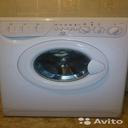

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

appliances = list(data_dir.glob('Appliances/*'))
PIL.Image.open(str(appliances[0]))

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 612646 files belonging to 14 classes.
Using 490117 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 612646 files belonging to 14 classes.
Using 122529 files for validation.


No hace falta ejecutar esta parte de codigo, solo es para comprobar que se han cargado bien las imagenes.

['Appliances', 'Audio and video', 'Bicycles', "Children's clothing and shoes", 'Clothes, shoes, accessories', 'Furniture and interior', 'Games, consoles and programs', 'Goods for children and toys', 'Motorcycles', 'Musical instruments', 'Phones', 'Repair and construction', 'Tablets and e-books', 'Tech accessories']
(32, 128, 128, 3)
(32,)


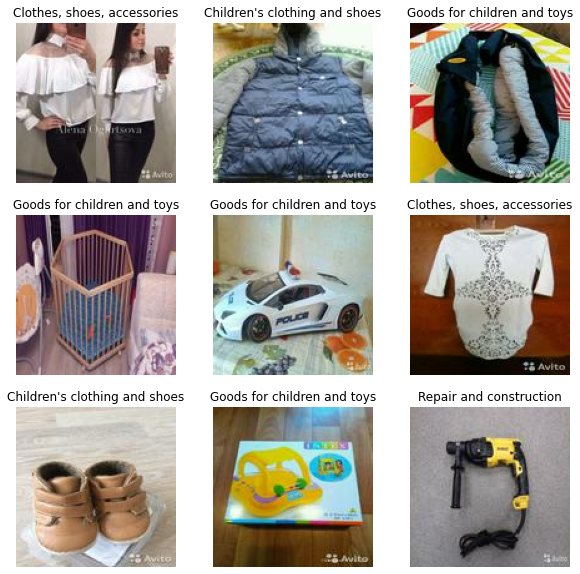

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
if batch_size > 9:
  x = 9
else:
  x = batch_size

for images, labels in train_ds.take(1):
  for i in range(x):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
        
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Modelo 0


In [ ]:
# Modelo 2 con dropout y data aug

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model2 = Sequential([
  data_augmentation,
  #layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                  

In [ ]:
import os

from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc


class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

In [ ]:
#AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.shuffle(10).prefetch(buffer_size = AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
epochs = 10

!mkdir /content/performance_visualizations
performance_cbk = PerformanceVisualizationCallback(
                      model=model2,
                      validation_data=val_ds,
                      image_dir='/content/performance_visualizations')

history2 = model2.fit(normalized_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[performance_cbk])

mkdir: cannot create directory ‘/content/performance_visualizations’: File exists
Epoch 1/10
34180/40844 [========================>.....] - ETA: 2:28 - loss: 1.8541 - accuracy: 0.3703

KeyboardInterrupt: ignored

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model2.save("/content/model3", save_format='h5')

In [ ]:
!gsutil cp -r /content/model2 gs://tfmbucket1/models

CommandException: No URLs matched: /content/model2


# Modelo 2


In [ ]:
# Modelo 2 con dropout y data aug

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                      

In [ ]:
import os

from keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np
from scikitplot.metrics import plot_confusion_matrix, plot_roc


class PerformanceVisualizationCallback(Callback):
    def __init__(self, model, validation_data, image_dir):
        super().__init__()
        self.model = model
        self.validation_data = validation_data
        
        os.makedirs(image_dir, exist_ok=True)
        self.image_dir = image_dir

    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(self.validation_data[0]))
        y_true = self.validation_data[1]             
        y_pred_class = np.argmax(y_pred, axis=1)

        # plot and save confusion matrix
        fig, ax = plt.subplots(figsize=(16,12))
        plot_confusion_matrix(y_true, y_pred_class, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'confusion_matrix_epoch_{epoch}'))

       # plot and save roc curve
        fig, ax = plt.subplots(figsize=(16,12))
        plot_roc(y_true, y_pred, ax=ax)
        fig.savefig(os.path.join(self.image_dir, f'roc_curve_epoch_{epoch}'))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(10).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
epochs = 10

!mkdir /content/performance_visualizations
performance_cbk = PerformanceVisualizationCallback(
                      model=model2,
                      validation_data=val_ds,
                      image_dir='/content/performance_visualizations')

history2 = model2.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=[performance_cbk])

mkdir: cannot create directory ‘/content/performance_visualizations’: File exists
Epoch 1/10
 4405/40844 [==>...........................] - ETA: 14:58 - loss: 2.0345 - sparse_categorical_accuracy: 0.2977

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model2.save("/content/model3", save_format='h5')

In [ ]:
!gsutil cp -r /content/model2 gs://tfmbucket1/models

CommandException: No URLs matched: /content/model2


# Modelo 1

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
epochs = 10
history = model.fit(
  normalized_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow import keras
model.save('/content/model1')

In [ ]:
!gsutil cp -r /content/model1 gs://tfmbucket1/models

# Modelo 3: Transfer Learning

In [ ]:
!pip install h5py

In [ ]:
# Number of training examples and labels
num_train = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
num_validation = tf.data.experimental.cardinality(val_ds).numpy() * batch_size
num_classes =  14
num_iterations = int(tf.data.experimental.cardinality(train_ds).numpy()) 

In [ ]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = tf.one_hot(label, depth=num_classes)
    return image, label
    
def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    train_processed = train_processed.repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    validation_processed = validation_processed
    
    return train_processed, validation_processed
    
# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train_ds, val_ds, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train_ds, val_ds, batch_size, img_size=[331,331])

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation

def corrermodelo(model_name, model):
 # for model_name, model in attrib:
      # Special handling for "NASNetLarge" since it requires input images with size (331,331)
      if 'NASNetLarge' in model_name:
          input_shape=(331,331,3)
          train_processed = train_processed_331
          validation_processed = validation_processed_331
      else:
          input_shape=(224,224,3)
          train_processed = train_processed_224
          validation_processed = validation_processed_224
          
      # load the pre-trained model with global average pooling as the last layer and freeze the model weights
      pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
      pre_trained_model.trainable = False
      
      # custom modifications on top of pre-trained model and fit
      clf_model = tf.keras.models.Sequential()
      clf_model.add(pre_trained_model)
      clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
      clf_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
      history = clf_model.fit(train_processed, epochs=3, validation_data=validation_processed, steps_per_epoch=num_iterations)
      
      # Calculate all relevant metrics
      model_benchmarks['model_name'].append(model_name)
      model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
      model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

      clf_model.save('/content/' + model_name, save_format = 'h5')
      #clf_model.save('/content/A14/' + model_name, save_format = 'h5')
      !gsutil cp -r /content/{model_name} gs://tfmbucket1/models


In [ ]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
keys_list = list(model_dictionary)
values = list(model_dictionary.values())
model_dictionary

{'DenseNet121': <function keras.applications.densenet.DenseNet121>,
 'DenseNet169': <function keras.applications.densenet.DenseNet169>,
 'DenseNet201': <function keras.applications.densenet.DenseNet201>,
 'EfficientNetB0': <function keras.applications.efficientnet.EfficientNetB0>,
 'EfficientNetB1': <function keras.applications.efficientnet.EfficientNetB1>,
 'EfficientNetB2': <function keras.applications.efficientnet.EfficientNetB2>,
 'EfficientNetB3': <function keras.applications.efficientnet.EfficientNetB3>,
 'EfficientNetB4': <function keras.applications.efficientnet.EfficientNetB4>,
 'EfficientNetB5': <function keras.applications.efficientnet.EfficientNetB5>,
 'EfficientNetB6': <function keras.applications.efficientnet.EfficientNetB6>,
 'EfficientNetB7': <function keras.applications.efficientnet.EfficientNetB7>,
 'EfficientNetV2B0': <function keras.applications.efficientnet_v2.EfficientNetV2B0>,
 'EfficientNetV2B1': <function keras.applications.efficientnet_v2.EfficientNetV2B1>,
 '

MODELOS

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[0], values[0]) #DenseNet121
print("Hecho")
#loss: 0.8304 - accuracy: 0.6759 - val_loss: 0.8545 - val_accuracy: 0.6651

29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/3
15317/15317 [==============================] - 1950s 126ms/step - loss: 0.8035 - accuracy: 0.6691 - val_loss: 0.7765 - val_accuracy: 0.6831
Epoch 2/3
15317/15317 [==============================] - 1925s 126ms/step - loss: 0.8092 - accuracy: 0.6763 - val_loss: 0.9241 - val_accuracy: 0.6335
Epoch 3/3
15317/15317 [==============================] - 1929s 126ms/step - loss: 0.8304 - accuracy: 0.6759 - val_loss: 0.8545 - val_accuracy: 0.6651
Copying file:///content/DenseNet121 [Content-Type=application/octet-stream]...
/ [1 files][ 27.6 MiB/ 27.6 MiB]                                                
Operation completed over 1 objects/27.6 MiB.                                     
Hecho


In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[1], values[1]) #DenseNet169
print("Hecho")
#loss: 0.8155 - accuracy: 0.6862 - val_loss: 0.8312 - val_accuracy: 0.6836

51888128/51877672 [==============================] - 0s 0us/step
Epoch 1/3
15317/15317 [==============================] - 2400s 156ms/step - loss: 0.7846 - accuracy: 0.6806 - val_loss: 0.8326 - val_accuracy: 0.6654
Epoch 2/3
15317/15317 [==============================] - 2379s 155ms/step - loss: 0.8155 - accuracy: 0.6862 - val_loss: 0.8312 - val_accuracy: 0.6836
Epoch 3/3
15317/15317 [==============================] - 2396s 156ms/step - loss: 0.8519 - accuracy: 0.6844 - val_loss: 1.0128 - val_accuracy: 0.6312
Copying file:///content/DenseNet169 [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/49.3 MiB.                                     
Hecho


In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[2], values[2]) #DenseNet201
print("Hecho")
#loss: 0.7961 - accuracy: 0.6947 - val_loss: 0.8306 - val_accuracy: 0.6896

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[3], values[3]) #EfficientNetB0 HECHO
print("Hecho")
#loss: 1.9841 - accuracy: 0.2267 - val_loss: 1.9801 - val_accuracy: 0.2262

Epoch 1/3
941/941 [==============================] - 343s 334ms/step - loss: 1.9882 - accuracy: 0.2256 - val_loss: 1.9693 - val_accuracy: 0.2290
Epoch 2/3
941/941 [==============================] - 308s 327ms/step - loss: 1.9844 - accuracy: 0.2249 - val_loss: 1.9696 - val_accuracy: 0.2290
Epoch 3/3
941/941 [==============================] - 307s 327ms/step - loss: 1.9841 - accuracy: 0.2267 - val_loss: 1.9801 - val_accuracy: 0.2262


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Copying file:///content/EfficientNetB0 [Content-Type=application/octet-stream]...
/
Operation completed over 1 objects/15.9 MiB.                                     


In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[4], values[4]) #EfficientNetB1
print("Hecho")
#loss: 1.9642 - accuracy: 0.2232 - val_loss: 1.9551 - val_accuracy: 0.2249

27033600/27018416 [==============================] - 1s 0us/step
Epoch 1/3
15317/15317 [==============================] - 3283s 213ms/step - loss: 1.9649 - accuracy: 0.2232 - val_loss: 1.9563 - val_accuracy: 0.2249
Epoch 2/3
15317/15317 [==============================] - 3268s 213ms/step - loss: 1.9642 - accuracy: 0.2232 - val_loss: 1.9551 - val_accuracy: 0.2249
Epoch 3/3
15317/15317 [==============================] - 3286s 215ms/step - loss: 1.9642 - accuracy: 0.2234 - val_loss: 1.9736 - val_accuracy: 0.2215


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Copying file:///content/EfficientNetB1 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/25.7 MiB.                                     
Hecho


In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[5], values[5]) #EfficientNetB2
print("Hecho")

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[6], values[6]) #EfficientNetB3
print("Hecho")

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[7], values[7]) #EfficientNetB4
print("Hecho")
#ETA: 44:58 - loss: 1.9848 - accuracy: 0.2201
# Mal modelo, muy pesado mal resultado parado

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[8], values[8]) #EfficientNetB5
print("Hecho")
#ETA: 1:33:28 - loss: 1.9959 - accuracy: 0.2173
# Mal modelo, muy pesado mal resultado parado

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[9], values[9]) #EfficientNetB6
print("Hecho")
#ETA: 2:27:10 - loss: 2.0091 - accuracy: 0.2147
# Mal modelo, muy pesado mal resultado parado

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo(keys_list[10], values[10]) #EfficientNetB7
print("Hecho")
#Sin hacer pero supongo por los previos de Efficient Net que será malo.

In [ ]:
#------------CORRIENDO-----------------
corrermodelo(keys_list[11], values[11]) #InceptionResNetV2
print("Hecho")

219070464/219055592 [==============================] - 5s 0us/step
Epoch 1/3
15317/15317 [==============================] - 7602s 494ms/step - loss: 0.8158 - accuracy: 0.6812 - val_loss: 0.9412 - val_accuracy: 0.6482
Epoch 2/3
13272/15317 [========================>.....] - ETA: 13:30 - loss: 0.8587 - accuracy: 0.6896

In [ ]:
corrermodelo(keys_list[12], values[12]) #InceptionV3
print("Hecho")

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
15317/15317 [==============================] - 3354s 218ms/step - loss: 0.8875 - accuracy: 0.6560 - val_loss: 0.9893 - val_accuracy: 0.6293
Epoch 2/3
15317/15317 [==============================] - 3360s 219ms/step - loss: 0.9195 - accuracy: 0.6650 - val_loss: 1.0729 - val_accuracy: 0.6187
Epoch 3/3
10767/15317 [====================>.........] - ETA: 13:16 - loss: 0.9617 - accuracy: 0.6651

In [ ]:
corrermodelo(keys_list[13], values[13]) #MobileNet
print("Hecho")

In [ ]:
#------------------MUY LARGO-----------------
corrermodelo(keys_list[17], values[17]) #'NASNetLarge'
print("Hecho")
#ETA: 11:38:22 - loss: 1.2983 - accuracy: 0.5391

In [ ]:
corrermodelo(keys_list[18], values[18]) #'NASNetMobile': 
print("Hecho")
#loss: 0.8119 - accuracy: 0.6677

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/3
15317/15317 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.6677

In [ ]:
corrermodelo(keys_list[19], values[19]) #'ResNet101'
print("Hecho")
#loss: 1.7635 - accuracy: 0.3253 - val_loss: 1.7574 - val_accuracy: 0.3232

171458560/171446536 [==============================] - 3s 0us/step
Epoch 1/3
15317/15317 [==============================] - 8519s 555ms/step - loss: 1.7635 - accuracy: 0.3253 - val_loss: 1.7574 - val_accuracy: 0.3232
Epoch 2/3
 9671/15317 [=================>............] - ETA: 41:51 - loss: 1.7051 - accuracy: 0.3515

Modelo Ganador

In [ ]:
#DenseNet201
corrermodelo(keys_list[2], values[2])
print("Hecho")
#loss: 0.8444 - accuracy: 0.7118 - val_loss: 0.8510 - val_accuracy: 0.7102

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/3
15317/15317 [==============================] - 6696s 435ms/step - loss: 0.8443 - accuracy: 0.7117 - val_loss: 0.8510 - val_accuracy: 0.7099
Epoch 2/3
15317/15317 [==============================] - 6653s 434ms/step - loss: 0.8236 - accuracy: 0.7224 - val_loss: 0.9133 - val_accuracy: 0.6924
Epoch 3/3
15317/15317 [==============================] - 6676s 436ms/step - loss: 0.8275 - accuracy: 0.7236 - val_loss: 0.8672 - val_accuracy: 0.7120
Copying file:///content/DenseNet201 [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/71.2 MiB.                                     
Hecho


Cargar modelo ya entrenado de google

In [ ]:
from tensorflow.keras.models import Sequential, load_model
# Importing saved model
output_dir =  '/content/'
model_trained = load_model(output_dir + 'DenseNet201')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/DenseNet201')

In [ ]:
print(num_classes)
picture = PIL.Image.open(str(appliances[15]))

14


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense (Dense)               (None, 14)                26894     
                                                                 
Total params: 18,348,878
Trainable params: 26,894
Non-trainable params: 18,321,984
_________________________________________________________________


Export el modelo en archivos para subir al Frontend

In [ ]:
#Exportacion del modelo a h5
model_trained.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 2.8 MB/s 
     |████████████████████████████████| 462 kB 22.7 MB/s 


In [ ]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [ ]:
#Veamos si si creo la carpeta
!ls

adc.json  DenseNet201  drive  modelo_exportado.h5  sample_data	tfjs_target_dir


In [ ]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard10of18.bin	group1-shard17of18.bin	group1-shard6of18.bin
group1-shard11of18.bin	group1-shard18of18.bin	group1-shard7of18.bin
group1-shard12of18.bin	group1-shard1of18.bin	group1-shard8of18.bin
group1-shard13of18.bin	group1-shard2of18.bin	group1-shard9of18.bin
group1-shard14of18.bin	group1-shard3of18.bin	model.json
group1-shard15of18.bin	group1-shard4of18.bin
group1-shard16of18.bin	group1-shard5of18.bin


Crear ZIP y bajar archivos para compartir

In [ ]:
#Crear ZIP
!zip -r /content/file.zip /content/tfjs_target_dir

  adding: content/tfjs_target_dir/ (stored 0%)
  adding: content/tfjs_target_dir/group1-shard13of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard2of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard7of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/model.json (deflated 97%)
  adding: content/tfjs_target_dir/group1-shard17of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard18of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard15of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard14of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard1of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard6of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard8of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard16of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard10of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard

In [ ]:
#Descargar ZIP
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graficas

In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

In [ ]:

# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');

In [ ]:
https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

# Modelo 4: Modelo de churn

In [ ]:
import pandas as pd

directorio_dataset = '/content/drive/MyDrive/TFM Big Data & BA/Propuestas/Proyecto Final/0 - Dataset/train_data.csv'

df = pd.read_csv(directorio_dataset)

In [ ]:
#!rm -rf /content/Dataset   #Eliminar carpeta

In [ ]:
i = 1
import os
!mkdir /content/Dataset
!mkdir /content/Dataset/0
!mkdir /content/Dataset/1

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)

In [ ]:
os.listdir(data_dir)

['Motorcycles',
 'Furniture and interior',
 'Bicycles',
 'Goods for children and toys',
 'Repair and construction',
 'Appliances',
 'Tablets and e-books',
 'Games, consoles and programs',
 'Phones',
 'Tech accessories',
 'Musical instruments',
 'Audio and video',
 'Clothes, shoes, accessories',
 "Children's clothing and shoes"]

In [ ]:
i = 1
import os
!mkdir /content/Dataset
!mkdir /content/Dataset/0
!mkdir /content/Dataset/1

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)
for folder in os.listdir(data_dir):
  fldir = data_dir + "/" + folder
  print(fldir)
  for image in os.listdir(fldir):
      imgdir = fldir + '/' + image
      value = df[df['image']== image[0:-4] ]['sold'].values[0]
      os.rename(imgdir,  "/content/Dataset/" + value.astype(str) + "/" + image)
      i = i + 1
      if (i % 10000) == 0:
        print(i)

In [ ]:
import tarfile
import os.path

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

make_tarfile("/content/Dataset_bin4.tar", "/content/Dataset")

In [ ]:
!gsutil cp -r /content/Dataset_bin4.tar gs://tfmbucket1/images/train

Copying file:///content/Dataset_bin4.tar [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/916.7 MiB.                                    


In [ ]:
!pip install tarfile

ERROR: Could not find a version that satisfies the requirement tarfile (from versions: none)
ERROR: No matching distribution found for tarfile


In [ ]:
dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")

El repositorio de imagenes contiene:  931441  elementos


In [ ]:
img_height = 128
img_width = 128 
batch_size = 32 # opcion 2

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset_bin.tar" # Nueva ruta
data_dir = tf.keras.utils.get_file('Dataset_bin', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print("El repositorio de imagenes contiene: ", image_count, " elementos")


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

El repositorio de imagenes contiene:  0  elementos


FileNotFoundError: ignored

In [ ]:
# Number of training examples and labels
num_train = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
num_validation = tf.data.experimental.cardinality(val_ds).numpy() * batch_size
num_classes =  2
num_iterations = int(tf.data.experimental.cardinality(train_ds).numpy()) 

In [ ]:
def normalize_img(image, label, img_size):
    # Resize image to the desired img_size and normalize it
    # One hot encode the label
    image = tf.image.resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.
    label = label #tf.one_hot(label, depth=num_classes) No haria falta onehot no??
    return image, label
    
def preprocess_data(train, validation, batch_size, img_size):
    # Apply the normalize_img function on all train and validation data and create batches
    train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    train_processed = train_processed.repeat()
    
    validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
    
    # If your data is already batched (eg, when using the image_dataset_from_directory function), remove .batch(batch_size)
    validation_processed = validation_processed
    
    return train_processed, validation_processed
    
# Run preprocessing
train_processed_224, validation_processed_224 = preprocess_data(train_ds, val_ds, batch_size, img_size=[224,224])
train_processed_331, validation_processed_331 = preprocess_data(train_ds, val_ds, batch_size, img_size=[331,331])

In [ ]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import inspect
from tqdm import tqdm

# Set batch size for training and validation

def corrermodelo_bin(model_name, model):
 # for model_name, model in attrib:
      # Special handling for "NASNetLarge" since it requires input images with size (331,331)
      if 'NASNetLarge' in model_name:
          input_shape=(331,331,3)
          train_processed = train_processed_331
          validation_processed = validation_processed_331
      else:
          input_shape=(224,224,3)
          train_processed = train_processed_224
          validation_processed = validation_processed_224
          
      # load the pre-trained model with global average pooling as the last layer and freeze the model weights
      pre_trained_model = model(include_top=False, pooling='avg', input_shape=input_shape)
      pre_trained_model.trainable = False
      
      # custom modifications on top of pre-trained model and fit
      clf_model = tf.keras.models.Sequential()
      clf_model.add(pre_trained_model)
      clf_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
      clf_model.compile(loss='binary_crossentropy', metrics=['accuracy'])
      history = clf_model.fit(train_processed, epochs = 1, validation_data=validation_processed, steps_per_epoch=num_iterations)
      
      # Calculate all relevant metrics
      model_benchmarks['model_name'].append(model_name)
      model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
      model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'][-1])

      clf_model.save('/content/' + model_name, save_format = 'h5')
      !gsutil cp -r /content/{model_name} gs://tfmbucket1/models


In [ ]:
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

In [ ]:
keys_list = list(model_dictionary)
values = list(model_dictionary.values())
model_dictionary

MODELOS

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[0], values[0]) #DenseNet121
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[1], values[1]) #DenseNet169
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[2], values[2]) #DenseNet201
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[3], values[3]) #EfficientNetB0 HECHO
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[4], values[4]) #EfficientNetB1
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[5], values[5]) #EfficientNetB2
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[6], values[6]) #EfficientNetB3
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[7], values[7]) #EfficientNetB4
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[8], values[8]) #EfficientNetB5
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[9], values[9]) #EfficientNetB6
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
##----------------HECHO--------------------------------------
corrermodelo_bin(keys_list[10], values[10]) #EfficientNetB7
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
#------------CORRIENDO-----------------
corrermodelo_bin(keys_list[11], values[11]) #InceptionResNetV2
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
corrermodelo(keys_list[12], values[12]) #InceptionV3
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
corrermodelo(keys_list[13], values[13]) #MobileNet
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
#------------------MUY LARGO-----------------
corrermodelo(keys_list[17], values[17]) #'NASNetLarge'
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
corrermodelo(keys_list[18], values[18]) #'NASNetMobile': 
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

In [ ]:
corrermodelo(keys_list[19], values[19]) #'ResNet101'
print("Hecho")
#ETA:  - loss:  - accuracy:  - val_accuracy:
# 

Modelo Ganador

In [ ]:
#DenseNet201
corrermodelo(keys_list[2], values[2])
print("Hecho")
#loss: 0.7961 - accuracy: 0.6947 - val_loss: 0.0806 - val_accuracy: 0.6896

Cargar modelo ya entrenado de google

In [ ]:
from tensorflow.keras.models import Sequential, load_model
# Importing saved model
output_dir =  '/content/'
model_trained = load_model(output_dir + 'models_DenseNet201')

Export el modelo en archivos para subir al Frontend

In [ ]:
#Exportacion del modelo a h5
model_trained.save('modelo_exportado.h5')

In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 2.8 MB/s 


In [ ]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

In [ ]:
#Veamos si si creo la carpeta
!ls

adc.json	     models_DenseNet121  sample_data
modelo_exportado.h5  models_DenseNet201  tfjs_target_dir


In [ ]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

group1-shard10of18.bin	group1-shard17of18.bin	group1-shard6of18.bin
group1-shard11of18.bin	group1-shard18of18.bin	group1-shard7of18.bin
group1-shard12of18.bin	group1-shard1of18.bin	group1-shard8of18.bin
group1-shard13of18.bin	group1-shard2of18.bin	group1-shard9of18.bin
group1-shard14of18.bin	group1-shard3of18.bin	model.json
group1-shard15of18.bin	group1-shard4of18.bin
group1-shard16of18.bin	group1-shard5of18.bin


Crear ZIP y bajar archivos para compartir

In [ ]:
#Crear ZIP
!zip -r /content/file.zip /content/tfjs_target_dir

  adding: content/tfjs_target_dir/ (stored 0%)
  adding: content/tfjs_target_dir/group1-shard6of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard10of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard5of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/model.json (deflated 97%)
  adding: content/tfjs_target_dir/group1-shard11of18.bin (deflated 7%)
  adding: content/tfjs_target_dir/group1-shard4of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard16of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard17of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard13of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard8of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard7of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard12of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard18of18.bin (deflated 6%)
  adding: content/tfjs_target_dir/group1-shard

In [ ]:
#Descargar ZIP
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Graficas

In [ ]:
# Convert Results to DataFrame for easy viewing
benchmark_df = pd.DataFrame(model_benchmarks)

# sort in ascending order of num_model_params column
benchmark_df.sort_values('num_model_params', inplace=True)

# write results to csv file
benchmark_df.to_csv('benchmark_df.csv', index=False)
benchmark_df

In [ ]:

# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))

for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Accuracy vs Model Size')

# Move legend out of the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');

In [ ]:
https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4

# Feature extraction para image quality classification

In [ ]:
!pip install scipy
!pip install tqdm
!pip install scikit-image
!pip intsall imutils
!pip install opencv-python
!pip install opencv-contrib-python

In [ ]:

dataset_url = "https://storage.googleapis.com/tfmbucket1/images/train/Dataset.tar"
data_dir = tf.keras.utils.get_file('Dataset', origin=dataset_url, untar=True)
#data_dir = pathlib.Path(data_dir)

In [ ]:
for folder in os.listdir(data_dir):
  fldir = data_dir + "/" + folder
  for image in os.listdir(fldir):
      imgdir = fldir + '/' + image
      print(imgdir)
      i = i + 1
      if (i % 10000) == 0:
        print(i)

Streaming output truncated to the last 5000 lines.
/root/.keras/datasets/Dataset/Furniture and interior/1a9c0c166ee82026d69032f07b94a4875342bc9afe8ea7bdf0a50534e7ad50b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b555e2bd7ade98bbea87c606f3dba563807b12a326e4a916d30cea9def7c1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82d7d5194e95f9de06f19953ca5fac4e1935e5cd10f586bee38a95c211cc6837.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ba133b651022f0f693ef9565de5e72ef0bb5cca7c63e0f96299315907012f00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14736abc0ab712f198bb0aad5fb0394005890a1422315e653eaf078faa8b4261.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a57e826748c4e604478687cf9c889595570ecf42d05f8bd2f7fc2d8630360d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dee56938be34ba55470dabf9fcbc5d59f8bc83a5a61d12c493eb189787166db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37df4ad412972bef4f08fb94d780ffc22255668b56

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
/root/.keras/datasets/Dataset/Bicycles/8a0021b2db2fa91da33e161f21a37d31db73c0554d4923c5cd7c19d45be7d5e9.jpg
/root/.keras/datasets/Dataset/Bicycles/1090471d1b8d85e5907ac188cf6000509bf1aedb5d6ac92defcd8095f9813320.jpg
/root/.keras/datasets/Dataset/Bicycles/62b3cb09493bc19d578abe59d61279bd4da284b651f64c6a99df34dd5db5d207.jpg
/root/.keras/datasets/Dataset/Bicycles/fe9a4c95e38b2391c45d479a52d3a9211f193c8f490e5a6d17ad68b277a1e12c.jpg
/root/.keras/datasets/Dataset/Bicycles/4606a021769222e7e9e95eb81cf1bc807dfcedf6f77b58f4dbebbaa40ada399f.jpg
/root/.keras/datasets/Dataset/Bicycles/7da9a3a61177a10974e5a22b5796fd1be310fc38a7f2aacf583f97a805ca4ec1.jpg
/root/.keras/datasets/Dataset/Bicycles/df3b6f0a0498b18df1a00e84516d75f8a807752a64937dcd1426781f374df7c9.jpg
/root/.keras/datasets/Dataset/Bicycles/b7ea8acd8a4983a40051a4ffd3cfb55cfb6bedca86e26760c56eecd6e9f531dc.jpg
/root/.keras/datasets/Dataset/Bicycles/b7bf4c95cc83511a7ae9c05501dee4febabb5f589cdcbb

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-877fe6b8755e>", line 3, in <module>
    for image in os.listdir(fldir):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", lin

KeyboardInterrupt: ignored

In [ ]:
imagenes = [Se han truncado las últimas 5000 líneas del flujo de salida.
/root/.keras/datasets/Dataset/Furniture and interior/b90504f77df44c6e5a61a21164ebdfb2b196a9f7b22e1496e1aead40968be68a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6439b06aa3628f8bbabcea17a9d8cbc86674a57c19537da3d6a79b337a9c3ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0788266bcf1cd9f9419737c1d1356f8a4c9e5b72b454e7e5fafe2d497d40bc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/913c38000572058d35c007b225cc9c77e6729b20a9bb2c090f676bfa0ef9e3ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92069999468927878537c5f11eb366e1dffc607c2e20955f40f4621a947afa70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/379672e8b9d1ffac2238fb8874ab55c9d7a2896aa26246125cc9aba9a2691e67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0c30b19836ce704f0c88636c2515e1822e265b0ad69de744503244f2bc2579f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f99eb76f8f0bb2ee6009ab5ed2593c66b0631783316d01a4cefaa5c58f7952ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdfabc4b86c90ac3d626177d958781fab111f19692aea96082554979b36482c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a57a1558db6361c3f51ec5c22eabdedf548a38fd60498bf0432963c32c0f3ea5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7f06990a94550bb01e76cbebed6a6a6c7fa94f1d19190b6ff0166b6f65af75c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e42c17b2092aafc8b7f9fd7fe4c4c9f9d07e9d998101f07baac8c0f0e8959cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73e266c1bef21e785aa9ef4b1226c870edb278e903613261a83937aa23595299.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2effeda7a060799639327ec4866230b5d7a87513fe25436a46984001c0e63b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ec67119f8aa3efc2e27b4898080f5a75cf0df78eae942c652de744bd6b36605.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abdcf5deab7df3f6e5b59c3115e28e859d03f14e4f5743b0d1514497a5f472dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0150e64de6113b6580ef097c76504ed8d4681accef11f15c3f21253f8368a0b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3ecfa1d7026da95e1d95628231a184c6c2cbdc14e1644f47b78016ae9a5f124.jpg
/root/.keras/datasets/Dataset/Furniture and interior/820c8b0ce3c4e10c7ad2c30b3e91ba8ddc275c512cae5be11d262ce272a7fbda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e9a559b581d805db3029b8fdb9d4013a777e563d4a530a991614ff0bbcaaeae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/525ec2d1f29b5792cde87763b893ec76094c7b3d3a4f6506b759c8c05027a283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19f798e1495e287de4bf5a89b9d9f8b8f7efd18978a21370d25f4964a9e71b2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb2f7a024a0a6998ce4f1c89e44ca6807e98208e0198d2cd480ef492bc0ac14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35314ccff29d6c766625fd97a13d9d5bc81d6096d527b82ade32e4f5294acd6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3eea31e81efdceab20338ab53fc389d9045a0f4caccf378cd560a35d71e2e840.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3263e9371e8d54fb2ff66616098cf68c0cd51d53d28b8df44e5fd2ffeb9a7104.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a4c528cae4afaea8c58b2973a0e0fb3385e7e3f8cba2a86b6f3839536900374.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95a75ae52056e09904ff434a903cf5b56ec13801f124259813166fa6cc50bea3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b37afeeb9ecdceb904cc211732f3d34601ac94978700c80e8c378a12e7773a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e630bd5c78551b62702143f71433ca64bd09d19526ee7b7f630acdc64ffee7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4592afad7906d6858cb971a111c09c360b72abe4b6fb0618cf0c5e69636444cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1ffcd2ae57362c18aa8e8fc107c25835f6df567837d392e3875559ba36bd94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/969a0b24cdbf0438265c262046a69c220b070cb2ac49f238ff2873f28062be2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86bba0685b16f068f82b00526eaa477475b8e863f0046fc633c2371d5d2ed656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70fa94ed714190a3a77f198246587eca19338be059309602318d4aab82d3d449.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29835364c916de2c2b11dab8e36af10b5574946a0d70341a179c1c53885a583c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152e1871f6e9216056095f8f33ebb48ccd2b82bceec8e8edeb50605e399bd6c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0102573093636d480385838d5f2157944eb5ace39f62d8b4aeb7529cf1c21b17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/827ca9de3b9c3b356c7e67609003a5b3b83e06fbb673377cab947f1f1ec37227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3f1de1130a159a8864c1fdec9aa5cfc221839cb6eede714db665a591aaf11f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f36a64798ec824e0570c30f8649e2bb8accd3d0fb157f25a73e5f94eb3d6aeda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad458deba046e83360779c12db86e4e689f879222f4611d43cc6f7d9624370a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/495af29c17ccd39c3ddb6a96862dc6815ec874245d6a9d34dfd1ad25235f6847.jpg
/root/.keras/datasets/Dataset/Furniture and interior/508a26b1e7e82e531720a6b4ffac31b756f15ce59a54a65c2e918d3575e7952c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cc4582e7a52ef2d3e8b16a307dc3e1e56e49f4ad3af6e326d42669f1c72d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6f9602fc507ed7d998a7928626d4f07259e7b37d779316ed65b1a193558c958.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f95bf5ff1906ab22a34c49993029e9a4e033796ddd0622ff4df3e171fd61b2a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adea8fae4e8cae62525682520a6a57bff96ac995b46d1dbfafb22d9caac47993.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34398ba38f19e0c987a02fcfd4867d48c9da0f51bf2c1c031755dae767522da8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf0bdcaad39852294d948ff969d6f3b4cebcaf13004e6d41a12a968161f27702.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1503211f97d2d5555b40d2a1e4453c90ca4f8cd115b1e204d8f0e389a74e4c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c699673bae05f2871213b2bc1d50e568bd85753a9d45cb954ad5c9b99ec9a9ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d17116076d6990ddc13e8b9f375034d8b146ecf2aca7f1b95a6f9b9844398a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51d93ca636ccbf52a7bcd09623447c5f70965b6509612d8548e54f3a516b8a0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6c59d9c6d16ded9640bd549ceccc3ce9071c2768ef38ee273ca22c2733dff0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645ead4fa05c6bb7b4c5bd2a622a1add3d10406ea1ba3e1218ed30ed1e73067a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f12c2a06eaf35e8f27ee3f44e84fc61a04ca223b5512183c616adae8270d1c38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0e9e62c3993a2bdd336d1474c79547ccddd0b1deccd1374bc0680d49da3a492.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88e64e0b503288831e5d99a7a32037b1e6b3bb0bfe4c411f8c240d501ff08bbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/114c9dafd85f91cb10bae731ebc3021e8c43b723be5d638709cc2f74f4a0525a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb9cc1151e590e7c1eebe5361c9e3c557ac68677083f2c2f314352e7d69e76c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82455edb133a3af9c7752ebe9c3925b89adfdad52dd9e82ede1ef00ab7cc9d50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37be906a46ddb250fab0f2424223da4059eff0bb2ebb23350d59f3d524cc85a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55675c08754db1bda288d011ec6c3ad41bd998b88150e0b4aef84a00d8c8d26a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a054ca5d24f1e340b00f234edf9b636b361ac6028cbd8899b224c74f2ffae38b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/748c0a6aee0656793e302a7132eef4d5ea8fda2eebec47f799369f58d40a6e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/182556e8695b4786fdf3bec132a6746c48255774db69c3465ba7e31035825ccf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7082221244c1f56d582b34142825d79d93d65d46904f04f6eda1c93c4b25123d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff7e10bc41dba03821c8d634d2ffbafbab5739b0646952a91bacbf701e54924d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44fada1303a9a8fd5c040164f763c86e00cf8da841d92a78c7dab7ce7fac4322.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29c4fcd24c71f6b3079c9f5ddabfa2ae5885ca9b96854d8e8a4e7c07041db088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb84a33b80f58f006ac06fb9a585324e8429e38d1cc80bab0c0b108ed874e691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/258d2e637270b20bc17cd922249dca12585e2b5073ca9477acb135e8bec840a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7426cfafe7b687368050bd75c3ef8b9a740e9f3551957046adca6a9a73310742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb6e6e6785c539f8489d54c4ba20eb27e86103acdf7f8f851495a660fc2fed16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dc5f92c3282a8d62c917edeb6abefff1a3624b786130c2633aeb37ea070cdcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e5e845ff682adfe58a575659115d15b58933717b901b924dcb9635e6c23beaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db86a121378f123fb9c2152e8a877fd2fcd7acd109584279d5d607c3d6556cd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5fc504fa18bc3bbf995d2732c77ede165010d4d4d2c84da09914a8308c64655.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd8a6816c147d68cc17822366ed1a5f5118d16eac3926c253f387866d362e9bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2f16cb1582bab27e5929935a3b6f85d887f35cb807962e69b976f4f277278ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d9f5a1bdd93bf9c3f2c0464f8bb54387aaf10f91377a2727137a2a826653253.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1102554da55a9b52bdc93f89bf161da572cd17636f35c5b6a45c98cc91baf517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65f5857ef814105b8a6a2705fe21aed166fe865189e896dcfe28b470b9e86de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58e128a3cc09600a537d00a4270e44fefb8604398e016975ff6fdc29c917338a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5cc0775e4bcdee1c4752d25af383ce70553e970ec8c9f9ec563566b0f3eba50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb35a8e86dae170e73b502c84d4c2bbe5566ce369668c342d7a0d44a2e34a10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49994cd1a917b5da6d0b503d4f4a7b2342feb80564933b452c07314478797967.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45e7b101d2978f78779b711c4a7a94010c62e406c3247cfd349058b3f743e56f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f94c553dfa8b6f7983e9e08a8e89def96646b4bb606c592a51fb9b05994d2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dee6e8c3c622f8665816fc4b8b51c7c888412a6234598e99957d852f3b8fb7cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/119b866d0cd273f4bcc19ebbf19c8f2583dbdd4c6d27d889a1df5614093786a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44434eb3a1239e5a015394146238b0e665966ee6504093839c51eaac00628afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/728c105c23aa55691b5fe6fab87531691d12ead7fac08d11d94413b241620932.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0b70d2909961e4d1156424dd2bddd26a253d428dcffa94d6c6327c381f8800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b3d904f986ba440056f1f846f377e935f967224dc25a9c20ebeb539c800d834.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfc7de8666bc210db3f36c7bc22376b59c74965ba1246a86ab1e60bc37de79fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f74367fa4552b347ccc38ea281eea62267bcef94f056161bfd207425ae8ea83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4b7dfeb98c1da5b5411f999cf9b8a4c1442f70a234c9338348744c41d3ff971.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85e48675a95fde5ac7ef26de0e3e3e95de2ad03da6e0b357b46e7588bad3d9f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff72af88048893a59cf3b6081d3c1f2ff80833a034387762ba36645de1559640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8853f45a1deb943b280f5343911a1b1eb2d6766cc73f1069b47ba033515eac64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dfad5024dea09f78abcab51249cca7cd0c694da7388f25386666cc336eba32f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d246cf4e324a172a32e147b7d2346d159b4ed1d2eb28dfe5baf01364605ff44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645de39856de450521f5b3ea5e9cb50096f9e70ccc844cd85c08b7df5d76faac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e163ec59e4c19d0bcfc70b03231245e530c603308725cdde74a2e34a553b5a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9182596afaef821f4681a7aafe2fc6479a3f460b95c1ebf37f70e602f58b6aea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5eb7787f4b563677e6b5c1285985b14200d7bd42a932142fa44871d244515592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/201efdd5b6fc90e0b3a3a27b4aab484b32e8c0c3990a0b3f380975e48392c40f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/070250c286d1baeeb9e8ca181b54f8bce09801e1b1ce804395c39116aa24c317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/759efa23ec52e015224b1c16b762a398a9e227e1da4d5fe773c372cab0e09de8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3d1a693e9af040e21a1b1b4fa9569720928ec552c41f7a8b444ba09e068f112.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50dc3803c48a14e7226c3f782ca9c5cd263281e940a3fcf1667b166824b6c69d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79f425f56842bfcaf5aa2089ac45e7d2103ed7871268483919667af431c363b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08b6f329075c1e1e768dc86505dade64054cfd7eb353e7a8450fd72c71756095.jpg
/root/.keras/datasets/Dataset/Furniture and interior/022c9881c463fdd6727444318e035a37b41eb8e063119cd98294188006f0d393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96f431770951bee76c66a2f51b8469f0e59c88fd3f9d6de8c6b62e31425209e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d356d0581ab8c6730c4b02b0821e535fc168f2b306e5139a77abd8fea69402f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/403ec319da90ce2bf2b32fc316f0e46d6a9c22a58009f32dfafd898a1d8f757c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e252625333de8babbc8c636060dd874607738bb46d658e9b877144b97dd4d8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/168743f5ce368b09eec06d35507e145c6348015e8aca945b87fc08f6952d945e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c0e974421f6499271e9497c939d5193267127171cf9f05058d068765f813bb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f75508ebb095d8f594bd243a1d9e83e353102a2e5c7b8c26ea2be956d83b234f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90b8fb5ad05063adab2b6d25ee9db2071acd2aadddf5118a94bba75e70390994.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a593d36e74cfd50f19d553f82985b3e641e483db909ca7c8fedd0f4522810a3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86a4c7333f65abe5d9296a921695400c6ee240f68160b692bb888c1b0e1589c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee585a3ab374c50df952620ea4054bf8d8dee0d7cc3789738f07f51541ed494c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da8ae061428ca77874905ba32a14bf530f596b0e00e0062019ba0209c71d16f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2128ce6388b93b500451b4e8cfea639282c305784e2f5ac465ec098c19961793.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd6a7dce1095a25c8dae79a3afc4a3d4d3f37253bc5c78eb44d32bf1d978b3d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e2aea13a396bfe5dbbb38ed29aa2ff38492aca08a7fe657e8240c569de36667.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af90bf49f94be2bedc37ac78aeee9b3da03449514ddbdc86f03ddbff91370c5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3996d83f42abd62816b4f34de4c75f47766b0ba8bef4b37281e5b54a93243c86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c8b2c8bf5dfa6bc16dc5d9ed720e44b881a7e2f6bd0edc99df9039b232d25d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48a67b3723cf737beda2100a5aa9f790e81a7fa408bfde902e2c61750da5af74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120597aa937792e9e76f2e08b4750f7a3ebadd3869d490958b73ccd5ad5e7b8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c726c27bf1b4f3ba0217c2629fb68238231014b16b5cb3010a3c9971a5f23cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a6ac77af82d960b644ea81a736b3915491e21bdfaa644e2db1d4364f22a81f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8acb0ef47c040b19bf90097c66b81b972c8b6741d49125f3e3940bdf7578e328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea0dfb39591fcda2302358f6cb2ec82afdf7afcf30564bbf2666f18e93dee485.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90629836b0e9d0bf01a20273b222e49912ecf57ff852092e6cc24ee6c9bf4905.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9a081ea976b8509f4959b72087368359062630528bb3698515943641dda1a8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90d57f97573d070ed51856640b0b9f1b3aeadcca9853ce9d7d59089718bce35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94976085585378264e62712727c8a89f22d0ab214bbf243bef1ca55d3a48ea21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ade7972a6c6ca7a5827088c32e74449eb8f13639b30b53dac0291af8f726a4b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e917aeda5479f8c03039fffe10e55b452cc4f281ef6c38e0f333bf3f0526b606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4735726c794cddd8b979dd0642c28f134a809107c2ec59b040d0e932685b85cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e7e25899c5d5034b35a12c2809b447978a10b8bc0f84ff6ec6baf41641ff50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1deb34863bd6c6a005bd470bba65120d10fd647f157f34b69b1992435fa747e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/105eb9370a0345a602d3e03c0736572312ca06c16cc53bd9d6823c7847077b20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33fd62a79a0ed4a3f24bba1a3f8bc01818f655a3c56186a0672ccd5aed6a597b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fd98e99d4f1b9c6decfef760948b26aa99448cdf0343946a4e430a60fb1b912.jpg
/root/.keras/datasets/Dataset/Furniture and interior/280c5511df8b117d846b1336e6b74898ff617a8f3f79c0a32b12a71793f7153b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4aef4094537f27908eed798361302bb52836fd59bd26e6ef7be97579ba12d83a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76d15c5ba5ed008e4140eca3bbc905a79ad76bed4280f18c3a1fad55389e6cf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb9fb9780cea5238e40cd07960d6e50c51d30e0f6144225bc448636427b9011a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b38cfe76c4923801a992c19c2a8f63c8e0c61475df7e45ce44fc9e867bb1ab42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73aeb22fa43446652fbfe67c04cd6c562361f5eda6aec8a5def05787949c94a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07701ed6587e61d6d8512e71fd856ce23f6c1e5330161da2be605c6ad542a609.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137f17b78d34cc765733e8b9e717b7175f8d3e8ba08ed030f3c8a73d43b05005.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d25766d3a174cfa22af61887bf02a68f6d11ebdc82034d498a3004091e934191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f508c8d203ce041e245852cdc7640b11240b397d9e1bc1888a106195dc638631.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7fe8e309c47b280be553ea99b40e02e6935669b2d6251827c18a6cd1c32774e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79d29a6549c4adb10af23049933c03c990d966d612e87bc5c66c81eb17323ce6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98531fb814142daa6be8392fb8e390d16aadad2a8c63ac96df51ddd4fce91a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1970556bbbd5b654e762352d9a5d8e5c86ec1fd45e351429e70ef8eb7b1620f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52001bd87f8f164181f7a8aa420d777ab47f69af75b04d3985e9325ff444fd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9aeb5dd876d67428e58ae157e91f0f34ddaaf70d2629362542418631d7c50b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/908f89b59be4bb8368f9cec57fea59478c5c2b66be3ef24b330c76db7f9cbfc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45c4b306e9eebc94976a981fa7b8ec40f5438aaff86c1277ea8ab5c38fd17717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42442c0b0ae29843a3ab8f012768e944e5b78890572070e23961f57dc83452c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01cff586f831aef7e44e8c117aa964f6e06a6d09b740137ac147aa827f2edf7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/277942419debc5a9343d6aae7dfa7f1076b4d78529b2c7223a1f646afd2370e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47ee3937a3436eeaf136e60bc15a0e611db9e16a17428e616b808dc6c0509c3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eedf6f05b60a72168d1dcb8933900d89a97e697369624adf4a166be5b57d7661.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b30dd7a6debbdde4c5beca8d72b1439e3cea868e583111a4d3c13558c95f0652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07ae1ae11edc2698a6539c9f8f230572d0567af64310f8889608f102619e9f93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1298c4499fd93d6c6014a505a07d792840b69727c7ed3ccdf068168640a135e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/301955cbb2ec487a2c9822b7785cce36c3e36592201cee0a4dae493f8e1ec405.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896783804c9a9351eb97509e03098ede1992c27883b4452fd5751e8c4186c783.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3bcf29b330fb7b134447f9baeb7571158221fd317169edb8739c0bbc1f9be71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/953e616e0dbcc30ce68c9769402336269709c57aaa754eef0a3c474133650437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3ae5b5cd15a8b48515a6368f7fbb0694024fed097c3834dd5c6c4cdbe7a19df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd7aa305299418c9c2ad9ca82cc8c327f04bdaad5b8aa96d5a9c275ac8d8faf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27ca547c4e01cb3b589e08d194a7ceb9a09f77c6711034e6c832990bfec425ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08e59c5a470530c06b066e7b31d3299602e334fea1637de8f47ced14d2b9d83a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ee36e570ce060814b4801b3c222310d1a4f30444fbd11dad599e0f439069e11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb65e497b1983ec89e43237b1eb09a3257497ed6ac6a3f826c6ceddd77db2d85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f11d87223ad4645a715e733a80365c96a76c515e17abb0dbf2d1d3aa6474a6a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/749767189df3f8d1f62f7ef37f6d5e5d0ef4bad4febe128d05d04ea0b6c63eac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a73df4edb0b1eeae6b6be18bffa46c5e57c920d04a2383cf67de3cbb8558605.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e7c038abdd302427327997b537ed0988287cbf0f6f9de6adbb0b96deaff4960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76eec3bf05caccb3f2eb1fa8329fd832cdfe15e6b036ff83590a2d2ba2161f57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0736ab4aacc8534a6a0baa74fedb20abe6fbf4f89eeb84ad4d732db495555c0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d737519324f9bc20eaec25a758dfc40f11509e68aca28fce91affbaadc13cbdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63a74075ce1f3481589cc06f4a381b6f72def1b0570c959ee43a27dc03c1f103.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f7bf61171b908cc2c2d471aba868d36ff95cb0f80b1d300280ff6cab0e0d956.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2368d89960e4a4901bf1c1cdde35b5fd2616e2d2c8c1f7ef7bf20fdda7d0b0a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef24d1ecf219d7df7db877e8f15e086611e0f61873cbda89507c8ce9e2082fa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ee201aec270db3ceb75b8198e3cd400894f10c4286f9fb82efe2dd4c9c8dc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bed7a8216f3a94a57b96ee8bdaa0eb21e9c6186e1d2e69e07bd800398a1ea945.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40350edea32b72cccc9feed9798d0b3a7d7bc32e21c6cf64e007a5962859d8e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c51aa2a5b3d73849699c8d5be5ab6578a8009d99088d2aeea15870f59f96c30e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1b4402e9a2080e9313140291fd120c71704e50f89db184ccbe23f1de5b25689.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6fe03a46a10179050f26912f0db6f5e6799aa1035dc317df75119312e90e0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc2e13e34aece012a731cda47281d3805875bb359ed49da72b41429a1fbfcd8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd6a57a6655c8c60759251c140a0b7320f5c6fd8cf8f9d27a14606b9c9021bd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a8ab5be2fe29412d70c4c6c5640dff23186e06f8f9f1ec271dc204391c90c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c3c6f5862b8560a159d8af9a74530a59db910c5e9e4483396fa4b4d9314893b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896a527a57d81bc59eda72eede11c4711a2007c222199c0fd06e9d2ab4d8119b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/569984f2b1974a6a06d023e6baab0c7d0f49f05d34457e597d2d06c101a1bfad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61bb5b6d29bd0578b535abefb7557d2f524221fab0b8cfaf90637f776ea08a9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/516b6ce4460184573676fa4c1b7bb8f2735a12282a1419d25f52c74555b44740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b97acb957c7789897741d731c0c85ffe48b4c65234402e58259c1fb55eddea9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b63d99988a86d496fef378d4c1e9fb9b93b201c5ddf30bd4fe2eb2abe700916.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c7aa00314dfe33a632ef9b4957c6c07bb1513f8834786d05da2f958e727fb77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3cafd600da10816fb348c6dbcd529723e87305c773a53aaf8ea627a78d7ebb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24cfbc905273d95f5e7f8272ebcb7fe9788766189e67adaaa6381dce2aea0d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cc66040f2c022e97428353d9e4b34dcc639b8c06cf416ab8f48f7b8a975a0c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8dcc272cf8046a3ca37b47389df63edafd0e729d32a9fca2c786d6ca69deeeb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27c5883dfa8d856c6fae70923fea01f4ccd0a0da7e206baf4cfe167d4d6aac38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ce671a42819e702679f979a7f7fe1291baad7849d1ec07c46a0085679522b3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbe162f947d4d28b9ff18c26377b038cd3ca0b069d291ac7dbfa8a5ea8178d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a863a33eeb583e0e2635c5b7f697d5afe5e7181dfa39d74585d1d10632c08c20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c24865e7c7121d59ca2f1a4c3076b590ddd0bd2d3a2ec2f0d5707cda4a51ba5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/102d06c93abc85cf60da4317d2824aab2fdfcecf817f2327264c54a249e7ff18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba07e6563f9c33863ef31e142c9aee43b0dcb126fb151602c1f377af58a96d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665b6590cd2dce3e702890228076b1c6e7350182a9c8f06b5e8cf4733c9d64fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86cce5745b4dbd10dce0d2f5e958cf4ff4428238f7ee398ddb17ed3ac0dda85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/922e3a2c2290c7d1b30fcd99b48201bb3655a52148a21fe2048026958fce7881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78cd0104d8b069adf2eb5d259ae31076e26e74e5d01f2d0ba7137b7e69dcb409.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08d0a266893775ed3e2d0da7bc990012e00acc5bc4265f4c9f9c9e992f844c8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a68aabad15ff9fc0e03cbb66398f16e6fc077802bb49f800211d3feba7bb00c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/681a4f67f5cb985268149524b49a0ffd9204df65d7d2d3949ba734c279497eb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68725bea3f007642b9000c1d0e3cbe61c7536e9cd5f5138b5aa9e71fce141a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21a55553f783aba5cd2589bec478b14e709c798ad64b171dde1018a7e13a283c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/192303907b5b237161d46e1a206f62e4019b8adb3387a9062df9ed2053d0b61e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9304e788e52ce33ca661371c6103e7cea64294d5fa255666184371f5637a616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5692ee3453b33ab45606ca513da2fc791ff30bdb68821883ec5f37fff131c623.jpg
/root/.keras/datasets/Dataset/Furniture and interior/507b8103bbcf739dd6cb3ffb4263d0afc99c2e3ff36b880e47db5876b3432780.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07ddb438f4268b883201cf3bd1f2897dc24c194b86bfebdb47877f1dd11d11cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c14da0875d9d91c1c1856fe92e7237d1f3b3e54e752b438133ceaaca29bbd622.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70331ebd84a9a496985734495f77458fcc24830858e21833accc4cac33962732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0632eda61ab54e77a0e29c912dc38a27d57198bc2ea8eaf0e1c43fe99245c9e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3b2b2d9982f0b5660b7683e65dd8e0430a16f83f1064d10c788d362eeea2ba8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acee939b6a165ffad9737ea4573ca31b7ec603822427ba29436c3622749319db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c8bcb69de046f16c6799fce5e355e099e4f2dc07ad7e41694f8c0f55c1e204b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af030d74e0bc2a1ae40d8b8b3be49a2fa4cbb5edff83c1d6122aa6fd922995a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6eca80e45b9f1dad2376d15bc5be274b24ecb4d4b3347e1b630e1a5364b8a619.jpg
/root/.keras/datasets/Dataset/Furniture and interior/344de994304f9fc4438bab45e7fb7a69c8d1a98ceac3d59beb71167e843af70c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e016fe2b501d3769cb9418c73c464a9054cf95c72fd53746244f345beb02673.jpg
/root/.keras/datasets/Dataset/Furniture and interior/177b37363ee5e0b54a50cba60616561e64cba6f6393998f02d871f25590c0a5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d068dfd8de49486c99c771919216eb0ab987f0903227268f1fa599f93f591a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a6f3760a741d93646552e5a867dfb2d7a0250067f1b23c0cf75fd8ec52c3214.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d9366c1cf202fa4ac3bcd31eafa81b66cfd4ce43aace82f141fb0357de633cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffa2710022424e4263e2678df78c422784c8f82622469b243a581f068623a4ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e1b1805e7671f035a14ebb25188a203c2116273b09042415f320f51ae401c79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36272b957a7c1cd18d8149b6ddb54e30e84c64b567c8223fbf1f6f4b94a89f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bb6d8d577db562e010ebbecbe14e08d266bdb8ee455f7de569ea21b63d09a26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bafc69264304d34e5f8790cfb7ce7546acdb0627585edda02cdc75d6d1bf30cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72833c315a132d0671a6d6a3e41d27092aaf4d6942feae53a01a5217589d9488.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f23336e38cdfa42ced5e6e1e65968b29bc6553a1fae32d7ea166ecb0d5985f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/831b3dfaa42e82ee31bb8896255bf63d152a6dcdc1817b8c40cb512c35be90f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e81439995c6bfd994db178e5d3aae9c6caf309cec8e3a212adaa9f30d6b4aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/520c7cb6e806b2942b87fe24d5bfc3e1c979f9f51feca984ab2b02bc82746dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2cf1327fa2a85f756ca087e20040948373848947dbd4d26144f710dae9473417.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6315200172c5230fc6c95c58a769b34ffcdb6d6e4c3f028ebbfc291cce1b7e8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4716b2919fcbb0862f77b7f9641955b92d29ca0a8886fd13029000daae535747.jpg
/root/.keras/datasets/Dataset/Furniture and interior/842ff34ba05aa39426a9b4c523b33963b3c14438aecf469724c379a4a4aee2e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a682f42f529855652085b1794e47de951264dfefee03674cca8cece1ae76c3e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7d66f1d82c019deffb131331ba7a6516141a72461f1e72cf604263df1eb7b8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/418cb5bb82813499af16f56d6e80c3f8adc3f60ff16f8cb7142886ee5eeb1098.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d43b085b10bd22662c58d8768b6e0960b23d8c7edcb5ea9afee9f01b8f9387a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73a224c1be3c507dea2628ae625dac6bc71a62cb352e69dbc40daeaf92e7a29d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7702aa861841415eae6cacb217a507eb3ba7edd92f2ef390590fb8326e669416.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66266c22c654604e19d396e8c93d9752fc105077e0219b7e146ec52dcad84078.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6778245eb0e7b56b5036b82c601ce9e257ea734ad5e6863ce89a5b7bfa154c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4ca54612cbbc0a06fad24821b53035ccc809dd54c2ef3a9915837115137b9d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b777516dbc09fb8e24abc3b53cc27234ef68fae87fd54adba6260afa59bc757b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b68c9ebc0a29c3e62cbab50ae3c08c498f06243f94f9da81c6f9b9bbfe1c469e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a94541ddbedffd942afd22c47c78255bd18c04d0e11d5dd65e3b88223462e17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e928f5db6f7d82b5fa19e5891eb5114785de5f6050307c1429d6018a336d280.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1ed330b5f364ed33d7a0cd1d14eed9731ed0ecaa7891a1d6bc2c5a9f670f893.jpg
/root/.keras/datasets/Dataset/Furniture and interior/391f4f3fd13d713923818bb4dcc5180e4b536fe57205068e6a4ccab72f264332.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19cfc6164a97f46bb6c67593e8f34a69088249f874ee9f131f88230d91dded9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9509bdd7b3300b2328fca69ed24dd2f3777a5252ee96e12eff11fd90b631dfbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a03ad432a0b68b1a35b6aeb4e2e8e9ed4a72b853357235faa80fc98af490c4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26bc049162a176fb944669cc2941866c710023c7a66782b1e1be27a78b6e1aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3749249bb9c7c503d2f8a41d4d198df58805088432b1a391f3f0bc58d8554c4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e05b26095734b7488d6fd9c7578ba43a610ef073cf1cb204a45378964e45f6a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0cfa31d0f76e6dbc04667a01b2ecf60a30b9b4269f978653117f53d6db982b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78824226e8493df567e630cdea0e74aed57a834b70f39cd92d782cfe2348f48c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c25b55f3f26ea1467e54c4002c2411b964a5084d57ac0b4b4ef671f0f6bd8c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09384408a197822290a2f57b1fef92f8227fc56e2669f45e3f07600be01f6364.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee10b56a1a1fe50c1654ebe8b22133533d0ad5268a632b2d202d926f801c33ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb57a3caed21722a519cf0aaa15db8bbb877695a8d9f0ba8ab63155f27e423c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f54e7e7bf40411a8679b00e86ce1e25a5dffe01351359b30c5221547aa99bb0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74fdf586196bfb437ff38107c118b6f82be08494ecad35666adf4653fa59e4e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f73322665fab7990115697f307ae82fd5060d825d7b84c7da80d1ea1bf20c760.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8054d6b24a62200bb3db187552a34ea592e0ed8fd10f3d97ca57f307b337f1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63fdc37fc3ec7b3fe6eb11d0d453d28bc91b96b9816d2242b09d38185414438d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54b3dd7c739cb9ff145c2c20b95bba5029e3288edc224eaf2ea26837a6dcee5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6af70f4e5b4a2cdf9ce66af34531b46090e6e93816a1ea87ae14f562a6c44ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d784c74f37438861c6380827531bf73f5a0b7a29b5ea96b544c7b2f464c3f0c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/482a069d9c12eb349824b7ff46067fbca47ccf2dfda495e60824ab7cdc775417.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00ba2b0b75f72f95eb13cc0fdbe7da25a1a99aaa23013b1a88a81ef8888497ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e93f2d83d0d8f62dd8f56e2a8e3fd4ceffdf47d53fa95aab5a424ff43bfb36c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12dd92090f6fbc080477e6765fb4c20abe72cea6fa40b7d0e65cc0fcce84a41f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cd37c4f2cc194222844ffdab926d0cb2b0c83261b71da85da5b957bc4b81f3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5fa512a4c82d81b891fae96abf8f2fc90b633658e82ea38ba2c4638db9464ae5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037916e18c5451ec9b58285c8ad1740d145d97e72f25253a83fcae43a8836365.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67dba4b9c00da3c690903e72699328e6e12bf30f4fa21eb089d91fcb5baf793b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27b3224af0d6d83ccffa64edeb00b350e679ff7826dea089c5d9dbaa4e0b4c28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d36c053f7a8af6dcf1d8fcdfe2034a003f7d41b04c7b7aeb3b3dc830ed7656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc250bc17da5dd27d3831f79308bdb8798ecbca0fd120b3c9d7914c5f7bbdeca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61085a49b38fe2b5611e746228560cdd8b5da9f78a61249c59b22bd8190ea7f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4829bfe72c57a838d4e638dac873e163b7d89524f8ccddf75be026f262153b4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a482a88022cd25e36f71a198a8539b680f7d978bd9a078ca25bd10e548b3695.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6473f954ff2d482f7e3b2baa48d8de7b9f061d8bee0904b1f3dc028e4245516b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4ab3c7e8fd20206baac16de83901d7c4997b696dc7b1da1f6f739aab72a95fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/197abddf6148b7943d48f604accd34d04105556482f79d674fad248e4c7570fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/080137921be5c8ca6a7f4f220c6767e3937840b5b40bf94c6864ca8db3837df6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa7e5a6d470c788ba1db4eabe6ef01117e0b47b444de7fbac00588b7ffd5a207.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48633433aeeb626b69e32a6aae1469351a13f708cedff4bfad73c92e5ecdfb3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8dd7c39a2051b54b4392b6cf7296dcf75a7a884698cdfcfb6b05efea3da599a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d13b75aa9fe3ba757aeefaec7beedf5152438149dbd555b23e86b0ecf62ebdbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e49930b43f125a8536be4f2bfc04419d31b96e3b4d131964d884f1d5fd49597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad3000e1b9e1da4dabd494676f08f55f5dcadce0f7fa8d44136a43fc0b0c3540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89b6433f6c8e5b239dac1369ea9d76915cdde9f6180ff4cb352b01b9bd4e7d14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71ac75b8d64998c9e668296140cfe99c1a34bfe3817bdcee96076604813d78cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3aafb6a277315fa876b3112e58be82d2cde6d9d48323d37c35ab5546344eb7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee0289376a86187d8d82e0e18b5904cd56c5d7880f36044cb979d719b0709568.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0019bd27baf1f33a0574c4d1b5397d986c475dfb7683da882c20104b1a087d14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c275671e432e3a2f8ee31219a84fb6528ecf64589ffa82b0eecb7094f562331.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af42a9a7acfa5b9c130b62d8b938b6ce0424483fcfd7a6f200f1378cd24634b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23ee3d8fb708e340eaa028364f04e3c7a9ef3b34cf95f3aeac799ecda395a0ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b11e58068efaf0eab5e80cccae08bf731b5606d68b423c3552a14d819feaa18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e5a5c3f641fed0c1cea6702d77e88f9b8db75c4aee0ed215780346ea7198583.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae130674c5dbb4cd0c55308d3418bf53fb686375bf99f608210cf27b4d40415d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/616b718840d363003c392d71973c445be0c642f72e1a5b2ee8037bafca70bbdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e1d48b5f9f9d18e6987b67bb6e9863a48c6a9bfda96e514d290038c36415c18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3664ac7f0e2486df6439dab7859c6a6b889f9cde78381f1aa671ba4dbb31ffb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5cb837360cd2a1b8df87a7af437e4439b6a3512baa14e4c8dc169208555d523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/235e0487f41f1e883438bfca5dba748a0157f4f96151e316ebcf9da4254229e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d841fcc6e5a839f8ea30432912ddd681158c729d506828da47a4a7a73ff99ff2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c250fe08704c27ac0d828891d763f4ade3e4453ccbcb8011889ebc2df0cc9c14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d2c284f1ef397b960f9b60674da6e00528925735a26cc515c31120237c5c481.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a038468b740693232e15d80c759ba111e1510a6c4e7569d3cfa5450b741f3763.jpg
/root/.keras/datasets/Dataset/Furniture and interior/395c45c19718038692c3b0daecc28dd080868f6ebca07d2a4c74736e97bae8c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f304b617a7c8d4dc7c8bb07357f5f0d2844a2dde7fae225f2638ead1b8dd7c5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76e347ce97c802e008e37d8d5eb0013b291a6837805a9c494aa3dfa22dd3d49b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e36f4fd1775cf67b0e3c28bdd99713561d5eff310f23e8355bd18d2ce2537548.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f85a3997202e43f9f8a28718000d4a19e4ba42a22456760997ee9ffe2e7dcfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2f81c00e65e4ea2e24800091fb4b9e1a53c59cc0cf279e9262e3bb180cd0960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58eaf7c6a7d5c48d58e39f2cd1d3f247d0cf599e39b2aa433c38dd429f20beea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/769263daa7a3e12f4732c757ed5be670f890e09706e2db79e7e481999c75e82a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea9df9ce31c25dfdd69c4d8bc83ce7fa3c760803b88f8a0139ae2076406ec37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a7217a9449434145b402f5f6c1ced0c4b2c6f350c9479ca6fa815e8f07d323e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09905b0cd1ef9237c8c7b60cac6073c2589b252f4a1b3cb04b2f56a9dd73d388.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea303f8b9c25879bcd2ad03e9e563955c45ff6ebaee0b4b5f19eb6aa8b32675.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de28b06abeb95a711de22aefb0ce77aed455bb9adc597f58918db098f6f88bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a62156e2a4d891756465d7ccc58fe0b18f7773c9a621ea616c52d5e08691b42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42ad5df024a23c497d1177f1e17479316976e42ae285051a09e2d2a5771f5944.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43989d96faee9c0428e3da621d12e05098c501a7443d3b6bf05a2652d060f7ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2552ef3c589d7c7ab90cb3dbf078f7cdd3b3b1271ffad25fc5864f3d51ef7ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b4857a85068ed72e3f2fda0865fff9a7345f62838d7697a79c60e8fa149dc6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40a08e14c7660a12a2bef909b15a4d82a83f1c2eae0ccc14ffcb2981d450a19e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd11238c612f74fa46e16be232c3bc3a780dd91617b2010ffaa60d2c5726fb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16e65bf6c63ffb93ec2850a2ab4915fc45482fcdbc8e923380a3ff9acb41abd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/971ee98b2a97adc9e982a132e24dd2b4c64e70b5342bfee34cd8183f950381f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68c6dd49ec59e31e394e2b7278c3bde4ea4267e83fcf2a34c60fff06e77f802b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c138062035f5e4e8190b8c43e01b24304b799ba56caeeca91852a31114efdea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51e6c2ac7c34f5a37db74acd4c629f52f77670eb307b1f43b47d767118f63841.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236bfe09f3bbd30c5e5d8c3227278204c174acca551eea06926b612731a08102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f25c44f0e265b35ba4f925b38f7e8d90693d73de33c526a7b9f4ddc536fe0638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8b61f0a689b2008c96580767815f1709009c3b9985b727a88ab831851b705a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5976c2097f59161ab878c6bb820b89b84f963400b6f8ba22f42b7f5ac200b4f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93f809d3c0e465071bb685efb4c73a4e13956b2f0f6b58411629c7ee44d045c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8c7aea3581971fc894baf8743fa0b5ff4aa4d51a37fc68979bbb8aea4a8a654.jpg
/root/.keras/datasets/Dataset/Furniture and interior/793cef2410eda8030728974ddc49168d119b09063687857c5193cab61de45c65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/458933ae86c16728be5ed79f23fe868ef37693c6f8e0e0f4f3c145ccaa6597a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/666f9438ba4a0ea4d5f2124a063d03f5d739e7f65d064613ed67f885ef9f9890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2db567a71d697c2c68397749738d0cfb3d948065532b1922513bc041a46cdaf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3c8fa3edcb8267c83997eb1a5ff9e7d6e8635cb7e815d015f08c265c29bade9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b7b728527f01062e7832bec9d57a4c557d11c7f60216a2262eeab69f70b3508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ef9be94c98409747baed1487b6028bc52c96703370491e6ba9e06ca7c8a539b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/540f3a81c102e6a0372f6f71523847c195ddf5a8487d1042c323ededde9c5356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7936e77818fa3d5cc67d77b62038813623fbc4de264728ad4d072ea35f5ae071.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9815ae575e63764e9317a5931d18aaf8c1d75fe1ed37b8033cd204efd0aff14a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efb56f1aec902c31aa7ab2a7272d0e179bd33a378cdadc92ee1fd40c7b2870dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a47a55dab6539c2f02e236939bc3674a84416282d66e94ed8c5cca5f04856db4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d83f14c4774c9e30efbb32b88c10333a2afb0d53c02bc5bb5f8384850730164.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a67e219b2ecf55bdcf774d5ceadf889407e0fac79eff8bcd5d351809ec6f0b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6573eefc5edf1caefe530a7059ed37ec259d9689e2ee842030d728ed4e2a0e76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5857c3bf5505c0ff6117f0cafe1532c4f0ec9dce771fd4e2efd634fecf229bc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c1ee18a3930900c1cbc04a52104aa756cbfbf5dd89f1d578eabb88979f29e94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4267131b0ded0b8e14c8519216b3fdf149669f8932b55d1cfc3355ac8aa134e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee761d762415820f0d16bbaffc1f771e1090fcc8cda4421cbb8021a6a903654d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77c7d413cd1bf682fe022fbc5e27741d16718c33730a2db18641141c09d4f4cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad38418071a05615ebf6a509ca74abde44932d932f676356835fc521f008b740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35861c5a47adf187057d531631284430ccfaaf0610971083f3e57884ab64dbbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa1b8b8efdeb9acd02b9b7e97f5ec61fce1e1d30372f3d44455658a4ea6dea63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d259cf8a7671dabc4e9ffe27846c9738cccbeee99f0bd065e5ad1761031be0c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb5d872d6c438d4fd02711500b7cb873ced61320d9cb6849c8d78cf221683b63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9a4f905f19aff3d96fb933d95ef57df664ba52b428698abf035f0c3497281f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ac7d0ebb42d5a2cbc7c20ce38d401cf8f9689b4385ecba81d89920716051f9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e9c4ed5abc45bfb9962c6e3554ee0effb60084fbce8febc3a1a169d14a64744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34a2a07dd266a6dc7f7625c3710f017252fff157a494b52f8ba77c85265a4517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ec1b5d2db7cb8eb13c0befc08099f22308aa641533d04c5ad896f5427fad8e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bac590f6bb4fa60b88bdc074f0138b75efe3ab7d1e8befe266a783f3abd85451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c33122cbb789a38abed9fb5536bf2b88d0e642b655130a2f764504d4b6192c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ee16ea73abe586d02e894d7a81e5e04f5eb4173be172e63a29f773e3c00b532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d15385d96e34bc13c824f4ed108b5f9304aec746b519c663343e1b2e2ce9377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fae5636057ae59969480e4435175e3811c825c8317b381ceb2d425ac83755362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9c1025f94a5eaeca8baa7fe0e7189e9ddf7f8e4cf9d76d1ecdb1eeb022ab2dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6815c9c34793cb4dc689148765301d7a18c8123b7aee3ca6ebcfb21aead685b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281600440ccba7d04ee5a414a4688e8d3b413d1e6fa4a090eac779ae4e6f94da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/737848643a4616fd3a9e701c49f864d4d28e61329850ee4e946a106a95ecc18d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef712b90876c9688d2a934187d401c06e786dd48109562e9e7f6803335fc03ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1f0af61db10367df19690ca5722f16efd3b8e17dfa05aa6c2a8be8b74b5e74f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/940973a7d2bfab2aa327c3f470d0435a9e9a88d256cb3ee794e2e11736b0a501.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47ed1b7505af172740553e46b3339556a0b697c16a6e61ca900a22b2b23f62b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffe0ece6e266f863cf08115284034ba3d4fe8c49065f548fe9459d4632db60d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76efc3a4e1d85c048684ccdd6cc67dccab008588ca58f44fbb0455aa5801b796.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9ee7af1368efd7dbaf8c5912cdc3684dd469fd4ab8d6a50a2e7a27e1666d416.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe13f5dc1bce691df853989698677006d42b0e43909dbb9f2160605555f704d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6c4ee71d21bb66b7aafba473fefd1ee83e402ce97fd98e181524a5b3046f92c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9b4a34f6e410cd7fad7b3d7277e9a3d9e49dcc6fe36fa0ce107dc80ecff8a83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1ef53145b22072f4b0ad81351281037be1fdc724ddc949f63d88781a9cea739.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4c980b7b12cbe28ae1d959c335e912a2bbea86a601bb2502001273169fa8cec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dca27d4c5190a5859d1e46d40dd04ce415f8fca92542c32cd5c98416e88e8719.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb08469ccabe4889aaba064e1bac9cf650bf9e1dcc17165a0eca714429f91ab5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7b9f3b636b533a2f2c636aa321541ed6d4b3fcd6c9183b13587bbfccb12517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e1af2066f28d5d7ebc98f3cef2ac569f5843c4c0766b32d4c477325498b2a08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a96bd5ef58a9a6f6c82d0380369a9840e379547e92246b669c0a16e858a1d93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/359b3951b9ffd91d273b0a8e250dd85ff2f871e8dce37e2b9d46c09b0f355f39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5944a5b18b54749b4e66081a540534eecac70f5cef9205f01937675e027d54a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29724458a1a192771cea7ea00a63bd3728e556aa17ed84929f35734727902a65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53615a1997c13f963e782630a6ca6fd4245c82b6c8a2f63cc0aaed669fb3b19c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa5677226e31106c7fd025adfd0d0fb13a60f6bcf8a70714a1ed793c2da1a30d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b0319afac5bf466320b53f9675ea58b7ad430e03d727e2fdd36425acc442bb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05da427552484bb0fc7b76e7155771e8fadcf7506ba80de00ecc10f203eb504e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3ec7a9410b3c9286191fe45ef96417e4c5bdbfbee1104ce20414730ce60da4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd1c73e28002f260c6d44753d564d1885c6c68c6dd2b9405df83647af112c232.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2303a612b400c25f077aebc2975c5b1cd9405301396b17aa8d1f436ee5c06073.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d001069d0aa9ffc45908b2ec83aae0ee24349bf7f1655a6c8681ca862b8ba8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2c31eb75a87e15a18f973e543493e5bbe317cc086303e046f4599c04dae8e4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/691bbd50442c5664f6a04be9ff304203585fc7127cfe2ddb47483c66bfe794aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f7acb8a35c8275b1027cb29211e9050913375c802ccec4e19deb410c1ce3c69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35c1148d5bc7908275345952984b28b337b2e740f2a810cc7733e86efb513d83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03adb73a6584988d45190244a08c2a43357b383036012dde6a87811506e18f9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e517f12e007a1ea700daf42ff49bace40cb96aa3005d933ca239c23d0780c75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/314e40879d623ed616bae8118e75310aca6db9152b559555ce66ef7160d5b266.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ef6386e63bb8fbc4f42bce3ca1414df012622af9d3c550e03a8fe08953ba1e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0328f05103cb59c3383ced38626c0b52d858a7160db98f4ea9bd8dbfc26e6b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c307952bc137370b66a474612dfa14f7a3ea3fd492938cb7fcb4ee48d59aa0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88b976c54c735546694f8ec50fd07cd56d4753bd6c484514732bee538291a937.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77f59d1acaff79b0dc3c429b0d82ec218cc12ae7e61b2533fc6fd91cc5955563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/851abcbdc678a4709e57e46665aa2bf04e0a3047d9b2e0260b3ac72c2edd9688.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c48cf9f642929ca1e10dc263ac7f51f959e54a02ec3e00d61ca30ed6cf46195b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec0df9f33fbdda741e6140fd0a20be06ba6551f81c38affa03748036a734489e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5b04b652421841439e99f5478b83ca0d6a3127fe51d457dce068d8e9934ded6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f5d11b889cf006417bfa9a038064531859fd3f7e3f89796f1d5a72cccb89972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7bb858adbb124056258a2d137b2cad48b0537b0252213261b3246e3f874384f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15bb1a2723b047a5311e8494ed2b51917031f24d0e4e863a6902318a2d948493.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd8e835ffeeab5f1f4d3465d1ca2504d2f55258b811c99433f53338a3016ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f34d44da9d02d304e21fa63744bcd5155111f87edd7b443bcfe0f741609c4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2513ed9f3f67037dee533c00765423c878cea796020e441dea0e91d2c3fe9f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad9062450ad3d39a6a52aacdcc2b109157a84d59aa826137aa2f16793b900f7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cba068d1e49f692171c750f024b73629185557287bbdb7613417e1b91c606a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/371dcf09c791b672ee93811198768363e47f76335e732a97403754486df5e7f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddd779c011e40d56b3064c635ea54d09dce9e8a024bde1858e5975c4d678ede5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4544846f77997d47fb6a934b0979a1998273d6f6ebdf52a2779899a035e5dbd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fe6020c894f776cb82ca1368db4a33df41506ad17cda1e972644c273d3c94d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54df5d7ea270cb3a2ea8c0acf2e38092129bc39e7f40a84938ad49d9428f7f49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bb65ef769cdba03d51758421f3ba3b2e029c7b0767ffe80012a78c1e67e96a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5464c2ff978c4dd45629fd81e726c1723408358a02a5c0b5f5fc55555f68bb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d99d4ed9aeb0d341baa06a8c5356754e5baed575d5841d567a5baa6a6a92065.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f59aef623bd52b6f40e67566713a6aeca8d6fe882d6f0c7d5a2180164c5c0d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dade285ce787d00ff519346c7d0b96cdbdd78d163d355fa5bed2e3ff7d28a9a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624233c8f2d507f9812ed1987b9179ffb76a8ee5d5c8c552e038a9867b617540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a9dadb388c77a1fdde3169649ae025a1e9893ff18173af9a8ff9c8f1434225c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46b53d4270a072dad210babdac9931fc612596c6b9d3cbf2531122e9e85b8635.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68f8b65ffaa4b45ebad3500e903ec1647a51ef5f07d4db8a2a3262fa24616bf4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8325a49c3c7e302d0ca4c5110278e6b8b1b1a36087da8e0f7c5140f990b5feca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f135532168f43d32675cd650f883b38205daaa50035bdc3894893416b692cfe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd22a788c6748b6b468b558d97f72af2c3855c904109ef75b28037de0062c9f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/124289abacee436651ee7b664e0aaf937ca373cb98cb9bd84db05f645cf9ecd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0da8f97efa7b17ba9c618d449ffb7b2e2985645125654ecad3ab597329b7f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efb400eb568417b6c1246dadc5a8c9faef3bbc5e5ab7b0c98f6833bdae0c692b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e754d79679435dd0c44ea9f2f18a1415a0f40ff592fe5890d0426814f7b8a50a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/712de210c98f052f9a9c8b7caf8616a3ab75a1f34f736da6f5f3ec6e1c54f980.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcc39651178c5f0d3b6d3a53a31325d51e8ea4076cf55a00b8e1a7289544913a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f1b26539a0f449cac89ced101a493bd0b1269009311ebfaa986cfe9cc93a8ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea561de2b65b047638dd4a236d7099cd8bd1c392df10ea5a7229cd3020a7da7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08ce6026774cca70abc104a0419f0f75d91458df3532c786a2ed6f4f7a7cc482.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd1589f25191804958b2f47a58c45704edd6d9c137c00abcefc31c50f92f684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fb72cae83396f6e11a5cd73f8dd5431c954ba6e940a56b98e31600d62a15a3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4160d0652420b5bf43db6992c9e3a470880556bf2ac6ec11a1d84535c4c53981.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cca6647d03722e91e6abfe21553fc908c04a4198653b9e0348720c069be85ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9881b265930bfbd9ba762b003c5e339176e857ef0ce2d61943b9ef96625bc40d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8506fc9ffeeb70a4f3497d8e7ce2707554c8fc2b72fd96014b38862805c102c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d579d16a7f70020bda9493f8a475613799c890569f44baa452ec92c61d63711.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123f50dd6c8419f627e9ba136fe4678a639a282e3812ecacb7afc880f1afc470.jpg
/root/.keras/datasets/Dataset/Furniture and interior/011486e03dd1bb3e9cc98d17e0b7c7a8ea845dd51771d57907c185205fdbc2ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b0b17d1863a6bda8f8382e1cc73e1847f0d24aeb98f5d0ecbc1b6c7fb572c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/331f5ab2c4328049279e6ed1333e267d548181cc977de59df2b85e8bf93d6b38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2f0570ca347a624dc960d8807ea4fdc16a7a167517a4e6dcf0c5781fc1f71df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff72717eb713692468b893518ecfb4ef85e298dcd9475c97f3b91ed0e184c9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/093fac36d21937423410f4729d2e48722660a2248438630c5f2cb90528a8a494.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3aa16ca9ba4d1076249a5caa5ae5125418b191a4a41652560ec08ac7a88a2897.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4089975310d8dc5718d011d6ce4b427420d9f74f2cd8f71dde761094e16a28fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c0255557172f9a980f34566de7a44c5b263516a824d84d84faa85eca5126738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a00d94fbb1c34ded4153d1b7f112457181ca65f476b03b97b3e407e617260586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adb2f406031deb99abadd6b3daaa58e2f44d6c3d19004418fde0063af3044778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30327ac7131900e5a725ecd008f658c0d41bca0421c85cdb03449275963b0f3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/576c6c84433e2d8d2ea57c32f0d7abc840103f8c840ad58ad9e555a2d45ab54a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a316811bd81859ce77f50cba74bcdb937c6eadacc7e24d3e9fffd4ea1f4dfef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a71eb169170082d364148fb3c0b87cda3c964f15fb59f86405594fc536c062cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0f141a0d3feb7f7bee941b6f622b3a04d4f9a029af144a22aae172666491bfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67d5f4cf9744ae92751e35f94c14a685d4d2407ae5a5fcab6fb2decc03fc526c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d56cb69afb0e5923907e3f517efb731dbb0d26b216a8380bdf3d9d8ef2885a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4d8ce1ad092729296662cb7c61cdd452501a60bee329307df06b58238a343d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b29d165a4097c29a3a10d4ca80eeba94d100d80bb12df09876b57a2d544802b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0f30459850b5b3b07761b91f130ed8188933eaf0e456093cc062965430d8169.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41713d9f0eae8006255243fcb10a371ef3a98772e1db7ab11dff59a0d9aef18a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0630f53f9123a79ca2344d8ff605b4888471989bddb9852f80c8a910331d4c84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73b7ce4430e870a686ea576e3593f82005b801bdd94ce5deda24b961fa0af49e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/576b1df69c761b7fbb3f6376d5e0395b2b6219206422fe71f1fe0652bc6cd8d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/954d1b1dc432872024218231511150eb66f6103e3567e98c2ea640a1e6750e81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb5e983be32a23751360287eb8016941f1a24027456cd85c9076fd6e95378808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6d3908e9cc3e6d0d26f37c222f523575049ea8e4e0882d2298bf8a3152f1508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1d3a78d2ec079a4a0e7eaf52f9fe04882b28d8a4a9c07f1f90fe87cd5f77675.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e79277fa5a5027e137c2c080f4eabbf42d050252860af41836be07d9b395a11d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6043be6585b30b0789cd8f0e4f5ffe91eedabf21d5be63064e084d166e7240eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95e0c6153ee55c28d601d8593c134e6de7dad88ab1ae22d2c7c1dc606e155733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a3a1bdd278e25722ed23afef71fb2eb2d346baec140b37926bea35908c26100.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f95b52a1c9ac65f7c7ca085778e6292cdca6ed5b8857bc70922b7684fbb0ef7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25861d6cfca06e0b2764b3c40cb5819874d89914dec291a301141e4f6753e8d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebbb69b512d3e222b7b07d2763073ba71d44793a2708cda66648bd0f3a7f61fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e643ee7b1b5d3fd6167c105f242690ca6f9e0144bf00a908f6dd82d0e90fb8bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b1f8809039dd9c56b6783bd96e49b5281b1d317d58d5dc7673e4b25b0af2ddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dae91b482801d3efd20e477128ff5dbd5e65f13189f24cd271d0968e06fb742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f7fd827f20554db3c8698cb908df8125e0ba25a298b6854c3700e182a7ac16f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2eea428d0c3e4fd60bc783cb9c74b418e6258d3608a498cf01108015fa73ea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6656d410db8fdfc739d56c1ecbf09b580ed9b47fcf3e62044f4b75961ef7226c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18fa8447295ff44a27da35ae8620c7c8b89c523699c1fecac399d47c7c056303.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f940b0b055956e774a126a3f18b970a3937d06c40b3c252399921f3b42ce877.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3c837d94da0a9cf6825f4bfa3af3b2f973ed7820578c748701475881f4995cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c7af8c90a02c3594d3d358a1130031f761af757d72edf1389825b19927d2882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba80d2ee5ef864864f031bb595f2350d6e2a0fbde58d4e74bf13963324c7fb83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2479d44b748c3844862600e23066755d18a01237b0dca5caa163e5b5b31a5476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac803af27fe527d5b9f161f764898afe45d17ba0ff03e760c52b51b563f3317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bc63d47d0d1c82c8ebba8c32245726598055cca083234d379c33d10a5bc289e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efaa8eaa66587e9d8c0be60a8d3a91cb6ed7cf10fba863017bf0cb8534951eea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1736fb4b3a2dedb2b618d491004d5464262ef157ccc2748ce88aead56887729d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d95c295730cbf7c78c275910bf5a76c424235e5523b7ac7da30cdfd03a9abc3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f8d5d5281d7aed00ad7c535910b48bbe43929fb701bdbc24a43aa090de9a55b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfbe8b6ec8b44cdc567b1b5b67220ff0fff5b03189680d2965cc7fc16c4d7a80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1075f4825b7a4212d71dd494fe1209a0bc5acec74564f2e8dde6eeb265d9a10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123e6dc896eb0d140cde96e712df3b9954feb9521fa19c7b89340e45d844d93d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7039fdfab2fe224d44f4d3e15052132b02b7979cd551ddb5e079dc6299cc93a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06cae27f0b6ae12d8d7fe1892360b8a320583df8c8912dac4aeefee5e8bc48c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95f019f9d97a37b098e1ef1bd6fec33f336855b0f72339fdb07aee4da1bf80ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30da14b8fc2ebd05d985533feacd8891777350f29d6d1d9d2f8be18fdf88becf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd5fa4a2edb2cd72e5377d91b6624b47c27279ebcc86d46b0741d593236ec5d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fd0a9650e5a0d58c0775a01bba30e5d1401a8b07584e6e584a191043f4d7ce2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea10e3d000587293fa3a24a11456b89c5970e28beb2451d98b7d69c812b8a037.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53d23bf1adc84952e0e3fc95158fe2fce9b22a94e4f92919e733aa94c1594857.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c024923870f97a82f5f36214061188b3b598824bde35bfe97920d0703f08b406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b339887c060443adcaf2b490ece07c014fd1c446d77574a16a76073f5268d4ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a11bceacddeeda8dc520e30e52435fd4482d4af9128e6af9921ab986f52e806f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6985af3e2b6642684abfc4c98fd5099020f7cbcaacb4b67524621fc3a5d8abb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9f68292ba0f339d53c990c9bf6935a4150520abe9b88b36eec6b36b461ca146.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c007b01a30ccd1a19d6f36f86638bb71841a3934572515290d775e1c346d55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/948a20aeeda71873e2da748ec5c53a11dae937694fc7bdcf3ce13b82dc5223e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd4b9187f3df9a175e956c969236492d33ca11e53d0aef2e2ee214f27cdb8240.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5f786f20a40b5d079e76bcbff38ed16edc07989c9665664470d776ebd23957c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfca694ad8e476ba360a8550d602da835666b9625af58bb8e326bc556ad10c34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e95169e75b4fe09095fef54666f4c06fa50516d8d46ad6e0eb470f63c2c6c19a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e186902004cdfd73d2bbdc3fe867fd7c3636fb2cdcff0de6944db786443975f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/482b1a95da38ff23da932820d17661b4ec7b91bbdb9201e485a399d8f228d6fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832dfc06c9cc183487010e813e7ffca05088f852b9985a93fc69eb04e21912f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc960c4719ae400332908a45fbe5f0d77fc39958e4fc5460be036f093ebabbe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62fe26c4de8577ed93385fdc8266bcb4df38daddf892f32d4968bf0bdd28b7cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/695b52f4987eae28caac0a5bce78eb3e7df82f11ae2d09a5e11e5fd236853c47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29159d25e23e79ec2212497277397d785bf80c47235f718c8aad124ac7e98d09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97c0e5a979b2bb6651f3acaedfb3fc042f67f6686710d1fa20d6ac597d982d86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f2b7aaeb8b8b15fb194dbd83dd57fcf242f6d2793682a849fa29721bc9975c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad52d64d894edbdb05659c8e23775f5cb0885f3ca91347161aba343139667f33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9387db5ead49b09739d3d21d33ac640afd9f00ccb1fbebec3d862491e18c4614.jpg
/root/.keras/datasets/Dataset/Furniture and interior/042ea9cb0d8a2a79f7e9659de8edcf67423bfd2f2d7db6c7416536a163355734.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbedb05a8737dc7c4762a2c8c7e3282df649c5a650130cf083570f45ff355376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8888c1ad999dbe13edfbb790fba172f2c1540db08cb9367c280111107b1157e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afc1d8e12010e87f3f79816ed059e60238cc2b9a0c221a4eff147a1d162cfe5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba38305c11e7d5537a33f012efc9366e73b6194ae2c87466339821ba4eec8a5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e202db97aca87ee56f8de372010f63ebf2539680bbbc4d412225f88db529b43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/029d54cca583b7d64ba79617db7da1807e99f2d95842967b06d28f33f72a7c73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc9493d212621ad71354e4195bde9e1dbc9f18cf21ff654c069e9e6b5b77f74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9bc602d474f48a6dcaa20c58901bcb3a46d1723a7c43060ba8b3c7b19d31ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d5523776103b8db18ef00ce3120ff355f3b7db8c80bf5cc3af7303a47835e49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8b0a6bab3200f48c020d12cbe03f9fea530d0fe9354ddcc196eff654a52a12a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/050dcd5a742f2d08eed2926973abea49087c694a0ed71ea0a91bd18b87b71851.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a684da42133fd010646b9c86af3f4159ff57f3333ea59b52ef322ce332724c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65aaad5656c638a6ff0dff568c32869a8f65374dff64c5be2563a89923931f17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22fc5d6ae2197dba772719dd8bd89889575c885e73a012a7530d20b24fc66f06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/085623436b7ad1a7644a4b40b8bcbde39f1a6e0127fbfc35f8c5055d349d485d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b53dd17ff4adaf99cb9f110ab0f17112b34ce92aa75e86adb4e296b50ca4c0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6ed3a2821ee7eb095c2588f0259e4193d6ba76585d72876acaf2bcfde5bb9ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eeab0976a5e74a1c536efbb4139ef4f59fbbb7dca8ab51c998cb739fedb46c21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9b22c8271fcdb29e9056431e6819e4dad0499a56a7db3abb611f6c34205b642.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aad5f9a2be5fd34165d1941ceb934fc58e4abb851773a6358d84174218191587.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b238ddc850398671f50ccf32ffd028dde39ad37528651263973485fd382991b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7df91b7417955b33f0fe065bb19f980c7647ddddb65308733140bb323495bbd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4e640ffc4b628586c614f6a9e3200dae8d272f4de44a63fdb3cf3edabf75c37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb33f44cf28d909775559c2348e0390d2f2671cf6db30eef4f96426a6d99ccb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82aa85d0be9cf84ea0b850039f24895767e189b85ef7b4224106258acb5647b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1791ae65eb5d1eb5eb9d247921a637474b8756d808761078be004f27da7aedff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c468659c68efc17782db2dd729450ff8b90306c7d64dd3db80ba5095dd693f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db6b461e99f090faca4a9c1d389e9c1b210255151fc8610bae3e0fe6e067bd30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61ce6c351bbdab137dca3c20cfc746a8ec5466ce847ada925d9fa995cab11e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2671556fd840c55327f9a0a01ab08e1a86ec1316d44f3c64040d8101a7aa9a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e082a612135c66f24d17f5d3cd03fb10da6995860afff86c181920e9e32fc7a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97f25ffcd9dbe0ea0d69018ba4a12bcd5241f5afbd05d98f03bf1cee9d9133c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daef2388a08eeb9da42b4740c92bba434a8660085315c66cbc46cb4f0a5611de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffb796c1a81b91ebf2025aa5780ed465497ff22f5d0796a423d97c29d6a10412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ad0e04da4f39c298ad153827d1d5691ef23ad5154842c73d4147acd02d84358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bd7b981fcf4addc15db3cb93d3597d824bfab98bb0c29c40679bf7b8cdd12d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/feca476a74a9e7c7e5a43efe64b1060ddf776d632d26b3939e9c923cfa62c549.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9802eed17d6550981df224374179fd564c14936da55709342a472fec1dbf57ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9dd11f99c401428d5ae3565fb16dc9e55015b2a7c46e0e29ef9e29ad360a4ebd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f07b40bb2799771104cff49391f3a7593adb83d68ad21de7ed85fa1410aabf58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/687d75077b34d2f80c906f7cb579ac8499262eaf872138a52d6ec411fa806049.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea4a3877e0aa609e5364a38e9228eaf86a1026a23b169fc725f9a84b6a335b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0def84336b2ecf29cf1c5bc8ac1c1b713b9791d0cf8210bdb90b9cb7554d84b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adb90657b3401bc6d9eb5aa70a58829dd3f7be8145c10adb67561f76bc6c285f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf0bdf18af63452781a2acb4c61eef6db03c932360b9158120d746ef36ee167f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c48322688bf2c6c3e6586444a67c591bfda16d6482626c92fddcfb80dacbeef8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1eeebed0791ceee90ae4d9a3a2c6c17b860626d3c8635c49d3aafefd28617c6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31d21a8630db2a3990955bc55c2595537395ad9d58aef921c0ddaa5c834e519f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832e367acc32ac812c4aa9186f19666177abf13128c117a57fad95f0f731fbdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff50cef55729cffb1190499978b6a3f037fa6d167349c44e8db1cdeb00457b90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f48fc41293f69fdf0b1998cbb397f0f0b32b994563f82ad0076ab98d71b1bb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d02e73fd1164f69d01db260836d8555af1a5cb21c7da965035f8c3b9b4df5779.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05f6658501444761f308782c910bad4191c7afa870dc9a432fea2bce50b8b5d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8853fb8293c89d25dfad03092e77938e3ff043afa926cc3ba374773c3b09604f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69cef6e879c7b13e660e0c6a6b9ae027a96727c1749a2a4957978ca72386accd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/144591a144abf7f41543c51d58a20abbbc5d9bbc4e83d306b183e3b3710e1f50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff25e5625bd850aa354db209bb74f1eae2006bcebad9b3ca5622c73e44320d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0d0a07137f4eb104436d0cb1e98674cda4746fd4aae0ab27d903630c7139819.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58cd3518be5f58c25dc0705a7294fc3c8711f9a8a6508c815638b23276e6495c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b99364246df9b8b92fb6dd13ccbe51706e5152b1c45532d799ba127da825ee19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e675f71eb235cd0d4888c1a0b2426360e7f991216aaa93389b48d647961071e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f89d55ba50186cd3d20c4410c780ca7f92d15163ba810f95b730f748e421e2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38b7db9119cd0af8912836a8f3bea286e31c5122b7016ef76e12f931c35be3ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/198257b941a32e14f200e24e8ff90c39a1c434c456523d496e67cf725e1b741e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1874c8e75ab1b1ab25ab473aa02329ccb34a6c816d50b36ef5b18e7e5b07b749.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d31b924353fef4bbfc6fc1c50c5e95da6dd11854a1632922b9ea58cc8a298e48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/518c866f3d4485cc5118452eb1daa4653b006bb575a0a0ba91e8803aa45b2bbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a8d2011cdb9f099ea3bbf445f1c5433a6bcd13cb6f59a8bc0186de6c0975689.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03f1f009b6061faad6c1709e92bb31d134e6a77b59d67d7416737cd60b9d639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/175a1ffb089fe1a0051ab6e948ea09c2627bb32629bf905d1f7e8f545a2226c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c02cd95f7b5aa2ad120fcb80a898f2914c379fe680d54d0def277c964597a5d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9378a9984dbdb0300024c1e9dc3c7335846fc8322721aab270aa1bc9be6504e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7e97093c908fc94d110e16d239219143c529e2ea13ac2210479c4590aa4852b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34ef5c882417d1af2d06008375d81487edabf25a41d4ce4200ba6d4f82e31dfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93cb123616b8e84c19ebf93b80897a234a17bbb7c05e6f8cd1daa9c4c4f0dc55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44333219274f2ead8d831ffac34b71c8d73741c47a5e673e4667a16ad62fe08d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd662d5fb6ec22ef5c6bcdb3881ca156334ab6dc4b73005efebdd007e0c3e96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ecc9ddd9ba9aa694cf7dfecabe8ddb04eef4d973986a57e264f04d09471a18c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd8a9ac119f4c6ce1fe9880e27571ea15c7768ffde232ce300877e704b968cc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab150614020922107555562d6db0650a9146052bb48128bc49b1008d0deb4398.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1892b9228e2999bc172f4511fe6627b83067b3b64d1f7201d41895d682b74447.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d62850f33525a230c2f0f424dbb5f138fbe1c46bf4e2ad5d3cc4ff3c94c29c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5f35710d632a1a012007f2d41a8bf73f1e1ad7b4bbd24c675163a36d7b69fb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3746408e8c4bca477994c185a76bb2a145003c3176d5578bd3ab6bc5a371e2d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/276a9e0d06c7c8899cfabf3d54a35478830825d486101ed4ae6a58a1e0308a5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71e300e6082116cd5eae81254a8c60e14f424d46384aa83b471605439b73894a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f81e04f97d1687e6755d1bd1bb34dd3372f758e9cb66274d4bc22eb8ad2b71ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf383137beb092c24543681197dcc282206819ba8c4146c880b1f1738d21cd67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/772c18e0ae1c0b7cd81ecd132656eff7cb0bee227d57e2d6044e075be4f44225.jpg
/root/.keras/datasets/Dataset/Furniture and interior/560a0bd5fadab0c25971ee82b9382df67391dee24d4593f2d24c23316055bec0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acf8a627dabe9b4feafe782ffe9ad24aa6c65c48888e1164bf46f43ddbd3298a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9545be3c3c4ff956750e82e2c3eece56edcca749e70ae12dde0e5a05a71805a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/401b05ae7a945d179250ac62b455274cc7701bf9c1a3cc7dbfda3ed1c9d797f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e91f0a326184bcf0681d0ec7f9b183871c605f3ee858f20d06355f9b8985bc1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7daddb6dd28fc6db630fc08b8f63681ce9992c7cc255c237934392051a0fc445.jpg
/root/.keras/datasets/Dataset/Furniture and interior/682ac0f49e7e373ff0a3c3f0643c6b5b38a21557773a576f09d22ea6fb64cc2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fcf4ce030e6f4fb54b083f5b31470e6e0b06930f6645c309e6da1e122b1caae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7eaf0fda72238f6613685e3e03df9a950bd7dd14a3048f3f8eefe6e484dba27b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9d6e23a8b5c3a55fb41423743ededbf61ae0ec5072d28e67e7d1b3dddc22794.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6af3de3df26c47522146e2a11cc148db8495b02f69e1a9b717dd233d4f0a663.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b32dc84fa9fd105e697efe00ad1c95c9452bea8f2a2cc6b94543251833b5313b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66830a4959d0371a6ac191968d7dd1eb50cf677c9563fee9eb892a467c642f29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4be50a937046a87172f6f351b19fb558a2e5b0c34a1267b80586376688bf7f0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02605c28393a39ca2e4ee60c94110b1ad32e9c8611495ddbe5382a728ad209ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd6e5d9d10243541fe9d1efe53aea42122cede34b7ef761c0f3db9a8e8fea468.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8939083414e7459bf138fa4ba350b6b88e4472b609d1f716c706888b7f554646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8aba3d29771a079e7ae3d93a3b8fd89550acecd7d8481010277fb795cbf75362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2408532e07a856236866c0673dc0cafa8dbf4f3a8664eed5bef5b2f39cf4ef5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6adefebf83980267461caed2be172d0712a562cb9ac4155c1409b3d70ebbb91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5e5a78635607b622d6b48d3ffdfb15d62738e7f161ab48767934b60b7fa8a0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9842594d753b4a046efd34a9e1bc37691a751e07db8cbb3afb513cfae00723e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d004279d31266ffbf0e86151a5ea0f02721405c6919d1941820298c5c7c237e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c052b045b2b1be8ca40ab596e41b9644ed650ce3cd25a0751f879cccefd44fb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fc3271aca8b159bb7b99ca9fadd2d5e027c48ab7f0f8b4b535466cf57136536.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9cf96908020d83a971cf5abecc368a4eeb249bf01dc3ea29d7a12d139226328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1476cebe569cff1c7227f7212d06df2d219856fe2fefc4237512a93ffd2f453.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75c8fbed9066baff5a695d69f037926d0e066926d95009755c71b2cea33a52d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69159b9d21b24da37d74d3f0111dd356d98aa7b5a9b4265439f273f5173711fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a6c34d0cca0ac6c82ccddcbeeaa92f3362176457f91d680ca449afc4316e97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30117f826ce563701463cb42fe4bffb449fe796d3d01c5de9dff4526eb38dc6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a0680f00d0ede4ee39fcbc7f4e0712c96665b3932ea11b71efbff72a03e4ed1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6501ce8d33d35ab72f589cc399972936d012517446fee590765615b053d753a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef638c1cbec57da4abf506f3eff19a5b8f4d12ece3b0e26e973922a9802132dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f40c75ced5d89ebe59214077614ddb794763664ba818edcc8cd9383d9c41aa62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d0be12378d8ed81b13e475dc7568088fc98b172100278ebb7e1ac9cbb50998b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9825ab005d469cc962c034414c1fd2234d41439ac35fdee51fe552e1de4f81e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d5d1b0892017b216a45bcee89377a2e1acbae7db1263c257bb2ef9ddbdf9ab0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1c26dc14b5dbe4c7c01ffe7a0a4e94bf135d2e9188fe61de086fcfe655957d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2871d8da2c1d23af26c627300038f2c1ee97de27ff1072ac8025bb34cc89b6df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8032be063d0feff596411a5900dc2285393f1df11c07ab834c79936e45a2db44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c342c589981851555db1c114c0c2d389db561cd13263f7dc0a47b7f0db9ed0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aba6627208ea5edd7fdfc9e84a8fb3c835688b278c52fc517dbd0072c660aa1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2e9aac2d4752078c8878932ba4ff704c60f7508978fe3fd611fd10ecf0dc0e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7e187ddb8d4cc4483897244bc7226fc9c017177eb6a43baea5aafd835b8b394.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b48807c46ed4440a36ffce27d1c4abae0d6eff42bd0b31f49688d0225949d1a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32eb0918ee390af8637d65fd02f3e4ebf8190fc59918820bba4a2264654f36d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e04c82b6a8725d77df8cb22b1f8b9b68517b94d748bcd889d8ad12c9d3f46762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d988b2619ee9147f5da2ed2e39e9894c35f9bf6582ca0458cbb66d66076aa1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95c1216429a862ff626068e29e919efb8d196ab9babffd89c7f00e25ec2464c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/804b8a63e3c1f55cda7a579197b75f3a92a5bf5f5f3bf732f45bb884002382db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665439fd1a2d392d8c62895e21bdea06b1a0501863330fe5fb9292d08ca4a5bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/268c6c86483dae609e5f8ec11522e1f6ebc0ff86ef6d3441178971f358df4302.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79e5dcb212a5c43c06105a35246008123615165b931f24d284ca096f0ad09ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f86d3429ac42b1473de7ddf1185ec37a4fb80947cfa5ec6bab6ca9c54c0ce653.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43837249a7bd16c713c34dfcb46ed2b0423a79944c6b634b51a51f3c6762e423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8889478caaf7de01528e98670931835abd729e57b606f042d9f3010b3a5db2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8873e698d329828c2425713956051d7bd577fd78ebe8fd61f8703c5aba1e0a59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e89398011208c97c28e4c3353cfa78e40dd2025cb9ad6c7355b1f861d232270.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caea1b7c122a35e3568a0ca615c89b466072f9053f5aa42fe962f148b03b7668.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a8786cda6fdfc29ff9d0daeb183d0a566fc6ddf33cf6e6b873abba01efc7ae9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a340cc9468cb5d5f0411e8e710b082a7a661a451be2eda056644791efce4f3a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6d041bbfe73ef6dc47d7332ebcbb1950d4f9a2f6a4e1509fc42769dc9d74523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/384ee02117c4f235d1db880bef36fe7ca0ef766f4aca47714fc5dde37a4b3164.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1cd0d8dd1ee1207ae379a3f651950fd9437f5059442141723abd3cdf423f99e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24828cb9b1ff8dae58b76da457f5ab5b3dce63c62e873c0c88c810be75290979.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62bb5472d4e94816b63c359a15640fdc2face199cd9771a9e56f61c258a03c4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e565b471b36fdebb0bda5e494ff682587dcda663472fa264a721a63b23da640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95efe9d076e060d6e4ddc87c19cc0aebdfdc47457a0577701a883a80acd06b13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3350c12978202227cf8c4f66b96bf5d2f5aeca87168d583e2221cb739f9bc7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87a3de4210ea6d7707dba020bb93161092da5f8387f3ea634801034f261bae26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2772f9013db84db512a14fce48d2689e16c9ba65b20ceaf8e035da644421dbc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc944030b828da18b45f19e1c2361ee775daf8d766eaac64c9f4404799d36d2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c07ddd2d155297f535e35c6db97c1212ebac17aaa8020872c24838f78508fa85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d27d57974e050d39e1ba4337b152442b84072e84a26a1a8042c0f3f330a8ff01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66994d014e0e8b4ba6529ddd3579aaa8eec17e7004398fc4406921894ef78a11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/271978aa539fdd688fc8238108b39fc16afbfc5be7c50a11f76e54b31dc9b5e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93fe1cc3d85a7cee7a042ca94d1ea74d8143f495960b4618d93e1f55538e5e3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52420c2d9d0e6d91e1d8689fbb0e866ab313f70c9b5d3768f4918a5c3fac9fd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33390228e18dac81fd7332b0e0a81a40b83f92055020e7e06cad581e9ae6c43b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15c41b79f43c4f36920f81521775f31a1ba52770cded41c900eaa98a0be00a77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39a4b903f66f39d923ad2af97b3e50b5157fe66054e3fe0054ace318861a4bb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec6ad80e06c38c89848a45b8ce697a94d6b0408fad9941722b383d5e4f60380c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae59cbe8d12e9202e6a9d0a5ab28b6ea6ff8a0b925b9e6ef8e2a97a84725051e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed88f51b1ffe9175bff17c474b2d35bad8c9b92ce9a1c69350917de68fd3be93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84a015c4cf1cfbda195a4dcc048e531d65123fa2330314acc57f527a2c3030b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2bd1471a3a6dd04d63d6e3f6c1665429ff560c5d766e8f1a82939b2abaa1986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f08fd8dd217d522183531ea281739754e364d6cdf4017121bc62bb1a310eb0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fff024cd857811f074ef1cceb21140dd0a4f9d10b38c76089e1dce2d8ffb183.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2f8e5fdc423159dae2c5ed8a7b6734452c92beac742da84b88804ed9cbf7fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70dec18e6e3e7895b7b06439c1d6ac68d3f40da0c5e8d053a7caa6932e9565e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73ab6752a61bac6bdd7e974ebef2b40ae83ac893fb543f796e77b5c07f57bbc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac0ef7930cacdfcb5d18eb6657009f1438cb6fef2ca4fc3d25471f7cb0e0ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dc271a384a3aba3a52e04c98005822b8b5d59f1bc37e9710d5fffcfd4e5d8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbf9d6a5af6231092fd01dad6005d3f8a17b7d343216019974f8f87e7826c22f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96a242dc299ccf18d266599b2377be404daedbcdeeda973ba7a8207ad7c957a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/322f7f701e7c737a12be80f9b31322e40b67b9aeee3f8f069a75e0127e483401.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d949b1e833984023a321c2008eaaa7e4542d516e9db106cf27dff00cc3db801.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2a1d39347f03a101aa44175532cac00aa543018d1b64fbfec86733b78ebea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c47eeb7ee147bf6e519ae61e95b627975bf8e04a387d7411d607754f59c47e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f98ed380d561e6d0fbbbbd4e9fca1e685493938dd673095480c16877b17fde8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecb97e1f5a7d20d96e562f05a0a12fe34cc51c7d9a50d6eea9646c639aa779b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06f9b6054ee6a2557c5a76c150a4caaf4bbc9b878afc9c8268ef863b8f3611e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d9a5cf9b85b3f5e8601727d6e373aa3877250da4624fa82c548634774d7d4a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1433ede354f1b8400dda6822e460b8d8bfb27886596cb9e559c100eb10a4652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b10d5d3c350a621c30e2bbe6e9016bee4e18a8501fe91d3ba12d9be601468e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40fed0e1fdc1cd00dcb0eecc69e74f6994ad3bb137844513d8a62c3174ab7fff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b53b1d89e7a4b40d68ecb8d3b2ae576b6e013a0169e42c72f03b25486bb196d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27f01f6c96031137572f9ac93ccd394638af6ab23fb40ec4d796ab4b430005f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15a734945b3cbbae1e9c4d56355834a25d41f4d5eb57278976b331ad39c9f571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e12b5e4925952986a8cd9d699b927579fa62266b90ccfa48829e161f86452ae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aec12bfb304918b88de27711609e3c31afbede6a773a1bb7596b886d9d327b7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d2a04f24638229e20ba24cf6ac9f3208190799d868dc7245f0c0b037780ac6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05c928ef760b9d4b39fd1951368485eb4e4b6a5380fcf28d631195724fd123ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a4822e907b72542ec69805f4badbedabbfdb9dde53579476f3d75578a4a3832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efd4392ffe61da5a9c954cf641906b04894d4cd4a7f8bcde64beeae3ce793b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d5631130de4ec75350a06e4abea1ad860943440ede06254c5ed88d542d78ee0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aa33c31fad00dc520c9738554533e4e107ac54c7c0885736fdc0d45d5ed2845.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a5a46bcfe992457354dc4bd6f1fc2b9cab51a94123f57fca45a5b5f2f73dadb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99b8ef95f39a06637efc3f0f1f9cf7de4ca104e119c2b357ad00ac795ff63d7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be73190cd482cee07eb3e6c90892b588df80028749d1da4edb141fb85e7702d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2dc481b1c314dac2658c7bfda8b0db4a9bcbb6d14423c1ff0334d93a5f4234.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ac4fcef2cbbf9aae5fa8cefc3cddcb0c1d42022a42315dd8fea7d02a46ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c43aade34b3568255b23107b01ec577d71a0a5cd65111d5772c1d56943377a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51d7458de7a3e37ab19e2727c28f5ab6f1dce989e7d42771c8197a2c681e3c94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4652e9efd24f2bc6a1e8b8f3e06834cf042256995257f86db7c151140fc23c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aec1907cbef77d4e8217c09993bf9a9280219e9afc6fe4f84c0d27741e77d993.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d46b020c3b3cbeafb8ecf7d94b392c6759634e3c3452046744e1c09456bd1b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/553dfc80866ea6b3bca1a87d18db487e2c2c24a1e53dffa16397ac1eba9096b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/557f8ea143c3f54675c9100b02d1cd1a87fe8bb908f004e294d486e7d01269f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc00e23c1eb7aa9c6b27fc871dad3dcae8fc4749b760b361ee434fb7dabcb44b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3658e8596d9917b72a2662b76b27a649a287bb53c385fc0404cc51cc82d77fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/551f392c061454a70025c1bb23552dfd20cd3b45a0c8205cb24ceb94f7e15de4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6784b7fc717e6285dd5c03ea12d2a6213d33fec9ad5c97a7c4bb0678989dc9b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f871447a022d6c6d1026937459d3e8405984e7a45d417f0292756d4b4a191c0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a596c132be27ce439e92024d9e3d5b7595338a387f6a5480e3420130f56e1bc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/876192f15d08496ee61fd521c24a2eecbfa94fd17691bb13fe8f6d2730342aff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1a55fe5c601a5c9fc010750e3b1a8d87110694b4bf83ab74af9262bd7056296.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eba9fd1315f9ae7ed9b1d6762591df69b46ef2a9585a170ddd6df6774d41db58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50dd692557f87c9031e51293099f6c21534fbbe6ee612979670e9dad55715a87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd3fb19ac487ac673bd4140ac436196492fada2b225c4a684a4c44ce19d8d010.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e8bc4aaba6389637fc80a7741af8f115f9ad6fecad4ddd8eabe6484223afb6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce12ce0cb07d20318056afa8edd20790c759f964a7b894436adddfeb55d9301f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/746c4ce1d6c4294fabba73fd695cbb3a08163aad10bfe5dd234148e85612a5f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6080afb93afafb4581b32043f5211c8082056d8362f6ad78b767b3320bd028b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aeade2eed67fa2be348b9c28ac1cb49c73d45419c5fb9145d90427ded016d84f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3d4bdd4f1c1ffda226b3336444ac1e97eb45e267bbe300f2e65b6ef9e4f269c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd9fafa0135b4b1d55cae9f20cbc7c346b577b1322748bc6f5fc8bdbb124b524.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a638a94193f8e033223ab8dade0691589ab28c198157b04d00457b12a1009ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f12e01fc0544ca3904734e0ec32be5b350137be890173a839936c185431e88a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f9fbdd8f3dcff4a13b22cd6547e4761edf543eb5867f0d849ed04e3b9fdfc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9ef4089b8eb9e1ca6d81bee5c718408a86943a5cfd6afea055cce3aa509f84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d636c351da362c86cc805f47e94e039d3dd4de0e803f402e5f6c8bfc6cd2212.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d044e07b4e0250e5b9c94920a2fe055dc65a7a0094ca588d750ec8dece7d7a6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b06849e75622cbace347e780e2c2a07103e9f5b579fb9649a71bb913c89f88df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6079beb67f1a95d08e1137afa7865517d5c8cfb7c2262251fa908bf5273e290.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a452a18fa7f4eacda010e7defb153bb72f4c8169def04f92fdff3e5ed3339e29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd61c7136e8dd476be8319b1417ae7f40d48ed21ee4c6527b60fbe4cd7f2dd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412daaf9bde08a40ebd1e6f3faa25b8ba6fb562d8736439ef8afedf78f3d8cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b465d154fffff785c28dc9051855a895f92e53033e4ce3b86852be1ed71c405d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75d0889c5c11281a0de9ecc333841ed2a59af7742803d84aaf91949ab75426df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f111c6f9ad8e25f72b344a8ffc927e56d6825ce32adb68f564937f81866fb9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4185671b980e27efb79dd17930519a6f93439803b09fbd2671b6a7b18b48396.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd836b6e5c34597b42bb6b8aae04238851e9226ffb095a49f371c8186d14cad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2667aa88380ac9f9df2e2e1545bb4cc5eca03f269be23397ef4af75bb0eba7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06218b30c022aeea8d5ced5575a21da1f722db9d5be4a6507f6d0696a480a646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df192eceb018a66a5c6903a1d4129d3ae1e69a127e5abfec50a3c47160f06fe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01e4c9af44ce64fcc56b6597c0e33345f4dbf387d4acc9d42236ccfc2eb2b6d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa90e423c76a12058d452667e9b014d8e311ceb822f4553a50a30650c7a57aa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdb92fcc7fa0380cb7a20aeca581de7dab69922bd7556dfeaa26ea9c4bb5dc82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e8ff89585013bd84b131c67446ab109572ac0842ac5a33886cb4307397a5b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa967451410f5ae8c79b8fedc3b6f57c5826ed02652306a19ec88d2096408202.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3aa897f518513409afe2b9542c9d72b20ae67968ac9e2fbdfc17f70d2c9f0c72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40eae079312550c9cbad1149a38a2bd1d48daf88750decf8771c0ed2e6c0c6d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2517aa9f787813c7e8bfa62563849a23056bdccc4dd645a9a041ca14dc2d462.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b5dc5fb0952c98d015bd43e69553d4ed19c94c1ea31026f052e695708b8d32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55bca446ffacb9b14bd137ecfca1230d5d46a10982e25e4c3e7af448a714b491.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1cb809d8de3db18a20ae112763fd512e3684798e737c06c9bfb40beac178a8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/030931c55b4b822fe54889f9e85340c9aa6b0e58e9db63b97cd209a6f59b8dc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31d5247b31c7daae6262d7bf14a4c74292c4eac8075cdc9011be45b438157665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c27637c4ecac0202e81cfa3767878ce42ec8a0fd0e7e2557fd84e733fc22b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce382f0a1be0d3cf6dba828a8f465f40d4b9411bc56799681b7dfd10080a58fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af6437f5f34584ecac5f36f033130cb32c7ff8925ecb919428ce116e98e4fab7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5473462b63d2962ac8b34f49b3699e493d882e7c7fb24c4ea0d9e1707836671e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92e88691b783038c8ea52955c843fd8b9d342d3dec578136d1e63b1fe8a5580b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05a54adad628f81dcdac8f2f21394713a3365f51e4a850a899206097bfc74cd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecbef23ab0affe35d2b4a7cf15e6689a120db0626e5d3af4adf1878cec175e1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e65fd3152b107f0e2820bbde64e89b10053d6379e8d1f41674c73f916c46570.jpg
/root/.keras/datasets/Dataset/Furniture and interior/173439a5364e0f7cf0cd2d5d33ed2baa72d90cec2e5fb1cc56980e2b0d4370de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd9e4ddb840e15204ec38635eb5d8df4cea6b8f54cef17c19b62e2f5dfc2cbf6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46db17e454e25a7fc4cd1177748bc74baf03183419f6e15cb946a5e54ae7a1c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60cae39ebfce5a14a738078d52b1700d495dff987e7737bed96e8123643bc18d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4075b2f4d8b42ab874708d7ba9033c859518d7c49e76ab3f60e788db60c3a795.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef489443f54e0d63c1bac1f2f57537b540c3b4a4d4809bd23e93ed75b4a5c55d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/397a9018977ce974118dce1396fafdd853f992ecb0b23ba95dedb7e4eec7603a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4adb979dfb01a91cd32cff1195f9803ea03513c28178e1d2fc7f965aa221fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e463c34aee35f547c42661057b8cba27bd3b61dd8b6e659cd92b418f476f6c33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc1f486eb0910d562a3cf2000104546e8bd6e4f57501fef537e07c89faf8ae11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/422834faa1673b45f30b69681e084ce9b50ce3109c6c279295ebbe076bce0f40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2548c9f52db46e88c20cc12737243f1c0fb2a3fdf9f5575e80fa4edca5dd72cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc5b19303573b1cf97a85162ece26c0270380351d1360e8bac02ab4994da2111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3daf7eba5510c18bb7fb006e2c7af94b1332c2524ec1932199a84c59f412698e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acadff8613feed7b3f8e867f74cd8383f0181a1fd03879f4d3424be30fb6f3cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c059ffe2dc0813f95464753472a3c981e3449fff8c3e310e96af42f9c8e3765d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb783f70af3ef17dcef2b83a346548f97a26784cdff0c268bebc967e003dac1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37c0b94db294dc1fd3346439656b8cb18eb5c3adbb17805c39ec5db0a0064f36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68e158806bef77d8d92da76750bb7f9e3bce3def49cf1dddb085e5a037687ec1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4a80390c2d47d407cf73855e1f19d1415fd2639eeda713e72b230caacd876d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377f8cdd69a5c3e71eed6f6c72527ca1f5a56eea22ba6efdf02985727cd1b781.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f617b07cd9bc36550167e0c4a60542a9eb80525e01bc2ca2c797c34d173c47a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed3f619329adedc82e138a94cc47d648ed386969f8e28a75c9492a774afcc23c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/652d3e475277334aa89a25dd806ff98443d1ff6968ec9184ea37ecbedbd4c06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/205093b46a11ee5b5f610a4a04dd156f021f814e3c21583a1fb88707e3b97916.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d057ae0bd18d4dfdda2a9a3e93590f0e244b85ff6931074905831d9dcfd250f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3116e3216b041812e31df5fa6a17d55ab4af1a1b56423b2276a1dfda8aa5f8ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b7e70cd93fb7fe148cbcc779acbfdf29e969577c024782e86ae4c607ef8c0f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e6cece52022e8250a8f1e3a5f417190e919fce1d8e223c3fa1bcf2002cfb3a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83a9b3baf49fd612f54ab15ba12a5cd1eee312fd69fe12af1246ddac0f8da4fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2e3d42aea250ac86ef6704738c65f2c7708e47aba73270945fb4cd4f3d16169.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64cbace703af237f6fe0e6418759f99f9a2368e940d9ed5bef3e1247efc1cd86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f7cdde61296255d65f7738f119759c5df3d203b5accc0e442ccc3f348cf4ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/127912cad5e3b373cc53589f73e27d646655ac5185a53e45b33d32eff79b5eb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/257f8d20995ffd83d6cf7f8f1d4acf4a94bd52c804683daece5d2c3c2f3d9c72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a945acd53a4a9b5a47d68a9ca6ecc98a1a5005915a2d963a421a5e020c3764.jpg
/root/.keras/datasets/Dataset/Furniture and interior/253344c761f0c3c7a4ec54a0cd2622bc081ebc5124b9f5f9eb94166e8f75f630.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3aefe00d2fe0db2d97a335f124170365d967f907a6ab2b7744090b27fa50995.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df6d3c04a2395c52fa0ecbf24a667f88bacc4dbb5251508c9a75c3d95cc7dfa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/188f82bb93bcc67aa1f25e80e19f05e2b1eba17bd3b2477d145e260f4fb9ec71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4467810f1b7f76623f8cee3b5fe97f1319ca450197e44436b5806c152fcfcaf4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d7bebfc2bc2a3e106523bcb75be30a4fc85600ebab08581caeb94e947c397b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57b9bf12644fe6306d4ca72546bf68d27383a0c9cb03c9dbbbd17383462fa552.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcaffa5a6bbc33ecccf639d8df6c99c8e2729ab58dec5221da45917dc7733c08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68debb2b75cf7f418cab7879a577cc82e8c0b2c658a1720dc0a1333f759ff37c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df978764d04f65665213277847780d00956269bf121b134faa1dcb314ba5ab28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03015e6e48b4989a8e5982a688437785608767b892e4073157bf19fe3713167b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/043b59c3ccf6c1e6b02d9090abf4730a3214ff76de35723e7a302fd8c6108f7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98f229db3771c7de8dcad0a7f1e487b1b9c7830786b0e2104a5971fa7fd72377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb0cb13ec1bdabca49fa188a90ac4617565305d95dd1dd818020b743b95e5fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d54d319e3870726fcdfc44163c745bc43262a76510c8fd7de9b5a1f68366d85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9170fe4885246776cf5cca3b3e8b78ca6e2125cba7c0bf25c651fded84d6bd12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8df4c547f33b13ed8ff3f8ad3842307deb1fb4e7146dc3431b1405cb19e6786.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f828dd0011df505ee12570713d760701f6ed7b00f2868bcab4af0dee1dc7967.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1e4f4aa4131223538c5ab3aba7642586957141f5d6f97a629e80dd3e0195050.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37d7afc0882d25a5668f22881a623ed2acb687af6b3354a4ef5502e625ce82e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05b94947f48f9c380b383e9275182321604c6e01260439b4b81002ae9dfc64a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/269460a315691232ed6e749481a54229efb4799a4ca83400fb549fdd8ab10ce5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b15361ad0a8c2b0e5debd24641c300a18636df3a1e9e4eea8005d76eb2de297.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34d9a2beb47c7878d0a4e7efc5e043529c2a48268172d4579841657879c1c954.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5fcb7b7dcdcd24e533766c06394ee15e913f94e7b49da35c8e82678d20625b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69f03b358b27628743200d999afbcdd76f625a797d8679447ac9e3c490800b4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5256cc348b46dc7b76e7dc9a8d003743dac296da6ecb43ef0c633363c1c02ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7848a2228c0fa65f843139b497a7a9602aa29dee0e3e8190b56ad486319102d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4db5f639f1366461866eea445cb16a935cc38f48c4af1262b62a174f862ad119.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ca5e46f8f9be3cfc7b704383a7632daf1f9974ac7487f04bda614a5ef0df656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc020b72ec4ee450e9fca05334491539fe4b71cee67cb9baa52f591f0bf0d9ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f93ca468dad2a206b0e299a126c29ec7e977570f21c1fb4f4d81fe6bf10c41d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3371497cd6e02ab7c7d54402605e09de6003b93c662600f6074e0bf922479976.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c391760a09e2b33129f64e6deaeac1d20781dd6ded70c1a6aa4dc7e544dc52f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44365f7fcbd7c22bef27789205b8675984c292cd3c0038cd5fcf6a3297d82aef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8c88db6ece550122a5dee12bf95efde7a99c39b88240eb4ebf302eb1ce3df9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6a411a98ef05f7d699f1e59bd4446a88ed43afbad35503bb256ebb0e7e22b34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e50bd9e108de65a5db9248e40db2e6e05a1f8e635e32f0538c39b2eff39a79b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7d14bf7d94483ccaa6baf0c3dc42c2c362a47799b958c6925f347da04a271d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d828f0c72a8bb7b36eab965a9d2f14eec0e431c7fc0ef126fb80cacf231fa9ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54b0e1061ea7e0ec42e60b09ebf9ba558e134f942bab59e32b39b93160ad098c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebc9713b28bf6247fdc04247f1becfee64b73d99e2629ac602041b83a8fe1eff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ffcaa6d8d61b6df797c6ca7fc9e917a7dfe8343b92e1bca9b5f6064ccc57e0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aada5528bbd32585347524e8fa81a6c673a005d1019e8099baf687009eddf6eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f044931c22f5aa2be26051490a3da2070ddf78cc3694ec397e18d0e00d4cb33c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/885cb38d87e0b4f831acd4e5c0a7c900590d159b043d3ae6f74de34bd2134d67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9a7c73a13d4e70e71673d229f91d881d6c752e51f4d703ad0010c428378af1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f63230db60ebe5ee5a4fa33832d2d992ba852dfd2f20f40c69918470ce97a0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/578906f9023c30446a9f923f26aeef0597b18c829a6b76c3ea7c5c7b7cf6e2c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6717591dc5b7180249350ea3ced88528038be3774b87244a3aed0ca52ab88337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/054d6d6df3b7cad0a03af06d6120edb1c45b08871f4d64dd076f8b634e6aaafa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f40e498d33cff472dea2c69f90da4518e967e14070f3fe548f9ba4dc2ba8ee0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e793f803e48169e3f050bb3362faafeaed15e19fc37b669fd8e311ac5f9fe86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368d00d1a21e03205f068284f18347fb4c7830242f0888da518ecf3c9650d0ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4c8bbc6104eae8d58bb49072e20bcf429d2a7a5e140924679002b43435cb558.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77fd92db43adb0071f2d16fb9052b409367ef88f7bc1c2e097237d58d4c89574.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1c7e600c258d2ef3d9503d8796d64d97c515e20af255df4a1e7cb9b57b3c36e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79df99381500428f35ceb079eed76e67112f0e71ba37078de6f3da17066fd96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b612e01ed6676351ef7eda3a75d92a42154e750a95438c79220d8fd3daca07f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fd39f563240e704cc46edb834f2bd31769b1bc7b82a6ed185a422f97b2ea1b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc3b50628471f1112991cb7214d5ae7890afa76ff18bc25b47068083f365a145.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a71929054ddb9da4bc9b18ff45b37117202cd416226debcd5fd18c27859fcc55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71d590d951ee4f679f05599e6190036fbfee01d9cb419519edf3ce6e2a33a1fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f200738572237860149e1a50c589cb79bf42fb45de4f0a0b2adb24c890939a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11dd9884f2b2d09ccf58a291b4e6f4e4454c6d5298d4b22f327b641981a21b98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dc2ebc0b9f43f13180d0f6c1ba8320676bdbb443de83b553bb2e6f7e9c54c2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3da35683ff892d8ea084baec738baeedc79483a7b79ad206dec316a1c50c21fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0bf93bd6663c5c75972b66da8fe6aabb2bc01a9b15ecaa28f3d04b11e8f8e559.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71bb1666f382516f02ffc00d23233eb4da459f7afb7249cbbab0d40b8130e0f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5421afcab234a3a25cb97e3bf95b7941d11440c3a18e4182d33093452d83c382.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed744c846aaf1d56136bc8e4dc43e59441ce870bda9d867d690b47b754cb7da0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f721f6a6c4969a2cf449e75afa07d44d576240c50ba0f0479d71b3b060ae2771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/669161c01483328304690abdc8c63f4c689242d4695488dcc152e5bfa472f003.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e95a381538eacfd0522d49c28f6c78685b536264a1c3942e53c4f9f1d73ef825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4310e26102591e0d0a8527fea3d30579cfaee1ee1baf5150883dab94b2f23f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16e115b8fa75ee181145198787500f352cf58e98975cc4a6749e0ba173d88d28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d78783ba5576bae54dc466d3218a15c08f9fcb5ffee093c2f65111b051e9ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddb3074c33957a6277049cd2322b2a214190cbd17eca20e301810f3d07c54463.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e81a81dc0ea6ee1b77b4eb52af25f30ef6f3dc544dc0f49ff2306649bd9c9a3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c51f6cd80885706aa881abfb7b16d7bf52b0e242987661870e08176e4720e00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b765c2ca361ee6e7b2acaba9cd283db4b356a3e6a4d04a1be4862d0ca47fc20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5852946f8fb5e810fa43ff87b57990fc44641d236d97079e7b9dbe457a09db9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356b85e8a953285e9d1d2ddb980eecaef3edcf52b0367964887c765c7dab75d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f95ea17d68fc4280022bafc1ac599bdd2dd5d8ffb08e91ed3e9b3b0930c7098.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf84d74f82bb1c0ec41ed836cc9eed07b81d0e9481db1ee4c588f6d8915b56c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beb561df24d607aa039bd666f2c11b5b98dc97eaa1ca11a429036a14ed1194fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/537e5b589acd4060e313b5be99a64577d512c2c6995c315212771ba7aaf3394b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5e48f05d8096fe5b7ef51c7503b6f31a14954c7e089cc3b48760c682f7ae6c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/789522df093520f1b6ee80be061b7ab3f014c8d5cbe7f297b9a0fdf618b1aef5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81e7b4b3370719fe65b3e91e9b2b38b3571583125e32187638175a714c3d92bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c4e2c2c16ec7eb5b127a2b1700dbe14e9e74c5dfe2bcb23223e0126ad770e91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c67270c8f34f4bdeafe0ec70a27b555086d1edb259756035ca0ac0259e5e3fb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eef0917ab086a116cfebbc049516c53391d0a933f1ea1e6cfd0d6db4e970f11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d689a91ad802e4c6ee1a46b01df21dd2ca6010690e963a9ab98ff1fa61544a65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa34a0cffb1587e7711b3ea0738b66fac520ac3ff3a8d0b4bad6ae1c5ae3c86a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c05c3358c529c6a62772fce6f36b30db23cf772216b8108ea4c7066e1c455766.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bceea56c50935b8cfaffdbf733553dc12fd97753d582f54f811bcd6d78fac20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf585cf29de437cdcc51bceb727396f7f9180f680b14f4acde80be1c9e5eac57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/700a01ad2bcaf8acdaddbe908195bd43389567cb9c3ef262c43215465d7b14ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5acd9291203d81683eaac977aa0c190e488eec1f10c28652edb6085f3d9701bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3eae2e68f88c69a2612a639f355f7fff929b37bac6aea021681697037756dbc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47c36c7857cdb5d55c16d102ea016b4762827fb57066db43ce8ad85dc31d9bbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50a031cbc9763f40579ed6f17e4c606d94700bc9561805e3dafc421c5dea8d2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ece3a0a3be075812a32b185085c7c51952799cb1bb88a553e5d4a01cccc01aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e61a8b9aa6e969faafad82d73f9203eb9bb70895dcd59dee3ab483491be3308.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b76fee0eedf16981bee656255cc63fb2204e965474ca109e2d5e852f67d559.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59d799f1c200e34132a1bd3618eeae0709618ed0ad773eb969d41ed1a54c7fee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24edf09d85f315acfd9b2d69077a151bffc201bc89b308b8ef9494f06effb66d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455f484f8fdeddbcf20a4d57b7f46ea15508f0d288b3631bfca54d6ca19af473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cecbb332b1871567362fabc4fb9b4552c489076409ca6a8d88c7e01e0809848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77b8e26a98a43076cf358f89ff013ead43f3afa2eac6940581a8be68909ddc47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b3c4f0ae68f1237c3693e1150d9fd2602ab57ea0453645832abc4b929b363c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83563e6d5653265eff298ec2dd817e46958d85d52ceb0d7d30bde8cc4ac87186.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57a11638e8ac9c1ab1b52261346052a27abcf26c746af0eff72074a6f1322dba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f7c28c694fc8af4c09fd496d01ec608c76262c87c21ff9813cc65ad781538b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd639784d010a9b8f119542163596f12ee92f6f02d8098c2d60fa55de09eb7af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd45bfe32f06c21c36fd525f230e2f699b24c3dd2f021cc3985927efa3a95e9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4e1ca67f2fd4774c3a6fa9c914b821af0b96dc03b13ecc57772ffb933270c8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b6fba2ca28903d44ac757455e983ef4027a1c95047929590b957fe6aae6c625.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daf5b29bc7f1919f64fad9d814387916bd281fbf88652a201fcafc7789688fc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a34178b14469b9ceed3c05d967a1da4de88d21477807bc510f05871075a137e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21255187d3cc64c7332dc79b1f3fdd18f3372e715acd74f280498f8b22f183c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/009e7d8ca92fbbf3b078ff2b5297b0c7f7e241893f564c639ffdc9c74817c802.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c57d3186038eac15b8c948b1c5443e82959222c3107ebaa652530d45bb19c9da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74653ef227edbac51540f6c9d23d58dd4662c5c1d4e649ce1daecfd90ece5459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae7ea809fdcc4adab990564293c05cf3a04b4b6f488e20f80516e812e9aa7ff7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d1b7b066d0cf810ce342114d3b2b7ba36c0c70dbf2ba0204edd5b897b11ed0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71411be4658ed90ffc6180d25a99816da0c07f871a9934b8fc60d1775a4cbefa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ab1173f937a50c547828609a9fa20e5adaad26cfb8ba315c97618b09c9f6553.jpg
/root/.keras/datasets/Dataset/Furniture and interior/417b454639e2d7997205b5f5381ffa0e6bb47c6588f11dcf27b043beade6024d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54fae93902d7d91c8271226222acb4e8ab368c84ba6ac77401e145af0a1bf4e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/506d5351764ea435ef4aed12672e03e7e18590a311ed17f25a3c509526156f96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8babdaf042f9e400c83998959262d6e82183ae99d1d88def7a28e08b0197af88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f611fd338dd9f023df6cf85a8aa1b0bfe9ea822cd1f21935f29c48cc0241f42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/788d7eec0019722c7a634ca255e787506a70dd08c5d68347b70b6a5751bf01d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d96310db5abfa2a55895994a002648d507539e502e441c433e7ffa76cec7378e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63be740bb6c39f7b4d32744add5cccf228ac3bf9e801252aec9e2955fd0dd78b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43022060fb47125c12d11ecd10f03c3174eb3766500d20426d249ada06386d11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7b3163687334c20c12a93ed7c9aa1f40abb733729e865c87ca45db1f83d1b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ddbcc0ba2eff9ace937e118005293f0f54d3b1dd2198cc8b9350b1ce68dba8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fbdf138a8003b2d5f985ba55c85e72f34afc2d68ed219ccad2202fc02c9c8e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abf27469b475a4f990550b19c17b86c792719208ae2660507006e90bb89c25d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26052c8107be3ec685a93fff537abb26f8626c84ab7ed7818eee36e4e09f30e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b3d35c060fce59702cb69103d54e4324cfa7aa4834fa6e03a98af4ffb6ebbe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/564ce40fc2ead8c6a84df07ce2c9c38c8699eac903812fad2595d2fba6d5e244.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2966a27953ba71be5ee7bd5340d0e5e061e3df59fcf623cbea744a99214f61f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3877b39f385ab827be713eb5fc26df5aabbfbfe56b4d892e7f286528de28c8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5e047872480d7013c8ba20dfb37f92e706dfaa47733102aca9b2d054ed95ddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c288edf91498c6be56dc7335b2c80c4aaa55e919e9718b13e1d634a3ef79b1f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a90d9b03ee5285917fd181ad416bffc5fe60d5c10e03599f9e5b0e152430b8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc0b36260a9f93ba30bfa0ffa93e3032ed3d75f1bb360eb2e5bb05b9d24a957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3f99ec5452a2689d1b7990b5f7ef877ed390f43e43fbd48586e3b41caddaccb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a3d03d8eda109794d6c6da236bf83e7aa4fc6c164c188aef96579eee8d36d9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/476bdc3c9896baf58e54c4db315fde38d5cd36e4089e699bcd468fd8447d1b3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03f36a32ebbba9a7032459d2311f4cb33bdda46b6c34be6dbc24917a259827ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/585e93249c5c86f29e0ad1a033b02085e143fef1f218e896a9ffb89932f1fa7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ed77f69009efcfe39f0804bb96b1eb261a9814664626049d1910dd8256ae920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7f76cdd62af01dd5f546396730bbcb13c07e60650fca603ba83c62b8fdb85ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8392f1fc71eae0c5345187aee4f63c167ef0b8a9ba0e3209c47261ed9c9b2516.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26bb842ed54ef5eb2299e26a957271b71a6be5e927a9297ea4c7813e0e14fd34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f63833182c40f9c0d0278bbc040c2390c07feffb19865afa940b6af4fb712159.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bf82d7acea2b9b1ed3bb1b647983eedbc4360da375d1044dbcdd33af25295fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2381896b3a86a9523cce076f00108abde19018dc84b0adb2c7d42b68143d9ca9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b16af33bf0922fc2fa11d7c751203ce79e18de78c6f53311bfaeba90a3946ae8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8e980590bcf1602dc6d666f30d2cbcbcd40e10a4dc563bb1ba56f612af13750.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14ca49b4092660f478845201efcde151bb8cd78141c9c4752201a70b69dad622.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcaccb452c51028eb4ca3c0ad095bea777edc5d052accad8958eccb3977edc62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b383e015f105cbb8420925a1cdaa4cf291bdf23e2432a184d4b8e28fb1694744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/305e4785d73285b5eb0d8b1b3c620e477d8117d5abfbabf3f7ea5560b3fb5d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e25eaaba59e5cb330da7860f1e45ed8db3023913da4216f2598b282951ccc15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8172e465723a565b6697c607f5f1c5b6bebb0d1685c7e39bd7a607c808042500.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2365a1e8f52ca0c9341bff3c365099585a57eb575e364c5d7dae95826de8e4cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d7d1f94f0845ed97f23b4b29e10bbc5e5b638362f93ec8d98f3c6a970aca63e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/440cfecaa3b2a3ab607ad15b5c444c7b76bb40d6ab28f3579030fcda4829fa43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1368b64163fafc459642ca8d105b9d642c24f3ca856308ad3cb5154d2fda1826.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d581080536930f22160c69f70c58cd9ca93a39ffd503f40ef0a184dcaeb636a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e71eb46b795b6d4a5fc9955d656111835f8a3cebd88750428f7323e204e0114e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94c8a8b175555dcfb8109fc1e15f418fd718f0760520513c407bdf53d1e43c92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9b3c7f9450a98a75ddd913c2be7038af20d9c69c5195f9a814441cb89f1875f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e55d8b1f73802abe3d433f6264cefc4e4d6ff9c09c6a2e02d391c5b00e3eacb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74dd822021b235e85cba649e4282d0750df4c02a8e1acdb0b34315f78ef89806.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c47cceeceab7ae1779fe11cf37517f01481dd2dd9ad490c3a35c3fa776ae1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d83404ddcfe1045c093a3cfcc97953ef407fcd76715edbf81fff377eae0b35f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03fb4a1b6f200636a5a1f0094ea1c6623e5aedcd6531804b742f038ecd82d711.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a10fd83841e79e781c6f9f91b5ce3211d03957a63ef4e7e6ebd7b372337c09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0261709b34538a73f3dbe8ad8043933c1cb34d8d2b97eed2a217d7a016d1ffc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7579a9ef6cfebe445283e891f82641b3167bb601d7004818831698fdb3f07933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52b9f76a1990a1c7f65d88f97e79947179df548da8cc3d658d806d97a070b343.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc24e25488ffdcef871742616eb452481441a591ca323d11f83c611aae853cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1624c78ece963222801a1c47299b85bc7f5786fc89a786e2f283f723facd7e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3cbcff50cbf9e3290060990600856b37b2924eab4df0f47ccf2ecefb5b512a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67f00ddd83eeac1195345a876f016a5ab754fecbe03a8280b34997b75d699cd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05bc21556650b52c09a4b6e89518e709305c794c2808ca5cd99b27e4530d620d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a87f99043b39d26fcf285af43b9bbae29973a71516a46c48e2caf87fd25f72b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d92e35b7c8290c07bbb6b8f8b6a65bb28fd6bb2a7c93d92e6ea0f15ece77b72b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c51fec4be2568f3407aea4fae22992b1997e4af38eb47db578850a0c7213534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11b59746e5920bb625ea9e3fae89df1da12426cdd65e21e655a626c95a86e568.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8404efae0a86b341b5a97cfef9c99b6a5e5287ecbb75420d06165a1866284874.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8248da42e5ba16f1bed20f963fccf3963ad088611be3053b48e6724139ca2b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7fdac442e27f880a00833e41b1d3ca48c2b012531cc2d8c689899287357eef07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78a709f44cbb55464f067a05afb0b43a51dd5bf05c8b3807e3190a7d3ab9ffd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58d3b57c799ebc0749aa8a41e0828522fc4650f36233461cd45e2ec5d46f02ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f805f3ebd85a19b1a94e6475bdb5938eb63740183a879ae367745b5ae767f3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33dbe99e69e839ae2838edd42cb7b231465834d5256b72bb175da014cb5c5907.jpg
/root/.keras/datasets/Dataset/Furniture and interior/248426520aed0c7b119f0b22e27e21e2d83e984e8304ba991d489272ee7249fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69d39624416d3cc4935824ebe9ba9d5873e4944c73bb461c755aafd3eeb30a1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7de8bc2e91e0dbcfc17f5462da0f8ec2d4b8e689fa3c6abc4f6260d55a34be23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc49d6695103eee6bfff5ff5be4f7f158785665b482d4bce1d523f249b4e5adf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4037ab08ecb131ee40e3d6161e693efb562bdcad358a6a0dc2b99690e070cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b443b8ca4d4b77f5c14683071f787dc36e9e24fe8881b93fca0f66246596dc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/570806353643fd4c9efb51a1f7435e7f918fdf84c86346e3a4c29932d12f80f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f4d747ec0742fa2d106bd17e26935c0160949cee60d7b88e909fc944395724.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ad73a16a9bc79528aad65170c2a1b9ab7e5926e329ec7e1e250daa87a3883e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2442cd1b05eb973c577547e44ac96bc4e7c935f04e43c2d1de8ea3714c3d89e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a63f09cf5b5e1e74e7a99b673ae8473bbb12e089721feaa1e9a99bb793735964.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49171fa818bd3c1fe9c07ddaf01962328ad176c7fd1fec04a58ea1f7abf972ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16274989949287ff797288d181416ccf2c29379ed4e6367bcde0841139ce3281.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbad062a647439e33df12fac45cd47dd1b89342887c218bd4f34fd0869974840.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dbb70d31897ef9a2dd17a2184de93471682a0f443f38ba540945dc66d77339c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6376c6b6345b38b65423b1a3802080ea9f71663b6f661b45d02eb2497beb7287.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f752fb19f3e8c5c9e51279ff6cdb39ad46d8b4bc9876faf244abb753e8a2250b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1faa900db70eb257fb2f119a8f539fceeccc2ffc1c05f8a0b5d3b0676d086c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/871242c00aaf854e36f632b58956c5def20d57bba6f654ab734b8b3a59203d0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71ad34ef06006729bc7e3b4d2310f46ed8d00c893f11b26bce4589d416383387.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b239a96125100c8d7f654ece221d615327436f08049f25a8c15fe0798104e9f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c434e6245dd8c582c76d655989258f9d985182a8895e9f6079e989f53ef3dfb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db727439c1670ab30cc1fd23676a06ae22125dc5950a5088e933951022493db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9be4bc88fbcd2abfe9c13c5f9be7358b38da535c788b5e7be60ce8d0e5c814ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d033276cb7fc31251dec9fbf80f2f4cc1069c15e42fc8f1b15612a83daa83404.jpg
/root/.keras/datasets/Dataset/Furniture and interior/100a4905d5ecb3b9f9ddc8767fce0f786dccc84feb119220146ac99f5a297306.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c07a4fe1a6cdcab2ebd66563b1c3310dbba3b11236e893ac4e13c94319238b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aaefc5021ac3075696df57fbe13c32c1604b687afcad493709f316938ca70bf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a2e2248794d38022fbf365dbf917f8912cbbb065bd9af7ed75882a528ed2c25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4651bb5e1fb452093cce2165baa7a0e401e7ecd747ee76e5a4186ff7ea66bd57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b13c3c601b772f4945bfdd00cd0817616eee4e41a41b364885598fcc71ffd9f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2503bdd261731ea2f074b016103135491af3f4bb8a8dbf6c32665425eb3769ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19e4a44a271991bd0cf349092d16dbc697ac7319933f9354c6e0131a71ef024d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/603f8b3046147b3443449db4844bb0cf17e5db03c8701f216ef7388a92940b72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/845a3d68d44cde26da015f2f24d0d9b939e080f099d5937782d67806945b32f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65484787864140735f74b9cc60a7bc7fb12a19bb69eeb0a7e6ce8d97d5c2296a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d537e9a8979b3cee25ef6dbd63c11335c238ba27531a49e8959fb328ec0b45f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cd87a35e969e5a3ac164541f1c64781e2eb57c7bbc7f935f3a8a850e57fb6ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5af803738a5bb9ecfd36680b92f6cb6352868e61805bf1441085eccc3c7406da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99a2cba6f98718202d6ed3cb6554911075c5410701d36a37e5cda89a22b040d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9c6fff0b7568eff729f32847eba1deaf95429036c0628d859f2d5c1ef1ec28f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e3055beb72c08e5cb2e066676cda5ed52e069e0c04c57715e70ea195a3f0963.jpg
/root/.keras/datasets/Dataset/Furniture and interior/866cb83af8a2d2f2fe58f5d2f2c8d15d824e97759344fce4216b705f32832cf3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b0fdc4a6d47a6a572777287119b68d8bdf14cf8dfc3003baeeda4058bd8f0cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/012d584da4638d0c5011f5ef655f92082a07f97846a4888883297f23f67b88c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d96ca3c3e59c8049ac82b89430f072ff05f556ee78e37e15594eac16e7388ee0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/555798e38339f068bdf328510c3d690a5b736a1a8d71f939059d8f70114d7897.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7e3678941f39a77c8de8619cc8a7c5e6253e7dcc24f003aa64b0dd217132300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2664dcbb9960cdf2fae8dc8b71d8db8adf6a19dd681556ab8d78f0bc694009d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319f85b6037ee46ff6fcba32f96764859e75085e056027e751e735304dd1f3fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c83862b6ab6cdaad0afff478c0599cc3a7eac3ba4ffd79432b8ea9dbcb29a6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d92b6ba3c8367aa9b992542bd8c91afbb064191ad24f17483331a7ae45833bb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6d1f67893c93db66bbc74b741bc0696e6aee66f4a2a72f9dc1333440f6e013a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95765654da2e67abb5097f292cfa7be3c2e1ca87703391172d11bcab8dfffa70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dce917f1a9ed2a64e577b79a4fd9e31d3abd240855e0d76656b6ac0cdafd9e3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5bec4040734c0fdc044d0fcef529f36ab1effed61212ab4aa0929cb7726f311.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ca301dd7512e55c84810d5fc33bc7ff0bc523052f87e8a9f2a23e07e8aca24b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2d09d1020c2937073ec7a3f76862f713771895688ddd20fb551e80a506a00e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfa190ecebe69995eea98b883132771816748a1b6b7ceb504e73b80b9b6b8a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120a4b4ad2d0292c08b4a2a57c9d9489abb654ba85821e90b803f4d57716bd03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0adf9affed86df24a9095332b96a03c05f394e5331bf5b6853fafe503fbe814.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37f1836bba93e30feca014c05daafdf939339667882af49bccab0230e7bbe931.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7d9484623736dfe3b3455a109a6689af1c3323338100070a90fff947090dbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9fbb42c5e71b54f24943d82d8ee4496e677a4846c3ac84ecb6df893c117dd85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad0314d2cff69a6535ef0ba9b059eebe66612ffe9de905d24ad1d06e5cd5883d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9f467fdc7eaecb14c007db95e2abc451527cd85a933596a113052f645af31e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb102882ca1413f7237667688d94a17efaad656ee1166e9f997c4d54ffefbe8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a41612040d376d90e251a1385aeb6c4095a8c5555ae7ac1b8c447222057eb36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bdf34cddf83ecd2e9bb35721ad2458777a499490f33d4fbbbcb6501c39fe2ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60ffa6e1acf14cd4ed134bd6c6c7b3e523b9fde634fbf953c74a7ebe3b468ca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa8a667acf5b5c121dbbc0823e81ed5b4ce46fb4b9e314092ef42c35b64e7f2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcf7b9a1797765317e28d195ecdbb700005b31807bef44b24752cf1ffd899d3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad3a3df275b9f7d50411f0d2fff54b73b43ef99313be04b56c3d5e75030cb077.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2df53e49c5f67ac9960e8545c821b3eb39b41aa20a39def2e9f87010efbe12f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6512a16327aabf4c86a8b744234b0e824058c643f28a5fb1684f004f96490a3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59bb268b782ebdb603cecb1b534ba9488d53e5dd24621a1525be66db88d6872d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a17ad0110743539a0dbc0a4ed7e0d5ee3cdb33d305f12e552134aebfa9ec4b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0051098891816ccedc0ab7553536a4e83dcbafb8779b5e6726b4a00aff0e0834.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b8ce927615b50358d210ab6b69d1c427919df67e750f4b84e3f77e4147a3c5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e664bb067cee45d16d8c691d2071c59f04dc9874fe00f46b59df6c632992b490.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3540d7390c4f4567e774e79d1d589eb3af6c83bb2fec95f35d576b49de6e7f2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69e1c43b5ed74f78f327bf781d9ccc7c419fa3c7bda5fdfa55b0861c06b32742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/912543f4cb155fa89610127938a85b41ecf7760402592bda024cd50d4c260d85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97eb8cb6d52fbe12fc6604c996b56ddf8b8a9b67a39b975215a126438787503d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5df9a1f956ba63480e1a6fbf2ad0c82ac255f045f450aabc0d3047591ff96593.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26dc1424f15b480b6a7c45abe0c4250a6d5c8f69f47760876c0ced9264170375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41ebb496e4df8352e47cdb189c95028f3956a7b81d8e62a70da2f45ad24b012.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c12c6653071a54732cd6596fb7e3df5339fa755e55c1d7db1bb95b7705655538.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2c071ae2f6b752ac63e3559e5f0bdb880343cec7597f7ea3be60d22a6544d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca8f14422c05c9965f99d0b08778c6d8625c348c566896e44d49f3c12095df3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c6e8fd2cf715f146abf77f6079d400f75f22ff2f159d24ba8598f8bd5e6c6e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e590a9265b00ccd1f36a9556fcf1b76461aad73dd227ca858151afd579f96ded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d53f22bdefe6e8df0ba6223a6974f69b2c8ebda9c3b46e8e5a187b3afebd0613.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daeed88440a7348bbb9aa151e28ae7c95370b82e76baf958581729966114f5c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adc9977ac8e9f2051075935e9db71bd0be5c7067c7260f3a959b369810e4e136.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d67335f1e84c09a292fc3e7f9c88a9dff2640795afea0faa41dec3c85ea6b5f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51a8edd5c6a44ba71a6d9c4e332ee4e65670b5f0d889ec94167325cb2c304227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/566cf267fb86f0ecd216972858254fc5b7df1a61f62f03580e170f22f3e74b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a699e1b75973afffb02df25f591e4673678bb56687660b1d4cd4937d9d5bca0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18437502a5c43cdc05cebead3f617e07b1932f20a48b4c2dc27027bb989616c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93c311c0795c57bf9b9e608d9825c8a6c95b5bb522388787ae100bc25308c6d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f664f2d7a6ec03b6d1ee45954441027b54b51c92d59590c0b0dcff8a21971384.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5efeeefb49934aeaaa8e8e6992ee34bc5f792457d3350342f68ee8e5c49736bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76c21aeb661e6e91331190e68d1f26b9131273ed05226efc60ccfb8963e48b6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f915baa8a2e95ced3e219d57751541184ed9237aad9e7a26fbf20f945b2421.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1091e1b72f029a3d8a50bf3866aa2fa3bc68020506ede24136bde1b3dfd3b37f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df8efaf99ac355e174099c0f1a4709567c2816973a6884415d2b035dda544655.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b97a1377591b4298cdb478eb281f89b1c0fae99ee39c3341e47f954535bdde3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4e6f888b8e44fe2cc2fd9a20a2e6178601efa23931c1fd7bf3a3877e3038ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/286bd7a47ff96b05e2bc4205933db80e2f9e46068a8004d4085e7efe5791302e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ed3e6b9935bf0369ec8f7751776f0172374907ca4d4bae4e0e59ff27b96656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ea5e5bf0d8440d776730807a020e78008e3c0badc72a63b98737235c6bd434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/409cab14ce675f2df158a305b63f9315fb3f602d167409689eb3fc1a95203859.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67b16f73ea67bf4be5c5fdfba8104f57c6d13a3d1ff4693d97e82fef0353af08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38f4ec5ade625aa194e9e4a973ed2e8c3006d29bff77f42dc2734cd3d2448425.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af0b562a55ba57f12d263237c0de33e6b959ba61d0f0de3c69df2569cecdd31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d46aa9adfcd87577623c6635fc0cab610a56f1ff3c7e506781fbc8c00590ba2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cff3e9c514704bcab17ac1eb77ac4d912af3e18f6f6d5df70fb95d11cc53f36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b8728f1e028c36d5e097bbfa76766a983dd47aa6ad927ac0c921781ebd3ef59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a9ed01536ea061c62e3c1e40dabaaba60706b4e3ebac49fd22a4e56613241ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ee9ad69d71576d765c3249344ddea9ba4d1ed56c5154af475f71f239aadf33d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1068b8c2681d08fa2c3d2e227ed51ebd86608bc5674631c115d827f48a0f681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acaccd83eb1090cf3fc452b65339dc908d3b0774aede8033bf08fd4e40bf2674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/160b24d2a1942412b0d52fe8ba1c62acd28993447397dc268676fac9310bf825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/061d13fc7c38a5aba40ae95574bce77cd01442ba16cea4236521c4c810c6dbc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412ccaf9061dd205db5fc21b9319eaf278aa1007d704863e77fa38c58388b6b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6562e62db0199c95409cc9683094e5048166555c770a3ff8008bcd1f6f3e53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abfd9bff44cecd5da346c27bbcfdd997583956f8b98828905fbf2e4365cddba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebf753746284d80e5d3dd40e7a3e3ef208bcb496ebd8404084462c9952b34752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35b4bafe18a4ab96f84442a8e831f6c2a524134dca668f2d9e7a15001bd0df8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0a49909f4cdab344f0b5bfdc4cc8290d9729039a9fa0424feedd3c9a1ad826f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce04a6bc1136037a264500d8b9f11d040b48c82347528118228b845abc7c1117.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab469b06a3b7760b2eadfb9bc6bfc30393052ef6ae56d773ce145a2e84acffa2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/811622f243cc701eca07686fc4d7fe46f574aa44e5d0cbbfbac02044510b0cff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd8b08fe42dfd058320d93459d347364f2011cd239ccfe22f8dadf3ce0be64f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef24bb00549f320e88380e56d5e1cb61e8d5dd906ea78ccab6fa726a55dac13a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a259b041d0e85128a7b0de9d474a338549b6743ebf4f151251ba005b15d1b51a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18295e84f2587f3ee4f1286f9542bc9475f486ae529f8e69ef99ca9069852e4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de390d2d323aa98306ff71a7e67bc2258aedfb2deaed70f55106e5aed0f9bf95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/454bd3704307a4f7a268bb5b8d225e1bb13eb13dd0b04f3608f16d7b5262fc66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cd4e3013b6557b7ce00eff0e3142cf4d15b983b449be9ce958a88a44b9ce912.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9938855498d3d4a20b76fbb98d0c95b2afe69614a15b4d6fbc972915ddb27161.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ca76d76fb12faca0ff7ef0df500f7e1e063d2410e664053956937a27c78b730.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c34b9df94dea3a8edab901fa845cf7a5555fca6b3b30ec39422b1ab571ebc1b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a6ae8a2cd91f443e576a7df9bc34eafc14223888fc3c3cc882bd4332532fdf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4fefda35a127f806029a4beddc42fc9b0137b57e87ccd6396018744f8f73827.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b38c46e9d9b728617357f84ac1b3ac88716a72f7bdebbeac1c91f22e17e23b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b054299e30d8dc6dba146c2ee24705a376ce060d3a68298c4c7eaab77753d3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9d4585bb2c0df23b58fb532d4480c4f2de5a6554349d151f030e8db5891aa65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c635351bb1429be70c52f3a68d102d80b71419b2ca4aa8c2c681d53a3be77aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6038448a28513cd1c75d22a747d7d551b18ee7add48fb156d4ad6a95dc4f836.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1b051d576c3f3e635fd9722bc579d6fb80c997ec185371d2f31adcdd3240602.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2e921f13b1eb04e121c6ffca8da13dcd1a537b34ef8e16a7b3f442b41a86880.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16c241f610bf3056ade3fe169865e061f8ea64907f6fbac372f8ced3faf46ff9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d84003f6e3c0ada0f90bf1d689506124aa16fdb87b4aca1387e86e2f89d1dc6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8ae463261a8d3d42150f39d06c413ea5b0d6dc413364068a985da8e4fa270d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff0d58d1c772f38f9688b702b1ea2c3ee13dcbcdc11b0922fed6afa94b58aff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a571b09b3b2b924322955a7b9e9f3d6d00402f46d0d932f017d116c912fa070.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3c5f289f7d0ade72b1cfde34650bffadbf28351d9577c8d0b0cb53a04c3daf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcb50c164ce8c9f7133322b1df4c6c266ccdd42f090573bceb31c205fe5f5610.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b715e2adad56a627f9060894cf115f8cf8db3bfd52c7aeb96c255305c196f9bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90a4c7fedf5166d30326376e99ba40214d19b3bfd8251d9cb2e79f9ebafa0606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d413d7f4756bc96d77a2b731aab1d1d729bd8d903444b29f74b2269246f9f03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e182789e686ade1ec7f6e6279cbbcf5c8bdfaa94e392c48ebdb095b24f3462a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2de0dee6cce39bbcd72126aa9818f123c579f41526a3b563b58a1e96c0412bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07b363d3ebff2fa1c8a674af9c85e77346ebc42ed81bae269cb863c231a9ae2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd8276de69bc6def9384daebb61d6d237241b906b6d10e377a2ebd76eb91f0b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72a398fda394bab3792a0bb64c493271d3926a51c1f5a95e972035bcf8fde645.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee3b358eb72679fccc3d35e9ddbbf97b61f1fcb95cdfdb07f27d99cd6dd2522a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecabe4994da13384b9a21778d9a7576fc20c0b3504aa94b97b0174a24a1e0bbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a668ce1db660a3e919ef3ae1fa851b9a21a7b602cd7213f345af7d271bd4a825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2114926c270eae03768f867532683922f67259b21720676c464457eb0f558093.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4592b56343629a33d6f94941b433f10c044721033fbfde027a15a481592b7b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/287a282b7f661856be929d05233d85649f0c085ef8f728e9ee6dc0e1f71edf51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cb7b266ec5f642debb7694f190f54a17b428f2ba63cdc284fde5dcaa488e479.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbdddfdbc2e5c631b9def9ba2576b1d51be7189fe0ca3f6173f70b36e25d0d8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/145600d65c768e0f58f7e7b32931c63385721318ed74c12d4ab8a5b06c7cb1e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c6be68a97bad84c3719419b29874dbe8182b01810540d1ec67f63ac24326fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbdef3f508aff2c2c2368b7dae0b9e6d36fa19690d2bc9ba8c9f0144131ce768.jpg
/root/.keras/datasets/Dataset/Furniture and interior/381df7c965ac01b6c9cf8ce6eabd6185557c93ba79fe110167404f06a492ac46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e04d26fc5100a199f80c4112da1a9aac9ccd5cf25371f045b006edfce8728079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffacf304406a49fe5435103b1f3d7cec91502a98226fe90a6baccc1cb7445f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e80dc3c04b37294e68f265064521fa890cf6abe0aa7091e2efd4abd609c1148.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff152954990d1ed3b561d0c6b942940807137acc31380eccd6a3de4cf924456e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c22516e93f72e3426b7b9af679b439d00917cdfa9e27942347605113375041.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5fc33694579e40b03c930271aab121f16b4276ec7cb7372ae6ebf1f3519ab0a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75ed37b6e83371965ed41b2e9d8c805ab9ed08a88f9eb8195939f44a3f6e63e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9a8b8d7322bbd70c7af1e968cc2cac6c1600387e72f00687a9158c6de7397a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8789bb29f835d87b1e25739628ed85e797edf9e9f291311aa28e35282317eba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/349bddc09edf88f3fbdd33697bae47285f7d8595d4436f39e04e4b0b9f2a3717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82161260962e21c527f7df659459133ea9e219baa13d4b8fd14252052a2bf285.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c152c490e0692007183134366692228f4da701b6349a37b2b5ad8bf4b7a69547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e6876ecdd462742c6a4d0e24e3842be96c061c4dbc2dfa928a0d191d828e8e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6df33d935e05463895c719b0252ef98e4311f0f893065a337aab28babb41790.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3bcc6246071be8cbe82ab79c733aea540f2ff97dc53e44501648efe4c248b9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16ac7fdbc54972ac502c23fbe0a57a83b7ba4e64b7806ed262bf400033e94de4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69df8209b1d5860a0c934772be02e3b100a1dad5f262acdcef6d086d8939c968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8154762c116c5d220c80fe3a0bb98e932dace37ba13eef7f5bc4c73a899d0990.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0812a3d39f3b40564e81573a0c431019f0fc6affa54363d619e371eeed2a5b11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e2381dd1db590a55666ad296a28d773949a4815c32296cb57d4a826e0d89705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3f71178352acc68e862468c4f091a306e0b8ddb9d8e064a04e94872cae43627.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bb42d30a8de3f24f21b0a9023c40c978d36cb5b2a6024945bb4537527b66c0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5900209d10e67dec70f7ecb15dfc7c98fdf6f4f442acea8d674068324e63141e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/589f903879af89876ede768fcad1dd0a0b97c6525d6917c9f45734f50903b111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab8610650f7e747ba820a77aa971e11f90fcd74ffde353ddc265ed05882c6681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9b613687bb7410856142701bdaf591177321ecbd101f70c3e5fb7c37470c7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dccaeb878bcc1bbadfedd2b581609f2ee104ce850b305cad95a2fadc0c1df36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e2a82de72a6defa04e6b8fea3ba1aef9bf4efff84da532fa3b73e359978020.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2433185af1b20b63f54a925c7ddeeec30085470b2b6ac2c330f2fb9bef1f975.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9e17c94c631a6d2fa50981635feefb845caa4cf818a202653542a0e3a0c5f08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d21203a7aed075f4d2d7728a9b55ba441c5f3cf9d8492207ce21e7906547e2bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03a4c99e6177f4a8c52fb4082cbf9638c215687c9369e581f0a73aedf0a07064.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a9296c058cfdba63a805ebbab22413b3a50405af860fb544cc8626ab8f1a778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69ab51ac405598c880ff3b0110ca9addd592be17b479ad1b3d23a1964daf047a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c72ff17198adcbe430f397453e6eec43860d5d09b2fd173e86957c1f8d2ee651.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0a51eb34d405de85195416a6ce463f37ac77699bc0d180ab96572d692590cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca253ef056136b2a1a1d47e951a14e7cd001cd15f9c93408d07537bd7b7967b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea79971cbba61c7ea31630be74fa15e7572402019930b9e8594148298d28d78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75e07eb5ef2b0f5573ddcc6057a18bbae6e5ec39e70bc5733b39a9700349b2f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4f05d31c62683a4cb19989ec0a7785ca4d4fc95a4e190fd9189803a201cc7c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96614bfe0c85260a34f3b71136143deac080c6ac2da4d2f2de2b670ce5949140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98380c0becfe6e7d06d8d315ef071cea3496f2318983ee32e8d8d941aa8ce46d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a6023baa306312aed008829ca29144efd9c6d7600dd4a6294b133559157ec9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adbea8cc28ff5708103e16a0d992c39d264035a26a00657caf1c9954e04f3ba3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9186b2c0835e7c36464bf02634af01e05eb0b547851c697bb8786cea3e93e6d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/205df7765a3a7c28ca20b15f8a8a96c690a89a9fb69ba07d0395bab8496622bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0100d71b70ab06786f0de97ea4bc1e469cbbadcfada9bb99e0e37fa2093970fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f57a2034eaf2e6b2e06c4e99270b6a98ef84afcbf644569817dafb4db7ff738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d768ecebadc71430ea1dca52ab8c0cbe6b2eb8bacf20b041798f895bb45416a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7dde6c44ad6c9f5ef8e2f38ddd0d573b79943aa306e31c64700e96251a169a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe0845e2796c461c666ab0fbf53f04b280ac47f6407a1247c29a97a1d390392a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e8d71144559d12c680025914daa349b9e794d3b5db47250f63468f734b0cb2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9bcc32af917cf850241a6df9d510b833ee7d6dde4be32a84466ae248b1d5f73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ee6ccfef777d7bd8ca4d7639b0830d261fc376c3ededec51d78343941bf650.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b7c9e94b4c2eb904ae2ee8a0222148f91d59e4e2313cb1adb52309077eeb89e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4230164fae0dd5909aa1b76cbedbb8886780315a74ccb525c4df2cf10d1da833.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84e32b2d433f1a88003fd664c8adf957a12e39a13e98b2f1a2cf7039a060b204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7258fead06bf5ef008f352e9f39f1f32f3867b98adafe017ccd582acd620c668.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037933e2756411d12cb30fef83c93e6edb611a0bdeec9001d325d1a9320f4fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3623123207ad825c49609dbd4127ea5e45cb247df9264c87b31fa95b7eb89797.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dee4b93eae6d99d0619ffc0210d88204d18d4591ed0736cfcfe04ac48819078a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f299d850695a94c04a05a2e8cc884b79d4f433fa08b7ee24d8b7e99cd9333a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/532e032084e21dcd6a826abb5f811cb933676fcbdd67125932ca75e11c83fa12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/939b87e8a3195425c1b8301f2a116adfaae310949b34c8a12d44e0eb8593b83c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2e79c047fe89de3edd63a10aa89fb1fccf482271bd9b1a0cea0e93ab517d94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f88c8476c2f1c424f7b78d258007e02e4d15e36cccbeebc3fb29b462958cb28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c19debcf607f63aaafd1b32401d6c3b937801a0fd2b3a2ab9beb3c460cbe465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63122efd82dbc571ae7047ec4d8dc4fb5474c2aed556ef1849b30b97f8551aa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc114e23e12af7fc654d82345ac1d27aa0d89a9b661a198810c409faf6be3076.jpg
/root/.keras/datasets/Dataset/Furniture and interior/822b38cbb4922c11160de32417d1fadbd31e6904df1470a25a56f527f99872f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e16d1879e1e7906f37de37415a36d358fd1914beb981ceb5f443efab0447d4f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ebd0e0ed560cf181b825c5312b7a29a94e4bde4a15870fe2171248ce4811c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53d0ecaac503a3916695702ca86fd9af64a2e4d128b9f643e47eaa0a66aaa10f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd26cb2ab93cf209e9b70f6a579f2d8e540476e11c510805a94aa429072c8503.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8beef697ccd63c381a08dcd811b06b2fc3d9cfa486aab770d7988228f1a4ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c42bc79556a8b1f2a4fbb958df0f6e22839cb238ad3566ad7618c6e30291e73a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f778561dbda57a94cc375bba2f20a89523bc9c16a0799be55c5b8e51c1fe56c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a15e6ae85a3eed4a6f94c42c054b17205ceabeae173ced6feb9c2e1b9442141d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98a0525849eb00ce2f68953538140f2693ec79c954ddb0e67fb7305e0aff4902.jpg
/root/.keras/datasets/Dataset/Furniture and interior/643235786cfbd6567c8fcf87b7793b416cd2c8477f8debdf6a6624b3a49dba85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8de5c0e1b22f3d3bd313c5f1ff0fd480fa79a137f4328493297e03e55c811204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/347351cedeeb3744d2aa8d07d007ce40f2c94642a1620944b0646dd3b6a36cc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b39e06ac945850bf817046c04a6dffdd1e9e3250d72042bfa0da7e1368be31c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c389593e2cb468d5b6820d2f45fc60c6a6ec496afe6ca47f5319e9c0b6740f73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c5516f6ae985798c8e5507a297bb77a3c5edb505ed9284358aceb806b73b808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995aa290069e36734fadaef2880043f8e973ef83c823eed147937f8dc33aafa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6f8ab319ee01392da41a29793267796d3f310921dbcbc9bb8cab45614111229.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdc2493a0a18c31138be625c917025ab5a78d3f495896c94df5abeeaa17eddb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/087fefd61e2f5157a787a5f53ffd19fb75981963eb3104b8babdd0167472cebb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e49d613b787d518b13eb73ee7a2262cd543b012b575a257fa550a412c63fa0b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c27e445114291593e36d6d3f858090c8f4a90d352c376574212513f466986f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc2c30645050657b17a380cc79c0e8ac818fb4fd9a9abbf153987a5363bbc225.jpg
/root/.keras/datasets/Dataset/Furniture and interior/856ce6a7f5fe35c864fadeac1b1e6badea4275b58a237ad91541f9bab7cc85a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/034b6f9541a87b5a73e1af3cac75b592daad14bfb84b54e97ceb4e4867a28c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/603065ec0e653c6171230f7997b1f98f672c943ac4faf8b8594ddc53ea4e740b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a807d20b11c6b2290b004f9555087350362e75fe95ac29dd4179241689f4850d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d32770992a8df84e8af844bdc1a88cff50df57d10f2fa27b52ca7eef197d92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c08ff6f6141e0e6c5da231b715682ee2b89e4824e35af8059c82da4010d3a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b5eccc0ed4b26398cc75fd80239bd66f15a1f6d80f2f912f78841b534b6fb4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/517197939d285395aedfa247fd6a05bfbbb117da7ee42ab9c78e701ec80840c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a0d7a380c674a3faacff2f87da0b8354bb3de2ecba4a1a2a4edbcef3e5137fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d104fcbd4b670c011f6d1eca4562b6a88208e5fb9bba51804af70e1598f16306.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95c5426d1d63ccb28206608bc203e5bacf5a5a4cbeb0fec0182380a3a4d29a51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/098de7b359acdd6aa1d0d9ead808039519c590a2d42f38dfd3e61e21264e3712.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d5074e7b96e4340a87e01776d63f4ab03e4885832e308491637aed9aa83c7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7399ffc518704c8edb292f1e5d5e3ca37959b8c889e0f659b331ab7fde4a754.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df30a58446caacb54e2dfcb11a7ff15e9f5ac708cf5ac94926bef28d311fc86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a00fe2b1981f1cb8d19d3a013678329277217daa399b7c7a47b6dfeb5237a3a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2263d04b7662180953f378d15975f6170d3ed5c6f0eb7424070fe4415650d5ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5fe3f8fc0b78e04f5e804e06160c452499e0373676b4d002e94cfb67aa6df24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f879d0de6f833aca198fbfc02ac04271054cf96e9bb985baa568b2ff059ec0cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44981abe91e0620c111c3d8a07c3cac307522ef8fbfedbe5c22fee8d6b76ec4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b5f4e393f4c61f12480d01e9b9203266ebab06dcfe5e47861a63865e8f3151b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70f51a17ce2c9322559e29703991768c433a0dabec3570bebff5df58de1f0a6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb849766ce26757c8b21a45a1fb6903f0d7fd7329c0faaa816bf16824d366035.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7425f0040f1337403e52f75532e2044db519154ebb08eb1f39588b4ddc229599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73afb5e46af723193bd83b5d75727ac14b075d45b896a5d647efed1e983c0091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5d8b0ffae089d21a30e335fed65266fa24aeaef78aa2af2425d95ed9f62fe0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e68044dabe0d283d61ca4eebb779db9f90d6cbe3437e95b7e610b89ed6a18e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4328d245ca9c5a21b4621ba7c3437b0dfa3e3b0c9dcfbc595245d7ec40aa30a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7899dcd5b1fa21c1c6f000898957cff133274cd70bdfa1a563ce1f006d27b056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d0d3c2814dcb9ade285afbca11072ec5ad95378677301087fde1ab7633f59a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d81dd00506031c62258566ac78c04aeee50b0a6caf26edf6ec6d9a55292f395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d9e224ed1816e3f9b0a8b5b4147c6655a2f3ab75fea2a6826c9a19a9c3b768d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdbbd39dd4e71caddab647e6a4bff5712a774ff6ca972882127931c57cc2806c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319757222f7a4399c8c1cb6d0881b6f8d177ddf3d878f2beebbefb237c08fdd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1196c3a6c16bbe34ce85a4cc1e08ef40bd8d51f986f023ae5f01ff0700999.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fc510508c51f0308ad504697ea8521ccfa1810d98e0bb640df97aa35804f1ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9127210a4ec80a2ad918f5799b32b945b80baf5657c22ca24c3959f33c42af7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1d372f266cb4614e4372b77d8dacf38d1495ba313ca9bb249c0922bc566ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee7cd9dffce29eca4130367e7e19c2de0a17ee7b48cc4b58eb413dbc14705f83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a083deab1ce39cb984150db8555c7a64d6e0c77e7bb676eb5e315e243a446b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db84da252dfae46439e082e2c758c63e6dcaffd6107d0f124530b0f3252b49fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/082a006e1ef106cd18e2f73d4b7703fbee755af99b5955799d2f24caff4a7dc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b40240600c6baecf1b07f4b0b6e8bc2c9d537263ea3d7606c2a46d191385e71f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/911f786e43a3a92ac30c3137501ce7f375db0f06bea22dbab1ed27f81ec74f85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79db783ba88cab189bc5b44901311e5047e660723092319b2f80b8d3750f8ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc1fc51cadb43430765d3c7c2be5cc7007ab098ef95909a39735d12ae0c0d8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1983c374f5ee14ae96ccfec437dffd1408086e34a4f93ccb814f7b9557a502fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/139a1079c979a6b4b3da25abe5231243922ae457ff73feb524623b9dba44726b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea034bf5c155b42e2c9fa65f01c06f48fea300c47535e05a82b5082f9def84e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92d89d5b7947fe91254454f10ca6d568213b72f02b514697765540ae56460f72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/662fefa55823912a312ef5ad5193d621e07b421926dbfd525548727aae6f4300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b95f65680b1212ce4df7cdd15016311957582b3af10686e1bf93bda51ce57f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de0a5270d9c9dec0bbe79319e30f6b224886f70f6d517b09cebcff5ad632c90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a783d2f251ce65485d7c1efa72f9d9ad4575691ebecb75f82c34859d9dc2a8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fc0ef51513c848da2888d3b2c30941fd7747bd4ef73225e99f2e7e98c2305bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d362d1446678d5b66b8501473a3ab8fb8235bfdb13e0059882c15d94962717b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120d720c161cda77cf659edfe728d701366e90083b2970a78131ba82f1357571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/740b1ff2850dcd5fa1f981ee5aca94d79e72350db0b9470b23bd0a33e82c98e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51207b5c142ddff2f0a048c53c9debbfad47a19a34a30596af462cb1531891ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ec2ae38a21a3d28ee8c8ee688ab9fbe8fd73569dbd932f6bff77ad720d280f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a85abf717d4750ec434be973c7412255cae38cae38723854999de0af45d1534d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73a03a4b67ade430a72da19b5ec274ca13773c5c8e3c239ae83d25868215e723.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6324a64320d8c3360001583e7aa4621786539dd3121fbb5f5a8de3756c4ec74c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3461d7776eb48c2d1635013dd8ee781bd54dc99240bc08bf1dde58e24a1c63ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82667be3dd6a4dc404694fa23da9b26ff76f0682e11e5660b02fd8ec36bee666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c7959a2fb6125629f300b3d6a919faa77f690a92557175567f1e3768de310da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/105efa780a8522af72d9d82f1f4da90ad68289e4f843069a2f3bb9880673a35a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f2eaf4efe40cb587da6793df6e17cf64ec7a3c9b1125721b0af1a051d92193.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80f6b484498415305bdc0a636737848627916575ee1d7003c3ea992a84591f96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4236647f6c04ef2ed55cdd72602792a359cd1d719231e9320c7aeea568b6429.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfd02d0fe13ef0846b21e1157038caf7351b339cca6daa78ce06952a1e155b56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc471f0591ade333fe21d5ea592ea205e624cb034fdbe0a4fb4763310cc6a48f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04f2808de066f9ca7faaeeb8aca08c7c95d56ea44cc1664c59caf1215741c1ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee30130dbea670bdfed0271be10efbab5de8f550e944012fd328fb69180cd55d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a74f0c59c9efe9f02c6372849ca415fa61b54a2d87cd34f12f1a8a0a3079f751.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09533942a0f3ee9eeb8aad2691cec8deaf1c5fd852f18d19b719b757d872cefe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a05471756960253f564116903ee14644449da53b77047ab1f33f65dbb928e13e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0764ee440b78cee1508aa73e5aa4e66e18eaa811d6c409cddf8734b227b13e16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f90b7d448cebb6dc3752aff47413bbd67140d80121df224fe4b2564f8bfc4e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43b9c96e38c1a4815938af3919be20e39124c1a12e9fa15ab0c7e5f190fa11a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6fe12676403432489c17dabba12a6213fe4482410207dfe036e23edb2a07dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3250637783f167af182786c5675ac54802592ce63e85978fb7e2ff91a1e68b74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb4e914e1b3f2b7dba84d3104486f7136c19565a56d2e6115d6db760b5c96017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/583c7f8ea2e704be0d890188c568aa2dd3387a52331d702f6a803eb7e684fe81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b34436e0ccf8ecc53f48faa3a8478eaffbac1ebdd750e4e28614a4ee52915e75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9925e94d94cae662c6851eadf85da85173b3f3ab43b90945b06f543b2281f70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36b01fab39c60fe74293207477023249c42b8caa988d1be90a3ec164f27dc868.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e73a5b8a73eb94668ce2ae0cf436ac2630d592a1fdd400b0533d3d8048eb0776.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfb86428724cf7c82d72001ff2db0307a57ac155c6dbd0a634c745f568e6e70d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a643bb835eb17bee9b59081057b72176229020f273370bcf954283e79652e981.jpg
/root/.keras/datasets/Dataset/Furniture and interior/387b62a3a865a91c6c9068b085e8d641caef0535db9c3c1e28f0d248ce57370d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a4723d312e6d5466321a3e028420fdb224a1bc0cc81cc252b8b014a7db983f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb0ed56b965cb1a5c4170bb169c7fe0ffd7cd8832b6795c9bd135054a438f376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1579f4e0edaf34191f0fceddc3c6044a451ad66c60c7e5c2da18d95cd48de5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/780f69d68a15afe3c21f86d2472a271c5656657eacac4f52d17a464a7cc9abfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45986b3cab227b729719c9256e3bfa85e823ebb19cc251995d2e560b32c5e94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca539b708b086e635b997b5c0983d3ddc42977786411e0f3d417968c6ba64c43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c825bb6d0d21211c473df486abcde0f2e7677ab4c7c8c0cb2d6bdebc651f9c8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8db431c53eb896698e6fe0ab6d49a74b0b1fe3b82287b65d15876cc3556f050b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598df983edb00e10d7817e2bd9177e63252f52591be6a33499795e160c6c8a75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81829864bccec552abec1c31b5209e3cb22473f05bf64a63dc1e6c6c7f44bbb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81cd016f90157a4b349fd2189e514f10ea7c136dbe02ea219faac85e0880709d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ad29a5cc1d52bd365c97408b7e9712a0171fb47fe90be875ea401dfafdb090c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1337c9130bf4681be5791caa58c3b0c8ddb918dcf8fdda558aed810e4ea4534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b06e937f77241b0354279409b24d0625b80e010d62a644e5683c505ac28cd90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72f04df3e5d080aa6c1e14af2c4232a74ca94bef5d4f1985ef1e1215c9a79b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368816f2d602c9846a08eaa678b0e77905fca3341d4c1903c39cd775d0c8c6b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ccdf24e73ef7ded91a7bc87cd80f97e60128305c41a1ad1622a0a882a09d0de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a3bd57d3e69d3090a2f019ad968ca0352bd86b45f944e7a515a7f0cba36d59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab173dfdc15685f2c2efa503c9bc183b5cf67ad5ab43a527a1f35c21a180a1b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/078c829340a23414e960e57686e34c2a95bf5f7c9f7de6550d0a7c726f2a4ff8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ccd874236679315685daafe261b9da77a5249b4246707673a7c1887cce9f2525.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43053c7e5cd70ae50f1730d07b71ebb54e44d724c1100f91d06f72c52532f8a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30c7309a535a51c66ef41d00df28e35a60bb8fe7a3192865a08ad94f7fcc15a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de337c967906d19df0e199eda3f6880434d67729c14c965604cb292bc9124d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acd6284ac9cfcd380f3bc3244da405adc88b0ed8932166da43dafdaa59ca7844.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91071979b63d2d8b884ef2dbadc4242351c50696eb3fcf15a04138a8d7dae733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b7e7ae02fa4280b73e2f62da8b80927e276a760a26b0f5b125628797cdd9ca4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3687ab549648b4b0be9135c351a202f6d6aa5d5b3540e98e21e35a2449f6e199.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d98f90109f76e0365a7903cbf045534cc1cb7b2810d85fcee1487f663d44b61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f14f690062c16a449ea2ae3e84523fb1e74c05f544f8d3dfbeb2a5a33be9989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ca00c4e0897578872b2b70a88206c5c615626664f9bc5d75335cb9eec1cc29e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7daea629890fe43c6b01e821cb4c03a750f029a98a776a4730a9f8845507c271.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d508fcf452c1eaa63c4e164b06888d71d78229d0338db9e243b477c4db4f086.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4aee0bbc4f7c96aac39572eecdf08f30742be2a4fd46d56a01e39abf83899cfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87234549f2e2c766f589c56e632e7b9311b5330a1edd7db232b03808bfeef1a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2d9442de36a9346c3f896ad778d0f3b40b52b5a70fcbf1972dfad45b1b6038d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c9c9645cc79abf669f45c68aad5d727ee3fb3c6f664f22fd9d976605564d4ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5655e6dca8c730bbe6a8e32fb623e398a76bccd27199cb075eb42585052d5b0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/721acf889698b440ee5d9cd5d32bd8829bf7f6cc66f46b4d145cce11209decb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e1a772b661bd087fa4aeffef62bec91f779d7b8964bca24702ac2f86da8aff6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/121f415d2d82328248c60f2bde1ef2884af0b811b5cc2c0d6d6e181e354615a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e20d19cc47aba1707ee1ff3edcf90a2f0e7caa32ff4d388493363f974111817.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b457f51651cfe5310247d795ee7d7e89e84e3a3996233f8af33cb1bda29d231c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbbd665cc9ec6e862048f14c60f6ea02aa511ce6304395d51e81bb26eb525017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ec5ae944ac2cabf8aa7d3e601bb206556313ebb0da29cffd9475612d7b49313.jpg
/root/.keras/datasets/Dataset/Furniture and interior/466603a446911c6d4200add456476c847e0edf9c5d182599c13fe0e179da0c2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/490428021b2c4bc039829e193760ec22cc027abd2f1da9773ba11940fb5a9cb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4e60e0ef871016f39b1ef5f2e7148b78526a086beca23bacb22fc1942a7d30a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2bd88eb46379eab2474d3c8ec5e3150cf5aa0f3e7f4e6ec58fbd225b689ca47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc1dd63092271775e9c6ed081b3e84f517d0daf0e475c98eba621dd3b450aa9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cc68df4b21adcab25f80670cd61939817d16738ce11d5d360f2deb5564d4139.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ea1a40279081b39d7cf20998bfd728feb505f86b361e7cf3364a476bb325e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3531491b903c15e4640c0a10cf48a1939f6ef663377340a23806f07b637fa881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7994e308302bc06f11e2c987b7a3c6ba2c8440b97e55914acaedebe7157359c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffb7dbb35747f3eee08061509aeff7ea7d9b405bb1f2f9842cf4e420f962e2b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6307f9ed4845d40906a4cd37a98eead616fef710b7dde4d616f8df1739a27b76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18586466bd8f069cee5cb3c6a80895f431a5e60803250e3e1ee7859671a295b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef9aadcad2829555448cff31d8f468a75eec1f4192335228222999ad7d36237e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a26c35a4121f886ce03818e56e70fbe82110b1beff1ab20b8c3611bf8e88ac5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e4b7f53794c20081abc4648cdc6fc994c3092a81c01af41103b6eb982ba10ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c61270801cb337e4ec35cc52504de9ee19b17b15631401d3fab1e1a765f10e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee141a4e820c64a0039d13113517f4034b4bbdf387f7e7bfe59f3981d87fdb20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a08486b0a9a511b8b64fd0e8ef23dce79a81cc0f78e937c58653597ed5beec61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c89be8062897b4549ebea1e98a112519e97feebad03733e09f2a69365468254.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d16206ce87350898de80b2ebe581fad4167130b19874f25ba5adccdfff9be27c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b129689878feea0f89766a299866e5673e54ad65749bb22c94029050f4920e80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f4c0cedd8d90d311c037364887c2f10de76054ccd807bdb315d133ec346a4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b665197ddda60e1b838a4d00bc97eb0c28420526c5423221f3cbf2c06ca24c5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/657ab4edbc0afc5b3d4ca734ab995d338fa6d726a1b3c2f5495d7de7f8515f4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0496f7252b66a6bde5e9af55d95d1229c636da8f0dc6f23110ba5100edb458b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21842c73d7e509b2016e2df83661aaa57885115502498a106c23c7ff7bf94676.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c404da0a307ce6453abb9cafb143a700a4e27b6261c8446e3efc6b438f7b4b56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d42fd7d73478153e0690b24900ea37103808ab92db832cc96b880a123831cdb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2019d52533d016c6dd3509de8cd764ce7a815c4e8953510964bc6ff98c09710.jpg
/root/.keras/datasets/Dataset/Furniture and interior/939dbc7904571b23a093f58cc1da1457039324be926486f8b465708fa5501e96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ccf144585f18065d76bf861a3f6eaf45a963e528845f92bed48707c3ec7f168.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe28bce2f0b8c7d8ec6db807d5f44a64df768636f47a115f4b9c00d6660ca3cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27f158015601452c15b53a6ba4dbb4ac6989493c766e6d0cfb65ccdb9f0ca1f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9342370e831f828f72c5bc353c9f5905f7295fe6f393534c1a7992ec5c2a577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d1a59fc4a01984c7f078e82a58f73a770f1fab432a78a7eaf4b6f8a58f68822.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a60c0bb1926d5e1498ade9830b11893530e61f318d9b0dce367d0398e56ea43f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988a4320c240ae0b74ef040a7475d8cfa883fd4821f541f19f5577a4edd972e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9044e74b6328d1084af6e151535afe7d95d87ce899a8612806981d68338e9a9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0881b9ea61797a77d691e3e655f21f09f0a70ef033bbff8a4e044168a5e1009e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bc97b8c3ad09f128d613f18ab10d85db227d6033a031cf9725e005a793ae42f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b73197877bbd2f3f9694f7753fd4f413c0d2d1f6bb6a420b7c2ec96191d319c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d1e3b902852324352e13881d380f9c3baf03dee3587af61b013fb9cb3f2346c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2f0a35a8953871b3b2fa1dc4a9c95bdd45ac551c3513219e496708c513d1aa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b99491e2f45cca99b799373eff8bb9a70e8943533bd119f6582739b8e8b8887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/918d6aee3e7a1fefe0ca094ba80279c4667471508b695863594064c328a2a74c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0df9d2dbc522272e4b43008484fae4d5a906184265b5f1c687c62d666671ec3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/290f62999f1ec198e4348a9c5e0bfb4848e2331a5629b9fa9326c40dc637279f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c65cfdd823712dec44c537626018d90bc754cd809dcffcfa98fec7f689823b39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c9e289875356103a8f4a8e9e2b052ca4390fdbf31ca1ab48057434afdc6b0a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb3e565bce4d74e2099a4cd420d6c9107e930a4280badc04c27282733e28520.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a4fc7986d67ca48d01aceb6786c610b48c31b5d9dab76b3ee9f304aa913dcbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def75a429812da432e4b879d4f88a443699c22f2d2c12bc5367c3992612335b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d259abc34c24e0324d506c590cb27c36f91fbe0f48e10377d1e9fc01bdb20531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8147382656f17351de0a2fcb8c0d6fe7fb434b59f7d4b9787c2892764e4e2fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af90c44e84819a729b9cfc797ffd8ea6b213093f231e984dd5bdb68d8d0cbed2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0875946f36bc405313cb1f4a578f1c88e385b2a23e021a66fe925e0aad84e890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eda1587a74df49828a97475d8be6380deae00fe4d9b7e88a6760629d290b6d7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca93642b7c1fe121e4a04b6c54818d14684f48f3ebabf4f28704c8f34bde732d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b966eac9ade0298882be77e7c240789ead27f334c4056e8ea6083daf9a8f72e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e600feb1b99a95f34cedb62074365cf90700b10bf42af73cd8a7bf3ec2e23ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/075c6a99d3b3d654b079111e2dd317300bbe5189d8408fb86eded67a19e9ad31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9fe0c1b916e15d30835989badfe78bd2d2c5d00afa37f782da1715e4e3565b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a74934a12071a58c931af2c35fc017225f9fd898b9da4710b2c20179da6fb5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f01027953e120f7506a86646b9af2fd97c563bfe92553f0097fdc2baa8603f5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98724973062ccef1192235000a6350faacd96fcbfaa7378224254d1aee54ac37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137fb91c7d3e60eede0cbd5fe62102587c62b4c2f5b60cc4846724747b71296c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02fdf07e1d7c840e4f586b71363f0da5652c73698a7b6aeabb5d4c2e9ab4e038.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b998ac36e314ff65f1f7968dc4e126f4e6ad0f78bf5ffd76fa2641a4d15c4404.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a983a30ef719a66fe4784c75461a64059fbd02e6ab8d90dd02eba3d38378290.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06478fb1ad75cf19a6f055f808e1b8a9e60903ff807250c84fff3f9cfeef6109.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19ea0390b31ef22aa725cb4668112757d21d61853d2a8ec9614b28a37c832096.jpg
/root/.keras/datasets/Dataset/Furniture and interior/289e91af297bdb37cbbac1a3580d453e824621be2a3eea51b56e5f753507ea7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2709d39177fda2d08146209fbdd168d48b74bb3bcbb163204a962d0b099f6114.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152c92fb1a95aaa231f1829aa6f1cff90b4247137f0e3860ad16683a6c4048b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dde4a7cdfb5c5de849cf22c88f8fdd05a79aed184eebd4ce70cf53161618ef62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0f882852068f0701ecd792a7d02984b2331476184407a5540f820b92de553c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3ae603b5dafc24566df632685487e1382e64ed9e0438de5504cbd069f90c640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6072168a42ba94c4457e08b8b0ff07ce1afab6275e18d979b24004cd35d05c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9feaa260985f7c8bdce93af62c5485231132247b249e56a427b8fedaec4ebc27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9db73f37e78724b2a08d2a586ec5828b4afd1260899edb4ff805ecc64924fc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d254790788ee0757fba069e9ae58d4fa8fb74ce49635d7b0837439df4692377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5351990e9565b28bd25d7e7ebb5c27d0e21eca572cc87ce04bbe4c22fa74aefc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fcebc2b35c3163b3dde64be022983e1c47a2df79e4b7aea4ec47a57178c6eab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5664df4f7bae73468323ac18b0f47ed3f6f81fd8a261170d2f332226b77a4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd340a95dafaff7cb3ffc570c8f96bca6135181c89cfc5c5caf6ad250f9e41fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29ff7db00848882ab0032fb4508b470adce023b3d701f3dccb73f7331392c443.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bde40a937cac2014a859d1e14b543637101aae614fa13e426697f4810d053687.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b10874c8a205418db4d5e43399e57b5f8cc1f079173ca3944483eb415e149e2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73801b7c353246155bc9b3e51777c3e36fd16789d1b2203f8427114feae92369.jpg
/root/.keras/datasets/Dataset/Furniture and interior/622ec79c659465fe09c26f9023aded83b7edbd4493a60e7f6257972ec29801e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c04aae60f03dbc6b57023367db476a7a9ad9efdde9a97f316b2d1a4b4162a2d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/774dc00bfc1da5c6306dfa119e336160898360a91a475ef3d2a272e367c3b193.jpg
/root/.keras/datasets/Dataset/Furniture and interior/376aa5f09b42456b631575673d056f3aaf46eecfd68c3bf6a5e0b9aa7c6d32a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1214f042da3f843444a3d97c70b35dc25ca8b6f76e5786c6a6e9bb08e308e986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/671466d50ecdffe1d49628912dcb939f3ca194cde6dc0cf3c5cc0829bceef6ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ba08e53a717ebef08dc800f9bfc2033013c16bb3d1238a20ffe505999c45a1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a87fb415cab1efb515be5951e183fd4a6ac6362eedb24c4cfd7f9cbdb2cb81fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92019bc087c2ce7760d7c7e1301ed9295b0cd34152e9868a42bb25578700c8e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6528ecdb32e7b31abde85a5d6a6b1c87f5ef51e9b81b5c0225f3c0ad574373b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e3377bfa86865864e56806888a8331f2a5ab51db7ab6979f334adf3ac8394f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dc51f793a15e80091e0de2e3a26caf523e220644094582289ea0049a529adc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b36b62cc5eb036f01d0b84d8ebec1604d402d71dbd6ca3d9456b168099164e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/179268037abd6cb1f2491bf85b7b2f7457e9cceee00b847bf0ea8a708715ac3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1613767f95978a03fc7f6ecb021e82d66e45bbf76e2365e9d630b75fd4615c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b517c1c550c04c52a6ef6ed948ad98b0a73b913a1c8e453b9c9a039e8f8603a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dc4faf4ff4e29f12590bee9d8fb5d75464975efc54101a7cf9ec7b112f5e98c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/228c1ba76a2e00bc8367915eb57edd59cade71031697180105ce41f9de127593.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f81960e59700ac7002b53d235e417a8893b47c8fc60158a04304e3166de9f423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/389bc7a933e841adf4b807505e6b9c523e4d092c8064f27ec0d1853c30f7fe7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ae034f66ec0ffe7c491e20c17a49d434e3588182f4f3d20953409a9a900476d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/374da7f5b751dcc6fc43e6fee1027d17350faac6eefb351544c98645813a8e8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7200f95665d6cd60465583fa16dab6283e9902650d05e55d0ae7d89f493ea2e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a884f465238bc40fded05989536e5be552251918b3a873fc8027c7611451259d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b72b64e440ae44b121e751b8145cd3710b37f9aae601db356df568e639b9a5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/395c4ccc7a9d7b558a53df9e66ba84c704e0c2d29e23bd6ea72369ba54ad4e59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/063a93546c3c71102cc0a263a46c4cea3524fcce911a49a20bd8be3658b40eb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0939506561706e0695c67ca258a03f5e4419b8d34dd35c5945924d167b8532c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dea45d49ce530984f3b969ce7b98c5cbacffd229546b8cabeaf116d87340faaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/991eed880283370da6fa389189fb86d392c779cb2ab7b5a7f6d049a05c2ba30f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ce5f4c000fb9a5d31a5695449e45d80518153ee45c1189a111c7494eccd59f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c499047f804ce9805e9f2e38a88e769d42430584f700ed7840c790caa1b03bb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/252d2b97bc010033b0e85e0769d490142527757b1d66f1b2fd16ed7e86d828b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e69fb4d5644d33da625fd93b862dbc224a5047803e036a21f641e911a2b3eb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6014f84807838a0651ca6409433b23cd8ed00c99eb806bc71d17b8869bf03ae9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7846ba2024b2cc307fcf67d6c1000d6c1e374d458dc456c517c47509c6b1009.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff637eef1f6c112d115f3779ea0361bad8117d34fb732b6e13540d7fdf6b64ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99a8a1ef9c801f5d962cac341a5c5f4d34be823a60b5ace723057c165d56667a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a770d235823e005d23e03fe84478906efb2ba2fd1da00367bf92d255846a3d1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59a3e523040b4ad1a8c72b578645693e282c13cc3da1cfc3d49cc6fcd5f3296d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3c9e893564f4cc03791526ef7575aab6e505245da10ebb2fc6c2cedfbe61ca1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e143bf12bfbb57a4e8293e8ec597f6597f6c7f0d52706027b97a8fdf1735b0f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1994721a4c31bca3aa83bad87c0687efe2e95caa672769ddcb22c39d1e4219d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b791ab3f46aa4320059e87eb91b0106debd55bd2a2c1307adda4ad6ace321afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23c80c0b448edcac8b3cdd47d885343c33fb5982aa3ba4fb9fa418cfdf5ffa3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83463d337d34880eab0e5a8028a3b068ea10b9ebb75b1af3c15e40c93fc6dbd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bd4c40e7a466b9eea925edc9d2f844b6066ca89bdb3bc1f059d62ddbabe7528.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c24bcfd4f9e796ecd52445c07d1cb125f2517fcffd514666c98dfdb4ab819aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc8753e4db5cb65e2857cc2db6d198d95b2a24c765cbe83ebd5af4809042f3a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7127d2fc321f9a55b988676638439452ed0d0ed21aa7261eab5d18e51cd3bd9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e588ccdcdc13586d94cca4685dbd4cb398ed8758579d4d2d98b54c32eba9756e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/622607de648c983833ff78117dadf6a4a46840aebe0cd9d52c2bdbca75d9779a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1062f4e28fc10bf8123c5f06eff925c89f772bcab99614bd828dc4d47659db95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2c4eaab3f70794527dc82ab6ce38c20dd23d660c7b397632e4b7b4ab341082b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cfa512040e30caf8bf42054714542244b9d04160ddbe24f09b87ba637ca3eec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76c50496ecef2fb604348acadaf87737d315a50066eddb33fb15ce8d15049549.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aae4ec844250739da2e126acc1b18f69127202dfff206c135204c76c5aea537a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6073981fd9e1deb39b6c176eee981252bdddf310a8cbd8f031ff515bf078200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9631532eec3d89fc74cbd52568516dee13a18c9f82b5e7ffd8d1656a9276832c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67e150002af8bb9725d7edb167854d0247ed79531d2d6e480205d7571878705e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f59de39d856ae871b4013a16b82bfa9a597bb7a797d263c70bc55a53e2baa49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3516e50c457c4dd89b1bdde617e08080af251a06dfb3987036a7a0b8ba6e953d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbbdfdec6597e44ea47afbfd33f6a901346a2e8d1e151ba674ed6d4bb310d7da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2381bcbb0e27cbd9f92a3b7246fe55102b15fba443e52f68a5f062bb431eed3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b68f3517fafb05489699b5e1e497738d792bd6027482b7f74a14bd4176e05800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fdeb613616c89f68eb50114586211439a39381063139fb0e797a07ebdc5d4b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f2705305928af5ebf7b1ea20edf7185fa5a0ea1addb4aff6f9a2fdae39324f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21ba4372c6d33b5e867a94e6606286a76d8494134959b616fdb8c6874caad30e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afc589bd8ad96b2a4688218252c5d709c2fa9a47b9a593b97fbecd84239c264a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3ba972c7cd590e9ced00c5f2dc1124919c4a1b420a5468fd5ba5d37d23dd691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14168518aff94a0bf890971f507c5c25b8144c1681854a1988ea78f16feeb197.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cb4de2b60ba6d96f108e4932efc686878f2e0eeae47f9597bc2d6c517eb812b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d83938e4a3376a70b38017e9a859de40163e87004e0b8aa18ae1b70cd30348f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beaeb182353cb6e01fa0f46affe915b56df0549934c0ff753c552fc525e3eca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/610a523cd87d2787ea53db9845c69bad97c7609e4d2e04a40a7e6d114a9b300e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7cb458e3cdc9d5eb2556d4b98294e673b53c2126ea3ff1174073f0148836f7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bf8063e5bfbf4c24cf7e894d45d7b36019847aff6b52d1a4065cd79ff933596.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f97519bdee78f318af7f07aea34e588e1b5d7bd401999f7c053f4f0eb72dd313.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30ba29c7ffd1783b9c20a7e47fa1eacf24c38494699d29d3c064b2971d4a2d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14ba68ba761d7c941e508e7708fc094a29f434763b0e816b962fcd1bacd15efa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b437b58dcac9450ecaf45b4f0fb6c19f60af326f06fdd41aa7e1a6b5efc14f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0831edfe91523095d084f2b3716c4acdce8a74be43c69e280be4b54743c10a78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d46e0585c8961b6c232c7ee7bd25a5938bb0bfa0027619e2eb19b80bd89ee33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1333a3da6dcbdec297d337c415c8b8c416d3732a065eb010633dcad4206b0d5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4b5be6bf0f522e91354a899e75f3acd8b0adf05bb57940da45197499f3694aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12839591f28f7bad4f07f1d13eb5f10ccdbd3983bde93511099be13e5960c291.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9ab127335392db53c79c146575c2a2ae73b73334c1747f286fdd88b180e562b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03170db4cde382313f044d94fa45fc12a37544009567d0c0800c3a5e9567ae6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a06803cda3f41c2975a85e3b22d23897e50f3248474f8acf79f318a3df27033.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1662f45682231358866329ad344e7130e383e5e671ded7fc806c48576fc2e23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53ea190e176261346c7e559bbe389770210584f64d8fc4d5f895a987711739d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa992a76240acd7549ac6d2fd97556254a9e35709ef4bf651e63a6c363c833ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04d147960b780a686df425892260dea988ff92e57cd74fc4d71dd5092dd44227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d4c7c893602a90018eba7c10b13aba5507cd5dff0d5c9e75f62ceeea745b22a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66920efa63fb795994126b4efc206379a0545785ac2d9177e8775f82798a727d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c50788d890ab3f181f1b1d3022a9a950ef7aed09ab10ce805b56ca5321d964e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39ed89bb259667bf92f22c1747c6d10ac3ff5561c2d2d104520a38b1e5834972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70e0d5467f1334a8d7a00c463d462ec3ce1b59400172a9de7430847ae24845c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a8478717e3d0462cbc2ecf80bd8da85a5779c0246e6120f94229a8c36c29c93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/966a2f92428addfc442458b15798575d3256bf40f64c6b54bfe2cd94adc7cdc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c536d4e3b40a1d25d1ce0a90234ce6980ebdb10fda87e537f1395507b12a94f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8506f2490a8146b4548b62a0b2d8183cce77e33ed60ad98fb451a5b6c1863797.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b4cd9f5b9f94dcf389126454d4083307d0dc12cdf65cbed6cb3eb6ef61ae674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e41e8d2d749afe5395015b58519be225b85ff42d453a572a53e6678af89f0fab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbf732c6804fc7a96efd1d329c471633d28ae47f7c7fb35de1151a0701472140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acc0c83ff4f4f03bd6623dca72ce1b9e6c274da21632e37e3fdc20eb81928eaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74c11af60fa476f207557687bdb0bf9104bac266b88082a29466565d9535e8ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7ce1ac56cdd0b70ee27aa910fb95031c2cc16278e21fb74efe09462fd628a33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de7cc837238655859d0ef457c7dffbce2ed1e774f53b50b73316026d580d28ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da5f5cb83336253613e6a82cbae5321445b0c0c2cb52716a5f82d44a112a97e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/783bee784d3d6b6be29cdf5a1f9de5907e31daf863b8657ab47daa4659f8c16e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1966007bee302e6ba2e0f8edbb6a0fd31ed03a5a10c9ad30c875c6bac4695200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5c182d4adfc40ec100668f85b79ddf869df7a8618f73225d1b21fd0ec74d534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff74759528cad903651047c80bacc76da507e7ba4657c722cabca1fd7681963b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44870da32a4d82eea605d9731e97e9065195bac9e06124fbafc53e4aec5af62f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85286054fc30c3301df02cd2e4b468a47e8fa84cb146ca9a77de8ea4eeda1cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57116ee21da6e6ba18f50b02f4890d682205463232d05db6ba94654bc9ae1353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b1c8eef21c0adc866ca52d23fbefef7de49f44f7a4842e6cb0eac7403ba1cd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22fd26fb8467e06bc3aacee632c7e75de87614d94e1af8216bb19dd9657a8533.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f034edc0c39800f127bb94f6084a7671162ed6d7bc5e70c4470420f12e3d609c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1b1367895ee15cafbdb5d67300e2bb9b3bafa662a19bdd673ac571041d0ebba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b17e3e2aa258001adedcb3a66b356dd99f31c779fa4f91ffb1db17a74805c142.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c936e86c3cb7cd90ec18b5d27403b43ea8b0174e3865a1e52bd06632dbb5add.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef59c5b443cc408dca1721495a3eb22eba1831c98aa245d8ba9b5666db823211.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d50a7c21f5540275f948895b8ba9fe0b69a9ef06264ce2ed635e972493e5854.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9eb4bd68f774ce76b60eef40510c65dd6bea44bb056ee057fe54e5ddc92289bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13b2bdfac1fbbeeb66abea736b77794f2ff2a202c50297e0e3e2cf3dd2ba97fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/700821ffb3c3069cb76e8fb0861712f2cf48d50e2083a5df01caffea5f668344.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e866d33cce24c7f663daf9dd59ef33210ee98d265fc99b73df0a0885c83881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e5ae089b96e9ad06759cf3e56a4f845f5cba05a2e9faad92361f923e8df88d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13717705b420bacca53afc96e55bf75d2c0544bd146fb2716b0f8f206baef96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51648f05a1bad5fe94b338004b28ccb9f3df29c44b0d1a8b7ed6c975638edce7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67cf5dc05661c3397a9f5b58acb57551ca2ae6b48b57c0b9b75f42d866033564.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd06b730b31a7b94e522ef738f6a7fd1c5b97733d8db2810b3d476cf9aecf15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7841757321d29105aebca919000a7b7d851089fa6c458085244a90a723765c1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d199f398c00312bb3b994cc4cb16f9733aeb469ff86fe8269da3536bf8bdc27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efccac82af73420aa66282bb5fddc508b60b427727753f24af6e688d54614908.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db52830eb964780948ba706d1e01ba78db7d2ab4fe8c0f88bbab07f4b04ad5ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f300c988a8bada3450048aab0edee778c68328dae4b319a9ca2af6aed4ec6c4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/855e55adc683f28128543aec9372ac93132f4f63f21290c474fb7d9d2f901532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c407166132f0d0b501ca94d12ea8fde5c8d9cc1bd3d300cf25ed7a95ec4197.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6021e2b0899d2f3012b9e69c42063587545c0aa8389ffd4b0d9e5ad37a976213.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e08f811e3ac992ae325195e41999cb2247499f73c8bcd2d44fcd80a30d05dda1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4aa3a97de0e68ae5c907b4a154bcc90bfb0e6662aa84d392bb490faacf5b340.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4e4bf76d17232bc55e27f6c38447f5c56007f84af8bd881601cec3362add511.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9146d77b801b163cacb7eafa6779e5022e4461986feb69073dd7f448d9f1fb01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bc4d447de302c6e9e768043c60730e512fec9f05aabc88ccdf54a5de8866020.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d03c72000ad157ee45116c35465ca1516ec1b79bc2537ba0c1ce40bb476e20ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bd37f8a5113321bc4b8f1781c7922c9aa8270757544414d8f38f862d4f1c7cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03888a77898eafd597d437a9dabce9e4b13a01f915cd27b1af420aebdb1c11f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/584069dc6a1bf5648ce997509e4514841d52fe175c29ec99ff7ed2fd8bec4611.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5b51d32b315973c363acc2105ec76cc220b67eef9cd8e2ba9d0591955c85395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2540b72d3b7ac58a895979598ac4bc6e5097cd121b489ed3955a8a72a59911eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/246c27a6e590ce6007d8468609f997a9cb7750af3a6159803717b1435a3048d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/688869957e96d67a7e679839109b323942b78691fe8e2f9262292fc8ff6fed6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50eae4f7361ceff8ec6c26abb153dd7f939257d3203ec603b42256d6c1c02a9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/270d3b0827cfe721c2b813e420c9e42808eca79060cc318fbef146695db21e39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fb7c890e468946c140e3fe2480539696bf9863c9db5b8496dc07f4bc00f5fec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37462237ec3184b6ca3e1176f7e160e9fd2d788d916a230f3e79c63805a9b1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/518ac32a99b17adbd34aa9aa7f571ecd6cdcb1d1461a4fcf7c01266c365dd498.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddceba3ce4394688e6400c30f0ba640f9df32f4f0b819d571bfb4108f5edcc35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b013cebd25672a2caafcd20670cf2d30ac6113326b76d637fe248d25d2f2a0d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54eed0c494868b498d18c7d24132c3caf15964578ccca787cde824ef94c5312d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78bc2209675710f4bb697bc34a6e2b5098f7d5d9c45aa7f4b4943e297e4d2cc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b53ee004c85c7f1e42e2865ae7075dfd2755ddc78572bd997d5260e065b38b9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44ebe1ef8c41f09b4e9a04addc7f4921242907e6eaa0a98aa98fb95db888241d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbef8ddc7548dd906a99434301f15ab4b8f4937034f5abeb5c6000fd066f34f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e25528109c36590167898fdfff0afe7462d3e9fe8a591d99bd0414de1c1f8f63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/654fa82ede823aea3d6109bf8b89e4c41fd93c4c56a59b319e436c51882171a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b59ac7173c5a62768cd75ac25f7916a56c5c0e1aca1d2d908c3872cb8a5b3cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b2398ffefde4bce77ae1e6a0564349376637f54eb67cc3f997203a9ae52d7f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6259f713d99782a1fc7ae5e0fe52c89fec385c6366a558954f25a93b453449fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7194ab1467173136e2cbd1815886bcd2f13e327cfc1f3a9971f07a932b5dbf5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d98fc114f7fbc94b25c0e76edeeccdb620793887f2279cd10038edca07fa50e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35878b014631f268cdfb4368746471d8e8f78752c53317334e94d3b2160855e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7e569cf05cf4f09e49c1847c9c170f28b4b5667614969a0d2ba0009915a94db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b5380735ea3acb8fe61ca97ef8df74a0210813c6a3ac48c9e15a2becbc8f1ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57fb26955a63c61624d5fa9e860bef78fd8afc90e8ecdaf9c2c597d2b1428738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd84372a2394b820411dbff131cd4a6ea2ae556ec190777fd46f429a1cca9a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6baa0799c744b12ea29c66df42fcdccb0a9af48477bba000ebe131ba18d7865e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d72be3d835234addaa165ece9eb8abb65d9c4adc37390e768e8674224e125a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3efae82c37072f42d05c2f940ef7a5d96eccb6691d4350f5200ef80a0561fc8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4dbf89d8dddb02eb6da9381643aac95fde5d9383e60978a56a5dda4b2b69ea0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2928a044eed10c0a8d98d9f19c74631b118d6175cd3e7a630938e5f11ff09727.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e347923af7d52054cf98c433293ad0afc4ae552d18596d5de683aa165063af33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9e9b42e8a3fcd8816fb48d51f25b16d415b945e150ff4cdd84f590bd3120f6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82874c8cedd19f7743640bcdbe4b4153855e97e16f1cee28ac3a241a33627544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2872d3b521bb9b0a92c6de39e4840b4983504c9b353afe60740a852d7175d79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/267b23985abec610e69f089d623b1de5bbcf2dc1e05178eb75398b218d1ab571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18014d40e06cb06548671d412f2e2e245b56b39d8e7d29ec11be053552207257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/829c934d709b69a74c99aa4be2af1db7ba4aa155a3573d1269f4205c9ca0ff0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab508fe2a4c2e3c6c72115c89b015788db7bb77ec4c0017c66309ba3030c4829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0ae3215ab5a0285e4f3b9f274fef99263f9b0bb11c9241e0418929cadcc9b11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06ca36bbe94926974d248f150970c7ff0fc6c80bcf8819c59a2d79356cd6da61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/843fd565dcc8ca2c41f82298b44c4a0edbbee5f1bb24f8a23fe593ab528b394d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e67ffd60af5c85c8c62c04c83765a41e7762a8601078626c6e00085b700dab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0f0ab16d47b526a9c0f99300ef68781340ae0781bc73bd184e1ef67fe6816d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b3bb7180e034942bb3ea6af82689f6d2ffb9c0cd4a13710676941cf82bf493c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/082d32096b1c7f88d5798e14b8046c4578f3ffd738708e588abf5b0c912efd02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c562641a16cc4d6f8fbc1e8f5593520e9ccbfa1b735bdfd2c9fce2f0137c1d54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dba3e7b2f862d11643d476ed81896bbc944367ad6b6543ac127bce9c02b4fe79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14c602b858a30d880f9ed6700f67a6d8cf9e51882ce988dd302f7b02824e3324.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b7679cd203bbaea6789fb86525012dfd4c3e9a9b0c835c8b6277ecfe713eae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/361ed2c9edb2fc2c63d1d0e13a61f231b19173a34d04e87c2dd92f7a40f817aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/263fe8cf14b5b6240c2032110a05d6a1abf6e0b7fee6b875f6a229969a444f20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7583ad4ac7eb7b8f8499806ee4830a279187d21303d681c300cf1bec2ce1abc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f21a1c638b0b324848cf13b0a982cc7d9f0331e08f65d20f03fe182d527a17b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a968da8a17865a51e67e836b602a07ded33290c47739a51a184823749efb529e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aff4b430ffc59bc6f01b2540c575ef2c153902b49b84efe6988226918de53767.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22111f3bf6d2d1885b512f3d075ca012fb4a1adc383693e37f4f098b0b489be3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4698f46256fe834f26ce2d9b98cc7c98551ce4b1839e80fcec06a71fd55b2c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/536f84ebd9936304cea7da5c8e1af530800ed3a90813f2aa49a9d7a008052848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8033a6f0a2d68e629a3ab8c0ac9c6669eef87d13b6e91bb963bc5e441189766f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b36fa76297dee5d090f60dd7e9852c493d4ba31bddce16f1c4960a81cdb6bdea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7893bbee6142af013dbae03e7e2e9786ef0eb7a5659ad8bd1be01e5d208d8ca1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34eb1a9e711bf808999a879efff83c95f0e4898b2fbe3d0a72824fba25d0000f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd4fd305a470d1999895be51aa7b7a66193c279b50bf275d8ed09bb45bf24b09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cda56969f5b219cd684de1a06dbcdc2853e026935902c8c437c720bd5d15292.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63d5f22a8c7b1e1f71a182a1c36c42d081e184f49ab91d5a5a1734b9d781fa0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3058c9ad869ad0fd9f5044eaed02248b112b3e3311b815ecd6522bb9342a1cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a01da4abe5e2d8a133c61382b7d05cae0812bebfb3bc7c6c7831ac544ac7fe9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a934636abfc6c659bef6c7b1157e18c27f4b2026535c5b9398f78924fae86173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82d46bc2da6c318b302f6111c9ccc66749ce378f6315267a2d304442968b49a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb69666247759e1430591a029fcdecac402e8163a0e0d0d4836811d20bc97ba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea3200c63e02ef1031efef4dccb114850b0b2681d22f4703be1b35420e567fec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/136d2d5faa6ed7c473001a26579668765509bae4968fc57f1c0981f78528e704.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7328784a1f51d4a6c565677399b8e208de2fef16ddf5b8c6abea57427ad9cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7031db8c6ebb66319e767f50f17c93adeaaddb259a75411d09e88490a8f1a061.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3260276b951dcd3596cc02e185010943b2d60daad0dd8e7e5a6e275e0979125b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbe5672c16d958265887278d7009824d9c4f0b2af8c2bfb63c371935c8130073.jpg
/root/.keras/datasets/Dataset/Furniture and interior/904b6a2f7b3e258d3367bffc235d8033574c1426e41c15b9c1333b86a7000a81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4bbb3482f1f3b6d081b021d033e3b0309eaf8238fe3827f3f86f7604fda987b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00f18974a1c99e13bbe28ce256812cc18985a90ebc1097d025c4bbaf3c110465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36fc86ee8dbd3526014c13d2d53c395a1d67a3a4dec0fa51cdece06dc564471a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f7d0309edb7ccd51eb84982db51f9ba644b745a0bd094e93625da8ab3958e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dd791314140810db36013b0860af2066ca4b45f194e4618ba7cbbe2a169ccdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b23b28d9c3262cc92b4ad5724838a5bc7d7e3911ccbacf390a1d334e5118550.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bb7ee486bb006513cdbbb91267fb06906148a1170d23ee0cdffbf45c6091fac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97386034a5bef6a04eb316cf1520a5f56b2d0833858390dde03899fe49463778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f1edfaf0f39dc7f11927f5fba3482766c283b83001695dd03a52f5b69189c42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28f0ba9ea78b9a8afc11891121242ca4a4cc623532dc88307d7241dc2046173d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/faa907d91519ea1b63441fdc4898d25dec3d51c96236cc874c2efc8302097425.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee87e8887bb2f65804c542023e492dd9f91ad41b52dc91bcdc66c36696ffd11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70a7aa9bc3e7aad86c45422f54b2f8bfe2985d7bd45fe14e166c441842e24aba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19adfe5bfb9d05e81267638d12ae096f9ffeb7b6cb9e967d4ee979347b777798.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c51a313e628eebe56871deb28db60c5ba0abeecfe2e56ccbcf9ad8d84e339a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/779fc3133e4163f7fc76c83c7ec1575f9004d18d13244e977bbd4cc44f6c03ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4a4ff11c01af4312815d3181f72f85f9dc4f9f8043515b8a470173d7359166e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f4c2ed887bc08a6ac2cea0042f79a07dee6222c587031978cd64f8ca2b44137.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b109c7bc49ea48f224b558e8b2586801a2c84813b44723dc2029cb96d738c16a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b88094b29c7a344c814339e5031a78e8f851aafaa2620d52b4469f30c03905b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f8cf26d79d7ad7e73edc2eca50d87622f585636104e5d63ef0511f04e6cfb57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc68431c8d779bc7785f5909a3742c6d7e5ba20d3509642ea950614db7948c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1aa2a2d6178fc0f35c950efeff30284fb6a2adb2a9b01b4c850a84f2d8026dc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d4e35fb555e81d5743707b7ff0267a07ebe6996836fdf76ee535a703730a00f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/883925fc5d2fb07c89326e5d3f1f31072b2250988f7a15e636e29328462b4e19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8a571f64975e58641f35bcf7379dc31eacfb2f60356d52c9157507a4f2fd1e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2f052e8dc23ce13673fe074a4b1a6f448eac48a41a10f01ad664681afa077f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a1de715794e6368137b88e5f63aff6c64635625bfcb4a24e0dbcfd94fb65adb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6758fd3780df408a941749cfd2d868860f2d009b3da1978fdfaa99f9e9f2fb39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4d8dc7f1c6c4e1441ff88e3e2be7eb3c376f944f9df433dd4a0721d32bd177f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9aadb65fe07bb5fd3474bbb7d7a2385c8ad8073e98be8c0b84565b5b42e87c89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d96fc7fbc4e52fceab43e393650665f8ab7d768d7c7b4a0ee2868b4bc650ebb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33a23983776cf26ec44c243806adce685ef5e94ed44c99911640e70946b8a53e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9fddbfc51f89e9993506754ca26781b66ab619f243ab7326c72b3197a101476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1edfae014dcbc3489441038d3e449eaecd77ff9dde0790e07ee6282bf0b1f69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99949c90f6da8de920b554a2027bb3b33a5c4b30311dce5fe156d5f77655b3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b08849ccb42ecdd1227d8ec4205744042bb29a1d00d069c123304ccd53881c2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/501972b8f39b85a187b958364c8be8467afb13bc3d6918c7eb707f23aa727843.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fff4267815b5efd787b9fc6bed30d26200ef0d98fd04dc5284877e3f75cdcb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8d5d5193efa0afb8a09a3a68e1f41ab4a67ce59a8e4a2daff8ac52dc6f2adf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbc0289b8bcdd8ffbc82cd7bc68f8a199c90f97255211b3ecd926f73814a7cdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6435256e487e171d4da5fc477e08334dec4039891d200564889c219713a72963.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9072d4997d08ab99959e68dee9dd46367c49b3f450d7493014e2b0363fdf9be4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/533e59e8bcdc4644a0d02002a598b5ee5b9eabb32c1cb1d5fbd93a6722027403.jpg
/root/.keras/datasets/Dataset/Furniture and interior/460bf7e21370ba17ccb2141a894201f2ee81f88a5979d1e9a3a0b2df3028cb63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/765ef12a87b95fa5c2248272a4bb9a243b972fe6c818c18e8b34bc03fa94989b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f04f0a012bff8dee67d2033957c88df75a5a7fc2cc2eddf2312848ea6d3dc7f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f50a17a76b2eb9ef4093a25210469d8faa23b015f7d43c219f696778ae53451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e6617ec9e5c9273d25d0d3ec5fe0d7ae0b5497a549145585fc4101fb37358f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/967dfd2e8fd6c3e20c4b62a519d2ee033046733d81658cf6472b08abdc8a3caf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d698890e4a0a1ab3702191815ab89a0e0577f3404b98efcbfa0d6702479fecbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b3fa84be40ac71c8ce4fb76567a2e5340a9c66c17ad342cd2b26cd4f547218b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/662ec7889f90ed5bc7bf41363ffdb71c864840a0077a2369645c507ffed4d9f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86b49e3b10ca39f8526e360759fc884f3d6b29c829575da17c717eab329c1710.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f31614b2414cb8735d21a420af9e6e9c24321d19c51ba4b5f145c069973e14ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3065e04110a8bf11cbd989f7311b820d0510def9f581dbafe417a328b647053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f67920f2ae15e0b42c0d51a91dbfc3219e694983696b202708d751e2f84696fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/296ef87bb9871bd3f35e0dc110fd0c815e39ed1ddd283d906614fed3126aed87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a097ae68d5c35c221dafd1389942c39c9462e38bd225c549e7427a9c0b4f0ae2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2fe2b344503258efcd848ddcdda1ee51632a4e94492472999541878616ded7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/467ff2ad5e8241126c9be0ec8f5e9f6053d51d25a0796858ca866e089e4e6639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c354ab05ef790547310a1c8b771c6971c3457f379a7f185e34d06d348cf8c0fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b607028b72ec1f5f598cbd0ba3612f4fcd6d3ccb91dc8b2c3cd00524de87ad1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfdb0ea50ba2050848f590de25c2b71db5ebd4c9a1193755e52ffd7676639748.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9286b2cc3930941b418e309957782f0d20d7d4be028028820d1d57e7a3d7c74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec89bb0effdd6b4a736f9c2331b0c07a9f4ca7bdf44b0f04211eabbde7f643c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aaf0c140485b033c76243c752b3c0367e7209b0c616b05f5aaa29c22183a8a9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98a0371285c27fd5f25e283844ebec7699d1da8630a89ce39119c3ece9ee2866.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81f37e30afc390e5e4b976510f76af45e2abb87407345e8293a8d6e94b66d64e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f38bf8552d5d401e6c0c84f71eb56eda059e5134fd6f5b4cd5297d99f6ffee84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/254614171789ca6f8acef7911014ec2e28a8eda31100dad16366e8cd359b0af8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e8bc0b7e7d3d585d98cea3c5be89f669f41d7d4b1d935b9bc7035c0fa75eb93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e42a5b6933590ef601c55ed0162b0f046f88da426eb3ac1b28cfbaa1fda26e01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2db7ab20af4077be107b2a3ad2a7f6629f1d93469101c0dccf4488efe9f6c129.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f2810c9137ae60b4b5496e13b3321137377082215a92439761118f83af6bb39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7b8ad684ecf270af5806a93e83d8e38c54c9ce0d049ac2912f598f1f985aedd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6884040049cd4c556e4330b855a0f7edf5824e2dbf356708bb5db3185d0e6330.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb565ca9577701ae4cd5f8d42959a008219262d408f0fffd8fec2107c1300f0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14d3938ecef01c5038d863c07648abcd565e816f07fd8b8d35a4321e87acd70a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa2ce1c63a67ef408263902126a97defb043250b8537b6f960c773d041bb3d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8578f5942f976e46849f24c0f5e62d68cd59d315b867bfc9ce78b341e9eaa53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78a6bb1dc921f57981a6cd7ef540068fd866fec0ecb1086824a4c2e2edb13324.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e98e5afc6366c33a51c1695054f43338ac223046bb023cc448a5165552b973d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3993c551a35fc88704533a8ee4d68ff0099600520f376b9588ed8e149a6a6f8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68851adb2888dcbd680eac7ecf30c1b23e25d4d13aa892c2186f3019d7f6fdb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fe2b4f73ad3373eea3047311ebffe8f883ce675a73aa76b91e63f48d78c7cdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/884a318177b7c2dfa79628fa79ee2ead5afd13955eda417df52c84c54805121a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bc6f482236db8fbe4e92bb3803b0a31e6f35b6224495f546e45aafa0d7445cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d42de983c647f72f07348ebc9698f94961a662486b989bf4e7e66daa4487cb96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03eff77c8a7485499ad170a868d3551f113dc392da677c53ba669b07d1c2907.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6255e838986a268e16739c2d279adab9149989f245a2c23f484eab4098ad569.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b3c492d03018bff01485b26692beddaffcc12fda26b5881d062e06084240f72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af8b5b6389d9cbbb1c23633580c4e3e1ae1e33a0905e386d8c63a687ca7abd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62e497781d3cfbfb4c3272ab3e6777e5741abfeb674adca5835fe700e0b0f815.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d905eb509d29ef5065a9a3a70119c8ed0aa53ac0549c735c87704ed12964eaef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/944785bc20b45ba33e7aef5d3cdb750662103c8dde3c4c51079f4e454defffde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad1268a472e0190a98e96f02ec036573b0c6f6b3a4ec111c08f6baae055ef977.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e0be6bef6a97d40013bd5dec0b4d8862e88bfdfe068c331da8ac9a8491e6f7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac8adb731e8874bc8dc4ac3e07edd8141a248224cdb38720809ab39695a618e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f97bf489d3ee46ef70c244551e6fdd56487b59e23c5d3088f57e6d31d5fe412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/740aea319a10b83d8a1529547106adb34474864a1bb38e487f23a33260b0f7d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a182205cf6efdff798e6ab685fb3bd16cd00942d5b3834043ddd7708e6e90c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bf6ae7016eadb4bbd206305d65cfe5a227f66b2bc7bc6058a55840395812d33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5eddb79ed0a7ef395d3826ce05f46b960bd3be6b21093d2aa4b26e816bcb893.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1dc4b522ab9bae985bad0250e5f5ef2886c447fcbd1fa74329ca740890df6fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b13d0009b57b49f50114ddf0da0844c030343c9f7b7608e161211ffc238c95da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/472cbb30c1cadb1a1642d9b289b29524d29f9949a15a02f0deaa376a74c5286d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5e5371c905599427aa6db9e81458fb0c4c6d4d82ae0ba01475dbc41bf279b45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/399a9a1fe3abbdd2001dabbbe70b54084bf28779fd2433d359330f040d359bf1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/732dbfd7ed2202c854b64ea039bb81c5d1ef1888f4f3db5a9a56e899a79176e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5f6c0b2bef35e9eefa7bd693b4115e24c05c947d94afa9186ed2008ec467d07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a76481120746c3695cab36e5e5e415a9bb772984ae5812c8696ab95e787e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23a044714dc34be54926b27c083730281c8442f4d168ab6c136eea0877419d78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fff3959d4c28c80eb9c83d17c02835ab47c72ef3220dc6dc90a6e387b8f602f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03d92f6f126059a9a49e022b7ea3eb158077eb828048a3ac3688bf50b8cc523a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ecf8a110317868a2ea5e5ad6acb4f60641d9f778b369de534f8180afa81a7f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/559a738283a94cdde9e8fcae801f4b7b5f154fa6f75d41f05df00093817b05ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef4a768ff2328cf0cffdd720984d4179e6dc0f76e172e826ae68e91c5ba66fa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc60441f0e2ae6a1686a8df2f317ed0d58c0ff5efe44f53426efd5297eb39707.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e44d74c6b4315b8b50fb1c7d10060a2cf10a233bc926ddfec546379c204b72fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c15060227343a95384bf6a864bfb0745ba8805ae9b6fbba8a89d64f2ebb780d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae94e3a7428f8ffd93fc2d260f0cc364d21a3d2c959bfbca9e1a936bc06a3277.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4900b05dc404639301a12f22e0b7a6dc7f5205ef9949e2e11871f06fa2e787f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd821bab4e70cb7e3fc87fa35bf6d543ace2b98c0eae0ca2f0d31344467af60d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fa95628aa46594d0f668507036884764bb894c8c6e4c2b08f3aebdbb5889e7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1b39f45648ae23b106de6e14d0ae88fa6d377bf909e630c6dc7d6e293202fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/844bd3a48bedcb57d0a24eedd3dcd57aaf36694c9b9a3aa6d1db25f7016d1e68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32a07a95aa5d4897dd82ca89b9c302315af9da3e8d99418aa5f3d8472c5ed24c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a96cdf16d75734bcd82761807a46be240eea25c730f7531ffa493453c6900301.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e16a8b63597d7fc0d4afde224134f347c0b0e3000bd93a592771884a15efb79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/117c01f31c11f2533064d5c997afa76a2b2df6d624144b434e4aa8e4f2d71191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/357c4e86160ca0aec86960e108ee62c255846c6bac02788e2db7d35b74231d3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/571978b9bd99f976742b11fa1f44c706a0416280ce1b011eb869bf20aa6cc83c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee8d6d6157cc161a14753fbb0f837a7bf5a85ee78d25703eee2e111b6747f4fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ac3f464034bf91fe6fda9556b7837589f1c65d0522531fe26c715d7e3564007.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f744d798b79af6f9fd7a7abfa7509e78de03563f9d2678d8633a8f1de39445c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b95d4f7b0813637880d3c13f24f2bf674893f6c278bb50df3be32fb3c1e707ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/050ca303a6a616d2ddc934de14aba2e6aaa500d356deda8a9be5523ca9f99c6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5499d22f25a35325c5969329476669388aa4af97fba7a707a13f87362ffe1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/431ff68af33267953026565a3dbbafc9b832dae79d34ffae91096bde8c925abe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acda8c0b3fc3086c43abc11413d2b7e04df2d8ef4ffd9ffb7b882da20b377356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/044919386925567575de432e4faf2c3c742a8b84a92eba1db3eeaa61d8f56a51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dc76ec318a61b26f504b531f00786c42370529842619b0115a455327a924320.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c24ddf53507c4ee7303d9b7da2d31933f0038eabf184182c6026ab7209a19d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2ec23f8b666ec3f274c2c5c71496f2dbc4a8c1f1ce608724cfa3cb4fdaa3adb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/483781a6240e67671932208499b686aaaef9d47d7a13dbec3f6977bf8ad179cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dac1461096741f497a3a8942e25ea0a6211712b20d5231db69b9618d732b26d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18f745c4c67a62a9c24cb06299d471577a1940b43b843321fbbf586280382ece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/720c902e3569e6bd3a440b3e1c6ae014c49f1a87e067703587cd0c2fe15dff1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca6088eb6ac19173ae1db3a53fcbc9007ea5a4f6826ec44cdecb1e9a0e6dc319.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fde6b15595a0e1725fce42d13b042f060ae5bce614a24a6475a078d3d48b3938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/311789d8396adcd492af37ee7d3d99f7511d8c4b9de954c9fade798cd553342a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9d2b0b5dfeeba7d915427e54b531559fb00907291505ccd7f1f2f7687f81f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55ffaf8cb5c07fa4b1f159376f944cb1eba9b6d4eb94a5a3fb7ba40fd9b87d61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b6278f8e79054a2917ee34691a361373f52b00905e4470580e261e0e6a83115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4844890df31cf2a8bedb6fdf3b1d774a3423a0a2c0c200127a006fde328e3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36df9b0e363f1f05acaf48722da37eeaec33c63c2c066442602e42a4737e5add.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96b87ce35bd0ed8df36c29fa4783b5d2839e450a8e0ab85863af363e8fa7e752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b5130bc05740a80043f7e73a5200291fa2c1c6b32162ee437ece2a8285c2c6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/477becf76c75384b0c2f5a321116918e4f78273b29873d183f0aaef87e10256a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5358d9a1c58a8a989006b458db984e7ce18237bda1ef8d15d719f7b73c811f4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6db30a317aa08df7a08676c8d53706209f386765385469d966113d25b0e9388.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce3a8c3661b21cbf5d815ab263e521427c17c93bdff960304dd5fdb4c53c038d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b08e59456a3fdcff4346c13f690e2c50ad0c965baa690e332e90d30d1229b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8744756bb23e86bb1a5c1fd14589eb77b38298ddcd9613d1876201c5156e6de9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2779591d69dcc1ada6dc5485e99dee75888e466ef46866e06247282d9e04891.jpg
/root/.keras/datasets/Dataset/Furniture and interior/213a8be9727378ddd2ac34837378a0783e7d4cb6c0fbdb7dcff504060c3f8da1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aac5ad4ae9072009377260a958f2824af179d823613e45fba350f0c0c89434e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e5bca25e0c886effecbe8fce35c78458a401b3387847dae36cf7802b03b19c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05b66d86e53135de9a04413c5a80ece46ae10ffa6535c3544a7a532e5c2d6a83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c65130bdb36133563c5af85bc8d1a5f09f2447a699be50fb77f894040ac9d4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3c8a5b6ef109e6fa3ff09edc3886968145d9735d0ec37166dde65c99a598c5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c81982aca46bcef71726e5ddfdc2151dec0d24bf151ac270d727b93675931b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9e5dd1fd60c7f89ecac78be29eec928c94d9a3b7bd1e461c036377b3859e1f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4de482d3eead15a89c0f977c0f6e996efa25a721525853a091e8eaf90fa55fe2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2920c220abcf92344f581d36bfa6d704614c55e36e32a84ee101805c02a0855e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4086e51bc285423d526c35d30bd07a761dc33353f52a7c1c30ccefa4260ff4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54d52a6a68c44ac7f72e0b066a2e38ae52a4f1084548a6e7ae156e02db81882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/730bdee7d9f581d5e58e2c1ad29ef359636b9dbb4a613502a39f7d512d2222f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/964ed8785cb40f81f43bc1d3454d7c1308da5703d9d01cd86fc6cec70c4ef2d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc0da3cc6f8287a070f1346f7faa6e9df07f3d48134ed6c3d136f696915db3a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48f87be3e98289afe735289ebbb1ae28f00866702bf769857cc952272cadc881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3826484974f1cb2bef9e363c5b1df2025b9c11949f0dc2d06942bd436404abee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df799b05fdc47545ac2c5af90bd41ae456a144cac44ba3975cb4e4c70de9c506.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef663ea101ab081ae3716fbaccbd8afc2b32a989b13cd1b74ecfdebcbd9238ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8df90d15bc5c9fcead9254f05e6d5895887e0aa8243e2d107b7ae78595c80c9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c8ed89f70367565fb03f12c1adb724ed09ed80923631265259571d278c33a7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f4170b49f70d10dc939034cad6afc2f0435c1b5813b34efa66cefe0efdbc15e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637fa465d2ce4b6cf6349b6f6efa548773cec70e63f9b57389d9acdfd7a48646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f697db5edd9d4ee3ab5097428c99a41fff7c199160155d87d6e442267d79beb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25e1947147335114c48d63974eb8560675f511d73c013c2647db6719c57bc15b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d25939eee8e7d7df35e305d0bd414928716376637ba9ece7969ee936435ee465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09a1de1c9568e4b30c0e9d6d2679e06e8a681a22de2841305b294ca792a8fbe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14709e60180285ecd426851843bd3e98ee85b812c0456792fae550fade6d3f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbbcfd0eda5a3cf77197cf0397161d321e929b4a9261c2db51060036a89f3530.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5191d39ba239070d906f7b885a93a287358da5cae8feed39fc31a1367ef933cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e61c04604160d90d5fc631026ee46056a0f346383d82ae1ec572f0e9ed2ab353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70794ebf6936ad7a8608b1c481cd0b2604c1b631bab3db07160b660d59b9c048.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592dad2e5b25a5f3f5e6a879942234bad4894cdd347c239ac7358fe93c543512.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2872678154ed2eb5d8794724202421596682849dc58bb8ea68ea5eb10e8aa99a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bde9a1bf7584838fb18223a390dce7c3dbdd67901aae482970e8678ee708fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e01ae35c2a82d45ed02eb7678ab56fc8b5b7f77748379ed2820ff070c46c9b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b12961c889de255987ca10a3f362d48994611301aee5b7d43361600ad7d6a3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/375aaf337f65f9f026b37e119bc06d3aca04e20f8e452e0d52a9b41159fe78cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c12a4451714c6f1379aad62aa99b05d6655fa4bfdcbd68608fb74a13c78f40f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef5c30f866ea2db03bd7146ca751c6c9973d89dd28359389b8a154953ea2b33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10c96cc1a2e539927265d3c008f3386ec3eb0cadffabc6111c374b490651c102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44adc20b737cb79f925fec19486a58794d828494be2c5adadcdb365fa0d6d91b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5a62fab361f43e5267ece2d623c1bced1a7338ba44ded049cbce02bd77ef2dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94f67e10e430aa861929067bf1ed2f720e0785817ba58944a3593db0f52ec15d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72b698996a8ba16ef3c63eff085c8378385642fc10ed11bcfd7c0dc53ef2483.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19c88c3ef6cb96dd147c2b9c44bedf733ddc5c73d071fd00130bf8db6c20203b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6a999a7fcd544b2b87a53abd8b045f92bca7f6fda07644aa0a964d7bdbcad55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d143ab70073bac7f4f1f4ec6d3a04ebdd0abe4d2833ac0b6c20fa4eb372c39c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/949859056f256ff45d4592a03d96a015182a8a14861895f11d0771b00a278e93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b83ac2cdc8917243c34249521ab5ae8d43d666dcf445d55a73d8aefe8e79768.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9eccf02376eba8b6454bcecfb3d9f0e7f3ded7b2ed172e15e6dcd4d04b27884.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c628272f13ede923de85176445e524eae2c7aee84ecf2ea8f574b1897893a894.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0606b49f21f008f01af46bdab7984879dbcf1293f8e400bf2af00202c4ac9666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ed013a588bbf75e5a83d8a18e989b8ab0371a0dc3440522f017be0a7203b18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e43a7546d86e8c565a220fe2fd750c2104de221e36bee36993b41466fca9d017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c10d6ce4cdc4a1c30e1c95767f40061f7e9bc91f391133fb7d5a81064d253e6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f84d171bb33f8d5594f2d60da8bed59ae014c694be915d54b46b79d4474b4ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6d76f4e5124140be3993a667e92390008173ed5713f0c7f05ca8e85d42ae053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624715d8d75816c4205b179bef3587ff1d703421aaaad9e9de2adfdb6b8f9606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fafe4d49d00fcc8bbaa44f678fca3b011105f33a81af7b166c7ee1d10332d27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac5e8205f03efbbfb91e3af04f81eb5ece36c6e1e97a70f45a0b7b1fa196e2d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/746b09ff69d6c4583f1e31725ff8e426ddefced4c113b58de000c6bc6bdef223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92bddb0c209ad1fe2b2b7e0a4de0386d3b163f77b9c8cafbb97d1a4b6bf577fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8ba202b60834c571fedc7cc3b8cd5bf7ca9ea7238b7983083da5a7db5ae0317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cbadd9045d695b6410f48422f484fbe5b61ef2e74eeb5979fe1b3b97cf97f7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c47acb1f2cdfd5bb2c87ac7cef6093fc99def281b81c315f7ba02d774b4433a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/174abab3080bec4ac55fc814b2a0638144d9bebf2926b54d248ee446efada78b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4e1c40d6cde2686d6ae4a8c40a8726f735ba64375e8dbacdd20a5f2cbc3be13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42d1a8f663ab7407035c3e382ee50ba1b2229cce6793a43d28fe31e92dbca48f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b70b9fde2f403cb6f6f7e7b24adc27ff4dd32933cef2fd59fd620cd90a42248b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/821b59b395f35ff59558856c5624cd70f4cb0ef5ab42209bf797bc44b73a9380.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6a0b5e0b61e75eb4de9bf4d5ed1b8aaf23fb33234c996409e02adb0fc60a991.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67a4ed06f19ee64cded0de17b05657c8a9be519a8a86f464a9c2a75870ecb52b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/553bf5d4214fa6505f465fa25f4647db7ece1f06db812d0cc40b7e4883828577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3143a5942f21a3af5bd5c024ee1acf4b126d75351bf26375976bb47b6caaa52f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb3c56a81ecc7e4881d140aad1b4bbcaa1d1f57e671295acc80adf4515fbef8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cacbe1d8a7d4c2e5b90631b38d77881e1b77bb8f1f1db8c12e95068ad310327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1322d6a1944c7b67af600f848087a9961acb6ba57268a818a4f665ec0181c9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9657a317fb2c5d397ace9c75abfc89373990f7cb2c7665b1c7c1a132d3bd9cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee92601b7b326474ae9e28571b744f7e0ed47748b7e9ea6911d06b9a3ba0df0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fec0a4ab960de733366388342f6cda7bed5257359b68e5f493b73693468a2fbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cd2890ede5ca867b4d55fbd9447d9893eedd8f01b785a43603509006ad0e6f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38d159d0606119f44bb73fa62fb3b4dc493457498e9b47f16b04c78fd343abc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dda175b1708d3b5d0832612c4b0217eb2375e8bf754bdcc62ebc99bb953b049.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c392a519d4417b83b08df6b52be8d8cacbe282ba9c968fccc8b358477d6701ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64a573529c8c29789757916d292ca3306a266ce36e2009bf32fb2519e3923baa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/334837903b57d78c52bcc7e43b68e9b73e1c1091dc31a5649d97bf385b6c2ce7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f980f82a1c3d514d5541d8825e8dc2b02f8ee44d9dc62a30900eed5a5423b002.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2d4a2767d85582c06b17129e70a31708100d0e9656b7d9672025ea4564912f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4b592b28149583995ea8374b1b8b94fa2ed001b214e1577b954f7643ce27f0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8345073ba753978cea72e6afc833b094bae0b512edb95e9278fad96f1af320f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7105d0f5f34f6a0f16c8bd0a98e288269bfd9e75ff448a7e5bde55e986d86af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/575a1db6a990e1aafe344cd63199d1971b12a88adbd8560ff9a66e34abdba957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b4844834bf6b612a08fd88f4cd69d3b515c22c80d06d3e5f29cddd4d603b455.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdc7ef80f625cd4cbbaf94d9b795b59247ce084dd3107de4a2454e439d2778c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce7404736d0ccb462d445b37d055ad318edb04d970d839bd0f345d3ab064190.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f49e1e975d77154fef6e79cf9f24b25673774d0ae39c93a9482ea977121e01ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a872558d417457ea5e650b82bdb2f26adc513e3e7b2d042e34a937f5db02d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d8278d4238d2f30fe9f5b3782669673eced91a563d4c8f529bc9e874a37d3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/916d66450b201631674e754cb817431956c2da978b600ed07b2c2817836518f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa0e68821d34a447cc112e11c88829d10ce3b2237223035654dfe76b5e7c2b55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e92264b5cc2affe7e29eae3f38e75de4138e2dc0c496e14c7d297d27e06205d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6af37963fce442f3f1724abe54ce254f25dfff8f05c9e1ce09ef4ef8b9d9d19d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d50457485dd18b110bd2a5f96c47cd2a0a1595efabd4295cff0a98f5d67d2f85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6586f03855c7fb677e7fa97003d650f2f0fe6bd097dae2a490c8bc752a76ac3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7112966dd99f974829eecce7e301f99a16d621d82f6804127fc8d06ed75ca48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12ddbb421a81c14896b63dde2d70f0f2f6f8b5486c4c3a4a7f85aad9cc391eca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e280d8d2cf9649934bfffe47e6dba9b6d976eb64bfbb56755583637c64913afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4132d595d372d40e69f75bc5ece1b798df5d8efb206a1a9e96571548faea63ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896d7bd02c41deffb99190c600d62fe16deadaee6c0c19d3867c0cff859b177c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/083b419060ff63e973e87eb3dded5c7c234aaad672e3e0348e086159afde8a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55972566b0cab77ff2455388d3e0d1d21677ff0d02a41973b7d7f3a9bcdad452.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc0d51624cae74bb894e16bdd61293d2beacfa47e7dfe8826c2af61115454b35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f14b8e0499f114dfa1a97dd2a1919db9c223485a4616125c0053a40403d59e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8d618ea64917bcd1c2f8bb0b7165a9c17bdb3a31158fbf820e7c333a40db84a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d59959e1f815677a92761bd3465c391da7b10c4477126aa2c861c9fdedc06c5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c642b38122b53f529b3ecd7be70be470cfd560d1657cc0315325f73788533379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5338e7a601a60af05f783e81030bf6a704f88557f57f829ca29e83f1757c6c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c230dff6012308eb77fd234a7d485bd47fd9349e227089cdc2bbf31723add75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d4150e2c3b1c3bf3473bb9197d09d1ee233daf3b5f4f57e013917e41695c5cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a62063a34fe9049fa1b890b500627fc54aba2972ce82d04d98325fe881cc085.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b7e204931f8381b9a5ce22fdf713478188ffb3949b0800f9942018e5348005c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b60836dbefee9746cc69e861d4b7f21d322502bc83cccf0883f91e007d6a04bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4efc0699dcb19193f484f76e003c2e0c655425bd8f2b115b7c0277c34dac1e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a165e563b1fa07928b3354e07eaf02a8dcf76c4ce4dca71ffadc1b1247095a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea1f2bb751da5eccd26586e5f53075d9c57197f3c573f48bd43fc18542e8afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3ece1ad6c2f819f9cde087a9f64512fe6cd067a686591a14697e30c708cf832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/191c25fa8fc1753bdf219e60be310c23f25a4d0de76953b04464ffdda9a42850.jpg
/root/.keras/datasets/Dataset/Furniture and interior/449fefbf3cea4ea4adf8b1d0527b802e29264e7f06468bbef05d1507f5bb03d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3f16e86318ab640d02d2e42d8d06b9df92d9ef01d0081b0d0d0bc1e9caae4a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/351e2c9a7f02c357b33a8950aa0d6b30eb184fd911d840ef908c8da0291756cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e627f01c76fef52caefd3824a4e4ee82a969276f0ec75c4d2d20ed185e0aa8ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7cfbbf1355e334fa22904a1129ddeb51ff7c48a6964e6ef7d264fc2f777d17e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6eb19ef4606331fcf16848cc68201d930d77ac2ce37604bf46ec62990fc64d4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09ef8d45f0375e712f0c74d3bf93b69ce19138e26c9e1538f0ab9839814c5b63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c0213fd3381d9deac13a8dd294662f1d407af46bb4969049cb048d109a99026.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec875fe927f0052ed4710242f6f9b4293ef83abeb327c13859074e84a95eac0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d19dd32c4b5bc5293d61e77735556614ec78c4b74b0b158083d041b892ffdfc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aba5b6947f075fd92d661b805d76ccb856f54b93551ee39ffdc07b17ae11afb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3fe714db340e4cb06ee5f0967668e9e0d5c762e2ffdec28759553db6b52470a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc8b26cef19255b6a426b06a8f14ca0b034524ef25eb5fa418d0d72eeba34652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3af2c49e77254fe5fe2eb62208a0dece4fb2a033bc68fca71e788a2366fdd2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/313daa392b711d705af06cd5e65b0b44bdc8d1be68ea1f7298b8b66a403db28a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12f0732b55ac435ac9ee6b7337a792ceff93decf7bd257616c3408b86be8149b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45a587441f3826f4932f702c28e1ff44f74535266d7816063289f38662096dee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/423672360db9c2f90c1d8390d89b4183162a3280114124e5798237672239b4d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f66958c3a1e0bbe1b9ac487883e3cc991b75974ea7bef2822aba90f4898daceb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66713d0642f73e16abcda579579574644f5661af7a1b9481da3f59f9b38a82e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd006820e7d63bfc45992529cdff883072bab6ad4e41e02181fa9cc08049e4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d1fff7b71ab99c81bbea7213bdae1c861902224ef2a31e62aa4a6a5640ce4bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b851ba6fcd9bc95530ea9b8011ae8f073cb99b44cd3771377bfee74e7009f98b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39719bd86ff60bac801b49d61160b070f9b7fbad7e518df7fe6904f716d89368.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9d1dbb12f1de291b180880c3686fef7f6e8740eccbcdbb8127549f3c2e1cbf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22c8a6c7ad8d19bb847d8083351bf3282803ab03eecfbc99add3feb6db03bdf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/544e402058682d66388a08947bb8a48a4c4e9443addb8e86795975a1376b344a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32c615ed45774dd8c54ee717e17531a1fa19152242d5cedbf4de0002f9eff551.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0285395afdd87f76a0a7065829bd576685dc1f819b7547e8d12c349bea7ffa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08ed081890e4169f85b9029c9a6da31ec684bcff73804ad0af346173d3181204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7c7916c333ee0c96bcf26fc1af15846578c4ac14ad47e5481182d46c4a0aee7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4e82d180b22b784a265bb229165faa57478301f2bbb69fe269d408d5f4701d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d53980d84b53b44f78d6883769f1079440643b1dbf58d9b3f1d68a43929eaf5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb62072431cdd75b5eb515400bab9912e224ccc1061149205085a64d8c546c87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cf9204716c30cbe4de1aca57ce1e8b8520d2ddc02d1be6d8b625a88a7c56523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45f366169dea12abf0081be17e755d0dee8c1ed65f647bbb412caf7b9878ef44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2efb0b2b62afe834e2303a80f6d11b40874e44df836b4e3208173069f55bae0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a394d4a08783fcd8739a3c4d4c957b40a97b5867f26a34803eef5fffe4dc0e3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f18feca063fbdc74388e2b2d17faa3f9a8af38492516af0e0a1862f46d9ced1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f40e0f8b212930172b3e05b8bd82846ede1967021d9493ec4c4baa9cc5425c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4065d6983fd2e3ca97f96d779ba816dcf5c19f27a07abc7ce7932b8e28312bd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01f7f80743255c4d456e12268e6553a8e2756493e8fec3e2a4f2a4f424706b69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6740924572fef86400880a9e911539d9129eba9119b1015bdd9b56f873577684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7d1321520e521e69cc49ef61ff219a84e1c00a754266015194ec485b2c1a5f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45dd55eed310014bd396ff79f59689af681a3f41659580df3749554d152a7b10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/436a69e63518ee4c88b1bf43c6cbcdde8d22740b752c4f3dc2a6418d796f485b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68918d0ceaf04c95847001f08bb570ab05ac464de70729d338533c95678036cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a91e4f6eb32beb9c49bcbbd1f25484b3ec16c7f96ac0b0f80733927097d65e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d45ede82283a69b2c023f4e5c22755c612e9451c2013ea441c8ed8cf53350360.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b31e0c97109b92ce010c1334f990718c0395650cbc42ab90c7601203b6bdd84e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35a05cddf36a3dc1ca233062fca84659e2f6f21b47aa687be5a70a02085354b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5400fccaea7d24f6c432de54cf8e47316000a07e9b72af05a868050ad53227d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d6d4216f9aee2cbb8f5b7c551eb906c861b35f5cf8663dfd8ef00402593b6d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/888fa56aff8a1cfaf58e01aa4b601cb9e8ece7e12296420432b631b363b3ecf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddf38943befab05a5ab09da3e86b563615e439285fed2c743af6502635cb8786.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037c2ae1828d01d42036c979b75b62328735398a08ea66eeb726596c1302e7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17a115fd6cc934a1f8ecbbd70ddce775f8088b1f1556964b27ab0950e0e5eb36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02c3e6e30f32411dda863de8f20d28c4b1c6ab590dce31460f0d9cf11d7e89e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aad35997a522465976975b9116f99bf2454ef95d54f7a21aeadf9843cc77a612.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d446742a72b030d255e192e7f59a283fe2651684f591727e84fdba21ae3dd5d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abf8b6c4b2cc613ef236c36f92079a60055edb17eadcd420885119b3e852683a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fca0a56c441bff88d43f444c7cccdedbee49107cbf6db509835d5c7dff4bc11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1306f5df546ac1e58e1d036395dc14b74b11e351c43d41304de667f83192d29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a56ec8e4a3a06802f4c6ba060e961b4e2fa6a2ef7bf01db8b1bbe2410eff700.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe50b2a1cc2c192a7f04b05bd652ec31fdb6436f193cc5ed0f7c65ee627644d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/475238cd8aa506ab85cc3784359639af3be50465bf0f3bcbe34ae6d3855afae7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea0bef2a25775dfec81c5747c72d363923636f2436e5aeb20dd359cd08808c1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9697577da3a6a9c6deeca08c12775ab080a9afa3a03048573de48cbbb6344d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0726312255031d1398ff125e9cf47c2258c1ad112a7a97abbd14a6d3899ab5ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ef58180cc91ae62bf905359eb0b7bf07a34e7b3833a3a6e60c96f64b6d971f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9534bd3f551044b441f7eb5f026117fc5e9310a823dd1d77d2d6eb76e49886fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83231c381ba78dd921fd43c4bc7a697b49065df0b8cc4385b1e0736e11f7ee36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c134e3a8097a81186c87d3a350fc76a043c59b22df54f6ed7d91345af936a8b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7927f7bf0ddd600959757ed5a3518c234434650c14e7e57579b8f7b713372eb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/910f10336920c1dc44772dfd0bf2188420e1c171cb270e60339ae1b7978e9dd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30f8337772a9c3b5aa93028473b0d5e0a74fc01c4e1bf31e8b240e0b188a65b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b363a8114c9077963bffb2b0fc151332d33678d72ffd87159473916cbcda171.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cadaec6e20b3b0bda9330bb61d271ee81910ec05c076cb237d3c54230d38439.jpg
/root/.keras/datasets/Dataset/Furniture and interior/425abaf92dc42d81ea686b1e0f70fe9010783943f0dd1bd358ab5991d216a6a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b13d0a71b7edfe95cac12ea78ec6cc5255cf3ae47fd46fdbaa71d8cbc05d307.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3da1362b7f62db72584ee3489b96873df854282e96c439d39dd65256c53101b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdfb4e66af2c6459a39f572f358cdf2bba840004c5eebed307a673834e486469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ac0ba2db378ee211bc8c988cdddf2b06d4abc4917226fabc163da4b5561da5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f5020b06d8c136f5b685ae528ba20e3a82ae03d9341125e0b9d7ef37dd1146d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d03e6eae87ec57112f3771cf53d426eb4575109b3dda6098b54f56b0b4c689f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b4c5c57de53e35deda788d0de3b6dbd4a6b1f914b927a2ecb9c76d3f698e92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de5ef69ad0804c4e2ba32df88e4f58f0cd8e055ce39db38f2af9a6999c964b43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc354c19f661e735c1218abf343b3d087d3e53bc51e0088cfeec93598ce9ecee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a372484802fe91986743ac5643b1044da33d4497bc6f97d8509b2e39fe2e262.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2ef66671cf16a82535bd2a1f0230a99fc35ba51002daa97886ed075b60ff094.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7db553ef958e47fc3f5e3c9be4c3eae49d84767ec1b1cd5bdeb66fef067d2793.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bc03e293712fce3dd6e644315269370eda996cb1f321797d56302d4214c4646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8afce68178c362872789811fed44966456cde01481c32b95465d20a21ce9e32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73969ce3a47ffd5e3dc5bbfa844de46de8259f91c28820eb1959860dbaa427e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c815d97df727cd44d7beefdee2e639dbc39a8f08b8a0ac699fb428dcb6388fe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d607ff6b9acd5dd1eb42148f90a1213ef6f8f8b2bab1d1dec24d27056edb5175.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fed72d9627775896db43645def80c796f775460a4046e292c92e1f2f1e7b343d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c108fd51c8d13b197dd59ab90d47c066a94b178b9a1893c8580d4f7882d14b8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6167e3d2f4204abe668cdeedf4abde0747fb7d2773c4c8f8551548d004a6211c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3f70ebeaedac329c3104000944e2a8bbdb15728c99bb28b639a6f43f1181a23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1f72ba50c629ac6ab39c3d6ddabb528d18fd68334d92428d44e14227518e1ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af7f5bb958afbf1ac66aa30212dcd22c5a64e2afc801bbb1607a6846e92bd39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4db3b09832a170fe0adca6e5472a088b07f91f012b73bb676b88037f81b2a6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48db1e45f106bdeb02d25cdfc6737c7b82cf4eb089732eca53d77f533d45c60b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbc2f9c063edcdc32b5acb327c5592ae16e62edceec5876d65f96e100a1f10b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d9554dbc6ef06004f86a8482c1504e1902b5256acda07519d4397225ac03afb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/411211388cecd9f06be5515519a1933dc6f4b2050220d05f0259a1658f01bb42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c24e5c172d793bb34f07cf0005ce11155e9e9e89683bd88a2bc723aa40051db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79ec5a514fdad96dd5a64584cb1055409c8c1489317a9d246171db69b3f0b2eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b0c9ef608a4a975cb50170d5cd03f4f340e9da79852dcd74d90e6e42aca4a1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6127d77861631664120e1e06f706e3193f1f51989729260b8460c6812d65f13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44fda4059dd98f1a586740342b095454c53f3ba38d9a2122913eeeb0403f5bca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e116359ec8496c8db6cb70868f4a9770bdcd0d4ecaed710d42b2e288b07e1f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02aaba2abc427e409499b5746c21dd410c71993e1b4bfa2152d7399b5136b92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ea63583f42532464ba38dcb82e586db51396606d8c1a7d0c99618a93927608e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/275bd37ded43a29f9475cd185fbaed178fe8032999dc6a7fdefc3444bd0198ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f865a8354fcaaf1b13ed3dcda36b33034633c99e55038d3788ad82fd538b69ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ace7cfbfef5227f64436454651ebcd56c5fde28f241e07ecb485d311343a53c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00d99962c2feec4a507d49bb36ce840a437908a6b10f22318dc932371196e595.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfb3e7b608b8e8028da2ee5b632a12a79d6603777d0d8aa52dc127ebf0d34f3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f604b8a891afcfae4fd8400ff550fcaa21a76e36c32cda476cb9196f527c5ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ccef42fa44a3ebde7716490266e43df54ff5f0aa5eca3d127feed1348e2e5d83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f60d6ffb2d2c04ad9c7fd8b484b9e18b8f8e8d3eebca91ffd8a1dde6fc0b752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c30e059aa0805748035d9bdaf69b4936e2ccfd4f19d23d82332146973b89fcf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f020a523ed261aec07d12ce0472d19f7e22a30a09af579c4cf843dd3797e1dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83b69b0f9fe6b8e38786cf0ae4b120a624fb935ad2dc38dec9a94207550091bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fff7d30b0788e4d1a40cefe8a23f8cd13e5cead905731b444d9d4abaee7fcb6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/584ef342955f6475dad4c2865d9f6e421b9e11565550a0c82922c52ff7d89034.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cacb3f849cd787c0fbd60248e16bb9ebaea5b50008e6626af9088cfa71836c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb299da7d69c0a27a752e9cca00fc385601038fb75744f6f3c94d338eaa58dda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdc8d1acf9296f66458d1d0a9efee42383f726b20fee26c0b88298590a9e2e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98ca56a6c947f7a0459edd9cfeeaf268c0ed8be91c176e9dd72b4d883971c029.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9c09d1ba7dcea8502ca4ae2f12745bf6139bcd5a658a257bcae8b650f4a480.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5311cfa334d0a9f9881651cc160d798efb8ba089fe95a4a3b5848ad813a3013b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d08c4a2568b4823c6dae34c1243fe098d7134b91e565e2c89209802144fbfb31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8067325163185aed8e40760cee13699fd35b5ca2f502caafb4a961dfe1e229a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86a138b103134f1e3417b09b196fe91dc44a58c83a3dad6d24076659136305c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91127a0cd2c7eba5f1c398df363f3d2eab6b83283e820f90bacfeded99b44599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe3f739d3b144fd422e934bafe9b7a420387f276aa2f5f24990742d1fb9a93fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90c3d0055fd52540e6fb7719b21656947135ce32cf2dced6a2ef849621485bb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02e4910167f5087b398f9212c219d382ca87451d1870d478b4fae69bc04ffb23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/763495b2e0d12f1a0c98f1531e9f477b642b788a62d3f066281323d2edd4ea42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dfeb4cda8bd91d017a82ea9a2ea92932dfd32ffda6ceafd12bb0c28f2dcd0b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd0afc50b2ba97815b9174f0c61538ad91b1a6218bdd820d6a86b2d24c5e9762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd0049d0e09210703d9c21f2ef52015238ee4af1b7a7bafc453fbcca7939c5eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fbe0eeef2368b1fdbeb333242b3f35816c9fb4aa20f63292ab16d194e78bdc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/424172e2c711f61b53b7949ba790c66ec04fd1ec66b1bd056b2aea216fe36570.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b6954a5460da8ba56130002c9d94dfd98d7b9f85cf944433ee46834c680ddcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eea9ec9becb87d5cf0da9ef9c6e4ee776d0ce2f92169bbd2d036028869c60d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbf66a1249960fa31141acbdd3b6e914613272ae560a3e0a1edd667b54fef347.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5d52601914003763c376fb1586f95cd783684b57efea789e69644d23adff102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f8dc119de97803b9ea774aedb2e1f397c1b4a265b03d7a44f1cd1c6c425978c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0124b9fdb9caa38abe678bb44dbfbf55276478a50ab4f97fdc4e2a16c5fd7af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f4380c690905d115048cd00f70b36af91893ff913fd9d24d645167aac62901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e66da44435a53fa366f9c85f968c7578e046a43172f65db08e0a18aec80d0a9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac2a03eee165d977fb3f1aa1b1183434c75930fe04f8a3ee9e537b166d1bd9fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09b4f78d9505818435e4658ec0537b8a099fbc3df52a1cbd2ebdf516d18ca27d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9c714f30149e3cd4d70a9a090bd741e3adee3b557dcf01e3dfca0e7980f1ef9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fa6fcdd95413cce1d1b34a5995643357faa1c00ddbb773e239c76b7096c2e8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88e0bf9a77dfc2c8678a921d67bbdad644c32fe7118d6bd76ce0150e038773d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/954c4caa72e851bafeccc24f80d72e57a5c2fda4688cbbf011a1a88fd18c0dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9939fa090b2fcee18bf76506afaefae0510a4d06e30b7dfc6057046fa12740bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc0cc0504de77c3353115c5a5295944c0e91fd1ec2235c57ed3ca6416b376273.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5feb8241ad9605c13d65f80528d738bf772134fde3b04899210e34929551fc39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f08bfc64bc85efcf666c07aac6a237c40d60f1f37d4cb8b5072ea4e2a608f8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dceaf885b27c279e3b2c3d3b28fea8e03579c9acc8026fe69832b38bca06dafb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ff8acea1814a33af1c790060c65f24055b13f0eaf1bc83404d128e9f4c103f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ac65453d526fbfcddfdb5494c743ab4d9b2aee7f271c297705c91caac7e5d50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3c279eb8030bf4c481a4745247ee514b3d7d68558246681a481251aa2e66cf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/646d7e887bfd707b0450dc5904ff335ec2813c5c95c5fdb4d5f61783c79e34f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55bfcd303eb13e4a6033bc8759a5f1204eb03f28cfcefb648777732e1ef8ba1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df18e93d330c0cc8aace5b37b9b92e442226e4e5fb569a41aee6e9d02f853536.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4660ff5892b76f3639be09a64f65d0366567038595836aecb34dc96f473d1aa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c76a62dc1ea763165cdb13cdf547c660da9200c37fd42750272f9d40cb76c6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10a6fef9113859405ae0904d035fe9685b141781d42b6ca512747e1ca6d5a147.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7774386c97c9fca6db6e704d2f94a7484fa6af5e2b033c829721aa79b8f8bc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed1b66b5df4fe1808d9174c7bef25cc477629f1217e618b9e1ca1553cfebb4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdcf38f9378efb7aa5a69045272bb8349b3165adf14dca4b883476140acbe96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46250bd755cd201ef789a17fff65e2e4bdf2758281730c61a0b880a12b7eab27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b8dfa54a55a7256c210d415293c2915d4de9d58696b87d29b1e9fe31aea8ede.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d282d4c641ac841a745d0201137309c7f0f31de2351d83c09b8d81c36f31d968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7913b2e23440d1d5ab2f8dade721635aefa1a96aab4571dd7c0ec32f91d50f11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a62f8edb4e7bda47c0342102fdd50d3e3a193c01bd164ce95118edd76c21fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8452f4608eb5dafd73e0b3f0b338e40e23da592148596d7a77013baa026e16c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08057f325370ac9c41efb7bdb4881c1a87b769211b84c0d567cc7311c27814e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b897c633a5df8a118ed19a02b6deba09337a6c7e8cd22550f3d7296d03f4baa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c5bf152b38a3848fe0340ecd055980cac6f84232d58fa8612d60a8e8cfd988f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cba98d537c00490b3051c1b519f642a1f49ec85b63d7e237e7da7f12a404141.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0caf07624b40a3133a95a70e4f41c7968cf67d57613cf9cc317e58c095139243.jpg
/root/.keras/datasets/Dataset/Furniture and interior/870be737f4f98db352eed023ec2b435d89dc745f7f1ae0bfc4368be4e06f752d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee6beec44554a8426968aaa1c96936eadd5824d28dced54a0bcd96a4a6fe5653.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09098ac6aa39d36106b758cca8b8deb76c0ce3bc4a4a46be2f54d825f976647c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8aa52b15234616c08bb709bd7a7f41c9490c97a1c7889a4bad4f72fa01c3236.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aab8aa61b431618aaa070fb23088b2b2d914b10a22d4250ce191167d9df2d9cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9318651202e46a8e7ef963aaf237f3e5b541b4ba55760c8032329d014b901a56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a19530784667621b788c935815e966d6beb0ece0c922c3cc5337024bb581ff0c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a5812e04e22606f600d526c291e9b6fe1f22f920d7560f0a39ae2cfb48a84c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4090fffea33642094794af583a8430d76c310fb346c46d644e6c2bc97dd299b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18053b7d1b6268543ff6fe29b24d5671dd933eb34413f78afa72a78d9fe4885c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b74da84433a8b030057e6fcb5598ba7ceaea84d5763b57d19a9662fbeaa1fc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43fd684d7618ed29ae1efb089d6b530ab3d862d7a35b2e8f92caeebe313b56ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc3ee2880b2e40da163520c95f8787cfd09ce81153c6ed8b8a064d334e8683e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ba475c61b7ac8e7a3b665fe989fcdeb7bc1706f81b43283b538c1c5c968352f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c5ebbab017ad7c7739dd52c3add8149a2d8e6cea0c475c07770d1a5ff7473ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4cee2d642ae96bdd4778bd8db9fcfada6899bc8ccd302f5844b1247289b45f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/982249b7827c982812bf0523b04d66e44256911dc5044e33402d5d0c4ba4e0da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d332a2073631e2cdd5d47aec14c0897d3b87468955560a960db2df3ea4e515cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11af321ec48626034e6ad5b8ef8261ae166e4cfb47299d567ab40509f5d0c92d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8d76c51f839d1e002255c8144498a785134596ff9f8940505a79071726eb328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7a534294b258062926ca6afd28d66de3fc32b565823397d4e9ad19eb1dd63d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f018e603a0c17cd90642d2ebaa5eb39e9871901e93d9a580e53723846b2a9db3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a83536e9216219bdb4a24c7ccecd7e3955804b34bb5b0c77f480e422a9189611.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e17d483377c1e15f06e66431cc3d7dcd16738b0b46850d82e7c7518c084b5e6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a283ad8d5248012f4fdafb6ccadf30011dee40f228c2e82bfd822e6966e43d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0b1cc36025ec5e97e7a1df8979382e9490c4499145f6012e1530547d9bd73bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d63f3c9cb0fb70beb1a1b0157285e74c580de9dc86d1e190c5172ee7f12b01f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbd5fe8a98f8ecc90a01813fb96c0f45c58eb78d20835bc36146cbbe0e519ec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56875a3d969488d982190567bad734799c4379eb6497090c96a75c143011e339.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a642662e4039f028f30c89a41001e418a0d42fa1600d3539456a8631eb0b6dee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3b439d213bbbff71fc16603fbca6ee227e2bdd87c47cb668991cd950a9f2969.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e091124ed5133925327710e867b1a45692c81d82e013e86542395fe16d4a610.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00bb630237d0a5d1dd7762fd2f58b80ddbeadeb1a5a39ac4d36aec766f113b3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ffdec88c0320afea6293906ae5e8a7031bc645cf747f6585ac3a549edd412a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/594dc20ca367832471b486d1f39a164920ec2eff73e07f0ac168b123c55378bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61c60890d95ea921bc2b4b0f378919283b57a820ab9786351a2cec586185fad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368c0c29df8deaa23f078aeccb21128c1b1732701b81c0537760b5251bc7dca2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/862e7dfb8a58c1d491b3d7cd47cadc76322fdb1b4e8a509a73dc0865b65d90e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/651c5d9c4021ffb4cf4a85c8b64c4b4bd30b995fbffb75da3d5395a45b4b948f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6c6d47282de66e4c15e4e5116447c72a082597bd02f91062876b229722008b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b09a9c9c848e8e22f62f87c5b239d2bff88b8e16292bb7ad01d561f1d48c195.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f28e4afa6dc44a49ae5f01ba055917689a56980b87cc87849cfc3d109a1cffb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3307cfd9f6b7349126af80a16eedd78365354f24b7a29aee7f38aec3035e739f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c141a7233362b368672e5883ee12a798bb97307f01e298d77e59d298fd448ebe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7854c9c08a7e4056e1dbb283396e64874eaacb34f3268d74a3f84e20a02cf3d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d47e449f419c48f0b8e7ebdd593ce16ba9654099adff2768fce87b065717a33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e20707395ad9640dc4088553ce5f4cd7973fef51b17334bc83f561eea489776d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44966f76e309ca45bf39d942e3e80aece77f03d4f621238062ee8e1d9a0ad1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36b8d844441cd0e2e2c1ac64eb5228487daa63f1fde09bf60c2d3d0fbad86ec9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0672ea15acdf3af0b44f5c554adbbab312ffe9d2fa9e6d086bba80366bd26615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43eda8501b9d639cec539b3184b161e011134dc29a3914b6f5ac6004415ef94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a715586594c18e92866a11805be7221c49f12e9b2cc772c3dd027627439240c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff22ac1247c6900fb48735f9d82b59700fdba2bcacbe83058a52d90332d61ffc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d98595e278b8a2c667538030f19675916226878426a8d5be3f03196613bb1b7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8a45a21fd936fc0f18c71420002f75525fab4f9ca76bef1c13f2db45ab8246.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7beaf283a3de93b042fdac3b46593688f717dfa8de9633a03788097acd4a9c64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f9324a492b4cb44b602f7c79c53ddbe6fe3ec110ed3a6020ea0d2f6b9439b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af9ed99ba8e3ffa4bfe7c8cd166577d3d25f0387ab194d1065f6d23309ed4a00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/666e22a981a2ee6207e0b0ba869f3d7402368cea19f6c6707023ce2f2c70a1e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d00cf624a091d6f6cf39b871db4e17e34c533865dd86e50d34bde205d2c48312.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79c679038e924dc092d74bd1d216d505aa248e4d667b7debcd8a2932ef3b21a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5abf014b4cc3ba1edd9ce3d57dbaf6d4b79ba703caa8b23ee4281fc41acc52c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a24706db17dfb69ef297b96c3fef22e75ebb7f4e74a0137486a9d33a6c7aaa82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc685dffeee7e9fe7e9e6ee193429e5e6fec0264b0dfc002505dcf63f64bf68d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01cc5960ef4956786209a82e6f338b2dce10fb61b69ab96988a5a37c64d9d33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/022e81755ac262683704512dfd521afd9b012e4e7d99123a6f2641fcb0d4912d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665f845e67360b301066476b3442f8574ca230c0449476fb18ab0c24b0cc9edc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd06fa6dd5f9ef3cac671b91edf128b22defb13593a3fb473d232ccb7a97726.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9abb465b328b7cae6978d6ed4fa797d69f819004e2cf0b428735b7e59ac5c4a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/283aa692ad61e1d6837575b514ba199e8f1ef1629cabae3ac706e052b1bee608.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b4b8494609d3dd2d0f44d027753946c86e190c51956abb8e5d75995078f812a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cddf1b698e68c8c323e0331f625534ceae23684ce07dcfde3d224b35fd218246.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a09443a93f6e645fa8f341508a022da50b9fc207e09dfb45bde328c6d2ee23e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc10d6e4b7974a3c068ed1db29923311b9d77c94f73392f2f3ce13053e0657b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b344084e8cafd5e83feb7d65fc2f43856b04f70aa4a009cb6908e9867f812cb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ba7b999c49fe576eb3fbc7083d5a67fae797d044c32715421dd97ff93e37b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb605d16684ee95fba80649f5b3d637a9b530eb14ffe0181e6b1ee78e4d649de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bac6b344b60ffdd06f49a0a5ad13c0772ccfce23ee815cfa75d080c49b91bc1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ce80d963c107f0e96a4fe4b38d291628fb8911f6f5ed83a3768e85d661a64da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e5f13b1ababedb9d950efb91976ed68d15c5699ba904d967d21d80187b042ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8bf66917658deb8becec46315e1ed2d33a6e4a2ac937b3139ad73cc04b845b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a28ab413eb6d07caa56d4b1974b172683320fa5106129d5966afb598789b0e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60091fa48acdb7e40cfed1dadac70078d3ee888737888169e833e4b63ee64dd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/185bf13cd51945df8017706cc55f4ab86e50e91b5d81e5aba29919fd6e0bc59e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c891d68317e5a7c008cb93fd983eb52e936885e264fea7a7aa6cd2714dec5640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7eff045ed0bb801512d162410407498efd95a48c19020766da3551d1ab2e5ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c4b4b27a38cc3e54e90ef4802bbf57176af452cb35e0e686ebe39b4fb29199e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad9cf48400fc67f68863aeb58a9d0d3876635951eaaf4bd5d8cb789c3b1071d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bf424647f3a7b5fc92da70d3f05d90290efcf909fef50392abe9f19d75c8329.jpg
/root/.keras/datasets/Dataset/Furniture and interior/808cacb29a835771d2db51f4d3faa08a4f64ddfcc0acb2dbf0759bc87fa3abb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75c133d09f98a1ff2f52f199882d5898888df65a1f097edd9f8aa11f8b869239.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7bfcc6263f06c8df0868c413e141e4f2d64a8feb36ebb4403cea743a6ed4576.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85982b7383ee67468cff60db59a4ff551d3429e6ababa1f1df00b62fcbe96172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d8f0a3ab41420c0cf7ec7ab9d6d762119582dc28f1f7b27248cd22feffcd0f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e675c69525c1872a04c1ff7cf535d8644ff9997d39c433f41c8d8d45590b30e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29f5c575eb1278d3e99d7becf0c3bfa4e4f1d7c1c4ec5bc2c2f8d36ccb89f94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0002ea422d2b0fe757f9cd3013b5baaf6f2f32730124ac4743aeb7352c009c44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/462c1d81d9bc5886976317840bc61432badbdb749f8769163de3f110604ffa4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1b57223f12704f69f1504cab2ddf6c56a39aab31d0fadd9e0e1a184720596ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/036e002ac8c2fe0b6d8dfd617231a17d8427606dc42562c1577e174db65604a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa193023857b9ac665712c577a52521553b53e1dd5c731541c7f3132022ac0eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2feff667bcac742b6eb07d2203e1183b43c6eba00a99646214295280ad4494f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91f6426edd4fe315582f29bcfec1d17fdc59bca2c1d9ffbf3e2594a0b3169473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a20c261fcedbed65322e525dca835753ee4bf50e0278be0678f53941341e4fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/706960f35b96a062a63dc6a98461fa81bdf7ca03facbdde2435581d5e6e5d4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16ac54d7506744cbfe4991dcb7d7b6dae01ee3cfb68447d496128bf739033a5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6db83a30f0e8521a1fc944cfdf113836187aaa182aff908e50d3842fa473c238.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df4b00f04ae0e7dc582547979ab9cdd0d65d0924a110caa349e8b8eaa6a0bab8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9755bde0fa845dd4759700620c8a56eeff9ea965d2d30ba903b571c252e5e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ff1633f34ada22a48a3ffe0484bbf4af0235e74f33c5fbd37f30aff56a5f4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9934f2a46cf144dbcb25724cc9384fd5ace6b9b2998e0a795bc10f4b887464a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c38971220042ba3dc3c68e07ee61c12fcd962dc1709f2a0b6c693922fd109a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/313cf6367578584047466585531a8d638e5bc2e6fe9baa8ec0957343f17fca7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/928db8de33a7e111bbc2cfbc4d870148e829ff809bf50b7d6d002ffcca16998f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f1454de1a48fe16b3ebc8499a517c35431a4a524aa7c0ecb54fb079d3376562.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dfca6c9a67ddc366d7b1a88ec67e5836115e971fb92190c6b444f29d80dc91d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f0f6dc8f76d98334c9fba53a73fd07b8406c9e918d43180afee351c0b70a2f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2511970620528d9f7abff705ff9bc2c192fe6197baac71014851425259c2d5aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d221794ecd940cd21609c8d9e536c9a781deca012cb21765c268ced94d81040.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca496af39e49ab5d4d18fa960f57d9420393d3e229f851ae75d53f47cd400edd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f648eddedeb9e7c192aaeff9e0a0583a4ea2590c4cdb8e1f1552f8cf62b4fb69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0f65353a62993cb5586353b827505cda123ad8c876a6b4a809896045745d733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03e64c791ba6b29c5ca736a0b6d6fed02593c3386a8ab14cf05f48760f4e63e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c3b02bcb9f1cb3a8daa9a4d47e1943ba74ac33c23e104c7ea120499ab8abda6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdbf05a8485349a1613b6877a0df120dd4ae91f8332dbb6e358d7c1bb9a22daf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89441d21f6e33d7543d00b8714d881650348f6d9689042d49e36c843803cd36d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/915319d0bcf9f2a70a392bbbab07dda36aef84beedd2fd156b306523448ede7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be80610b0feb95eaa3f74dee722b48dd127650de94a36766e354c62bc639059a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3504d0339071503b04971500cf960485d26db61db69f9365c25c0fa23da7055b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d32ffb3acbf35ff95bed3e795b4a136f4c32386d8d7031453ccb67cf6970159.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62d63ae83a598b3a1dcb4133dd1372c6ab7899b7bd44c8f41ddb337898b43448.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09dd9af5d5c3d0a8fd5adba8290c202945a59ef11427557600e08d2b2bb86635.jpg
/root/.keras/datasets/Dataset/Furniture and interior/526a5e3b7e2718bef81389a1398ff9a0fc925c31a259400de6f8a241da7e6c11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4264f941330f5502bc7f1dd8b5c5e88eec3306801f45c725f0f6de1871d78149.jpg
/root/.keras/datasets/Dataset/Furniture and interior/282f7aac4c9c0d2e562dcc4b9c8bbfcfe122882a28da7929ee172ff3d9953ef7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd77a4d68a89c1e80af92ed65ccaad454a00a29ad5c5e8795691141918d00ff7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41607bb48253a5972271e1927932b19be5660159d8ec2b209feb42599d9374e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a39131a9d9bf7dd0e0ff577a632caf32ce1bbae3e8583ef4e488b6b35a34b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30a23173acf4b3cddce706a512497f37adb1ff8013963ba065270b8f51bf60bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa156207ef5c1c4a333e97ffdac5bc1135754f739bff231c561f9b2873de2825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56ded2f5cb65f0a65f4217e86ec3746ab2dc0e12341ddbcabd00b0144a9a5301.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90f077331727de22895e7dfd5763acfc4cb34d02f47bbba51451df48dc0a78d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5358cf53e255a3e93192800f1daae841715a17d08e1bbb2be0db36017a932b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/797119b907607d48e958acd401f7eec9bee5e16c4987965408eeaa157a783e2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79718fa99a4df74d2d268f40a72f4a7d29cda4ac2e3924a563ab43844f00b469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a55e0879bd440b8b790c1c7eb994970148df139533e84d3229f733a88983072.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c12c451829c1aee3cf8d41756b32c2b9dcf2acfeb7a9e679c4344731aa232f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5700fef759f5fa955cabc83acbdec781b3b769750f042408d4b7be90e6dae2b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78113c6f65415fcc9d4aac364ed758d486afb01e8b2141a9eb92b9b23c762337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00431354f0f10bab1d94617f843d0a5266b93fc30c2027bd38aeb3c9d9a35eba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6bb30cfaf6880a983039c79d5caea0446dac103341b072e9196779b103a58be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e82fb0e2997474d6823b0d39061f3e5298c57b0331d105bfb6be6b5dc56c6132.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5441284fa4b93909b6f90d3ad16ce0151e4751d9f1640fdc6fa19e57ea7a1b7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32b50c48a6be8f508f474a7e724a73a53d529fd2332f844c39e161c287c9432b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5b5daaf1004e50adbf6cfb8c3bb68a0d1e52fb20da6dd73918c5bfe82e05115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41b248282f4bfb950ca9fa32bbe0da9c4e252124d14821e43c6a2b46f840e32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb5021cd42556d47647cd05f663fd0d87bbed911e60d7fe0b8eba88fb6bea44c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56c83a23d4b264a1bce42880606cef15ba0d917d0b33e388e504b33382abc153.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27348f1b74f63daf96af3c56b47d7c01a1e739cd109c5e47557f8957970938f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7698fa4e1322bd9eb1c8096aee64a0959e82b01fc341e47c08e504cd6a27f1cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eabf4f976c6487975f031026a8dc1d243913b2c439c3b540338e7935b511b616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281285a57a9f599c5837887a8a92e5755a5f82eb63d43b8bc9676f422f735577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1910173f59366d727999088989b25d5a4a8fad46852bb95b2511d2a9ba02277.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd22158206779fa9e30707caac35c104424522658151238cb1189de446ea1406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c5d7f83f28c32415810aab739305171c0c039c9e623e9256e1de3c03f7be90c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70c9eaf97ebc1bd121ea525f09a17a30a416ee06faaf902d48967db29dfadfa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ace940c3a8663782e32cb84e8a9eb69d5e83481a335922c21624079d0229c581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13e76fdc55775ede35761a8b50e4d2a20bec19db4be3c273cff4dad3ba30cf1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cef79ec684d29044c00115465d82f587783a236274b35e178a8b02b65be6088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e293c28176b124f30cbe3915d575098395dab6d66c1b594acd11c15b4511dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f82c450b1f7333ffc7104a7ce4cf139649e651bd5bf4c86d6f94b97eb2edc60a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bab992d4d5b2c0313b8435f867a0c8c317947e4af787c77d6cad63475d4191f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d39199e265dedb572d7c616e5209cb05b532e38a700ab45e2b3b9cdfd963512.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1727c4a18c9329f849c2e82aa77408d722cb4c6156b0315513a1d283531b7d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfc3bf14236f943e2304be90137759f42c2f3a57a3aa81b5a0b59b394f991de9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d60dc2bebe14d6ff3d6d9b187d73775f63050eda00cdbee7827e9253961848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7835d5f2ab690d93071c2b06749f92f704e6057f13b1a770e9bbeb972d5b48b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/719223f6bfb9c39ae241b91f8ed414b01804a64e13f69fa59484effa133a3104.jpg
/root/.keras/datasets/Dataset/Furniture and interior/583ed7ab2c78f6a87817de649c28355337158c1608ae0446ad6a6eb837d3a659.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8fc914ce088b0f64ff032ce63c24c630bd6fa83bc4195c9e23319d6e0135b7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1679155e6d2bbcc3c099b1108f498eba730d55c5918ca6aafb0e5cbf973dc39d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d10dda8e6e67c5901c03eadbd0b8bdb1ec780cf6e2eb7475debd935f49e0b51b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ad87c1631b44457d1fabb9ed460e015fbc4111919cc0eb4f61ac577756d465a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30f50bd269618102e2c5d91c9bdb58671ee675a9b521ad217330ee3ff77569f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32c242508627747cc2c50f17fc662e42e2223cd12a28fcad78be9edea5973337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5aba1ab9e3cd51be9728963adf92958e4f93e78e517465a19255f11c15749391.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1cb5ae058d043355b8bb1655944a55d0329ba3e9069d1afea6264d7c2911d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b769443bf1baea529330e6e6ce15ec683d32762d435e74459a1860ee45788bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d3a7308dda2e5e66406f4af86aa7e46a542105df364689e044a45be240ee393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bb63109e5ccdd07d45018b746ea6f8e693f72cee30ea947ed1d1c5971d78f0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137acb83a4489b793cf971e15e442e49df19a2042a370153491314b22916db5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00b86c62264ab0955b9754b5305f55acccb3abe8aac4ca675b1a8ea907b273a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4423f80b8b0110d9a072a2cfa37ec1343b0301fd7e26daa6c93b66ec9b96ed32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f01236ced6d4de39ff5144f80ededd1be878d4a4ae921eb936d94939576ef4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bfb457fe88689e322f34cc3ee8850dedeef7150f117102d5134623aaedd543e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee6c25795e2c9b038f6ea4ec359005f96b69cc42775195f2ae8ff81562172632.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d383b3017b371abe4153d985f16a52e5961ba26d63de8d6ecfda31e41bb9556.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5aaa7336dad1370ff7a6223cc9385c157e0e74c1dfd9f6f3a48c6dbd0b8cd713.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f47ab4790029283fba5cb3209f114be0bf88da32cb26ae955cd9f4171714d9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66b761370e5812f09b23a4cd6f727db8a36989b488b6c0d787f2e84e1f159d69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8410c105229cf75c01b9e44d0a334b0370dc62a011dcaf3ad5d7aa3b0621d11c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d5fdc0edd505076241337cce2dac992a9268d37223f28b04ea745675dfca7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24d1296a6b35a3df8c77d19ac6fae57724f409f9ce292c4739c3c3baf2d29857.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47653d67b0666a06886caeb72a36dc55ae8c5913c5b84de672e5cf798f71446.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95faa5037005bb3298c862d28e2cb1cdeb6ebea483e6f26225c918513c9a7f00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70fe958312d95e1cca7aad4e6f231dbb34de2aa8dda3a0e684c15fc6d6d18d2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/162b1e6db8951cef5d8df1bd67adec955e8da32bdfc0e291c8ccc9fba776ad76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfc4a097d86cb93af542d174b251148d6221bd1504b18837226d3ad0613eed60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f2b6f626fff8f5625d420cc117f07aaf2b9a1390f825d605dfa91b1802102a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cc49b24b7f517cd214450037016d6b61f2d23c2d36ee9cfba0ce3d1cc741406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5e2d8dce59a1593bbd48161c3267266490362d86b6ee9f5c780eaa2b30748fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ed16fea0bd510496c6e83ec5dee3762f38897294b906ef751281ff261b0305.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1687613c2d82907206e4d726623450b0ea97a753ba30d746b317d02c1d55e1ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adf2fdb6356ad394c4b86f314baee4bd3d7378a7612ee9f845f8a1af2ba08cf1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b07812a639f3475c222b905d354b1bf95f21592922d6009332450db717899989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9302154e740592d38fec3a547bd07952a7b61a46f6ac37269394fd9e1acf883f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9a4ce29819f3396b51fb44d0f406bbb5bdc2919ed9c29990ef23748cf069d7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aaf3b752c1997dce05a2ef5044a1e3e0d18770c03e887f74265fcb8f297ee9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1fd4fad506a895f0c7709343ae7e8f9a387fc8c8447cc461016956ffd320d76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e488d5186d3c0f0ea66f1715d681ac0c2a2404af085a654b561081a6799f21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ab2d4dbd726169dca156d763ac8c67d6d4ea70c07b4a3ae9599ed547a0d8b99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96f2c0c97cb42a0e33f05a69f094a733c7eff0cbc6e4cf893318802222040563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c314055d3443ad21c1d3541180db750ecaa2d3d46a6f5acf29ab00798eb5771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/886e78db52375225ee9821e7f70a5c4372c1c15796d9ff4f47c7c4f223656d90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0c212515d2dec06a23cb5699c37ea6a36394a323d54cbf10ea9cdbe1f96a92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ed6802d95628e8b659edbb49fb2d348937b1cbe3edebdf5fdd321fbb1fe2603.jpg
/root/.keras/datasets/Dataset/Furniture and interior/895652655897a9e14c97e7f53b45292979395274f750981eb777cebfc9cc2afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/944ddda4ea49cba1e7e21d66a73f5566e1e4a9269ebd277a56b3dfe48ced03c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82783296610d8b56c1becd55a37a4074e22e3c0c2c684b0e08b97f5ab1c3da0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c1158a56d35eeea3f86798e4f9d036667898bbe47b5e06b3d0314eab6792bcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988ad3879311d21932f5aa1c246a0456f99e1352279018242f6cb36aac2a759f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4efe2b07f29580bc09f09813bb8e00bcd5557488c1c030ac6f505b78e93732d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b2aa85fbe1006486cb53d52ffc3361766db2f01cb2d72a7618350592d9a4afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81534d1931cfc1ea2a7ebd772f3ace515f5e2abc5c4278189ff126d314fdf659.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f13870de8d14340347b4617b0a8b54a7fdd7ba61801ea20a801c5c95bff38a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b880706cc9d1dba2872db521007e27146b7cf68924ef04f67a7aa8497d7e3ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4c3637bae15f87afb2d14439861287c39688d4e524271d12313c01902715342.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84acb7f4d31c1c6274f508a2299a8d773863568c68b2c182a3ed768b90a48b73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/359d7a88784868484dcbd0307f7244557f3c0879cff6641917fbc35acf31792b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fda721c6eaf1ef1ae34bb583868de615a1999c1cefca317caa75aca57600e1d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3293945549423ebcc7271355556248b66ffaa8638d8cfc1475924ca0104ded5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/150fd4dd5e0a31c4e2e8b592d0e813711724809cd34cf9ab11115087b1f3b33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/920161dff83295a66d89b816fe9a40397ca52e78d2633611901b082c9eb65ec8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/274a7358fee1c65a902a0d4f114e83fbdeafc86686be1858c5f67a5bb9204547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99c0ec0e37edd04ec1e85b264c5b0b341f9e38df6f4ef4b683b7be6e3f2660f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b42321b042f8d1628a231da055cd483811367bfb1d922a9761b08519e62512d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59235ab58cd3ac295ca3706a45d7a4211d0452fe388eef230f114abefe20cad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/491e45b398d486a8ee6003307d13630aa9eda223261c7bf7f869072bc06e833c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ef4d74255e52c6ec148508ba5468d6b5eb13219c04c0e5d82b1933ad6677b08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a25c627f0bfa0fbac766f922428e3a209e54cd79074c3548f5d103b9bcb6a7d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e646ce17d0d44c21c7dd49a5454d8daf4180246616d5fa5a539beb8e46869ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ae73d57d8cc2a622593396cbb620fabc28a9e2fd5a14a690021dfa3a2a2ba69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b758161f782724a780c38e997c120afced6ecf3cc3913ae71026d4055e25158b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51892987fdd73dd2b677dd51c9f428829d109b74422eba98c518ad075e61b06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fecb67a6dfadc5a7af9a2d8244b0780d4cd612c56fcb51c5dbe5aa051ee76d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0c21e7b44eb0a1d79892b8026978cc4a4a5e2c56b09648bd07e217e36f5a224.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5e454ac23f3ad7f1a477ed28eb8852dfa4eee3abe22660815ea73e4ce8a294b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3614790e28b7d29a801a08a576812ce832e129ab6b823810eac6ad528e59ab76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdb6324228de6ead8cecbc0ce9589138a30043a4a55f4fdf59241ab2813311fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbc709963cd15eebe4499a0aa179fe39f3936ba9f5cf3eacb64c8cce82de7299.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09cf71fab7c25890e2de0c0144a87766a534285853cb0e2dc77d173251de48c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a429bc01f166ef3c4e51009a43ba792a2c3012f165c70271bcd83d3f4f614261.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2d7dac0dd411da52b6a28ace8274b5425c573e3c96b9574d3c85fef7c3fec94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a990e3ff2a9f3c70c5b0fed28a8c172f4217817c755fe6c02365479d0f1f47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0fc714126fdb69a346d14aebef19700cdc5d1a38f29e9ecd80e023f993bfc18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb20d44e7a51d50d3e95bff3cecc8835a606ccc0ff952d054074294a87809a08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79a15de1ed7922e9ab16c1abe1d5ec112aafeaa6edf5624d5d2a5e88ec59db41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bd26b59c089e97e247f97c3b63490d5510b759c1189a16d4dea3869560b0fb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37546f6a2d26fb1e1f3974188e39bdfc7dacfd75026688d78a61a009c0dacb9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2c27cfa0ab81656f0b6469c161a8b95de6673ef9b377e67250ec6ef183aa917.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57acfcbbd85faaabc6a590318260dda70abc71fbec252baf17802e1685e1931f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16de223d8554a74a4f8932d33ed9e880bedb3bbf31cf83755161aad60dafa368.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d1d593f8a2501729d271f2985c3255611662d39beef1a724499d490c54e5b00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80f52aa498b4acdf4e115e6101da3c7eb5a3bcb60ba16b5b960e7e632b70f784.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80dbfed58cc326420513d860328ef215f8fe394d65c756fa332455048610a300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0b769c3afd2f3049305ce5d2917b9a5586e8248006fe8527f1023649a9eaab6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/499067e69dc1153f65b8006ccec829ccda9d285ad111a68e3319535d4a378145.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d9201cd17555d2bf2822144793dfccc47ac2a172415ba5938b665c7d2ab5434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d75aa3df7ffdd65d54eb7fba95a748785e5ea086d274ff93927b5eb8ab87fae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e71fab40824fa572580a44607c48c6d307bac1368ad1846bffa587fde879c296.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52cba16f48c8c0eb760bc2a3e32cf3476cd65d948ea61fc959db1b2e5e40a80f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f82d471b04d2f95d0c2c37fd279ea89b1b0a9d5f30f429174f21a732fd007fdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49ea627b6d196b64cbb220f0ba3e5cb4df89998194b94f492299cca575bea7cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a17fb9387e48330fddc08e0d56b60311c5fc7bf6ce3821d39a5d6d9fe617e39a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aef549792195789b5f2522030f3767293c2643b2e053d7c615e9bcbec47e49e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c0a83418e46891a60978eb2f1690d220c311366baa974dc0cf451080d3dcc66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8c2a40d63cf717469401417bbf430b61ef78703860d82ad4d0222cc9eee4f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17c17c8472d298db603502096834074148ad97d92afda993e9ce441a487990bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/630abd3aa9212a0b4378ef8998b91cceeae22c536cdcb811d14d54189b8672ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c3c15d0f10b51805b4874d31b23744cd80bb63a8c547d7859a37f5cff6ba89c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f33df61885233f24dd4a7561d0edfb9ce8e4aae9ddbc8300f62eb7151c50fb34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb8e4ddfbf7cd4d677166efaea1ba3d39bf959e1ce4a734b57376188877892fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67874337a19478cc5a593897fb8017c551614cfb2abcc2f996c34b70904593a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0f1149ccb7566774107d1bef0e13d8ac20555b23252c93c980c770747c8e97c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba1bdba99ba68f0759eec357c5612b57dbe8d635c3dd4fb4fcead126be2c4b44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfe76c2ba207783b5b535a1cc918d59e3b424bbf884cc077676f939210b1b1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba5eecba9e7a2209a2213be63877f20d8ec2073845c0b530f5b479d70014cd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdf80500f5396e43d5c84dbafdb2d9cce0a5170d152b4c52d7d5735defe2507f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d6d584cc0bf75a2d2016b1c2896ca0775d8a17b7b97be2a8bfd924cc51c45c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7bb5910d9c285cb85f1f3ad99fd095c4a9a4c23697193ffc52ebde68570be138.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b908c98a70c3c3601691fdd44182ec202a62ec66374cb6918800abec3fdfb84e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44a7b1bc34a278ad8ed22c486a9b7959fba85fbd273906dbaeeb95ac0ccc597e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6b05778f5a43bdc2495fd2e2f0a5fca048acec5cc97a2acf3086f37d0b0b6cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a87c12a3a2291a389094b1c851074698a6597b6121abfc8d454dc9b9e954a48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d874dba54534ee4e8ffc2cf4cd66c477a5cfa1ed72e49b902e59954619a42ad4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4578ac9550196dcc1e5151f52dbce6f2493445f9ed11b7885917964eb0a1bd86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/741ffc34089dd6f803ddf2df86794ad1ad229fcd9e097587cffdb13998e04931.jpg
/root/.keras/datasets/Dataset/Furniture and interior/deb4040f489cf8716147c0c274925d0d8d9280c65b11a7032c545f8a33e2c505.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb4dfd90d22b4afd0a0e88abba037ee0cf179bb824df670be25b93f5a68c1e9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9b6673c60b01b74e6b864bb9b7a50e4a7688ab49f9d538f1e1f128a7945e298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cf778b6fd3e2da96e573e9b639f120a7fdbb78a87b33c7a48464c0b8eb8c410.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dba7404698d371f79a012d298fd99285712be7eb982a97c26fbaefe36a25307f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89964a36f57ea7acdc920e3effb27985cb61f064a1512733b61e3ac2c33d0fdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62e32b3b1c8a0ee679d58ba57baddbbe1b372abca7334555907871eb637a43dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04e8dcae05b2bdb8f3d6cb4c78bb3d7bc5401ccfaf2043489098214cc1d038b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9ef65570ab2093110a17880fc4fed62fda6a381eb6ddc7a1705a49e54f9e606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73814ee6b0b7397a61f2e76baa0d33a385fc152b8a014452ff6061c9d4785904.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cee1c8847322b198d88360187f99079de099e0d7e1d5743287b34a523222bd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1bd7a7a819282284894d4e92177fad6a8b1aa7e67edc66f9cf8e07803592aad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7e1047db4ee8333ba054d3299cdb58ba0ea92f28b941e3f1453842e159f4b89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96952079be947b302542f20ba08d01a6a8614a46640a3eae7cfd692f589858ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1423578c129683eab4c67e83e79230fbb6704de5307f595b4ae102c128e12056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/604f5c13c06de963687d8e54dabc93d6c502eadd686cbb5186315ff4f4aa9685.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d4aaead3b0a1563fc6f9b2b3fb8d78bc2f45af9f5c6d85f419170c9fa515e25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e14ac86ac32b25bee777f2436c8d0d5ebfdced33b172794a545256da23e0aa3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/174a3439bbe85a5b8bab219105566aa48a5b6791eae9831eb036672d7a38b64a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c844b490222b12c18309c531fc409171f62c0acf04b734985d3ae0c0f38f658.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f9d1bec439135d494587fad718e0c73ff0bbf6298561b025a31bfbc78aaf53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a36c28287fec34483c1e461e3e9864b69b4753e86f644db2b2b82b63d8f84157.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8e35eab68904e2f459fb4bc5a890e719d512bc2402cd45372bcc2a9090fd118.jpg
/root/.keras/datasets/Dataset/Furniture and interior/069f5655e98bfe47603866d2f809d602b52b000aa0389552899e2d32d279152e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9032bae7dbe6c7f8e95ef120a67ffe5b49b24f927239ac2b82b5c0272ca1e8cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4825d0038bc6a6c9d216b77b0588013aeb146329bb9a206ba6f87901d072c5e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4904d3fef70fcaec9b771053d8f3023265693f39ed1c1f943bc271ba75f3cb9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/978631e6a48e40391096cb37e76922b976499016769900861fbc6c7f3a46d881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b5e1b3a5b1166c8f458c180d3e6e1c342deb1e451692d399d709ab78a555d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3daf915bb3c0f2cbf3dd843b92bbbcb24add146c4dc20e6b87e57787ef8d207.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ff219d5a8f9cc57a7c98de7320dd173ddda2bd4a66b6e2cbf58f7565fdea67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/452e48a8d8e352952604e1e9e31d80bcb1c475fce24c901d8289f4c01cc13308.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28d20bc9f045ad8f1cc1de07144ca1b9e919d3da74201db0c32f5b5e4a6087be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29f54a79b1e33ba2c67565b96766c85f205811233b4466e61908e426176b00fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cab4b2d1622eecd007791b7e3aee557b32dc215938f08e01a4c3453fa73ad649.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0da150bfc0d079d3bdbd3a6a752a3d4482be68481466885b7efa63c988f18f12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492a22748ec9af0e4723a7ed527c9768c05392046658b40a8108714b3d3314e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d59601f7ef454f695daf1f8f861a8959b6f99e9016c35ae0fabbdc1685ff733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cea67ed194ac4df23043665e2ada39e62901e54343fcf1c5d89f519c10d6180b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0aaa999ae14fa1be6895180583b14235f509210603610ccaa2a4e0b063b56a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14eb8d88cb1c64337620547641a43394a80a912467b3ad11f2539e90f2a1b4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d5b35274ff1f94beafcc56d4b0edf1d62dfdd8bbeae76b5a93e42a9faf6e4e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/214858cd59400874c4d4571a86b16abbf223bfbc49be4b458198bac4f231ab9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfa14c78f3636fc517759afb60653451d5cb02e6de93d95063bebbd517c39f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bafe6b2b503634919c08d60d2885854244293060769342a691d3874bd093a32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b09804704d0860343bf68afc33c572cd029f0049223fdfe4d11c6ae9f0f80507.jpg
/root/.keras/datasets/Dataset/Furniture and interior/116f602e7c6b7941202bddecaf58ac22d8748fa30ceebe1e819cd1c2202b1c11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b5690f83583211e55e407b8bcad2b552a243b8cae8e9780abbfc2af6774b8c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf45612b6d586feb5fe15a740a5102a742648f79643b02244dd85d6fe67f4482.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8868629de1acd82588fead51989aa25596f8af19213b2393c2c795d1b01c1122.jpg
/root/.keras/datasets/Dataset/Furniture and interior/108187069ab4151620df75ab41f09bcb2f84e5b4d2389734143eeba402b66bd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de3e074ee81c82eac95265c22c43385c4f299a9f6818edaaf125e44239800f91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dbdbaecff285a0869e9a840c431b4eef90b6c38f1ec97968a60e90b7399b47a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0abe780260cbcb44911fc60efa727656e76807d99c4a10be991a54ce18893d73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0377e424f4459a8dc90b571d73708d659320becf8a58af2486bc9bfffbe068e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58f6bb99f5dbcd4cb31d333d7949e43a0aa16e79752ee815deefa48eff715829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e532cdcc773a4cf45946bf55ffbb8b70e9e127605b33260441fe047e4be4cfb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878d9b098494f8cb050b7697245c8bc21c7b84a271c88bf5bc706d46b9aa5bd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f147056cd36b4402cd207362d9b4e9db186196f8f2cba492a23c2581510db78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/445302b655ea3d0c232a297bca6a8801614bf29ca37a9d74313c980f1fdcec13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/110f646bcae533f6a8e22ae50dc815846a315795effe2c2583bdf060b6373992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/565e89adf240fb3802475d7185fcd4bbbfda9709dd8048e72d8d4d6e1bdd83bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8539cdc0a151b7310d6520b27381bf9b0fb232c61fd6eb00452fed4fe4c01489.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab40b6103059791fd064e81d8619eec0ffdd7e0111eef8d8fa3f6a12fcbd4590.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36a54b8b65c7f867faf57ae36933209ed592e6679d821c3b03369d64f7a0eac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd704ba70ed9f012146df2bf592f192a0fb80ab50e6b0f2248bbe00bcaf88e65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/097c2404c9957fadbea50e76aa1c495b260240b799a14fa39e9f206958fec243.jpg
/root/.keras/datasets/Dataset/Furniture and interior/647b202b15f24ce6b209620b5549b388f8b0e6ec9f470c45f55161086b7ad85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf01d531a537f2fddcd1bdb6f07b8ccad8c7c12ee5f71e2a36d104ac0fb6e679.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aebcb260d222b77411fc0f806427e472c8fe74ab257e3e538c09f0c7d9ec7283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d924af89732d35edc50f27980df9089c889783240eb283ba6b0da079e7a882a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d37bb30e413db79287868dfec678da443783292c535670feef6eff9edbc2f899.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa4d02e0bcd9818652392c185ed8d1db1eb3f7ea738c1825369cc7558c7e23dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2356ceb3d119887153086854e6d6859138bad0f054a971d7a5f783182cb2b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a2407a796deded90570004f48fad9dc7c47c8b866fec5f6134fd789f2b1ed46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bdc58ba4672125f6f3f918d9f8390db760da85524bf796241c8372789308829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07b3e7e9941f540bf984cd00f0f43fde0ee1c330de0810aa95973abcc4c143f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd74f30a8a530c17e516e6d2afba45e093dcf3f295b66f7b37b4846b385ea94c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5296e652ef56ba734a6296e8ef2f4a8581a9f9f0ec1b5eceba903dc4188573d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73d1d5c2aee89baa194c49330410d54ba5d1445569641959991162b5f49aa091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/169d30849ba101dc108523e9d04c9b412c9a4fcc3fd4397a48bef43190e49c0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5ac8abe52166557e37b9c108ba30d4c44a7ae845b73b9e487420ca243048f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca890bdb3cf08740c836fd91042387c100bdaf44b187577f2a4a8dcb87d437ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2d1e86ef2d16ac2c517f1444278a3bd789028ffba0f3800df217f418e8a8fe4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73af656618cce8c14da2d2b1ec8a410087695df327dae912ffe1c3694454c769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/389c8f392af76e53c195244f351d00655b6e3e0a1717c7b4d86df15d5f6ce0c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a95c6c7afcb070f3095b724d40e5f297e466da7abe2e2be372fcbdd0b4e288fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/288c343c537ed1fe67c257046bb12e73661beaa333a78596c76ab5471874d2f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9587414a621d6dde02f96859c747a7cd352a37a0313d1ad108a9a46c5f72746.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a68ad9f8ccf685b846eb78dd3ae71505a57879423bed834c25ea83a31d1270d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/435303ce3ea0e34614a05f62d4f1bdf45ed9fb51756e04362408b0fd267c2813.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4ee8a85e884aed940902b61a1974de1c46ad993005aa93af9415b53c983ea9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/209ea5292ee7cacb3de05baa6b48bc7c2d8ca0cbba599ce0c4fb04d23d19170e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dbaaab68f9ccc4528ba62a11fe4d1fd8289daf3d00b6ea2e71f020e0a979ad6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/768e14a187c7fe8b9d9758b6ea468bb84938f66be52a0024421caa66de4c6b30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76bdcddad1d31972d90a5886e7f10e62fdc92b65d394ad28325d314cb2f5dd0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71fbdcc5577bdae0b2ea9ac891c49e81efe9ee83bf230158599714874c75a1b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ebe38ad92cd18df0651734dc1cbada3ba954829396c82f42cfe296f6bb44615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/113863c497e0825362cedfad54af3c2fc3b2c04820c2beea265e3d727e697edd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/472c3dfb0d820996ff423507cfa50ca0432e92da0d62f592a7f04a84228d96c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5e7c6c0a7a1bf1a3ed7ade0fc28e521f13f90a43d0d5525809648548d2d25c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ed081ee7bd15a18d1b4c08b9d89fa65e864e607f10dd17c310713dc488a7156.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d86b99a6ebc3e9d8565c0e174e5659d691d4b0f641ca8c358795384df7f76784.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f46e9384d89d145b1387c5b51a9d4ae040ef9ce7b2b7053182c942d5d544e21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/357409df6ae5e0baeaa7c03b722b90529a4222c6e8c567a87401a95daee3d3a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc72c6fb771f141af984b917b42ca80255b3a5e1ce6efe58f7feef431ea80625.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57812f1944f8d51c5c60ea3c9caf980b79636357d6d4d6777ceb6fdca230d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08bfabe5e8faf353524112c7074a194b2a08e37651e3388b0f559209c2e77f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc59482c607e1d417ac1d9e6653f7af1241c44df9a5d4193010b39d4352392c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f7d6138a41844b259d8a611ec332aa4b14e36a2e69b352f9bdede4bde553c8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a6eb0c52e550df02330cbfc2a2a65607d43f2686595e8810e7c18cf8c99528d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ea53fca097b875ef57bb23323ab4bfa1ae2d957c810b74fe1c5de754bd4420f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4aa2b006204f841c22601acf027ccb394a960cda1d454a4b284565cd6de36c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82564b221606d1132c4a09cb2d30baf92fe3f77532cd3c7e4ac7ec8ea2bc85ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/824cb915044a0380ec42543467fc8a4fd1b4f73781bb678de9a944badd110684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a01883fcff812f89772b713d846bea71adaedea65275f6173bcbffb653c663bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/097459cdf9fb4ee2014d39d01165a535d88ff2cd775384109855992d61dde17d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/027b90fb527ede24f4664ed1b63d7ff3f4dc59ecac1900f399f5fe3f8c8ed751.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3577347b054ff9cb982f5683495bcc85fe6e3746832a331042f167c988f15d15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/814986c69b5f560248bb3634c7b2720b3c8c2bd47604e6bf620edb30eea19f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f667c23155fb1b76388b56f5bbfb9bea2efea148e0905d589a2ca44d60771d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f51a60d53879b85f67ee0fd07a737ed76c5a38501d8ea77050507c627f598bd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa3b66c602b3b47f4f325f77b3aa8aeb00a8b71b18c838c0a8eb5fd0c01f2782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a39bffaffa5156c1580352776c1a5a78f1c4e790f522d7b0fb2ecbe03362364.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d42c5452137bf2445ac01e701136b9f8196338cca8e13a2d3ef8b0ea6e14592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce73f8610fb57ac52de3e702570364ff522a80749893024ed272d8b638c55bd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e622166aca4f83113a5291d72ca03aa999f22dc51e580adfb29046c073edac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f143cc08fcb613a4c010e53e0b08a2ef97ae44a79375f44dce35896089229609.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a584b09ec4e9dcae306e11123f7427eba7116a75c6d9c8ac311ef4db48d1df3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66757f69daa2e8de0937d02b8da8fe25b731c5a55979b661a0c9aec2f6552c98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c25acdc4835ee2f5ebf3b4db800707105ede0555e706b4d699f6289b7ceeeea9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58c1251d35dd6b01d153766ac1fe82a785178c64ca99bfe467a4bd2ad2236e91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05435d71c9b1d17310d0d686d62435799254f790692c683a65a0c1343f85c1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b545d17db8b15a36381b246f53d2d9cd6023e69591ef614d49a84d5f95e34362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a036414632d3203cc73ffde741688303c30071e9b6ea359d85afb9f40b99c79e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f37d92115aee9fb3eb08750ead495c1d901d115fbc959283f4696b8815f54e83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad8a3fcd5b9a4d40784d141230ae805c7b3aacee24d4518ea80e0e809d817e79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0985faec916f9809abd85576d99dcaa2382a8b6dbe152b5b843307b55557e9f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c0b6b0ee1030ecdb630a6725f2ee40124fea06fb2ec65b3c55429d49551502d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5cf7117607b6d37c18ccbad9fcc1338f823157746168199223ea04db40c59b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e958ab2c5a3f312d040f14a2324a47e1d2ea67dd8664c64950870214107a9334.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e053947f5e53bbcebfef7a765c722b87b51e1e7b516ac2f608708c8d0ebc3466.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6658473aed67c4ac3c978985005d7f6345eee7fd085a3b53f3ffd86e95e896c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764fcf0b5c013ca3e016ca06b07a467a04082a08a42531eb958506d6bba5d3ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4c9e0dbe330cc5c09e583973c617d2d5e5c34df3d7530bbf9bf43cde6356dc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8813ace10bc2250f81096fa58a38b6db80136649692a314f43c5a5d76270d1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b531a0853713be404667ce000ecc5cde187c2236942292f40e7d709a48cd7a06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75bbff94145d35385936ac9ef07a6ca2ceb36e8b9b2e85a90c5fab15fa5b8220.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a728268f835c6e31a5a15329890e88bb06d856cb7724625d1d4913f89e59a479.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0416cf5d6ffa68a9a1bbb145105e52149deb17ffa463a278ec422836d4096ff8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/108a608d3478339e04cc01ad9bd4fb0763487e6c08c9099d70154f4141f7d469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5fc89e8df4fd23b2f8374659db15a10e4f817d9f6df5bc0b27d1174b2c69a89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0790c60dbd51e3f93ab2c253c581fd8c567c141e11bf7d1be594c7e878ca3ac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e24d7a36c69b9aa362e1e35a94673be133c58d00d4fe91f9764c3a69880d1bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82beb3855fc50ced4ab17e197ee1e3945df406ed7feea1545687a3e4df643871.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e078ade5587639ef7b3ead23af64f3ba68f1fb676c111381c0e3c56269c2106.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b67246fc26f699a29cbeda61c0d1b7d9849a9fff13bfa3752100720fad85724b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2470e53ac0d86965267a9ccec82900028080d905a16a7b813e0f8bd6cf3e22c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07def2f0001b93f01d40fe8f268e854dde306a2831abc28bcf5a510ee3872092.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c579a245e9a3fb04376b7aabb8df43746c6e8213144382ba6d389137947133b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80ebcc317bcb613a204ce4bf89a0f49fd899197a5024a146146e6850b6cb93ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60abfbb26d4482533de31c95e0c869a759ec06a6a0125f0c1a51bf09aab51c49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62334d5a2b087b10b6016bdd05219d6776ef1335d598446d4c795cde828beb8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9329328d018a520f7c108b3b96901e366f234f36f6093b391e64227a4d039528.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e16a39929529fdf5199ccd47014384f8ba9706f3f639a97e9bc20a7e849afe50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b417d9da0053a5460307d9115acbb521f6a7320263f10d70d74b2e5f10d6d075.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80fa9e6853a2ca26ac74947d115812387144384b0d4dcc4028c644292cc78704.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3325c6dba61239637263cb8607b9ccb401451475ae262c3b7febbc4b5f0e3ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99763e4cb1d75380c3c31ccad74bca6b609b4bdd9619d0b1cace505d8e8ce7d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3cef579f0bfce5f088edb109880c0457d6a10fed229114da31a13badd655379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db47cb80b0c6ef6e81acf679a1275f689900ef825ca0e62b8e3550114d338015.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a3551779cb071c0fc13baad830f173ffe2c78264539bdf50c9f17426712d510.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dddbc1ec9c525f7d167b37e30086512965f2c0422d3af1a791a3c24de751af72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20c1ae933488694724a9aeb1ffe0bab6b908642c94ae9557298bb4ff1b2eb0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5a62afbf9e530600eaa6c0d1ab74bcc0f3d73b64bc1cf259e87d35281373ea8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/025581a1495e0e346a19ceab9b661e26a9f37894190d2e0bdd7f3688f1fd404e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61ccfd2cec402f25ded8fa67200daf00db427b21b32cb06b1751664e4b631fd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65dfaa6488ff596cec0548c30f2e331b8a441f1353363b92ea58120d98c7f933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dced1f9203a4dc99d14db51809c914be7485511a7915bb4093525c8cfc609f47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00831450d3d3116e0bb66a30c5ce419041dc16610422a94371108313c86f4f1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08789551c77062da1bd48bd8c2967f6aea5dcd28fd15f3d2ca4f218abba91b4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/715ac095759a68f0391efc41fae02a2ca63182f6ec3b348646f9399fbadf28ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e7c822912cc278f7d031648c5379b824669a42bd2ca3c49e708a61b11bd258f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b626df152b921c3783463754aa5144ee44374751e7f7e141353fb2aa32b10116.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a206d2a6a8c6c7616e6a4577c91652fe9152d6f1989ac04c6db383ee46155d84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36c266a5f13529cff96f19e01d28158e4c5e586fa5713f92aa59a497ddf6dd60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b88bdc7f18604f12f5338eaa5c214f375fb93c68878e2d058aa7ed53d51038c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d01fcfcacec6b4e350cd7fb6fe25c5058fa84d65132c939e9a7db6accc021e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/757c4684637d6e407df03b40f3c0d7a3f635d3221b439da2ed4f61f8fdb6ba21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe3a80c4d0a3cd618a4270dcecd146d8db1e8a0f6ed039f015cbff2e76c7a665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c05c50ed7704254562f5df04f767316675aaf7e631136263475281487985680c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a580db2c088ce8f04ad9b251f753a70c513ee00823fb2c93216e3991335ed336.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bfd8cc1ff596ee4680263eba727d9f2cedf2cba42f82cf6182995e59b390c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adcc5ee0c11a0198157afc92c9227bb3188e010707ff0bd902701fbb8a2c412a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9adeb611057e8f9d112e8a95b47fcf9d595e2c92018bd8c346988beee7201db8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c285a57a34b4686f6a421e63c24f03fc176634938fc55c43ea4dc75c3efcdf20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e123cfe7b147a056f1a5d8bd790d022471c15d1271e2ae126c4942e361635ca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02acb76ece832925c43a88717cd7e12e298d69517fcdbdadee4cbdec203158a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88c054e34f6197548da58ade86c1719f9ae85eecd40da49966dc1a776a009d36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed4f896e7e6fe3d26dfc79c153258c72cf2fbe5639a0ddb089453f3c3cb0c153.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e32f7e9d1ef33c8e078fff5aa00bfcdea4925e478ea18f381bcc5ccf0fa1a07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6976ef32e6fa3e2178445dac1ea03804962c490b3bf6ddcdcb1c157faea8b337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80344615ed5eaa4ef1a6d12f68342aac203125bd2549398e489a4a3ce809a957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e4717a27d0fa58637eafd8442014489734139214388066306885dd009e6673f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5ea6cab1a7f4bc5d1e3d4645dbe684d6263626ae45877f7721ad489c4571f57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ce742718dee50ff1f3c6ed179639f859b2e7d1a4d8b78b1c684b937f4a4bdb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb4b25814f9acd1c5bbc92d23efe78ad07745cafa3f5a0ac81e6a8944f436b52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce9cccb83bca127d0a9d62eb12ab42476823edf5c2af78f5870b8254473a3a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa3fedf97a0431504203821109de0f4a9c9b1de5e5d168d0cfc2486291452279.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61bda46e66f0ef1d52097b6d3ac96d9311a1b2e204583567d13d1ae34fc3f29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0da78b107a7a5a05f020fbc18e67212da1f97628ea6fa2ba8cacf6425c0936b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd3d30f6548c7ed0f77c71560df19a90362df202425bbc1b00c20dda319f471f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd980bfda9eba46397a0208489e02613d7b7d91eed7d52c1a22f6c690aa27615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4f13c150370666f9cccc0c459a58b30a560afd05c756927a31de6cfbef1bc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57a7a4f25d3b233398da32517a0ab9f06f3885f813b0fde1adc7fad8c305871.jpg
/root/.keras/datasets/Dataset/Furniture and interior/378afd62e110926862f28576a195595123b100e99973c4c6e719d99378a3d4d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d95f82824be2886b8f3b2e5b23f965aaf089cff0066b83b66ec35e862d365f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82ca6d319b0e5ee393670bb68804581a0b1e1e39b35d8ab2585d27c81ef7b7b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f901c693206f17172bb358cce81093bde27c21d233be5a611af36b411b0fccde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8e4f71f8104ae32f16be36fa1d529349d595d74267d85da096a9b4e15262f2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc04a2889a993010bf218dd5f4e6d27b75cbe461f016879b99e6da72a9794589.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d82a4425531038cb1218120e1e8c9c8f7392caf905dcf9dbb92231c712da9938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1834c04d2b7fa41a9627479d09b4f878a1251f7f12174170a87904101e7fcc88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1eb950814bfec51204de80f0f295e1560fdb0185816260a74d8c23d5c39a7a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/032eb407f97653b40bed693c4245069e4995dccc4a82378a95898a9f63662fe0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c15de3485e01b7f22b092e98a9af4a884b2da9e5b2712d3baa825df6641ee36f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/231ba3f08d2de2ec1b03c279928c0a58d7a07657804ddba620ed1a106dc7d349.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e4d86d4a9df4cfc3f50c2a3a222a2665cde07403692363f8edd39213a1c681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/385457263e5fe35a8d56ae30a65e7c9ba76cc8032409ebe003bbe1f5d4c955cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d979ba46d75628ceadb1274f61fb88717a43c40ebb056b88956b2be56123e7d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de48bbdfb4f6a53e2f3a7247490ce952349175437c1857cdc0ba549dc8d51185.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76b8bbb64acfd945dc6ee5cce2445f265af81239b866267afbc1027722a5a4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebe7815e8a286a7c7b2aebd569f2168f43047d4805c5cc37c6af1771baa5c23c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51f81a52c3cd69c28e64db9bd985e96276a02c3a9fbb91aa7c48f2b8f8730bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b2addc6d3fbc73409b9ff6505e592e6a00486c7f085ce840c3980c1e3e31bcd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c69e216fdd5febceada6a87ec5805f7785c3d7febe7ea6c4c7c91ce1e9ce0b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7721d7b1781684bc9dd14ef7790a8c7f67e2458f7fa607c7268362ee33f7fc37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4aa76fb3fac0d4cb5d434b77fb438b4faa824dc7d38f209b142d2f3f016deed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cadcb93f45ddd48456cbf2a8bc8ed77f46efde537d40f178a4d26ee2c4e3528f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e6f6291a028b16b91a49fe7d11d7115408378e49e2f3da5e80534e77cddc5c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b96a8e254259c98cfe0aa327252abf258f4fc88b67cc8f837d838d71cb03740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e66f0106ff66c3e782630932c9340c6feeb5efa7cf89c3dd748425a6f39f429.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d39a116abdfa65a60603e5f330125505213eccc6d6d101984d9ea9d75a4323fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fe85829f8bbac333d12f02bf022bb24f4d36cd8fd63cd73c50feb8f0a85b7e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a68baba6c3b6c7b38d913673da5b5f07b10da7fb3be2031737845b8ead6d219.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a09cdbe59896e74478e31062902470cb8e40d7a84d98c8b35bea4e899b72d957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46585bef7cf19d28b87ffa6295903a0bebfb126101c5168b10a97170ba6f1bd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e90c384b1741c845e6c0ee8a8c7c462b88dd57bb7bf67063e2d7bf803386172f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a07e21deb6c53de6606742538819c664ffe3e62ecc6411fae68d0ea926eca1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc6d31b9bdae0d7f63ca4dbc8292849b45415ac7c10e4d11522b9b9aeb1966cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/157d8015d2ca87cc02c8eddfeb44f86e5428b720b549dcc40dae140b11e1d22e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23f6964ac98917a9c26148dac6f504283f6de843e646e18ff17269efdf875fa9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/549ec0a04eac31f7db0b94826133ecc983524f19eb4fcf2c05fdd4dd99dc4c98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6047865048c32641fe53d141307bdb6475c3d5b197109e64b91224f005edee6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35b67b99186a57b5ec0eba4f542d7979f46fa45ae47ac4e5fce7caf861a46136.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5be57b1f9aee940a692c9f00b87fba49a08bec9a1f65a4ecf4ec986d419f290d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef00609d02d91668bddc9faa8801e4044f511ad9fa8b9d5595ce082dbee51ec8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91a942f3441dc09513b11487697ae292e090fed9ff6c8e3d6d3f668635768812.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d97eb9b603286f90b66d400a2f3305e84c0148821597b5442e8d9e8219c1fd8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a34ac4d0c2a9c0f25ae135c7f8042d9bbbb3be9043d705604ea478e20af9eb9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b56ddc4b1571fa4aabb964d47077ded2cee8b91e38ff8c0761b8bb41d8cc327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1886df28c96a61f032f64a78b503f296bf8006422543bbe4ee12d4cef01e450.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7393f56ff6a9086496285f29484b0b99d3a4eafe3b281b48bad8e4529562879.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3aa852c8eee188556c072f6ce35cb4063fae0044a72ac8f8904a69062b6eece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86f1498229d8c3e9301e3de98ed30dac6e337bac2dc6dab1d15861f7019f7949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4561a786618ba8df78e8d6f3955f786a6458fac4c83368e06df70672167e28da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def745141f38cf890e6761451b16ebb9d33c9fb1842642a7b26a96b1f4a7c4c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f05a43896cc5b258530dbe4f7045adb5219939b60cbbad2d68df09c0857464b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8c6824c02338eab8510244e8cabd7f4c677ea520603d91b9023a372f46fa93e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c45e49e355024be2170d7809172be93fa848f0755a99b2cd027a7aa6830c562a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6b13470118caf9758dcc597a034d4dc57e92bdfb4ef96af38032626eb120ade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ad978c926c02787331a187243be8e1e1d9c54c261ad67ddf15e62b92037cbac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54e7493736e95c860edeb38f3566d5847503d01f23970d51f67ee900d118ddba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad56228bbebfe3a0cd48abc779a9f7ef4137e6a637b71d510f3be8c7a11f1e63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2595f7dd6fcb09d1d7fcb89b2360dc37ff8e6567420218cba62004b0aab11cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c7bb91f16ae478cbedaf988e62d6d9b1e255f29a3b42dda14b78236943251b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ba007d001526288686608022d3c7a21135fd8c9924f0d7f33b208f190d0c7db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb60c075ce1bf4d9728af2198a5e286350c9b373c0f86e6018ebbfa05655bb55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9cff4129ad067a2e43c3c56335cfce4b5ccd4944e53f38c0825f9a3798b8b7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9c2a1850444be4d2a755f185b129728ee7f4fdb1caa4008476d4f137f78d7ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bab0d9ab191d5e24e10197c3b90930b9d04491a320c26b2cc5a8f419883f965c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8740b99296e2b4d71cd43fffa5e6fecd90d8d2895e3ec17c239a2476c9dec30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85cd11eb9c993e0a314fc16199e6836aa11751bab60280f223201f275156c9df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b35ef4eb9ede93f4e30b9d96e777235009a35d127d2a69bf6c21bb753e697e86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06ad92aea0208ae584dc5a6418bc2ce1cd3c12f6535ef48c28fd1fe20cbe7018.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70eac762ffd8f941acdf95be172756a64895117c27718bae60a35c98e2abbe0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a413cf7e7c077e8be1886de44eadc03479b0b332a241fff59ca074bd9b68d050.jpg
/root/.keras/datasets/Dataset/Furniture and interior/238472f54e198367e665bd3750329ed0e4dc5fdf67b69da3cd478512c5dc4172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/925f8f64ed6b3cd357f76dffa10f461437129cda5ae616a457067eacc8ba4bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5acb7ae5a875296cdc44519cecb16e2492ca06b46dc980555ce9bea53eb1967a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f02587762d1446365f8bfa454e52e5a48fb15a6b3b690062055abbd886a0a74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6103dc82cb0113f27cc2cc0829fd793d1a795e2995a7513eadefcad6d9c1327d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11a8293bda441dc4ff607d50a3b1631cd673061ec6c8d6828883af736c444fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5747e104aa479d0f9fce3c13cd36827b8de928e405e92b6c6b44c8d3ceec1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9473bd95091bcbddbab0ebea3c9e8a39c7ac80314925fbbfd78763aa5e39575a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dce801b1723c8dfa8cecfe8e58953da578b7cc1ba551d6c27e87d2239525878.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a79b6b55d631f9839d16c49ac8ed61787a558e695bf5229710df82f6ffa832a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dd494091455833d376ab40bb34fa2fd976b52b7dae8d35528e6468943e1e473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45b489fb0f763ab8f0771dad40477c90f9364104625d90a1a3b93051e811094f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/387bc54578b876af0a01b1f898398e2ce0afcccddd28e0f39001e656af7df418.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb1233cde1287b448187e90203f0d63f38b62a617184002b6a1d799459a0f9f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8dfd86ef9ec87ec06ddbb85edaf445ca972184c1f9c2c4dbc849db815c1696d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca18e6523264e4f292ff389d996ced2f9516fd8611aeb75df446f105a73f8d94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/702f9336f648127aace30c50458c0cdfc7474c36060f0593d5fa62b447b00ffa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8974593cdea6cab84d70ca558dfb34de9da72463c30d9982c9cbd64ede2ed54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1509f66971b1b6a9806bd8366a158eb7fe3dd3d06023eacfb14d8da6789646c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fee6aea23bffd94d2510047bb5bee32f5ef4ce3f47e4b0859da98a8ca2d2c1e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/487363dc87d75816cfe66d11b1efe364e5a3cb536b10e8c8da05972a33dd92bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/849da887a33aee93ea083b1720e7d5c14f5ae22976896434e407b19525d65700.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e94083a5892c0b589678f3dc508b5f0b2db5ad8d5d5592113a905eadd317bb8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9af63b18172f1fec1e715057fe0531b45a9a1dc1f42e55169d32b14844df5c55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f06ac979d2738b0895632988f5ff3fb717e98059d829229a56a9b21ab1042d6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8258ecd16998096e11811e2ae0e5f2b07cea0d35544fb08735a65ab32ba306b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0620cdc3f716ef6594adc20a8819aff89d6ac082896ab24ff618f52902a5f21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2afd1c326b6df31d688f8e19c96472f4597e56021ac168ad2c4ef28b716d755c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b8b1f82b47a0e0e149d330565e8aef935164ef805473a20244048f93ffc6852.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28c2e93961d04fe4d398a89041df068b2f3e4c98fe56129adf8e0394fcad51a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56a0ad0f37fadcea1fcf3afcec342e691d6dd76e2ff7d4ecf2a2915d2bb39c75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b11f857124277c0ab5edea997ee2750f0a9299c8d0fccb5f5d8ed586c6aa9e69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d31cc7c0c2c727b3371a8605020f2e3632a05a5389bb1da22d839551c0f1b08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e142cf456441f3b67b8db810d7f66050c5adf8e8b865496505dc2afb83f251.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcf58157e205d16fec6626fab91682cbb772a05723a03c414a32b29cfbefd03a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36aabe528b6f250f1b24616b26279771a263738d11d5f91bf7a68b9346543f26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9cd884264b0bd120860540c970bedfafec4e3c8af2a96141376564563fcbe4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/406a7a5ed3da972e849e88c9f2860fc97cdbe65283594dc3b543d29c97779e4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16d08c53e58498c1f9d1a5a8585c0aaae0aeeae3985a90c698d99877d12ada04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/893a0df4b83f8f48f9539452b9787a10b472b321705a8113c54cebebd6eedcaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74423e75960200d2e09cfaa62672f631171bd64ccd8a11dec300aa5aa139ac8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7152e1545f0bf673900491e3523d36a1d11493aadd204812a34c031404aa49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d62d8af953bea2378719f5802a0c3bd206dd6a6f45c3f1409f783d3c54b180a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/298dc83dd46e4938e23f38d2060635bcd11809fb234b910aceb85090c436ae91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a35e99a269410a99b809fb8d983528c9b66c3786d05fb02b14761f1e83c3ba92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c4fe8f6db3cf43670ab836ccd96deda0387a75363e96f12fb8304d2617705d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8884c017d6bcf1af3ec4d94a95176e35422da6c97ec644bb176be0b0cf35422e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/511e39d85c3dbe3ade69305f3f9255f4ae2e4a29b4e89c8ca23ee26ca4cac8be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57c195c3f5f86b28cc521cf687fcf8b8863f958bc615f0bd2748d8ac6de6487.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3eb2d0767809e8df78c66f1717c3b9efbba65ec3fb57d0841c44da5caebf032.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e088bbe1001a91d25657060d78e288a45091809bfce1cc597492fe505a2c3edb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e026ed427d6c5dc9d2ca6bfde5dddd879ad8aa8f288bb47ed3ab3b5faad54d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b2f2140c1a0d0cf9df2186c51eeececd66500935ad7ead06f7f4056d8876a5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e1e63340a97e4a4b077a1ede8e8afe3664a88ad62005e3e7f39bc147f8932f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5390e62fc670af2e48ff12c598ea75a8507d1315fd883789f615c1d7884c5c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecca1889cb6cddeeec32f15373c9580c822cff24e5f9488781c574a408edf0af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da0fc9cd4e6d33a819beeeb6f1131d20f26ae574565cfb9e692ac6f3e59fbc97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f612c4f7d724fa5c94dfb685dedc000a872588deaa44681f37e366797adc0cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94652d0ab679a07b976f0dd88027a68624f743d5b3dcd59eda70e945692560ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ba7c3ca88d6a514c9ec43db95c3e0cee5b9caed71dff67e287bd023fe0bf55e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8951818ea3447a5981ab88420182d30251a61e8f6c6e6f4f9aa6b1a7fca80765.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ffe691a40f3762b97046f13705e5029b781777b8270c8e8b438be6e8966e6ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d48c7954681887acde9d5dfeee9490ac92667e6f75aa1a5f3e5e8823594a810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42e444c890c0bc915ed69d97795dc8abd78771d6f3f9b9ef2fdbd22c3749799c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f59e844587d40ceb28a00b0835b97235503fc0da0b99789bdef651269b251d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/243b02a19057d92cf385ae39838f8a941af7bf97d1aaa05378b014cb05e9ffe0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d17a768d8115555c3deb89432e7a771e5968a28792e8d12cbdec3c9700c7c20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9f470fbd05ce66567b42e830a68dde92ef9f73db577cd995452b270878bfcdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d736a5e47bc2ce057c3e8b59d5b99d6e522ffc442bf65d5fbd4dc024665788aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/676beac8c2f55a627d3752e27bf62ec4ab272e7e72ad925c60c0a45d5f0593e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2fbe718235c38842c48f1f76cbfbe4b663ca0227611fe036d432c9d37ba9c87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcd5770e1b7ff9cf30653dfef0b1331b431000901ea6e0eeab0ee76e12669007.jpg
/root/.keras/datasets/Dataset/Furniture and interior/265932ff31787542cfc5535aedd6259f47e1d48fde8fb740c257b1bcc3ff7c1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/020fdca9c34fe6a8a020877af1f9747526111577c44138a1e2842aaab44463e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d3041b0d446e8222d73da141422bea790b645b27e25f67b9cab90fec4bf382b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55e86c55be01d15d66f6171f6485e71b82311d1e2371f6a793846002bd111922.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6f83cf6310e356e05f6d12201564a6b873005813129fe85eec355bc247968aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3545a6725c97fee85878fbe4dba7113b89423b4af19fd382d0fdb2642c3527c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00533603f804960c75cd43dd7406753450ceaf654c8585d908456d9f82545dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f259859655a7754ba16bfd673c596b02f9d7bea98ae56ddee246767369bf9407.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a1ecf2c2137e636fbf4be7cdcae73900f7e71f3c41d4c7267e375c188a9b820.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e13339e7a4eeb412986189d44613d6e2357f93238cd0196d762f1cab460ca6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd6f608fb4e0ae43b6913851dd40e46fbef4825bf42d2ba40c0109c6ab729538.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acfd90422eab8f10f531a7fda1b70787c965e5f16e644b74235630591d2efe61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba2331d39b5058e1b28659f1c87604fa6642788271223e59a993a08cbbcc43de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6162c48ce9c396c36c6d2da246d01fe6ad4b51a2e235b3e12456120e25448802.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb9324b61c89c77385dd27a97a19e3c0354d5697ace25db3354a8a0c7364f4a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b724610d2e25eb6458852f9e9af321a38ca063aa4460ca4606e3da906c905227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a6880b2dd651923d3ca036d4b819b27257dd6b1b104eb68d8a3de4f467aff91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19332cf0311adf7d080b73a4aa2d338b833bf9d5f0675183c269bfe8b06bf9ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31b72e9034009a44769915a44df4eb96e1e1e0defb1abdb969794a7cd2a57f89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51bdb3e71739d0ecdeb8384100e046546a3da6f8f49bb803bc80275602d715a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6f4b5adb35058af76bc7c0204652fdb8065e03ff0e2b1a4b65e4c5ba426c19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26b0c8d6d448ad095d5643d813502e851b50c37b78b0d5dd29e75614befda99b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbeee086375ebb729d6864fabb52401860d89bde92e635e03ae4a6d15909f615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbcd2dc5523cb13744fca1950049b181a00740439b099787e60f3c647dd37d5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/438d9b7631be26e0b8251dc800ebcd322c2e6205832e920dd0558a79cc3ac235.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8246f93055e79220d9c382caed57048013861d0dbaf2a174f1012a3afafbf55a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aadc4be30ffef0508649225b336c6e7421aff2a332ac1af8b0a833bdee1753bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76b520f9dce3f49fb81c7c34c3ad9bc4a5072a49f8754f65945267702842907e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddde6f65544e118e4682ea6ceb8e87d09397eb76585024d5ba42b474ac2940bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5661c911be837a77bbef457095f02c527c6c9915895a594b8b94a6d7f2809c38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0cbd056cc98c54345f60d1a3c0d623f50d09bc61b8450583ab923169fea28c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa31804eae1d3cc45eaa750f2aa53838b7ee8785fc6537b0f52d39d662f5541e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a4217c9153a60fa35dcbfebefbaf4a74dd126c453eb40646f352b24a03da71e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d1d0a72538e5299c06d15604aec03bee40af06f11e793e1331c51b128304a2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d3aea5da010183b12863bef1e110b20082c1ceea7734065ad7e810192694911.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a530c9375566727c5e31b5e5dc51a952a4bbd38c2804b4f79ed27baae21cecd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ac607d5c1114576c45ab412fa1708cb218282427b46f7e4c27ef76a1c21605e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd5fd12e73e2d3448dc8ddb062574ebbf7c9f06b49904e86ae993467fb09d4b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae5c9de973a4514ab598e86dcd5ae55428854bc637bec1bde6e76fcfeecacc83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a1f45b91349255ec1077e6e587d6f46048dc4710ac698bd27b4de008a93e586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb2bb0cb541bd86cbb74f86fd702393c7e76ef6239b0c4871833935de2ad45ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b444027c6016d1fd04b91bc18a15c9a894903c004d76fda63d9e8a8a1a517b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0460343eb66c33c48e4322784d773c84da6110e92569f9e66e389db5a90dc88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dd99250347cd2c29176ae1e7ad3c408ed9454a84c2771766c816eb8927967bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2cf1d0ec6a5f603ac78f12a395dbd95590b4659ed9ebda18e2d175e5be89ddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/044a0fe9a785de933e4cb58c98b2f5e7da16fd7adfe480b0c097a50278d70186.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a7f438c4f88db525a7384109e93c19cfff04a29544ade9bf311f4071e374b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592540112ce2bbb0d511a566c6aa89637cc1cc1750270c68392af11894e467f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/572885501d93b8391fbff25d247e744348556b860de7f727b47750b7fa8911e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c5fa292f5df711b82057df39de4b1eb2d61daadcc07642f44c865e2f5a4582e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7583dd36f34da529fa49dcd7f6155765e963a9c743f780a27411e96c71e87dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebf6c2348b3698ea488ace1c5a5b66d6f4f4e46feb9095fd09fd63ab19255358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd66b342592e453ae741110bb837b43628c46fc5d5a03a40ed72174bdfab2469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1698216a697ce55af23f55000b561a15c818fe4f4f9ff9ca9dc03090367facad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0c730a56b640286924f5d4564b6ac80bf50fbd39246d144b944c4a007c2a3d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2c30d603029907e8dc22bac32588206679a35e6fba96654fb3998b445b44079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2dba303d09cb44ca969ea08564c481ac239a139e5da09e1efda73ffdef1278d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/196a8396c5d669c8bce21597ff5feac542986f46dfe5baa5e3400f1420cfffdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09e58091191bee65f58499e68fa3bea1329fed5bc61ad55e1f82bf8daf98d795.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9ad8d871372d2272241ce4cca357da71277186aedd18913a78c3a6ad625bd26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bff340d830a899788c813375dd7245e6d7e97b3e32eacf29da74ad8df12f7fed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/061817282329d18815d877df4f02d44b7a79e1be054fad16a41baf2f422dbfa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3faceb3f9e1dc37c19072f613949ce94d0dbd21c4427abe9be158bec7262354.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d5e60d97c175eefded0db1693f7c8fef103d1694bb8029cd82b55e84d693467.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06348dafb0666a6f744a1f49977a69cd241049fe33ec5c86c6df674d1916a98f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/235ff805f6da792f1c5e45d74db4a0774bde156ac1d85be7a81ef9c6a4aedd48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9355ab1eba11beacac9799e2a8e9419a74a0f586f9ebda511eb97293e1d2e127.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ad9f46a05e6ed0b04f2a45855e33945db5613cf496f655fb5dde76bb22e958a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beac7ff37f987b55fe4df5e20be3b3c3e435bf41302fd20b4e0311d2ccbf8ba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/749e399d3ec41e061b530b851507003a43bae686ed77fe10ee7d5d811edbdcf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58b94b02cb807e291e3f4121905240bd948a9c2a6a426eb9ce536d982d098693.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d226032340e273b0746db373e4f0a3cd859fb1377b12a3e08d73488e6329ab8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7c2fbcad3e33d40c4be7e9dc429f3bae860761ad232b5d60b503a00a7c147a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10c4878530427b85ce204832396ea6af65a14b80749345a4fee7cb6710cb49a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bb216eaba1ac5e61c91f133182b33b2655ef5d34185bff9df53e162745aaad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25c3f0a444359f215c5e1830129fe04e42af095efd38879f2ce33372820ffb3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16340868e1fb27bda6b3e70b0f65d26ca7971eccb028501f5e229cda3fe2ef1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/521a543ae4ee0c933c6b7e78f6b50c325ff72d7e3dddd65338630172654e1544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/513a50583d723f3298bdc005d3e676ae2d149fb393dfb99c9aa90f3d18e25c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a14e19863f43f592c07c15a56290242b35e8eb2511624dead5722880802c9b35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c35f9669e7645812b7f69ad2375d740482c5aa0c0c2cc45b8f44d4f6dbbbca67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8cc72ae35f2e64ac4541578034a9aff53f9f816ef58d4d9eb7b733a6972fd4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfc1c9291f054cfc635943506a1d9296e4c011e2b5f23223538d3f62dd497c8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85c11c08b89e646a7e8fc934e0f30dee3c66255884cfa7ccad43add069f83bfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8235ea5f4c9d8858d62d8b5eca88baa2c9183b3d171bda424867258b2bb28c73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bc79b3fd4a888379d3a15fa35fbf083a5351b92d43e69bb4f6e995d247c27d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b5a6ff6da3605fed389e8ab3652f023fc1f909c2ea44956c008c1ea824084c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2f474c00e1c5221ef0b3c502477cb2a38276856435f77273e78eb7e47863982.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46b1a55666e65c7c623f1e7123c2836a4ed39b91bca2b36f463fadb5567c6f6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdfbacf7abe2da22e6e9603129309cdc4ee6bd61996223d2070a1f864b09b09d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb212cd8ef74fe405d56891f83f935a7e4373081ca88a94d1aa204590e6140d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82db71b88a123e8664249ffbf9ca99f4c031ac3a06db28350bf52b07f9b5d6fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59ece3ee3122f9f25bf39b7451c5f2a2dd5c763f0b9a7ae105dbe5008250ab14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a80d279b7f8404ff7b43549c9c06b434a2e7d6f5fdfa974472dd3141d64e7444.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee4779d07d4b9bb8d3f0a5010a9a9acdc90067e53161f1ecf7194b8502d3c05c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4119ad4d30c862a7b904f80323249500dec54de573c35be900d8c8cbce842905.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbd9bc20147b939160aa3786524734b2f2c7b1b28be2b12c98392e6862218617.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764b6c1b050689d9ef4ee736ccdec43573ce9861ee0465298bdeabca0ec95acb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b811b737b6c6a04ca98c5063624e75d695cb243023c3bd4727c7e71385c345af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19c9b34c252b3859fd2ba1b5a5f15780ce133786faa77c16902a80deeb2ffdc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acecd30790b4468f7fc23796e386001a63cccfc3458a1c7c019de7b048982d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0661b9c0b2ca93dfad9e115ea26f6a6d5351ee8b0237a8dd3e84572314b7782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f623352bda57e97d29e58534b2770197b42308b0da514193bcae4ccc1aebcca5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c82973ef53938f91b5ca6f755e1d499e3aef5403f2fd9c6fa7686560e6aabfe3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c95096a0796beef4512854ea6cee998f4e654ad8f20051b44552e833b37ff06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f2eb831d84715a05c2eaabf55a8fec70c006d5cdb20ec716dab9d62cf2e081c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea2f6aa0fdbe4b8d9a869b731f18154748ffc0ce40662b50ffe60d2c5f2c920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d99f22cc42ce1e80116c2432fa3a81f524166ca188bc2b7e2ac04a37ff3810f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2b6ff1c097e6eebc07e94e4bc4d5005af5f5c7dc7d463fdf9b98a30097d334f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fea59fdb85a7d5e42b918924f5ff5635060cb269da33d45236120a2b1c9889e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9082cc17f5979eacc7e10e483b9f993779e566e88a95978da37b6e24095342e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8eac1ab8029b536ba388109515bf15f92078e711a2251294f3a62da954e1c18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6685e50f4ca459952452207909ead5723eb3f5df700fd0e05c820594dc50ab0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f46386fcf9bb1fba0ce5933178ccb63e72e13ba14bbb3a86132551ac8b7390c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4f6e035596e56752b0d9a2a7c1dcbde1f2dd2013e14ab6e9f07ad8781fb21ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21a0b1d69f685c2369f3748d36fa76ed7f284a3bdb5c7de10d58cf55797f441e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b2aa58aebada6655abfcec67c54c18bfe09d41f78c2f68762cb1100d586bfc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c8aa32902176fba6d5c59d1f07be5b19f9f57ef2bb2f980b60d06da34436d5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/523da740f96b84b1940304441502a998f7864dc844aaec9fc8a559318412aa61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88194a4cbbe15007c67b07bba864e3f949c6f6372e5e846e4fcf8e3bb106ebaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a310335fb4f6fd1f10432db873f0c1e18c34499f2b96004c4f5d647fe899a4d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53ec2cdd2b968cb590a29365db9fca2a3a9c362620f6c0e89cc0186e50ec670f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0875d8ba2e9dcffe21c86ed19442f72ab0efcf0c18597d6e0e720b5b03820056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec4e7cb45846a39b275540752c6650f838284def4453194bd91eb7e2de5ea454.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d77c985b80b9974bb191c3e0c878e46494d7c691a374c2574084be1d64c9b3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e0e06a4dc1e7ee2d6d55d335352a9438fa3060b353ec4f092bef55fe379c6cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e97acd2167da610b3a03e92afc6c99279b05384e018cc1b1916f29e19aee6510.jpg
/root/.keras/datasets/Dataset/Furniture and interior/250b7ac77278e8cf83eef449dbe5ef126eece83cfcff015e678d0ae0298855d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ac47ac63ee3273f5070cb95be01c2215e9d93966467a8ccf70cfb98fda76a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6555f6e52a25baf5564cbd0451e38333bf22e485dd8adeb30611cb1b88ed4cb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d60000f3022ef024a63df20f0d3eee9f9b554285491fe1f2f0942ba172550586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10bdfbaff0fdc091ce0f3c212751999e2ed5115f0a043f16c535e8a98387c367.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a57ccb17e936d1c7b84a62dd9feef182a9c6303e0fc9b7473997331d98bafe2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11a4e3732bc4664b72cdeea46e233dd3745bd78a028240b7427d21e0a0189dfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9094d270145799fee45a97e65feab31627bd0f5e086d1c3c36bfb7e7e7732a30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cae7f39b90eef314a2511743f5ce3dcdf8a6dd082eeaef4e1c09c7390ce51cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e499d17017a04af3bcc64ec4b7eb0bc443fed3e8026fbc36cebd5ba3ec6535a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba49a416a287ef19ccc5d151c11979c06bfd9fb4f831a895721f13289ebd3bdb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be50233eb9d1d6b994e7b8237c4732f48899af369a2a01bf259f02f8ce38d076.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce210795ca61f077cfe4e82c6e370bf5549a96cd544feadab9051619482ba4e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45ee16454684a0b3b9c7169b45d3094c4b926a92e5043292dc783693422c4817.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed949d93aaf670bd97d7f04414d0b194607138d7bdd332551224f4dbbeeac31d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f71125d2d8c4c8c03cabe6902d6fa0a2397998ff43441a3e1dcd581dafd25213.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a2fe746c65c26c8437d2b0a8502dd68aba16193a70c9042784a2b73f1c7601a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7351b11feb4b7ba30ef9680e13d17a94ccf161cdea3971e26904e47ec1bb4e96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377a05b40b912991e4e7cfac5c6a703b65e425a86bd926f0c831a4680d6b1cc6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e63a8cdc528d723212798ad776d12d6646058b71070123b83c2cd366a440d65a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8534551a8c38f4d314ddd9c8dbeb9b02cfee2ae2385cf67d90b6a943ad6a1c83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da033ebfc6c86ee39ee0c55e9eb3e92c535478178b2a80b91e20303b11fa84f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0719e2e83acdf7c7cd5479ed79a666adf019fe57b3aeb2d17cc36e2029d08b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6476d45f79cdbd8a14f3f96e86e5c78ab5ca9e49d55606af4ccb0dfbf72fa06b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6477ed1590e7979e64acd11fb33b42d451162f2777238c7d92119aa969dfc043.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59ace8bffe692d465bd3515c3f3883bad289ee01287bf233b2ed8839642f7375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/451902b4dd7626d9708c561bf457787b67e3d036f438c3165d4c9b36b1d694e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35641f5f9c0dcf34205629de10f3626e9ed065586f0f3c82634179e87725470c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4de3ff16add39692a0a1fbf138f6e75cb94832eaffa84f3dc6da62e7abc0d96d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/070d72655b69ab7dc1eeb90d1df4025e38e1a0ad79bbf3df533d39d2f51bd383.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fac1e72f93865349281b0da2c8b0f80ad03071aa820efdf9b8cb945a59df319.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2a9777c2a60962ffd25f81350f70454175c5909a32314cc133a6eed4f7dcdd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/403fa7f65a2b01813e82a662f7c494ca54747bfd03b452ba3f8ed301679c1221.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9f2812e675003491c9adedd054a282d102e3db5e89d4612b844d37e3137ef54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cb4cbb3ad7af4339bf663669cecdd89eec21ae6dd862c88f3559b2baaabd9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/042aa08b7940cabc22abf48ca7d71d6f345c8a359779e411914c5d5289d38003.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0d4131c430344b3812930fe941b14d31d5a86428167f543213bc60fa3cdca29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdfc4532c68f76dca825dccf7579cc3aa4fdf901c631def82e55e56d0513c60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a873a7afc142edd5e4b5e631cb8bc28e46cf925730f6e10ee07e174875ba2e30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ad7e072a2148ba9970b4449bf40faf54f1cb29e1a5e89a981b3b121924339f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd6305de24c90e1707c3cff11fe95f5faffdf3ae1897ce4ffc002c68b48728b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/316e58aac12270e392d8029fa61d7b449ad89e2107cbc4c18bcafea14f75a89d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/661902865689cf25827cebd71954d3bf19cf25ecb79e4f803b7db929bb340cc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a50b74d65f8fb680dd3c3563229ceb509ba6e7e4ccf6905f0efe1e237f62e396.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81570de153d43c4bab55b6e7155c36b438ffaa00066782735aebd758e78677c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5efcf801c8a799db9e632b50db86bf4b358449511aeb772eb749002d23578a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52c9b5627c26a756308278690a9a839e59d51dacf7758ab9e015f8f4e03969a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb762a4cc2ecb285da8dd238e79d0ec3590945fc8af806913732589dd07131b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48442d57f0e3c47e965c14bdbb41a339d7e4c71e2e2b0176c11ed800d25be257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1785c6e03f743d272ccfe464c476266c3f133d40ba5b499a96c2b52131c0aed7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f9c44889779e68d8cecb97fef4f31d6863714a1bd747ab63836612ac8754465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50302845df7e37ad77cbe24964a36e88321c2cb14e1bd9de1f2df9c70d301901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd2037bda7f5706768402cfe8a489aedd5240764d911f61cdcfb0ae566028bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2c5a052556b546bc901c075a61c11f501cef98518cbcabc1d960a9258857f42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf3b24a68759946f8d5dd11f538c40c0b995055af507eecadbb212d1bd23d019.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68c8fae3ae67be32f89c0128651b87c6803f00aa7a8f5e2306738dcb4efeac39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdbf26ff0ba3b260f21574cd01777b29875a281c3f8a1f6d15e3e25f17a6ee30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ca2be7f54555ec3a86bc3b4750330523a9f8581cccd1d2f196e1b95410ec315.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecf0e14e518f69f4c4282ad43b1b3252c7abd0fa23062a2e70480814ee768a09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1346fb4846ced9f852b897c6c4425cbbd9939a14e4eca6237024aec25d0455ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b433c50696b714e6a15f570993f558b22baf465b0cb515889ce9833136a5b94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d40bb254dcf16759edc1f09832cfbe0aa1cace85cea5a08f19231400b06505f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72377824136a75d8aef4780002b10b03b16f3629ab7b912fa84110dbccfe9bca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dce0d7987e503a9d07a6f6f4abf394b65db6c0660d6c7d45ac2ca77b2bbe919f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f868e806541cf8b3204b19c6a00161769405bb4adb5f5afe799a0260e93c882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b54ae293cab9ac0bb51ebbac89d5ffd9335c779afcd7bd4426aa12dff6393d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19d1589c4e249b6f2df3b67fdf430e91318b3df7a981553e850dc40c4d87b8c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7b43c853c0b45f5a15b24fe64a0f1a2f07d0010bdb96d0a5058cb9294bcfac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7a95d08e55e2bc07863ba0ce5f51f739c84cf5532058fbb37e37779224df6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af036339f4cb5da36a7002b1337e1895679c37c8337201a5b760a0db701741bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8af0de24879ed5327e51b7b17fb0647fe2b14e1c7e360c6773f641b58f55444.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae8f22706d65986de37228d44ed10091481b62f0ef8793a70d71c472fc8d2949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8efb51893453598eddd944033eda887b64bc79a5e78f8f8a456c84243f52bc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6060a1a1540e6f37055826f8ac1d65600a080158f49cdf41bfc5d26d3aed5b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1acc74ba0c0c3731dba1b983f8f8a8367c14dd36032903b6898994d522d967a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0eb2815b7717e49c7f55030914f066c5e0efbc1d1475036bb193fd91536ce4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38895cbbdb4454a2a982613e8b66144b60dbaf14b64f59039e977d1e7fb2a132.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab852f86be45d82cb7a917a5ca91495a3c78f09e29312961ed42116d95041968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6233958125db412a4fdb552caf0b0e5f32bbefff691f7222e1fcf19c4919d34d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d555197c9cf2773a131a5115e3ccf6c6edfa3f93539739fb2b5c61937998890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10f30017da3cd251ec0a06de50009b6c9a71bb726978b81242cd4d5931cf440a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b9bfd4cb9b133c4a61c6813e4c24461a3c102654e9a7d000991f46ed2e5316d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d99e171c8726df2c8029187599e2a2806e1922d94bf471d244392847da5b0db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27ab7eb413c6c14a2a9d2df86ff28864e6dc151c277279c64e289e0c44d05599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/002440c9b652d712cd88075ba8668ea338a9be3e58fd8be8e77af73476c9dfa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8900d1f4ba945a8196ac7f6824f4019936e945a691ee53336168d1f797772f1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a6d545cf78b05f0a27e38e1fba811f59cacf0b1d63e0c535cbce5a93a65058d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25aca603be7734fc4bf59ba995e01a02ade1fef4691fe1ca9b199db83a4789a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c328005445fa2d474d3796f69f2c19f9bc04c605df82b766b8e4f74e730161f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1149b610c4038484cbb7d4cb87316bcb41d275616dab944876bf6646dc2de92f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d43af11113c57759ca6d8b41dad5b7344c045d1231f07cb30ada8a2be5ead9d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/491014a1dcf09ae60ea1bb0c31648d8878c3538efbd6e3ae8ab4ac9f4ed591c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a16140ef1e6b673205fe70da64fd708888b09daa796be895a15e98ed147c7ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48263a19189bb6a2235e446a2b428baa167907d2678b4df99be080a143582960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32bb39e1d9af987348cf0c1bb69a133f7580462df5d2a96ad0bb889545486203.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09eed0ed17dece0aaa60ec5961f743659b531e8cdbb347932c4836f073f87f4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d41db27763af4e7cc6ed54a5f5d9b739f740b1e0c2184967eb0fcc9bda52534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b59621987067a2ce9b81c1af7f299ff6105e8d37a2c47a4022b5c0588b9c606d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d09e90b9f0aec283244a90d87911e2cad275c51409661bd12de85c4c67b28de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69b7e76a9613590630360e79659a11e6a8f550b88e4e3844585c311fd79c6b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894a6ffe81210ff29b88733ace4e97338cf4a435066d2cbd15112df65b1bca02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2463871fa07ca980775ce87ad69b49de5b53a4df5c139f6db1bd416221e9004e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f18867d12633615ab4ffb1345bdc3f86ef6bf45789383d2f97fbb60ef5b56a2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bf6132829791bb815b87039c084632305a093bc7c3235c10299d1db4119beda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae58795df0960c1ac8d96c1f614e9b1defb31b72893cf55ab2ddcc3aaeae8f93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4bf354c0a32fd6b69926a3cdfc8a44820beabfe334123aa4e5a709ab5bc4a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f43c5ac6742374ef672a59b95b5dd6184330f2a97451bae25e054b1bb23c1b3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d9bf60436e5a3d4efbb647dd19fe5ef30edaee86de92b8e1c6e0bddbce3d228.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4411e2897292fe3de3c1aa0300e41ea88cdc822e4d03db75dc932d2dbe2e4a96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8c6349a90b7555cefb2d392d054b7869a464dcf048c7e15cc8c14646d41d5df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6df9267ade9f42354b60e0725e7d624f1db0d47e54f2d6dbfca30765cdd8612a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be3f37c62132307fb3056908828f41b098022b67a60bcff144bd6ac8f10bebef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59785e9c51f0c255576cc5db8e7dd07a5903dff76c6ad2f37495d044027eedbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/226ad1431102116b9d8dc6e974fd529353abe847436fe374fba9e5ceba8e3bba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2275f1dbf04b337bb3062a63ec03abae48ba25b38ba11324ac737f22f93cd5b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d7041c1b7d062b1a8008818f1b520c0630c3d65c8f83eec8ab884853bed67ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4867da6bb636dfe883dee8576a3979a18351066edcd687371c011d4e29c59032.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7de288c621af0e0cf8b5117f8a2e8709717ee8725c3001a7118d7a9718c1fcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f07300277cf250236aea1c7f2c0e2fac5e4956623a30819d4d520f4d4e049808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ae0d223352667a704adcaa9de271c51e31f27faa2b9747b6b47a882e6904375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be2348bd6994491cea6f4248da4e8f5fee708b8d07da477dd39470df2fefdb5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa37f79dd35569e7614f1c3fe1fe2b69eb6c6e2a69ad92c515799755793a81a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d5be51c1d49caf7b2eacdd761002447c627f880fa00c94ae041e79c536af626.jpg
/root/.keras/datasets/Dataset/Furniture and interior/262aa4d91314aa8a93c675914b2241cbdb3850f766073738e3967f86760dace9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbcb3b2f21d4ae72cece18dc297e9f901646f9caf7742bc0630ed1d6803cf200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c518a0f83e58326c72d0d0df938b3243dc2b530f57fe5e353462126fdb9f06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b522fb264461786f0d5a18b34f1ac44cff57e4f4208b6cd0e2f28ed4b2734a52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad377a8712ac48a90993a66b8d15e6d0b9130acd65dc571417f84ce62096499c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0348ca8df11e19b0e0cfd83a18029d09965a6adc164ed15b3e7c2a167c1f72f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fd5013b16ad388d80677a840bb770f32be16f1f6c475303ae1255f79ea9da80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a5f97061eef5bf1c9c8dd3e3845dcae1655d0c3316d0df5f5e5031967f2d785.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1abccce0ad28b68ac621b869bcbf21024a1bb9a39b32cb552d623a551b6ebeed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492f2095c5a26590e67869f3632a04833467a4c41988ec1a00eea315ce3dbe59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e64c029eae69df5c5e720e3def7c88b55ca9039fb93a555ec9e7bc743d033891.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8f6bfe0dbbb25ae448e8c7d8056dad671cb012b48b2d109576699f9228107a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b373b4b0e5572b164d6b8f83a1a7af862a2de612adacf789c8f9b05998b18985.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d064613adb63702b06553dd593e5d80afa1440015b8c6b4a00ca01603e53d60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7585afa90e42577976cef3d56c9068a754433f6f8270f98f8820297df4caed1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9ffcd8191c11105471dd74132eff4e505417bd464f905596ff900bcb2059992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/948b87b9baf8806c89bb9e3f7a96e39198f23ae27907b3e9c8517791129a9ff9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab079e7a0a348884b92985dac6411e0745a5a526ac31cc1a267c3e1378f26260.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfa42429bb7c06fbf82e528790e0f09ddcc56ac0fc84c500b454ec796775baec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d1689d4988a8fd5becaf38fa4b8410fc6afda351b6363294ddf878ac69c246f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec6ce5bddc65de35096e15941d9ae23b9826a6633ff804ad9c85a5e067a72433.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bbd028f74a8ce5eeda84d6a98b6ea0a5665aca2701f477189ecdddd22a9e6da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/798dfaa7980d9eb299da5ac4b23802ae8230b78225988e6d8300d47e6c28abae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca72b6817c2cd9622d3656e06a335fd24570a89c2ca103dfb9ba8ebdcfcfb563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffef3c93062bb1be1287fd5a4290f9e209d42a0a629d14205b8a2d13f234be37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e41ed1db5fbe4307af67ed4704d11d8349b3a5026b3c98351881924471ed7090.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43147949b9e1fe671846e377529e5f1a3d1ef94e27e7a90b745363b7f2c393b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995d806474319649dbeccf7e19005edc1b6bd239a4f38ff898b418494915d705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bc03ce0076232cef167364966171cf89d66f37333c5ba8a66e566a7135d0a3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24bf8bf23e098335f8987c273f5d7ad1ec0441e6ccedf67ec28b9b9d37dc50e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5040bc603b2a5b74327cd6f92fccf2ba0bb98589870f44c560801e446dcc8e18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beb50dd29f4c6cadf0e0e472f196d9ca85b0494935b489f8146a62a99ba5094b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efd369388a0dfe9cea511350424574db1e2d1e95d71e34357e7a7394d20e11d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/985fcad2f37dc60e0e472694f0b132a6ba3c92332a30e96815907f7e754bd053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57b504ecf148b0e3c6c177ea289b5664803d942f2f10248a52443259224fdc8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18e26c696d3e87cd2ef000827a724dcbbbdcefa30533dda4d976a3dcb17c5ce1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b6ddb8027d041d5f9aa1ee1c2f7028b2455abef27d781f6f46e304ffbe7ff04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24197a429c0c2a9cc9eaee1a29122882183fdbf512257644de585f04494b5d05.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e46684ffe5283d301c9f6c374cf286a377e9ae9ea27260d5259b1b750c29c501.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81030bd4fa72ccb4c58909e5578cf0827b6ce114b69c3495f50576a37d63149a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49e6db74a16d90c41b40001f146eca4df7d606f7cd012e72fabbf4de93527dfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaa06067a34b6e414c0bd17edaa0809f35f3763ffb69bb4879a831b304e2b2e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9c6d80a41755e0b4834591397fa95e6b2bcc7a53f7b5f9983ebfb3eaa95fb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8865b97f634db3e2cb7d44fb98046970bcd7c99215961a0604e300629a85cd78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44e674c051b18b6e8164b2b1387bc6e37a643345599252301f6ab0bb639a611b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5816d4029a7909969079eafcaed99505164b4bd44fdc22069543953283e5bb16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c187ec68fb394cd1e8971e8f1d06905a10b5357bc329e1ccddfb64167792e7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c20c01d645cd54221691d3207e9a4ed0b629247c93dd71c9dc20882dbdca8c92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebe01c25ff78a89c0dfdb09cd94583d7272986ed64263a60b4b630c4e274fe53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b26c20d3a30687d3f50ae8531e4f2b8a9226ac75f38b6d771c4559b7e7e5fda3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0059a49399ad7fcf80d29788a1bb859b80f062dfe3b09b09724baddeaa385766.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f56d0241997a3aca81be858ae805c9366d39662e06230ce6cf709bb150f19bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d240d96e8a985968720a94396688e0b6c4fe7ead965622c475e0786818bd91d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34255416e7c969617e8180a48a19bdb088a3f96af0dabe44c6cf1e4c4833bfc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fc5e01fb3cd4665b8ecbc311047bbdb3888d226afdf4553460c2cb4525bd024.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1c4020fc013ace14a68a707251b73a109940beea1448b15bf7c996fea107e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f653ea040ca5e29a53bc943f2d34b3eda9c5a7ac24f02606debcdf81eff38df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/010623b271c1fb79b5fbc5b270ffd1d23577cc4c5d25ca8b5add91ebdaa7cbe8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b29918d4be9398ef1878f0e2684797cb5d3495434fae9844984cf70dc6f67774.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43a67e92638c4be49e839e194fefaef2a010efc04814e563f2a7ab2c4b81c746.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed20447198304956e3b2a1cc2dbee86517ed4f7298f0a30f7c4ab44a01f6b956.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62d9ce0d1d4f5c9b0d966920f67965e31d02d73be8681c7ee457e126d4a10449.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe6e06ac7e60443a3dfb6559ee2844ef74eb7dbf4b174a52c598a8b048162aca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/edae19628fe733e1725d84269927588cc025212c04d6212363f57ea4f71f9660.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8907393687d0481a080089346a47d01cdf47e867ce49b8bdff7c11524ced63ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdae6081045a77d0a22d910a27e6e5547e5aac0b57e1d58c72e3ea69a11365ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/269490756d3cd58b8175cfc00e20ad90db58a69e1ddaf16686aeccc4159ae67d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/733dda5f44f0ede5520b808dd082a83b97dda1de47e0b3e15e6fe59182caf74b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e055cb45987ca2392ab5805b0822e51361a9c335132594a29925670651e1c0d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45fad3bcbffb52dc73cac27073665fd5e132479120122c2a948384af60934f50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b5114e41e43575b251d371e2c61fe5b7e9b594b0bc078bb89249fdd3bc67d58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7d8f9e73778d1ade50db2d0f1945553be0301424c1bec475a5a4cf6a4c877d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38fa9b0625b6fdf11cf802c00b4a77b7ca4f8af87b6e36560afaaef354a24172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/267bd8fa9bd900b0a2021e9f5073513372bf8ab949d8ce4c387de1014446cc1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a571b8f46ad6f439417ed521c5cf6fd882a07cbf274ffa5b1a0ebe07081e7ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ae5e9d5e27c6d0f90616d5dc24ea8d5c10263bd9477317bc6b350b4e47ecf3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86854a80e95b315939c98172eae3fda1ed4d1545363923f475867a01289275be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/943e266ed82ba73dd2a882d76bfb1cf49072ebdd52282a4f927fe25171043f5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16b45f4d574acb1338a8af468c708194e0255531a6170135034460f1a09691d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3441832e31103d332ed9731bdb1eda368445fb4cdd0c7f50ec18a3273666ca2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffff75495fbcdf3faa166dbc3c114bd09dfe8150c853e16eb4ae949adeac86ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba8717d91b92679c689125ac9c7045b1e875577ab90c6faeddd4792bec3ebddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e156275b9cc1c9969a908f8270fd9e862aa9fecc3e8202cc1fff5973de942e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/394df1e1107c6d9752a1fac00efe8c7d2f6ac65836a7d30ede47b8aa0789c43a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbb9ed24d9b65adf04a810171072617abbd138ea5a493fd4dc2cb8011ed2db50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db4201bb918c3de8782053758901d81e38d2307135dbb0d804285d851459a82d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ca627900681aab3409dfc525c2b3336156a0244e0556df596f0aad01a06ee1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eb56614018d7adf1dc5dcb9d79160e0b877c67d261bf0fdac0e46e393eef0d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8d0d65f9244c597b3bc609619fe5615914a55952469a733f35f30fbebb4ca3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05108fe06d4b5a983218024fc4af99f7c1f3f38e123b2a965e37bef54b42c51b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbc1c9526be17d530afe9a560d20223894f76c2c45f1c218a06e210e003cd49b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d02efb29b4d1edf018c080f019ed1de48344d44a9da5c44e39ca341b09fa4cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f084e0214166c33f80b0dff9325fc38753aa4f95d08876f6b1017de06c52ff4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c7e911f6b0abccd6af06ff6ecde2bae011f04c06772478b24fdfed2e520f884.jpg
/root/.keras/datasets/Dataset/Furniture and interior/185d979ec5482bebf90c65fa9bc907fbef5ae50a9925fe06323d87fb12169ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a9080413c037dc39c88cbfe559552615a9adc349018910d1c1a32da5916a917.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5afd02fa480ae1647a034c36c6cd4dd31d41b72de4214a37646db61430dde9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1856433c7439e703c1e2212b0ec028dd85211291bddd76a7d5fdf1f8308744f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13688e2d7f3fda6194414862d3c6499098fa318fe50fd78d20407ce7393fc5fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa531c2467fbf37245e70110a82e66df1a4190f0668912753d2be7a5b8c4ab90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb37d9023ae65a98ee8f0df1b0ef8fe8f70d79f6f10aba9e14aba62bce164933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b62842dd5e30f2843f5f48c0421837f93c61a77a12136ee8e7854b426518b9fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f9985e7ebfb683bb204b43aef055cadaa6bb148fd1f08c1ade01010eb5d4efd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c109dd9fca44707dbebd534a74270489b2a468c9ef96b55d55eb10ee1663269.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04a6515f12c255cd23fb5bb13fd73b3c39210af9a08f930e31d656f49cc16143.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f742fa0be8aa898d21b212111d017224cd77556186fb87750223d47fe923d1d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1e1c1bd46d20b4156e1d6451a7e1458aeaf71ec9874b2c0b2ad9bbb6de21701.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a162779f560992278936df31e0990d08b9f5ff355de715a219be6b9a379bcb09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebd71acf15425ed9f92411b047416507dd0e6fb01432bea60bcc3fb803706d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f5638cb2f6e89be9035bc24df21e9bbb9c3d5bb677720506e49dcd2a20eeb1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8db2797befa5f6feab48f9eea75353102dd1ad123c1e861817742b2aa4b61744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb69d5ba7d6e759a672472fd5c42383675c0852421bafead28cfa4de383a063.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a09eaaf193c222022408249a2c949f5cdd71a209592e825685a43716dbffda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7065dcf364985483ac184fddcca8e4a18c9a5bfe0122589359fd184605656446.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b2776a98971fccc10995fbd0823695e4e118ca6364bbd7cddc8f74e2748d460.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b015c4f1da41c2cb6a37ca6e24a083f3cd32b541dd5230b5ac5f9a218a977a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa04fd2f40d3deab781dd64207cb1ba4d2ed521fea7cf07cdbe2acc17899619a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcc0994b62b8e4b6de6a73acd6618b6137d2473966d8642f9b9b638779aeda17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2d61fbfb0afb414a626791421f35289e1dc3aed7eef19b9bea04bf441d160e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3370241e4727e94b0b36ca2e7d4feebec9c809fbf7a568333ddb48503b827cc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21f13b729c39647e9b50c1eaf7c347aa0367dfcf197dab159b15214077c281de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/203b0dd38c668e2eea229f999bddd075dffcde92fc1da92a4261d095c41cfc54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2806dd45fca69735b88254388146e64f23e50f2a66ddc41fcf98e64518c1e2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef05403210239cd8348a7e859baf17426091d9bb49ca3d56d5ab0940ab579da2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3001bbc6b156cec7434804506c7754bd2ff707332be74c6175f30e1c6125484.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b24728745899912e36cd8e70b2b7ad305e3e0e273a08748061c277f30021d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8f1b1da912a3366841b9b3053ae74c87979346a126b4236739cdb9941c8214f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/574d4c501c2ff2f3d7f347c5498c152849579f09d5ea3a4f651e701c3cc982a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffe56203ba24605877df51103f8f7bff66ed89d34c852145d1b711610db7c718.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c9a8a6b22bdfa7593f2cacb4a7d678206eb7c44aaec553693cf4eb12c92f4b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5b3ea415517a22c5294c27fbf5982c1c56f4e4290913e76f642a5c37221d6e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07d5ed6519765806fa85ac382cf6b03fb388dd149a3e001b0b378792a1c6669a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48ce412a23baeddddc71c2c074a94a3fbb563709c54ea77a81ccc3897cccc8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52e1ffb5dbfd899e624feb0ea17dea53b8525a1daa77413c50a68efb4973f35e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1ada83014e8615b5dee8d7ba0e3051ede7e6f62be75e5fbf0dfc113ecd5b9d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/434ce63ae647c61175933ffcc3cd8c7cdfd5a6829b6a7144ff481f7a2b227ba5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c67742a244cc9ac3f27f9221bc96eeb7450fa72a8f49eccac71481b54cda8587.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f3b805544f06912a18a41cf7b7872edff6153570b231c5e3aaabc2dbcea6560.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13562ba9ab4bcd314d6811600eaf08036717912395167fcec87168879f65b131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7d43752f06e3d17581fa364f47700853ac52cc57bd8b9e06cba66c26253ba2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/626235c5d0dacdf5baca6d6cf3ebe3d76163e7ea4056bf9f6563b384d12a283e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94e4081e16b86f424c17b32b36579803037f411d05858d1c4645c78b21d04697.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb05d6c4367605ce7eefde52aa12e18f183eca1a224db490e21d531cea92b5a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d54aa9e7d208af9fa36632c5d0f27831ea54663212eaa4fd30d304931a07a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b251d76a892f165e85d4f15b4b1e4f15c257c4123a030c5e2b686c573276c45e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25f11068ecb1f10a4b0a6e9b81dd019f4c3ceef03244c519c64d1b9d571e84b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/775fb6ddde5ac695e88717ede2d7fd3014ea0d7d5cb27653acd930f81547eae8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/852cab19e393e2cfdfb793e88b40b77666c2bc881807acdd889376a4437f0cb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/004d0fe3f3fb0dd7ff92351fb2640f0b211136aa026560f2a1f705616b6ce9bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c744b29a1a66603267c9400824705a0ddb0fa59493659dc6889dd9ae2a2189d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/881c4c6fb8fef46ef678dfd1ce910e95c837a7778420ec6f79fbe7baad5a97c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d15396cf523a019fd3fa3dfc76313fa3911efa0fed7431d5bb506aa5517056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7c4d589162a1ba30f51ffe08fb503c644b5eeb65ad7fbca63ee079033d2b486.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a8ef54b567d1add991212d4f84c69d45999e496b5fde8083d7326855166e74e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af24ae5ff30b359e8e3317af705115194b2d830e5c8ccd9fd30c127ec232e0d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca29ef0d677fc3496f835cab169cb51beafc075b8d8b65a67962f3ec83927392.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b10b601c16fce13144fd4e2259c304790193c2c4b18bbc3c4a1ccc174fc87bcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fb4f72880231b47b12ef7f9d72996ea7881defbadfdd9fb5cbd173078b9b102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fa5ea70ae290abd55cf8323692af959422eb56db61231d0fb5cb47523db2080.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee74705c583a82ab07b2c398cfe60574e80b7c470d81057d15368b443a7010fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee1ff3ace045702e78cebafa7f9e0fd69c3d9a7462ace715c4a2e4895c70c1a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/581da2733989031ef5803614b283601e747e1d7564d3f520bc5c490e0967fd72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/570710d1dfdf8496a7dca1e5f34382e3a8dc9609f73f5e0de3c012acc7b8c524.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3cf871ecf20280dd497eb0e20afdcc433a2bbe459a92c4a01c758b26f13ec31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efa956d64e96f4d0d40f88eb211d7839ece908c310eab15207cd43b537d151d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8237ed1bf64d25e08edad0e8555e9251f0fa54751a0e6134182d5fcdf16d310a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43260b377aeac48448055c875fc3e9f5fae5ea5662491730c0faa9f404464d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0ab4b0c23d3be0ce1209cc3d4c29389c06e412b38c8a97da4f233d1eea5d81a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc07029f7ef929b552d43a7378b26ae08930f4d5e81a0eac38154797bd1b74da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea48b1e7ab65439f3e37856ad2249e1c25c874682c7722a7498554f105f4b652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cd62af2f176cc1e4cc3cc49fec3e52374b86d63550ced1a72326178764b6f65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ae5b0e1ebd9472f979b860e525351146bf3eb46b43d4e028e06924b018caef6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba0583bef92fc4b2c4e81577a16db50a5eee6a77fe97f6257db175fc77df4953.jpg
/root/.keras/datasets/Dataset/Furniture and interior/052cca9b16cd913c26c09d31230c058264c8216d7c5319f547abf4c4679146c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764a4afab6584ba87e8f30a53533e8eba08e656d1b2372632e21b2f1966269a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03e9c469f07829271b2a047d7ebc2a19c8973e394349fbdeb561b23fb4d57e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03986e1f952db99b90b283dea1691d3ec8f7aef013f97e40067deaa276ffd9d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a81241b24b823e93ab7a76d768b73a82013877d612f22b9c5d5cb0a21fd3d09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f74ebd05e6cd3ace8b2ffa038ef71a73be9e36ae45b57423e2e962316177097.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8bf8bbc96893ba0a01af7b14e5dd587a1e2289c7aa3683e54ff6a2226249ec7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84ac790e42087489e7c8704504f9622b2fea71244c245a69d5763b69db80b48e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aca518b83893d88e256138c74cdc901e2a04c6ace7170096001bec04bae9d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/639d2eebf201f2d96c765e525567349d34cc03b88dd26faa0984ff5cd184af74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05701938b6aafc85dcb0f6b72dd06a9abba19a192d18f7ea98d64ff2390021b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d3d1d0c33b10daf5751b3bd3bd2c804895b3adc66fbc94c8f2b062340ecf3ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41a02ace6e9f5100b83115c6d898b75b6be3ff270dfcca2c558be016cc2cd5de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/547e0ac68d3dd7fcfeb7aa75ba9645b6f883bcffaa3bb6141d2169745e213eef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f387c5606d367342549e1cd68f1e47c68988541567510befad160328cdad5820.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e7770d8e58da214630662413ec080846a46325ba3737b35c1497a1e6d9b562c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7900caa1cfb63fd6023634f24fcaed867de97294963ae7d47b3585473f31daaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6b66878926b0ae30e26bbb3c2599530d6809a82ab9b1752d02da7ed0253f20f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81232fac649432144dd31ffd77d479e2eec304eb4dc734fe7c54edc19fc5556b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fc95db4723588e92ef04d990e70e6784794db50ea668bd3e68d1668c25f38d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a12323cafd6c7f6fa4a828949b4e6375ee34f1d876a392d7d23aa8d1ba9599e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d95d1dac811dd0f393b65162eb14f275c1ebf85ec442d8cec0f8f5a19637ac17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bf74f7ce95c044c6c8553178f7e32b426387b3a5b705fcecd259338051f1b42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ab8fa797018c49afc8f2c6a7aa71e3b0be570871ca0cd3cb364555b7076586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/502018668570992965febf9fc37f07aec31c8e3e8eabfcdad8d7b6011f0592c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3b8ffdc84c0ebb42edace68aac19e4c21a624d5a9a711f05c86ae8fe6bdd94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f4d78939f8e46861f2805007d8245721593df96cc01dd7d62ca626e86bd7115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0604e578b76b79b54b622c96a42f3cc0747f4b16fb547efee27dfd3190e1afd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a50b138e4bc4ef193ec3f911b47f8b981323116f429da73909edec8538da8c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da0ba439d199d3a148bd3be1908f73e27464d9fe5578fbe7f04726fa0e8c6fd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d479d5f928511e6e8a0ad934dcae18ae019c028f79ff62fb5f86fbb0494d5992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/804f4919119e1b0fc9e83c7f6e14d164c87ed7552185d59bfbeaee28778c63f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/246cd2ad147a1bb8610a4ca0736a0b65d21b4a9fc8cb6127192a074dde58868c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def5fd206e729d7d0d2c41d867fdf58d13249a3b8e74ee26793af3105264355e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72ee1edbeeacb0e8d27b51d14ec3436255bde7d417b958c22f44628c4c1b576.jpg
/root/.keras/datasets/Dataset/Furniture and interior/088602a47bbc772d4d02e7835644faa199bc2e17248aa21f3bf24b12cbc6fe3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1ae46c4d87e42c940495c897bb0419fd11d7ee8ecdbd54226e6075e2066192e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41d26981146ec4e9cdb194616b4b66c446f4c454655f4bb9b89d553def96a20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d14819fa893db1021e7af3a5dcef0cf3e282f1e90c983bdb35086a66faee33b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f28c9bdbf3a34fd9a049a3d2fdd7c0355e570fdf29cb945cee217336e1d0cbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2427662c2bd81cb060eb9952390a093e07bf692d19330df2a9e33f6d090b4e6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ba24b2e19c2dbfa26b10a17066fc4bc02b47fa61144dff97a9dcdbaf76036f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f38fce8af3d34ebbdbdc9d24f42b5ecf7fe9731ce952655d95ef7d6713c6ed6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/799bdcd525fdbabdaca04c0614c087420ea611b66c8f563db7e305235242dec3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c53b5c8f3101b0446ecdf3f49de3763d3c450e464c965c8447c02888c94d397.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3eaf24f825df77c652774aec2aed46f5c42f90df61393e18f0f504adc2decf0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72d4f600631db34007f35991e83760b694d61db90bae3f100baec05207856131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c88e6c637d6c44ad18124ebdd2c242ae9ba2178d3a84addcb023ed44786b7752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f86c8352d2d2e341461f429d75c48772c74428df868d90cc8b2c9c1788a27ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad0dc76787a12e3ac3ce210e9822f27f839198dc2d93b50f831332885c8906c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bd9ec711fbe8dbb8516c4cd6e3ac6a8acf37bae72a90d5c4e2f3ea1081c4bf7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cb9ca274df95cbd27d88fc9f4fc4d6f95e939b6df61b1608e00c182f183611e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ecbfcb70f13d16243dafba48bdf07e80227d657245b285505ad53a5ab1827f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c4eaabc85ea5aa07b50443efe81e276180c35cfdfb1c8cf9d42905e7499c902.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72925b7d489ba07048b097615bfc289a56d959c8aac8087ac9042226af2c90a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1fbebff5513666057da6c9a598e1358dc56c832bbed2ecf47f2fafd0c0218e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afacc47fbb8416670f73085234b94643adbb7d47e3005e3eaaaee56fcbeeb25e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d5558f658882def1d162b9cd4d6027bef9f008fd1481e367791185f901ba68f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cab9035c26e7c2ec1771a2879b8a181bb4cbbea88a3bd39c27228fd0a126dc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd87a5c616c754bf1f1eee996c786ea2ddd55104fcdedab1e3bf25b5a9311d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5c52ba17c484670365690be99f711757873d9954045ceb89893c265c86df951.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1523978b0cabc7330fc2137b57fdedb6e683020b8cc24fc9bbbb83e30eba074b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79e459f1f3de7cda808220aad7607ea47406110025fcddb7d6c03a61a8907579.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7afb45d3f788d7ae16df8742707b5dbd8b1cf7a25a15f95dbaf269ae283eddfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/030560ee86b7dca3abac50a7316c8887ef8dd8ed6e8e93e8f3ae5071a129174f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66f1da3133c0ddddd8d3a7fae9bad2b21b4c2b70e5ed526a87d77f024581eeb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36e0c7f5feeebc5a4ffab93a74af4099f75b553e68b002e37528cbba4bece0b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5868afb010ea5660444aa5911be031a997b513d04b7b46c0dad37c970327173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8654abf39cc2d3eecaff4f6debffd3771f76fb36551aeecf42d48dba6779cb63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2840e224625bf4f1058df76e3b6d3e05eeeb1713ed207cc030adb4af0ffc0dda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f09d598c0abb9379ae6723cc145e2f71eadda8f676906568ab5b29ceac8ce17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c44cac73ba98f1826ccb4ec98cab465c5ecbbf9a90f7b38947935ce882d27d24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23d3e1cfb32fb4afe93efc6ed2c5efb8d1e143b8b9997d64bda74a6454bd51ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/132a5145f801033e42dfcf09e376726442c4c3ff4c13e31626d30bf0e9327dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e598523f9de3f7302134f492c6931d43b3b5b782db1352e47c4b087eb7fa28f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71cdd40ad80e5cf8e064bde6e4d3fe6fa37c5942b5c0cc102d6d823ac5d83451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab3318cd2bc91819eea5d30e75113382bf8184b32f65a854eb06b9e9fe6a478e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/052a86a439bd3268042887a6556dd8f6bf90065c4b28ca048cf26bc21a5b18ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d72c8c8faba46f31a9d5d77dd397784d2a65bed494a25138344c0f4f3735fa41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d681313f1147539a29107dc781b39ff39dcd3e30898d46b0e7619d33923bbea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39b648d2aeba57100902a162125d9af4b7cf66d37a8d77bf190199be0b4bbb4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7230e0b16fa2d89abc49e234e064eb374aceece00db062fbec9bdc64a45ebd69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b913d2de5092030024d1d043c2f7dd42ad8f510bcfbf58f99ad949b0f3be24e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfc1a20908bb369275f5281388535e34b8f1fdbe1d33d9ce2e77cf54110f7500.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef2023429c3e6f3924ac0801c677356991a6fd02feb2ddbf92471db1f131c19a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57377744a09f6a9f0ab78aba7b1d793087426743c627d7a5c5f558c484622842.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5987f602e1fb34fc8e2df1b5485538ea2ce8527941571819abe411f135ec5f0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d578a6574c6fec590be05bef2be5aa73ee1f22b9417f08af46d45c2feef4bac6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/300810e99bfcb1694f1526b95f10c795cdbbddfd7e18c95b4124191ed751fdbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5c8e5c293d3ae6ed4927ed90f36b2bf6253fa5dd20380351d103a44ce58ee97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b733a84e174bd6847ce6358fb4704fb89c4fc4218c86b87d9f0500a304bb0800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086092d9d83e828adc73ca8004c5d231b298b22d56c82609b5648875616020cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d346fa3e7323651f7a85ee4b44537530270352f4ac59fd3b222feec01b5e910.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0339c54bf54d17a0303f1f18f7cfe2d9753f0e36d5241e613c45490fe51d823d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e01536a76410d2f2affa1b50839b90f3e03b5cdca9f6a6d5ea6c4bb47d099769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/807fde0744594228ebfd9a7f66bc65444cc126a2f2e6bfe4917befbad2f30d0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f453c9c6fd7eb29399e154af32bffa5b7379d37e4872c246b27a461a3ae98b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/503335fb5c6160657e7493ba5e09fd778ad246d8003d70211502a618c4dadc44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0575996b728d6f2dbcb686ff19838ec336d5ca45adf96503eef6e0f681c1490.jpg
/root/.keras/datasets/Dataset/Furniture and interior/133eb69bec8a9100158bdb9f7c8fb3d8fc34f59867e65716a6bfa88c1da69a2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2c4f390f3a3f6eb93994548da414b83776878a221ec8d92dcaba09e80d4358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/346b51239bcce0750b871fe486111d00542f58a12d11c95c89422a849563081b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/322bee0008280a2b23ecd38e932afc238edd6f1c2f7e8fd0651cc458b6ccdc9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/457fa49f9bf2abdab2c42fcc52592e940f6fec161241c339071468debd3e2128.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0b46b6a4bb41a084a659e142ae3ac769c46f111cc4beb77eb27f00ba8cffc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8707f3d2bc5e97f495da4700be9a7911c483c7d3095ea9ad0423b990c5427c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f76e573e07cd6de2a07d701fccc75397e3218589506ab60962508bc85c55486.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6658cc8fdb9b3b3d79f8bfb52960c86e4acd564a7db4e5aeeb466db692d7b4e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3f1ab2ee813cd7e731dfc3853fd4ae7929283094c4e3766aa58d3c0e11707c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30cc9c77bb17839abb7e763b3ba2383d762f81dc3474a719183d74fe082e1f43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81746bcbeabb2b7796092c5d6f07519593967a493e21e0a84674621c7094bfda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b8937cd04527d8a4e1d11279513222158f296f5d37cd618117e8d361a0cedc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9deb0231e7dc35660e7a9856279bb3562525521a706e0684f7060e8a533040fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a791c5068a866b87db5b5ff013d97a707c293dd0949417e61f4bf1ddbeb830.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12b8dd914ebe81d8a867c449c79d6c25906828a7cac5a827bf7e542b2c676b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec305c1e1ad6ec0db5d0b4a40b039aed7b22c0aa702f5a691b92ef95a5a48075.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e96c24cc81bbd9f22653620f67fb0f184709a0e4e18c644160e20b0e2fa06aa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a3cb48d70440404819dc79f9e0888f6b817fb921bc059ee5cb7b48e71f169ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3765478be0da66f5de51d394a638c7993291caef52223bb10076ede44e0e7cac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3bc693d118378d78f3c1c52084abc1c1bd0a7913ef7cbbc31df97bea1b8f0f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0ee78fe71b0b319cb86887cb028ce452c6aba9f3ec0962679a8630fcccb78fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a20216870ec9982794beb5b8b1597f79673277f4b0e74118952a430167c481.jpg
/root/.keras/datasets/Dataset/Furniture and interior/670d1f620d7da06c645b76786e900a8009d40553688d9c0eb617cd66953e5986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bde1c916039245b186d0f44b829541e9b0bec9917f9fa09bcd7911161205206d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e36cf8102f8143233d3802ac28d06980ce4a41e31fefc62396af7d6e7b379b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df3c9005eb76493b5633a8f954fec77463fa22b65d44eebbddb8a5d3cd8fbc03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c132475de9d290e1fef50ff1a9b984436cf515aefcbe5d7c725e01527d8ef280.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcc9bf277f383587e81fbfd7aa13bb0b8c243ae4ecb59306ea843ae944f2c60f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f16ce2d4a792e3c1f0de1e0306804b10ef9b1df692eacc2d0c7feeed91c243d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f09aca81510617ae8af84834b09e4fe911b466876a163b37d25fd59e5bcd6641.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ee503091e796543682cc8ec4e2982582f03f0702bf00f8c0294314c320f99ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8aa276bcb81a1028ec6abb9d8654acc7cf4360616c13380e9dd4fc6da1e755c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22a849b7313de8779d612ff1fa697f081978d8543f156277d26895c97f6546a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b29047979fd12078b4b647f4c8798e053afc13478dd5a04410796984724ea2c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3886175d609304820ce282de3baa8909412847ee780d2ce0b68679537307c6f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6957e5076f2a736105c909e420a693a2df59d43dcf5f5051d3dd6bdccf2388eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46f181237388cabfec7997b768d010d10d46e09ee85813b1c6d211fc1850f1a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c76f90d5e815d7f85569f040ca9fde791cfeda4b6a57e98288ea4fc2d57ccd49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6118ca8af3e3d2add5bf42fa776f21d9d2ce78c1642148db022b6745a4bf210.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6cb3a3be88f9bb8ddea44c52ab476c622397f97e5907174eaab5428183bdc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70891e6b951e29db1ae44d73e43db48fb1ab476a50e7392ec4501567393531d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cf381436b4542272769b2ddf5f2e75ea70fe18c90aa02096866f5f795556d64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d631405ec72ff3ef8d2cbad15c84a02447a168ea5bb2dd2d9c584db5a96ddfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d6950b131b08660f5eca68206fd24fcfb38b680b01f3de1f39171a56b5a9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1370d5539279da1e391d0b7cb53a2098040da62c221fa85f7c746bf1973ccc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfa275dec6cceb6e0cbcb3e402f5c6876071d1bcc8bca9e0f7a767c95b276d31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed30a04c527ee0ae0a63f7cfa582f039d0d4d113417e79ea8a371906d536495b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99c615c97133f16b738b0c134a7b072e4df40fd426408e247609119a89944ef2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05035b3d3eda247549b5932a2fa50a8f1d0b991706b3af2dd635d7b46e586087.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ece1ae64c4399d5f1745020ecbc4c3bbcb8c961d9fdeea5ca5277d112225d16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59f9b3dc6eb61c3c26197e54e002447d748aa0a139e6b595d439e1842611903a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa4a70ee3c1f58d923605d1d4327583c95b447c43295da316685998705d247a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0afbd7aea6a2d294f9866146a57e7092e472599f8718de59539c074e7c33bd3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7fbc0b9e7cf0f66556ecacbe11e77174d76c7e21238233acdc5a7d2edaab6e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236b970e2c9e1e2a0198efc00193ad86a38b6346b158fdf4024af5221eda8874.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492117a2236e9966b1c4662cd74d59d05401c859bd8fba5f7a327eb3e348e9cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af6daab91f712fedad5c1720450e629afcb6065bd363bc4bce75ca1fa1e3bf47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99306101cc358c3997f952ec9f6d99974d85257e13ff26c388909c1de7b8951b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3e3ce5042b18b0570e65d206aede148c832b28f140aada5e3280ae9790dcf68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10708b98d4d96a14fab02498213106d3f57b70b1e699969e6c537a36309f917d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b1b2f84dbea864c14ff9f59bbd6004570f09fe87dde2c15cde7467981997989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86f143f257135abc3277fc91af08cc05535fd48f167a201ddc0f4897e7011d4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/629438830f01b8cd661f642bbf4af7e0074c1a4a1deb9db57210782d1a185d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7203be320b3b68a65bbd8f9aab84d52f5aac4982e3325652a4a1a43ec7020d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdcfae7176aec2c188247449956c5942d1a13fd073cdfe5754caafaa640f4fd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d05ecdaef20e7a688aa64d87bfd967bbdb4bea279390ea0867193c3c60e58016.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21d9db3f0de2bafb3afee7c661ef659098ceb290bea21d464c110dd83307c253.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637f974734dbe06246fb051b6a4d903bb93e2ed68369fc1c39d84e4443079e60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1dfb5614241c1fd06665b114ac7e25b2bda3bcaff474d044bb8ee61c9a5d068b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e81cc53e019c792fbc7910bbb54593aafe42705a0fca4f974acad65b2921505.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed031f5fdc5d8710c7a885b3b4865983a84b5233c0cbd4a4e035108d0a1ffefc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c50d0cc64b55d9e71aed53425aa7327d2957054e466cc6b4f8538eb5d9df6d96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff2a73711928b31dadb780ffe9d3d8cb156d65ce727276463dfb8a5bd321c114.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd5e1cfeb3ddbeb5a325314fe5ce5c42e3e3de5e4a44e8cd261ccd2f12ef3e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf36165d88a0ad709b29b299df3bbb2ded37b8a68ed42332ae3a825e62ce9141.jpg
/root/.keras/datasets/Dataset/Furniture and interior/505794f8f44eb48bb9e639674219998259d54e2442c396b10cfd1cf491ee8921.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdd411b6db61be8a435032458989da89da319bbf2fbf5eb4f39c4528ca20c6d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f593c2d18480d29a3e162ef0ef1f2d01bb3fd66c9ec4cf80f707a8ed4e6d0e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98c048905076cd797521964303e24ddf3c035f41cfa3a7b817144b12e998fd95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce5eac9b49e909c1d6016fd91f4a7c8807247c37fe37ba7904447c94cf4bf17c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2b65c8c14728af31251d7351c374845e8a8308069fe8420736334635697d3fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645b9a52eef7a85c0d6966f76bea3cab817074c3fae85e06dd61f26f0ba06554.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a743518858cf0110aec8963fd822af1c733aab0432462936f4b6a4c0b9849c24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa223919c136d849491e4961a5c7ea06309b2b86d45314c9da04275ae2d246fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b07ee70f574176a7b2c55a24ca923c370c9ace2259cd0a3140de4d31bb5e03ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40a94b2032643252471bad156ad1cce668e18bebb24635524c83eea56e933978.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a75963e4ac04d03fa1d86c41637d84a81c0303deeb61f96454a6e3a120ac213a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3288a1a7ebbc24532f32d74fa5c6d8a41f9fba47ec747e047286070f9fe3110d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87cdbc0724f3af05c6c35937a158c8a60a3e2e41cc828e134b686357cb556dfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3662b4247ffe4c0cfdec409c97e0080bed16538f94738e1ad8d023cc52ec718.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03d7b49c6ba02d21b54127df445713ba9490169b1b6050bd5aec67aea426e94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31e7f5690e3727ed663d497bf4978734488a014da2fe5ddb5a475d0610232a59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894ea4d4c995d119ecd90a69cb31cb9151d20175dcc2475ac2b942e1ee22466e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71a3839efc2e2cf8f6cfe856e00953aac09498af6d46dce0ceca6cfe91ad6dc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df2381c1324b964c6c2533cc073fb56a562ff4cdca4cf6b8bd739d1e9470c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/427c0f3a60dd2e30aaa8ccc9e5c9a3d8b98ba3690d40530557db883552d55be5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d34267248dcb21a7b49d489b4c2a32234983bd59496d5ad3cf0a2eb11d0e67b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6863cc520a0b6428fde466d4f01ae8c54439aafe0d573b3970cdf7a53380882f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac4a12ef37fdcce2088b4218a4e59ebe76e341993a8553bc318adf05e0f1aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22cdaca05830a0894d4fe20ad6013e2619f9090e4a158c2af8ef0b89d0f1c434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8e3de9fa229d7585e4600f691c0573f22f3b68fb9c3f3c24d9a44a6f48a44be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cdcf85097934c1f51b9d4cb68e9e700f7d7c363130d1da5249089bd4171ead2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/684afbcbd364bc7287e3d6506a72a318d31901a54e691d24e0e77cf3ffac8ac2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/faed4cf738a2fe0db9e8576ff81cd0ef8b98f985ef0fdf863315a68a97e086f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd1990e15b33ae88ebcfa30d8ceac6fd99b0af04244456b9f36e82a180bec9a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce6e1d9dd92ff42e100ae787076d3bd5b347aed18ad84f33d60228499d2dd4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25ecacb43548fc11499ebeb2d3138b8924198f9d5ecea389c99ff2e8342c6a00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87d909ca2aff2b5d0c7f9f2f5f7ec94c6f6c2326f560a1082e2333c84561664d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51ef3e1ec1bd545b9218a65dc23e4677f4cf9d7fec7d7880abe09f52358c2ddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ddcebad876b31b4311185298d8b8ce00b5b1b6b8a15f2902d25449c05f25d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/115e0df3e4bb571f70a06c3c46c2fd89ee62dd14d272bd7f18feabcd08574dac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bee658c4f74b1f61242838ca3b75b9d9cc0e5e8ca21bae069f21c13aa9db1ece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4da8d89d1164a323dcc435f3d3f2a3f4a05e9cc924ff547a48a1b02120d3debe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5e251f3c734c3d4aeb89ebaa11afc32c1daff3fa78043ec5dec3a3596539760.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4181511079512ffcfe2dfebf68276132b0b83e96d186cdfd765ee64312f2259.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8450402725ec2e9b9d4f1327159b87ce0f9d85af48fb12f39a074cfcef6980ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/705331460cb1cd8f6f096f4843671c3f845514f0d7fd3c3e0fc5dc8367c83c5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c551e155e44d651ece0d3b722264faab6824a74966f6dba3e6000b22fbce32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b2a9ed766beefd18586d0d972c6ff766f7c0b1d8e74cad07e73d92f4f716ce0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55c1a2d09ef669505d5be6a209b06d98e92165b8c170f1d843f5c27d69fdf2c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c4868c705dae7c348453e7d62b5a6c206fb480b11e8b26cca441af0673fa73e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dbc9b8a9d587e4ac465e0729885327e064051cc68614bd9c8afbdf029e1d1ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6774ce6d485be1ac6016b11d973fc37c17560140b98d6e6c44004b394a7e68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7522b81b70504b2181f78437f37e0198cbb2052c90a5834e6d3a506dfa32c20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c42703dd00d49b82afa24fc42acd5e014d6e4db3c47ee63a351e783814142ac9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0715796df9f9980bd52e71ba73f4ea75c9ca17a84658f845d7f815e6006117fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/606a9b9526a56425fb4e91c5c99eef576ecd1e634a15d8042a17262b3083f19d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57e57a3b40c887448949b5240e82f7d087319cb1b78506a6ed6cf2c3a55c079a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b03deb181d3a3eef8a240734895700ce2b3f2c79550cae5a2adce563da0ff82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81a6d94ff32d22e51bc8cfe6d9c165bcfede32f588688b6fe5eace8c3a6a71c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/420bf8f2bd41c51dcb23f6de5d2533cc6248226150936e821808056338c3431a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3db7d9246cf151471cb1ee205c3b6859ac19f60b447030f5096536ff2377111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb8c3bfe441f0f3654089b76acec41b4fb7f27bcbdc0d720bf91d26c812f441.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07a063a667aaa000eed9bfe13b303ca61986c2b970a93fa6a944348dd96e2906.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4aa31ca50175f797d0a9c33b86caf200f0e8d097bb66e96a80b70c519e2c998.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47f0df88e1131c44e9abf6ac37c8a18c81ece35ceb78871ed711e3c772379cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7167b1852ce6c49a8a65749f27214ec0eb424ab3802b4d18734ad34304971410.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71d289a16c2566e5d5cf8a3db8a7b7442da2694271525e634bb792562e53576a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71eff5399979f47496539a8359a36185e434cd441bc7f1034554ebe24320aa92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1fd4f952bdd523ec79ada5126efb6fc9f5ddd2caf3014032b30dfd81e2a0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fd30916859a2a045fc48c5020c760b950b0cc523ba79b3df3f90e3707b3f994.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f27ca67b4e4018edeada351690117db5a5ca23ec3abd2fb7f03e6948a3ac07db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d3671103e0e4f1857121d458f879e92733070d928cf3bef1ed1eb509e82989d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/169fea521b62556f3f9ebb6d17df83dc82d034ca953ccdf76702043804c2f9b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd67e72f23591a62320bbacc45f1e66960d6707cccd437e00208ed985fecae13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eb00a731b0f785f6854511340ae5b1fc25a907bb9e046f08e9a96da2e99b12a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1aae1849dd442b831bb8b78a34d0571eb679656b71896be02581078003a853d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e86cc3946eca97400f92f1073dedf39674d16049316626abea9b6e0db9775e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6bb32dcccb7ecfc6730c079c45a4a06b8464d5e6edc44f4781bec6ae04a4af8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d662fe74747ab381e648c3ead190957ea98138313a6658db19110c1f25ee20a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/763160f2fbda03b95a5d957220c2146549daf0516dbd037e0e0190c12827007c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f11f3be2ccc35a6e2adb7cfd57bf002ff5548fafec815dabe83d574d420fc1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef0877eb331bae915721abd164567da79c5786e9ec84c7644a06306cd710a329.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60820d13d20939ed47cf5ad5805d2544726cf2ea4289b5de0ecaa3f9d0badd0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae7428d0f6fb75ade4f107cd0192e3468a511a7221dcf89d19f01c7b199be14c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baf83c4f1d2f32c41bb5cff93248dc9f2194b995c770ed298536e8b4fb660780.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d4b579fab5da55cd9ac7272a2ab136ffcad8e9b7adb8e4e81ef830eb6baa3c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5efa63ea36b2597948593eb9a48cb20a34e787eddddef563c297a48064eabe39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5880f0208f2ea7aa7d6c8a5aaed9e5d1fe99023ce4d6b20a7cb3f89c84641597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dac9b926257651bd66918e6c89a6c601fcb6ca37dbd914b03cbfdd5eb89a6730.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6c050eee0f125c676994af9b945483048fc31b4ba9338dc465b65d905a8d65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caa6810ea33aaf3511251387b544cab6c5ee5ccff9784ff128cbac80c81647b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baea5521d7b380d0d6c2b4ae0aae721efe866718eb06fd8ba0c8573f9f2d6f48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/260158f27dd9c70187a407a6d584d025c5d911256633f3f596152272e139e02e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14441347a83da057cbdfccbeef90e41d0242b9abb19eda658a4e51b529d5e8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ab37964eb67a50f834009e1161e9c41a1c17e4e29bb24a52fbf4740fe452957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bcd15cdbb2b94e0d385a4f975a62979132deff2490f36b77b861dfa36966f65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f393b2040531b7896ce62ed86fc3e0a47043adc81087875ad48f0ad9714f89ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f821fa14b20ab8b9801db2158396b28225ad8cc68d9daa33f9de666a0cc99eb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fac8eb0641a685ec33cff1b23e8bbb971e097c4b5234e7015d9b209d77a2d9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/833c18ce44615811b8b03fc67e8526070111ccfcd4ea5e21d0cd8b017a1f68a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbde3f37f6f46d16876f20d38df1e6bc16b33c2f7e9d697e03fd8a5154dd28af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b48502eb54f63feda30e50561f6be1f762a18cb1282e97270a4f2911ef7cff78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7aa815dfec781b8640db6561dadc352ba01b059e6157669775700a997afabea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24fec6044ce8896ff4c1ad77d245def5034d7379844f83a7fe351f752a31ad67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c09da91e912f20aa3f02146c0e77fd2ffb71b35ad0c5e9eb218e392523b0cf4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bb25e82197e4e15f81ba75839a51791b8493fd507a0d59513be531ea576aae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37988d7b0f0b689a1cad4446dce67a941605c3725d226ed54ddb167198748f12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51be5d945ba8fc495c3138f58891014795a9925f23d72e721106a18c342f1631.jpg
/root/.keras/datasets/Dataset/Furniture and interior/306d342a0e3866fb0ca8c1d5a3ed3d5fdd98aead873c22d463ea2c6cfc2f7e46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67294eb794a1add44ca99179305fd38cd8da2ec20104d066898d7cf9a81160ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a928a6f92dd6231736cdf28106478412610b58689d4fc1394ecad1df1d96dfb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/213d1d25f356f3957604621336d39a91afb56b8970b515b33f50e483a7ee8691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c34cd12948713368f7f2c2e0e916d083c682e5b01d72427eed81e62924d205f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65a72b48fe5e4ff7ef7f02bbecc16d6cbed186dfde5f93c93a24d9fa5a915b0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f5ddc14796d3bfca37448c7fb4167ab63a8e37ca3bcd2e0b2699489321d3906.jpg
/root/.keras/datasets/Dataset/Furniture and interior/567c8dcb28501afbc2cd9c78f860eac94726864a34ec426349d164674ced9ed1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86de965154c7a2075d5de9ba4a7db93fa527bb2ca5f59a18c3c06b81e51d5220.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2872b14572222ceae7570584f916ccce1147c27221411f2b60b552c8c70cfc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a71e99c530e11a49bd08285649448d028fdaef3f24e4e7ab7c608fea60a0961.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13aa46f18c5b542cf0a13c0b2db7c80586ed22895d2532de2914ecdf8911b3e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3dc49712b7d679d5f6eaa5cb2105b142e8b54e31902c2451b1abd75ddac23d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de031364bf75cbdde2363e0b45d38f25dc4209a327bfe0a01b1303ed6db84d1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f82d1491b1bdf06a7e0f04624c38198d08090b053bfb4c7fc964990ee919d11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cd163ada33c7c2d04e7146e48fb8e2ea96d1c976f18dfb736b16b0bdbcd3830.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b92acc689b35f67e9a1fe7fa127f0760e13dd02e493ecb8cd6ea1ce1716f91c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07849368925802f9ecc92129cd4fb50f8818279254f25c427a667427921df14f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e79b4ff990da8f3d05be80ef3b85e2953a3ce1ac19c4c27442edda0407760b2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acf9a37af54bcccce328434f2e484d5ffa1017975901c8220fc5858bd858eb2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acd1e4a05865d0c6f82eebcf9964d1a2c52f92d8d2a59b77a28de0f448e585a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c2f9c102614e255bb5b5434c543e7bad717b32c7fc14ce0d356df2ea715285c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9dda173c903d426bd17268686adef3cbbce51f0aac7111a6b9f1226d9866ecd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ce3d53d7e937cc4afae426e274b8e6ce5c9d8206667c67a8085d2b355da8c82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cce8eb19b88f5f747b7b54061c2316b207a7e79fc6458a45c836577444c0407.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1a23c5c465cb7772d00aceeb0a93b875f7fe87a309cd3a28e743ae77840eb6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83e4863e66c50cd15fcb3fef497fe1d316040e85a8a1ea2c6f87eb91d498d961.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36c875eca81083850a33abaf14237cb02ebc4fd3dda938bb64a81324a7244daf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75555eac17b6335ad3448c0dd0b5a958059368034c6d0f73522a5515889fc427.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b65dced16fba6166f280d944e2a07f2a4535d9657f660d0f9e3c6ce081a0eb71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1f004ea961af0895dced2553bcb55e1509afad5fb17e19a99f62f4e9b56b389.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a65a3bf9be39790ccdbc797f578ba4ce195db03734d8a751262d3eae363d1724.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1f6a4a8c1bfe0e2610b7b3c73d2d63b4ec8979f09d84e0b9479a3c69603f6d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48403927c9a4176527d70d24a119b43262cce222761a484467ac143e9e704938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20f087204f0a22fe5684f1d6c49326d9866639bd922b65f7c19b3994abb7cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0cdb7714ee0abdefd202ebed6725ed024ca8fcba8f48661c65c916cb9cac1fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6df5eab56950b66c652bfe0677b1a8442f76a66aa1ff6c78c569e3c49dfd8f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0caef5dae4da1b38e20700f0aff8a30eb23b405a027c79be2c5c7d8d4c497a0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/180737e134f80b4d4293af18f5214c1f50cd3cf4a81f8f06f171ddbbe0a13b3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0922ecdf2d49415fccada762d1dfc2f9fc063126f82cb1f0282b8100afc61fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/463bbc8d4f75090895fd62b2ebba0fc69c3e6b422104761388b313c10bb43b0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c1612671e944ac8c988735b4a2f3d74bbe61b23cde571f2561557b06ace38e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d8e5fcdfe00f00ebf79317f6123736fe05a02309ee9d5f013c21544ea54027.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56b36e212d71a99181e54b49af9a83571803490c1801762f633945ce31f59f8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ecb5a2d538d040a0069bd2800f673b4392c094e860eb0f81a3fe2eec8e04199.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f10234b0b3febb5e4e41c15795b605bb303ac0603fa8903add741e7c2fffc7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6f7f126adfa6cb1f750c5a1bacedf4b3cf0bbb7385ac3c902c85d5705a5f3fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63f9b933b38bdb0797e52f15874ce8c55a271177703204c388a1f138921a9215.jpg
/root/.keras/datasets/Dataset/Furniture and interior/602c07ee9f1342da3711fd68c52be0778cb648c9c3ec2537ea8af8ec14c3e4da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fecb1db8bba4252f54f3781191eb1fe612ba757a494efa6515319adc256d535f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ecad5a63d89e61ac1e811bc1feca3edf35715f49cbca065711bd68fdc6c60f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b99711d5c06d7058639b67350f56d99022505ee566d05939bd416b4aba525e3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb015bc9c373a4e63c989dcb961aa9f92c84f90fd0e76bf913cbbed609067a74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/497605a2f72433e1ee74869a3fab60fe5eeb2ae90d7860ec15938732b4112ce3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35686d22aefcc120232f3442aca97a085df6cee1beabc7781a79c3730bb661bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23ebe695b20d43ec657c29450824d4fe592e23488f4d1b5b374082d9ed25a62c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d177b9e5277de5c00db4f4b671416ffa0dd824a4b5d80168933d66a99631c053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6705e426ade970e504879452e136d3edc7553efcc22be4589c085c28f30469e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6acfec723ae03bdf234dcf02aaeb7977f749f6bef14747e4b2880111e3e00d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3bf568f084b80b109ea0437676bd854a2eaa482705a5b564548c444640d5843.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9aaf5730c28ca1499bd9e7f446bbfe8c686bc87dd24e15eb49f0ff9f217758d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a97077664927c0ce93d50271dbaaa3d021e6a664fa525d8a4e6b2872ad9f7a41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12b88c7654fdb64c866d8247be5cb3f6ba517e74c1a7110de61b9e0a09bb5fc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18c7af2797cfc235ce1e9ea24bad80fcdb3fac071cb16671a90e290109313866.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d93ee6f0e748e4a023b4ff01b6fb7f2af59885719e044aab17b261951cd79545.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5d78812bc089716b37bc7e39cb8a6c016729efbbf91baf34e61c9106ba8c7a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33f9440f696c28f94727b60c3ca8bcfca257e41b857d10ff209dccc6b772783d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48e987242b20f738526a8f91a66b2b4c527248ef3764080a35dbf9fab3c3e1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f42d81074627f9b9873cb135bb0015b29faeb6211475e2488eeb7e6f7abb976.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30877a9e55926fffc72fec180db626b56185c62a866c28e1bf0363ff7cd1b96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dbd80ed76eece257552a9d97c02dbcc4a248f5c32da7d6e4d9e4252fadcf3e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18330ef2e54b8ae9f1067220a0b7c4409ad30360c5d21d65d397b53a9b249e2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aa9361913456d35db76491f864dd34be912f4a37d78346684f0d0247c99be04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69c9c0898a1568f48944e2a07c121a9e535e6561ce107334501e9617e8dabc03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b51b1821761ff48e40e7b845e3709dfd8e2a6573b0eeca246542de966c7b5ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c63a4fae6b905a1351c1cac448ba46d873173c39fa10c232c90b606c7b3f60f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a358b29a1b70660d7d1131fc3d01da0c33e8f933da05bbb38b8a77d7508a604.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99213e702b72c8bd30ec453d0e7eeab48ab7a39f3c96c924d1f882c0026630d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/816b0c5b6bbae7001d3f13e6d5c7ba8dc3ae690b2d27f316f4e2edfbd5d5431d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd725a27a28c42208c71689a0285d561cd963a77946c5a39a5317542e10ed20e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0176bb30eee6c027e9ae8616a6452d0f1bffff7a8a611869d99c1e84053bb79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16abda8acdfa317c387e26d8980be998a75f2ebb5e1c32f3499591df6061d672.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1141a5722249c52bcd755627cf490c0fac40645ff24817fb35150c027870988.jpg
/root/.keras/datasets/Dataset/Furniture and interior/538dd4c336389682aaa79e55cd7a97e6f0c939bfa8e1883dfca48066d1f66d48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d6e7d5c9497f37fa96465ef9f998bf6124f6d53db4ff87ca086e90580ffb4a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cded3d5d60de87b0f412a1ebd5c7610fed3be2089f7f1c40bb2bac0f04b0473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79b79b65bc6cb5836db9dd75c99d3d35d5862923437347d5eca6d55a26fb9ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab4fc4a8eb15d1547f8ab9f68db1cb98a6418c1797dc27f53384f326d4ace0d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e5bea61f74bcaf9441bd5f1e5cb9b67ef2d1a6395a8dc6f52becfaf68d4adb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c3904bc1babdb5a32f4aac5bfc3225154ae2342b066b89d08fe4fe95803be0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ccff371a8ce52c2f6cf195d51a014518fe526d5cf4f90e1f07cd07204b281e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93a64c94c1f20dce1506abc484f09fd4ae657c6aa0d92be6c74e7ce779c299af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc3c6bfc24e6e1d9000b69fc003be88068995cc79c0e52995fff64be64858a1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75a3b1c58cff1d3d2e61c1f1a00073c0132dc8e0d600e031507467a6ac049769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f26a190fd68f8e895915f76969b9cd58ecf7f7c936f3a36f32ba74a18fb06b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd8a6b674b40dbcbb44929a5d5de6e99cac46a90a9b04bf6ebfa18a6ef7fa709.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8883532ac0356ce7ad235f5067aa570dc32224cb355a0c9f24302418c3ee35de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48992e2dcda70e2e958ac865b1492882dad67aaa1101db4d29ea46f545e8dc7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73828bfcee3cfab9a927a31d693074c4b78f592a54af541e3846d4cf117847c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46d8581446af5c7b921604809db0451bc55f724f34e7f0c7d8d77b56047474af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c2ef6c309298eb2e7c378f6361787902dd05062908651b91dfc94d339e31fbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40acd38a41a8548d98540dcce8130e58f7a0889fd78f01ca1d7365008312796d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b1649d41039d1f9064eb60ed34fb514383909d5b03fa17b456eecf96d3b72cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42bc68e183bbd16ba02db0506b22ef6e1d53209d543cec9ef6071b1dd7ec072a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de4c0ccdd174fcd18dde66cf487ce206dce2c9f5d8ed5a3952ddec6ca96a18a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cef26616d631b5295146c334c750143cf7b9d594b5768c182f43c25163c0611c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/460fa34218bcc008786d815fb8f06845cd5b0c2968fa34b8d2c04ab738622200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1628f24daa09beeffa5a8581d2d33cdd06db1ed7c0737e82f52f713122eb40fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf2082ceaa281452d31958b569d394e8db56bf321f6e27bdd6c6319d0969dabc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/262191a339059c15bf5e785fa7536ee41451d6f56a0cdc6c5f57f49b690bb7c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/273d694b2789eb0417d59cae85be868fdf162c4896b9c6ac3699d023850cdbd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95e117c23b1c0e5d6e1b6c4272c0f1aadf52c7a068ac0c90ce065947fcbfb2ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a92f181ab08bee1064d7db6f873d74c141e4e4d429c79626ed8e81ec3371096b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df6614dd663fd1c4ae1f78eb973616eb5e0ee490d3d85da8cb7c27aaedd246d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba571bedadb167d9579ca946ef04ec320149cdf1aa4473e1390e0338d7dc68c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6573f8e93bd06e392b4067f5454e0ccc21a1361f75c9eadbcab451fdbb0bd13b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5198336429cd6eb6798b8df8cad214e0cec7382e96d642006b71ea1d23ba98f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/397235617bfb7a3ad8ae57aaada8ccf6f83220c0a4884ec40c3d09fbc0e0d1d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59776c42cc5c2e0324347f8347ca2adf98b7dacc1be7ebe97878fd4685cf1b3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cac6e352a636f62425f0866aab8503083dff167d38bf32d46b6719a651354b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5e2fd22a988a9a3224ada285d0c56f340d3d56f322611958702529e642126bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c79961915f3a4428738a3e6e08097d66e206f89d54796fa94a8426c346ab093c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5480f641e7ffdb2bf1de5fac4b93d86c6f05fee6d9a86b314324204f04bb6720.jpg
/root/.keras/datasets/Dataset/Furniture and interior/293552253a0b15301367aaae32c0b17f6d9128a1003a8cbf09a93ad337efaab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3251255a6d2cb5236bd9a6680bf43d5befff1ca9a0f2c034860dfff03b83f8b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f127fb8f7a591478b6f698f59ce3c9b06dbb8eb1802d137129daa1f95960597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e0addb7eb7cd1384dc26d621edeb4838780e2379b6a1f05a53d187691c824f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83e3b3596239ca8bb647fed446aa8f28611e2b950050f930f76b615de5190771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86305297c36d6e390768544e122dad30b86583be2a18ee10b9eb4f7722c35353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c64f2f04b296436e59c9b5a5b1d3ca1846d6f4dea02294639aae94f1ee4181e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a415fa6db44a8fd648b78d2357fb4d5d68daabcf764fe11de7c8717ede4036.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49ea068c11b54bc267da5f2661b2b7421e19bf4a229b1a1e0f97c1006bb47051.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f131f1fac47c77fbc72aeb3faa4f67b118beada3a794838f345137aae493005.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665320e9cec01b7d423ae6126d16d513832e8e65e5423c2e5449a41c7e94aed4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec9c493935666e9d432e911099a70af33fa133cc73140e24f25c4bc287ed69b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d72fbf0e2230ddfaabfdb8bfa4455fd525ea55cc5a65740006260791179fe76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0b81196b307d2489af3ae112dc0e6f87befcadf6bb8292511bc47387ea60afd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0d4bbb4eb118b19ee5bb0fcfe16dc95a38a10842492467beec08566db1506b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/153b32690e99f95e5047e50d9ff20fd6e5c2d07d06ba2d475bce4534459186a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9276c9cbf63624d89d58bf96db9d482ebd734c7eb06337ede7eda3bd82c3ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab46c0f39df76e18669d4444ca4cbf798c90bb79d7f221cd3c715ddf58bff856.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bca9b74ec52c9ee1b0450431f380a966ce63af3dff0e7c084e82b90b88fa820d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5f8581c6d76c7473a015343aad390fbbd1200e14f6de961bac16d57c7fef9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa65ff31443804207eb684e743ffb0d5190d4583166d1fa54d8986eb2d73a462.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fa9e44ee07bab618796a34e657f9dc994a1dc63fd6e89f90fdc44923b715744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/901a6058a18f43e58a29ebe2041a90fd3aff6b090a695fc72803a4b3524bd40d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2028864c239dd9359e0b3039b3964f7e7fa5e332f7146b301c182907f783d83f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cc65687f284580e8cf88432d613801fe8f778196a8f6520633ad8f4dfd6fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d16f8508c1095614f40c36cd457541a00460f0a2422541c57180e6dbc99b65f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/949f3346836975e142ba68ad0410aa11166272e2221cca791a4d0b91cb57ace6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3ea062f6a47ef799bda483936017566931e793d12a26ae605ecee5c0aece715.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38fe7ffec63ee5c0fab72f4edd5037f2e70a3f8647f67c2f66f3d6cc5b9f9771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b30b748661738ef9acbada1c4228b226de9e9952efa7baa3c6869416be132459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a389a8c78ced43b6d60a01daebfb228d6a3c47b92b6c2240a84a5e51930dcc00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac6185812e62767cadf62fcbb1af2fb5c631692a2b311e4a529b70c8f23c2fdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9419bbf1664c4692115739a890abf962c18f85111b4d3924ecb4058651363e4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c972f415138153190d2565ded7b31d263d2374a0ecfdb055a42449859e0bcfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4438236e8e8a5d9e52ce13b594bb1f1b11d7ed0c3986bf8219a8439948599725.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4abe27a7549b0f11aba7084932eb4738df9cd962fd6952646dbacbdc60b401c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/744cb6a5f263aaf3bb7b34b6a91d0ccda234313ba54c7407e7e1b98bffbe2092.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eeb2df209e7f9d7ed34be391492fdd8d071ef89035818d0f02c3235d833da1c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcfa61100b9bd2221bf93049f25c0123a1234432f888f50ee49d8906df215690.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6bd85cb9123d561c7f22cbfe0f98ee1dacbe87f4defc89cfedf2530309386f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412ec484d6089e3f801f28540b0158fc1851306475674ba6df1e533bf0d47cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7e08ad76a407f1d746a51df0ffbcabbf2296982c6f7832d8b6b5983e202a433.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbc99eb856495afb1d31571a25b56beb2c85cdcd75a748e581b69d68c4fccc97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd9b5dcc46ee57cd3dba4c4ac4b6afd0af686e9550e5121e09e8776bca4e3d01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47b34d2aae6214dfffce2eac3d1f312714cda506395ba02ecf8916c2beaedb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/957135fe2d868dafdacbfb2c079679b3d36faaf08141cc845bf26b67d6991e74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c85cd8abadf714824b2651040394cc100b12a3997a86a09600d2d02632fe9ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e23436bfc7c06c280deed99e5a43e8222263cb8a9c85170bdfa82da7a8c2d70a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04cdf69cbc8b0b9725e16bc166267fee9062ae87e80279c6a92828b6bcbce95e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b392ef4f8e8653eefd648c36e714236a71aeec39b9b4216631f691b6811d0ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fce9b2fb88beaeaec89cce72a308c61119524f810317bdb0f5ef08c97d7b3720.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82668e00c13e5b4690fb5f96f31ee2ab0e8eaa02d94a5ff56a55649b8a859a31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5014d204095ca15b478f5444e73b6f5572a926163086e8cd4b8572a7d7abe31f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a6aaf13a217195290e2b2fde9d376939ac6d757a22b26ce5ddca3b1bb2f95e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cc9a6d331d8bb3c0f36993a19872523f19db9f0f55d7bee6a21783c7bbb9508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef8c0309c2cd9d0afdb38418f0efa58cd420d1284e1f44a8cee9549435779465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee68702367a4aff8433154c816dbd86a51c951e55598f965b15ecee7486406eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d33de8daf303ce1a9b6ed31145f7ff6f2ef6d460e08acba654ad19cb91714b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f58c1393a6b06ab823b962e90d96f664d4f142189af43a27ee1b9d597e7781bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3698ebfe52cad6ba8953bb9ed59ae34dbecb3e9474bb455bfc068b87d6064ded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b1c3ac6a894a1525ce3c503fd203d7856e656371feede5de260786e62031a0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffd8dadc84fb07ee55e8c0892b15050abb00f49d7e7572b419f9f884d09434af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/218b56d136bcd1f96840e8752ef97ab5afae83c933355f166465ce1d2235686d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcf367a0ea9466111560d3769076881cfb20b3c48cbc61043ca3a2e47af61f69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e65b376801c985228214da83d3dc475603861cdf39b9caac12c44f0ab00e4fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eebe1cd57944351c2eeccf441951b46861f77092ea6d105a91670f43a9f19687.jpg
/root/.keras/datasets/Dataset/Furniture and interior/932baabeb5c2c0620263602a089b9e7e62e64a064682c3503cbc1569bc331b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ba72b1b810aa2ada5ae00cb44577a69e19846ff953ec644382b8e4d3deb158e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ba4e1a90f5192626e96dc9643e16f4dd8a403bf603ec7eb2d4caf4711892b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8e8d5d6d742164e97e6e4af29f04c41810a1c76a4f853a697a667d1eef784d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02d2a91af4b44929b75733f092fc80a4bb6b4fd1752f7ff70efb3788847f6999.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72a94f60de6e2bbc188b03eec7a69f85441e6a64772a9ec92e0edbbf3fa3062a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3488226f709fb385f0ee4179f43e44ffbf6b5d223176930d10e4061c850140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28322b07218848d6b7545c8942435eb2e647f45c8dcec0fb42149a2f5ce86ad8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/480fe33c54254338a53b01d91ba8256fe277e5880a5bb53b8021d5f78dff808b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c591431a48bf56bdbaadfaf6cfd52c73dfe6c86df43ed8c2026381a86e04ec61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d9b1c485da5e0b6ba90248a03373bf74a55e9786176e487f9cbb520bf9a78e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f0be48bca1a8bcd9dfa045deaf40c5cbef625bcc7a4185710895b964d164300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd864bac320aa344ac90eb1052a7cdda121f7ac484b81e0cc5d5108242f63b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8c25d65cd0f4e1810800fb2cdd52b63bacb59907edd9c3849af8d310a798815.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0c6c8db1e7f0bac4b8ab0eae29f6c24621806b935efeb809084e05b54939126.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbc3123ac5321737755e5feefc761c1861873970fd344468cbf1bb2a515d75bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a37c3acb286723f7a721621041ce16f2c7e53e48651286b292b03838b3c9bdfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfe6a5538c2357dd24ba9cf2f5e707e71e291e1fcd0b47cb3955e402edf80b91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d87c6966526587b7547774d1770e5e334e2f290a954111bf73e6fd85d1353c06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b172a7c0270fdcdb13e4d8a4635d7dee5ef6662aa54e42b4d8f03b69c9a6e581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87d2d6f6a663a2fe4622fd430f574c630d2c0c02449af023ba6106c487b3dda2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38182284ba679bb414f2ea628d344c9a44a658815db10e2976a72a98c8ca967b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc478eaf9a4e1b09f7a3f369d391024390bff3914d34ec2e660ba42cfc5ff7b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ceba2cea25e67f479226c8faeeb7c86e41ba34ebfbaa97929676f453bde7133.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7ce0c81adcb15e1b7f5f7cd4db3b4df7be44c59ad111bc060de4585cd4c15ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed50e583002c7fa67a4d88f51d0379fc0eee65e3c17d35200a23a6027d2a411e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0533437b918359b4d122c30312a07722b17a2029e942a9799e7e3b2f94cf12e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0580e61a47cff14d51aab8dcecb1d12c44436e69515f5f43e786ddfdb9a36551.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f2bcd0126e7b7592435c28a4971541841dfdd5a8c545e67c4852518439ad75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a47168eb40e1bc8319a7c668e5f03ddabed1106e29f7c5f02143f0af3e7bf1f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ac723260a972b68b1ea8df3a4d9c5973d9b0a1691a599b2aae49328d889bba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/426c4ce68e67c47fa2722c298566ad945e1fd6ebd6fb7a716160ce77561572fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53624e5fa403dd96fe5304aba1514698f8801be8199d4f9763a24eca35f379b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9c0f742b33cc91294e7e493d6965db919b70e0e1e8ecc9146fe9bba29c68da8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281629eec27e7a456ef794f04641065adf626ad9aaadcb4f7435d8064b8e711f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1a68af58b3a5b393f56ddc69fd0abe577382f95b2f07fda1b966011db777412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/025d7f7ab87d2292ace6983b9eb0ad5c58739555b71402e37d5ffe5810a70a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9508c215e637a1b3be63d029695a5d14efd0dd4ab0866d3639a3a98ec9eb10ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c216c4186114b9af4ce12e7978e689d20c608603076f6fbe445ce687ef10cf0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4939bb8ba72ba1c0cbef8e1a19532c3e72e2a0ef236f2c4832879a1a3539d1ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1dc4e8e14e7df8a4158e6d3b023889f4a5f9e0c94aa65f163397f40226a16b28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3217ea4788851e0a1dd546d5fb6fcfec4b70f77f0855474193d87e00ea525d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83f18a46a681d5a02344be13e775628423c3e12e45c74d9fccf340dade6dcf39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a16beb82a2dca8495f59d1f78801dd8e15c2553c9935aeeb937e19b3f874d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/010395ad45eb769ed5f675724218a1e696bec3f099872885d2c6c6479c94e57e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eceb42a3ad21e13bc086129127789c8a32f8d8088cb1447fdd1b5398d9f7289b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18a878f6eeef6a2b862d83e2999c40bc4a8add90bac31e0763a84aab126d77a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ae8723ea8f0304dcf6d3551c98c4e64559f821d2ba14707dd9e965fc0b7ef9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123eeb32384efe7837847fd1eb5e49ae66cd53cc7dbf480f8264b60f7a036e04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dc15c8c0847d7612f560f3120d1fd8b761a6a3caf87b50afd21caaec10621f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9713528770caf74a2ea99e7e492a8de02ea510b8b69351f98e38d5fb5cce1716.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a6168c777adfb527ccdd71f40d023e28bf94ad1e9172d96c05dee9b84daf341.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ce33c489b3c3f6dc63e1e6bb00327676ea1568f12e40811dbc2f2a3ef57a12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356f0d4eb80ef56e516bb469124b697a2098755369b9c16cebd0e9a293ae30e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92c20b489e0fff5228a4b105fdeca7d0059590961454cd3ccde6d7d61ef866cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e96b12b10d8a515601cb8f919cbb562601d5d7f3d7305dea9c2724c18fec1a66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f638f343208e9db43f7fba9f9bbd36536b7aa357e27b5fc21361b2c959f6a2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/984f4b22b722ad3e9a48fbc82e302f88c189cacfb42ca66f0cbeeae9270a13d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9d87b0fa2b274855012ac391af7ec7361bd4eb9c501ac7d7e5c94da28ec795c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a334eb7390f0d58ad041d35e520de294ffe1afc2bf057972e7b349eb4959ff42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81b257b1129871f556dad2496fb23be02bb81ff53f5207df6596bfba6c23674d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f74579617b34c79a1970e02104adca377a06b674370876c313f6c1e843fc417b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc5b4f776351bbd0a5bbad356e077f3ca78cd5b46ce734cdc0c2a8ba212d6b18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb0b93fcb32efd9a255abcc33aa036f238d019dcb86f2373dc3a02ad981a3e5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/761f5a29fe94813a2f4bbcc1f38f0b578ff752349eb521b53723c049bf331b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f4db132b44defd25625d5b2024ee3d60c10c15eb04d5e614449b13db807f732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46a363e100e7237e7d6a8f11878c397b23696069483e3c2f256d5ebf6b321ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00b99055581aff45de9a415b23f690cb573d0d3f642932961ea02dcc21165226.jpg
/root/.keras/datasets/Dataset/Furniture and interior/876e8d51b8336e25156c7ca347042d98469a7b657042d589b186cd886e2147b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d496164c11abc3e786d18862e8ab56f38cf4375ec4048227df7ae0f66361596e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65347f30aa0869033787ab9a9fd39286f154c75a61e88512d52bb6aa47e90fcf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dff988a3568d7452dc193ef720445c5df989a34317cb9d2bc1c3f70133663a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16b350ea929ae18cf0d6259c724a082a40f6230af0af2b5ec49b61cfb52d8088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd805b4645c7ab60418cf86f9b6dad6c3b8eb473f804e1eff4911e34ff80bd45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eece2f053d5996463f3ed05bb07841289d7e88e1e3cf62f9ad26f0e546b844b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c23dd5adaee20a8d916326af6c4eb626cad6ff7b72ce2bf2a3c2946c794f6071.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6d5e30a60938b2169041a16a1eaeccfaa2e2912c8d2e3b210ab7e7ce5bd6b5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb307f259208f5372ddb0454917c14b978257d79b516a2bff105a94783b96810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b26f3f4252da70fc928c5e7bf831f1c71a665a66a7623d88267b04c3ecd60fef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b73f15caf3d6c513b797963175ca844d4f58c0311c537253c7ce94511584580.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bba6b27d05829b302012b0506d597d0590549c3b30610389d4ab98aab5ffe7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c241766cdef96f0bb5c38574339244ce9035db34e255f34229c8673558a21b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd1690e08c84c6c93883e81b8a14baf50b079bed497bcd4bfa7102b5e58eadd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8bfbc67939afec96f1f10c7a717aca907187372c86d851172901988b94eaa7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c39a6e01c47db11ed8ad9703cacdf83e442ebed02606ffab7e2721e6fcb5761.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f3ca5d333d7b58a1c21363987838d29ea5a49271143b275dccf534eda64b9c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/312b2a849ffd675ade56f99e5de97f6db73c017dcdb245b1b20cb56a4978918e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2addfee17c5f76d8631aa8cfc5809bd61f3494dd61d64c392efcf9fb686d04f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf34622d3a3974d4c844507825fcd0103055260f5cf514f78d5cc3f2fdbda84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61b07db8877afa69e79d6ea4b5b7f4d00e9e909f30e25791bcc6661fc6347a97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18fddf6205ee06d4956dabaaa515da9abd5072487733f60dfc22987625f087f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fea026b79f473e4800d7d1bdd61f9430ae288b967996c3d465c185eba4aa5060.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf8b2ede31a70fff0e1d60cdc84459340a235f77a175f89fa8fd55a2adf41f4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08182601446da35621905590098e129a9887a700265161880e7b157b2be88a9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23c1f1b5b53657cca1a0ad990a3afe4f7de8667d7d8b44cdb6cb74984ec85a7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41045b126f879c2872df7d53feaa6f664a324a1c8da070b67416e0f407fa1d01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/780262057f692947b5bd7695dd76635bc6011123ce559af10c1060ace739bd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1460cc7ab59d511084d6efa7166da62f8897b909cb1c966feef6d6d26baa18de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/419746c488869a8beb347f8cd1fe57b6fc3bc3303e97c92b3390d2cf3b69a899.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5204c1858505336dcda697057c85d51b6ddcdca48fba5c790734c26cfd8c6b9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1969764dbd8024306ffd83498dee18daaed1c2c0ce046ba32949216cb0c3865f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/647559aee1be8bbbd345fc1f98af4f513f26a8829fa44f28b3d4e220ad3290af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b261a8ad4fc5b34665811b2dd3f51a89b228ddad3cd1a71e4e2dcca1c83283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592001bdd9c7562e1c0b373aa16859eeec7f69dfd335ad811e50c3bee875057d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2da381c2ccc6587c61625b264251929bdad413576dfc1dc9234f0fec7589ca06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c9dca834fcae6a655b973726444d71102d554bdef2c240fc47cd11f2d6654ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e170d5d15f1f3752f1bc782bc6239fb3a3354102ec997ebb9a53dc9167a0c2b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d05d321ab6d9c20f4ee08791a00a7a2420e671143147eb0d20e2bdb3adbaf60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f396fbbd2822ef5dc476c6663cc9912f8b7a0606dcae091fe1081fbe297e531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7a3ca536c337d3d7afd68504e6c7dffaa2ecd87d794ec31cd32987c96a38618.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a325a0e8f68af93627818e242da02854b45cc349f492a68627baa2c4393818fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3fc52c267d1cf8a558a7d498871944fbc550c0d07fddd81a36fcb3513877fb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8de6f7dd8e9663f4a621eea463435780e60ec271e2e1dd80f41a2b27987c1cc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308f6dd836b45bda669f1c30588b1984d7272aba8da5e077d4ef3aac06250a7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e3d000495d780a49e2f80f65e951370a153a52172e9fb47cfa34161a441418a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efabb49a449accddf826053700472f4b815fdee8a4cce3971662be758ec4498e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/769708b8a12ced9439e7ed965daaf9a45fee3c49c5e8a65800d11ecc6e5dc34a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8abf945d6261c5b3a1972f8a75942abcc6da56399724f0c218859424801d14b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f231f93ef8eab2d8195509e57dae6541c7e937fd42b97a1da1228f44fac22566.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06bf9fd7b6b1f0c55aa3a85f04ff80f053c6b563a67dd56d309ca067dd0e3ab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42741889a4621acc62ac676a5efb31b348b0b22f235cba92a4cb6d7f9f5ed28a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48fca9ae24d02d8d0674023da327286ef7df849c3b7bc7867e4f39f238dba57c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33a5e53f542c2b65ce8fbf8185107c0bad7df15adee186148418d7859473f439.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c8a99930eef7f44f9b357731b1aba8d2d09d7e6e567eacb0a042da12df87f2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16303e566e8a146313ba037e089e407fe036ba2c17c77710931eebbd66cc5858.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a16b8ce3edd608076c8724dfa6eef1c2efa2f60c16bea3b2ac23140dcfe24572.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a92fa3493d947d287d18acbc2d0b30f43a77df401ac0b8ba2da5c74a3609c5cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02d005c364cb142533f5faedee9b3f8a86b9de3c2d8d790fe6adc3cb69b533b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152ee4b74c6379d77de4a49fe3e52fa9eddb659cf42a4220594ea42f9d02c483.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4eddc62bcbb1fc68eaf8777d872dcfab0e9f1c29ef909e81c6823dd599a39e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/143fbcc282c8585f4cc5cb745d7696c5096283b55b6605447e0d33f379d6432b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/627303bc72166c589610ba238a93e8443801762471744cf6bb1b12eedf11c5c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b263095ad5db1486a75b11fcb324793e7808ce526cad592612e37c3c7b19b3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff49c5940f66b9495ef3906e4d8cb2d93dc38fa39c369a29118917ece26a714.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53315d295c0f4005c73230fc57cfd875500d2b78b297e1e155c6aba861953a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3b4787da66585be43358ad5defa38896a1349619f3da1fc1ecadc1ce9f5957d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0920d6018243262f8e15712d0401ac770acd94497fb81e4b4b632d56ffb4ede8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9db98d60e9c184531140712e93e009eefe6da02bd90c260ee9607854c4792f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec5eb8e7015df9b346a6bccb6e13809cdcf914e1eaef9edec67ae1db2bccdec0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/654d3203b30a3e776a77c77e4ec8acf4e5a94b9b6be5c8fab3a8dd03626cc2a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c61f01d3eeb5b07d74fc1e4f80fd370d079e93759c2ebe15bbeb21ffa1e84376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb8479da028418a5016d56fc94364f7e479ef6f963ba9d4387a04f549b3fcd04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7452fb515111100a2206dbbbea40e8562f51c96516b2ea5bd5eff22a3751553.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa1ef72cca6cdfb2576ac0e766804ede1d7f9ac2f7217e7c6e9421693d775298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a3ac0956e7c982869c8b339d90464443cb84760af5d68c47b49abd11006361.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90e876e02b07319a42037076f335cc56ef8390f9a2986347f0ca47a6cc85b41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/366d89b50b95323c6d57419e7e088f59da99fb760b0c42194f0b5e8e65b698f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ba0df69907ab452d7cb797efbe6f9b94af4f878cafcd1f04e8545aeca507540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3278ff3d6b1f39cf0b32737d92e36d021ae9c662f09a31d91addcf4ed955c357.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56bb6b9a8ac0b95b0433505b7739f0af5de820002d642ec8e93b2d533611f592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/416f74ffebdc9fe1bb6514ecc2862aa58b50dd2f3f58f8e0402e060e0e8bb9af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77fd70cb319f60e6c36d4889e5865c6027540f749b1e71f3cd74b2d7520d6732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8714dfde56b9b0a40ea37e4d54c903e75f0b6f39beb3f787af9f616751bb6cb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0af582bc5eb6682987a27448c6271a434a349ae53fb89f6b8a7fe33627712803.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07e8f6ab47948d01db4cddba5787f6eff3fa87698618bc437be71c86d325844b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/512a6b519505c1f37ecdbebeeb35758136f81c4b016b709d6f8286f607587432.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8d27422bdd35776ea20df3f69d396e584a51fea9f22bfe2f5d58c36b347219b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26537eb494a8b85f90b9d983595c273d1909b486987afdc116059c3b89488d88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cedef7238496d6b2899b02fa52accb821a9145a0bd58aca1aac9378b58f7243d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0abff803f7280cf4ced889a5d5b01ebe36fa23f64fda8c15a7ce7bdd1f4da59d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a36be5015f2a8b3da72ed9c28f197b8794da87d6d786c73167c40dfda4ed8c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e60961c9ba69228a5a3e16fca529d664963d8a57ea70061b05d3d98e4edd251.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcb833d26345c364c3743ee918d413e086d05440006e29492dfc6b7cdf613783.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5cdddcdedc8192660877fe23b4e8f9d13122887229ddc6701886cee56137326.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caa94a5782e175ddebd98478f3c466d616f97ab47a4c84b2f552a43ac9ccf7ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d74a5b2fba5cfa6ec5133ad4c0bcc622f459072e290fdb58544bdf807b6d5c83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab7c8eff0ebeb25735304eedae5a662a9afc0ca2bf73a431ef03609b36530c5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4556e32959d09163a341d4c2c6519cd710f76369fad94e9a06fa97d5dae8f4f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b8a7297b9480a6717c3db01023bbf309e298b1a01f38bb873b26687f976b8ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb5c9036fd3a5cdb62fdfe3f313575b804fca9ea53dc139bd355b5f1995b52af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05f44b9d985aa70e9b6f28997efce697f4608f396eda4b8ce352fff3b7a2ea4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a427ba88c9b61950cb4db97c2422ede781568583799d35a51814b7c6f1a0aa88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76264361b0822ca144e59cfa770aa80af553a52878473eafaeb73e8867c7ebfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c709f46412d0d385ee8563f41c57a1ed40924593288e151e47f2dfe4d2e38e22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8e8d23130f548fa1bbcd42a9fe48381997e9f803e5e1197f52291d9d082e83f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/638191f08c380dddd4962877846f2ac0b5eba40741d1daf67f34ef000342865a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7b799bbbe87959c05a05944b389e997c30ba72d6b32b2495b236e2d4217a174.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6680b857f129919da99ab05b6844206506199d1ea7c3a87485ccb6c049f2db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6447e0bd799fab40ef771d26237480f8453dcaabc052f01d08ba7f333fd1fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e641358f51d7dba7d7c6bc8fbb71be143141d003fd7f5f8a70dcd9e97301716d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21409f1b455dd76951f1ad67c3477146bca179ec53014febde4ef222cb9b0924.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74a1a21a2d5668aa80c0504ae5d9b6485ed9d67f88c875575560384c7146a24d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d49f84b7ea90cc6a6bf9e8e6c86cb8f54df5f41037353129358acdf3b2d7a531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9abce481fa9cf1d010b2a5a87f9a16e73a2883facbc682514db5582f99eed7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eee8ee0384ef92d580d11450493f6a62bd6a5c789b1858d3cefeb7a706aaaff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f0ba7bc76af0235343ce1a825c30ccebb832c0ff3c6106dcb4571ed50940a46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9252b6ca7f153047366d70d71db05e2bc4c3290b5d73311cd311d2ad73527e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9501cf3d7082fdd88601d632464ec50ddf0ae249b32af9784518fc2dcee8d258.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e6c9b473893c1e2becdece5f007edc69f1ea00fe6f8af28edeed0592a75e26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5da4e1d335acd2f6c6c1433468ae59617f9dfea972c9c17e921ba7e3ed16082f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5585c3593ec53d6ab628aec4510815abd748c80b0a48df044e8804046215262.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22f1553044b8574dcbdc72d2d74352d1844a5276647c60e935b2dbb62e93afe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5e33e73937c0f7ddc5eef069f2f8bad6ebf855f83ae0617de8bf2fe44d34fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c22fa953fec40d6b35a3e506e2cd1d3cbcdb331309f12e9e991334a7837b6846.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01db7e25b915adf366b4facbb27827f1033fa41e6ea2af815e60e322037e502e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54f382f726c10cb8bdeab697d2e4d3261a9cea8848b4bfaf3ab3f03f26c2c17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33e4fe3324173f8083a65c4494bf450a6df91219697b6d06dd0f2249d65613d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6be4524379576dddcf51cd0e80f8c88a7556c93dde9e9ffdbb4090127001f557.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0dca72fd1a810ec9137674fb0a2d13661cb100ec2d7faf57b51b082a5cf777f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66e68f3012a0cbceba12f19aa4acea2db65f08dd8040a7b1283088b39874e1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29e695c16810ea9f14e6384a22e3462998dbbe703742d47a112f9e463b839041.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f32c483d30fc57fbb3fd5fe829249875dd23ef1760ff7b31de1170012f3a6c3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/919f3149beec74007dd497395627cea61d61c83da27a188b917e2df2d68420a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3358c69314adcfc11d852b54c6a00782449ce0423b800c06b2570a2eaec2a7b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aab302b57347adefcc98fd2199f97fc3f1eab2286ced45659dba72031f8dee1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1433134038d627299a6ef8296951f8a0bba3af651519761e2be6f7ea4f3e77f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/443d090615de9692910422d8e1f58e1dde3148840cb1e4d3ea094e87427d016c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69e17b130fccf1c120e63833fb799a644db7eabb412051e1c3294788b3f8e4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26e8b30a02a5e55569f8b88a0170f706064fafe4a1009f872f4e566f0f37da41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8505174768eba2435771b1be9acdadcb548db427799227438485a3bf6d17dfb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2428f7f049593f834fe0d9b8f8667b5923dd3eb42f4db439eca7f2fb5e15f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/978b0b2714610850bc1ae116ddedc10e19cc3b8e0767e53fe5f478a852a0861f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16c642cc70168987791b25ca928293948e31ce1f87a359195bdb70c4e152f29d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dcfb65e89726b3a046d9805104d6d1a72cc4060bec700c4e01c2e17669da73c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4804392d96e6e2df5c4f2eaeed4005bdb59b21872cb8ac417c49c1603c1d6bde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b54ccbc7c18997abb78680b15f4b749de418c4f6ec5700a60a96661ead7ba79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a505e1ddc34ffdf3e2fe8c550b76b853bbf4618ecd4a268e0e9659f054ec181.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2e0dcc81b6a9f8f35e11f8af1b932ba16d25d2cd6341de2ecb66fcbafbb6a8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e10122297598b2263f71daa1cb72a1dbd6c83a557c27ee425f3196954b0df772.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a020681b38bc1d884af7574a8326bcca61942bcb4d7a136e1756dd700626f67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26d6c60f6862743994308ca90baf6f09673f1010c3a5132adb4de01c2c3c5547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a5b6682d3a92d43c6b87195c1558d84ad482ed71482e71eefaa7d3b9b1d8f45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455a91d6d0a8edf1167378a280dc6ccb071be2bd4f3ec745e2a830431312662f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3453c9c7c61301366f92b10ff9efc9aeac6e093c6d982d52489842d477a7ed8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff219df5a17159eaf7a4bb10191fbb4c3f97e3164c31e1fc5a734d5994eaa699.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af7cda67e17ccf7a34e1f9c9d809ad0c25632f8feb0e95581d11ffed25ff03e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c29215f875372450b1c09e7051f24e1be15797da3a236b073acf16bc9ffaa26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bdc7e9d1259d3e6eb3449e68e57675730c24dc7500ac7f07471db03f34dc192.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ea7d54963acc0f5cd16191f1fcebae5a4bc6694ad1ef9e6f094af53aab91f46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1feb5d637dc4cb0dd48b3e8f6c77919e1b74ba4c7adca51b7407507a04fc2b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b54c0892bcaa7eda431f227cfae8af209736607d9d3979ebb2671d035da6ad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2b1d618cdc6bd492b00bd75787552db60b209ac9690ac360bd06b057a693202.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03082c462f7cccfac2756953ba932a2af2d617f4f6948e80ffe03b552f28f39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3f8efa9d275173ff9dfb5598470f90607d5af8207fb6e8920a21abc936df6ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/675826bc75c66fe8fc459e79aee4f476b7d919fd885c4c15867a1b45225bfa9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39b4099ebf1a844ae50f912b77e32cae977715628e81f3a047583bfa3bb84fe6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4a979bebc26c21a1e4d302f5a14999be975a103446dcfc85c4d2fc11efb17b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa548bee3a4844da88ccdcb6d54e32326bb83ed09107b519b31afa6dc05fd8ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ddd59356ecfd274b03413c5ac9d02a47330666c4996c752ac3335355ab15960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbf4b853ec94f5fb7352be15d258a0ede1ec22ac3f21b71fdbbd1249ab6afad9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3b3ee3c1c01d2b6ac49aa0454220ac023a2c13e1dac64cd199676f1ac2a16ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b54911bb847fe924292228bac169c4b8c19d33be065ba6f017e76b01efbce223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/774c1d11b59363af5af7ccfcabb3b49d7787ee76c7ab5ae0c4512cfbd365a532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0128139d9ac263c4ca6fb2363ee55ec9976a90ddba9de2fbe9bfb752d030ef3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a82099ce945de56596ed975487baf90f2d2130b5f4a3114a9bbb835622f98ff4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236db3585920e91537e8daae02bbff8329cc35e37888708655f368fcb6b306a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0e5c1d2088abaecce1854be78e50bd3081bd8e4d4c35b1e8cd8313b880c43e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/270654e0fa1070d1634716f3217bb43d2b36455ff284e77c63a840eff7133fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9e769315b778f46fef516ee1965761acfe12dfd45dd8ed8872ddc6d2fb56665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18a5d0154bebad6c7aa00fa7f69c24c813dea2255d3bed244eef1cbcc0d7cd3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9384784d026a193c02ce0df68258d1f6a2c8aa7c13d3c2914c0352ff6b37502f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7718a7a402d58ef66928a5f3a86e38f40ce9af9044ffec4646953927cf6c623a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e518e55b4a1d6657152a7c3f4a000ed9a952f286facbbd1cabae690f1320211.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60a0344a2a4cb743d5f47e63e8e5f7bd26714d000efd2dede68112be61ffb836.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb7af66e9739e2c211f47be5b98ea1660238b632af759ba0ed96fcd71211057f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf2784c637793e853ab53a073ac597cc2e4636febd1a1a9b38f4beb5b02781db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78163adb80face34fe6c57c7397afbfc8aa1cf8e60d7cfbf44175eb90dfdde6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82cec1e89c2a47335f1eb17ec5dabd5f57d5666c8be5d7f4f96c2652b9f4574e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1c9b34b69b2ebd663f51ab406036959b00f016535f0f34115cf0e7fcd0d7683.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c215d62a6d313ccb6c61d326f5c17d12ab20891322eb40e7f3db88a9c2826dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b46fa6795d6ec5f3a391a400779fc7e91623a50fe9d1dc8e9a5ee5b32ab56f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/524705014706185400350294c88df7201639a9d9b2bed3b4b00e479cdef7bf2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/824e219640b0ddb217677c8d221351951b57d72343e7f91ee9d256474c26cc06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9dc0cace4275b334a793e336d7935fa619d2384d66e9a9dc25fef3e3ac42e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8f5b9c0ff73bb99c7ca88b9e32d2c700432e5d2daca4a4a57bb6b22ea699628.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9710f37c7d4a425f02e794f52c4427530f397bdd1cdb10624a63f55499c91131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfed38a9fb62645b938c7bfe7222267f08526160aaf73301b5c73c3e89eb85e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed8c790341eb0bf506307348ea6a1ff9bce39bc35fc1ff575e84387b4063b66f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/192f47de54c27b0453f53ccbf6e56fd5c8cd052cfb1287c28b9d11bd2729df92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880914c567c2f0bf08b73df240a4aa74b2d2e680e8eb6895fbb272104edd1522.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62725fdb74c84a05eabaa13095c7ef6e229c86ecae007b39b69fdd6133e66da1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c37c94baa6cebd89125de558687072eac42c54a232af0e5c5ffa05e6415658bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfb9744fe0c3a426cd6beb2471a2a980e8fb263eb283152d80d00cc389278f53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b26fe123f1ae59caae7231659918890b48c570fff82d9e6b7caf8f8fae00190.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df1142ae4861c1ac40e6d7a87f10f87ac2e4b2f516f5a2fce6392317058c3dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ab9491aa5e333f7769a09f55ceecb5fec1afe102212960b1bedcd7e15bc5b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/394b12dc156167ff3ed1fbf9920a1068a811bac21f54cd1f40e3b69cab3cfcf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/065c9602df192d6ef09a59adccf33db18257f3ea2fc4484324351acd819d07df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a97221a690b624fcd8def8ca03df57538728cee24c4da02e8f93849c72149f7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7adb1dce38d25964ce2f5ca214067e1a55dcbbd5b9c3fb3f29a30734b341529.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6f75828fbc760321c61f093f7ab9b90b872d841a5f4a77e8b17b831271be7cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4df8030cadaf979016851b7367ca88d8c046f0f1c6491d140dcf323a2ad5172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72ee3d9df7a5430c5546bb00c415dcdbc5dd0517c85a0813c3c0e8b8581a293.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f83d8ca332dfe37e6427c9ef0c629c743a9974ff0234e703aaef1cdb67cdd35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b584d1ec3d0539e7d0a2270a6d062b764cef28695a55d3e292853aac8e9c9f2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33c14d3bf3317b683f340c07590d4ed29f591ab1ff47e6116d1caf9d3b2561e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f94e9b441ed5f3feb1c76638469c185d7672674f468d553a87350bf58c04716.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3275aa892496eea28200511a015d180142c7b28d052430f66230c98c8f1b62df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9552f2692c097ab094ebdf76ffc46080b3e143a49351d1c8f3ecb5a3d6680717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70aa4eead9b461a842b639b475e00a2b7cd08a6f87e1fda90e185873146031f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4669b5f8362c70da5c63b429f5b37a3899878722d6ec0fe32dbca0a125779b9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1e8ebbe7709ed430e3786a7bfbe6776ed79ff667518da1899fa31e146a3d22c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac7948bfcd953c606bc0f38d7f3c25ea1b72456897f0c3dcfae6c5223778f241.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86fbeb3d7d59b42fc3a48b95014558b993af1e72d2566b170e52c11c2cb8f238.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d42cef20265100f66c8d1ae5bc7d96e69b72b918cad990dde23ced37e1e54637.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a6c7d12dc1db7f39f6696b6f16a2b711c5a42f80829b5bb3bb05f0035edd2c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9796343f331854a3aceef469ee9d3eea381e23b286b992c3f52e45f05ae965f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d60ed067cf6c4e55ccd9229fbb833cdbeb0abf4f4dd7e9ee4b02e8150c7819d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c31e15244d2463bd540fdce83c1d3dfdc1686a9c5005b14df3da357667a1936.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368180d50bec59f1c26a8c93e51164af9a607f15c3e00c11c126eb3dc93ecf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/452f5855af4afd679732cff86359418fe43329c74f16bdfddcfeefd78fbce883.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb4b64544633cead0fc542124647b3dd3819dac6ecea9884cbc083b5adc42d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598caa72d7238b69e70411c0f3bcef544b2f2f8defa6d17e19d6f9f40ddd807a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d11b5eefb5ecd9739d2c1c6283b68a0b0530f8f3c959506a18c7396fc409d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b7736ba93b7506b7d358542fda4211c2dfc54f063c1ae22f42bf6a42be60e9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74992a9b1b7051b4dc986f1b0c3d4a9a651cbd12f03045323ff1c0537c495463.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72ef06e4816d457d0249952a1e3aa0f22e62d665ce452f9976ee19c7c7c3026c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/964a2c25b2ad1d53850cdae834d1c90e40982cf18319c856ce4064e9ffceb3b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efeb99d43a98e684078e2fe2afe3cb31ba8619f0438c818867b3e35daacb9e5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598ff41a8ff37a77a41e3330a76d991eaacf24794c7763a956afd944230fa7fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d774be4520798c3aacf841251cb991f52cf80baaff7fc542bd53df569c27ae89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9dc588308ff8edb295e4c08fe0a4b36dc1a4c561b844b1c60e670c2fe3dd393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624d44f7731342a9c13eba3df792667d461ed7fbc9d3b02d99926af70ca4113d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bfab2a1f0dbd6a7e6eea6a936e52ca2e233e888fef46b89ea0758c504c21ad6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f2901e054acad566c4bfafe9f5b6978789505d634e1563a13261306767d23d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50966437cad42dabf8229a3250440fdc9fac743fddf852bbab4a376467dc7f6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b823c2348ff26e3483e0b40002e5531fdb26ee4c643c00ed829fdf513085a06d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/314e55620055e38bd37fb734595d8da68f0bca5afaf3b1c3894a6f4e01c03c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98faf66a1a3cbb28bf659937f7090b011bb89c66831c9ea65813388e376ba37b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50fd15a9d48fd72bf3d69afc14091c62d1b14558f25b40b778abf29deecaa203.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1709a8060761ef04812179c891ed9dd684c1490ba3fae7393a8277bd9d468f6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f21624e604e83ec7b88fcd6220877788a360d977f276fb912460f4fc7e0254c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5c51825d3dd4f1a311da4452d7ce20dd95da1aa406f5657db4090f0b4ba8c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b0c321983b11cb586329f8b49d8c334547c29ae10391be5f41d3ecfe7b9858f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9a74c6f56e4e873eec21a9c61d320ae7d5bf7bb7b3dd4a3bf77636ec3dc0aa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/131b75b3f29ee43ce23e56ee80e90d91ba765c49498b5869f79b09d6e592a42f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1331e8b483d78971961668d96f384d3ee09e4944468f00d8b80f10e8cf063c8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88a9c8524d0b2865744e9882d9f46c46350f3307594fcfd6b3f0a73377abbdee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c533b97648cf263ebec4ad6b481158ce72167490ed575e31a3d8b8616eff41f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c3ee7419e225d81d9c8f6d2b68557c6b3850c5a2bce156efa40450fe30da4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/241d29592ab4f79a4ab528e098abed069dfac289ee3669ed8e3d272033eb45fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c341b9bb99cfda22cebba0ef488d242c081e4e8a5541040bf4d5f2e7d088ab9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d80637e273cb900e6b0515225a62fc5e3d4221eca5c81787adc359e1a1e4d474.jpg
/root/.keras/datasets/Dataset/Furniture and interior/291b27b15593c0c19d9805b959f3c0c33b8752a5646b6e4d34cd0876367f50ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69a5e7ebc372b3324037256948a82685eed5e37189fee92e874853e8cad6d77e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2d18fa677000ea646fb20a83980b3a8faec5ed18d70b3f660df7490c2c24389.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4737263973acb2694aeb1124ac0a65b9e2e14d3871f473297703a28c03edd5b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4adf24ba8ca2e2c26a5f6d04068b57157a7fbff5bec2cbe5c457235ed475c10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19aba7ca30819014fd728df3eaf241e0642b2454c8ffb3ffe53a778665f50c9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b77113a171516f6028c3b5ef3cc02fe644f4da2fea53f0afc57e3491b77b77d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb1bd18a8758855a933021d760237b00490b10108156d17de1022217c1b0efc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17b931de211042614354edfae36fb18f303298a9c605f6525e69cb5a113b012f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/940fc6c5b2e853624d200236d4e4606c26fa3b3d5ea3c4d11e6dc24f4f66a07d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5db9bf10336d89e43cda6de7e5d0e2d0a92595464574995bf8dab525baa713ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5dd8b6a8b81648072f31c7d467134fa3f03eb9be488c89093d3b78c6bf1856f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/320654e2a121953fdd045a7cf6ee263aa55f55eafbfed8cff364b87fe754c437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71e41b002ae5e002e203c4625ba6ad13e1e3703ddd9903d4bafba8703df981de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a9b769e6aa186ff027aec28eea3da25c014084a0ac844d494e8a4655cbe4f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4c50b9231a8e576a621c77809b3345bef0bb2e739e85f037028dbdc63b96698.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14f64b425399ca5216bda74aee05aa4c8845d22182503f2e08eb85384dc56348.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7015b4cb8518c0676322c0a7cc5629b083f4b2a435901ee72df8ae1a04b1e49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2cd3bf12465f67ec72dedb26b67c42fd19df9ef14d72795339e347d752a1ee24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/788b36ae501ba448028b110b31f7d766a39dd6f58b94a2042a18e6a229e1340b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbbefd132a607ff11c8c5c4950eb6eeb7d6e080a779cddb2ec4660a5cc74cb5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ddba154b9aa42cfb267cc029dd36a886474d65b69fb97ad5c9d6a9c625401d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/646ce7692c5334153519fd8259ea14941bb026c7ecf396cf3c8b8859f1b7a356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2995417ee0f9923432458540a3679b37969a567f424276ba032548562f09bf99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2d43da6f922c3641de265b9aaaf3bf5eb01665980ac0207222be54b511b0084.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c3c3455c85dddeb922fe9fdec1c0b805597981e4ec3c4d49ed6b4773c89eb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ff55d01ac4a58ddb9d3c6ea3b5726ec63abbe54bac8435d4717f1a6574d0a07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9a98d42236f27639cd24987eb947176d7766f110fc10910d007626d866901a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17bb31acff2f6ab4760ffd737b5eb8a6ef6a18d5d37aff7a2b782e7420c48545.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f6b620d85ce9a1894f9e1321777962c1f6aa704b11c9de08b36bab7ef1633fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c181e36fa0ab231efd2cac79229b5d3fc0d2bdce8ddaef3c3ece8be0c66775.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60badd0f8bf54fafbdc07eceef891f8e89b746148fdc50a2f5f39099e7352702.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa7324827975fad301fd3920f5bcf6ed1aeafc160e3bacd39c5f5d11ef21b034.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4727044e4f0b02b5cdd9c20d43557e0168a600201938120ac91332e13f78f4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a44246eb4c99980d2573c4c797229aaa8933f924b384f4af7dc1663cc734b5e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9eb6e1846fd6e27b7c8f088a716c2ed4869dc283c2dd0c1ace48b22dea126c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a145cc56f002e991532f2d2f1bb012ecfbde9696be1255028864ba2dac6ae61e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2879b3acc5ba08ba3a0cb743e07dbaf66ed1ed8d6308870d8ddb2096be3b2d93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dab0cc1027aa0ada75082030e2f6a4fa3c7d149ac2ad66e86e79f6034bf4d32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/737c14ccdb4348701a230df80660b5d78a5d2840c852ca7c11f084f42a915bff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10aeaaa0becf63a25e8267639ba558be91b3d23ddd568d0d000d7337afed410b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d064c90519cce2a3e46e62790fcdbd2342c870b609ce594a46bfb0118413c1b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db90d00c6766f62a8f8d16c6b203635fbbb32943fdb7b62f6b28f7f4cc52da02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3160be969feb36037178a7f3ffcad9dbc9518dc084273b3ad35fb4a36c42120.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c1093608edf8cd0d737f65d5421473689c4a010b8d49fbf92c5c4aecab410fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f52e71978c2463b9e5bc6e41ca3a7bb2473cdeb85d3acb63b38cf1df805fd639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff15b42effce07d598129c0eb9c7fb4987d7456ce787013ee4a605cdc11724bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad69fa730ba84f8b5b00b47b700f091faa1c323fcbf07ea2020831b35dd2fccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e34c4bdabb9a8e15e716127eb1e3f034b3ef8b9a645b0487a4cf8b806ad814fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a39a55ca8ce5a1038413738d64ba249f6795bb5fde3d5085f557d9b8d8f01782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f8c6468c731b140d570cae08be8dcdf601883c1371cdce83ad174438e4b9351.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a60eaf7675b5d91958b3328d23015813bd86ec2cf95c99d4030c91be3f6c9a4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3db6430ee971f091f8358997b66d934934b926fc873c06ade15d22a0f53507ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/833ee1f85303a5cc584810aedf41e0d1a3eddd21b5663457f4553c637da0c90b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/345888e109918ff7fd0bb18c9bf9256375c50973fe001dcc70af02ac6ef473ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fd3f9134910e25ffcd71373d5a5171d8eaf3a949a38bdbd61a3a8efc0ff1ec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/537d20a92584b2cf45a86a76ddcc9fb158c533b5ed8ddd065421255971d81986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/345fa019a5440a571ce83579ad2b89ac2eabf1cb36fdaa2d58b8ca3385c692a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e20f02eefd26420b8cbc16766bff54d90dbaed0d9b696abc286adf4534093afb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1307ed1d6d9d304a45bf47779ba6242b7d166e8facdae3977417985868b3e48c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/355d9fbd043075aa19bf7ed242d1aff898226b09b49a2a1e828a39b6cb6efa22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac73b15dc69811a677f02579218e89e3e1f04a0c503e37148b496e49259badf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/065b9364be88e22d2fcd4b766bfcd79dc89b22cba8972a7974a43e15a7a6cdee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4f82d81af3ad2d8bba9388823cb6854e4b667a409b37eca7d951da2d27c926b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e00379ee499cb2a58cbc24415a6166fad3ded2208e7905cb9a1422aef87b308e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7c4d236aa21da40e8314dc77263a41ef4be70914607f17111159c2fe19cb76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3788c79e746a8e54b04ba6bfcd60204419785e2e038a3767d043b7b274c6660.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58070d46fd69df4b66e8f02210dcc16553d9d0566226cc2267ee0eb86f8dc079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aedc945d0ab7774c89d2ec331b52d3d1a836a1116cab529246ab8c157e9626ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a847ff7c3f1306684a21719f4e37e771543272eede81991bd809c416fdbc4a31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880c66795794965949e938b244921ebc3ee4269661a24e0eb404a5e78068c8e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4dc721d647c7431a46d3c1528cd57f2671b283f36cca5c3ee0413442d00ff04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8609b8269f3b0e734a4860958eb0ae1a9f9293bae7c41a9c5fe5f5c4a1dfa80f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a214a42301525d616f41989d2271180865585b95daef9f3ba8150e6cf133e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/605f48c50593f922f351f88f5414d8a127859962a54ad7c840ed25f0b2aeda85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cf2ae4075b0ca48e47975e1a0e4a88477f440d98c07faf9ac486fcf532d2b7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf1e139b3dd130db58f85c2479989bca1e5ed513c85a10a4a08355cb3940091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/383ff0eaffbf0a95a62f6d5f501383ee43c8d934502eefbac242c47112018e07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/affa4ca438b3e9e57aa8d3bb1594ed2616adf46e7f2e63e5465d571b52734e4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cebe2a4ae2815a4bd0bdd90a38527dc26bab7ca6200108657a754a4605365b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a89dc9299c31ebbf9a4b727094dbb001b2e13bf15512518f8e29d87d0de500e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fad3e0a04c23359d9a9744386f08915048bbf1d6d1b2476700829557677a38ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a24d8e582179cc257d16b3049cf938cc2dbe7779e8d90f36b78a0a69b1ae5356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c35871399488be6503a9f8824e642283f248c27c5a970d9fac4b7fa9df2567.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc37069a7f4e373f3fb6483febe93b8c031c54f150fece7ee7dab8602d20277e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc9f0dacba912379315d53dd754e23a953954eddd4bf2ed6f596864778111cac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086aa27dfed19742c8179a122277851e00ef4dceab7512c8f002570b3b53837d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4574e0961961e5bf2e27a64c850c9df71b23b4ad15b077bf8e1f6fdd6ab3915.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90c6bec786d2ebbc69f5cba6b7f363d14b71208e4eeca48103510c65393ddfeb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15caaf40c82b580d0bd49e2331990c1318d8bc923771efa51a771b3becfbf15c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dff14c523c8e100abafd8d24647597f86d3aaad349e305643696bbaa7de7a11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d9c80432f4ca7ed23e126e48c18bb3a3d6886f60908b247e5bcb3fd8ae35016.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1382f35e75a1ba3ef5c3fb7a15b02690fb63ad08a10b626dc165f8b1d2e65ef2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8a73c04b744d0a7b455d8c49688e4f6b9fcbcf11c9ee80990653931192c918b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce252d15f3888aca18448c15652e58fd596c1a94f91e269c453131ec95f2a7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a69dce98b9a351b1f8948293d9d32cc464839960404e48daa8ace606358e4602.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1757ba4a533bc05316b60faf90840d42b1e4782dd752c4906c8f18efb2151d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6cd210ab9151d5b6dc46d27f330df80ccde87cc7d1f2c69cbd41e1405e2c0c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c327ac55c9b109a7ba3183966becf5d29d383c21cde89484924b4c9e9047352.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65ee8905c158c3774677d43157399f200371b0105da15f742ed7b7bc6eb3e2bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38e8f3634155afcdcb904049afc60881fbfa49a40a1b308bf2da26930e1026d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fffcc69d9fe1afcb7dc0af3e6ff6b31e30645ce914aca01153b56575e9ca14eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18bce9e792f5647411d86fce82855700957d99aa2418a6bb87eed6a393800638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/accaedcd3fe40ae01cb0330dbfa0c01efd4aa39dd1cf503ad99f723fddf00383.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3b6223b39d9d8e581e32b04bf74aa4a4eba18e4d21e46e99721211c081ed992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85b25576bd9c0f21132328af88638b77ab8f3c0768ea9126a0f5f1d5df5b5a93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5a6be165fa59846b01366248cef9eff20ff66d2f216c9e50dc7d367ae5258e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/659aff5fdfd37399b625001278ae6b59ec7935ebda2ddd471f8ad2a4a3b7216e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e05dc67da30b5b9d5c146470df9422ae00c5f68ba777800c8d3976d87cfad66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ed4b798a53c0e957acf9f9de488b73520445a448ef570e152f5ec793edf9a2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e356eb6805fadfaf6af401c87f1d118c4adf6aea24a5c206f9f91b4e847dc8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d77800d93738ae06fd27b2af4d5e0d186e4762596e0b2d072e27059338f5ed0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7274551d309035ef446f7c3684767224987d512d37305c7db174e9c5f752d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6909ec47016f6f759d4567bcd90b3c805c92d5c541563a74ab398f3f4b1361.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7132095ae1535f66e2ccf6659db1a12d730ae5649efccd61f1a567b33be0bde9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/610635adbeecfc506ee3b308b03a4f013528bbe91a4ea7c8cfffea8a2ed901cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ce0e112e6973f483008940bc3c171dd10c097b8b489e7095e2fe5fef7e7b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/441db4af5ee86306148e4e4965c9fff4014aae8e32a4fb18e5e55df53567c085.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e7b3395f7d7cd4ad0a68adc53a4c209b59c2a30c7ac05b70ed1e3b8b86361b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07e06f5e9537afe968354d6ead55daf54486d33ef63a478b3692d9c0e55123e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce387ee3f2f8e38728efc7e50d950b62bb0087ac6d35c0070d00bf1a2e94b16c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11df98acff81ff3b32100860e31cee56db50660950f1a996bf3abd077b14218a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9b25dc15ac1a68d94c4525d44ca72b83762076a54583f610477558c7a9df94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c56d86d2bd6129326569dea60717901524beb190467fadbff5f7c6453403be68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d89552be6521d7927cb06a28849bc0430fbc641cc643fb9be4e0921aaa1e634a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2248e964f01624beacdbe9fc6ca216921934678a368b9063e9b6d6de131352.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319e868c7d3375a60d8d193c7b5938b354b5cfedad66562f44081d9c529edf84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/608c941dcc0fe3f4b16dfec2f7833339ac1a517e14f829fb62b32aa48e8382b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2c79b38ba0ab6d757c4b50edbca6a9a22017cffad986273438c832f2093de99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1243866ce96c92682b9d9a53dc72d262f431843e6404c9334db0c586f9f65fc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ccc4be44e7575d8a5d7f5a54c73b09340417de4b2f1474e4a6e155be3e3ac7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75108e906cff8bfca60c2f396d9c5a68835db57e887c9c940314cce45c0c07b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39123d5f5b6bd3139c33ee5863a002bbb16400c3fb12465dfa0ccd869923ea18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c943b1e59fa13a5bc7d347b260bc809be64266d7cb7676ef49fef7f39968030e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4afc859f5cd8baa5b5818b84eadcbc58156514ebc07aacb4f6db5e75de340bc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1184acb9495f48c53b2d632872a932dadbbe7e797bad1f8ce767ec5d78d9e8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8f9d5bd2ecf0c12f421781e4dd80f23981f129a7f70a9ed194659d31dce50a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd01ce23c80c35c12fd4fa89a180a5e04d850685cf7846167b1b205ccfee3752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3176ada9d7502b9062fc5c15b1d4a1e6a517f18423ed0b59763df70364eee021.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a768cecaa40ebfe03fbfe76b7ddedad81a7d1012beb24950f9482f4a905074c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3509d6d2052c81e0c135ab964515fef29f2dcb25c3036ccaed76dcaa60215a84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcd1e51e654517ba551a84bd73572c883fc04186bcff51920807711089a77e34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8f66bbee34719c2a1cd2a4e7c72109d7c8f9234f067076ec80ad7baf8e720f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35d98b92990ad8ad4158634fcb8c0f42ed16d19cd39f9426bc41cfb4aa393437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d425cb459fef8415850890252b59d2546898829b0adf8ceb33df8a955bc60dd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31bb427c65e208c1794491b52d7d1e90915d6d7aa2610cfa5c6f94f76d0c886b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e70d3bd14727390866e4560409369a9c183c573599844bbaf866271ee47516d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4d3514e8b89fa81d2075ae46c0a7b2aa20a18d08aae210674289005f6c8b13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c06440fb37e605cdfefc3ea90f828ee2fa804064773440d09c86f9d2c831c7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9636e9b0eee5f993631aa0668f308646fb7eef726d72554078bc3e47e62a7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b9b6838698a9c9b4f3024ac81bc02b500c5af8c4eb75fdaae1ec5ba7da12c3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/521ea94dedcd75bafbc966c34985e0f43807dd9cb58dce2f0077ad1d7dc858cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cb2e01283d86efe1f6d77a5307cfdb000e62bbb02370d11de39b4e4fcec065f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd5d1a52bf955c984f8c834edc291d50579e07458d1e88116d5ccaaa5e52414.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59c82807d2a5c9c8c4efb2ffa8a846686cc8035d4ea7440619dd21f6de2a2a4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/772042911957fecc33fab0703704748bbabc752a583fedea58158b17d69839f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ff4b873d6190eb6440c9cf470eb5e8dff44277887a55b389c61d6c4ddd43b38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/427ea3417bc7a6a28effd858476526e030d02b661e80d161b1255994f51d6115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de971a75208de182baad59416c4fd8cc8c653c67b8c48db46d0659fc0b4bd26e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c249fe390b9945bd537420b8f955b954094bc2478e94f898fab2b17c5fa2333.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c33c6fc6adb03efda3c3998f3c404c54f640bab5520cb9116fd2602bbcf0300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dedc061d51806f898ed11285aca97c0e591529d19cf84b807603611830e4788e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d26abd58a2a9950259738632a757cd31aa2afb579617b211b09aacd2f6d8a02c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48df52d33d21c17fc04c63d02f4e027c0ab7c6e90a9eb881184339b034a1e05e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d6e77d07a9b5dd416675eacfb61d7308dc71044e9b4ba619b6b014409171157.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c4798f217ea33141ae72df02c7be203cbb150ddd5d53ea65c3cf3b2d08b88df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d09de69d34b021925a0b01ecc1513205474f9879426f6fafd9acd969ee79c04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b42ed6743ff4c5055fd2f1ddae6cbfa4c6dfcccf782e6f03a94c3d1e7a1add0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995615da288fccfdf6fd81f21cc45e83a1f00b7bd3b582c6140921bf560801d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7257bf068035403b9d93b258df5f294e2f046266a01e482eeb81f6ffa672a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ce5bef05c147610ba14e4a4cce858ee3696282e641c197548f15a1a32cf8000.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0aa0f00e8b56fe1fc833e1fa530dc1dba28ed56198faa85cda824df76820b4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b5dfe8cbc748fa7aa8d213f18bb14589a27c2b9df3ce4e662ce63fe8bbb99d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cce2b7c410b8605557b97459e0572d72a10c0e6edb61d6fc362174b93b8338c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/087ac38672b982882e09e4f76985941b15e350b9c9bc8f86c2f1b9d1b5169459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f171f764298411eeee355814f277e513112d86420feff249fb3cc328df5dd7c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a82a8742f2551692fbc54892b11ad1777d587bc5a968ff8191dba9047c04307.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae0d9b518ec5af074e3fd57332de0f891461bbcae934555766965dfa54ddf08e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c051eb4cae4d9dd4ffac661e4d7b9b313a55f8a63764071dbbdddae6d15cb7e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49bec021c6558e1f447905e51edcccd50d7a066b9db461ad3fd90fb2e65a79c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1788564c67f1f70c92888a5560e9e6b558e02324b24eb8d3d68216e38a5f8e53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64103a06ba5534f02eade44cc8c48220475f0152f22cbd278d85d9545fe2c3fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3231a604d92c7713d881ef1c50a28f0fc2f150a0097e8cebf85dc294d44c577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a73d001deb2b0938402152659eb479f68ea01db0b748a218529e60017eab90b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0e7e82523221fb3070d05834fc4ff4318208763f2577116957bb4323241dd30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d5d672da02662db79c508f7d45bdfb5637157f0e53f4091df3ac6e10cc8e920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f30d6fc3dc380fe0e07ca2b0abd2e9c1bdcd6f8f869aec9c3689f233825f155.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b44ad75a1b8ebefe869e857e557ae86836c02e4a882274292e1ef751af639f66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cac5b1721ec8b020cea24db31e5ad52e2ef4e82f27719bf0698fc6e64013939d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ced26f1fdd2ed64321b0252fc12e9ac007110078950c7a1e50387f1e6564dec3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5897912bf3a3c1e6f8931105b9cb6ac7b586d8620c2433cc4e2c52bdfd85a832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1743049f5e727a3c658fd6fe313ccf8d4cdbec176d59e48e681c775409f6011e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95fd89df93e7871d10d0f1d080cbe2089815b21d04aa7128be23df8e8e0f5276.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f1082ab2ffc110f69e006451b46854888305dceeda4c91ab60677c60a31b887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06e78e52e0ca6e51ed9a0a5182b4db83c08f53866a924703cf65dd39bb0b0933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/677613ab6df181bed6d569b78e7615e6f3e4956c3ce97ff96d2724ea6fdcbf5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bfb026ed2d9045e135e8b9d8264fe66f234f3d53c3d1cd730cf6c70f6bc1df6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ca2d32863f94b0e609fd4304fa8cb5bc65bd82a37212de185dca782bfa9123a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96d6155312bcf88d932320a82f5a8b39b41996d44a19fe78a11a567bbf04f94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a16e5c522c488a1cd7019e5138a17669add864df9901e2ca9e2904faae9e007a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/264f380f7e7d59af8abf5dee88969bab1276548a0c0f37b776ac4fcf76dd052f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13a468d19baa4248aeca5fbc7cb407526f2287e61a32cc144834f0143335ac9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eb8805e456c3f216135b683bf14e19a1264a97c476e31683032f293cc7ecd43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35e6ea1ad8dedab361c4528a0b3ae7fbe37cb1958ca38744fd4a19b5ad1e2616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/715ec4cee9bb1bdf77480720b8d3a3def6e39db14f22dc3763a65187a44235ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ade1fccaf36e58e9753ce18e451dac43ec9f3a6dc809fac4948f9875ceec1ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd67c876d1233905195921c5d55047732c11b355636691a237d133abc147f386.jpg
/root/.keras/datasets/Dataset/Furniture and interior/506ed3b4e1c75c8706f6fcea18bdabb53971f1aca2205e3dfcf22cc1de4ff149.jpg
/root/.keras/datasets/Dataset/Furniture and interior/727daa3a805ec84eab12584df0861f1c0d19570faf073f5ecfba0542694c0baa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6efc281928cbfcd835e8deba896dea619c24eab9cfd4d98ffbf3ff193e5534c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a276b8e8453236881e01339744bbaa52e2231f264fc61d3c7dc4f5fdd35fbdf3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8957116f8b5c6040e9a72cf469d9e29dad1c54d1c66ce7cd9210b9a355f0c97e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9f0ff3477337f9520379652500d3baf9af516f962e8e2c49887d55cad0057e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f3d89bcd42216b2f9d39cd04c92971f4630169aa064bd80f140a72200d38288.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455ea8727739e278194093d9c976a726eb05fdda6c88631fa0c2f46b995a7c4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0644db2fca29b6658db5db5832fca1ad09bcb7f22ab7aecec1ad59b0814b3bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cd0c5e4dbfb31bc8a367b550725f40727e30752af09d8878da041531343ae95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2733ecb78d1e377b98dcba9b87044102b091047f4a4b95ed3a5193e2f699b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/285de675ba93c11057ed5533892666dfea7d61ec45767cd96e207cc97da7a097.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37f6e9e5fc4f6a690e269a3a34c55084b202237c3d6777a09fb61384fe8cede6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15b92e65f04cf9d77222b396c1f80384cfa89af6e9a717673cd8457b50450759.jpg
/root/.keras/datasets/Dataset/Furniture and interior/172e845d599f5fc51fcba6c68756f184beb5ad7ed6e3f814020612cfa5acf5af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69946a4676cf119483b1fb5429e385a5ebe116029ba260b378426008b995dfdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b967cc7b9d2a614302b084b27cef82fb889eaea377ebfe84f3a3be55bfe06b5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e565c17282244e84293be4cc9bd9beb961c8af854d83831cb48b9dcb2d7e83da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cac711da68583edd9638c871c3f8197c56e7438c9abbe3c6eec6fade2591472a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9402e5bf5c6bb0e8226639cec892a8516a5bf8f2e49ee854849132d7b914015f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0907b3bd3a34b38605f1a6a0703cfa1f62353e73e6c1e1e2967f3ceb01bf39b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a93e7465da8c757603b652cef03e9f4ddfd8e69bed60eebf42e9a61cead56422.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4272ff30e85b627fa54552d5c29a16a00383f98c90032927b3224d503af85c8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea7331fabf9bc39f94cb0409a52f4f49cab8b3d7f4a00ea116f16b8661b19b1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5f65a12b686deca29683738e34a143324ae917165355efe258712985b436594.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec99768faffc2d9b996f91f23ab2f55c8acd2edd03dcd16dac37633aad587c42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cfe90b180aaab334eeb38b6d5d0000ce979117cc089301758f56cee91974d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/699c982afc9a30b16eb0e2ac419addb45aa349f515eb0ec3b2eb773426bb2458.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62f850eb8355ef72e12e1b90b2962a1b039520373139715c8809fcf5e52a529e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38a8f24180f740d6694779d5bab950f7358e450bca26140c8fd937d11cd79ef3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef71499126af16b053d87f6a8f4e9d1bf8d0594c5cf50c008979f2cdcd4ee5ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a0223eda6fa4168606c7ecbe654b097349e444053705872a14ff370cc9a6b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc97cf7efa0a6c323d6e19d7b7d1aac12f050b7683a4b1e271516044a49966a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/692616fe43bde67091896b1cd00c4909cd2a4ed2e3a07d9f202c13fb006a99d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a46b05706449bcd09d7844eb09c45995a3847c5d447e936db7afe7b4d25f972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04bfecf463666f99c7cfa29cf468534afa4fc0d23e9a39d0d7168a32e1f0b6a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c991fd6a58d814141b70189d486c958ab4c091bb03e34daff2a2aca2659d37a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9204a45a7f80a1ce996627825345170c7af4efcf24e4de822865f12fcc510031.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2af17689f31d76dc07b9e7a30b753a857289c663b84a17df43f0c01a12bb0f17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e2ac333a14530d442cab86a09f254c834cd1d6741a9538eb3f2d9a9f79c652e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/626fcdf05ceb7b3679cdffdfa0cf2e4453b1929afc3f2e15e22aabe0c40a8cb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cafca43f886641c6cd5079884cd7135ec7d8ee3a12c3bad4178d151a7027602d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0519e71419387d4b042bf7c84f88d62113f9beb23b21873be9710a604ef69173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18c4751a5c1d264dd61a61767504b2192b0dd2df0cd9ebfa1f4c3c520c301103.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5abf027f03a99f0bad1cf2f7347bc6e20fb59b30fbae57fda5109d38c40f059.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd16572e570ce1caa1b89352f1a651ac072da0822c351efbce433becfa869ddc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4d66127192653ecdc330a76556ba2d76b06dcffeac509ebfdc21eb4824ac6ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a5b328be56a39d53340901eb0cc2be12f312120058f258c534f14e64813efb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f68aac85910c31b802cce310a76eb38de1b4a6fa6c5bee3d2149dfab85cbe79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/004628bee650ab3fbca71438bb68f36c5e74071f9da8261311fcbae689ee0c2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27603772b3a8735308cdf60cbcbc0fe2938016896f6eb06fc70434b062dbf7e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d070396ccae60e347ebd0a8fe1f8e26e97510adaae940d2a6f9179350d1ec10d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/422a937c11965dceb0b2c1e029bf27788c9ef8649c194e18ca5a7d2e532f9674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd4890b08657dbbdb4bf1a436035b63555afc53e9171a7089ada10309d6669bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd887f673146beb041c21ccb03368e775fb7885d23404fd9a392c1c573e2ba02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/826d56c85a638468192f78e93897cb21b9c6cd53ee32f3ed4372bd9b29b1e461.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79a595f5e81ae7d0cbe670f9091942f610ee7b53d0343b1192a987a81219cd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03c5d692a94c0f2d1417b4c61a46718d2d9a12c414a33df7eade09fd57fb5a1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3c403c7033421a760e55ba38b1551c1b0a88080cb2c489cc981ef5e4ce71941.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ab19707a51837f5d27656cbd5bf6e46eb3ad54fcaa4e76f057f54ad153beb28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/919bdaf4ec73864785aaa287fe8cfcf6532b9c87144f30f5ef59a40ec3072069.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9d33208f7b70b5c3842d27d39f5ff6e3d5b062ec23f770fff10e8bb0b237973.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb51bdbb5e6714c85275cb0f85e605564ca66de2d34cb4a49e2e16c572b324cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fac6f2661b504b40ffe1ed73e91620f163c6dcfb36bfa6eb10ab280b18847e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75cf593558d512c2993f85bd74f6e86b1db277d719e52ee0c755cd710e2aaa98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d95d3b5e8545a828405cda8e7842701ed66b04bc7e4c4e208a42a5afefb67df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53c9cfd8b8fdc939f8055e5d35a1db1ca5c2ade5342ae96b4c4fbbe9ce7ee0f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36e854d1e56b97a6c7083e4e1aa2decc93584f0ce5d9a101179a086058f0ef84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7546f3a780a60ae381dc2a14e67f2bce2da8d7c688cb9b175811ef98867b5e9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356ad2f1ed5fd4839f0d712bcaf672353495fe43c48604c0873cbf8fad92d839.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad46cfa79af593f05a6cf68a99496d1d6fb7ee67925d7dc895993861b785f821.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec61a5cac2a46eae90b139a309f9b6b759ab547911cfcabda6d10e2d89d9b3aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b077784aab7ea089c5057caf839221dd01a545cc225d12af187459542c77191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5052b840b8d4dc271a39202c5505d9b7c3597e0fa4f11485078994cdf60df5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b6238e4f037f0a71fcf17e364a63c05903f6ce1869b1d7103c7e74d67944e2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c51601368bbf2cda944edf05fd728b7fcfda53478440fff7d65c4f063c6cc3e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3faba8f63d4eec3b2dd2742562fec58d711975c31781be33b1ecc0be00abcbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96940a8f80cbaaa536081295a86f7153f082db94666d152958a59aee89629794.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcbba528da95877b85f0ec6301622c8ccf9f83bc3f4bb827f42026ba23146474.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f852facb40c6f6f368924668af47c60978c28429a7cf28f733915aeaf45f5e39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a39c8a65c9a62c0230e8c6a9182c2b7cc8ec49a14275f5fe3a52e9db4bb2320.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1370df64815bbb764eea57c6af840f2cdeae74e024f238dac301c0c81d7a3d52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe1e916c978875f6ff0c5ae50476aa5b4f33e081f0564de1a65dd04dc17753b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f59a4dd8510470743a03c04711720bae3a7aa1be6a7eb72181d849f44adad2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bab8e8458fb4b071aa931887725e75609a89c265a95e8d455e4fcfb880b53d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c375f12aca87f31474a7d3f76a8ecfe53dac1f73fb409c86c3aaade49cd006a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2939763c2362071a5b9ed2ba6ddb877442590d4ac743afac5f253c896a93fe6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/729cf92451b9071233326da67150d72a1a99bef713b09e730cdcb99dd98019b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af00a181952e206aa037d0dd41665c6c9c7256558a43478001eba52f5f0dbade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfdeff16469a1e03d144ed260593661e77d8af6854bbdfaa57c5b58a369a2848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6358ffeaf57e265a6c0237ca6d43995d41637b21ae3c1bcf128817ef003b971.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f43217723f09041a4831a8bf6cfda53fc3f1742d6378e2735996792054254e82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b501377aef6c38e816370fc1088e1e8c0d76ff6d285ced7de8b37a86af23aa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44787e99e6302dfafa65bb1e74d35ecdadd09e71430e685731be358e742bdb3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad8e776ab2f261d1c04a79b8f9133be9646afcdec31c228a657b732dd13b621a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1443530e1dab1811893155a23d109e4904b55e636dd71fd114ab956fcb01fd79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd1de8732a22ace547d90a64e9404422954e10993c56069550b73c0ee7b74d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81f7138dd8c5087ba42425490817c81a7c9acd64e1777398d76ce64097e404b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78635bcde1352ff1dff757be71e734f6476bb9111ce9c9855cc1b76f16da1539.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1f6599431e7fb65618848fe649cbbb34f4cc0c2e2d781dc6f8d373de5f7647b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cc330dae99e732cdb3aa12c3e85172e943fb8c47cef612c63578f29f50ca022.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f922bd2d99069e894fe1bf9bf6523eb5d5bf0c57146afd21ded910e74b18a9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9350c704c6d77273690003ec6ed1f79a5cb2b2a09c99a2b22da3d9a0cdbf6ae5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f6725eafcc74524ef997992f473ba97e129242096f9fc83354de7ebbabd94b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98bbd46dacfe2050ea04bd1064e819021c9ef1e69f042003c9fac221983dea54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e51de47e48c722536762c8f40d1631b0e8603b47a4eafd3c5d821491ac75810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ded2bfeade51047ce70405ad849292963d4f49af7f1e66839b1da0ef57c0d7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4b6029279f6b028a0bfe314584f68837b602347129c9af0538e775d3895d634.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cee1d35a43d00d3ae94220289974069eb5c6dbd2bf5fbaf3993bbf80258929f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16a4945a635e2dd0a63d201d3e852146a16226a4e285124241ab3baa91558849.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f67b337faf7f69a0bfd1d52a916a838409368871887f3dc9cfe541de0e84f88c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b1b6cf6451256740b70db25c4c1080433dfd46ef94e11e2fbd5cea501e82496.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d34e58c9922c24a5e1c472b5555bb5dd97587cd7d5842fc5d8101846e6d7780b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a691751776964e89219e2f28bfc19606f86f56fbe50c4f6a7421dd333753c22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f232828e5dc441b83b622f5fc42f5f8e37855cba7b700d9b1d2c70764e6cadc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b76463eafff896c9b5309ab336ef5cba8369eac30e682ad2757b79395335676.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d57c9d527dd1affb3738ad2f14a080cf51cd56f0af4af369194fb4e53160643.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6b1e64b8e0e86086faa454aeb34bd70f6e298c5b599667d7fa6c1eb90505617.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7212ae2c821ded13b9e1e5be9f786370d66b0f453524ab4687b01ac087d61fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c5dbfef10a8cc5e1c25bba9c78211c37dcac54fd6a4616a0ecf3ba5f001ccb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af2e3eb16511b39b8a77aff618c5e5170884a7c34ee6aa50349f93d7c497ade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae95b08c1f34775bb92175df1018e7dfadf6713af59e69fccc9c2501ef89cab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fd7a2faadf8ca5aa5d4b21688b4009bd913b9ea0561eafff09b108c17ea529a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b591f153a624e200eb88c07839a8e6c01537767622b243a4f63a5de0c1f587f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e8e1abda39abd5fc318f534f7f9e33707d2dad315f4fc74688ebe47eaa7a733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0881478e80196e34acc3b6feb849a7173e40b4477cc90b2a44fc6abace0e298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ced037841b9dd84ab314ce76228a4375b920e15479192bad424fb4491ff5882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e00d341daa362c96c951cf75b2821679a5a4d3bf8cc4a366875052ea25f8b6f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c99eeb8fa787af14c364e30ab4ba8611a31f2450e368bc04338759d337301d89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988e3c5bccbbd10b694f747fac49b1d5f1853a3b9106d5cd9e86edbeb56c973c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aca8a0434dea5bedfa02636070f9addc04ad791429981ce4b2771372b87ccaea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b1ea2fb15d5b5cd9c2247005cf2fe0f287c9590f3a768ffb80efd599c36ce0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc2f193bc2d30fea6b11ef2881d78165a46971ec022999a85813c307fca59286.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b8e68830250e57c1d1c41a4fab055161e7191bcaa24bb81765eecea811aed5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e52b6a27f8a7a16e022f0072a66c995a676c21d122f1e5b07556eeb2597cb919.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44668f436b36e8bdedb8fae6dbb7e4643ef838b2e64887cee4879b58e70eb2ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eee7844dddbce9106b32654b31ffa01a5b5642d5df8bc2bf158e39418ac710c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/367ca096aec45a5bbe3565a9b3bea99796b296cc7a31d3e09679d2aa04a7e634.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f43fdaf1d4df1868e028c8f31390da9e7e5e6797ade32f34993cefbec8a366e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cdbe973fad809c6694697049dfc7302d9f70960bd743315bdcff627af50d6f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a96d6b79277601e5d9786e0e74a02e98e1edf19e1370adaa0fd375a4d38f863.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086865f84cc0253800387d89ad69ad33a3ccc77b09bfaa4567d81c00e94e7d84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52684ae3d05f83e12d410d52dbecf5ba5b805eec9a79e37aaded431fc7643182.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5784b0c938002e20d34d6af55c707a07b99ffe0ef342579f88dc30cc41d0be42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/312ae26c73fe1c34a10bf7a2fe590fb3fac1e4b03e61c0c713b27b2e3e930d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/280cbd6bde2212fc4a46f2e52f051d57b745f562ae21ae92eafd6275c5d3e8e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d27b5b8c86e3502b2a6f663da78a43b5f6b327e5ca6e7d80cda6fd888ddb9b99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ff8c773f2be808bf3b606d95142c2a31169e763a8639802f88b2dac39ba4179.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf8a42a7abfc35202dd38739a307cfe55fbca545251287ec5c1c9afe76151cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bb5c0a972efeb3c2ca6b16ff79bb4744b5261137bc7e9e5090777bbd90211bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed19549a50bc773ab162fc23f519787e2f17350f3f219b7e556ce24234b40e18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0629d1ff63cf343a57e6d1adfbdc688f757edf691efc968a70e79530cc13f5a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8527ba5549188ddc75b5524d55bcb6c1332cff2dc35f2015bc8ee16cca12cba9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10d018cae1bef7f95371ded1adc190aa808638ebf88421770c49681d86732ffc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee917f36caa8425bd2a25799d8513b7734b49da12bf792f6be5a79066c8d6395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c20e3c7cae2ad1a98f55605ae61ff93257d5c03c2878760af4b8747acdc7277c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93ee4d09d92320209d03a21a92c76a5ae626d2c115d3c482f93c823de8af19aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad7e4e98e4d5f58a374871688e0486da81c4698fde9696121e46e3ea8dec50a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4649d483aece616bea4bcdd3f18597ee81f7fe781d31280f4a1fa1fd5d62d6af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e457fdc73deb235ebea4d8b60e0166b59460b4abb3a40797b70b221c1fa9edb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3b4b54f0d5c86b0f527d17f8b4f88bc8707e0f64a9a83ce937300ac885a741e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4993a0b08bd101994042771785bd9edc312e4432429b18e4b46604a67fb2e812.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d090992d2a9657bb0093dcc288ebaa4bbc27695e5246f278f2c8bd3df47feb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18976661e9ca7dc9b372e7325b4c142f27eede273d449870e9dfb7dc90da98e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b96a6f7ba71ac61d5a09bb29181e4431dc03c95363fa20f091e2ae55b23ac44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1acb1122dd7884468a92f2224500d8c53edfec12815202240f0077848639706.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8187b6d2281247e4984948f9c199a3b705a62538059ace1f0e6c86f7848cf13c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2de68cb8bc51156b9fa0e31c88628e5603cb6133c562caf32471790248d557c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11baba101be1fe8ea0eb0d394310ca1388934ac82edaa7819fb39ab29c585257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11af6b9cbe10ae8f1024295b777a86398007c291e8b59e947f6c97d6c1a2a77f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ac1b7c923e863873bee43b580f8afa345564546a5c328e3613c7982f808cbd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc96bbf23893f350177c55f10f56d5092c7048e8652dd137968c82def7d7a7eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9532ee8c84865101172c2688cb6561553b0bb2c4e1c7b26dff34a27e9bb981d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bca8cef81a349677ee792b74efad2636053712e87bf204ce7532f79f591b2fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d70221d621c0f63e699a3ab5db5c38e0eeffd45d8f26458e03141c9ec92c7624.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8acf7bb97f75f58116321000440b77a8e626a867834bd7e9a6d06e8957ed1447.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a0818ae457d5d3d3abc95267e2a9844dfa05fc506f0e88f27ae631410282a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ad65e02958bc4631e5ca736b5333f896c9611757f69ea8b788bc13ae4ab651.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8084fdcd48abacf471534325cf5005e431204d835c9c2d902f5bc6bdbd41acd7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b853197c72bb921a4cc81dd5922805f0ee8c619d8e72673f03ce2e5786c3a4b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a4612f4985d54b4a372f88a06d61d6f6eecbe310814b8e3d0b5e5b6832f37b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9ce0235da785d4a9a190519dbd583a8f961dfb6abe1e6c270bbeae8e4079ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7497ec0c8d7bc780e4342112d5ab44383467ea072f47569a75db71e3bbeeb20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f5d38cf8a8d0f3fbe55a0822af9e1f0b4b829da98e6a9f5e4e07c2278888ed5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9afcf1e37d86790fd8ad8bb4c0faa905b73650f4fc6766fa1e39ba74510c29e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e581ba4e29a16e701b11caadd029d61cb04bc773782bd1881bfd367926d3b6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e594c33a3e49f93bdb6162d076cb24846efc2794d00d92db31f7b4061e6ba47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff56e88b8d0d5e08e2ab071dcbfd73966f8978b01b3227ddd7bf923a40a1fb31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68bbf31ca21566adf54152da9c544f6511ced04d841ab6849de48082849d69b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/590b08359a4927effb920700fc37f00cc3bf3b0f9cca9da805cd3c05d8b1f987.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3f2f3ff91740a130385bd726a5dd5c46b6458997e0a187add1931ad254eb65b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11cbb6c3334291a4086f2a6c6851022b944792e52b40f5273ef070472038dc6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b14f3c82c5838deed0ee8acf34266aa2af3af6d082bfdf0538dfbd8f1c2f1bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed4f1aa363451d56652cce7062e8accd848ceb1ccc1a16bd29c1d316312c8604.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8a6de1d6d6944c98556cacaf5119880fc3ebe1102b0893a8600de7253e26459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6f771ce2024bead30bf08fd239d9e0339ecae916917517dfbcf13ef63d0cac8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f6cd494518db9f1692ca35dd44fcda22f55310daa2d3d69dd0e4671e9b01e0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b19df040cd7c668141eb2d9ee6c9476224aed6b024609619414872ce998a08c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a82db9510a50b7b66e64fd6af7c72db389e615d536fddeaea1391bc421778d39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5bab37e6b3cf4070a37e86cdfe618eeafd8965182248b82f359b474597966f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12d27aadff24a492655efa34a4523fd0ef16cf052dc5f31f9eb7f9d6a16bf496.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5e65c08950e23b04c60fd67bcaab286ecb867f885c6aee026b0f4ecec50ba02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3733f4dfcd7f2bcd8b33b68769fd7d3daf08d0cf0632f01785cd54b43a9d6c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cfe57f209d2b38d04f481ff3aea7eb5bec9c9ba6cab98316f1fff9c377dbec9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7162448d2c065f2e6902e9e92ae585a5ff47d0121830dee9f38ea839861f6a97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5941df2ae34af3890cf0b932f9be7b0c3b02037681886326bdd806a2a641c9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ddc4994a7f79f6d125e18833d9f8879bfb27ff9e4069797ff7935a30df568c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f6f62cc22697a47f0b846b7bbddb1101062474d9193b552dc7d5e657abf9ea6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a68d42f34ce0834b10fb6c4b15fbf6cd2fbb417ca222f82165ee633fe0c4e13b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e66a9b295104d0f10e10c9925cae57ec7d21c609cd5a505ac50aab3d5e6cfcce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ed62f33c8997f466dabc079e4d7d98f3a04048bdc37f8635984c17ae271abb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daf71ae00fe9ada71c351bba13badfbac2082be474291818ff730e58bca15fd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/125380dfe6cd58802af1fdaa5ae2c943717895de3e612575f13f5607a36c4bbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c30062412f0de7f173d2d9ee0596edff84c2de73ce542a9fa6cd2f1541aff519.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ed434242ff7c89691a33ae59ead40e54b0f42f50652b8c6cc6cf2fc1e9399c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a46b8ff7df2e7018f3b00c0c4555d73e55b0dba9b5ad0fbd8f85f7f672f17019.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90b02edfaacb38e9db17bf8a276d46e45abbc8bed6a77ecfaf78f4f5c71e85d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c2109bf08a79f56303524a1b5a57b064edd6b8a3a1a3341555ec65621ee12fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7bc7c36b84876de0c328bd4ef91af8d8b7a4c4706ffde216283e2b5d7ad80f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d21e4c1d9f92ee6b1af85f761ab260d228cbd148adb09510da6850e9f1aa23b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/180f51f0ecaf3092e6806ab4b0dfe19aacdf8988e951466a45b98c2c4b4f905a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3c133561d23226f69bce5d0a30a128a219082ef9866c14267ee2db41abcc072.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0bb83b53c742cee46c815d3636b1428e2ef0eb867449ba10e75677862a2b86aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8813a51a566e89f82753131da61cfc523803477376b7a2a979b3dc4d86e34e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f7fb05cbde406dbfefef85d7e97b878682e668d23ba0894409c55806fcd29c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee288188197ddd67d20f427d56242d7d78b5973c84a7194da07492d0f468cf6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5696dd806fd93952430a0b37b8dc6fae3d91b9c4222c7143c304acdbc76a7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eb747d9dbae4c43d5e378a939fa34e37d43cdad7ebd7e5154c8c9a733ad76ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85b68a7e023348a3c3ad5351cad36d95089b0b7057307c9c118107ed86ef365c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa554229381354af4be7fd3c26dbd53c2ece72c00c6930937c4b58bdc64635dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffbfccbe90d62c66c46458e22c7eead5749c3548cf3dc16aeabc8910fd06e5ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d96a5733df8d6f07cc6280bc6d1bb7505501a97a2f465d82407344b971733c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bddb2c8dcf7f9d7789b3ca3c598a15bea6d9b86bfd52133b32e0862cb87d773.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73c31d4f065233c61595b187a471803051d546d5e3def040382fb2d83268e6d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/228166fa074c3f6625a093c595ce452ab9959a504365a3e4e77f84dbb43294ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1bdce9f5c1807f089041958458f320653b6ad604d03cf72ba165b745aa47f16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d829ccf6eb8378751cb6aeabb13f8656e470604ca38f5144394dd26054a3d969.jpg
/root/.keras/datasets/Dataset/Furniture and interior/edd30f1057f06fe181287694ae3837d03bd795f91980bc683c5c9700f919c0da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74a43d9698191c9333af97aaa857f44ed2bb1b7f9336892660e0960470719544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e62c085e2ecfd464d1ede11c51ade74ab39b48b5ea243c48977cc786679249.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d5f09e95c2010579c79cfaba912e1b829d85d7a4993081d885cb542af32e966.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f30aacc8dbe1743edb459b36fe874ba634f0ba3c54c1ebe5a0eceacaaa3dd6e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6bc59a4208044d5ed36699c03c3ae945d3e81af18964dd5f9f74095101c2887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15af08891671feef6e73d868d66b89c9a6283b50b937fb38ad1487d679ecd99c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/244cd6ea9e05664c495dce682e52fa6c043fadfd5c0683ad1aef42e3e9de9e47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3993b85e620acb74b95503385fcc664d241a73a5bdd29f360d5fda9b5482d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efbefd92f507306641e5218dcd39036d4d7804fe9ac03862cd7715072b1a419a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/075e7aca381e362125d37f7eab8560c7a640467349f0a0d1fb641fdf7c2bc526.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90961a37764c0e1d1660ea3998f331a5200f5e5cf6d767565c7fb419ec738227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94c1ab8059bd5c97956e31d7be2d009a940f2cf45ffe9e158f8a60d2eef1043c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60b4115a7a777899418e43fd632ebfa5a9fe72830e3c4fd3755cb28ae1edebf6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af222b20185b57d2e20e83e2dc2a5390fe23bfe3ba50a32422144ac0f175630.jpg
/root/.keras/datasets/Dataset/Furniture and interior/028ce2e54c8bf6b95b9c4c76416f49aa615555fe0b92375d4ad4a44019a37f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2d288c4f47df6268a4163d469a25b1c624de021cd39806b61c1290e9f750f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e9978a27d507a2e5c9f77f03d44576e1243bb7f5f1cf3d6e85df22d2ba2dbf7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4da60afbb83c7db7788999f73133f2e4c57c7ee88646ec3a2e8dcb694e64e1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98440c6c8fb4bf0f9b3e2c8aac5f815fe8c40f033d483ff66bdf74f5c9ed1f04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaee4e3b6bece3a0c80678984cf8fc7c0714ee9077203057f52f86fc7b79faf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d48cd57765415a6d6974de443bc24426960a3cb7b41d7c022101b2cc35bc4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/563312f477369b92f09f84f1437a65c0b26ea899fb4c15dad22bf7ccfa2e72b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a12a478e8f87f49c8aa807e006c0d4311b567640d8cd91b22a02341640cac327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f4d2e8a0f9362726fd332e32325cb066237840dde97b00f60acb021e0c64666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8068a53f3191bb72fecb7ad3ad74e13721aaa1e68b74029d505cc419cc992a44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/241b7210a2a24d54ebed2d204b8820f63587ab5f05b041ebbf96df2b0aff6b3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3ca5e40b727eb125cc79492b28aa59abf53505ed107cfc67d1442fee087a6cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b3b669c3aa312d9cb0cf789f3ff7f0acdb662f772e50ef9b61919a31de6b353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/481e58ff69d5876b01d9fc0f6e5e77d94eadde21afb56ef50c46fa99e51326b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30111b6e29d87dfeba28b6d2177ccf481e2780e81f30d495376f7e393b0a951.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5aa1683dab41f6c1efeb6993d8b324ac82d90d078585abe9b3591ba5d78863b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0a323b25b56107b1c5990bba093685e2ec377225a3c3dc9a7b64b884ac307cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27622f4b4a69a6012b1317e5933c8e5c33db9b06e99e27d7dc1ef70a5db3ede0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18ae55569b577a10782943e39c03782ded70fe61b03c148e1b37de30cbfaaded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebd9079eca200ba80d44c365b868c1c219d22392a755d745f3f763322d1d13b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd1efb4d025e9929f68d72bc2a603cede1b2de82857e0b8671336b9e034a0a2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2516bbdee944f30ed4520aa3024d45c4eb6241f115dde33305659745fe227973.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b222b02d104629486f41e0f6fe7869267bc02136fe75ff40ad3bc2fee6750b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84b3fd411cb1a6b0df8b8d698c31a228a7bf2ad32389a09e680a1005ac19ee95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dea0f8ac63fc2f1de355744da16c491494be7024cdbc9de769a86c07188d59c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33be7b5dbc208b88efae19adf29f4393d900b3ae16a5a200d0eaad86e660b56e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c21992385535a2f96e5f9dbf4f5b30fef2e2287539aeb7a8da06522850f9269.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7581cbdec4c09d2ec0f9f91604b7ed2f2ccf1876adf0d5c9c9f88435493db32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34ca6c1194278519444555aabb82c17e0fad5bb5f6d48d6717da2cc52d80b158.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de3535702096066f47b6f605926e4c0a85d4ff06ec3a3112088b721e1cbd1cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84b08f38e5b486fac6b621f1fe911105927a5519217dbbf0ababc003afdafa97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/095f87402fcc6c004be2339f235110af465881074f3313d0d0e6e88f0a47bab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0f4a0eed6ca8d161fda41942ccb8dd4a5b86a0dfc49c5e61cc1104086e9465f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3658c270150ba460496093032690fb83d0653ef175eb3e0efa3a9ce30140062.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48675567789121e57a19633a34a997c4784a4c3e4a7703b123971f305f32b20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fce884100a8ef17a829a46610155cf5fc79d56c1487f9e65042d3de1e131ff5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb645bf3e7029f6add5495b5371d7eff38600dd847e2961953ab7fe70b0c46ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f58742887509244ad5cf6776c25069e48da8865a71ec0e4b2da0d0e22cd3e64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f182fefe872b0a62cdd683af9d70123cba9f4460267af147d94f88dc2be9ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/323bceea9baec16124340c2b7c03a31acceba8e1b9a422eca4ac2954c436cf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71dd2bc44fca47d0d9fffde4ce7b833c4b84b64d354fef028f62a8ef1be5ba2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21de7b39a23a8c06037f3be144d75f6b616f9e4538ad46be9897d2ccb66676c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c61d0f720ce61612e5f36235d44b9cd22a302aadc3c7a894db96c071d3eb8eca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7caa696a329a608693fdc036a199f8b91a26d6c25eb2e94ae19a3175762d3460.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfcd36f20db08433069964ceabd682d7c44296ac79be2015d0aedd3f9d1143c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4fe70e7859720098b809512db5799d870281a2da27e8d1c0a79034b5c7511a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637f000e117158f3a5908776ca432da97c2efe9bfdd137206a2508c8350e9aae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/641f97c4503697cf50d781f9bf22fee1dd2e7d6645d3d9332da607a43def3ae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b872e5e37599c9eeadd302364b1c310167ae8d2a5222f97a9d5cd6f3b3510c26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06474081add05d4b06bbb31909484dfcaccd6a1c34bafe2aab5dd2a6c177877a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58ac14b86480444740e2913ce84a67456bec34fad373b6bc5e26b98bce869291.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e596b93a16e8dca37b7bd18ef900e5a2cf7035ca44164d482338a56d684432f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7f11611d4b8b733dea78253e5a8d08421190a490afeb12725264b52df63544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a46579d2675e2aa7b5a68e1d489281597a8a10a930d180c86d6616ddd618ad1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a19d69645017198e3f45aba81d39e7417a65e2599605d99d636040281dffeb81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/466f0560822465e29f1b5af35e1839a936883616b5ab74cc0c578e36d205a523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c12de3bf2127c982f835b913d478a2c618612f38f43265c219d7d0b288d3671.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f463ae338f7f6f635e5f00656b4f7ef5e438905468296dc897b17aa733c26709.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9baee4ba4494e7bd9b5c7c719fc4ad16684e33eb9b7731ac357d134c181a621.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2276df6054c45cf93724ec867ec5546991508271d40b67fae279294b670fa4c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcbc0ff8a83120e4caf5581eb2dd987c79d69b4965f5bf3bb4d6cb5f244ac543.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5f92e8f68a3c0a9a729506a52409cba0deb8fd561c3f523d82e9fe21cb1a56d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2f3751a1c3e30716454add373fc9b6fd1c2f3fa50db9ea805cc089ee84020a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4832f750c07ea87aa25f1a582270fd246ca00be376dceb8a39e3e619caad72a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d419c84281a0049149e194edb2bfd4beb179df3f1b15a8855664906b8378b90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d64eb63abafc948fae0e8e72b2cc6836332853ab76d6daaa89999c8d53d27692.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38ce9a272a7d67391efaa3d82593522fa8fd5ae9ad42325223d4d30652bd2fa7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7063cd3c59cff923f54ed067299e6a8d469c6511cdb41db54cccdf0fb3dd9949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/976be21c02634066dc568740300a98184c7a92a578980167612dac5f7565529a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e5997e00ebefbf35ec7dc441f72b818b96510f79cea821e65eec0876eddfe3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db08270ee92dc1b0f33c427a8001f82e9268f1e835852cc9e6b7e6b269e18ae4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54f56dddd63b5799d461ad3b431c4d35adc121c02dc717a46e47cac59ca19df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e8e91b01812247b670f7cf49ab13c702fe914a82b930ce9d037aa34a8de541c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7016eb1190223d09797d171a0ae378382515d2c29015d0ed7059fce832a1c7c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f36a9247c9adc38cee5b0f2a47c0faa55c70e5e9355c9dd2502161311680c4a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c507bd69038c3c35597b89c99fb96279f24c3d8f8d6804f7dd801ac5d4bc59cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19cef10fc4007128182d15a9cc86993a78ba1ad1cc89350afa989c9dc6dd8aca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e740ff11321710886750508dc500e9d241f2988b89deb3844b9adf139205ef04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e18880c3845b560466ec4afd922f83e1ed94585b281269b703bbbb98b0f85ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21fa6dcda365dad1e7b1d2a065f2e756b2e178dd3ba97cc95f9dc0b9875939f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a907e98dc8c3c73168333336d8c1918db974d0ac3c7497abb10978dfc8ae221.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6572b5a0d72a30503fe800b68cefa89a0dde4cf50ef9bee69ece38b82196429c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/380510b8bda508215863d0912b8fe99cc39337212babb0e3fa7a942f097607b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea69f906db02b263d15c5dd1abc94c0271640f633d748497afe954dde2e39ad7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec8102c36565f96fbfc40118b15affebb8b51e9f91c36cf9c3263be1248ee61c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08dd1e14e73c732849dfae4474950385b20e2397b6a9ee2686a4438268f622f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7624908754428cd30aded1727ddc7c180ef1a30e7aadc2f74f4999d08610c77c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e8f6a5caf5ce8cd7b8efada6b5eebc7452664916af3636f83eaf3ae9e531972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24a50da474172847549f1612a334cd9853889c34e2d128ba48d880de5fa86aab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b380cbad1c931f97e6b393785d77a861caf9bbe5af9f8050f4d0298603ec0828.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4470bdd679ffa0dd39c73cab1c8b5fc8087d1e76daafbcaaeea000baa5c1323.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc34ee4297ed606b140f157c831ace8b7c2c81b9d41e9f718e25c7b7330e2b26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d4d4d9b3b2da443f017632cd0a908260221c076b0835d314538c09a49676af2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a59503d7cbf5daad3f36f718c0a226819150af0a1d6503813f5a9f347aa0e762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894321a46a1835d5b1ce70206f095974829507b011675c42d6f28d516534a946.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a26b10b771245644ce1a71f70aa30ae588547c6f0b5ac58c57c5986415dc476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a637fc1cab1dde8833cbc8a2ff0a32f6f541e9585757f0852fa8f4bab81e7b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0ec06035a35d7f7ee4a95ca9e9ae7603de7a8b222ab94598c526099611ff3ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47f239dbc7fb6e53b3075b7bcae188323a04fa5e76fcb239c61f9bacff47c427.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b50a20a6d1abdf246430f56481bebc3df852b89db075cac2a3fb8ec42c9e2c60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7549c274cfd7869cfdb3d658ea1b5778fa7cdf5da3f3373ad7c4630105bd4ac0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20ab34440fb7045d8c238510d0b422a88c0239dc09d461d6cbde408f8f7b4cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f4eecc546606118f2c8a55c995573903c5c5f4c79a21d54515696685ef3c05f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1171a6255046b35ef736c72761b26549d435e515c01cdb8d09258eca7b09a6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2170f564894f88ff3771a582682a740372b09fa886c7f057d5b9bbfd95884b44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45711f105277d6a07e4a7d11af2a407cead842f9ed9d1ccf3b1067afb9f36b77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a36b532c0c5f08a9977e859c366f21962198709c3df34677b26104a353fc284b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d75134a4a8957ff9ff7952c7c77ac8d28e546d6507fe60c7b9f3248c7aaf6926.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cfaefa677f88c2128c925cbbce120c9ab483410d3ef1deed203e7eda54abfb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8fd1865a86b5b6ee551e5eca8917797efdb6fe10c727f88c31030163a7b4e21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/663a0b2579db4a8a07152b5f246e694cedd14f50f52cd412ed5495ed200bffdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c6edd62e7bf0de451afa0856e016d3c1f79c941a1ce79729200f3e774f6ee0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62fd19145fb0c14bd761ecb05b3c7bbe5f836834f536b98ce1702dd1a71076e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878f78782252a9481c7c940ff2a55c3ff74c9225c10088ae4d4581ae6a3e2550.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6ad37a66b6b7b7c226926903366cf8e059fdcf21902c59164dc4747a51b921f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2c4a4f507f91a5ae8989f9221846e6a4cd4214f0bffd85ab5461800ab2675de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2809c7248b923ff5b799870d1572988e65d9a9bc54e3e4bd5aae649f728d72db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0f3d3cec758dcf6c6249b0f4c8dee48c74224c750af75e7a703c088f4796a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7b87230a2b0827f7c7c08adc0c4ebb555864e3fc69e60392c9a0c3f6be1e95f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f67e340678d87d689e0c6c9d34577e4847b2dc5dc01ef7440ad9be4806e31ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3637a9312bdc588e62a51b7be96691484fc74837c2c0b887501370bc0c9f957f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5a27b4c3902403b587fd6ff293050d50570e4e60d9d5bf6c8dbe36d17e661b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d10c030c445a3a434f9aac2753ee4cecdb0ab7f5deb00a1f9bce7bae067a4da3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a08ff9f71592fc6a09bb409a8f5584829c20b03a3b619226e2e46234d86f323f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/711c7c894f10799659d997f38d3da90c170fb87b1d062f274a10de09f55a8ca4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/419f24ff7fc2f2c89c06b4f611918d241211a91304a6be520111f8c01206f64b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/084f5feb1ea46f42fdf06076ae865c3870f967ae2a7a6f9c1f9e106a62b973aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb0203c18e763846dc228d787b8feb86a9dca1d31dd045f1d59cabac59828ba0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37fcecf7da629fb7d08d7d00d896ac6611e099ca67b9ecd7937f51208003d671.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd802546144933b96ec78b299ff6c08954e289e773c9d70b5dea0cfc6784c76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4444e0d0d999b843da410af6090af1a3eb2ea5b96a07a0e43dd939048c33b7bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34cef7b76335d0e52e01d37346996d7c44c2456609c9aca877a2a80e8ebbfc45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832b8a29cb09b57df4f677f60ceeff43acf9b1792c5dfae98a27f5dfc0bf2e4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afdcb24f4cf813504005512def35592943c7147d8cdce3e36e9b6c59a17605bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/007014435e73ea65ad1627d8eeac73e65c023390c6e6fed34b528728cc57e56d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de3fdb55ed4950b2c74569151e952630402a2f80b99f1663c380b4cb75d82785.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90ccc9f7e7bdeae69a59b066d83dff3ccf130ef4168743352e03fd7623cd8e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcca18a84778a6967216de9a6d1db10807f5f2e66279da1db3b7b1871261c81c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30fca547081273df2da21cd88ffc504b4dcc728d7508c0c4ab55b074509dfd00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf6c8c647d0bea4a42d690f4011f8e2aff471bbd3c6330b8477972a60140114a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dd77111429dc505d9c292ca261b0b27b427b62a9c9381af12e1713491504e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dada465208e28b768856cf48264c2513cbbc5efe5abd50a335774d01fb662f7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c95dd0f1d5f83a70f903e9d9fc01ca518dc3b1d80597cd59e41e10954560ed78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f661dd292851cd992259c72232040c3ba7f87d16c44da6ec05c64ab6f8b271b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaee9d55a8b78bac710e10ff8f0ed1409ebad99c873b0db4cc9a0c61258b1101.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa9924679cbcd71996508612395977bb25e1dadefe776ddfb5538ddb73b687a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee8303b54cd4de24284bd6c47080bd74258efb4204571c1a27327d8a49a9d1a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d7ba23c8af42f4feb799cdb9ceb137d48bce5f54c8876cd553eb0fa48cdfe3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09d520ae2055a79b0caae56e7f62c41b50ef27765ab7110d4ee7914ef8fa15e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e62d9f449a7ea2ddddc233f1728d176b3f4970e5911191424e5861170b5e319d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae053f06da293c6c6f04b9b9ea12733557ef0046d9aa6511023b3675059cb63a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b70050e9fd4c1ab8a11c239e9b68d3b0c9728575ec1d093cf2475bdbc9b17bdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd3624a0c26a4720a9a7c7d5a8a41d48b553b3793fae73cb588aa49b395d301c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880ca5daccf96f0ce2c17c58a4cd9a20a0f6318f4e2d0bcf3071692b6b5a553a.jpg
10000
/root/.keras/datasets/Dataset/Furniture and interior/9514a027d79f139c0cadf1d10b8a107ef60e2e64cccf11d23727bd8b647fb4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4076212012fc6540b5f863fdd7c5672e4a3633f979f3236b8792e43dd8568b4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f926c091776e42a8d8236c102d2d10e8008e39da829165f4186f14b5338fef50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc945564bf98221df947804fda24432369538c69abcce4eb3d12e7b26dc0d286.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12cd552c33b9bb14719455ef5b3eb7faacc052c74231e7175d51e13e374b8853.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13ec34b85f524e3397004e8cb2bb4eeffea5f0c4c82f4d6d89b1eeea03b98feb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0df64783ca4c62f84eb7ecc6665e8441a157388c25a1bf81d606c164528e8f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd6801584d2b1ec984c5fb2d53543d9edbe778abbc8039eed38baf6065e7aefd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df8b2c91fd91176a5f108b1760723f68fd537756bd58759cd1716c3f74302582.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8bb90f81b1ca6d1fcc601fe7f9bc953bd8fc8d1b585dd0053d94a2c613684c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55c68c8b800ebb579da6f35ed11509eaa05ac37fa323246090ecceed5bc81eff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/835f1f03870da707c302c291f2272d2cccde96032e903c49c79b6387799b8e19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0919359cc430b8e7f9dba53af8d69685baf337f13985d3a21cf5b41de93dbec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d8ed655087b4819d293dcfe758a007cbfb347ad136bbb57dca8eb87149bdf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b257bb2977cff3467b12911de09840d3deb1b9f0aef0aad35e8ee11ac7bdae0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ce1ec634f76cc9965b99d26bd8c3676d068c7b295f986d6fd7c8d49d12d29ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b39ac267d27a17a4eadc76a8d99b5cec2ec078d8eeec444f9e9d192bdfa38f7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/143dc3841cc321942190719e14bd73eb0bc21bd93caa3eb816dc1a37303d0d66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7941854c063a2b67f0009fbc699f6540a60c8ee6d90343adc177201bcda5e061.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9fcd2ec66d50db8517c721e93f2ed595f29b9846d37e76549dd9468eaec5941.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6198a98b9b7da2487528ecaa2b4f6794bc782193eb78fbb907a60a1175ff462f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b18aa50af82cb07b6ea570dfe8dae70af16d5a243eade00ff9214bb633edcdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/823c51e72723e1503c83c6e2ed2a47ccd34ea35df16d8d0b33f7a1d9a68438db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea00d5771aa8726230393887830491347009a821b6e15e5dd4755ac4bc4b0ae7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93ed2cc8f451f3feefdf941a70e635183a65545bde9de2673931ee52107f051c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10996ebd84e9e8d68244687c46b73c99eb81bc23481c257a2602911b1f532b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7dd766b376408671449913e0c9ec37f0cbf8311d26106afece82763defc274be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15a71a12d28fb7558807083a1ea0a3f97d8c9dffacb5c70272934032995cea35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69ea9abeb8e28ddd9a0cbac3abf8907953dd9d0840767514a8cebed53cb4fb57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/843105abf6cbe0ea312823f0629d9b387037cdf86588fc51bd00463e06abf94f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baf2abfe0f4eb65915962b05970863a42c24a634890b8a187ff54ec6cb07b2ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae6324f03b669cf825b633c9a3dedde3b02b2788383a6118002ee415d9bbe00d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1776b7484f32098b72b308b286ca3a67c13440ebca50df73f0e5bd898df76059.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79b7e2108b3028487bb284938d10ee771a8e72ca44952741299a03613321b34e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f6a62eb8f36f6846ef589c1939ae13df9babb52037ca3ab3ab13f6072b8a53d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/976ddb65619e6ecd4cada891f1dde5c03e344309e639e0fb487776b6b880f5e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d023398efa811634ec511a31864a593ddf66f511b4acab5d84aea4087960b1d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a7eeba89b2c8560b9f28ee28cdd8b2551eba4dee038497aac67b448c0ac827a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7a80f31c5c93044439723f9da65149bf5929840884db55f1e9db0022e588188.jpg
/root/.keras/datasets/Dataset/Furniture and interior/151af8d4e5f7b2366714bc9efe59769785cccacdd1facaad70095061f14d8d3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0597af903a83edd8975d6ac4ba2aad9f9a822df0036e2d3b2c1f562d3d097fa0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4837090c3b28a09c6dff2aed98f18edcd76538167a80493c45fb333a1dc8c24f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4ab4af83423379b84468b5c51f019e295ab20170b4bda65771437bcc8b7ff86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1d8ee78f37c7d7d4b71e9ca9559978c9a0f8db98ef2cfefda80d567711e778d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2759ce643b004a62a1efce9dd1696d8e25c7f2aeefc1e2d6b61516c83b307330.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11f5366facb714064f3e805bc876cb97d60510393ff0072599f193da94f2c5e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/309af72fc9a9de3fedc47a7cc227103f6b9983a7df346ac710879fa515676ec2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f43a21a668e4b0169f655fa57344d0e73fbacf76629ba10bad5d05d2866effd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97b2cb8cf15293d973b6b075b07f9c046b1878644c0298254cd88d0b04c4a99a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdef4b29f579327fd782c5d452755dd637f08321373b62873655eb2bedf998c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dd2885d333a702647808ecd3d2be565f7144e3c506e91bf176ca290b60c8e7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09f5d787f6b1fdbb83eb07e76e1a100fe18fcb774bb4ad193b589812aee59f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b278ca94c6bcdeba668c97296e832cb305891e1832e80f15330ec85fe43471a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff4eb96932d8ed22640279f3ed2df8719adb61789eea583abd1c0cd03441bb47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5566c97ab0cfe7a5fb029c1c08cb0dec357ccb4c7a60f7ef059ccd90684e68cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e2a0d387c9158279616670532db73675987ea2cc6f0d7dace8b9245813b4d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a5ae552cf3de434df3e9622fa82d012156f1f952088c1db464ee2002375a722.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08625923d688cfca6d288ec7cf283ed543f5479fd42df79a9980e5252e1935ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f677f3704d1746d10d91d280b4aa61a9fd38e1bc9b4ecaa384ba5627b67259d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bf7aab4717bbc147f596cdd793e3034b429d52e2436b4436b1239c58a92c9ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60c9d17755cef57fc2f077e3e26e253108dd17b0e505f8bf90b0ac04a636cddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19d9d80ae9681bf29d84dfbd0bdcf636406024424a29f75309dc38122ffab4a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/177c7c08cab8a3e9e7b9bfede9e3a5b2c282e323ad82614727cd08de33681f18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4d357b3c9d93ed195cd9e88c5892b3d9ad1433835a23cf967981fb13db1cc69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c785beeb4be949abe554095f7c481e9ba43bccb21a8612202341599993650703.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18605ba3c8666ce9b815d07950a5c7636996b5f4a7ee0a4657bc3bcf2e5df2e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e1d80570eefa905fcc9d41e2eeed54efb62f1106be431af75a82fece61d8161.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b11c39def575d52bd5b9f27e89f0977113d369e1a6ad6c99c9c62f6dd52eeb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9408d6be63af13a3005a51c28628f46fc6a93de8d962bfe1ca8187493231c366.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ce02f28d700a3e5c90b3127589a6f40e1c0f3f66d9222b9ab47d03b301a7b04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c84a769c8c88f0130a9381f2c7dece9ad2f944370d7d9a2d1f5a1a6b530d975d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f84cf4ccc079c021ad55e0a6709a074be9e766029cc4c629066f04430f663f86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73e60719355d3955f9ec94490831455d018b0a0b5b3aa567b3f75edfdb1861a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3caf408ec856fc4ad4f348f5aff4d8331f841e272218dbf2cda25b210078575.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f08d1cc4f7a6e4265405ffb1186d2f1d97b8fda6b7469b7ec5acb13f3e6f7d6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5b1a72bb25fc90467c685d736852cd8e25459359c37528e77ec8578872beaf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49b7363a651870a08c8e5e8cd137062a5cce95a71fcef1e6fb5115d7292c5de7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fc48820d3bae885e1a5cd2ccb3136830e48631b329635d0adb548577a91e223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6af034bca78245d56f6514d4766f53433f93e7cc08e7004ad61ee363a7a47aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f97e216917278c2f82d1bde156158904f958d65c0ea6db8355b716e61acd4f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d25b7347cdef058195406df93a54fa3eef75e72d4083756cdc52bc360564484.jpg
/root/.keras/datasets/Dataset/Furniture and interior/194c084ace36c7f388528eaf1cbe0799244f628121e89bdf19095487fa33f6f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af9bb30003bdeb8cbbecfe76fe87c26b396f7a76296c7535a2f8b9395d052b25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1e68aa5665d51730e1d1fb0a12cf9699e8d477ea254f5f0969e79570d5462d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a8a0f7b47d9c534ea23865f03d935579e986889b279de64affd5d3fee9a858e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45db439ab4f490680e93043a4ef5e6c40c427db9924ced125f38b349611f58a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f069cf0f90b0d790a28f492f5586250e594bf898cb1f3b68057c0d2fa58d6de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3faf322329ced4bb28be77130a1a1fba7c0399d81a1360a6a82e4c61e4dd551c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49e846c91e08cde4f152bcf9193be321084f7190aa3db95e4af5f8d52ede1c53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a39035a4134bc990e199811b8fd851c38bc1be8c95240419696af765c1e5e5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33c1a53ba1c6df967423743ba08d7ed17b90ba20b3bb7e88aab5202b11e1cf23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb51b10ccdb3f089c6bcef5eb5ebfd9a5c1cb1ebc5bb2d1130e874181c8b4638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3882dfe804a533e6f4e771a2cf9e4bcb577b0af3bc505898055613a3e927f8a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b434a5b851a3e9a4af68235ca7b1dfdc048ebc280b2067397c63a973457057c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d51ed5491e449d35332d07c6860e50f3b125add8268ac3f5bc71e4e0fce4eb4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19978c2f7edcb6f8fd3c9d8fb141af6251154d864fc300f9058486a0de08b11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12c4176330c13ceb7febb6e89437240d59bd2a552cf616d1e0bd7012bc527581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4172be75b158777d8631e689bd5bd745963c9f9617f0a61470d5010085b2705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59927efa2760ae2048ab8d5b9d4ea9138c047f0974b5746c5e52b9490978e758.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96020c506db5e908133413e5e04d963b5758ed9097eb3f3b379a93f94916415e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4205a040cd046694becaf9828e10568b7f22696f72e71cff36cc091736362065.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d80150245571a1596a8435f8656b0c5585ee74a4ba8f52e3ade2ddff55fcd62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aea78cfd37c7261b8f0d6bb9c6e3edabdc22a42165c26ddd1f8f40fa77dab8e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377e90f881ac72bcd497857e046db4ba63c71c41f524f43f489482dd2ad7d8fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbc6a89f625acffe4f816d1fad6fe7a08029c90e05eb2da0ef184554f4558548.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24c5473e145ee0f81e4bef4aa559b237ff5c7871c70e7d17ebc1f8bd5475073e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e76f723b60c4f48e85754d6c530405f9aa37754936c86b9c331dc910c8eeac72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dddb209edbd0bf2c45005f8f9ab70ff458b24375afd7ea76676c97ae3c3f379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa28ee976772519bfa67c2fc1e15176c0394c30be4ab23333f5b7464d2991e63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72e257c46de586f7d66695c58cee1daffbace281de8b26baeccd361e02588058.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf53b3699b48dd1bbfcc32e89569640daca77f9c5324ea353223e13a0dea1cc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8da53169278125c535ab116bc7e273757743d4c483d18a030e5364ff6f16cf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a23fbfa985cb682981cd16306ee4025ddce0187c2cfdca4dac84c686a83f322f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878f39c256f4e453fa4eb0ded5be6a85491220d951465e2bc95933bc35cebbb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f540ac3dbcc5d3cf514e98c4e2bdbff5cb253e5055fcb67542d1a7b2f8499a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a3c933a4db7e99da35fbb3eb4c209e6d92e5bbb7b8fbdb5fd1e2459b4bae423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1feea27223aa06dfab83531e4a3859d1f250c14c014692c441c93658759435c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f87eb216243651fe9cce76a0a7dff5b49e3ea64717907eebba322b3c7c85901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91ded7c3b0b45b45bd0fa6f08f9f1e4c1c80a365a68c7ba0487f67511f338af2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a704bd03bf4bae56f77cb3ccc290d2f3f6e13dcfe3a19ab4e4636cd4c997229.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5df9102accd0ec893e45c414abeeeef3e02998fe74fefcced78bcf99fddf465f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/197c6ff514f8fa95c00434554d8889dd1f4be1df89fcc846bec7ea5cef66c4fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb503824c4174a5fd5812995383611d8e39b0e4909707c2d470074a3aac1ebc.jpgSe han truncado las últimas 5000 líneas del flujo de salida.
/root/.keras/datasets/Dataset/Furniture and interior/b90504f77df44c6e5a61a21164ebdfb2b196a9f7b22e1496e1aead40968be68a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6439b06aa3628f8bbabcea17a9d8cbc86674a57c19537da3d6a79b337a9c3ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0788266bcf1cd9f9419737c1d1356f8a4c9e5b72b454e7e5fafe2d497d40bc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/913c38000572058d35c007b225cc9c77e6729b20a9bb2c090f676bfa0ef9e3ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92069999468927878537c5f11eb366e1dffc607c2e20955f40f4621a947afa70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/379672e8b9d1ffac2238fb8874ab55c9d7a2896aa26246125cc9aba9a2691e67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0c30b19836ce704f0c88636c2515e1822e265b0ad69de744503244f2bc2579f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f99eb76f8f0bb2ee6009ab5ed2593c66b0631783316d01a4cefaa5c58f7952ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdfabc4b86c90ac3d626177d958781fab111f19692aea96082554979b36482c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a57a1558db6361c3f51ec5c22eabdedf548a38fd60498bf0432963c32c0f3ea5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7f06990a94550bb01e76cbebed6a6a6c7fa94f1d19190b6ff0166b6f65af75c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e42c17b2092aafc8b7f9fd7fe4c4c9f9d07e9d998101f07baac8c0f0e8959cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73e266c1bef21e785aa9ef4b1226c870edb278e903613261a83937aa23595299.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2effeda7a060799639327ec4866230b5d7a87513fe25436a46984001c0e63b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ec67119f8aa3efc2e27b4898080f5a75cf0df78eae942c652de744bd6b36605.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abdcf5deab7df3f6e5b59c3115e28e859d03f14e4f5743b0d1514497a5f472dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0150e64de6113b6580ef097c76504ed8d4681accef11f15c3f21253f8368a0b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3ecfa1d7026da95e1d95628231a184c6c2cbdc14e1644f47b78016ae9a5f124.jpg
/root/.keras/datasets/Dataset/Furniture and interior/820c8b0ce3c4e10c7ad2c30b3e91ba8ddc275c512cae5be11d262ce272a7fbda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e9a559b581d805db3029b8fdb9d4013a777e563d4a530a991614ff0bbcaaeae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/525ec2d1f29b5792cde87763b893ec76094c7b3d3a4f6506b759c8c05027a283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19f798e1495e287de4bf5a89b9d9f8b8f7efd18978a21370d25f4964a9e71b2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb2f7a024a0a6998ce4f1c89e44ca6807e98208e0198d2cd480ef492bc0ac14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35314ccff29d6c766625fd97a13d9d5bc81d6096d527b82ade32e4f5294acd6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3eea31e81efdceab20338ab53fc389d9045a0f4caccf378cd560a35d71e2e840.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3263e9371e8d54fb2ff66616098cf68c0cd51d53d28b8df44e5fd2ffeb9a7104.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a4c528cae4afaea8c58b2973a0e0fb3385e7e3f8cba2a86b6f3839536900374.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95a75ae52056e09904ff434a903cf5b56ec13801f124259813166fa6cc50bea3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b37afeeb9ecdceb904cc211732f3d34601ac94978700c80e8c378a12e7773a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e630bd5c78551b62702143f71433ca64bd09d19526ee7b7f630acdc64ffee7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4592afad7906d6858cb971a111c09c360b72abe4b6fb0618cf0c5e69636444cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1ffcd2ae57362c18aa8e8fc107c25835f6df567837d392e3875559ba36bd94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/969a0b24cdbf0438265c262046a69c220b070cb2ac49f238ff2873f28062be2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86bba0685b16f068f82b00526eaa477475b8e863f0046fc633c2371d5d2ed656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70fa94ed714190a3a77f198246587eca19338be059309602318d4aab82d3d449.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29835364c916de2c2b11dab8e36af10b5574946a0d70341a179c1c53885a583c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152e1871f6e9216056095f8f33ebb48ccd2b82bceec8e8edeb50605e399bd6c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0102573093636d480385838d5f2157944eb5ace39f62d8b4aeb7529cf1c21b17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/827ca9de3b9c3b356c7e67609003a5b3b83e06fbb673377cab947f1f1ec37227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3f1de1130a159a8864c1fdec9aa5cfc221839cb6eede714db665a591aaf11f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f36a64798ec824e0570c30f8649e2bb8accd3d0fb157f25a73e5f94eb3d6aeda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad458deba046e83360779c12db86e4e689f879222f4611d43cc6f7d9624370a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/495af29c17ccd39c3ddb6a96862dc6815ec874245d6a9d34dfd1ad25235f6847.jpg
/root/.keras/datasets/Dataset/Furniture and interior/508a26b1e7e82e531720a6b4ffac31b756f15ce59a54a65c2e918d3575e7952c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cc4582e7a52ef2d3e8b16a307dc3e1e56e49f4ad3af6e326d42669f1c72d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6f9602fc507ed7d998a7928626d4f07259e7b37d779316ed65b1a193558c958.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f95bf5ff1906ab22a34c49993029e9a4e033796ddd0622ff4df3e171fd61b2a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adea8fae4e8cae62525682520a6a57bff96ac995b46d1dbfafb22d9caac47993.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34398ba38f19e0c987a02fcfd4867d48c9da0f51bf2c1c031755dae767522da8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf0bdcaad39852294d948ff969d6f3b4cebcaf13004e6d41a12a968161f27702.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1503211f97d2d5555b40d2a1e4453c90ca4f8cd115b1e204d8f0e389a74e4c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c699673bae05f2871213b2bc1d50e568bd85753a9d45cb954ad5c9b99ec9a9ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d17116076d6990ddc13e8b9f375034d8b146ecf2aca7f1b95a6f9b9844398a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51d93ca636ccbf52a7bcd09623447c5f70965b6509612d8548e54f3a516b8a0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6c59d9c6d16ded9640bd549ceccc3ce9071c2768ef38ee273ca22c2733dff0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645ead4fa05c6bb7b4c5bd2a622a1add3d10406ea1ba3e1218ed30ed1e73067a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f12c2a06eaf35e8f27ee3f44e84fc61a04ca223b5512183c616adae8270d1c38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0e9e62c3993a2bdd336d1474c79547ccddd0b1deccd1374bc0680d49da3a492.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88e64e0b503288831e5d99a7a32037b1e6b3bb0bfe4c411f8c240d501ff08bbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/114c9dafd85f91cb10bae731ebc3021e8c43b723be5d638709cc2f74f4a0525a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb9cc1151e590e7c1eebe5361c9e3c557ac68677083f2c2f314352e7d69e76c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82455edb133a3af9c7752ebe9c3925b89adfdad52dd9e82ede1ef00ab7cc9d50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37be906a46ddb250fab0f2424223da4059eff0bb2ebb23350d59f3d524cc85a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55675c08754db1bda288d011ec6c3ad41bd998b88150e0b4aef84a00d8c8d26a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a054ca5d24f1e340b00f234edf9b636b361ac6028cbd8899b224c74f2ffae38b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/748c0a6aee0656793e302a7132eef4d5ea8fda2eebec47f799369f58d40a6e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/182556e8695b4786fdf3bec132a6746c48255774db69c3465ba7e31035825ccf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7082221244c1f56d582b34142825d79d93d65d46904f04f6eda1c93c4b25123d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff7e10bc41dba03821c8d634d2ffbafbab5739b0646952a91bacbf701e54924d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44fada1303a9a8fd5c040164f763c86e00cf8da841d92a78c7dab7ce7fac4322.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29c4fcd24c71f6b3079c9f5ddabfa2ae5885ca9b96854d8e8a4e7c07041db088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb84a33b80f58f006ac06fb9a585324e8429e38d1cc80bab0c0b108ed874e691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/258d2e637270b20bc17cd922249dca12585e2b5073ca9477acb135e8bec840a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7426cfafe7b687368050bd75c3ef8b9a740e9f3551957046adca6a9a73310742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb6e6e6785c539f8489d54c4ba20eb27e86103acdf7f8f851495a660fc2fed16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dc5f92c3282a8d62c917edeb6abefff1a3624b786130c2633aeb37ea070cdcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e5e845ff682adfe58a575659115d15b58933717b901b924dcb9635e6c23beaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db86a121378f123fb9c2152e8a877fd2fcd7acd109584279d5d607c3d6556cd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5fc504fa18bc3bbf995d2732c77ede165010d4d4d2c84da09914a8308c64655.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd8a6816c147d68cc17822366ed1a5f5118d16eac3926c253f387866d362e9bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2f16cb1582bab27e5929935a3b6f85d887f35cb807962e69b976f4f277278ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d9f5a1bdd93bf9c3f2c0464f8bb54387aaf10f91377a2727137a2a826653253.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1102554da55a9b52bdc93f89bf161da572cd17636f35c5b6a45c98cc91baf517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65f5857ef814105b8a6a2705fe21aed166fe865189e896dcfe28b470b9e86de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58e128a3cc09600a537d00a4270e44fefb8604398e016975ff6fdc29c917338a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5cc0775e4bcdee1c4752d25af383ce70553e970ec8c9f9ec563566b0f3eba50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb35a8e86dae170e73b502c84d4c2bbe5566ce369668c342d7a0d44a2e34a10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49994cd1a917b5da6d0b503d4f4a7b2342feb80564933b452c07314478797967.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45e7b101d2978f78779b711c4a7a94010c62e406c3247cfd349058b3f743e56f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f94c553dfa8b6f7983e9e08a8e89def96646b4bb606c592a51fb9b05994d2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dee6e8c3c622f8665816fc4b8b51c7c888412a6234598e99957d852f3b8fb7cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/119b866d0cd273f4bcc19ebbf19c8f2583dbdd4c6d27d889a1df5614093786a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44434eb3a1239e5a015394146238b0e665966ee6504093839c51eaac00628afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/728c105c23aa55691b5fe6fab87531691d12ead7fac08d11d94413b241620932.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0b70d2909961e4d1156424dd2bddd26a253d428dcffa94d6c6327c381f8800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b3d904f986ba440056f1f846f377e935f967224dc25a9c20ebeb539c800d834.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfc7de8666bc210db3f36c7bc22376b59c74965ba1246a86ab1e60bc37de79fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f74367fa4552b347ccc38ea281eea62267bcef94f056161bfd207425ae8ea83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4b7dfeb98c1da5b5411f999cf9b8a4c1442f70a234c9338348744c41d3ff971.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85e48675a95fde5ac7ef26de0e3e3e95de2ad03da6e0b357b46e7588bad3d9f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff72af88048893a59cf3b6081d3c1f2ff80833a034387762ba36645de1559640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8853f45a1deb943b280f5343911a1b1eb2d6766cc73f1069b47ba033515eac64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dfad5024dea09f78abcab51249cca7cd0c694da7388f25386666cc336eba32f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d246cf4e324a172a32e147b7d2346d159b4ed1d2eb28dfe5baf01364605ff44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645de39856de450521f5b3ea5e9cb50096f9e70ccc844cd85c08b7df5d76faac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e163ec59e4c19d0bcfc70b03231245e530c603308725cdde74a2e34a553b5a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9182596afaef821f4681a7aafe2fc6479a3f460b95c1ebf37f70e602f58b6aea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5eb7787f4b563677e6b5c1285985b14200d7bd42a932142fa44871d244515592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/201efdd5b6fc90e0b3a3a27b4aab484b32e8c0c3990a0b3f380975e48392c40f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/070250c286d1baeeb9e8ca181b54f8bce09801e1b1ce804395c39116aa24c317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/759efa23ec52e015224b1c16b762a398a9e227e1da4d5fe773c372cab0e09de8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3d1a693e9af040e21a1b1b4fa9569720928ec552c41f7a8b444ba09e068f112.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50dc3803c48a14e7226c3f782ca9c5cd263281e940a3fcf1667b166824b6c69d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79f425f56842bfcaf5aa2089ac45e7d2103ed7871268483919667af431c363b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08b6f329075c1e1e768dc86505dade64054cfd7eb353e7a8450fd72c71756095.jpg
/root/.keras/datasets/Dataset/Furniture and interior/022c9881c463fdd6727444318e035a37b41eb8e063119cd98294188006f0d393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96f431770951bee76c66a2f51b8469f0e59c88fd3f9d6de8c6b62e31425209e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d356d0581ab8c6730c4b02b0821e535fc168f2b306e5139a77abd8fea69402f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/403ec319da90ce2bf2b32fc316f0e46d6a9c22a58009f32dfafd898a1d8f757c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e252625333de8babbc8c636060dd874607738bb46d658e9b877144b97dd4d8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/168743f5ce368b09eec06d35507e145c6348015e8aca945b87fc08f6952d945e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c0e974421f6499271e9497c939d5193267127171cf9f05058d068765f813bb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f75508ebb095d8f594bd243a1d9e83e353102a2e5c7b8c26ea2be956d83b234f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90b8fb5ad05063adab2b6d25ee9db2071acd2aadddf5118a94bba75e70390994.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a593d36e74cfd50f19d553f82985b3e641e483db909ca7c8fedd0f4522810a3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86a4c7333f65abe5d9296a921695400c6ee240f68160b692bb888c1b0e1589c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee585a3ab374c50df952620ea4054bf8d8dee0d7cc3789738f07f51541ed494c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da8ae061428ca77874905ba32a14bf530f596b0e00e0062019ba0209c71d16f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2128ce6388b93b500451b4e8cfea639282c305784e2f5ac465ec098c19961793.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd6a7dce1095a25c8dae79a3afc4a3d4d3f37253bc5c78eb44d32bf1d978b3d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e2aea13a396bfe5dbbb38ed29aa2ff38492aca08a7fe657e8240c569de36667.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af90bf49f94be2bedc37ac78aeee9b3da03449514ddbdc86f03ddbff91370c5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3996d83f42abd62816b4f34de4c75f47766b0ba8bef4b37281e5b54a93243c86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c8b2c8bf5dfa6bc16dc5d9ed720e44b881a7e2f6bd0edc99df9039b232d25d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48a67b3723cf737beda2100a5aa9f790e81a7fa408bfde902e2c61750da5af74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120597aa937792e9e76f2e08b4750f7a3ebadd3869d490958b73ccd5ad5e7b8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c726c27bf1b4f3ba0217c2629fb68238231014b16b5cb3010a3c9971a5f23cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a6ac77af82d960b644ea81a736b3915491e21bdfaa644e2db1d4364f22a81f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8acb0ef47c040b19bf90097c66b81b972c8b6741d49125f3e3940bdf7578e328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea0dfb39591fcda2302358f6cb2ec82afdf7afcf30564bbf2666f18e93dee485.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90629836b0e9d0bf01a20273b222e49912ecf57ff852092e6cc24ee6c9bf4905.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9a081ea976b8509f4959b72087368359062630528bb3698515943641dda1a8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90d57f97573d070ed51856640b0b9f1b3aeadcca9853ce9d7d59089718bce35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94976085585378264e62712727c8a89f22d0ab214bbf243bef1ca55d3a48ea21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ade7972a6c6ca7a5827088c32e74449eb8f13639b30b53dac0291af8f726a4b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e917aeda5479f8c03039fffe10e55b452cc4f281ef6c38e0f333bf3f0526b606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4735726c794cddd8b979dd0642c28f134a809107c2ec59b040d0e932685b85cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e7e25899c5d5034b35a12c2809b447978a10b8bc0f84ff6ec6baf41641ff50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1deb34863bd6c6a005bd470bba65120d10fd647f157f34b69b1992435fa747e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/105eb9370a0345a602d3e03c0736572312ca06c16cc53bd9d6823c7847077b20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33fd62a79a0ed4a3f24bba1a3f8bc01818f655a3c56186a0672ccd5aed6a597b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fd98e99d4f1b9c6decfef760948b26aa99448cdf0343946a4e430a60fb1b912.jpg
/root/.keras/datasets/Dataset/Furniture and interior/280c5511df8b117d846b1336e6b74898ff617a8f3f79c0a32b12a71793f7153b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4aef4094537f27908eed798361302bb52836fd59bd26e6ef7be97579ba12d83a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76d15c5ba5ed008e4140eca3bbc905a79ad76bed4280f18c3a1fad55389e6cf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb9fb9780cea5238e40cd07960d6e50c51d30e0f6144225bc448636427b9011a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b38cfe76c4923801a992c19c2a8f63c8e0c61475df7e45ce44fc9e867bb1ab42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73aeb22fa43446652fbfe67c04cd6c562361f5eda6aec8a5def05787949c94a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07701ed6587e61d6d8512e71fd856ce23f6c1e5330161da2be605c6ad542a609.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137f17b78d34cc765733e8b9e717b7175f8d3e8ba08ed030f3c8a73d43b05005.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d25766d3a174cfa22af61887bf02a68f6d11ebdc82034d498a3004091e934191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f508c8d203ce041e245852cdc7640b11240b397d9e1bc1888a106195dc638631.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7fe8e309c47b280be553ea99b40e02e6935669b2d6251827c18a6cd1c32774e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79d29a6549c4adb10af23049933c03c990d966d612e87bc5c66c81eb17323ce6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98531fb814142daa6be8392fb8e390d16aadad2a8c63ac96df51ddd4fce91a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1970556bbbd5b654e762352d9a5d8e5c86ec1fd45e351429e70ef8eb7b1620f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52001bd87f8f164181f7a8aa420d777ab47f69af75b04d3985e9325ff444fd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9aeb5dd876d67428e58ae157e91f0f34ddaaf70d2629362542418631d7c50b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/908f89b59be4bb8368f9cec57fea59478c5c2b66be3ef24b330c76db7f9cbfc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45c4b306e9eebc94976a981fa7b8ec40f5438aaff86c1277ea8ab5c38fd17717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42442c0b0ae29843a3ab8f012768e944e5b78890572070e23961f57dc83452c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01cff586f831aef7e44e8c117aa964f6e06a6d09b740137ac147aa827f2edf7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/277942419debc5a9343d6aae7dfa7f1076b4d78529b2c7223a1f646afd2370e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47ee3937a3436eeaf136e60bc15a0e611db9e16a17428e616b808dc6c0509c3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eedf6f05b60a72168d1dcb8933900d89a97e697369624adf4a166be5b57d7661.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b30dd7a6debbdde4c5beca8d72b1439e3cea868e583111a4d3c13558c95f0652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07ae1ae11edc2698a6539c9f8f230572d0567af64310f8889608f102619e9f93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1298c4499fd93d6c6014a505a07d792840b69727c7ed3ccdf068168640a135e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/301955cbb2ec487a2c9822b7785cce36c3e36592201cee0a4dae493f8e1ec405.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896783804c9a9351eb97509e03098ede1992c27883b4452fd5751e8c4186c783.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3bcf29b330fb7b134447f9baeb7571158221fd317169edb8739c0bbc1f9be71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/953e616e0dbcc30ce68c9769402336269709c57aaa754eef0a3c474133650437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3ae5b5cd15a8b48515a6368f7fbb0694024fed097c3834dd5c6c4cdbe7a19df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd7aa305299418c9c2ad9ca82cc8c327f04bdaad5b8aa96d5a9c275ac8d8faf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27ca547c4e01cb3b589e08d194a7ceb9a09f77c6711034e6c832990bfec425ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08e59c5a470530c06b066e7b31d3299602e334fea1637de8f47ced14d2b9d83a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ee36e570ce060814b4801b3c222310d1a4f30444fbd11dad599e0f439069e11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb65e497b1983ec89e43237b1eb09a3257497ed6ac6a3f826c6ceddd77db2d85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f11d87223ad4645a715e733a80365c96a76c515e17abb0dbf2d1d3aa6474a6a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/749767189df3f8d1f62f7ef37f6d5e5d0ef4bad4febe128d05d04ea0b6c63eac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a73df4edb0b1eeae6b6be18bffa46c5e57c920d04a2383cf67de3cbb8558605.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e7c038abdd302427327997b537ed0988287cbf0f6f9de6adbb0b96deaff4960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76eec3bf05caccb3f2eb1fa8329fd832cdfe15e6b036ff83590a2d2ba2161f57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0736ab4aacc8534a6a0baa74fedb20abe6fbf4f89eeb84ad4d732db495555c0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d737519324f9bc20eaec25a758dfc40f11509e68aca28fce91affbaadc13cbdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63a74075ce1f3481589cc06f4a381b6f72def1b0570c959ee43a27dc03c1f103.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f7bf61171b908cc2c2d471aba868d36ff95cb0f80b1d300280ff6cab0e0d956.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2368d89960e4a4901bf1c1cdde35b5fd2616e2d2c8c1f7ef7bf20fdda7d0b0a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef24d1ecf219d7df7db877e8f15e086611e0f61873cbda89507c8ce9e2082fa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ee201aec270db3ceb75b8198e3cd400894f10c4286f9fb82efe2dd4c9c8dc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bed7a8216f3a94a57b96ee8bdaa0eb21e9c6186e1d2e69e07bd800398a1ea945.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40350edea32b72cccc9feed9798d0b3a7d7bc32e21c6cf64e007a5962859d8e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c51aa2a5b3d73849699c8d5be5ab6578a8009d99088d2aeea15870f59f96c30e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1b4402e9a2080e9313140291fd120c71704e50f89db184ccbe23f1de5b25689.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6fe03a46a10179050f26912f0db6f5e6799aa1035dc317df75119312e90e0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc2e13e34aece012a731cda47281d3805875bb359ed49da72b41429a1fbfcd8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd6a57a6655c8c60759251c140a0b7320f5c6fd8cf8f9d27a14606b9c9021bd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a8ab5be2fe29412d70c4c6c5640dff23186e06f8f9f1ec271dc204391c90c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c3c6f5862b8560a159d8af9a74530a59db910c5e9e4483396fa4b4d9314893b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896a527a57d81bc59eda72eede11c4711a2007c222199c0fd06e9d2ab4d8119b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/569984f2b1974a6a06d023e6baab0c7d0f49f05d34457e597d2d06c101a1bfad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61bb5b6d29bd0578b535abefb7557d2f524221fab0b8cfaf90637f776ea08a9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/516b6ce4460184573676fa4c1b7bb8f2735a12282a1419d25f52c74555b44740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b97acb957c7789897741d731c0c85ffe48b4c65234402e58259c1fb55eddea9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b63d99988a86d496fef378d4c1e9fb9b93b201c5ddf30bd4fe2eb2abe700916.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c7aa00314dfe33a632ef9b4957c6c07bb1513f8834786d05da2f958e727fb77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3cafd600da10816fb348c6dbcd529723e87305c773a53aaf8ea627a78d7ebb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24cfbc905273d95f5e7f8272ebcb7fe9788766189e67adaaa6381dce2aea0d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cc66040f2c022e97428353d9e4b34dcc639b8c06cf416ab8f48f7b8a975a0c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8dcc272cf8046a3ca37b47389df63edafd0e729d32a9fca2c786d6ca69deeeb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27c5883dfa8d856c6fae70923fea01f4ccd0a0da7e206baf4cfe167d4d6aac38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ce671a42819e702679f979a7f7fe1291baad7849d1ec07c46a0085679522b3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbe162f947d4d28b9ff18c26377b038cd3ca0b069d291ac7dbfa8a5ea8178d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a863a33eeb583e0e2635c5b7f697d5afe5e7181dfa39d74585d1d10632c08c20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c24865e7c7121d59ca2f1a4c3076b590ddd0bd2d3a2ec2f0d5707cda4a51ba5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/102d06c93abc85cf60da4317d2824aab2fdfcecf817f2327264c54a249e7ff18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba07e6563f9c33863ef31e142c9aee43b0dcb126fb151602c1f377af58a96d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665b6590cd2dce3e702890228076b1c6e7350182a9c8f06b5e8cf4733c9d64fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86cce5745b4dbd10dce0d2f5e958cf4ff4428238f7ee398ddb17ed3ac0dda85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/922e3a2c2290c7d1b30fcd99b48201bb3655a52148a21fe2048026958fce7881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78cd0104d8b069adf2eb5d259ae31076e26e74e5d01f2d0ba7137b7e69dcb409.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08d0a266893775ed3e2d0da7bc990012e00acc5bc4265f4c9f9c9e992f844c8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a68aabad15ff9fc0e03cbb66398f16e6fc077802bb49f800211d3feba7bb00c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/681a4f67f5cb985268149524b49a0ffd9204df65d7d2d3949ba734c279497eb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68725bea3f007642b9000c1d0e3cbe61c7536e9cd5f5138b5aa9e71fce141a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21a55553f783aba5cd2589bec478b14e709c798ad64b171dde1018a7e13a283c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/192303907b5b237161d46e1a206f62e4019b8adb3387a9062df9ed2053d0b61e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9304e788e52ce33ca661371c6103e7cea64294d5fa255666184371f5637a616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5692ee3453b33ab45606ca513da2fc791ff30bdb68821883ec5f37fff131c623.jpg
/root/.keras/datasets/Dataset/Furniture and interior/507b8103bbcf739dd6cb3ffb4263d0afc99c2e3ff36b880e47db5876b3432780.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07ddb438f4268b883201cf3bd1f2897dc24c194b86bfebdb47877f1dd11d11cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c14da0875d9d91c1c1856fe92e7237d1f3b3e54e752b438133ceaaca29bbd622.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70331ebd84a9a496985734495f77458fcc24830858e21833accc4cac33962732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0632eda61ab54e77a0e29c912dc38a27d57198bc2ea8eaf0e1c43fe99245c9e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3b2b2d9982f0b5660b7683e65dd8e0430a16f83f1064d10c788d362eeea2ba8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acee939b6a165ffad9737ea4573ca31b7ec603822427ba29436c3622749319db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c8bcb69de046f16c6799fce5e355e099e4f2dc07ad7e41694f8c0f55c1e204b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af030d74e0bc2a1ae40d8b8b3be49a2fa4cbb5edff83c1d6122aa6fd922995a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6eca80e45b9f1dad2376d15bc5be274b24ecb4d4b3347e1b630e1a5364b8a619.jpg
/root/.keras/datasets/Dataset/Furniture and interior/344de994304f9fc4438bab45e7fb7a69c8d1a98ceac3d59beb71167e843af70c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e016fe2b501d3769cb9418c73c464a9054cf95c72fd53746244f345beb02673.jpg
/root/.keras/datasets/Dataset/Furniture and interior/177b37363ee5e0b54a50cba60616561e64cba6f6393998f02d871f25590c0a5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d068dfd8de49486c99c771919216eb0ab987f0903227268f1fa599f93f591a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a6f3760a741d93646552e5a867dfb2d7a0250067f1b23c0cf75fd8ec52c3214.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d9366c1cf202fa4ac3bcd31eafa81b66cfd4ce43aace82f141fb0357de633cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffa2710022424e4263e2678df78c422784c8f82622469b243a581f068623a4ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e1b1805e7671f035a14ebb25188a203c2116273b09042415f320f51ae401c79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36272b957a7c1cd18d8149b6ddb54e30e84c64b567c8223fbf1f6f4b94a89f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bb6d8d577db562e010ebbecbe14e08d266bdb8ee455f7de569ea21b63d09a26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bafc69264304d34e5f8790cfb7ce7546acdb0627585edda02cdc75d6d1bf30cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72833c315a132d0671a6d6a3e41d27092aaf4d6942feae53a01a5217589d9488.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f23336e38cdfa42ced5e6e1e65968b29bc6553a1fae32d7ea166ecb0d5985f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/831b3dfaa42e82ee31bb8896255bf63d152a6dcdc1817b8c40cb512c35be90f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e81439995c6bfd994db178e5d3aae9c6caf309cec8e3a212adaa9f30d6b4aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/520c7cb6e806b2942b87fe24d5bfc3e1c979f9f51feca984ab2b02bc82746dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2cf1327fa2a85f756ca087e20040948373848947dbd4d26144f710dae9473417.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6315200172c5230fc6c95c58a769b34ffcdb6d6e4c3f028ebbfc291cce1b7e8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4716b2919fcbb0862f77b7f9641955b92d29ca0a8886fd13029000daae535747.jpg
/root/.keras/datasets/Dataset/Furniture and interior/842ff34ba05aa39426a9b4c523b33963b3c14438aecf469724c379a4a4aee2e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a682f42f529855652085b1794e47de951264dfefee03674cca8cece1ae76c3e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7d66f1d82c019deffb131331ba7a6516141a72461f1e72cf604263df1eb7b8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/418cb5bb82813499af16f56d6e80c3f8adc3f60ff16f8cb7142886ee5eeb1098.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d43b085b10bd22662c58d8768b6e0960b23d8c7edcb5ea9afee9f01b8f9387a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73a224c1be3c507dea2628ae625dac6bc71a62cb352e69dbc40daeaf92e7a29d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7702aa861841415eae6cacb217a507eb3ba7edd92f2ef390590fb8326e669416.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66266c22c654604e19d396e8c93d9752fc105077e0219b7e146ec52dcad84078.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6778245eb0e7b56b5036b82c601ce9e257ea734ad5e6863ce89a5b7bfa154c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4ca54612cbbc0a06fad24821b53035ccc809dd54c2ef3a9915837115137b9d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b777516dbc09fb8e24abc3b53cc27234ef68fae87fd54adba6260afa59bc757b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b68c9ebc0a29c3e62cbab50ae3c08c498f06243f94f9da81c6f9b9bbfe1c469e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a94541ddbedffd942afd22c47c78255bd18c04d0e11d5dd65e3b88223462e17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e928f5db6f7d82b5fa19e5891eb5114785de5f6050307c1429d6018a336d280.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1ed330b5f364ed33d7a0cd1d14eed9731ed0ecaa7891a1d6bc2c5a9f670f893.jpg
/root/.keras/datasets/Dataset/Furniture and interior/391f4f3fd13d713923818bb4dcc5180e4b536fe57205068e6a4ccab72f264332.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19cfc6164a97f46bb6c67593e8f34a69088249f874ee9f131f88230d91dded9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9509bdd7b3300b2328fca69ed24dd2f3777a5252ee96e12eff11fd90b631dfbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a03ad432a0b68b1a35b6aeb4e2e8e9ed4a72b853357235faa80fc98af490c4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26bc049162a176fb944669cc2941866c710023c7a66782b1e1be27a78b6e1aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3749249bb9c7c503d2f8a41d4d198df58805088432b1a391f3f0bc58d8554c4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e05b26095734b7488d6fd9c7578ba43a610ef073cf1cb204a45378964e45f6a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0cfa31d0f76e6dbc04667a01b2ecf60a30b9b4269f978653117f53d6db982b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78824226e8493df567e630cdea0e74aed57a834b70f39cd92d782cfe2348f48c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c25b55f3f26ea1467e54c4002c2411b964a5084d57ac0b4b4ef671f0f6bd8c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09384408a197822290a2f57b1fef92f8227fc56e2669f45e3f07600be01f6364.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee10b56a1a1fe50c1654ebe8b22133533d0ad5268a632b2d202d926f801c33ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb57a3caed21722a519cf0aaa15db8bbb877695a8d9f0ba8ab63155f27e423c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f54e7e7bf40411a8679b00e86ce1e25a5dffe01351359b30c5221547aa99bb0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74fdf586196bfb437ff38107c118b6f82be08494ecad35666adf4653fa59e4e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f73322665fab7990115697f307ae82fd5060d825d7b84c7da80d1ea1bf20c760.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8054d6b24a62200bb3db187552a34ea592e0ed8fd10f3d97ca57f307b337f1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63fdc37fc3ec7b3fe6eb11d0d453d28bc91b96b9816d2242b09d38185414438d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54b3dd7c739cb9ff145c2c20b95bba5029e3288edc224eaf2ea26837a6dcee5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6af70f4e5b4a2cdf9ce66af34531b46090e6e93816a1ea87ae14f562a6c44ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d784c74f37438861c6380827531bf73f5a0b7a29b5ea96b544c7b2f464c3f0c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/482a069d9c12eb349824b7ff46067fbca47ccf2dfda495e60824ab7cdc775417.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00ba2b0b75f72f95eb13cc0fdbe7da25a1a99aaa23013b1a88a81ef8888497ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e93f2d83d0d8f62dd8f56e2a8e3fd4ceffdf47d53fa95aab5a424ff43bfb36c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12dd92090f6fbc080477e6765fb4c20abe72cea6fa40b7d0e65cc0fcce84a41f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cd37c4f2cc194222844ffdab926d0cb2b0c83261b71da85da5b957bc4b81f3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5fa512a4c82d81b891fae96abf8f2fc90b633658e82ea38ba2c4638db9464ae5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037916e18c5451ec9b58285c8ad1740d145d97e72f25253a83fcae43a8836365.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67dba4b9c00da3c690903e72699328e6e12bf30f4fa21eb089d91fcb5baf793b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27b3224af0d6d83ccffa64edeb00b350e679ff7826dea089c5d9dbaa4e0b4c28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d36c053f7a8af6dcf1d8fcdfe2034a003f7d41b04c7b7aeb3b3dc830ed7656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc250bc17da5dd27d3831f79308bdb8798ecbca0fd120b3c9d7914c5f7bbdeca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61085a49b38fe2b5611e746228560cdd8b5da9f78a61249c59b22bd8190ea7f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4829bfe72c57a838d4e638dac873e163b7d89524f8ccddf75be026f262153b4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a482a88022cd25e36f71a198a8539b680f7d978bd9a078ca25bd10e548b3695.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6473f954ff2d482f7e3b2baa48d8de7b9f061d8bee0904b1f3dc028e4245516b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4ab3c7e8fd20206baac16de83901d7c4997b696dc7b1da1f6f739aab72a95fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/197abddf6148b7943d48f604accd34d04105556482f79d674fad248e4c7570fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/080137921be5c8ca6a7f4f220c6767e3937840b5b40bf94c6864ca8db3837df6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa7e5a6d470c788ba1db4eabe6ef01117e0b47b444de7fbac00588b7ffd5a207.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48633433aeeb626b69e32a6aae1469351a13f708cedff4bfad73c92e5ecdfb3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8dd7c39a2051b54b4392b6cf7296dcf75a7a884698cdfcfb6b05efea3da599a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d13b75aa9fe3ba757aeefaec7beedf5152438149dbd555b23e86b0ecf62ebdbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e49930b43f125a8536be4f2bfc04419d31b96e3b4d131964d884f1d5fd49597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad3000e1b9e1da4dabd494676f08f55f5dcadce0f7fa8d44136a43fc0b0c3540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89b6433f6c8e5b239dac1369ea9d76915cdde9f6180ff4cb352b01b9bd4e7d14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71ac75b8d64998c9e668296140cfe99c1a34bfe3817bdcee96076604813d78cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3aafb6a277315fa876b3112e58be82d2cde6d9d48323d37c35ab5546344eb7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee0289376a86187d8d82e0e18b5904cd56c5d7880f36044cb979d719b0709568.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0019bd27baf1f33a0574c4d1b5397d986c475dfb7683da882c20104b1a087d14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c275671e432e3a2f8ee31219a84fb6528ecf64589ffa82b0eecb7094f562331.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af42a9a7acfa5b9c130b62d8b938b6ce0424483fcfd7a6f200f1378cd24634b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23ee3d8fb708e340eaa028364f04e3c7a9ef3b34cf95f3aeac799ecda395a0ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b11e58068efaf0eab5e80cccae08bf731b5606d68b423c3552a14d819feaa18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e5a5c3f641fed0c1cea6702d77e88f9b8db75c4aee0ed215780346ea7198583.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae130674c5dbb4cd0c55308d3418bf53fb686375bf99f608210cf27b4d40415d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/616b718840d363003c392d71973c445be0c642f72e1a5b2ee8037bafca70bbdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e1d48b5f9f9d18e6987b67bb6e9863a48c6a9bfda96e514d290038c36415c18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3664ac7f0e2486df6439dab7859c6a6b889f9cde78381f1aa671ba4dbb31ffb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5cb837360cd2a1b8df87a7af437e4439b6a3512baa14e4c8dc169208555d523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/235e0487f41f1e883438bfca5dba748a0157f4f96151e316ebcf9da4254229e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d841fcc6e5a839f8ea30432912ddd681158c729d506828da47a4a7a73ff99ff2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c250fe08704c27ac0d828891d763f4ade3e4453ccbcb8011889ebc2df0cc9c14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d2c284f1ef397b960f9b60674da6e00528925735a26cc515c31120237c5c481.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a038468b740693232e15d80c759ba111e1510a6c4e7569d3cfa5450b741f3763.jpg
/root/.keras/datasets/Dataset/Furniture and interior/395c45c19718038692c3b0daecc28dd080868f6ebca07d2a4c74736e97bae8c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f304b617a7c8d4dc7c8bb07357f5f0d2844a2dde7fae225f2638ead1b8dd7c5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76e347ce97c802e008e37d8d5eb0013b291a6837805a9c494aa3dfa22dd3d49b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e36f4fd1775cf67b0e3c28bdd99713561d5eff310f23e8355bd18d2ce2537548.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f85a3997202e43f9f8a28718000d4a19e4ba42a22456760997ee9ffe2e7dcfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2f81c00e65e4ea2e24800091fb4b9e1a53c59cc0cf279e9262e3bb180cd0960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58eaf7c6a7d5c48d58e39f2cd1d3f247d0cf599e39b2aa433c38dd429f20beea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/769263daa7a3e12f4732c757ed5be670f890e09706e2db79e7e481999c75e82a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea9df9ce31c25dfdd69c4d8bc83ce7fa3c760803b88f8a0139ae2076406ec37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a7217a9449434145b402f5f6c1ced0c4b2c6f350c9479ca6fa815e8f07d323e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09905b0cd1ef9237c8c7b60cac6073c2589b252f4a1b3cb04b2f56a9dd73d388.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea303f8b9c25879bcd2ad03e9e563955c45ff6ebaee0b4b5f19eb6aa8b32675.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de28b06abeb95a711de22aefb0ce77aed455bb9adc597f58918db098f6f88bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a62156e2a4d891756465d7ccc58fe0b18f7773c9a621ea616c52d5e08691b42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42ad5df024a23c497d1177f1e17479316976e42ae285051a09e2d2a5771f5944.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43989d96faee9c0428e3da621d12e05098c501a7443d3b6bf05a2652d060f7ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2552ef3c589d7c7ab90cb3dbf078f7cdd3b3b1271ffad25fc5864f3d51ef7ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b4857a85068ed72e3f2fda0865fff9a7345f62838d7697a79c60e8fa149dc6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40a08e14c7660a12a2bef909b15a4d82a83f1c2eae0ccc14ffcb2981d450a19e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd11238c612f74fa46e16be232c3bc3a780dd91617b2010ffaa60d2c5726fb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16e65bf6c63ffb93ec2850a2ab4915fc45482fcdbc8e923380a3ff9acb41abd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/971ee98b2a97adc9e982a132e24dd2b4c64e70b5342bfee34cd8183f950381f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68c6dd49ec59e31e394e2b7278c3bde4ea4267e83fcf2a34c60fff06e77f802b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c138062035f5e4e8190b8c43e01b24304b799ba56caeeca91852a31114efdea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51e6c2ac7c34f5a37db74acd4c629f52f77670eb307b1f43b47d767118f63841.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236bfe09f3bbd30c5e5d8c3227278204c174acca551eea06926b612731a08102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f25c44f0e265b35ba4f925b38f7e8d90693d73de33c526a7b9f4ddc536fe0638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8b61f0a689b2008c96580767815f1709009c3b9985b727a88ab831851b705a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5976c2097f59161ab878c6bb820b89b84f963400b6f8ba22f42b7f5ac200b4f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93f809d3c0e465071bb685efb4c73a4e13956b2f0f6b58411629c7ee44d045c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8c7aea3581971fc894baf8743fa0b5ff4aa4d51a37fc68979bbb8aea4a8a654.jpg
/root/.keras/datasets/Dataset/Furniture and interior/793cef2410eda8030728974ddc49168d119b09063687857c5193cab61de45c65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/458933ae86c16728be5ed79f23fe868ef37693c6f8e0e0f4f3c145ccaa6597a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/666f9438ba4a0ea4d5f2124a063d03f5d739e7f65d064613ed67f885ef9f9890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2db567a71d697c2c68397749738d0cfb3d948065532b1922513bc041a46cdaf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3c8fa3edcb8267c83997eb1a5ff9e7d6e8635cb7e815d015f08c265c29bade9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b7b728527f01062e7832bec9d57a4c557d11c7f60216a2262eeab69f70b3508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ef9be94c98409747baed1487b6028bc52c96703370491e6ba9e06ca7c8a539b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/540f3a81c102e6a0372f6f71523847c195ddf5a8487d1042c323ededde9c5356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7936e77818fa3d5cc67d77b62038813623fbc4de264728ad4d072ea35f5ae071.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9815ae575e63764e9317a5931d18aaf8c1d75fe1ed37b8033cd204efd0aff14a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efb56f1aec902c31aa7ab2a7272d0e179bd33a378cdadc92ee1fd40c7b2870dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a47a55dab6539c2f02e236939bc3674a84416282d66e94ed8c5cca5f04856db4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d83f14c4774c9e30efbb32b88c10333a2afb0d53c02bc5bb5f8384850730164.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a67e219b2ecf55bdcf774d5ceadf889407e0fac79eff8bcd5d351809ec6f0b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6573eefc5edf1caefe530a7059ed37ec259d9689e2ee842030d728ed4e2a0e76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5857c3bf5505c0ff6117f0cafe1532c4f0ec9dce771fd4e2efd634fecf229bc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c1ee18a3930900c1cbc04a52104aa756cbfbf5dd89f1d578eabb88979f29e94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4267131b0ded0b8e14c8519216b3fdf149669f8932b55d1cfc3355ac8aa134e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee761d762415820f0d16bbaffc1f771e1090fcc8cda4421cbb8021a6a903654d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77c7d413cd1bf682fe022fbc5e27741d16718c33730a2db18641141c09d4f4cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad38418071a05615ebf6a509ca74abde44932d932f676356835fc521f008b740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35861c5a47adf187057d531631284430ccfaaf0610971083f3e57884ab64dbbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa1b8b8efdeb9acd02b9b7e97f5ec61fce1e1d30372f3d44455658a4ea6dea63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d259cf8a7671dabc4e9ffe27846c9738cccbeee99f0bd065e5ad1761031be0c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb5d872d6c438d4fd02711500b7cb873ced61320d9cb6849c8d78cf221683b63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9a4f905f19aff3d96fb933d95ef57df664ba52b428698abf035f0c3497281f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ac7d0ebb42d5a2cbc7c20ce38d401cf8f9689b4385ecba81d89920716051f9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e9c4ed5abc45bfb9962c6e3554ee0effb60084fbce8febc3a1a169d14a64744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34a2a07dd266a6dc7f7625c3710f017252fff157a494b52f8ba77c85265a4517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ec1b5d2db7cb8eb13c0befc08099f22308aa641533d04c5ad896f5427fad8e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bac590f6bb4fa60b88bdc074f0138b75efe3ab7d1e8befe266a783f3abd85451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c33122cbb789a38abed9fb5536bf2b88d0e642b655130a2f764504d4b6192c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ee16ea73abe586d02e894d7a81e5e04f5eb4173be172e63a29f773e3c00b532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d15385d96e34bc13c824f4ed108b5f9304aec746b519c663343e1b2e2ce9377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fae5636057ae59969480e4435175e3811c825c8317b381ceb2d425ac83755362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9c1025f94a5eaeca8baa7fe0e7189e9ddf7f8e4cf9d76d1ecdb1eeb022ab2dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6815c9c34793cb4dc689148765301d7a18c8123b7aee3ca6ebcfb21aead685b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281600440ccba7d04ee5a414a4688e8d3b413d1e6fa4a090eac779ae4e6f94da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/737848643a4616fd3a9e701c49f864d4d28e61329850ee4e946a106a95ecc18d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef712b90876c9688d2a934187d401c06e786dd48109562e9e7f6803335fc03ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1f0af61db10367df19690ca5722f16efd3b8e17dfa05aa6c2a8be8b74b5e74f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/940973a7d2bfab2aa327c3f470d0435a9e9a88d256cb3ee794e2e11736b0a501.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47ed1b7505af172740553e46b3339556a0b697c16a6e61ca900a22b2b23f62b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffe0ece6e266f863cf08115284034ba3d4fe8c49065f548fe9459d4632db60d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76efc3a4e1d85c048684ccdd6cc67dccab008588ca58f44fbb0455aa5801b796.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9ee7af1368efd7dbaf8c5912cdc3684dd469fd4ab8d6a50a2e7a27e1666d416.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe13f5dc1bce691df853989698677006d42b0e43909dbb9f2160605555f704d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6c4ee71d21bb66b7aafba473fefd1ee83e402ce97fd98e181524a5b3046f92c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9b4a34f6e410cd7fad7b3d7277e9a3d9e49dcc6fe36fa0ce107dc80ecff8a83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1ef53145b22072f4b0ad81351281037be1fdc724ddc949f63d88781a9cea739.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4c980b7b12cbe28ae1d959c335e912a2bbea86a601bb2502001273169fa8cec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dca27d4c5190a5859d1e46d40dd04ce415f8fca92542c32cd5c98416e88e8719.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb08469ccabe4889aaba064e1bac9cf650bf9e1dcc17165a0eca714429f91ab5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7b9f3b636b533a2f2c636aa321541ed6d4b3fcd6c9183b13587bbfccb12517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e1af2066f28d5d7ebc98f3cef2ac569f5843c4c0766b32d4c477325498b2a08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a96bd5ef58a9a6f6c82d0380369a9840e379547e92246b669c0a16e858a1d93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/359b3951b9ffd91d273b0a8e250dd85ff2f871e8dce37e2b9d46c09b0f355f39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5944a5b18b54749b4e66081a540534eecac70f5cef9205f01937675e027d54a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29724458a1a192771cea7ea00a63bd3728e556aa17ed84929f35734727902a65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53615a1997c13f963e782630a6ca6fd4245c82b6c8a2f63cc0aaed669fb3b19c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa5677226e31106c7fd025adfd0d0fb13a60f6bcf8a70714a1ed793c2da1a30d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b0319afac5bf466320b53f9675ea58b7ad430e03d727e2fdd36425acc442bb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05da427552484bb0fc7b76e7155771e8fadcf7506ba80de00ecc10f203eb504e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3ec7a9410b3c9286191fe45ef96417e4c5bdbfbee1104ce20414730ce60da4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd1c73e28002f260c6d44753d564d1885c6c68c6dd2b9405df83647af112c232.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2303a612b400c25f077aebc2975c5b1cd9405301396b17aa8d1f436ee5c06073.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d001069d0aa9ffc45908b2ec83aae0ee24349bf7f1655a6c8681ca862b8ba8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2c31eb75a87e15a18f973e543493e5bbe317cc086303e046f4599c04dae8e4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/691bbd50442c5664f6a04be9ff304203585fc7127cfe2ddb47483c66bfe794aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f7acb8a35c8275b1027cb29211e9050913375c802ccec4e19deb410c1ce3c69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35c1148d5bc7908275345952984b28b337b2e740f2a810cc7733e86efb513d83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03adb73a6584988d45190244a08c2a43357b383036012dde6a87811506e18f9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e517f12e007a1ea700daf42ff49bace40cb96aa3005d933ca239c23d0780c75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/314e40879d623ed616bae8118e75310aca6db9152b559555ce66ef7160d5b266.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ef6386e63bb8fbc4f42bce3ca1414df012622af9d3c550e03a8fe08953ba1e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0328f05103cb59c3383ced38626c0b52d858a7160db98f4ea9bd8dbfc26e6b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c307952bc137370b66a474612dfa14f7a3ea3fd492938cb7fcb4ee48d59aa0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88b976c54c735546694f8ec50fd07cd56d4753bd6c484514732bee538291a937.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77f59d1acaff79b0dc3c429b0d82ec218cc12ae7e61b2533fc6fd91cc5955563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/851abcbdc678a4709e57e46665aa2bf04e0a3047d9b2e0260b3ac72c2edd9688.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c48cf9f642929ca1e10dc263ac7f51f959e54a02ec3e00d61ca30ed6cf46195b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec0df9f33fbdda741e6140fd0a20be06ba6551f81c38affa03748036a734489e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5b04b652421841439e99f5478b83ca0d6a3127fe51d457dce068d8e9934ded6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f5d11b889cf006417bfa9a038064531859fd3f7e3f89796f1d5a72cccb89972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7bb858adbb124056258a2d137b2cad48b0537b0252213261b3246e3f874384f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15bb1a2723b047a5311e8494ed2b51917031f24d0e4e863a6902318a2d948493.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd8e835ffeeab5f1f4d3465d1ca2504d2f55258b811c99433f53338a3016ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f34d44da9d02d304e21fa63744bcd5155111f87edd7b443bcfe0f741609c4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2513ed9f3f67037dee533c00765423c878cea796020e441dea0e91d2c3fe9f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad9062450ad3d39a6a52aacdcc2b109157a84d59aa826137aa2f16793b900f7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cba068d1e49f692171c750f024b73629185557287bbdb7613417e1b91c606a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/371dcf09c791b672ee93811198768363e47f76335e732a97403754486df5e7f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddd779c011e40d56b3064c635ea54d09dce9e8a024bde1858e5975c4d678ede5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4544846f77997d47fb6a934b0979a1998273d6f6ebdf52a2779899a035e5dbd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fe6020c894f776cb82ca1368db4a33df41506ad17cda1e972644c273d3c94d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54df5d7ea270cb3a2ea8c0acf2e38092129bc39e7f40a84938ad49d9428f7f49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bb65ef769cdba03d51758421f3ba3b2e029c7b0767ffe80012a78c1e67e96a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5464c2ff978c4dd45629fd81e726c1723408358a02a5c0b5f5fc55555f68bb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d99d4ed9aeb0d341baa06a8c5356754e5baed575d5841d567a5baa6a6a92065.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f59aef623bd52b6f40e67566713a6aeca8d6fe882d6f0c7d5a2180164c5c0d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dade285ce787d00ff519346c7d0b96cdbdd78d163d355fa5bed2e3ff7d28a9a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624233c8f2d507f9812ed1987b9179ffb76a8ee5d5c8c552e038a9867b617540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a9dadb388c77a1fdde3169649ae025a1e9893ff18173af9a8ff9c8f1434225c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46b53d4270a072dad210babdac9931fc612596c6b9d3cbf2531122e9e85b8635.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68f8b65ffaa4b45ebad3500e903ec1647a51ef5f07d4db8a2a3262fa24616bf4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8325a49c3c7e302d0ca4c5110278e6b8b1b1a36087da8e0f7c5140f990b5feca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f135532168f43d32675cd650f883b38205daaa50035bdc3894893416b692cfe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd22a788c6748b6b468b558d97f72af2c3855c904109ef75b28037de0062c9f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/124289abacee436651ee7b664e0aaf937ca373cb98cb9bd84db05f645cf9ecd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0da8f97efa7b17ba9c618d449ffb7b2e2985645125654ecad3ab597329b7f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efb400eb568417b6c1246dadc5a8c9faef3bbc5e5ab7b0c98f6833bdae0c692b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e754d79679435dd0c44ea9f2f18a1415a0f40ff592fe5890d0426814f7b8a50a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/712de210c98f052f9a9c8b7caf8616a3ab75a1f34f736da6f5f3ec6e1c54f980.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcc39651178c5f0d3b6d3a53a31325d51e8ea4076cf55a00b8e1a7289544913a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f1b26539a0f449cac89ced101a493bd0b1269009311ebfaa986cfe9cc93a8ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea561de2b65b047638dd4a236d7099cd8bd1c392df10ea5a7229cd3020a7da7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08ce6026774cca70abc104a0419f0f75d91458df3532c786a2ed6f4f7a7cc482.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd1589f25191804958b2f47a58c45704edd6d9c137c00abcefc31c50f92f684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fb72cae83396f6e11a5cd73f8dd5431c954ba6e940a56b98e31600d62a15a3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4160d0652420b5bf43db6992c9e3a470880556bf2ac6ec11a1d84535c4c53981.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cca6647d03722e91e6abfe21553fc908c04a4198653b9e0348720c069be85ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9881b265930bfbd9ba762b003c5e339176e857ef0ce2d61943b9ef96625bc40d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8506fc9ffeeb70a4f3497d8e7ce2707554c8fc2b72fd96014b38862805c102c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d579d16a7f70020bda9493f8a475613799c890569f44baa452ec92c61d63711.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123f50dd6c8419f627e9ba136fe4678a639a282e3812ecacb7afc880f1afc470.jpg
/root/.keras/datasets/Dataset/Furniture and interior/011486e03dd1bb3e9cc98d17e0b7c7a8ea845dd51771d57907c185205fdbc2ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b0b17d1863a6bda8f8382e1cc73e1847f0d24aeb98f5d0ecbc1b6c7fb572c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/331f5ab2c4328049279e6ed1333e267d548181cc977de59df2b85e8bf93d6b38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2f0570ca347a624dc960d8807ea4fdc16a7a167517a4e6dcf0c5781fc1f71df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff72717eb713692468b893518ecfb4ef85e298dcd9475c97f3b91ed0e184c9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/093fac36d21937423410f4729d2e48722660a2248438630c5f2cb90528a8a494.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3aa16ca9ba4d1076249a5caa5ae5125418b191a4a41652560ec08ac7a88a2897.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4089975310d8dc5718d011d6ce4b427420d9f74f2cd8f71dde761094e16a28fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c0255557172f9a980f34566de7a44c5b263516a824d84d84faa85eca5126738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a00d94fbb1c34ded4153d1b7f112457181ca65f476b03b97b3e407e617260586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adb2f406031deb99abadd6b3daaa58e2f44d6c3d19004418fde0063af3044778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30327ac7131900e5a725ecd008f658c0d41bca0421c85cdb03449275963b0f3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/576c6c84433e2d8d2ea57c32f0d7abc840103f8c840ad58ad9e555a2d45ab54a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a316811bd81859ce77f50cba74bcdb937c6eadacc7e24d3e9fffd4ea1f4dfef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a71eb169170082d364148fb3c0b87cda3c964f15fb59f86405594fc536c062cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0f141a0d3feb7f7bee941b6f622b3a04d4f9a029af144a22aae172666491bfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67d5f4cf9744ae92751e35f94c14a685d4d2407ae5a5fcab6fb2decc03fc526c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d56cb69afb0e5923907e3f517efb731dbb0d26b216a8380bdf3d9d8ef2885a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4d8ce1ad092729296662cb7c61cdd452501a60bee329307df06b58238a343d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b29d165a4097c29a3a10d4ca80eeba94d100d80bb12df09876b57a2d544802b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0f30459850b5b3b07761b91f130ed8188933eaf0e456093cc062965430d8169.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41713d9f0eae8006255243fcb10a371ef3a98772e1db7ab11dff59a0d9aef18a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0630f53f9123a79ca2344d8ff605b4888471989bddb9852f80c8a910331d4c84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73b7ce4430e870a686ea576e3593f82005b801bdd94ce5deda24b961fa0af49e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/576b1df69c761b7fbb3f6376d5e0395b2b6219206422fe71f1fe0652bc6cd8d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/954d1b1dc432872024218231511150eb66f6103e3567e98c2ea640a1e6750e81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb5e983be32a23751360287eb8016941f1a24027456cd85c9076fd6e95378808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6d3908e9cc3e6d0d26f37c222f523575049ea8e4e0882d2298bf8a3152f1508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1d3a78d2ec079a4a0e7eaf52f9fe04882b28d8a4a9c07f1f90fe87cd5f77675.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e79277fa5a5027e137c2c080f4eabbf42d050252860af41836be07d9b395a11d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6043be6585b30b0789cd8f0e4f5ffe91eedabf21d5be63064e084d166e7240eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95e0c6153ee55c28d601d8593c134e6de7dad88ab1ae22d2c7c1dc606e155733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a3a1bdd278e25722ed23afef71fb2eb2d346baec140b37926bea35908c26100.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f95b52a1c9ac65f7c7ca085778e6292cdca6ed5b8857bc70922b7684fbb0ef7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25861d6cfca06e0b2764b3c40cb5819874d89914dec291a301141e4f6753e8d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebbb69b512d3e222b7b07d2763073ba71d44793a2708cda66648bd0f3a7f61fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e643ee7b1b5d3fd6167c105f242690ca6f9e0144bf00a908f6dd82d0e90fb8bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b1f8809039dd9c56b6783bd96e49b5281b1d317d58d5dc7673e4b25b0af2ddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dae91b482801d3efd20e477128ff5dbd5e65f13189f24cd271d0968e06fb742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f7fd827f20554db3c8698cb908df8125e0ba25a298b6854c3700e182a7ac16f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2eea428d0c3e4fd60bc783cb9c74b418e6258d3608a498cf01108015fa73ea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6656d410db8fdfc739d56c1ecbf09b580ed9b47fcf3e62044f4b75961ef7226c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18fa8447295ff44a27da35ae8620c7c8b89c523699c1fecac399d47c7c056303.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f940b0b055956e774a126a3f18b970a3937d06c40b3c252399921f3b42ce877.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3c837d94da0a9cf6825f4bfa3af3b2f973ed7820578c748701475881f4995cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c7af8c90a02c3594d3d358a1130031f761af757d72edf1389825b19927d2882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba80d2ee5ef864864f031bb595f2350d6e2a0fbde58d4e74bf13963324c7fb83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2479d44b748c3844862600e23066755d18a01237b0dca5caa163e5b5b31a5476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac803af27fe527d5b9f161f764898afe45d17ba0ff03e760c52b51b563f3317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bc63d47d0d1c82c8ebba8c32245726598055cca083234d379c33d10a5bc289e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efaa8eaa66587e9d8c0be60a8d3a91cb6ed7cf10fba863017bf0cb8534951eea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1736fb4b3a2dedb2b618d491004d5464262ef157ccc2748ce88aead56887729d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d95c295730cbf7c78c275910bf5a76c424235e5523b7ac7da30cdfd03a9abc3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f8d5d5281d7aed00ad7c535910b48bbe43929fb701bdbc24a43aa090de9a55b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfbe8b6ec8b44cdc567b1b5b67220ff0fff5b03189680d2965cc7fc16c4d7a80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1075f4825b7a4212d71dd494fe1209a0bc5acec74564f2e8dde6eeb265d9a10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123e6dc896eb0d140cde96e712df3b9954feb9521fa19c7b89340e45d844d93d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7039fdfab2fe224d44f4d3e15052132b02b7979cd551ddb5e079dc6299cc93a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06cae27f0b6ae12d8d7fe1892360b8a320583df8c8912dac4aeefee5e8bc48c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95f019f9d97a37b098e1ef1bd6fec33f336855b0f72339fdb07aee4da1bf80ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30da14b8fc2ebd05d985533feacd8891777350f29d6d1d9d2f8be18fdf88becf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd5fa4a2edb2cd72e5377d91b6624b47c27279ebcc86d46b0741d593236ec5d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fd0a9650e5a0d58c0775a01bba30e5d1401a8b07584e6e584a191043f4d7ce2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea10e3d000587293fa3a24a11456b89c5970e28beb2451d98b7d69c812b8a037.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53d23bf1adc84952e0e3fc95158fe2fce9b22a94e4f92919e733aa94c1594857.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c024923870f97a82f5f36214061188b3b598824bde35bfe97920d0703f08b406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b339887c060443adcaf2b490ece07c014fd1c446d77574a16a76073f5268d4ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a11bceacddeeda8dc520e30e52435fd4482d4af9128e6af9921ab986f52e806f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6985af3e2b6642684abfc4c98fd5099020f7cbcaacb4b67524621fc3a5d8abb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9f68292ba0f339d53c990c9bf6935a4150520abe9b88b36eec6b36b461ca146.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c007b01a30ccd1a19d6f36f86638bb71841a3934572515290d775e1c346d55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/948a20aeeda71873e2da748ec5c53a11dae937694fc7bdcf3ce13b82dc5223e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd4b9187f3df9a175e956c969236492d33ca11e53d0aef2e2ee214f27cdb8240.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5f786f20a40b5d079e76bcbff38ed16edc07989c9665664470d776ebd23957c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfca694ad8e476ba360a8550d602da835666b9625af58bb8e326bc556ad10c34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e95169e75b4fe09095fef54666f4c06fa50516d8d46ad6e0eb470f63c2c6c19a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e186902004cdfd73d2bbdc3fe867fd7c3636fb2cdcff0de6944db786443975f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/482b1a95da38ff23da932820d17661b4ec7b91bbdb9201e485a399d8f228d6fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832dfc06c9cc183487010e813e7ffca05088f852b9985a93fc69eb04e21912f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc960c4719ae400332908a45fbe5f0d77fc39958e4fc5460be036f093ebabbe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62fe26c4de8577ed93385fdc8266bcb4df38daddf892f32d4968bf0bdd28b7cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/695b52f4987eae28caac0a5bce78eb3e7df82f11ae2d09a5e11e5fd236853c47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29159d25e23e79ec2212497277397d785bf80c47235f718c8aad124ac7e98d09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97c0e5a979b2bb6651f3acaedfb3fc042f67f6686710d1fa20d6ac597d982d86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f2b7aaeb8b8b15fb194dbd83dd57fcf242f6d2793682a849fa29721bc9975c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad52d64d894edbdb05659c8e23775f5cb0885f3ca91347161aba343139667f33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9387db5ead49b09739d3d21d33ac640afd9f00ccb1fbebec3d862491e18c4614.jpg
/root/.keras/datasets/Dataset/Furniture and interior/042ea9cb0d8a2a79f7e9659de8edcf67423bfd2f2d7db6c7416536a163355734.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbedb05a8737dc7c4762a2c8c7e3282df649c5a650130cf083570f45ff355376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8888c1ad999dbe13edfbb790fba172f2c1540db08cb9367c280111107b1157e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afc1d8e12010e87f3f79816ed059e60238cc2b9a0c221a4eff147a1d162cfe5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba38305c11e7d5537a33f012efc9366e73b6194ae2c87466339821ba4eec8a5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e202db97aca87ee56f8de372010f63ebf2539680bbbc4d412225f88db529b43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/029d54cca583b7d64ba79617db7da1807e99f2d95842967b06d28f33f72a7c73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc9493d212621ad71354e4195bde9e1dbc9f18cf21ff654c069e9e6b5b77f74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9bc602d474f48a6dcaa20c58901bcb3a46d1723a7c43060ba8b3c7b19d31ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d5523776103b8db18ef00ce3120ff355f3b7db8c80bf5cc3af7303a47835e49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8b0a6bab3200f48c020d12cbe03f9fea530d0fe9354ddcc196eff654a52a12a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/050dcd5a742f2d08eed2926973abea49087c694a0ed71ea0a91bd18b87b71851.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a684da42133fd010646b9c86af3f4159ff57f3333ea59b52ef322ce332724c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65aaad5656c638a6ff0dff568c32869a8f65374dff64c5be2563a89923931f17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22fc5d6ae2197dba772719dd8bd89889575c885e73a012a7530d20b24fc66f06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/085623436b7ad1a7644a4b40b8bcbde39f1a6e0127fbfc35f8c5055d349d485d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b53dd17ff4adaf99cb9f110ab0f17112b34ce92aa75e86adb4e296b50ca4c0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6ed3a2821ee7eb095c2588f0259e4193d6ba76585d72876acaf2bcfde5bb9ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eeab0976a5e74a1c536efbb4139ef4f59fbbb7dca8ab51c998cb739fedb46c21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9b22c8271fcdb29e9056431e6819e4dad0499a56a7db3abb611f6c34205b642.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aad5f9a2be5fd34165d1941ceb934fc58e4abb851773a6358d84174218191587.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b238ddc850398671f50ccf32ffd028dde39ad37528651263973485fd382991b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7df91b7417955b33f0fe065bb19f980c7647ddddb65308733140bb323495bbd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4e640ffc4b628586c614f6a9e3200dae8d272f4de44a63fdb3cf3edabf75c37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb33f44cf28d909775559c2348e0390d2f2671cf6db30eef4f96426a6d99ccb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82aa85d0be9cf84ea0b850039f24895767e189b85ef7b4224106258acb5647b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1791ae65eb5d1eb5eb9d247921a637474b8756d808761078be004f27da7aedff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c468659c68efc17782db2dd729450ff8b90306c7d64dd3db80ba5095dd693f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db6b461e99f090faca4a9c1d389e9c1b210255151fc8610bae3e0fe6e067bd30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61ce6c351bbdab137dca3c20cfc746a8ec5466ce847ada925d9fa995cab11e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2671556fd840c55327f9a0a01ab08e1a86ec1316d44f3c64040d8101a7aa9a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e082a612135c66f24d17f5d3cd03fb10da6995860afff86c181920e9e32fc7a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97f25ffcd9dbe0ea0d69018ba4a12bcd5241f5afbd05d98f03bf1cee9d9133c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daef2388a08eeb9da42b4740c92bba434a8660085315c66cbc46cb4f0a5611de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffb796c1a81b91ebf2025aa5780ed465497ff22f5d0796a423d97c29d6a10412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ad0e04da4f39c298ad153827d1d5691ef23ad5154842c73d4147acd02d84358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bd7b981fcf4addc15db3cb93d3597d824bfab98bb0c29c40679bf7b8cdd12d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/feca476a74a9e7c7e5a43efe64b1060ddf776d632d26b3939e9c923cfa62c549.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9802eed17d6550981df224374179fd564c14936da55709342a472fec1dbf57ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9dd11f99c401428d5ae3565fb16dc9e55015b2a7c46e0e29ef9e29ad360a4ebd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f07b40bb2799771104cff49391f3a7593adb83d68ad21de7ed85fa1410aabf58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/687d75077b34d2f80c906f7cb579ac8499262eaf872138a52d6ec411fa806049.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea4a3877e0aa609e5364a38e9228eaf86a1026a23b169fc725f9a84b6a335b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0def84336b2ecf29cf1c5bc8ac1c1b713b9791d0cf8210bdb90b9cb7554d84b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adb90657b3401bc6d9eb5aa70a58829dd3f7be8145c10adb67561f76bc6c285f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf0bdf18af63452781a2acb4c61eef6db03c932360b9158120d746ef36ee167f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c48322688bf2c6c3e6586444a67c591bfda16d6482626c92fddcfb80dacbeef8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1eeebed0791ceee90ae4d9a3a2c6c17b860626d3c8635c49d3aafefd28617c6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31d21a8630db2a3990955bc55c2595537395ad9d58aef921c0ddaa5c834e519f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832e367acc32ac812c4aa9186f19666177abf13128c117a57fad95f0f731fbdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff50cef55729cffb1190499978b6a3f037fa6d167349c44e8db1cdeb00457b90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f48fc41293f69fdf0b1998cbb397f0f0b32b994563f82ad0076ab98d71b1bb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d02e73fd1164f69d01db260836d8555af1a5cb21c7da965035f8c3b9b4df5779.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05f6658501444761f308782c910bad4191c7afa870dc9a432fea2bce50b8b5d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8853fb8293c89d25dfad03092e77938e3ff043afa926cc3ba374773c3b09604f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69cef6e879c7b13e660e0c6a6b9ae027a96727c1749a2a4957978ca72386accd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/144591a144abf7f41543c51d58a20abbbc5d9bbc4e83d306b183e3b3710e1f50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff25e5625bd850aa354db209bb74f1eae2006bcebad9b3ca5622c73e44320d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0d0a07137f4eb104436d0cb1e98674cda4746fd4aae0ab27d903630c7139819.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58cd3518be5f58c25dc0705a7294fc3c8711f9a8a6508c815638b23276e6495c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b99364246df9b8b92fb6dd13ccbe51706e5152b1c45532d799ba127da825ee19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e675f71eb235cd0d4888c1a0b2426360e7f991216aaa93389b48d647961071e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f89d55ba50186cd3d20c4410c780ca7f92d15163ba810f95b730f748e421e2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38b7db9119cd0af8912836a8f3bea286e31c5122b7016ef76e12f931c35be3ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/198257b941a32e14f200e24e8ff90c39a1c434c456523d496e67cf725e1b741e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1874c8e75ab1b1ab25ab473aa02329ccb34a6c816d50b36ef5b18e7e5b07b749.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d31b924353fef4bbfc6fc1c50c5e95da6dd11854a1632922b9ea58cc8a298e48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/518c866f3d4485cc5118452eb1daa4653b006bb575a0a0ba91e8803aa45b2bbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a8d2011cdb9f099ea3bbf445f1c5433a6bcd13cb6f59a8bc0186de6c0975689.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03f1f009b6061faad6c1709e92bb31d134e6a77b59d67d7416737cd60b9d639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/175a1ffb089fe1a0051ab6e948ea09c2627bb32629bf905d1f7e8f545a2226c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c02cd95f7b5aa2ad120fcb80a898f2914c379fe680d54d0def277c964597a5d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9378a9984dbdb0300024c1e9dc3c7335846fc8322721aab270aa1bc9be6504e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7e97093c908fc94d110e16d239219143c529e2ea13ac2210479c4590aa4852b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34ef5c882417d1af2d06008375d81487edabf25a41d4ce4200ba6d4f82e31dfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93cb123616b8e84c19ebf93b80897a234a17bbb7c05e6f8cd1daa9c4c4f0dc55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44333219274f2ead8d831ffac34b71c8d73741c47a5e673e4667a16ad62fe08d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd662d5fb6ec22ef5c6bcdb3881ca156334ab6dc4b73005efebdd007e0c3e96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ecc9ddd9ba9aa694cf7dfecabe8ddb04eef4d973986a57e264f04d09471a18c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd8a9ac119f4c6ce1fe9880e27571ea15c7768ffde232ce300877e704b968cc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab150614020922107555562d6db0650a9146052bb48128bc49b1008d0deb4398.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1892b9228e2999bc172f4511fe6627b83067b3b64d1f7201d41895d682b74447.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d62850f33525a230c2f0f424dbb5f138fbe1c46bf4e2ad5d3cc4ff3c94c29c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5f35710d632a1a012007f2d41a8bf73f1e1ad7b4bbd24c675163a36d7b69fb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3746408e8c4bca477994c185a76bb2a145003c3176d5578bd3ab6bc5a371e2d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/276a9e0d06c7c8899cfabf3d54a35478830825d486101ed4ae6a58a1e0308a5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71e300e6082116cd5eae81254a8c60e14f424d46384aa83b471605439b73894a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f81e04f97d1687e6755d1bd1bb34dd3372f758e9cb66274d4bc22eb8ad2b71ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf383137beb092c24543681197dcc282206819ba8c4146c880b1f1738d21cd67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/772c18e0ae1c0b7cd81ecd132656eff7cb0bee227d57e2d6044e075be4f44225.jpg
/root/.keras/datasets/Dataset/Furniture and interior/560a0bd5fadab0c25971ee82b9382df67391dee24d4593f2d24c23316055bec0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acf8a627dabe9b4feafe782ffe9ad24aa6c65c48888e1164bf46f43ddbd3298a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9545be3c3c4ff956750e82e2c3eece56edcca749e70ae12dde0e5a05a71805a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/401b05ae7a945d179250ac62b455274cc7701bf9c1a3cc7dbfda3ed1c9d797f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e91f0a326184bcf0681d0ec7f9b183871c605f3ee858f20d06355f9b8985bc1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7daddb6dd28fc6db630fc08b8f63681ce9992c7cc255c237934392051a0fc445.jpg
/root/.keras/datasets/Dataset/Furniture and interior/682ac0f49e7e373ff0a3c3f0643c6b5b38a21557773a576f09d22ea6fb64cc2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fcf4ce030e6f4fb54b083f5b31470e6e0b06930f6645c309e6da1e122b1caae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7eaf0fda72238f6613685e3e03df9a950bd7dd14a3048f3f8eefe6e484dba27b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9d6e23a8b5c3a55fb41423743ededbf61ae0ec5072d28e67e7d1b3dddc22794.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6af3de3df26c47522146e2a11cc148db8495b02f69e1a9b717dd233d4f0a663.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b32dc84fa9fd105e697efe00ad1c95c9452bea8f2a2cc6b94543251833b5313b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66830a4959d0371a6ac191968d7dd1eb50cf677c9563fee9eb892a467c642f29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4be50a937046a87172f6f351b19fb558a2e5b0c34a1267b80586376688bf7f0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02605c28393a39ca2e4ee60c94110b1ad32e9c8611495ddbe5382a728ad209ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd6e5d9d10243541fe9d1efe53aea42122cede34b7ef761c0f3db9a8e8fea468.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8939083414e7459bf138fa4ba350b6b88e4472b609d1f716c706888b7f554646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8aba3d29771a079e7ae3d93a3b8fd89550acecd7d8481010277fb795cbf75362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2408532e07a856236866c0673dc0cafa8dbf4f3a8664eed5bef5b2f39cf4ef5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6adefebf83980267461caed2be172d0712a562cb9ac4155c1409b3d70ebbb91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5e5a78635607b622d6b48d3ffdfb15d62738e7f161ab48767934b60b7fa8a0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9842594d753b4a046efd34a9e1bc37691a751e07db8cbb3afb513cfae00723e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d004279d31266ffbf0e86151a5ea0f02721405c6919d1941820298c5c7c237e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c052b045b2b1be8ca40ab596e41b9644ed650ce3cd25a0751f879cccefd44fb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fc3271aca8b159bb7b99ca9fadd2d5e027c48ab7f0f8b4b535466cf57136536.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9cf96908020d83a971cf5abecc368a4eeb249bf01dc3ea29d7a12d139226328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1476cebe569cff1c7227f7212d06df2d219856fe2fefc4237512a93ffd2f453.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75c8fbed9066baff5a695d69f037926d0e066926d95009755c71b2cea33a52d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69159b9d21b24da37d74d3f0111dd356d98aa7b5a9b4265439f273f5173711fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a6c34d0cca0ac6c82ccddcbeeaa92f3362176457f91d680ca449afc4316e97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30117f826ce563701463cb42fe4bffb449fe796d3d01c5de9dff4526eb38dc6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a0680f00d0ede4ee39fcbc7f4e0712c96665b3932ea11b71efbff72a03e4ed1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6501ce8d33d35ab72f589cc399972936d012517446fee590765615b053d753a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef638c1cbec57da4abf506f3eff19a5b8f4d12ece3b0e26e973922a9802132dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f40c75ced5d89ebe59214077614ddb794763664ba818edcc8cd9383d9c41aa62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d0be12378d8ed81b13e475dc7568088fc98b172100278ebb7e1ac9cbb50998b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9825ab005d469cc962c034414c1fd2234d41439ac35fdee51fe552e1de4f81e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d5d1b0892017b216a45bcee89377a2e1acbae7db1263c257bb2ef9ddbdf9ab0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1c26dc14b5dbe4c7c01ffe7a0a4e94bf135d2e9188fe61de086fcfe655957d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2871d8da2c1d23af26c627300038f2c1ee97de27ff1072ac8025bb34cc89b6df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8032be063d0feff596411a5900dc2285393f1df11c07ab834c79936e45a2db44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c342c589981851555db1c114c0c2d389db561cd13263f7dc0a47b7f0db9ed0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aba6627208ea5edd7fdfc9e84a8fb3c835688b278c52fc517dbd0072c660aa1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2e9aac2d4752078c8878932ba4ff704c60f7508978fe3fd611fd10ecf0dc0e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7e187ddb8d4cc4483897244bc7226fc9c017177eb6a43baea5aafd835b8b394.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b48807c46ed4440a36ffce27d1c4abae0d6eff42bd0b31f49688d0225949d1a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32eb0918ee390af8637d65fd02f3e4ebf8190fc59918820bba4a2264654f36d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e04c82b6a8725d77df8cb22b1f8b9b68517b94d748bcd889d8ad12c9d3f46762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d988b2619ee9147f5da2ed2e39e9894c35f9bf6582ca0458cbb66d66076aa1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95c1216429a862ff626068e29e919efb8d196ab9babffd89c7f00e25ec2464c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/804b8a63e3c1f55cda7a579197b75f3a92a5bf5f5f3bf732f45bb884002382db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665439fd1a2d392d8c62895e21bdea06b1a0501863330fe5fb9292d08ca4a5bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/268c6c86483dae609e5f8ec11522e1f6ebc0ff86ef6d3441178971f358df4302.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79e5dcb212a5c43c06105a35246008123615165b931f24d284ca096f0ad09ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f86d3429ac42b1473de7ddf1185ec37a4fb80947cfa5ec6bab6ca9c54c0ce653.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43837249a7bd16c713c34dfcb46ed2b0423a79944c6b634b51a51f3c6762e423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8889478caaf7de01528e98670931835abd729e57b606f042d9f3010b3a5db2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8873e698d329828c2425713956051d7bd577fd78ebe8fd61f8703c5aba1e0a59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e89398011208c97c28e4c3353cfa78e40dd2025cb9ad6c7355b1f861d232270.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caea1b7c122a35e3568a0ca615c89b466072f9053f5aa42fe962f148b03b7668.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a8786cda6fdfc29ff9d0daeb183d0a566fc6ddf33cf6e6b873abba01efc7ae9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a340cc9468cb5d5f0411e8e710b082a7a661a451be2eda056644791efce4f3a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6d041bbfe73ef6dc47d7332ebcbb1950d4f9a2f6a4e1509fc42769dc9d74523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/384ee02117c4f235d1db880bef36fe7ca0ef766f4aca47714fc5dde37a4b3164.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1cd0d8dd1ee1207ae379a3f651950fd9437f5059442141723abd3cdf423f99e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24828cb9b1ff8dae58b76da457f5ab5b3dce63c62e873c0c88c810be75290979.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62bb5472d4e94816b63c359a15640fdc2face199cd9771a9e56f61c258a03c4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e565b471b36fdebb0bda5e494ff682587dcda663472fa264a721a63b23da640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95efe9d076e060d6e4ddc87c19cc0aebdfdc47457a0577701a883a80acd06b13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3350c12978202227cf8c4f66b96bf5d2f5aeca87168d583e2221cb739f9bc7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87a3de4210ea6d7707dba020bb93161092da5f8387f3ea634801034f261bae26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2772f9013db84db512a14fce48d2689e16c9ba65b20ceaf8e035da644421dbc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc944030b828da18b45f19e1c2361ee775daf8d766eaac64c9f4404799d36d2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c07ddd2d155297f535e35c6db97c1212ebac17aaa8020872c24838f78508fa85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d27d57974e050d39e1ba4337b152442b84072e84a26a1a8042c0f3f330a8ff01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66994d014e0e8b4ba6529ddd3579aaa8eec17e7004398fc4406921894ef78a11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/271978aa539fdd688fc8238108b39fc16afbfc5be7c50a11f76e54b31dc9b5e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93fe1cc3d85a7cee7a042ca94d1ea74d8143f495960b4618d93e1f55538e5e3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52420c2d9d0e6d91e1d8689fbb0e866ab313f70c9b5d3768f4918a5c3fac9fd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33390228e18dac81fd7332b0e0a81a40b83f92055020e7e06cad581e9ae6c43b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15c41b79f43c4f36920f81521775f31a1ba52770cded41c900eaa98a0be00a77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39a4b903f66f39d923ad2af97b3e50b5157fe66054e3fe0054ace318861a4bb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec6ad80e06c38c89848a45b8ce697a94d6b0408fad9941722b383d5e4f60380c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae59cbe8d12e9202e6a9d0a5ab28b6ea6ff8a0b925b9e6ef8e2a97a84725051e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed88f51b1ffe9175bff17c474b2d35bad8c9b92ce9a1c69350917de68fd3be93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84a015c4cf1cfbda195a4dcc048e531d65123fa2330314acc57f527a2c3030b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2bd1471a3a6dd04d63d6e3f6c1665429ff560c5d766e8f1a82939b2abaa1986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f08fd8dd217d522183531ea281739754e364d6cdf4017121bc62bb1a310eb0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fff024cd857811f074ef1cceb21140dd0a4f9d10b38c76089e1dce2d8ffb183.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2f8e5fdc423159dae2c5ed8a7b6734452c92beac742da84b88804ed9cbf7fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70dec18e6e3e7895b7b06439c1d6ac68d3f40da0c5e8d053a7caa6932e9565e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73ab6752a61bac6bdd7e974ebef2b40ae83ac893fb543f796e77b5c07f57bbc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac0ef7930cacdfcb5d18eb6657009f1438cb6fef2ca4fc3d25471f7cb0e0ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dc271a384a3aba3a52e04c98005822b8b5d59f1bc37e9710d5fffcfd4e5d8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbf9d6a5af6231092fd01dad6005d3f8a17b7d343216019974f8f87e7826c22f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96a242dc299ccf18d266599b2377be404daedbcdeeda973ba7a8207ad7c957a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/322f7f701e7c737a12be80f9b31322e40b67b9aeee3f8f069a75e0127e483401.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d949b1e833984023a321c2008eaaa7e4542d516e9db106cf27dff00cc3db801.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2a1d39347f03a101aa44175532cac00aa543018d1b64fbfec86733b78ebea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c47eeb7ee147bf6e519ae61e95b627975bf8e04a387d7411d607754f59c47e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f98ed380d561e6d0fbbbbd4e9fca1e685493938dd673095480c16877b17fde8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecb97e1f5a7d20d96e562f05a0a12fe34cc51c7d9a50d6eea9646c639aa779b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06f9b6054ee6a2557c5a76c150a4caaf4bbc9b878afc9c8268ef863b8f3611e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d9a5cf9b85b3f5e8601727d6e373aa3877250da4624fa82c548634774d7d4a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1433ede354f1b8400dda6822e460b8d8bfb27886596cb9e559c100eb10a4652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b10d5d3c350a621c30e2bbe6e9016bee4e18a8501fe91d3ba12d9be601468e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40fed0e1fdc1cd00dcb0eecc69e74f6994ad3bb137844513d8a62c3174ab7fff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b53b1d89e7a4b40d68ecb8d3b2ae576b6e013a0169e42c72f03b25486bb196d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27f01f6c96031137572f9ac93ccd394638af6ab23fb40ec4d796ab4b430005f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15a734945b3cbbae1e9c4d56355834a25d41f4d5eb57278976b331ad39c9f571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e12b5e4925952986a8cd9d699b927579fa62266b90ccfa48829e161f86452ae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aec12bfb304918b88de27711609e3c31afbede6a773a1bb7596b886d9d327b7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d2a04f24638229e20ba24cf6ac9f3208190799d868dc7245f0c0b037780ac6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05c928ef760b9d4b39fd1951368485eb4e4b6a5380fcf28d631195724fd123ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a4822e907b72542ec69805f4badbedabbfdb9dde53579476f3d75578a4a3832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efd4392ffe61da5a9c954cf641906b04894d4cd4a7f8bcde64beeae3ce793b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d5631130de4ec75350a06e4abea1ad860943440ede06254c5ed88d542d78ee0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aa33c31fad00dc520c9738554533e4e107ac54c7c0885736fdc0d45d5ed2845.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a5a46bcfe992457354dc4bd6f1fc2b9cab51a94123f57fca45a5b5f2f73dadb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99b8ef95f39a06637efc3f0f1f9cf7de4ca104e119c2b357ad00ac795ff63d7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be73190cd482cee07eb3e6c90892b588df80028749d1da4edb141fb85e7702d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2dc481b1c314dac2658c7bfda8b0db4a9bcbb6d14423c1ff0334d93a5f4234.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ac4fcef2cbbf9aae5fa8cefc3cddcb0c1d42022a42315dd8fea7d02a46ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c43aade34b3568255b23107b01ec577d71a0a5cd65111d5772c1d56943377a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51d7458de7a3e37ab19e2727c28f5ab6f1dce989e7d42771c8197a2c681e3c94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4652e9efd24f2bc6a1e8b8f3e06834cf042256995257f86db7c151140fc23c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aec1907cbef77d4e8217c09993bf9a9280219e9afc6fe4f84c0d27741e77d993.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d46b020c3b3cbeafb8ecf7d94b392c6759634e3c3452046744e1c09456bd1b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/553dfc80866ea6b3bca1a87d18db487e2c2c24a1e53dffa16397ac1eba9096b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/557f8ea143c3f54675c9100b02d1cd1a87fe8bb908f004e294d486e7d01269f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc00e23c1eb7aa9c6b27fc871dad3dcae8fc4749b760b361ee434fb7dabcb44b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3658e8596d9917b72a2662b76b27a649a287bb53c385fc0404cc51cc82d77fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/551f392c061454a70025c1bb23552dfd20cd3b45a0c8205cb24ceb94f7e15de4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6784b7fc717e6285dd5c03ea12d2a6213d33fec9ad5c97a7c4bb0678989dc9b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f871447a022d6c6d1026937459d3e8405984e7a45d417f0292756d4b4a191c0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a596c132be27ce439e92024d9e3d5b7595338a387f6a5480e3420130f56e1bc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/876192f15d08496ee61fd521c24a2eecbfa94fd17691bb13fe8f6d2730342aff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1a55fe5c601a5c9fc010750e3b1a8d87110694b4bf83ab74af9262bd7056296.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eba9fd1315f9ae7ed9b1d6762591df69b46ef2a9585a170ddd6df6774d41db58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50dd692557f87c9031e51293099f6c21534fbbe6ee612979670e9dad55715a87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd3fb19ac487ac673bd4140ac436196492fada2b225c4a684a4c44ce19d8d010.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e8bc4aaba6389637fc80a7741af8f115f9ad6fecad4ddd8eabe6484223afb6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce12ce0cb07d20318056afa8edd20790c759f964a7b894436adddfeb55d9301f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/746c4ce1d6c4294fabba73fd695cbb3a08163aad10bfe5dd234148e85612a5f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6080afb93afafb4581b32043f5211c8082056d8362f6ad78b767b3320bd028b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aeade2eed67fa2be348b9c28ac1cb49c73d45419c5fb9145d90427ded016d84f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3d4bdd4f1c1ffda226b3336444ac1e97eb45e267bbe300f2e65b6ef9e4f269c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd9fafa0135b4b1d55cae9f20cbc7c346b577b1322748bc6f5fc8bdbb124b524.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a638a94193f8e033223ab8dade0691589ab28c198157b04d00457b12a1009ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f12e01fc0544ca3904734e0ec32be5b350137be890173a839936c185431e88a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f9fbdd8f3dcff4a13b22cd6547e4761edf543eb5867f0d849ed04e3b9fdfc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9ef4089b8eb9e1ca6d81bee5c718408a86943a5cfd6afea055cce3aa509f84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d636c351da362c86cc805f47e94e039d3dd4de0e803f402e5f6c8bfc6cd2212.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d044e07b4e0250e5b9c94920a2fe055dc65a7a0094ca588d750ec8dece7d7a6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b06849e75622cbace347e780e2c2a07103e9f5b579fb9649a71bb913c89f88df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6079beb67f1a95d08e1137afa7865517d5c8cfb7c2262251fa908bf5273e290.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a452a18fa7f4eacda010e7defb153bb72f4c8169def04f92fdff3e5ed3339e29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd61c7136e8dd476be8319b1417ae7f40d48ed21ee4c6527b60fbe4cd7f2dd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412daaf9bde08a40ebd1e6f3faa25b8ba6fb562d8736439ef8afedf78f3d8cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b465d154fffff785c28dc9051855a895f92e53033e4ce3b86852be1ed71c405d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75d0889c5c11281a0de9ecc333841ed2a59af7742803d84aaf91949ab75426df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f111c6f9ad8e25f72b344a8ffc927e56d6825ce32adb68f564937f81866fb9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4185671b980e27efb79dd17930519a6f93439803b09fbd2671b6a7b18b48396.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd836b6e5c34597b42bb6b8aae04238851e9226ffb095a49f371c8186d14cad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2667aa88380ac9f9df2e2e1545bb4cc5eca03f269be23397ef4af75bb0eba7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06218b30c022aeea8d5ced5575a21da1f722db9d5be4a6507f6d0696a480a646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df192eceb018a66a5c6903a1d4129d3ae1e69a127e5abfec50a3c47160f06fe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01e4c9af44ce64fcc56b6597c0e33345f4dbf387d4acc9d42236ccfc2eb2b6d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa90e423c76a12058d452667e9b014d8e311ceb822f4553a50a30650c7a57aa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdb92fcc7fa0380cb7a20aeca581de7dab69922bd7556dfeaa26ea9c4bb5dc82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e8ff89585013bd84b131c67446ab109572ac0842ac5a33886cb4307397a5b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa967451410f5ae8c79b8fedc3b6f57c5826ed02652306a19ec88d2096408202.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3aa897f518513409afe2b9542c9d72b20ae67968ac9e2fbdfc17f70d2c9f0c72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40eae079312550c9cbad1149a38a2bd1d48daf88750decf8771c0ed2e6c0c6d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2517aa9f787813c7e8bfa62563849a23056bdccc4dd645a9a041ca14dc2d462.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b5dc5fb0952c98d015bd43e69553d4ed19c94c1ea31026f052e695708b8d32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55bca446ffacb9b14bd137ecfca1230d5d46a10982e25e4c3e7af448a714b491.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1cb809d8de3db18a20ae112763fd512e3684798e737c06c9bfb40beac178a8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/030931c55b4b822fe54889f9e85340c9aa6b0e58e9db63b97cd209a6f59b8dc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31d5247b31c7daae6262d7bf14a4c74292c4eac8075cdc9011be45b438157665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c27637c4ecac0202e81cfa3767878ce42ec8a0fd0e7e2557fd84e733fc22b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce382f0a1be0d3cf6dba828a8f465f40d4b9411bc56799681b7dfd10080a58fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af6437f5f34584ecac5f36f033130cb32c7ff8925ecb919428ce116e98e4fab7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5473462b63d2962ac8b34f49b3699e493d882e7c7fb24c4ea0d9e1707836671e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92e88691b783038c8ea52955c843fd8b9d342d3dec578136d1e63b1fe8a5580b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05a54adad628f81dcdac8f2f21394713a3365f51e4a850a899206097bfc74cd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecbef23ab0affe35d2b4a7cf15e6689a120db0626e5d3af4adf1878cec175e1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e65fd3152b107f0e2820bbde64e89b10053d6379e8d1f41674c73f916c46570.jpg
/root/.keras/datasets/Dataset/Furniture and interior/173439a5364e0f7cf0cd2d5d33ed2baa72d90cec2e5fb1cc56980e2b0d4370de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd9e4ddb840e15204ec38635eb5d8df4cea6b8f54cef17c19b62e2f5dfc2cbf6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46db17e454e25a7fc4cd1177748bc74baf03183419f6e15cb946a5e54ae7a1c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60cae39ebfce5a14a738078d52b1700d495dff987e7737bed96e8123643bc18d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4075b2f4d8b42ab874708d7ba9033c859518d7c49e76ab3f60e788db60c3a795.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef489443f54e0d63c1bac1f2f57537b540c3b4a4d4809bd23e93ed75b4a5c55d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/397a9018977ce974118dce1396fafdd853f992ecb0b23ba95dedb7e4eec7603a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4adb979dfb01a91cd32cff1195f9803ea03513c28178e1d2fc7f965aa221fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e463c34aee35f547c42661057b8cba27bd3b61dd8b6e659cd92b418f476f6c33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc1f486eb0910d562a3cf2000104546e8bd6e4f57501fef537e07c89faf8ae11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/422834faa1673b45f30b69681e084ce9b50ce3109c6c279295ebbe076bce0f40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2548c9f52db46e88c20cc12737243f1c0fb2a3fdf9f5575e80fa4edca5dd72cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc5b19303573b1cf97a85162ece26c0270380351d1360e8bac02ab4994da2111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3daf7eba5510c18bb7fb006e2c7af94b1332c2524ec1932199a84c59f412698e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acadff8613feed7b3f8e867f74cd8383f0181a1fd03879f4d3424be30fb6f3cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c059ffe2dc0813f95464753472a3c981e3449fff8c3e310e96af42f9c8e3765d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb783f70af3ef17dcef2b83a346548f97a26784cdff0c268bebc967e003dac1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37c0b94db294dc1fd3346439656b8cb18eb5c3adbb17805c39ec5db0a0064f36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68e158806bef77d8d92da76750bb7f9e3bce3def49cf1dddb085e5a037687ec1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4a80390c2d47d407cf73855e1f19d1415fd2639eeda713e72b230caacd876d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377f8cdd69a5c3e71eed6f6c72527ca1f5a56eea22ba6efdf02985727cd1b781.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f617b07cd9bc36550167e0c4a60542a9eb80525e01bc2ca2c797c34d173c47a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed3f619329adedc82e138a94cc47d648ed386969f8e28a75c9492a774afcc23c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/652d3e475277334aa89a25dd806ff98443d1ff6968ec9184ea37ecbedbd4c06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/205093b46a11ee5b5f610a4a04dd156f021f814e3c21583a1fb88707e3b97916.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d057ae0bd18d4dfdda2a9a3e93590f0e244b85ff6931074905831d9dcfd250f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3116e3216b041812e31df5fa6a17d55ab4af1a1b56423b2276a1dfda8aa5f8ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b7e70cd93fb7fe148cbcc779acbfdf29e969577c024782e86ae4c607ef8c0f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e6cece52022e8250a8f1e3a5f417190e919fce1d8e223c3fa1bcf2002cfb3a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83a9b3baf49fd612f54ab15ba12a5cd1eee312fd69fe12af1246ddac0f8da4fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2e3d42aea250ac86ef6704738c65f2c7708e47aba73270945fb4cd4f3d16169.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64cbace703af237f6fe0e6418759f99f9a2368e940d9ed5bef3e1247efc1cd86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f7cdde61296255d65f7738f119759c5df3d203b5accc0e442ccc3f348cf4ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/127912cad5e3b373cc53589f73e27d646655ac5185a53e45b33d32eff79b5eb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/257f8d20995ffd83d6cf7f8f1d4acf4a94bd52c804683daece5d2c3c2f3d9c72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a945acd53a4a9b5a47d68a9ca6ecc98a1a5005915a2d963a421a5e020c3764.jpg
/root/.keras/datasets/Dataset/Furniture and interior/253344c761f0c3c7a4ec54a0cd2622bc081ebc5124b9f5f9eb94166e8f75f630.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3aefe00d2fe0db2d97a335f124170365d967f907a6ab2b7744090b27fa50995.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df6d3c04a2395c52fa0ecbf24a667f88bacc4dbb5251508c9a75c3d95cc7dfa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/188f82bb93bcc67aa1f25e80e19f05e2b1eba17bd3b2477d145e260f4fb9ec71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4467810f1b7f76623f8cee3b5fe97f1319ca450197e44436b5806c152fcfcaf4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d7bebfc2bc2a3e106523bcb75be30a4fc85600ebab08581caeb94e947c397b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57b9bf12644fe6306d4ca72546bf68d27383a0c9cb03c9dbbbd17383462fa552.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcaffa5a6bbc33ecccf639d8df6c99c8e2729ab58dec5221da45917dc7733c08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68debb2b75cf7f418cab7879a577cc82e8c0b2c658a1720dc0a1333f759ff37c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df978764d04f65665213277847780d00956269bf121b134faa1dcb314ba5ab28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03015e6e48b4989a8e5982a688437785608767b892e4073157bf19fe3713167b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/043b59c3ccf6c1e6b02d9090abf4730a3214ff76de35723e7a302fd8c6108f7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98f229db3771c7de8dcad0a7f1e487b1b9c7830786b0e2104a5971fa7fd72377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb0cb13ec1bdabca49fa188a90ac4617565305d95dd1dd818020b743b95e5fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d54d319e3870726fcdfc44163c745bc43262a76510c8fd7de9b5a1f68366d85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9170fe4885246776cf5cca3b3e8b78ca6e2125cba7c0bf25c651fded84d6bd12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8df4c547f33b13ed8ff3f8ad3842307deb1fb4e7146dc3431b1405cb19e6786.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f828dd0011df505ee12570713d760701f6ed7b00f2868bcab4af0dee1dc7967.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1e4f4aa4131223538c5ab3aba7642586957141f5d6f97a629e80dd3e0195050.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37d7afc0882d25a5668f22881a623ed2acb687af6b3354a4ef5502e625ce82e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05b94947f48f9c380b383e9275182321604c6e01260439b4b81002ae9dfc64a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/269460a315691232ed6e749481a54229efb4799a4ca83400fb549fdd8ab10ce5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b15361ad0a8c2b0e5debd24641c300a18636df3a1e9e4eea8005d76eb2de297.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34d9a2beb47c7878d0a4e7efc5e043529c2a48268172d4579841657879c1c954.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5fcb7b7dcdcd24e533766c06394ee15e913f94e7b49da35c8e82678d20625b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69f03b358b27628743200d999afbcdd76f625a797d8679447ac9e3c490800b4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5256cc348b46dc7b76e7dc9a8d003743dac296da6ecb43ef0c633363c1c02ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7848a2228c0fa65f843139b497a7a9602aa29dee0e3e8190b56ad486319102d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4db5f639f1366461866eea445cb16a935cc38f48c4af1262b62a174f862ad119.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ca5e46f8f9be3cfc7b704383a7632daf1f9974ac7487f04bda614a5ef0df656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc020b72ec4ee450e9fca05334491539fe4b71cee67cb9baa52f591f0bf0d9ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f93ca468dad2a206b0e299a126c29ec7e977570f21c1fb4f4d81fe6bf10c41d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3371497cd6e02ab7c7d54402605e09de6003b93c662600f6074e0bf922479976.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c391760a09e2b33129f64e6deaeac1d20781dd6ded70c1a6aa4dc7e544dc52f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44365f7fcbd7c22bef27789205b8675984c292cd3c0038cd5fcf6a3297d82aef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8c88db6ece550122a5dee12bf95efde7a99c39b88240eb4ebf302eb1ce3df9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6a411a98ef05f7d699f1e59bd4446a88ed43afbad35503bb256ebb0e7e22b34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e50bd9e108de65a5db9248e40db2e6e05a1f8e635e32f0538c39b2eff39a79b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7d14bf7d94483ccaa6baf0c3dc42c2c362a47799b958c6925f347da04a271d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d828f0c72a8bb7b36eab965a9d2f14eec0e431c7fc0ef126fb80cacf231fa9ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54b0e1061ea7e0ec42e60b09ebf9ba558e134f942bab59e32b39b93160ad098c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebc9713b28bf6247fdc04247f1becfee64b73d99e2629ac602041b83a8fe1eff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ffcaa6d8d61b6df797c6ca7fc9e917a7dfe8343b92e1bca9b5f6064ccc57e0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aada5528bbd32585347524e8fa81a6c673a005d1019e8099baf687009eddf6eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f044931c22f5aa2be26051490a3da2070ddf78cc3694ec397e18d0e00d4cb33c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/885cb38d87e0b4f831acd4e5c0a7c900590d159b043d3ae6f74de34bd2134d67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9a7c73a13d4e70e71673d229f91d881d6c752e51f4d703ad0010c428378af1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f63230db60ebe5ee5a4fa33832d2d992ba852dfd2f20f40c69918470ce97a0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/578906f9023c30446a9f923f26aeef0597b18c829a6b76c3ea7c5c7b7cf6e2c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6717591dc5b7180249350ea3ced88528038be3774b87244a3aed0ca52ab88337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/054d6d6df3b7cad0a03af06d6120edb1c45b08871f4d64dd076f8b634e6aaafa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f40e498d33cff472dea2c69f90da4518e967e14070f3fe548f9ba4dc2ba8ee0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e793f803e48169e3f050bb3362faafeaed15e19fc37b669fd8e311ac5f9fe86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368d00d1a21e03205f068284f18347fb4c7830242f0888da518ecf3c9650d0ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4c8bbc6104eae8d58bb49072e20bcf429d2a7a5e140924679002b43435cb558.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77fd92db43adb0071f2d16fb9052b409367ef88f7bc1c2e097237d58d4c89574.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1c7e600c258d2ef3d9503d8796d64d97c515e20af255df4a1e7cb9b57b3c36e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79df99381500428f35ceb079eed76e67112f0e71ba37078de6f3da17066fd96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b612e01ed6676351ef7eda3a75d92a42154e750a95438c79220d8fd3daca07f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fd39f563240e704cc46edb834f2bd31769b1bc7b82a6ed185a422f97b2ea1b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc3b50628471f1112991cb7214d5ae7890afa76ff18bc25b47068083f365a145.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a71929054ddb9da4bc9b18ff45b37117202cd416226debcd5fd18c27859fcc55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71d590d951ee4f679f05599e6190036fbfee01d9cb419519edf3ce6e2a33a1fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f200738572237860149e1a50c589cb79bf42fb45de4f0a0b2adb24c890939a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11dd9884f2b2d09ccf58a291b4e6f4e4454c6d5298d4b22f327b641981a21b98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dc2ebc0b9f43f13180d0f6c1ba8320676bdbb443de83b553bb2e6f7e9c54c2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3da35683ff892d8ea084baec738baeedc79483a7b79ad206dec316a1c50c21fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0bf93bd6663c5c75972b66da8fe6aabb2bc01a9b15ecaa28f3d04b11e8f8e559.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71bb1666f382516f02ffc00d23233eb4da459f7afb7249cbbab0d40b8130e0f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5421afcab234a3a25cb97e3bf95b7941d11440c3a18e4182d33093452d83c382.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed744c846aaf1d56136bc8e4dc43e59441ce870bda9d867d690b47b754cb7da0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f721f6a6c4969a2cf449e75afa07d44d576240c50ba0f0479d71b3b060ae2771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/669161c01483328304690abdc8c63f4c689242d4695488dcc152e5bfa472f003.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e95a381538eacfd0522d49c28f6c78685b536264a1c3942e53c4f9f1d73ef825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4310e26102591e0d0a8527fea3d30579cfaee1ee1baf5150883dab94b2f23f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16e115b8fa75ee181145198787500f352cf58e98975cc4a6749e0ba173d88d28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d78783ba5576bae54dc466d3218a15c08f9fcb5ffee093c2f65111b051e9ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddb3074c33957a6277049cd2322b2a214190cbd17eca20e301810f3d07c54463.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e81a81dc0ea6ee1b77b4eb52af25f30ef6f3dc544dc0f49ff2306649bd9c9a3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c51f6cd80885706aa881abfb7b16d7bf52b0e242987661870e08176e4720e00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b765c2ca361ee6e7b2acaba9cd283db4b356a3e6a4d04a1be4862d0ca47fc20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5852946f8fb5e810fa43ff87b57990fc44641d236d97079e7b9dbe457a09db9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356b85e8a953285e9d1d2ddb980eecaef3edcf52b0367964887c765c7dab75d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f95ea17d68fc4280022bafc1ac599bdd2dd5d8ffb08e91ed3e9b3b0930c7098.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf84d74f82bb1c0ec41ed836cc9eed07b81d0e9481db1ee4c588f6d8915b56c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beb561df24d607aa039bd666f2c11b5b98dc97eaa1ca11a429036a14ed1194fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/537e5b589acd4060e313b5be99a64577d512c2c6995c315212771ba7aaf3394b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5e48f05d8096fe5b7ef51c7503b6f31a14954c7e089cc3b48760c682f7ae6c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/789522df093520f1b6ee80be061b7ab3f014c8d5cbe7f297b9a0fdf618b1aef5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81e7b4b3370719fe65b3e91e9b2b38b3571583125e32187638175a714c3d92bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c4e2c2c16ec7eb5b127a2b1700dbe14e9e74c5dfe2bcb23223e0126ad770e91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c67270c8f34f4bdeafe0ec70a27b555086d1edb259756035ca0ac0259e5e3fb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eef0917ab086a116cfebbc049516c53391d0a933f1ea1e6cfd0d6db4e970f11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d689a91ad802e4c6ee1a46b01df21dd2ca6010690e963a9ab98ff1fa61544a65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa34a0cffb1587e7711b3ea0738b66fac520ac3ff3a8d0b4bad6ae1c5ae3c86a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c05c3358c529c6a62772fce6f36b30db23cf772216b8108ea4c7066e1c455766.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bceea56c50935b8cfaffdbf733553dc12fd97753d582f54f811bcd6d78fac20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf585cf29de437cdcc51bceb727396f7f9180f680b14f4acde80be1c9e5eac57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/700a01ad2bcaf8acdaddbe908195bd43389567cb9c3ef262c43215465d7b14ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5acd9291203d81683eaac977aa0c190e488eec1f10c28652edb6085f3d9701bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3eae2e68f88c69a2612a639f355f7fff929b37bac6aea021681697037756dbc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47c36c7857cdb5d55c16d102ea016b4762827fb57066db43ce8ad85dc31d9bbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50a031cbc9763f40579ed6f17e4c606d94700bc9561805e3dafc421c5dea8d2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ece3a0a3be075812a32b185085c7c51952799cb1bb88a553e5d4a01cccc01aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e61a8b9aa6e969faafad82d73f9203eb9bb70895dcd59dee3ab483491be3308.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b76fee0eedf16981bee656255cc63fb2204e965474ca109e2d5e852f67d559.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59d799f1c200e34132a1bd3618eeae0709618ed0ad773eb969d41ed1a54c7fee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24edf09d85f315acfd9b2d69077a151bffc201bc89b308b8ef9494f06effb66d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455f484f8fdeddbcf20a4d57b7f46ea15508f0d288b3631bfca54d6ca19af473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cecbb332b1871567362fabc4fb9b4552c489076409ca6a8d88c7e01e0809848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77b8e26a98a43076cf358f89ff013ead43f3afa2eac6940581a8be68909ddc47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b3c4f0ae68f1237c3693e1150d9fd2602ab57ea0453645832abc4b929b363c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83563e6d5653265eff298ec2dd817e46958d85d52ceb0d7d30bde8cc4ac87186.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57a11638e8ac9c1ab1b52261346052a27abcf26c746af0eff72074a6f1322dba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f7c28c694fc8af4c09fd496d01ec608c76262c87c21ff9813cc65ad781538b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd639784d010a9b8f119542163596f12ee92f6f02d8098c2d60fa55de09eb7af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd45bfe32f06c21c36fd525f230e2f699b24c3dd2f021cc3985927efa3a95e9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4e1ca67f2fd4774c3a6fa9c914b821af0b96dc03b13ecc57772ffb933270c8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b6fba2ca28903d44ac757455e983ef4027a1c95047929590b957fe6aae6c625.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daf5b29bc7f1919f64fad9d814387916bd281fbf88652a201fcafc7789688fc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a34178b14469b9ceed3c05d967a1da4de88d21477807bc510f05871075a137e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21255187d3cc64c7332dc79b1f3fdd18f3372e715acd74f280498f8b22f183c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/009e7d8ca92fbbf3b078ff2b5297b0c7f7e241893f564c639ffdc9c74817c802.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c57d3186038eac15b8c948b1c5443e82959222c3107ebaa652530d45bb19c9da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74653ef227edbac51540f6c9d23d58dd4662c5c1d4e649ce1daecfd90ece5459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae7ea809fdcc4adab990564293c05cf3a04b4b6f488e20f80516e812e9aa7ff7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d1b7b066d0cf810ce342114d3b2b7ba36c0c70dbf2ba0204edd5b897b11ed0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71411be4658ed90ffc6180d25a99816da0c07f871a9934b8fc60d1775a4cbefa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ab1173f937a50c547828609a9fa20e5adaad26cfb8ba315c97618b09c9f6553.jpg
/root/.keras/datasets/Dataset/Furniture and interior/417b454639e2d7997205b5f5381ffa0e6bb47c6588f11dcf27b043beade6024d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54fae93902d7d91c8271226222acb4e8ab368c84ba6ac77401e145af0a1bf4e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/506d5351764ea435ef4aed12672e03e7e18590a311ed17f25a3c509526156f96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8babdaf042f9e400c83998959262d6e82183ae99d1d88def7a28e08b0197af88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f611fd338dd9f023df6cf85a8aa1b0bfe9ea822cd1f21935f29c48cc0241f42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/788d7eec0019722c7a634ca255e787506a70dd08c5d68347b70b6a5751bf01d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d96310db5abfa2a55895994a002648d507539e502e441c433e7ffa76cec7378e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63be740bb6c39f7b4d32744add5cccf228ac3bf9e801252aec9e2955fd0dd78b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43022060fb47125c12d11ecd10f03c3174eb3766500d20426d249ada06386d11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7b3163687334c20c12a93ed7c9aa1f40abb733729e865c87ca45db1f83d1b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ddbcc0ba2eff9ace937e118005293f0f54d3b1dd2198cc8b9350b1ce68dba8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fbdf138a8003b2d5f985ba55c85e72f34afc2d68ed219ccad2202fc02c9c8e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abf27469b475a4f990550b19c17b86c792719208ae2660507006e90bb89c25d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26052c8107be3ec685a93fff537abb26f8626c84ab7ed7818eee36e4e09f30e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b3d35c060fce59702cb69103d54e4324cfa7aa4834fa6e03a98af4ffb6ebbe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/564ce40fc2ead8c6a84df07ce2c9c38c8699eac903812fad2595d2fba6d5e244.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2966a27953ba71be5ee7bd5340d0e5e061e3df59fcf623cbea744a99214f61f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3877b39f385ab827be713eb5fc26df5aabbfbfe56b4d892e7f286528de28c8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5e047872480d7013c8ba20dfb37f92e706dfaa47733102aca9b2d054ed95ddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c288edf91498c6be56dc7335b2c80c4aaa55e919e9718b13e1d634a3ef79b1f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a90d9b03ee5285917fd181ad416bffc5fe60d5c10e03599f9e5b0e152430b8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc0b36260a9f93ba30bfa0ffa93e3032ed3d75f1bb360eb2e5bb05b9d24a957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3f99ec5452a2689d1b7990b5f7ef877ed390f43e43fbd48586e3b41caddaccb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a3d03d8eda109794d6c6da236bf83e7aa4fc6c164c188aef96579eee8d36d9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/476bdc3c9896baf58e54c4db315fde38d5cd36e4089e699bcd468fd8447d1b3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03f36a32ebbba9a7032459d2311f4cb33bdda46b6c34be6dbc24917a259827ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/585e93249c5c86f29e0ad1a033b02085e143fef1f218e896a9ffb89932f1fa7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ed77f69009efcfe39f0804bb96b1eb261a9814664626049d1910dd8256ae920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7f76cdd62af01dd5f546396730bbcb13c07e60650fca603ba83c62b8fdb85ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8392f1fc71eae0c5345187aee4f63c167ef0b8a9ba0e3209c47261ed9c9b2516.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26bb842ed54ef5eb2299e26a957271b71a6be5e927a9297ea4c7813e0e14fd34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f63833182c40f9c0d0278bbc040c2390c07feffb19865afa940b6af4fb712159.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bf82d7acea2b9b1ed3bb1b647983eedbc4360da375d1044dbcdd33af25295fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2381896b3a86a9523cce076f00108abde19018dc84b0adb2c7d42b68143d9ca9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b16af33bf0922fc2fa11d7c751203ce79e18de78c6f53311bfaeba90a3946ae8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8e980590bcf1602dc6d666f30d2cbcbcd40e10a4dc563bb1ba56f612af13750.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14ca49b4092660f478845201efcde151bb8cd78141c9c4752201a70b69dad622.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcaccb452c51028eb4ca3c0ad095bea777edc5d052accad8958eccb3977edc62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b383e015f105cbb8420925a1cdaa4cf291bdf23e2432a184d4b8e28fb1694744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/305e4785d73285b5eb0d8b1b3c620e477d8117d5abfbabf3f7ea5560b3fb5d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e25eaaba59e5cb330da7860f1e45ed8db3023913da4216f2598b282951ccc15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8172e465723a565b6697c607f5f1c5b6bebb0d1685c7e39bd7a607c808042500.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2365a1e8f52ca0c9341bff3c365099585a57eb575e364c5d7dae95826de8e4cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d7d1f94f0845ed97f23b4b29e10bbc5e5b638362f93ec8d98f3c6a970aca63e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/440cfecaa3b2a3ab607ad15b5c444c7b76bb40d6ab28f3579030fcda4829fa43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1368b64163fafc459642ca8d105b9d642c24f3ca856308ad3cb5154d2fda1826.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d581080536930f22160c69f70c58cd9ca93a39ffd503f40ef0a184dcaeb636a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e71eb46b795b6d4a5fc9955d656111835f8a3cebd88750428f7323e204e0114e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94c8a8b175555dcfb8109fc1e15f418fd718f0760520513c407bdf53d1e43c92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9b3c7f9450a98a75ddd913c2be7038af20d9c69c5195f9a814441cb89f1875f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e55d8b1f73802abe3d433f6264cefc4e4d6ff9c09c6a2e02d391c5b00e3eacb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74dd822021b235e85cba649e4282d0750df4c02a8e1acdb0b34315f78ef89806.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c47cceeceab7ae1779fe11cf37517f01481dd2dd9ad490c3a35c3fa776ae1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d83404ddcfe1045c093a3cfcc97953ef407fcd76715edbf81fff377eae0b35f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03fb4a1b6f200636a5a1f0094ea1c6623e5aedcd6531804b742f038ecd82d711.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a10fd83841e79e781c6f9f91b5ce3211d03957a63ef4e7e6ebd7b372337c09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0261709b34538a73f3dbe8ad8043933c1cb34d8d2b97eed2a217d7a016d1ffc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7579a9ef6cfebe445283e891f82641b3167bb601d7004818831698fdb3f07933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52b9f76a1990a1c7f65d88f97e79947179df548da8cc3d658d806d97a070b343.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc24e25488ffdcef871742616eb452481441a591ca323d11f83c611aae853cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1624c78ece963222801a1c47299b85bc7f5786fc89a786e2f283f723facd7e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3cbcff50cbf9e3290060990600856b37b2924eab4df0f47ccf2ecefb5b512a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67f00ddd83eeac1195345a876f016a5ab754fecbe03a8280b34997b75d699cd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05bc21556650b52c09a4b6e89518e709305c794c2808ca5cd99b27e4530d620d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a87f99043b39d26fcf285af43b9bbae29973a71516a46c48e2caf87fd25f72b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d92e35b7c8290c07bbb6b8f8b6a65bb28fd6bb2a7c93d92e6ea0f15ece77b72b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c51fec4be2568f3407aea4fae22992b1997e4af38eb47db578850a0c7213534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11b59746e5920bb625ea9e3fae89df1da12426cdd65e21e655a626c95a86e568.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8404efae0a86b341b5a97cfef9c99b6a5e5287ecbb75420d06165a1866284874.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8248da42e5ba16f1bed20f963fccf3963ad088611be3053b48e6724139ca2b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7fdac442e27f880a00833e41b1d3ca48c2b012531cc2d8c689899287357eef07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78a709f44cbb55464f067a05afb0b43a51dd5bf05c8b3807e3190a7d3ab9ffd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58d3b57c799ebc0749aa8a41e0828522fc4650f36233461cd45e2ec5d46f02ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f805f3ebd85a19b1a94e6475bdb5938eb63740183a879ae367745b5ae767f3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33dbe99e69e839ae2838edd42cb7b231465834d5256b72bb175da014cb5c5907.jpg
/root/.keras/datasets/Dataset/Furniture and interior/248426520aed0c7b119f0b22e27e21e2d83e984e8304ba991d489272ee7249fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69d39624416d3cc4935824ebe9ba9d5873e4944c73bb461c755aafd3eeb30a1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7de8bc2e91e0dbcfc17f5462da0f8ec2d4b8e689fa3c6abc4f6260d55a34be23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc49d6695103eee6bfff5ff5be4f7f158785665b482d4bce1d523f249b4e5adf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4037ab08ecb131ee40e3d6161e693efb562bdcad358a6a0dc2b99690e070cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b443b8ca4d4b77f5c14683071f787dc36e9e24fe8881b93fca0f66246596dc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/570806353643fd4c9efb51a1f7435e7f918fdf84c86346e3a4c29932d12f80f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f4d747ec0742fa2d106bd17e26935c0160949cee60d7b88e909fc944395724.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ad73a16a9bc79528aad65170c2a1b9ab7e5926e329ec7e1e250daa87a3883e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2442cd1b05eb973c577547e44ac96bc4e7c935f04e43c2d1de8ea3714c3d89e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a63f09cf5b5e1e74e7a99b673ae8473bbb12e089721feaa1e9a99bb793735964.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49171fa818bd3c1fe9c07ddaf01962328ad176c7fd1fec04a58ea1f7abf972ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16274989949287ff797288d181416ccf2c29379ed4e6367bcde0841139ce3281.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbad062a647439e33df12fac45cd47dd1b89342887c218bd4f34fd0869974840.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dbb70d31897ef9a2dd17a2184de93471682a0f443f38ba540945dc66d77339c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6376c6b6345b38b65423b1a3802080ea9f71663b6f661b45d02eb2497beb7287.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f752fb19f3e8c5c9e51279ff6cdb39ad46d8b4bc9876faf244abb753e8a2250b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1faa900db70eb257fb2f119a8f539fceeccc2ffc1c05f8a0b5d3b0676d086c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/871242c00aaf854e36f632b58956c5def20d57bba6f654ab734b8b3a59203d0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71ad34ef06006729bc7e3b4d2310f46ed8d00c893f11b26bce4589d416383387.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b239a96125100c8d7f654ece221d615327436f08049f25a8c15fe0798104e9f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c434e6245dd8c582c76d655989258f9d985182a8895e9f6079e989f53ef3dfb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db727439c1670ab30cc1fd23676a06ae22125dc5950a5088e933951022493db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9be4bc88fbcd2abfe9c13c5f9be7358b38da535c788b5e7be60ce8d0e5c814ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d033276cb7fc31251dec9fbf80f2f4cc1069c15e42fc8f1b15612a83daa83404.jpg
/root/.keras/datasets/Dataset/Furniture and interior/100a4905d5ecb3b9f9ddc8767fce0f786dccc84feb119220146ac99f5a297306.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c07a4fe1a6cdcab2ebd66563b1c3310dbba3b11236e893ac4e13c94319238b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aaefc5021ac3075696df57fbe13c32c1604b687afcad493709f316938ca70bf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a2e2248794d38022fbf365dbf917f8912cbbb065bd9af7ed75882a528ed2c25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4651bb5e1fb452093cce2165baa7a0e401e7ecd747ee76e5a4186ff7ea66bd57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b13c3c601b772f4945bfdd00cd0817616eee4e41a41b364885598fcc71ffd9f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2503bdd261731ea2f074b016103135491af3f4bb8a8dbf6c32665425eb3769ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19e4a44a271991bd0cf349092d16dbc697ac7319933f9354c6e0131a71ef024d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/603f8b3046147b3443449db4844bb0cf17e5db03c8701f216ef7388a92940b72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/845a3d68d44cde26da015f2f24d0d9b939e080f099d5937782d67806945b32f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65484787864140735f74b9cc60a7bc7fb12a19bb69eeb0a7e6ce8d97d5c2296a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d537e9a8979b3cee25ef6dbd63c11335c238ba27531a49e8959fb328ec0b45f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cd87a35e969e5a3ac164541f1c64781e2eb57c7bbc7f935f3a8a850e57fb6ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5af803738a5bb9ecfd36680b92f6cb6352868e61805bf1441085eccc3c7406da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99a2cba6f98718202d6ed3cb6554911075c5410701d36a37e5cda89a22b040d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9c6fff0b7568eff729f32847eba1deaf95429036c0628d859f2d5c1ef1ec28f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e3055beb72c08e5cb2e066676cda5ed52e069e0c04c57715e70ea195a3f0963.jpg
/root/.keras/datasets/Dataset/Furniture and interior/866cb83af8a2d2f2fe58f5d2f2c8d15d824e97759344fce4216b705f32832cf3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b0fdc4a6d47a6a572777287119b68d8bdf14cf8dfc3003baeeda4058bd8f0cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/012d584da4638d0c5011f5ef655f92082a07f97846a4888883297f23f67b88c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d96ca3c3e59c8049ac82b89430f072ff05f556ee78e37e15594eac16e7388ee0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/555798e38339f068bdf328510c3d690a5b736a1a8d71f939059d8f70114d7897.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7e3678941f39a77c8de8619cc8a7c5e6253e7dcc24f003aa64b0dd217132300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2664dcbb9960cdf2fae8dc8b71d8db8adf6a19dd681556ab8d78f0bc694009d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319f85b6037ee46ff6fcba32f96764859e75085e056027e751e735304dd1f3fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c83862b6ab6cdaad0afff478c0599cc3a7eac3ba4ffd79432b8ea9dbcb29a6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d92b6ba3c8367aa9b992542bd8c91afbb064191ad24f17483331a7ae45833bb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6d1f67893c93db66bbc74b741bc0696e6aee66f4a2a72f9dc1333440f6e013a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95765654da2e67abb5097f292cfa7be3c2e1ca87703391172d11bcab8dfffa70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dce917f1a9ed2a64e577b79a4fd9e31d3abd240855e0d76656b6ac0cdafd9e3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5bec4040734c0fdc044d0fcef529f36ab1effed61212ab4aa0929cb7726f311.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ca301dd7512e55c84810d5fc33bc7ff0bc523052f87e8a9f2a23e07e8aca24b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2d09d1020c2937073ec7a3f76862f713771895688ddd20fb551e80a506a00e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfa190ecebe69995eea98b883132771816748a1b6b7ceb504e73b80b9b6b8a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120a4b4ad2d0292c08b4a2a57c9d9489abb654ba85821e90b803f4d57716bd03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0adf9affed86df24a9095332b96a03c05f394e5331bf5b6853fafe503fbe814.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37f1836bba93e30feca014c05daafdf939339667882af49bccab0230e7bbe931.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7d9484623736dfe3b3455a109a6689af1c3323338100070a90fff947090dbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9fbb42c5e71b54f24943d82d8ee4496e677a4846c3ac84ecb6df893c117dd85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad0314d2cff69a6535ef0ba9b059eebe66612ffe9de905d24ad1d06e5cd5883d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9f467fdc7eaecb14c007db95e2abc451527cd85a933596a113052f645af31e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb102882ca1413f7237667688d94a17efaad656ee1166e9f997c4d54ffefbe8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a41612040d376d90e251a1385aeb6c4095a8c5555ae7ac1b8c447222057eb36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bdf34cddf83ecd2e9bb35721ad2458777a499490f33d4fbbbcb6501c39fe2ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60ffa6e1acf14cd4ed134bd6c6c7b3e523b9fde634fbf953c74a7ebe3b468ca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa8a667acf5b5c121dbbc0823e81ed5b4ce46fb4b9e314092ef42c35b64e7f2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcf7b9a1797765317e28d195ecdbb700005b31807bef44b24752cf1ffd899d3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad3a3df275b9f7d50411f0d2fff54b73b43ef99313be04b56c3d5e75030cb077.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2df53e49c5f67ac9960e8545c821b3eb39b41aa20a39def2e9f87010efbe12f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6512a16327aabf4c86a8b744234b0e824058c643f28a5fb1684f004f96490a3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59bb268b782ebdb603cecb1b534ba9488d53e5dd24621a1525be66db88d6872d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a17ad0110743539a0dbc0a4ed7e0d5ee3cdb33d305f12e552134aebfa9ec4b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0051098891816ccedc0ab7553536a4e83dcbafb8779b5e6726b4a00aff0e0834.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b8ce927615b50358d210ab6b69d1c427919df67e750f4b84e3f77e4147a3c5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e664bb067cee45d16d8c691d2071c59f04dc9874fe00f46b59df6c632992b490.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3540d7390c4f4567e774e79d1d589eb3af6c83bb2fec95f35d576b49de6e7f2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69e1c43b5ed74f78f327bf781d9ccc7c419fa3c7bda5fdfa55b0861c06b32742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/912543f4cb155fa89610127938a85b41ecf7760402592bda024cd50d4c260d85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97eb8cb6d52fbe12fc6604c996b56ddf8b8a9b67a39b975215a126438787503d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5df9a1f956ba63480e1a6fbf2ad0c82ac255f045f450aabc0d3047591ff96593.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26dc1424f15b480b6a7c45abe0c4250a6d5c8f69f47760876c0ced9264170375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41ebb496e4df8352e47cdb189c95028f3956a7b81d8e62a70da2f45ad24b012.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c12c6653071a54732cd6596fb7e3df5339fa755e55c1d7db1bb95b7705655538.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2c071ae2f6b752ac63e3559e5f0bdb880343cec7597f7ea3be60d22a6544d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca8f14422c05c9965f99d0b08778c6d8625c348c566896e44d49f3c12095df3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c6e8fd2cf715f146abf77f6079d400f75f22ff2f159d24ba8598f8bd5e6c6e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e590a9265b00ccd1f36a9556fcf1b76461aad73dd227ca858151afd579f96ded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d53f22bdefe6e8df0ba6223a6974f69b2c8ebda9c3b46e8e5a187b3afebd0613.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daeed88440a7348bbb9aa151e28ae7c95370b82e76baf958581729966114f5c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adc9977ac8e9f2051075935e9db71bd0be5c7067c7260f3a959b369810e4e136.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d67335f1e84c09a292fc3e7f9c88a9dff2640795afea0faa41dec3c85ea6b5f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51a8edd5c6a44ba71a6d9c4e332ee4e65670b5f0d889ec94167325cb2c304227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/566cf267fb86f0ecd216972858254fc5b7df1a61f62f03580e170f22f3e74b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a699e1b75973afffb02df25f591e4673678bb56687660b1d4cd4937d9d5bca0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18437502a5c43cdc05cebead3f617e07b1932f20a48b4c2dc27027bb989616c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93c311c0795c57bf9b9e608d9825c8a6c95b5bb522388787ae100bc25308c6d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f664f2d7a6ec03b6d1ee45954441027b54b51c92d59590c0b0dcff8a21971384.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5efeeefb49934aeaaa8e8e6992ee34bc5f792457d3350342f68ee8e5c49736bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76c21aeb661e6e91331190e68d1f26b9131273ed05226efc60ccfb8963e48b6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f915baa8a2e95ced3e219d57751541184ed9237aad9e7a26fbf20f945b2421.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1091e1b72f029a3d8a50bf3866aa2fa3bc68020506ede24136bde1b3dfd3b37f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df8efaf99ac355e174099c0f1a4709567c2816973a6884415d2b035dda544655.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b97a1377591b4298cdb478eb281f89b1c0fae99ee39c3341e47f954535bdde3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4e6f888b8e44fe2cc2fd9a20a2e6178601efa23931c1fd7bf3a3877e3038ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/286bd7a47ff96b05e2bc4205933db80e2f9e46068a8004d4085e7efe5791302e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ed3e6b9935bf0369ec8f7751776f0172374907ca4d4bae4e0e59ff27b96656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ea5e5bf0d8440d776730807a020e78008e3c0badc72a63b98737235c6bd434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/409cab14ce675f2df158a305b63f9315fb3f602d167409689eb3fc1a95203859.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67b16f73ea67bf4be5c5fdfba8104f57c6d13a3d1ff4693d97e82fef0353af08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38f4ec5ade625aa194e9e4a973ed2e8c3006d29bff77f42dc2734cd3d2448425.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af0b562a55ba57f12d263237c0de33e6b959ba61d0f0de3c69df2569cecdd31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d46aa9adfcd87577623c6635fc0cab610a56f1ff3c7e506781fbc8c00590ba2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cff3e9c514704bcab17ac1eb77ac4d912af3e18f6f6d5df70fb95d11cc53f36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b8728f1e028c36d5e097bbfa76766a983dd47aa6ad927ac0c921781ebd3ef59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a9ed01536ea061c62e3c1e40dabaaba60706b4e3ebac49fd22a4e56613241ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ee9ad69d71576d765c3249344ddea9ba4d1ed56c5154af475f71f239aadf33d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1068b8c2681d08fa2c3d2e227ed51ebd86608bc5674631c115d827f48a0f681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acaccd83eb1090cf3fc452b65339dc908d3b0774aede8033bf08fd4e40bf2674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/160b24d2a1942412b0d52fe8ba1c62acd28993447397dc268676fac9310bf825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/061d13fc7c38a5aba40ae95574bce77cd01442ba16cea4236521c4c810c6dbc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412ccaf9061dd205db5fc21b9319eaf278aa1007d704863e77fa38c58388b6b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6562e62db0199c95409cc9683094e5048166555c770a3ff8008bcd1f6f3e53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abfd9bff44cecd5da346c27bbcfdd997583956f8b98828905fbf2e4365cddba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebf753746284d80e5d3dd40e7a3e3ef208bcb496ebd8404084462c9952b34752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35b4bafe18a4ab96f84442a8e831f6c2a524134dca668f2d9e7a15001bd0df8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0a49909f4cdab344f0b5bfdc4cc8290d9729039a9fa0424feedd3c9a1ad826f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce04a6bc1136037a264500d8b9f11d040b48c82347528118228b845abc7c1117.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab469b06a3b7760b2eadfb9bc6bfc30393052ef6ae56d773ce145a2e84acffa2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/811622f243cc701eca07686fc4d7fe46f574aa44e5d0cbbfbac02044510b0cff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd8b08fe42dfd058320d93459d347364f2011cd239ccfe22f8dadf3ce0be64f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef24bb00549f320e88380e56d5e1cb61e8d5dd906ea78ccab6fa726a55dac13a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a259b041d0e85128a7b0de9d474a338549b6743ebf4f151251ba005b15d1b51a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18295e84f2587f3ee4f1286f9542bc9475f486ae529f8e69ef99ca9069852e4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de390d2d323aa98306ff71a7e67bc2258aedfb2deaed70f55106e5aed0f9bf95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/454bd3704307a4f7a268bb5b8d225e1bb13eb13dd0b04f3608f16d7b5262fc66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cd4e3013b6557b7ce00eff0e3142cf4d15b983b449be9ce958a88a44b9ce912.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9938855498d3d4a20b76fbb98d0c95b2afe69614a15b4d6fbc972915ddb27161.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ca76d76fb12faca0ff7ef0df500f7e1e063d2410e664053956937a27c78b730.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c34b9df94dea3a8edab901fa845cf7a5555fca6b3b30ec39422b1ab571ebc1b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a6ae8a2cd91f443e576a7df9bc34eafc14223888fc3c3cc882bd4332532fdf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4fefda35a127f806029a4beddc42fc9b0137b57e87ccd6396018744f8f73827.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b38c46e9d9b728617357f84ac1b3ac88716a72f7bdebbeac1c91f22e17e23b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b054299e30d8dc6dba146c2ee24705a376ce060d3a68298c4c7eaab77753d3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9d4585bb2c0df23b58fb532d4480c4f2de5a6554349d151f030e8db5891aa65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c635351bb1429be70c52f3a68d102d80b71419b2ca4aa8c2c681d53a3be77aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6038448a28513cd1c75d22a747d7d551b18ee7add48fb156d4ad6a95dc4f836.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1b051d576c3f3e635fd9722bc579d6fb80c997ec185371d2f31adcdd3240602.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2e921f13b1eb04e121c6ffca8da13dcd1a537b34ef8e16a7b3f442b41a86880.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16c241f610bf3056ade3fe169865e061f8ea64907f6fbac372f8ced3faf46ff9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d84003f6e3c0ada0f90bf1d689506124aa16fdb87b4aca1387e86e2f89d1dc6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8ae463261a8d3d42150f39d06c413ea5b0d6dc413364068a985da8e4fa270d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff0d58d1c772f38f9688b702b1ea2c3ee13dcbcdc11b0922fed6afa94b58aff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a571b09b3b2b924322955a7b9e9f3d6d00402f46d0d932f017d116c912fa070.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3c5f289f7d0ade72b1cfde34650bffadbf28351d9577c8d0b0cb53a04c3daf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcb50c164ce8c9f7133322b1df4c6c266ccdd42f090573bceb31c205fe5f5610.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b715e2adad56a627f9060894cf115f8cf8db3bfd52c7aeb96c255305c196f9bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90a4c7fedf5166d30326376e99ba40214d19b3bfd8251d9cb2e79f9ebafa0606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d413d7f4756bc96d77a2b731aab1d1d729bd8d903444b29f74b2269246f9f03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e182789e686ade1ec7f6e6279cbbcf5c8bdfaa94e392c48ebdb095b24f3462a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2de0dee6cce39bbcd72126aa9818f123c579f41526a3b563b58a1e96c0412bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07b363d3ebff2fa1c8a674af9c85e77346ebc42ed81bae269cb863c231a9ae2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd8276de69bc6def9384daebb61d6d237241b906b6d10e377a2ebd76eb91f0b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72a398fda394bab3792a0bb64c493271d3926a51c1f5a95e972035bcf8fde645.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee3b358eb72679fccc3d35e9ddbbf97b61f1fcb95cdfdb07f27d99cd6dd2522a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecabe4994da13384b9a21778d9a7576fc20c0b3504aa94b97b0174a24a1e0bbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a668ce1db660a3e919ef3ae1fa851b9a21a7b602cd7213f345af7d271bd4a825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2114926c270eae03768f867532683922f67259b21720676c464457eb0f558093.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4592b56343629a33d6f94941b433f10c044721033fbfde027a15a481592b7b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/287a282b7f661856be929d05233d85649f0c085ef8f728e9ee6dc0e1f71edf51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cb7b266ec5f642debb7694f190f54a17b428f2ba63cdc284fde5dcaa488e479.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbdddfdbc2e5c631b9def9ba2576b1d51be7189fe0ca3f6173f70b36e25d0d8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/145600d65c768e0f58f7e7b32931c63385721318ed74c12d4ab8a5b06c7cb1e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c6be68a97bad84c3719419b29874dbe8182b01810540d1ec67f63ac24326fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbdef3f508aff2c2c2368b7dae0b9e6d36fa19690d2bc9ba8c9f0144131ce768.jpg
/root/.keras/datasets/Dataset/Furniture and interior/381df7c965ac01b6c9cf8ce6eabd6185557c93ba79fe110167404f06a492ac46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e04d26fc5100a199f80c4112da1a9aac9ccd5cf25371f045b006edfce8728079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffacf304406a49fe5435103b1f3d7cec91502a98226fe90a6baccc1cb7445f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e80dc3c04b37294e68f265064521fa890cf6abe0aa7091e2efd4abd609c1148.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff152954990d1ed3b561d0c6b942940807137acc31380eccd6a3de4cf924456e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c22516e93f72e3426b7b9af679b439d00917cdfa9e27942347605113375041.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5fc33694579e40b03c930271aab121f16b4276ec7cb7372ae6ebf1f3519ab0a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75ed37b6e83371965ed41b2e9d8c805ab9ed08a88f9eb8195939f44a3f6e63e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9a8b8d7322bbd70c7af1e968cc2cac6c1600387e72f00687a9158c6de7397a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8789bb29f835d87b1e25739628ed85e797edf9e9f291311aa28e35282317eba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/349bddc09edf88f3fbdd33697bae47285f7d8595d4436f39e04e4b0b9f2a3717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82161260962e21c527f7df659459133ea9e219baa13d4b8fd14252052a2bf285.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c152c490e0692007183134366692228f4da701b6349a37b2b5ad8bf4b7a69547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e6876ecdd462742c6a4d0e24e3842be96c061c4dbc2dfa928a0d191d828e8e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6df33d935e05463895c719b0252ef98e4311f0f893065a337aab28babb41790.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3bcc6246071be8cbe82ab79c733aea540f2ff97dc53e44501648efe4c248b9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16ac7fdbc54972ac502c23fbe0a57a83b7ba4e64b7806ed262bf400033e94de4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69df8209b1d5860a0c934772be02e3b100a1dad5f262acdcef6d086d8939c968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8154762c116c5d220c80fe3a0bb98e932dace37ba13eef7f5bc4c73a899d0990.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0812a3d39f3b40564e81573a0c431019f0fc6affa54363d619e371eeed2a5b11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e2381dd1db590a55666ad296a28d773949a4815c32296cb57d4a826e0d89705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3f71178352acc68e862468c4f091a306e0b8ddb9d8e064a04e94872cae43627.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bb42d30a8de3f24f21b0a9023c40c978d36cb5b2a6024945bb4537527b66c0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5900209d10e67dec70f7ecb15dfc7c98fdf6f4f442acea8d674068324e63141e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/589f903879af89876ede768fcad1dd0a0b97c6525d6917c9f45734f50903b111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab8610650f7e747ba820a77aa971e11f90fcd74ffde353ddc265ed05882c6681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9b613687bb7410856142701bdaf591177321ecbd101f70c3e5fb7c37470c7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dccaeb878bcc1bbadfedd2b581609f2ee104ce850b305cad95a2fadc0c1df36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e2a82de72a6defa04e6b8fea3ba1aef9bf4efff84da532fa3b73e359978020.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2433185af1b20b63f54a925c7ddeeec30085470b2b6ac2c330f2fb9bef1f975.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9e17c94c631a6d2fa50981635feefb845caa4cf818a202653542a0e3a0c5f08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d21203a7aed075f4d2d7728a9b55ba441c5f3cf9d8492207ce21e7906547e2bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03a4c99e6177f4a8c52fb4082cbf9638c215687c9369e581f0a73aedf0a07064.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a9296c058cfdba63a805ebbab22413b3a50405af860fb544cc8626ab8f1a778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69ab51ac405598c880ff3b0110ca9addd592be17b479ad1b3d23a1964daf047a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c72ff17198adcbe430f397453e6eec43860d5d09b2fd173e86957c1f8d2ee651.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0a51eb34d405de85195416a6ce463f37ac77699bc0d180ab96572d692590cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca253ef056136b2a1a1d47e951a14e7cd001cd15f9c93408d07537bd7b7967b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea79971cbba61c7ea31630be74fa15e7572402019930b9e8594148298d28d78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75e07eb5ef2b0f5573ddcc6057a18bbae6e5ec39e70bc5733b39a9700349b2f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4f05d31c62683a4cb19989ec0a7785ca4d4fc95a4e190fd9189803a201cc7c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96614bfe0c85260a34f3b71136143deac080c6ac2da4d2f2de2b670ce5949140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98380c0becfe6e7d06d8d315ef071cea3496f2318983ee32e8d8d941aa8ce46d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a6023baa306312aed008829ca29144efd9c6d7600dd4a6294b133559157ec9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adbea8cc28ff5708103e16a0d992c39d264035a26a00657caf1c9954e04f3ba3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9186b2c0835e7c36464bf02634af01e05eb0b547851c697bb8786cea3e93e6d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/205df7765a3a7c28ca20b15f8a8a96c690a89a9fb69ba07d0395bab8496622bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0100d71b70ab06786f0de97ea4bc1e469cbbadcfada9bb99e0e37fa2093970fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f57a2034eaf2e6b2e06c4e99270b6a98ef84afcbf644569817dafb4db7ff738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d768ecebadc71430ea1dca52ab8c0cbe6b2eb8bacf20b041798f895bb45416a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7dde6c44ad6c9f5ef8e2f38ddd0d573b79943aa306e31c64700e96251a169a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe0845e2796c461c666ab0fbf53f04b280ac47f6407a1247c29a97a1d390392a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e8d71144559d12c680025914daa349b9e794d3b5db47250f63468f734b0cb2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9bcc32af917cf850241a6df9d510b833ee7d6dde4be32a84466ae248b1d5f73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ee6ccfef777d7bd8ca4d7639b0830d261fc376c3ededec51d78343941bf650.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b7c9e94b4c2eb904ae2ee8a0222148f91d59e4e2313cb1adb52309077eeb89e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4230164fae0dd5909aa1b76cbedbb8886780315a74ccb525c4df2cf10d1da833.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84e32b2d433f1a88003fd664c8adf957a12e39a13e98b2f1a2cf7039a060b204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7258fead06bf5ef008f352e9f39f1f32f3867b98adafe017ccd582acd620c668.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037933e2756411d12cb30fef83c93e6edb611a0bdeec9001d325d1a9320f4fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3623123207ad825c49609dbd4127ea5e45cb247df9264c87b31fa95b7eb89797.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dee4b93eae6d99d0619ffc0210d88204d18d4591ed0736cfcfe04ac48819078a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f299d850695a94c04a05a2e8cc884b79d4f433fa08b7ee24d8b7e99cd9333a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/532e032084e21dcd6a826abb5f811cb933676fcbdd67125932ca75e11c83fa12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/939b87e8a3195425c1b8301f2a116adfaae310949b34c8a12d44e0eb8593b83c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2e79c047fe89de3edd63a10aa89fb1fccf482271bd9b1a0cea0e93ab517d94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f88c8476c2f1c424f7b78d258007e02e4d15e36cccbeebc3fb29b462958cb28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c19debcf607f63aaafd1b32401d6c3b937801a0fd2b3a2ab9beb3c460cbe465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63122efd82dbc571ae7047ec4d8dc4fb5474c2aed556ef1849b30b97f8551aa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc114e23e12af7fc654d82345ac1d27aa0d89a9b661a198810c409faf6be3076.jpg
/root/.keras/datasets/Dataset/Furniture and interior/822b38cbb4922c11160de32417d1fadbd31e6904df1470a25a56f527f99872f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e16d1879e1e7906f37de37415a36d358fd1914beb981ceb5f443efab0447d4f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ebd0e0ed560cf181b825c5312b7a29a94e4bde4a15870fe2171248ce4811c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53d0ecaac503a3916695702ca86fd9af64a2e4d128b9f643e47eaa0a66aaa10f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd26cb2ab93cf209e9b70f6a579f2d8e540476e11c510805a94aa429072c8503.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8beef697ccd63c381a08dcd811b06b2fc3d9cfa486aab770d7988228f1a4ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c42bc79556a8b1f2a4fbb958df0f6e22839cb238ad3566ad7618c6e30291e73a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f778561dbda57a94cc375bba2f20a89523bc9c16a0799be55c5b8e51c1fe56c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a15e6ae85a3eed4a6f94c42c054b17205ceabeae173ced6feb9c2e1b9442141d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98a0525849eb00ce2f68953538140f2693ec79c954ddb0e67fb7305e0aff4902.jpg
/root/.keras/datasets/Dataset/Furniture and interior/643235786cfbd6567c8fcf87b7793b416cd2c8477f8debdf6a6624b3a49dba85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8de5c0e1b22f3d3bd313c5f1ff0fd480fa79a137f4328493297e03e55c811204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/347351cedeeb3744d2aa8d07d007ce40f2c94642a1620944b0646dd3b6a36cc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b39e06ac945850bf817046c04a6dffdd1e9e3250d72042bfa0da7e1368be31c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c389593e2cb468d5b6820d2f45fc60c6a6ec496afe6ca47f5319e9c0b6740f73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c5516f6ae985798c8e5507a297bb77a3c5edb505ed9284358aceb806b73b808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995aa290069e36734fadaef2880043f8e973ef83c823eed147937f8dc33aafa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6f8ab319ee01392da41a29793267796d3f310921dbcbc9bb8cab45614111229.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdc2493a0a18c31138be625c917025ab5a78d3f495896c94df5abeeaa17eddb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/087fefd61e2f5157a787a5f53ffd19fb75981963eb3104b8babdd0167472cebb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e49d613b787d518b13eb73ee7a2262cd543b012b575a257fa550a412c63fa0b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c27e445114291593e36d6d3f858090c8f4a90d352c376574212513f466986f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc2c30645050657b17a380cc79c0e8ac818fb4fd9a9abbf153987a5363bbc225.jpg
/root/.keras/datasets/Dataset/Furniture and interior/856ce6a7f5fe35c864fadeac1b1e6badea4275b58a237ad91541f9bab7cc85a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/034b6f9541a87b5a73e1af3cac75b592daad14bfb84b54e97ceb4e4867a28c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/603065ec0e653c6171230f7997b1f98f672c943ac4faf8b8594ddc53ea4e740b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a807d20b11c6b2290b004f9555087350362e75fe95ac29dd4179241689f4850d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d32770992a8df84e8af844bdc1a88cff50df57d10f2fa27b52ca7eef197d92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c08ff6f6141e0e6c5da231b715682ee2b89e4824e35af8059c82da4010d3a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b5eccc0ed4b26398cc75fd80239bd66f15a1f6d80f2f912f78841b534b6fb4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/517197939d285395aedfa247fd6a05bfbbb117da7ee42ab9c78e701ec80840c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a0d7a380c674a3faacff2f87da0b8354bb3de2ecba4a1a2a4edbcef3e5137fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d104fcbd4b670c011f6d1eca4562b6a88208e5fb9bba51804af70e1598f16306.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95c5426d1d63ccb28206608bc203e5bacf5a5a4cbeb0fec0182380a3a4d29a51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/098de7b359acdd6aa1d0d9ead808039519c590a2d42f38dfd3e61e21264e3712.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d5074e7b96e4340a87e01776d63f4ab03e4885832e308491637aed9aa83c7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7399ffc518704c8edb292f1e5d5e3ca37959b8c889e0f659b331ab7fde4a754.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df30a58446caacb54e2dfcb11a7ff15e9f5ac708cf5ac94926bef28d311fc86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a00fe2b1981f1cb8d19d3a013678329277217daa399b7c7a47b6dfeb5237a3a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2263d04b7662180953f378d15975f6170d3ed5c6f0eb7424070fe4415650d5ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5fe3f8fc0b78e04f5e804e06160c452499e0373676b4d002e94cfb67aa6df24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f879d0de6f833aca198fbfc02ac04271054cf96e9bb985baa568b2ff059ec0cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44981abe91e0620c111c3d8a07c3cac307522ef8fbfedbe5c22fee8d6b76ec4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b5f4e393f4c61f12480d01e9b9203266ebab06dcfe5e47861a63865e8f3151b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70f51a17ce2c9322559e29703991768c433a0dabec3570bebff5df58de1f0a6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb849766ce26757c8b21a45a1fb6903f0d7fd7329c0faaa816bf16824d366035.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7425f0040f1337403e52f75532e2044db519154ebb08eb1f39588b4ddc229599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73afb5e46af723193bd83b5d75727ac14b075d45b896a5d647efed1e983c0091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5d8b0ffae089d21a30e335fed65266fa24aeaef78aa2af2425d95ed9f62fe0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e68044dabe0d283d61ca4eebb779db9f90d6cbe3437e95b7e610b89ed6a18e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4328d245ca9c5a21b4621ba7c3437b0dfa3e3b0c9dcfbc595245d7ec40aa30a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7899dcd5b1fa21c1c6f000898957cff133274cd70bdfa1a563ce1f006d27b056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d0d3c2814dcb9ade285afbca11072ec5ad95378677301087fde1ab7633f59a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d81dd00506031c62258566ac78c04aeee50b0a6caf26edf6ec6d9a55292f395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d9e224ed1816e3f9b0a8b5b4147c6655a2f3ab75fea2a6826c9a19a9c3b768d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdbbd39dd4e71caddab647e6a4bff5712a774ff6ca972882127931c57cc2806c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319757222f7a4399c8c1cb6d0881b6f8d177ddf3d878f2beebbefb237c08fdd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1196c3a6c16bbe34ce85a4cc1e08ef40bd8d51f986f023ae5f01ff0700999.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fc510508c51f0308ad504697ea8521ccfa1810d98e0bb640df97aa35804f1ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9127210a4ec80a2ad918f5799b32b945b80baf5657c22ca24c3959f33c42af7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1d372f266cb4614e4372b77d8dacf38d1495ba313ca9bb249c0922bc566ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee7cd9dffce29eca4130367e7e19c2de0a17ee7b48cc4b58eb413dbc14705f83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a083deab1ce39cb984150db8555c7a64d6e0c77e7bb676eb5e315e243a446b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db84da252dfae46439e082e2c758c63e6dcaffd6107d0f124530b0f3252b49fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/082a006e1ef106cd18e2f73d4b7703fbee755af99b5955799d2f24caff4a7dc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b40240600c6baecf1b07f4b0b6e8bc2c9d537263ea3d7606c2a46d191385e71f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/911f786e43a3a92ac30c3137501ce7f375db0f06bea22dbab1ed27f81ec74f85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79db783ba88cab189bc5b44901311e5047e660723092319b2f80b8d3750f8ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc1fc51cadb43430765d3c7c2be5cc7007ab098ef95909a39735d12ae0c0d8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1983c374f5ee14ae96ccfec437dffd1408086e34a4f93ccb814f7b9557a502fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/139a1079c979a6b4b3da25abe5231243922ae457ff73feb524623b9dba44726b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea034bf5c155b42e2c9fa65f01c06f48fea300c47535e05a82b5082f9def84e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92d89d5b7947fe91254454f10ca6d568213b72f02b514697765540ae56460f72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/662fefa55823912a312ef5ad5193d621e07b421926dbfd525548727aae6f4300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b95f65680b1212ce4df7cdd15016311957582b3af10686e1bf93bda51ce57f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de0a5270d9c9dec0bbe79319e30f6b224886f70f6d517b09cebcff5ad632c90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a783d2f251ce65485d7c1efa72f9d9ad4575691ebecb75f82c34859d9dc2a8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fc0ef51513c848da2888d3b2c30941fd7747bd4ef73225e99f2e7e98c2305bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d362d1446678d5b66b8501473a3ab8fb8235bfdb13e0059882c15d94962717b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120d720c161cda77cf659edfe728d701366e90083b2970a78131ba82f1357571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/740b1ff2850dcd5fa1f981ee5aca94d79e72350db0b9470b23bd0a33e82c98e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51207b5c142ddff2f0a048c53c9debbfad47a19a34a30596af462cb1531891ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ec2ae38a21a3d28ee8c8ee688ab9fbe8fd73569dbd932f6bff77ad720d280f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a85abf717d4750ec434be973c7412255cae38cae38723854999de0af45d1534d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73a03a4b67ade430a72da19b5ec274ca13773c5c8e3c239ae83d25868215e723.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6324a64320d8c3360001583e7aa4621786539dd3121fbb5f5a8de3756c4ec74c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3461d7776eb48c2d1635013dd8ee781bd54dc99240bc08bf1dde58e24a1c63ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82667be3dd6a4dc404694fa23da9b26ff76f0682e11e5660b02fd8ec36bee666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c7959a2fb6125629f300b3d6a919faa77f690a92557175567f1e3768de310da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/105efa780a8522af72d9d82f1f4da90ad68289e4f843069a2f3bb9880673a35a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f2eaf4efe40cb587da6793df6e17cf64ec7a3c9b1125721b0af1a051d92193.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80f6b484498415305bdc0a636737848627916575ee1d7003c3ea992a84591f96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4236647f6c04ef2ed55cdd72602792a359cd1d719231e9320c7aeea568b6429.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfd02d0fe13ef0846b21e1157038caf7351b339cca6daa78ce06952a1e155b56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc471f0591ade333fe21d5ea592ea205e624cb034fdbe0a4fb4763310cc6a48f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04f2808de066f9ca7faaeeb8aca08c7c95d56ea44cc1664c59caf1215741c1ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee30130dbea670bdfed0271be10efbab5de8f550e944012fd328fb69180cd55d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a74f0c59c9efe9f02c6372849ca415fa61b54a2d87cd34f12f1a8a0a3079f751.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09533942a0f3ee9eeb8aad2691cec8deaf1c5fd852f18d19b719b757d872cefe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a05471756960253f564116903ee14644449da53b77047ab1f33f65dbb928e13e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0764ee440b78cee1508aa73e5aa4e66e18eaa811d6c409cddf8734b227b13e16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f90b7d448cebb6dc3752aff47413bbd67140d80121df224fe4b2564f8bfc4e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43b9c96e38c1a4815938af3919be20e39124c1a12e9fa15ab0c7e5f190fa11a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6fe12676403432489c17dabba12a6213fe4482410207dfe036e23edb2a07dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3250637783f167af182786c5675ac54802592ce63e85978fb7e2ff91a1e68b74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb4e914e1b3f2b7dba84d3104486f7136c19565a56d2e6115d6db760b5c96017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/583c7f8ea2e704be0d890188c568aa2dd3387a52331d702f6a803eb7e684fe81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b34436e0ccf8ecc53f48faa3a8478eaffbac1ebdd750e4e28614a4ee52915e75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9925e94d94cae662c6851eadf85da85173b3f3ab43b90945b06f543b2281f70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36b01fab39c60fe74293207477023249c42b8caa988d1be90a3ec164f27dc868.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e73a5b8a73eb94668ce2ae0cf436ac2630d592a1fdd400b0533d3d8048eb0776.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfb86428724cf7c82d72001ff2db0307a57ac155c6dbd0a634c745f568e6e70d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a643bb835eb17bee9b59081057b72176229020f273370bcf954283e79652e981.jpg
/root/.keras/datasets/Dataset/Furniture and interior/387b62a3a865a91c6c9068b085e8d641caef0535db9c3c1e28f0d248ce57370d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a4723d312e6d5466321a3e028420fdb224a1bc0cc81cc252b8b014a7db983f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb0ed56b965cb1a5c4170bb169c7fe0ffd7cd8832b6795c9bd135054a438f376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1579f4e0edaf34191f0fceddc3c6044a451ad66c60c7e5c2da18d95cd48de5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/780f69d68a15afe3c21f86d2472a271c5656657eacac4f52d17a464a7cc9abfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45986b3cab227b729719c9256e3bfa85e823ebb19cc251995d2e560b32c5e94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca539b708b086e635b997b5c0983d3ddc42977786411e0f3d417968c6ba64c43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c825bb6d0d21211c473df486abcde0f2e7677ab4c7c8c0cb2d6bdebc651f9c8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8db431c53eb896698e6fe0ab6d49a74b0b1fe3b82287b65d15876cc3556f050b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598df983edb00e10d7817e2bd9177e63252f52591be6a33499795e160c6c8a75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81829864bccec552abec1c31b5209e3cb22473f05bf64a63dc1e6c6c7f44bbb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81cd016f90157a4b349fd2189e514f10ea7c136dbe02ea219faac85e0880709d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ad29a5cc1d52bd365c97408b7e9712a0171fb47fe90be875ea401dfafdb090c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1337c9130bf4681be5791caa58c3b0c8ddb918dcf8fdda558aed810e4ea4534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b06e937f77241b0354279409b24d0625b80e010d62a644e5683c505ac28cd90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72f04df3e5d080aa6c1e14af2c4232a74ca94bef5d4f1985ef1e1215c9a79b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368816f2d602c9846a08eaa678b0e77905fca3341d4c1903c39cd775d0c8c6b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ccdf24e73ef7ded91a7bc87cd80f97e60128305c41a1ad1622a0a882a09d0de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a3bd57d3e69d3090a2f019ad968ca0352bd86b45f944e7a515a7f0cba36d59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab173dfdc15685f2c2efa503c9bc183b5cf67ad5ab43a527a1f35c21a180a1b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/078c829340a23414e960e57686e34c2a95bf5f7c9f7de6550d0a7c726f2a4ff8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ccd874236679315685daafe261b9da77a5249b4246707673a7c1887cce9f2525.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43053c7e5cd70ae50f1730d07b71ebb54e44d724c1100f91d06f72c52532f8a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30c7309a535a51c66ef41d00df28e35a60bb8fe7a3192865a08ad94f7fcc15a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de337c967906d19df0e199eda3f6880434d67729c14c965604cb292bc9124d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acd6284ac9cfcd380f3bc3244da405adc88b0ed8932166da43dafdaa59ca7844.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91071979b63d2d8b884ef2dbadc4242351c50696eb3fcf15a04138a8d7dae733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b7e7ae02fa4280b73e2f62da8b80927e276a760a26b0f5b125628797cdd9ca4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3687ab549648b4b0be9135c351a202f6d6aa5d5b3540e98e21e35a2449f6e199.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d98f90109f76e0365a7903cbf045534cc1cb7b2810d85fcee1487f663d44b61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f14f690062c16a449ea2ae3e84523fb1e74c05f544f8d3dfbeb2a5a33be9989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ca00c4e0897578872b2b70a88206c5c615626664f9bc5d75335cb9eec1cc29e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7daea629890fe43c6b01e821cb4c03a750f029a98a776a4730a9f8845507c271.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d508fcf452c1eaa63c4e164b06888d71d78229d0338db9e243b477c4db4f086.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4aee0bbc4f7c96aac39572eecdf08f30742be2a4fd46d56a01e39abf83899cfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87234549f2e2c766f589c56e632e7b9311b5330a1edd7db232b03808bfeef1a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2d9442de36a9346c3f896ad778d0f3b40b52b5a70fcbf1972dfad45b1b6038d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c9c9645cc79abf669f45c68aad5d727ee3fb3c6f664f22fd9d976605564d4ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5655e6dca8c730bbe6a8e32fb623e398a76bccd27199cb075eb42585052d5b0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/721acf889698b440ee5d9cd5d32bd8829bf7f6cc66f46b4d145cce11209decb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e1a772b661bd087fa4aeffef62bec91f779d7b8964bca24702ac2f86da8aff6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/121f415d2d82328248c60f2bde1ef2884af0b811b5cc2c0d6d6e181e354615a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e20d19cc47aba1707ee1ff3edcf90a2f0e7caa32ff4d388493363f974111817.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b457f51651cfe5310247d795ee7d7e89e84e3a3996233f8af33cb1bda29d231c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbbd665cc9ec6e862048f14c60f6ea02aa511ce6304395d51e81bb26eb525017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ec5ae944ac2cabf8aa7d3e601bb206556313ebb0da29cffd9475612d7b49313.jpg
/root/.keras/datasets/Dataset/Furniture and interior/466603a446911c6d4200add456476c847e0edf9c5d182599c13fe0e179da0c2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/490428021b2c4bc039829e193760ec22cc027abd2f1da9773ba11940fb5a9cb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4e60e0ef871016f39b1ef5f2e7148b78526a086beca23bacb22fc1942a7d30a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2bd88eb46379eab2474d3c8ec5e3150cf5aa0f3e7f4e6ec58fbd225b689ca47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc1dd63092271775e9c6ed081b3e84f517d0daf0e475c98eba621dd3b450aa9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cc68df4b21adcab25f80670cd61939817d16738ce11d5d360f2deb5564d4139.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ea1a40279081b39d7cf20998bfd728feb505f86b361e7cf3364a476bb325e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3531491b903c15e4640c0a10cf48a1939f6ef663377340a23806f07b637fa881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7994e308302bc06f11e2c987b7a3c6ba2c8440b97e55914acaedebe7157359c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffb7dbb35747f3eee08061509aeff7ea7d9b405bb1f2f9842cf4e420f962e2b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6307f9ed4845d40906a4cd37a98eead616fef710b7dde4d616f8df1739a27b76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18586466bd8f069cee5cb3c6a80895f431a5e60803250e3e1ee7859671a295b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef9aadcad2829555448cff31d8f468a75eec1f4192335228222999ad7d36237e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a26c35a4121f886ce03818e56e70fbe82110b1beff1ab20b8c3611bf8e88ac5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e4b7f53794c20081abc4648cdc6fc994c3092a81c01af41103b6eb982ba10ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c61270801cb337e4ec35cc52504de9ee19b17b15631401d3fab1e1a765f10e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee141a4e820c64a0039d13113517f4034b4bbdf387f7e7bfe59f3981d87fdb20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a08486b0a9a511b8b64fd0e8ef23dce79a81cc0f78e937c58653597ed5beec61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c89be8062897b4549ebea1e98a112519e97feebad03733e09f2a69365468254.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d16206ce87350898de80b2ebe581fad4167130b19874f25ba5adccdfff9be27c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b129689878feea0f89766a299866e5673e54ad65749bb22c94029050f4920e80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f4c0cedd8d90d311c037364887c2f10de76054ccd807bdb315d133ec346a4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b665197ddda60e1b838a4d00bc97eb0c28420526c5423221f3cbf2c06ca24c5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/657ab4edbc0afc5b3d4ca734ab995d338fa6d726a1b3c2f5495d7de7f8515f4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0496f7252b66a6bde5e9af55d95d1229c636da8f0dc6f23110ba5100edb458b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21842c73d7e509b2016e2df83661aaa57885115502498a106c23c7ff7bf94676.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c404da0a307ce6453abb9cafb143a700a4e27b6261c8446e3efc6b438f7b4b56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d42fd7d73478153e0690b24900ea37103808ab92db832cc96b880a123831cdb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2019d52533d016c6dd3509de8cd764ce7a815c4e8953510964bc6ff98c09710.jpg
/root/.keras/datasets/Dataset/Furniture and interior/939dbc7904571b23a093f58cc1da1457039324be926486f8b465708fa5501e96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ccf144585f18065d76bf861a3f6eaf45a963e528845f92bed48707c3ec7f168.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe28bce2f0b8c7d8ec6db807d5f44a64df768636f47a115f4b9c00d6660ca3cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27f158015601452c15b53a6ba4dbb4ac6989493c766e6d0cfb65ccdb9f0ca1f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9342370e831f828f72c5bc353c9f5905f7295fe6f393534c1a7992ec5c2a577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d1a59fc4a01984c7f078e82a58f73a770f1fab432a78a7eaf4b6f8a58f68822.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a60c0bb1926d5e1498ade9830b11893530e61f318d9b0dce367d0398e56ea43f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988a4320c240ae0b74ef040a7475d8cfa883fd4821f541f19f5577a4edd972e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9044e74b6328d1084af6e151535afe7d95d87ce899a8612806981d68338e9a9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0881b9ea61797a77d691e3e655f21f09f0a70ef033bbff8a4e044168a5e1009e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bc97b8c3ad09f128d613f18ab10d85db227d6033a031cf9725e005a793ae42f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b73197877bbd2f3f9694f7753fd4f413c0d2d1f6bb6a420b7c2ec96191d319c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d1e3b902852324352e13881d380f9c3baf03dee3587af61b013fb9cb3f2346c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2f0a35a8953871b3b2fa1dc4a9c95bdd45ac551c3513219e496708c513d1aa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b99491e2f45cca99b799373eff8bb9a70e8943533bd119f6582739b8e8b8887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/918d6aee3e7a1fefe0ca094ba80279c4667471508b695863594064c328a2a74c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0df9d2dbc522272e4b43008484fae4d5a906184265b5f1c687c62d666671ec3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/290f62999f1ec198e4348a9c5e0bfb4848e2331a5629b9fa9326c40dc637279f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c65cfdd823712dec44c537626018d90bc754cd809dcffcfa98fec7f689823b39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c9e289875356103a8f4a8e9e2b052ca4390fdbf31ca1ab48057434afdc6b0a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb3e565bce4d74e2099a4cd420d6c9107e930a4280badc04c27282733e28520.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a4fc7986d67ca48d01aceb6786c610b48c31b5d9dab76b3ee9f304aa913dcbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def75a429812da432e4b879d4f88a443699c22f2d2c12bc5367c3992612335b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d259abc34c24e0324d506c590cb27c36f91fbe0f48e10377d1e9fc01bdb20531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8147382656f17351de0a2fcb8c0d6fe7fb434b59f7d4b9787c2892764e4e2fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af90c44e84819a729b9cfc797ffd8ea6b213093f231e984dd5bdb68d8d0cbed2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0875946f36bc405313cb1f4a578f1c88e385b2a23e021a66fe925e0aad84e890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eda1587a74df49828a97475d8be6380deae00fe4d9b7e88a6760629d290b6d7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca93642b7c1fe121e4a04b6c54818d14684f48f3ebabf4f28704c8f34bde732d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b966eac9ade0298882be77e7c240789ead27f334c4056e8ea6083daf9a8f72e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e600feb1b99a95f34cedb62074365cf90700b10bf42af73cd8a7bf3ec2e23ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/075c6a99d3b3d654b079111e2dd317300bbe5189d8408fb86eded67a19e9ad31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9fe0c1b916e15d30835989badfe78bd2d2c5d00afa37f782da1715e4e3565b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a74934a12071a58c931af2c35fc017225f9fd898b9da4710b2c20179da6fb5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f01027953e120f7506a86646b9af2fd97c563bfe92553f0097fdc2baa8603f5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98724973062ccef1192235000a6350faacd96fcbfaa7378224254d1aee54ac37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137fb91c7d3e60eede0cbd5fe62102587c62b4c2f5b60cc4846724747b71296c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02fdf07e1d7c840e4f586b71363f0da5652c73698a7b6aeabb5d4c2e9ab4e038.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b998ac36e314ff65f1f7968dc4e126f4e6ad0f78bf5ffd76fa2641a4d15c4404.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a983a30ef719a66fe4784c75461a64059fbd02e6ab8d90dd02eba3d38378290.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06478fb1ad75cf19a6f055f808e1b8a9e60903ff807250c84fff3f9cfeef6109.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19ea0390b31ef22aa725cb4668112757d21d61853d2a8ec9614b28a37c832096.jpg
/root/.keras/datasets/Dataset/Furniture and interior/289e91af297bdb37cbbac1a3580d453e824621be2a3eea51b56e5f753507ea7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2709d39177fda2d08146209fbdd168d48b74bb3bcbb163204a962d0b099f6114.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152c92fb1a95aaa231f1829aa6f1cff90b4247137f0e3860ad16683a6c4048b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dde4a7cdfb5c5de849cf22c88f8fdd05a79aed184eebd4ce70cf53161618ef62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0f882852068f0701ecd792a7d02984b2331476184407a5540f820b92de553c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3ae603b5dafc24566df632685487e1382e64ed9e0438de5504cbd069f90c640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6072168a42ba94c4457e08b8b0ff07ce1afab6275e18d979b24004cd35d05c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9feaa260985f7c8bdce93af62c5485231132247b249e56a427b8fedaec4ebc27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9db73f37e78724b2a08d2a586ec5828b4afd1260899edb4ff805ecc64924fc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d254790788ee0757fba069e9ae58d4fa8fb74ce49635d7b0837439df4692377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5351990e9565b28bd25d7e7ebb5c27d0e21eca572cc87ce04bbe4c22fa74aefc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fcebc2b35c3163b3dde64be022983e1c47a2df79e4b7aea4ec47a57178c6eab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5664df4f7bae73468323ac18b0f47ed3f6f81fd8a261170d2f332226b77a4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd340a95dafaff7cb3ffc570c8f96bca6135181c89cfc5c5caf6ad250f9e41fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29ff7db00848882ab0032fb4508b470adce023b3d701f3dccb73f7331392c443.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bde40a937cac2014a859d1e14b543637101aae614fa13e426697f4810d053687.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b10874c8a205418db4d5e43399e57b5f8cc1f079173ca3944483eb415e149e2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73801b7c353246155bc9b3e51777c3e36fd16789d1b2203f8427114feae92369.jpg
/root/.keras/datasets/Dataset/Furniture and interior/622ec79c659465fe09c26f9023aded83b7edbd4493a60e7f6257972ec29801e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c04aae60f03dbc6b57023367db476a7a9ad9efdde9a97f316b2d1a4b4162a2d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/774dc00bfc1da5c6306dfa119e336160898360a91a475ef3d2a272e367c3b193.jpg
/root/.keras/datasets/Dataset/Furniture and interior/376aa5f09b42456b631575673d056f3aaf46eecfd68c3bf6a5e0b9aa7c6d32a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1214f042da3f843444a3d97c70b35dc25ca8b6f76e5786c6a6e9bb08e308e986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/671466d50ecdffe1d49628912dcb939f3ca194cde6dc0cf3c5cc0829bceef6ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ba08e53a717ebef08dc800f9bfc2033013c16bb3d1238a20ffe505999c45a1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a87fb415cab1efb515be5951e183fd4a6ac6362eedb24c4cfd7f9cbdb2cb81fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92019bc087c2ce7760d7c7e1301ed9295b0cd34152e9868a42bb25578700c8e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6528ecdb32e7b31abde85a5d6a6b1c87f5ef51e9b81b5c0225f3c0ad574373b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e3377bfa86865864e56806888a8331f2a5ab51db7ab6979f334adf3ac8394f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dc51f793a15e80091e0de2e3a26caf523e220644094582289ea0049a529adc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b36b62cc5eb036f01d0b84d8ebec1604d402d71dbd6ca3d9456b168099164e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/179268037abd6cb1f2491bf85b7b2f7457e9cceee00b847bf0ea8a708715ac3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1613767f95978a03fc7f6ecb021e82d66e45bbf76e2365e9d630b75fd4615c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b517c1c550c04c52a6ef6ed948ad98b0a73b913a1c8e453b9c9a039e8f8603a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dc4faf4ff4e29f12590bee9d8fb5d75464975efc54101a7cf9ec7b112f5e98c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/228c1ba76a2e00bc8367915eb57edd59cade71031697180105ce41f9de127593.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f81960e59700ac7002b53d235e417a8893b47c8fc60158a04304e3166de9f423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/389bc7a933e841adf4b807505e6b9c523e4d092c8064f27ec0d1853c30f7fe7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ae034f66ec0ffe7c491e20c17a49d434e3588182f4f3d20953409a9a900476d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/374da7f5b751dcc6fc43e6fee1027d17350faac6eefb351544c98645813a8e8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7200f95665d6cd60465583fa16dab6283e9902650d05e55d0ae7d89f493ea2e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a884f465238bc40fded05989536e5be552251918b3a873fc8027c7611451259d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b72b64e440ae44b121e751b8145cd3710b37f9aae601db356df568e639b9a5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/395c4ccc7a9d7b558a53df9e66ba84c704e0c2d29e23bd6ea72369ba54ad4e59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/063a93546c3c71102cc0a263a46c4cea3524fcce911a49a20bd8be3658b40eb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0939506561706e0695c67ca258a03f5e4419b8d34dd35c5945924d167b8532c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dea45d49ce530984f3b969ce7b98c5cbacffd229546b8cabeaf116d87340faaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/991eed880283370da6fa389189fb86d392c779cb2ab7b5a7f6d049a05c2ba30f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ce5f4c000fb9a5d31a5695449e45d80518153ee45c1189a111c7494eccd59f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c499047f804ce9805e9f2e38a88e769d42430584f700ed7840c790caa1b03bb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/252d2b97bc010033b0e85e0769d490142527757b1d66f1b2fd16ed7e86d828b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e69fb4d5644d33da625fd93b862dbc224a5047803e036a21f641e911a2b3eb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6014f84807838a0651ca6409433b23cd8ed00c99eb806bc71d17b8869bf03ae9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7846ba2024b2cc307fcf67d6c1000d6c1e374d458dc456c517c47509c6b1009.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff637eef1f6c112d115f3779ea0361bad8117d34fb732b6e13540d7fdf6b64ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99a8a1ef9c801f5d962cac341a5c5f4d34be823a60b5ace723057c165d56667a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a770d235823e005d23e03fe84478906efb2ba2fd1da00367bf92d255846a3d1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59a3e523040b4ad1a8c72b578645693e282c13cc3da1cfc3d49cc6fcd5f3296d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3c9e893564f4cc03791526ef7575aab6e505245da10ebb2fc6c2cedfbe61ca1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e143bf12bfbb57a4e8293e8ec597f6597f6c7f0d52706027b97a8fdf1735b0f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1994721a4c31bca3aa83bad87c0687efe2e95caa672769ddcb22c39d1e4219d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b791ab3f46aa4320059e87eb91b0106debd55bd2a2c1307adda4ad6ace321afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23c80c0b448edcac8b3cdd47d885343c33fb5982aa3ba4fb9fa418cfdf5ffa3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83463d337d34880eab0e5a8028a3b068ea10b9ebb75b1af3c15e40c93fc6dbd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bd4c40e7a466b9eea925edc9d2f844b6066ca89bdb3bc1f059d62ddbabe7528.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c24bcfd4f9e796ecd52445c07d1cb125f2517fcffd514666c98dfdb4ab819aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc8753e4db5cb65e2857cc2db6d198d95b2a24c765cbe83ebd5af4809042f3a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7127d2fc321f9a55b988676638439452ed0d0ed21aa7261eab5d18e51cd3bd9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e588ccdcdc13586d94cca4685dbd4cb398ed8758579d4d2d98b54c32eba9756e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/622607de648c983833ff78117dadf6a4a46840aebe0cd9d52c2bdbca75d9779a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1062f4e28fc10bf8123c5f06eff925c89f772bcab99614bd828dc4d47659db95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2c4eaab3f70794527dc82ab6ce38c20dd23d660c7b397632e4b7b4ab341082b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cfa512040e30caf8bf42054714542244b9d04160ddbe24f09b87ba637ca3eec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76c50496ecef2fb604348acadaf87737d315a50066eddb33fb15ce8d15049549.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aae4ec844250739da2e126acc1b18f69127202dfff206c135204c76c5aea537a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6073981fd9e1deb39b6c176eee981252bdddf310a8cbd8f031ff515bf078200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9631532eec3d89fc74cbd52568516dee13a18c9f82b5e7ffd8d1656a9276832c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67e150002af8bb9725d7edb167854d0247ed79531d2d6e480205d7571878705e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f59de39d856ae871b4013a16b82bfa9a597bb7a797d263c70bc55a53e2baa49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3516e50c457c4dd89b1bdde617e08080af251a06dfb3987036a7a0b8ba6e953d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbbdfdec6597e44ea47afbfd33f6a901346a2e8d1e151ba674ed6d4bb310d7da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2381bcbb0e27cbd9f92a3b7246fe55102b15fba443e52f68a5f062bb431eed3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b68f3517fafb05489699b5e1e497738d792bd6027482b7f74a14bd4176e05800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fdeb613616c89f68eb50114586211439a39381063139fb0e797a07ebdc5d4b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f2705305928af5ebf7b1ea20edf7185fa5a0ea1addb4aff6f9a2fdae39324f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21ba4372c6d33b5e867a94e6606286a76d8494134959b616fdb8c6874caad30e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afc589bd8ad96b2a4688218252c5d709c2fa9a47b9a593b97fbecd84239c264a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3ba972c7cd590e9ced00c5f2dc1124919c4a1b420a5468fd5ba5d37d23dd691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14168518aff94a0bf890971f507c5c25b8144c1681854a1988ea78f16feeb197.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cb4de2b60ba6d96f108e4932efc686878f2e0eeae47f9597bc2d6c517eb812b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d83938e4a3376a70b38017e9a859de40163e87004e0b8aa18ae1b70cd30348f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beaeb182353cb6e01fa0f46affe915b56df0549934c0ff753c552fc525e3eca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/610a523cd87d2787ea53db9845c69bad97c7609e4d2e04a40a7e6d114a9b300e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7cb458e3cdc9d5eb2556d4b98294e673b53c2126ea3ff1174073f0148836f7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bf8063e5bfbf4c24cf7e894d45d7b36019847aff6b52d1a4065cd79ff933596.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f97519bdee78f318af7f07aea34e588e1b5d7bd401999f7c053f4f0eb72dd313.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30ba29c7ffd1783b9c20a7e47fa1eacf24c38494699d29d3c064b2971d4a2d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14ba68ba761d7c941e508e7708fc094a29f434763b0e816b962fcd1bacd15efa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b437b58dcac9450ecaf45b4f0fb6c19f60af326f06fdd41aa7e1a6b5efc14f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0831edfe91523095d084f2b3716c4acdce8a74be43c69e280be4b54743c10a78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d46e0585c8961b6c232c7ee7bd25a5938bb0bfa0027619e2eb19b80bd89ee33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1333a3da6dcbdec297d337c415c8b8c416d3732a065eb010633dcad4206b0d5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4b5be6bf0f522e91354a899e75f3acd8b0adf05bb57940da45197499f3694aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12839591f28f7bad4f07f1d13eb5f10ccdbd3983bde93511099be13e5960c291.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9ab127335392db53c79c146575c2a2ae73b73334c1747f286fdd88b180e562b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03170db4cde382313f044d94fa45fc12a37544009567d0c0800c3a5e9567ae6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a06803cda3f41c2975a85e3b22d23897e50f3248474f8acf79f318a3df27033.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1662f45682231358866329ad344e7130e383e5e671ded7fc806c48576fc2e23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53ea190e176261346c7e559bbe389770210584f64d8fc4d5f895a987711739d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa992a76240acd7549ac6d2fd97556254a9e35709ef4bf651e63a6c363c833ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04d147960b780a686df425892260dea988ff92e57cd74fc4d71dd5092dd44227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d4c7c893602a90018eba7c10b13aba5507cd5dff0d5c9e75f62ceeea745b22a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66920efa63fb795994126b4efc206379a0545785ac2d9177e8775f82798a727d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c50788d890ab3f181f1b1d3022a9a950ef7aed09ab10ce805b56ca5321d964e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39ed89bb259667bf92f22c1747c6d10ac3ff5561c2d2d104520a38b1e5834972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70e0d5467f1334a8d7a00c463d462ec3ce1b59400172a9de7430847ae24845c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a8478717e3d0462cbc2ecf80bd8da85a5779c0246e6120f94229a8c36c29c93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/966a2f92428addfc442458b15798575d3256bf40f64c6b54bfe2cd94adc7cdc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c536d4e3b40a1d25d1ce0a90234ce6980ebdb10fda87e537f1395507b12a94f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8506f2490a8146b4548b62a0b2d8183cce77e33ed60ad98fb451a5b6c1863797.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b4cd9f5b9f94dcf389126454d4083307d0dc12cdf65cbed6cb3eb6ef61ae674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e41e8d2d749afe5395015b58519be225b85ff42d453a572a53e6678af89f0fab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbf732c6804fc7a96efd1d329c471633d28ae47f7c7fb35de1151a0701472140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acc0c83ff4f4f03bd6623dca72ce1b9e6c274da21632e37e3fdc20eb81928eaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74c11af60fa476f207557687bdb0bf9104bac266b88082a29466565d9535e8ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7ce1ac56cdd0b70ee27aa910fb95031c2cc16278e21fb74efe09462fd628a33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de7cc837238655859d0ef457c7dffbce2ed1e774f53b50b73316026d580d28ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da5f5cb83336253613e6a82cbae5321445b0c0c2cb52716a5f82d44a112a97e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/783bee784d3d6b6be29cdf5a1f9de5907e31daf863b8657ab47daa4659f8c16e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1966007bee302e6ba2e0f8edbb6a0fd31ed03a5a10c9ad30c875c6bac4695200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5c182d4adfc40ec100668f85b79ddf869df7a8618f73225d1b21fd0ec74d534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff74759528cad903651047c80bacc76da507e7ba4657c722cabca1fd7681963b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44870da32a4d82eea605d9731e97e9065195bac9e06124fbafc53e4aec5af62f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85286054fc30c3301df02cd2e4b468a47e8fa84cb146ca9a77de8ea4eeda1cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57116ee21da6e6ba18f50b02f4890d682205463232d05db6ba94654bc9ae1353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b1c8eef21c0adc866ca52d23fbefef7de49f44f7a4842e6cb0eac7403ba1cd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22fd26fb8467e06bc3aacee632c7e75de87614d94e1af8216bb19dd9657a8533.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f034edc0c39800f127bb94f6084a7671162ed6d7bc5e70c4470420f12e3d609c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1b1367895ee15cafbdb5d67300e2bb9b3bafa662a19bdd673ac571041d0ebba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b17e3e2aa258001adedcb3a66b356dd99f31c779fa4f91ffb1db17a74805c142.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c936e86c3cb7cd90ec18b5d27403b43ea8b0174e3865a1e52bd06632dbb5add.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef59c5b443cc408dca1721495a3eb22eba1831c98aa245d8ba9b5666db823211.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d50a7c21f5540275f948895b8ba9fe0b69a9ef06264ce2ed635e972493e5854.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9eb4bd68f774ce76b60eef40510c65dd6bea44bb056ee057fe54e5ddc92289bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13b2bdfac1fbbeeb66abea736b77794f2ff2a202c50297e0e3e2cf3dd2ba97fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/700821ffb3c3069cb76e8fb0861712f2cf48d50e2083a5df01caffea5f668344.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e866d33cce24c7f663daf9dd59ef33210ee98d265fc99b73df0a0885c83881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e5ae089b96e9ad06759cf3e56a4f845f5cba05a2e9faad92361f923e8df88d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13717705b420bacca53afc96e55bf75d2c0544bd146fb2716b0f8f206baef96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51648f05a1bad5fe94b338004b28ccb9f3df29c44b0d1a8b7ed6c975638edce7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67cf5dc05661c3397a9f5b58acb57551ca2ae6b48b57c0b9b75f42d866033564.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd06b730b31a7b94e522ef738f6a7fd1c5b97733d8db2810b3d476cf9aecf15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7841757321d29105aebca919000a7b7d851089fa6c458085244a90a723765c1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d199f398c00312bb3b994cc4cb16f9733aeb469ff86fe8269da3536bf8bdc27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efccac82af73420aa66282bb5fddc508b60b427727753f24af6e688d54614908.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db52830eb964780948ba706d1e01ba78db7d2ab4fe8c0f88bbab07f4b04ad5ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f300c988a8bada3450048aab0edee778c68328dae4b319a9ca2af6aed4ec6c4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/855e55adc683f28128543aec9372ac93132f4f63f21290c474fb7d9d2f901532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c407166132f0d0b501ca94d12ea8fde5c8d9cc1bd3d300cf25ed7a95ec4197.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6021e2b0899d2f3012b9e69c42063587545c0aa8389ffd4b0d9e5ad37a976213.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e08f811e3ac992ae325195e41999cb2247499f73c8bcd2d44fcd80a30d05dda1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4aa3a97de0e68ae5c907b4a154bcc90bfb0e6662aa84d392bb490faacf5b340.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4e4bf76d17232bc55e27f6c38447f5c56007f84af8bd881601cec3362add511.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9146d77b801b163cacb7eafa6779e5022e4461986feb69073dd7f448d9f1fb01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bc4d447de302c6e9e768043c60730e512fec9f05aabc88ccdf54a5de8866020.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d03c72000ad157ee45116c35465ca1516ec1b79bc2537ba0c1ce40bb476e20ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bd37f8a5113321bc4b8f1781c7922c9aa8270757544414d8f38f862d4f1c7cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03888a77898eafd597d437a9dabce9e4b13a01f915cd27b1af420aebdb1c11f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/584069dc6a1bf5648ce997509e4514841d52fe175c29ec99ff7ed2fd8bec4611.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5b51d32b315973c363acc2105ec76cc220b67eef9cd8e2ba9d0591955c85395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2540b72d3b7ac58a895979598ac4bc6e5097cd121b489ed3955a8a72a59911eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/246c27a6e590ce6007d8468609f997a9cb7750af3a6159803717b1435a3048d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/688869957e96d67a7e679839109b323942b78691fe8e2f9262292fc8ff6fed6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50eae4f7361ceff8ec6c26abb153dd7f939257d3203ec603b42256d6c1c02a9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/270d3b0827cfe721c2b813e420c9e42808eca79060cc318fbef146695db21e39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fb7c890e468946c140e3fe2480539696bf9863c9db5b8496dc07f4bc00f5fec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37462237ec3184b6ca3e1176f7e160e9fd2d788d916a230f3e79c63805a9b1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/518ac32a99b17adbd34aa9aa7f571ecd6cdcb1d1461a4fcf7c01266c365dd498.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddceba3ce4394688e6400c30f0ba640f9df32f4f0b819d571bfb4108f5edcc35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b013cebd25672a2caafcd20670cf2d30ac6113326b76d637fe248d25d2f2a0d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54eed0c494868b498d18c7d24132c3caf15964578ccca787cde824ef94c5312d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78bc2209675710f4bb697bc34a6e2b5098f7d5d9c45aa7f4b4943e297e4d2cc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b53ee004c85c7f1e42e2865ae7075dfd2755ddc78572bd997d5260e065b38b9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44ebe1ef8c41f09b4e9a04addc7f4921242907e6eaa0a98aa98fb95db888241d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbef8ddc7548dd906a99434301f15ab4b8f4937034f5abeb5c6000fd066f34f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e25528109c36590167898fdfff0afe7462d3e9fe8a591d99bd0414de1c1f8f63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/654fa82ede823aea3d6109bf8b89e4c41fd93c4c56a59b319e436c51882171a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b59ac7173c5a62768cd75ac25f7916a56c5c0e1aca1d2d908c3872cb8a5b3cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b2398ffefde4bce77ae1e6a0564349376637f54eb67cc3f997203a9ae52d7f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6259f713d99782a1fc7ae5e0fe52c89fec385c6366a558954f25a93b453449fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7194ab1467173136e2cbd1815886bcd2f13e327cfc1f3a9971f07a932b5dbf5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d98fc114f7fbc94b25c0e76edeeccdb620793887f2279cd10038edca07fa50e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35878b014631f268cdfb4368746471d8e8f78752c53317334e94d3b2160855e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7e569cf05cf4f09e49c1847c9c170f28b4b5667614969a0d2ba0009915a94db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b5380735ea3acb8fe61ca97ef8df74a0210813c6a3ac48c9e15a2becbc8f1ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57fb26955a63c61624d5fa9e860bef78fd8afc90e8ecdaf9c2c597d2b1428738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd84372a2394b820411dbff131cd4a6ea2ae556ec190777fd46f429a1cca9a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6baa0799c744b12ea29c66df42fcdccb0a9af48477bba000ebe131ba18d7865e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d72be3d835234addaa165ece9eb8abb65d9c4adc37390e768e8674224e125a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3efae82c37072f42d05c2f940ef7a5d96eccb6691d4350f5200ef80a0561fc8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4dbf89d8dddb02eb6da9381643aac95fde5d9383e60978a56a5dda4b2b69ea0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2928a044eed10c0a8d98d9f19c74631b118d6175cd3e7a630938e5f11ff09727.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e347923af7d52054cf98c433293ad0afc4ae552d18596d5de683aa165063af33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9e9b42e8a3fcd8816fb48d51f25b16d415b945e150ff4cdd84f590bd3120f6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82874c8cedd19f7743640bcdbe4b4153855e97e16f1cee28ac3a241a33627544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2872d3b521bb9b0a92c6de39e4840b4983504c9b353afe60740a852d7175d79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/267b23985abec610e69f089d623b1de5bbcf2dc1e05178eb75398b218d1ab571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18014d40e06cb06548671d412f2e2e245b56b39d8e7d29ec11be053552207257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/829c934d709b69a74c99aa4be2af1db7ba4aa155a3573d1269f4205c9ca0ff0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab508fe2a4c2e3c6c72115c89b015788db7bb77ec4c0017c66309ba3030c4829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0ae3215ab5a0285e4f3b9f274fef99263f9b0bb11c9241e0418929cadcc9b11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06ca36bbe94926974d248f150970c7ff0fc6c80bcf8819c59a2d79356cd6da61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/843fd565dcc8ca2c41f82298b44c4a0edbbee5f1bb24f8a23fe593ab528b394d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e67ffd60af5c85c8c62c04c83765a41e7762a8601078626c6e00085b700dab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0f0ab16d47b526a9c0f99300ef68781340ae0781bc73bd184e1ef67fe6816d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b3bb7180e034942bb3ea6af82689f6d2ffb9c0cd4a13710676941cf82bf493c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/082d32096b1c7f88d5798e14b8046c4578f3ffd738708e588abf5b0c912efd02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c562641a16cc4d6f8fbc1e8f5593520e9ccbfa1b735bdfd2c9fce2f0137c1d54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dba3e7b2f862d11643d476ed81896bbc944367ad6b6543ac127bce9c02b4fe79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14c602b858a30d880f9ed6700f67a6d8cf9e51882ce988dd302f7b02824e3324.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b7679cd203bbaea6789fb86525012dfd4c3e9a9b0c835c8b6277ecfe713eae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/361ed2c9edb2fc2c63d1d0e13a61f231b19173a34d04e87c2dd92f7a40f817aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/263fe8cf14b5b6240c2032110a05d6a1abf6e0b7fee6b875f6a229969a444f20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7583ad4ac7eb7b8f8499806ee4830a279187d21303d681c300cf1bec2ce1abc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f21a1c638b0b324848cf13b0a982cc7d9f0331e08f65d20f03fe182d527a17b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a968da8a17865a51e67e836b602a07ded33290c47739a51a184823749efb529e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aff4b430ffc59bc6f01b2540c575ef2c153902b49b84efe6988226918de53767.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22111f3bf6d2d1885b512f3d075ca012fb4a1adc383693e37f4f098b0b489be3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4698f46256fe834f26ce2d9b98cc7c98551ce4b1839e80fcec06a71fd55b2c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/536f84ebd9936304cea7da5c8e1af530800ed3a90813f2aa49a9d7a008052848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8033a6f0a2d68e629a3ab8c0ac9c6669eef87d13b6e91bb963bc5e441189766f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b36fa76297dee5d090f60dd7e9852c493d4ba31bddce16f1c4960a81cdb6bdea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7893bbee6142af013dbae03e7e2e9786ef0eb7a5659ad8bd1be01e5d208d8ca1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34eb1a9e711bf808999a879efff83c95f0e4898b2fbe3d0a72824fba25d0000f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd4fd305a470d1999895be51aa7b7a66193c279b50bf275d8ed09bb45bf24b09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cda56969f5b219cd684de1a06dbcdc2853e026935902c8c437c720bd5d15292.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63d5f22a8c7b1e1f71a182a1c36c42d081e184f49ab91d5a5a1734b9d781fa0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3058c9ad869ad0fd9f5044eaed02248b112b3e3311b815ecd6522bb9342a1cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a01da4abe5e2d8a133c61382b7d05cae0812bebfb3bc7c6c7831ac544ac7fe9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a934636abfc6c659bef6c7b1157e18c27f4b2026535c5b9398f78924fae86173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82d46bc2da6c318b302f6111c9ccc66749ce378f6315267a2d304442968b49a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb69666247759e1430591a029fcdecac402e8163a0e0d0d4836811d20bc97ba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea3200c63e02ef1031efef4dccb114850b0b2681d22f4703be1b35420e567fec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/136d2d5faa6ed7c473001a26579668765509bae4968fc57f1c0981f78528e704.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7328784a1f51d4a6c565677399b8e208de2fef16ddf5b8c6abea57427ad9cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7031db8c6ebb66319e767f50f17c93adeaaddb259a75411d09e88490a8f1a061.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3260276b951dcd3596cc02e185010943b2d60daad0dd8e7e5a6e275e0979125b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbe5672c16d958265887278d7009824d9c4f0b2af8c2bfb63c371935c8130073.jpg
/root/.keras/datasets/Dataset/Furniture and interior/904b6a2f7b3e258d3367bffc235d8033574c1426e41c15b9c1333b86a7000a81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4bbb3482f1f3b6d081b021d033e3b0309eaf8238fe3827f3f86f7604fda987b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00f18974a1c99e13bbe28ce256812cc18985a90ebc1097d025c4bbaf3c110465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36fc86ee8dbd3526014c13d2d53c395a1d67a3a4dec0fa51cdece06dc564471a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f7d0309edb7ccd51eb84982db51f9ba644b745a0bd094e93625da8ab3958e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dd791314140810db36013b0860af2066ca4b45f194e4618ba7cbbe2a169ccdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b23b28d9c3262cc92b4ad5724838a5bc7d7e3911ccbacf390a1d334e5118550.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bb7ee486bb006513cdbbb91267fb06906148a1170d23ee0cdffbf45c6091fac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97386034a5bef6a04eb316cf1520a5f56b2d0833858390dde03899fe49463778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f1edfaf0f39dc7f11927f5fba3482766c283b83001695dd03a52f5b69189c42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28f0ba9ea78b9a8afc11891121242ca4a4cc623532dc88307d7241dc2046173d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/faa907d91519ea1b63441fdc4898d25dec3d51c96236cc874c2efc8302097425.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee87e8887bb2f65804c542023e492dd9f91ad41b52dc91bcdc66c36696ffd11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70a7aa9bc3e7aad86c45422f54b2f8bfe2985d7bd45fe14e166c441842e24aba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19adfe5bfb9d05e81267638d12ae096f9ffeb7b6cb9e967d4ee979347b777798.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c51a313e628eebe56871deb28db60c5ba0abeecfe2e56ccbcf9ad8d84e339a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/779fc3133e4163f7fc76c83c7ec1575f9004d18d13244e977bbd4cc44f6c03ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4a4ff11c01af4312815d3181f72f85f9dc4f9f8043515b8a470173d7359166e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f4c2ed887bc08a6ac2cea0042f79a07dee6222c587031978cd64f8ca2b44137.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b109c7bc49ea48f224b558e8b2586801a2c84813b44723dc2029cb96d738c16a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b88094b29c7a344c814339e5031a78e8f851aafaa2620d52b4469f30c03905b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f8cf26d79d7ad7e73edc2eca50d87622f585636104e5d63ef0511f04e6cfb57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc68431c8d779bc7785f5909a3742c6d7e5ba20d3509642ea950614db7948c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1aa2a2d6178fc0f35c950efeff30284fb6a2adb2a9b01b4c850a84f2d8026dc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d4e35fb555e81d5743707b7ff0267a07ebe6996836fdf76ee535a703730a00f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/883925fc5d2fb07c89326e5d3f1f31072b2250988f7a15e636e29328462b4e19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8a571f64975e58641f35bcf7379dc31eacfb2f60356d52c9157507a4f2fd1e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2f052e8dc23ce13673fe074a4b1a6f448eac48a41a10f01ad664681afa077f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a1de715794e6368137b88e5f63aff6c64635625bfcb4a24e0dbcfd94fb65adb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6758fd3780df408a941749cfd2d868860f2d009b3da1978fdfaa99f9e9f2fb39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4d8dc7f1c6c4e1441ff88e3e2be7eb3c376f944f9df433dd4a0721d32bd177f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9aadb65fe07bb5fd3474bbb7d7a2385c8ad8073e98be8c0b84565b5b42e87c89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d96fc7fbc4e52fceab43e393650665f8ab7d768d7c7b4a0ee2868b4bc650ebb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33a23983776cf26ec44c243806adce685ef5e94ed44c99911640e70946b8a53e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9fddbfc51f89e9993506754ca26781b66ab619f243ab7326c72b3197a101476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1edfae014dcbc3489441038d3e449eaecd77ff9dde0790e07ee6282bf0b1f69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99949c90f6da8de920b554a2027bb3b33a5c4b30311dce5fe156d5f77655b3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b08849ccb42ecdd1227d8ec4205744042bb29a1d00d069c123304ccd53881c2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/501972b8f39b85a187b958364c8be8467afb13bc3d6918c7eb707f23aa727843.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fff4267815b5efd787b9fc6bed30d26200ef0d98fd04dc5284877e3f75cdcb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8d5d5193efa0afb8a09a3a68e1f41ab4a67ce59a8e4a2daff8ac52dc6f2adf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbc0289b8bcdd8ffbc82cd7bc68f8a199c90f97255211b3ecd926f73814a7cdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6435256e487e171d4da5fc477e08334dec4039891d200564889c219713a72963.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9072d4997d08ab99959e68dee9dd46367c49b3f450d7493014e2b0363fdf9be4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/533e59e8bcdc4644a0d02002a598b5ee5b9eabb32c1cb1d5fbd93a6722027403.jpg
/root/.keras/datasets/Dataset/Furniture and interior/460bf7e21370ba17ccb2141a894201f2ee81f88a5979d1e9a3a0b2df3028cb63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/765ef12a87b95fa5c2248272a4bb9a243b972fe6c818c18e8b34bc03fa94989b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f04f0a012bff8dee67d2033957c88df75a5a7fc2cc2eddf2312848ea6d3dc7f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f50a17a76b2eb9ef4093a25210469d8faa23b015f7d43c219f696778ae53451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e6617ec9e5c9273d25d0d3ec5fe0d7ae0b5497a549145585fc4101fb37358f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/967dfd2e8fd6c3e20c4b62a519d2ee033046733d81658cf6472b08abdc8a3caf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d698890e4a0a1ab3702191815ab89a0e0577f3404b98efcbfa0d6702479fecbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b3fa84be40ac71c8ce4fb76567a2e5340a9c66c17ad342cd2b26cd4f547218b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/662ec7889f90ed5bc7bf41363ffdb71c864840a0077a2369645c507ffed4d9f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86b49e3b10ca39f8526e360759fc884f3d6b29c829575da17c717eab329c1710.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f31614b2414cb8735d21a420af9e6e9c24321d19c51ba4b5f145c069973e14ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3065e04110a8bf11cbd989f7311b820d0510def9f581dbafe417a328b647053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f67920f2ae15e0b42c0d51a91dbfc3219e694983696b202708d751e2f84696fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/296ef87bb9871bd3f35e0dc110fd0c815e39ed1ddd283d906614fed3126aed87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a097ae68d5c35c221dafd1389942c39c9462e38bd225c549e7427a9c0b4f0ae2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2fe2b344503258efcd848ddcdda1ee51632a4e94492472999541878616ded7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/467ff2ad5e8241126c9be0ec8f5e9f6053d51d25a0796858ca866e089e4e6639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c354ab05ef790547310a1c8b771c6971c3457f379a7f185e34d06d348cf8c0fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b607028b72ec1f5f598cbd0ba3612f4fcd6d3ccb91dc8b2c3cd00524de87ad1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfdb0ea50ba2050848f590de25c2b71db5ebd4c9a1193755e52ffd7676639748.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9286b2cc3930941b418e309957782f0d20d7d4be028028820d1d57e7a3d7c74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec89bb0effdd6b4a736f9c2331b0c07a9f4ca7bdf44b0f04211eabbde7f643c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aaf0c140485b033c76243c752b3c0367e7209b0c616b05f5aaa29c22183a8a9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98a0371285c27fd5f25e283844ebec7699d1da8630a89ce39119c3ece9ee2866.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81f37e30afc390e5e4b976510f76af45e2abb87407345e8293a8d6e94b66d64e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f38bf8552d5d401e6c0c84f71eb56eda059e5134fd6f5b4cd5297d99f6ffee84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/254614171789ca6f8acef7911014ec2e28a8eda31100dad16366e8cd359b0af8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e8bc0b7e7d3d585d98cea3c5be89f669f41d7d4b1d935b9bc7035c0fa75eb93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e42a5b6933590ef601c55ed0162b0f046f88da426eb3ac1b28cfbaa1fda26e01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2db7ab20af4077be107b2a3ad2a7f6629f1d93469101c0dccf4488efe9f6c129.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f2810c9137ae60b4b5496e13b3321137377082215a92439761118f83af6bb39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7b8ad684ecf270af5806a93e83d8e38c54c9ce0d049ac2912f598f1f985aedd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6884040049cd4c556e4330b855a0f7edf5824e2dbf356708bb5db3185d0e6330.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb565ca9577701ae4cd5f8d42959a008219262d408f0fffd8fec2107c1300f0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14d3938ecef01c5038d863c07648abcd565e816f07fd8b8d35a4321e87acd70a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa2ce1c63a67ef408263902126a97defb043250b8537b6f960c773d041bb3d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8578f5942f976e46849f24c0f5e62d68cd59d315b867bfc9ce78b341e9eaa53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78a6bb1dc921f57981a6cd7ef540068fd866fec0ecb1086824a4c2e2edb13324.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e98e5afc6366c33a51c1695054f43338ac223046bb023cc448a5165552b973d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3993c551a35fc88704533a8ee4d68ff0099600520f376b9588ed8e149a6a6f8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68851adb2888dcbd680eac7ecf30c1b23e25d4d13aa892c2186f3019d7f6fdb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fe2b4f73ad3373eea3047311ebffe8f883ce675a73aa76b91e63f48d78c7cdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/884a318177b7c2dfa79628fa79ee2ead5afd13955eda417df52c84c54805121a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bc6f482236db8fbe4e92bb3803b0a31e6f35b6224495f546e45aafa0d7445cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d42de983c647f72f07348ebc9698f94961a662486b989bf4e7e66daa4487cb96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03eff77c8a7485499ad170a868d3551f113dc392da677c53ba669b07d1c2907.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6255e838986a268e16739c2d279adab9149989f245a2c23f484eab4098ad569.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b3c492d03018bff01485b26692beddaffcc12fda26b5881d062e06084240f72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af8b5b6389d9cbbb1c23633580c4e3e1ae1e33a0905e386d8c63a687ca7abd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62e497781d3cfbfb4c3272ab3e6777e5741abfeb674adca5835fe700e0b0f815.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d905eb509d29ef5065a9a3a70119c8ed0aa53ac0549c735c87704ed12964eaef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/944785bc20b45ba33e7aef5d3cdb750662103c8dde3c4c51079f4e454defffde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad1268a472e0190a98e96f02ec036573b0c6f6b3a4ec111c08f6baae055ef977.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e0be6bef6a97d40013bd5dec0b4d8862e88bfdfe068c331da8ac9a8491e6f7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac8adb731e8874bc8dc4ac3e07edd8141a248224cdb38720809ab39695a618e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f97bf489d3ee46ef70c244551e6fdd56487b59e23c5d3088f57e6d31d5fe412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/740aea319a10b83d8a1529547106adb34474864a1bb38e487f23a33260b0f7d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a182205cf6efdff798e6ab685fb3bd16cd00942d5b3834043ddd7708e6e90c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bf6ae7016eadb4bbd206305d65cfe5a227f66b2bc7bc6058a55840395812d33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5eddb79ed0a7ef395d3826ce05f46b960bd3be6b21093d2aa4b26e816bcb893.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1dc4b522ab9bae985bad0250e5f5ef2886c447fcbd1fa74329ca740890df6fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b13d0009b57b49f50114ddf0da0844c030343c9f7b7608e161211ffc238c95da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/472cbb30c1cadb1a1642d9b289b29524d29f9949a15a02f0deaa376a74c5286d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5e5371c905599427aa6db9e81458fb0c4c6d4d82ae0ba01475dbc41bf279b45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/399a9a1fe3abbdd2001dabbbe70b54084bf28779fd2433d359330f040d359bf1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/732dbfd7ed2202c854b64ea039bb81c5d1ef1888f4f3db5a9a56e899a79176e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5f6c0b2bef35e9eefa7bd693b4115e24c05c947d94afa9186ed2008ec467d07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a76481120746c3695cab36e5e5e415a9bb772984ae5812c8696ab95e787e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23a044714dc34be54926b27c083730281c8442f4d168ab6c136eea0877419d78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fff3959d4c28c80eb9c83d17c02835ab47c72ef3220dc6dc90a6e387b8f602f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03d92f6f126059a9a49e022b7ea3eb158077eb828048a3ac3688bf50b8cc523a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ecf8a110317868a2ea5e5ad6acb4f60641d9f778b369de534f8180afa81a7f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/559a738283a94cdde9e8fcae801f4b7b5f154fa6f75d41f05df00093817b05ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef4a768ff2328cf0cffdd720984d4179e6dc0f76e172e826ae68e91c5ba66fa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc60441f0e2ae6a1686a8df2f317ed0d58c0ff5efe44f53426efd5297eb39707.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e44d74c6b4315b8b50fb1c7d10060a2cf10a233bc926ddfec546379c204b72fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c15060227343a95384bf6a864bfb0745ba8805ae9b6fbba8a89d64f2ebb780d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae94e3a7428f8ffd93fc2d260f0cc364d21a3d2c959bfbca9e1a936bc06a3277.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4900b05dc404639301a12f22e0b7a6dc7f5205ef9949e2e11871f06fa2e787f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd821bab4e70cb7e3fc87fa35bf6d543ace2b98c0eae0ca2f0d31344467af60d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fa95628aa46594d0f668507036884764bb894c8c6e4c2b08f3aebdbb5889e7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1b39f45648ae23b106de6e14d0ae88fa6d377bf909e630c6dc7d6e293202fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/844bd3a48bedcb57d0a24eedd3dcd57aaf36694c9b9a3aa6d1db25f7016d1e68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32a07a95aa5d4897dd82ca89b9c302315af9da3e8d99418aa5f3d8472c5ed24c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a96cdf16d75734bcd82761807a46be240eea25c730f7531ffa493453c6900301.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e16a8b63597d7fc0d4afde224134f347c0b0e3000bd93a592771884a15efb79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/117c01f31c11f2533064d5c997afa76a2b2df6d624144b434e4aa8e4f2d71191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/357c4e86160ca0aec86960e108ee62c255846c6bac02788e2db7d35b74231d3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/571978b9bd99f976742b11fa1f44c706a0416280ce1b011eb869bf20aa6cc83c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee8d6d6157cc161a14753fbb0f837a7bf5a85ee78d25703eee2e111b6747f4fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ac3f464034bf91fe6fda9556b7837589f1c65d0522531fe26c715d7e3564007.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f744d798b79af6f9fd7a7abfa7509e78de03563f9d2678d8633a8f1de39445c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b95d4f7b0813637880d3c13f24f2bf674893f6c278bb50df3be32fb3c1e707ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/050ca303a6a616d2ddc934de14aba2e6aaa500d356deda8a9be5523ca9f99c6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5499d22f25a35325c5969329476669388aa4af97fba7a707a13f87362ffe1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/431ff68af33267953026565a3dbbafc9b832dae79d34ffae91096bde8c925abe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acda8c0b3fc3086c43abc11413d2b7e04df2d8ef4ffd9ffb7b882da20b377356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/044919386925567575de432e4faf2c3c742a8b84a92eba1db3eeaa61d8f56a51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dc76ec318a61b26f504b531f00786c42370529842619b0115a455327a924320.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c24ddf53507c4ee7303d9b7da2d31933f0038eabf184182c6026ab7209a19d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2ec23f8b666ec3f274c2c5c71496f2dbc4a8c1f1ce608724cfa3cb4fdaa3adb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/483781a6240e67671932208499b686aaaef9d47d7a13dbec3f6977bf8ad179cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dac1461096741f497a3a8942e25ea0a6211712b20d5231db69b9618d732b26d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18f745c4c67a62a9c24cb06299d471577a1940b43b843321fbbf586280382ece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/720c902e3569e6bd3a440b3e1c6ae014c49f1a87e067703587cd0c2fe15dff1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca6088eb6ac19173ae1db3a53fcbc9007ea5a4f6826ec44cdecb1e9a0e6dc319.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fde6b15595a0e1725fce42d13b042f060ae5bce614a24a6475a078d3d48b3938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/311789d8396adcd492af37ee7d3d99f7511d8c4b9de954c9fade798cd553342a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9d2b0b5dfeeba7d915427e54b531559fb00907291505ccd7f1f2f7687f81f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55ffaf8cb5c07fa4b1f159376f944cb1eba9b6d4eb94a5a3fb7ba40fd9b87d61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b6278f8e79054a2917ee34691a361373f52b00905e4470580e261e0e6a83115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4844890df31cf2a8bedb6fdf3b1d774a3423a0a2c0c200127a006fde328e3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36df9b0e363f1f05acaf48722da37eeaec33c63c2c066442602e42a4737e5add.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96b87ce35bd0ed8df36c29fa4783b5d2839e450a8e0ab85863af363e8fa7e752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b5130bc05740a80043f7e73a5200291fa2c1c6b32162ee437ece2a8285c2c6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/477becf76c75384b0c2f5a321116918e4f78273b29873d183f0aaef87e10256a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5358d9a1c58a8a989006b458db984e7ce18237bda1ef8d15d719f7b73c811f4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6db30a317aa08df7a08676c8d53706209f386765385469d966113d25b0e9388.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce3a8c3661b21cbf5d815ab263e521427c17c93bdff960304dd5fdb4c53c038d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b08e59456a3fdcff4346c13f690e2c50ad0c965baa690e332e90d30d1229b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8744756bb23e86bb1a5c1fd14589eb77b38298ddcd9613d1876201c5156e6de9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2779591d69dcc1ada6dc5485e99dee75888e466ef46866e06247282d9e04891.jpg
/root/.keras/datasets/Dataset/Furniture and interior/213a8be9727378ddd2ac34837378a0783e7d4cb6c0fbdb7dcff504060c3f8da1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aac5ad4ae9072009377260a958f2824af179d823613e45fba350f0c0c89434e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e5bca25e0c886effecbe8fce35c78458a401b3387847dae36cf7802b03b19c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05b66d86e53135de9a04413c5a80ece46ae10ffa6535c3544a7a532e5c2d6a83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c65130bdb36133563c5af85bc8d1a5f09f2447a699be50fb77f894040ac9d4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3c8a5b6ef109e6fa3ff09edc3886968145d9735d0ec37166dde65c99a598c5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c81982aca46bcef71726e5ddfdc2151dec0d24bf151ac270d727b93675931b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9e5dd1fd60c7f89ecac78be29eec928c94d9a3b7bd1e461c036377b3859e1f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4de482d3eead15a89c0f977c0f6e996efa25a721525853a091e8eaf90fa55fe2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2920c220abcf92344f581d36bfa6d704614c55e36e32a84ee101805c02a0855e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4086e51bc285423d526c35d30bd07a761dc33353f52a7c1c30ccefa4260ff4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54d52a6a68c44ac7f72e0b066a2e38ae52a4f1084548a6e7ae156e02db81882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/730bdee7d9f581d5e58e2c1ad29ef359636b9dbb4a613502a39f7d512d2222f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/964ed8785cb40f81f43bc1d3454d7c1308da5703d9d01cd86fc6cec70c4ef2d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc0da3cc6f8287a070f1346f7faa6e9df07f3d48134ed6c3d136f696915db3a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48f87be3e98289afe735289ebbb1ae28f00866702bf769857cc952272cadc881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3826484974f1cb2bef9e363c5b1df2025b9c11949f0dc2d06942bd436404abee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df799b05fdc47545ac2c5af90bd41ae456a144cac44ba3975cb4e4c70de9c506.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef663ea101ab081ae3716fbaccbd8afc2b32a989b13cd1b74ecfdebcbd9238ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8df90d15bc5c9fcead9254f05e6d5895887e0aa8243e2d107b7ae78595c80c9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c8ed89f70367565fb03f12c1adb724ed09ed80923631265259571d278c33a7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f4170b49f70d10dc939034cad6afc2f0435c1b5813b34efa66cefe0efdbc15e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637fa465d2ce4b6cf6349b6f6efa548773cec70e63f9b57389d9acdfd7a48646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f697db5edd9d4ee3ab5097428c99a41fff7c199160155d87d6e442267d79beb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25e1947147335114c48d63974eb8560675f511d73c013c2647db6719c57bc15b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d25939eee8e7d7df35e305d0bd414928716376637ba9ece7969ee936435ee465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09a1de1c9568e4b30c0e9d6d2679e06e8a681a22de2841305b294ca792a8fbe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14709e60180285ecd426851843bd3e98ee85b812c0456792fae550fade6d3f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbbcfd0eda5a3cf77197cf0397161d321e929b4a9261c2db51060036a89f3530.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5191d39ba239070d906f7b885a93a287358da5cae8feed39fc31a1367ef933cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e61c04604160d90d5fc631026ee46056a0f346383d82ae1ec572f0e9ed2ab353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70794ebf6936ad7a8608b1c481cd0b2604c1b631bab3db07160b660d59b9c048.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592dad2e5b25a5f3f5e6a879942234bad4894cdd347c239ac7358fe93c543512.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2872678154ed2eb5d8794724202421596682849dc58bb8ea68ea5eb10e8aa99a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bde9a1bf7584838fb18223a390dce7c3dbdd67901aae482970e8678ee708fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e01ae35c2a82d45ed02eb7678ab56fc8b5b7f77748379ed2820ff070c46c9b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b12961c889de255987ca10a3f362d48994611301aee5b7d43361600ad7d6a3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/375aaf337f65f9f026b37e119bc06d3aca04e20f8e452e0d52a9b41159fe78cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c12a4451714c6f1379aad62aa99b05d6655fa4bfdcbd68608fb74a13c78f40f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef5c30f866ea2db03bd7146ca751c6c9973d89dd28359389b8a154953ea2b33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10c96cc1a2e539927265d3c008f3386ec3eb0cadffabc6111c374b490651c102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44adc20b737cb79f925fec19486a58794d828494be2c5adadcdb365fa0d6d91b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5a62fab361f43e5267ece2d623c1bced1a7338ba44ded049cbce02bd77ef2dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94f67e10e430aa861929067bf1ed2f720e0785817ba58944a3593db0f52ec15d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72b698996a8ba16ef3c63eff085c8378385642fc10ed11bcfd7c0dc53ef2483.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19c88c3ef6cb96dd147c2b9c44bedf733ddc5c73d071fd00130bf8db6c20203b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6a999a7fcd544b2b87a53abd8b045f92bca7f6fda07644aa0a964d7bdbcad55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d143ab70073bac7f4f1f4ec6d3a04ebdd0abe4d2833ac0b6c20fa4eb372c39c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/949859056f256ff45d4592a03d96a015182a8a14861895f11d0771b00a278e93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b83ac2cdc8917243c34249521ab5ae8d43d666dcf445d55a73d8aefe8e79768.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9eccf02376eba8b6454bcecfb3d9f0e7f3ded7b2ed172e15e6dcd4d04b27884.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c628272f13ede923de85176445e524eae2c7aee84ecf2ea8f574b1897893a894.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0606b49f21f008f01af46bdab7984879dbcf1293f8e400bf2af00202c4ac9666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ed013a588bbf75e5a83d8a18e989b8ab0371a0dc3440522f017be0a7203b18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e43a7546d86e8c565a220fe2fd750c2104de221e36bee36993b41466fca9d017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c10d6ce4cdc4a1c30e1c95767f40061f7e9bc91f391133fb7d5a81064d253e6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f84d171bb33f8d5594f2d60da8bed59ae014c694be915d54b46b79d4474b4ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6d76f4e5124140be3993a667e92390008173ed5713f0c7f05ca8e85d42ae053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624715d8d75816c4205b179bef3587ff1d703421aaaad9e9de2adfdb6b8f9606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fafe4d49d00fcc8bbaa44f678fca3b011105f33a81af7b166c7ee1d10332d27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac5e8205f03efbbfb91e3af04f81eb5ece36c6e1e97a70f45a0b7b1fa196e2d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/746b09ff69d6c4583f1e31725ff8e426ddefced4c113b58de000c6bc6bdef223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92bddb0c209ad1fe2b2b7e0a4de0386d3b163f77b9c8cafbb97d1a4b6bf577fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8ba202b60834c571fedc7cc3b8cd5bf7ca9ea7238b7983083da5a7db5ae0317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cbadd9045d695b6410f48422f484fbe5b61ef2e74eeb5979fe1b3b97cf97f7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c47acb1f2cdfd5bb2c87ac7cef6093fc99def281b81c315f7ba02d774b4433a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/174abab3080bec4ac55fc814b2a0638144d9bebf2926b54d248ee446efada78b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4e1c40d6cde2686d6ae4a8c40a8726f735ba64375e8dbacdd20a5f2cbc3be13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42d1a8f663ab7407035c3e382ee50ba1b2229cce6793a43d28fe31e92dbca48f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b70b9fde2f403cb6f6f7e7b24adc27ff4dd32933cef2fd59fd620cd90a42248b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/821b59b395f35ff59558856c5624cd70f4cb0ef5ab42209bf797bc44b73a9380.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6a0b5e0b61e75eb4de9bf4d5ed1b8aaf23fb33234c996409e02adb0fc60a991.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67a4ed06f19ee64cded0de17b05657c8a9be519a8a86f464a9c2a75870ecb52b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/553bf5d4214fa6505f465fa25f4647db7ece1f06db812d0cc40b7e4883828577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3143a5942f21a3af5bd5c024ee1acf4b126d75351bf26375976bb47b6caaa52f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb3c56a81ecc7e4881d140aad1b4bbcaa1d1f57e671295acc80adf4515fbef8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cacbe1d8a7d4c2e5b90631b38d77881e1b77bb8f1f1db8c12e95068ad310327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1322d6a1944c7b67af600f848087a9961acb6ba57268a818a4f665ec0181c9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9657a317fb2c5d397ace9c75abfc89373990f7cb2c7665b1c7c1a132d3bd9cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee92601b7b326474ae9e28571b744f7e0ed47748b7e9ea6911d06b9a3ba0df0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fec0a4ab960de733366388342f6cda7bed5257359b68e5f493b73693468a2fbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cd2890ede5ca867b4d55fbd9447d9893eedd8f01b785a43603509006ad0e6f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38d159d0606119f44bb73fa62fb3b4dc493457498e9b47f16b04c78fd343abc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dda175b1708d3b5d0832612c4b0217eb2375e8bf754bdcc62ebc99bb953b049.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c392a519d4417b83b08df6b52be8d8cacbe282ba9c968fccc8b358477d6701ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64a573529c8c29789757916d292ca3306a266ce36e2009bf32fb2519e3923baa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/334837903b57d78c52bcc7e43b68e9b73e1c1091dc31a5649d97bf385b6c2ce7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f980f82a1c3d514d5541d8825e8dc2b02f8ee44d9dc62a30900eed5a5423b002.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2d4a2767d85582c06b17129e70a31708100d0e9656b7d9672025ea4564912f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4b592b28149583995ea8374b1b8b94fa2ed001b214e1577b954f7643ce27f0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8345073ba753978cea72e6afc833b094bae0b512edb95e9278fad96f1af320f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7105d0f5f34f6a0f16c8bd0a98e288269bfd9e75ff448a7e5bde55e986d86af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/575a1db6a990e1aafe344cd63199d1971b12a88adbd8560ff9a66e34abdba957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b4844834bf6b612a08fd88f4cd69d3b515c22c80d06d3e5f29cddd4d603b455.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdc7ef80f625cd4cbbaf94d9b795b59247ce084dd3107de4a2454e439d2778c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce7404736d0ccb462d445b37d055ad318edb04d970d839bd0f345d3ab064190.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f49e1e975d77154fef6e79cf9f24b25673774d0ae39c93a9482ea977121e01ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a872558d417457ea5e650b82bdb2f26adc513e3e7b2d042e34a937f5db02d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d8278d4238d2f30fe9f5b3782669673eced91a563d4c8f529bc9e874a37d3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/916d66450b201631674e754cb817431956c2da978b600ed07b2c2817836518f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa0e68821d34a447cc112e11c88829d10ce3b2237223035654dfe76b5e7c2b55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e92264b5cc2affe7e29eae3f38e75de4138e2dc0c496e14c7d297d27e06205d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6af37963fce442f3f1724abe54ce254f25dfff8f05c9e1ce09ef4ef8b9d9d19d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d50457485dd18b110bd2a5f96c47cd2a0a1595efabd4295cff0a98f5d67d2f85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6586f03855c7fb677e7fa97003d650f2f0fe6bd097dae2a490c8bc752a76ac3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7112966dd99f974829eecce7e301f99a16d621d82f6804127fc8d06ed75ca48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12ddbb421a81c14896b63dde2d70f0f2f6f8b5486c4c3a4a7f85aad9cc391eca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e280d8d2cf9649934bfffe47e6dba9b6d976eb64bfbb56755583637c64913afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4132d595d372d40e69f75bc5ece1b798df5d8efb206a1a9e96571548faea63ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896d7bd02c41deffb99190c600d62fe16deadaee6c0c19d3867c0cff859b177c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/083b419060ff63e973e87eb3dded5c7c234aaad672e3e0348e086159afde8a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55972566b0cab77ff2455388d3e0d1d21677ff0d02a41973b7d7f3a9bcdad452.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc0d51624cae74bb894e16bdd61293d2beacfa47e7dfe8826c2af61115454b35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f14b8e0499f114dfa1a97dd2a1919db9c223485a4616125c0053a40403d59e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8d618ea64917bcd1c2f8bb0b7165a9c17bdb3a31158fbf820e7c333a40db84a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d59959e1f815677a92761bd3465c391da7b10c4477126aa2c861c9fdedc06c5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c642b38122b53f529b3ecd7be70be470cfd560d1657cc0315325f73788533379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5338e7a601a60af05f783e81030bf6a704f88557f57f829ca29e83f1757c6c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c230dff6012308eb77fd234a7d485bd47fd9349e227089cdc2bbf31723add75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d4150e2c3b1c3bf3473bb9197d09d1ee233daf3b5f4f57e013917e41695c5cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a62063a34fe9049fa1b890b500627fc54aba2972ce82d04d98325fe881cc085.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b7e204931f8381b9a5ce22fdf713478188ffb3949b0800f9942018e5348005c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b60836dbefee9746cc69e861d4b7f21d322502bc83cccf0883f91e007d6a04bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4efc0699dcb19193f484f76e003c2e0c655425bd8f2b115b7c0277c34dac1e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a165e563b1fa07928b3354e07eaf02a8dcf76c4ce4dca71ffadc1b1247095a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea1f2bb751da5eccd26586e5f53075d9c57197f3c573f48bd43fc18542e8afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3ece1ad6c2f819f9cde087a9f64512fe6cd067a686591a14697e30c708cf832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/191c25fa8fc1753bdf219e60be310c23f25a4d0de76953b04464ffdda9a42850.jpg
/root/.keras/datasets/Dataset/Furniture and interior/449fefbf3cea4ea4adf8b1d0527b802e29264e7f06468bbef05d1507f5bb03d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3f16e86318ab640d02d2e42d8d06b9df92d9ef01d0081b0d0d0bc1e9caae4a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/351e2c9a7f02c357b33a8950aa0d6b30eb184fd911d840ef908c8da0291756cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e627f01c76fef52caefd3824a4e4ee82a969276f0ec75c4d2d20ed185e0aa8ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7cfbbf1355e334fa22904a1129ddeb51ff7c48a6964e6ef7d264fc2f777d17e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6eb19ef4606331fcf16848cc68201d930d77ac2ce37604bf46ec62990fc64d4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09ef8d45f0375e712f0c74d3bf93b69ce19138e26c9e1538f0ab9839814c5b63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c0213fd3381d9deac13a8dd294662f1d407af46bb4969049cb048d109a99026.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec875fe927f0052ed4710242f6f9b4293ef83abeb327c13859074e84a95eac0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d19dd32c4b5bc5293d61e77735556614ec78c4b74b0b158083d041b892ffdfc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aba5b6947f075fd92d661b805d76ccb856f54b93551ee39ffdc07b17ae11afb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3fe714db340e4cb06ee5f0967668e9e0d5c762e2ffdec28759553db6b52470a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc8b26cef19255b6a426b06a8f14ca0b034524ef25eb5fa418d0d72eeba34652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3af2c49e77254fe5fe2eb62208a0dece4fb2a033bc68fca71e788a2366fdd2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/313daa392b711d705af06cd5e65b0b44bdc8d1be68ea1f7298b8b66a403db28a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12f0732b55ac435ac9ee6b7337a792ceff93decf7bd257616c3408b86be8149b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45a587441f3826f4932f702c28e1ff44f74535266d7816063289f38662096dee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/423672360db9c2f90c1d8390d89b4183162a3280114124e5798237672239b4d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f66958c3a1e0bbe1b9ac487883e3cc991b75974ea7bef2822aba90f4898daceb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66713d0642f73e16abcda579579574644f5661af7a1b9481da3f59f9b38a82e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd006820e7d63bfc45992529cdff883072bab6ad4e41e02181fa9cc08049e4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d1fff7b71ab99c81bbea7213bdae1c861902224ef2a31e62aa4a6a5640ce4bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b851ba6fcd9bc95530ea9b8011ae8f073cb99b44cd3771377bfee74e7009f98b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39719bd86ff60bac801b49d61160b070f9b7fbad7e518df7fe6904f716d89368.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9d1dbb12f1de291b180880c3686fef7f6e8740eccbcdbb8127549f3c2e1cbf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22c8a6c7ad8d19bb847d8083351bf3282803ab03eecfbc99add3feb6db03bdf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/544e402058682d66388a08947bb8a48a4c4e9443addb8e86795975a1376b344a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32c615ed45774dd8c54ee717e17531a1fa19152242d5cedbf4de0002f9eff551.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0285395afdd87f76a0a7065829bd576685dc1f819b7547e8d12c349bea7ffa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08ed081890e4169f85b9029c9a6da31ec684bcff73804ad0af346173d3181204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7c7916c333ee0c96bcf26fc1af15846578c4ac14ad47e5481182d46c4a0aee7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4e82d180b22b784a265bb229165faa57478301f2bbb69fe269d408d5f4701d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d53980d84b53b44f78d6883769f1079440643b1dbf58d9b3f1d68a43929eaf5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb62072431cdd75b5eb515400bab9912e224ccc1061149205085a64d8c546c87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cf9204716c30cbe4de1aca57ce1e8b8520d2ddc02d1be6d8b625a88a7c56523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45f366169dea12abf0081be17e755d0dee8c1ed65f647bbb412caf7b9878ef44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2efb0b2b62afe834e2303a80f6d11b40874e44df836b4e3208173069f55bae0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a394d4a08783fcd8739a3c4d4c957b40a97b5867f26a34803eef5fffe4dc0e3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f18feca063fbdc74388e2b2d17faa3f9a8af38492516af0e0a1862f46d9ced1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f40e0f8b212930172b3e05b8bd82846ede1967021d9493ec4c4baa9cc5425c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4065d6983fd2e3ca97f96d779ba816dcf5c19f27a07abc7ce7932b8e28312bd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01f7f80743255c4d456e12268e6553a8e2756493e8fec3e2a4f2a4f424706b69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6740924572fef86400880a9e911539d9129eba9119b1015bdd9b56f873577684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7d1321520e521e69cc49ef61ff219a84e1c00a754266015194ec485b2c1a5f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45dd55eed310014bd396ff79f59689af681a3f41659580df3749554d152a7b10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/436a69e63518ee4c88b1bf43c6cbcdde8d22740b752c4f3dc2a6418d796f485b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68918d0ceaf04c95847001f08bb570ab05ac464de70729d338533c95678036cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a91e4f6eb32beb9c49bcbbd1f25484b3ec16c7f96ac0b0f80733927097d65e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d45ede82283a69b2c023f4e5c22755c612e9451c2013ea441c8ed8cf53350360.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b31e0c97109b92ce010c1334f990718c0395650cbc42ab90c7601203b6bdd84e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35a05cddf36a3dc1ca233062fca84659e2f6f21b47aa687be5a70a02085354b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5400fccaea7d24f6c432de54cf8e47316000a07e9b72af05a868050ad53227d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d6d4216f9aee2cbb8f5b7c551eb906c861b35f5cf8663dfd8ef00402593b6d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/888fa56aff8a1cfaf58e01aa4b601cb9e8ece7e12296420432b631b363b3ecf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddf38943befab05a5ab09da3e86b563615e439285fed2c743af6502635cb8786.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037c2ae1828d01d42036c979b75b62328735398a08ea66eeb726596c1302e7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17a115fd6cc934a1f8ecbbd70ddce775f8088b1f1556964b27ab0950e0e5eb36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02c3e6e30f32411dda863de8f20d28c4b1c6ab590dce31460f0d9cf11d7e89e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aad35997a522465976975b9116f99bf2454ef95d54f7a21aeadf9843cc77a612.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d446742a72b030d255e192e7f59a283fe2651684f591727e84fdba21ae3dd5d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abf8b6c4b2cc613ef236c36f92079a60055edb17eadcd420885119b3e852683a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fca0a56c441bff88d43f444c7cccdedbee49107cbf6db509835d5c7dff4bc11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1306f5df546ac1e58e1d036395dc14b74b11e351c43d41304de667f83192d29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a56ec8e4a3a06802f4c6ba060e961b4e2fa6a2ef7bf01db8b1bbe2410eff700.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe50b2a1cc2c192a7f04b05bd652ec31fdb6436f193cc5ed0f7c65ee627644d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/475238cd8aa506ab85cc3784359639af3be50465bf0f3bcbe34ae6d3855afae7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea0bef2a25775dfec81c5747c72d363923636f2436e5aeb20dd359cd08808c1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9697577da3a6a9c6deeca08c12775ab080a9afa3a03048573de48cbbb6344d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0726312255031d1398ff125e9cf47c2258c1ad112a7a97abbd14a6d3899ab5ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ef58180cc91ae62bf905359eb0b7bf07a34e7b3833a3a6e60c96f64b6d971f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9534bd3f551044b441f7eb5f026117fc5e9310a823dd1d77d2d6eb76e49886fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83231c381ba78dd921fd43c4bc7a697b49065df0b8cc4385b1e0736e11f7ee36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c134e3a8097a81186c87d3a350fc76a043c59b22df54f6ed7d91345af936a8b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7927f7bf0ddd600959757ed5a3518c234434650c14e7e57579b8f7b713372eb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/910f10336920c1dc44772dfd0bf2188420e1c171cb270e60339ae1b7978e9dd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30f8337772a9c3b5aa93028473b0d5e0a74fc01c4e1bf31e8b240e0b188a65b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b363a8114c9077963bffb2b0fc151332d33678d72ffd87159473916cbcda171.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cadaec6e20b3b0bda9330bb61d271ee81910ec05c076cb237d3c54230d38439.jpg
/root/.keras/datasets/Dataset/Furniture and interior/425abaf92dc42d81ea686b1e0f70fe9010783943f0dd1bd358ab5991d216a6a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b13d0a71b7edfe95cac12ea78ec6cc5255cf3ae47fd46fdbaa71d8cbc05d307.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3da1362b7f62db72584ee3489b96873df854282e96c439d39dd65256c53101b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdfb4e66af2c6459a39f572f358cdf2bba840004c5eebed307a673834e486469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ac0ba2db378ee211bc8c988cdddf2b06d4abc4917226fabc163da4b5561da5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f5020b06d8c136f5b685ae528ba20e3a82ae03d9341125e0b9d7ef37dd1146d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d03e6eae87ec57112f3771cf53d426eb4575109b3dda6098b54f56b0b4c689f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b4c5c57de53e35deda788d0de3b6dbd4a6b1f914b927a2ecb9c76d3f698e92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de5ef69ad0804c4e2ba32df88e4f58f0cd8e055ce39db38f2af9a6999c964b43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc354c19f661e735c1218abf343b3d087d3e53bc51e0088cfeec93598ce9ecee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a372484802fe91986743ac5643b1044da33d4497bc6f97d8509b2e39fe2e262.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2ef66671cf16a82535bd2a1f0230a99fc35ba51002daa97886ed075b60ff094.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7db553ef958e47fc3f5e3c9be4c3eae49d84767ec1b1cd5bdeb66fef067d2793.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bc03e293712fce3dd6e644315269370eda996cb1f321797d56302d4214c4646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8afce68178c362872789811fed44966456cde01481c32b95465d20a21ce9e32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73969ce3a47ffd5e3dc5bbfa844de46de8259f91c28820eb1959860dbaa427e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c815d97df727cd44d7beefdee2e639dbc39a8f08b8a0ac699fb428dcb6388fe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d607ff6b9acd5dd1eb42148f90a1213ef6f8f8b2bab1d1dec24d27056edb5175.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fed72d9627775896db43645def80c796f775460a4046e292c92e1f2f1e7b343d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c108fd51c8d13b197dd59ab90d47c066a94b178b9a1893c8580d4f7882d14b8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6167e3d2f4204abe668cdeedf4abde0747fb7d2773c4c8f8551548d004a6211c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3f70ebeaedac329c3104000944e2a8bbdb15728c99bb28b639a6f43f1181a23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1f72ba50c629ac6ab39c3d6ddabb528d18fd68334d92428d44e14227518e1ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af7f5bb958afbf1ac66aa30212dcd22c5a64e2afc801bbb1607a6846e92bd39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4db3b09832a170fe0adca6e5472a088b07f91f012b73bb676b88037f81b2a6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48db1e45f106bdeb02d25cdfc6737c7b82cf4eb089732eca53d77f533d45c60b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbc2f9c063edcdc32b5acb327c5592ae16e62edceec5876d65f96e100a1f10b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d9554dbc6ef06004f86a8482c1504e1902b5256acda07519d4397225ac03afb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/411211388cecd9f06be5515519a1933dc6f4b2050220d05f0259a1658f01bb42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c24e5c172d793bb34f07cf0005ce11155e9e9e89683bd88a2bc723aa40051db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79ec5a514fdad96dd5a64584cb1055409c8c1489317a9d246171db69b3f0b2eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b0c9ef608a4a975cb50170d5cd03f4f340e9da79852dcd74d90e6e42aca4a1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6127d77861631664120e1e06f706e3193f1f51989729260b8460c6812d65f13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44fda4059dd98f1a586740342b095454c53f3ba38d9a2122913eeeb0403f5bca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e116359ec8496c8db6cb70868f4a9770bdcd0d4ecaed710d42b2e288b07e1f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02aaba2abc427e409499b5746c21dd410c71993e1b4bfa2152d7399b5136b92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ea63583f42532464ba38dcb82e586db51396606d8c1a7d0c99618a93927608e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/275bd37ded43a29f9475cd185fbaed178fe8032999dc6a7fdefc3444bd0198ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f865a8354fcaaf1b13ed3dcda36b33034633c99e55038d3788ad82fd538b69ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ace7cfbfef5227f64436454651ebcd56c5fde28f241e07ecb485d311343a53c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00d99962c2feec4a507d49bb36ce840a437908a6b10f22318dc932371196e595.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfb3e7b608b8e8028da2ee5b632a12a79d6603777d0d8aa52dc127ebf0d34f3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f604b8a891afcfae4fd8400ff550fcaa21a76e36c32cda476cb9196f527c5ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ccef42fa44a3ebde7716490266e43df54ff5f0aa5eca3d127feed1348e2e5d83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f60d6ffb2d2c04ad9c7fd8b484b9e18b8f8e8d3eebca91ffd8a1dde6fc0b752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c30e059aa0805748035d9bdaf69b4936e2ccfd4f19d23d82332146973b89fcf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f020a523ed261aec07d12ce0472d19f7e22a30a09af579c4cf843dd3797e1dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83b69b0f9fe6b8e38786cf0ae4b120a624fb935ad2dc38dec9a94207550091bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fff7d30b0788e4d1a40cefe8a23f8cd13e5cead905731b444d9d4abaee7fcb6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/584ef342955f6475dad4c2865d9f6e421b9e11565550a0c82922c52ff7d89034.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cacb3f849cd787c0fbd60248e16bb9ebaea5b50008e6626af9088cfa71836c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb299da7d69c0a27a752e9cca00fc385601038fb75744f6f3c94d338eaa58dda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdc8d1acf9296f66458d1d0a9efee42383f726b20fee26c0b88298590a9e2e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98ca56a6c947f7a0459edd9cfeeaf268c0ed8be91c176e9dd72b4d883971c029.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9c09d1ba7dcea8502ca4ae2f12745bf6139bcd5a658a257bcae8b650f4a480.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5311cfa334d0a9f9881651cc160d798efb8ba089fe95a4a3b5848ad813a3013b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d08c4a2568b4823c6dae34c1243fe098d7134b91e565e2c89209802144fbfb31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8067325163185aed8e40760cee13699fd35b5ca2f502caafb4a961dfe1e229a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86a138b103134f1e3417b09b196fe91dc44a58c83a3dad6d24076659136305c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91127a0cd2c7eba5f1c398df363f3d2eab6b83283e820f90bacfeded99b44599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe3f739d3b144fd422e934bafe9b7a420387f276aa2f5f24990742d1fb9a93fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90c3d0055fd52540e6fb7719b21656947135ce32cf2dced6a2ef849621485bb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02e4910167f5087b398f9212c219d382ca87451d1870d478b4fae69bc04ffb23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/763495b2e0d12f1a0c98f1531e9f477b642b788a62d3f066281323d2edd4ea42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dfeb4cda8bd91d017a82ea9a2ea92932dfd32ffda6ceafd12bb0c28f2dcd0b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd0afc50b2ba97815b9174f0c61538ad91b1a6218bdd820d6a86b2d24c5e9762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd0049d0e09210703d9c21f2ef52015238ee4af1b7a7bafc453fbcca7939c5eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fbe0eeef2368b1fdbeb333242b3f35816c9fb4aa20f63292ab16d194e78bdc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/424172e2c711f61b53b7949ba790c66ec04fd1ec66b1bd056b2aea216fe36570.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b6954a5460da8ba56130002c9d94dfd98d7b9f85cf944433ee46834c680ddcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eea9ec9becb87d5cf0da9ef9c6e4ee776d0ce2f92169bbd2d036028869c60d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbf66a1249960fa31141acbdd3b6e914613272ae560a3e0a1edd667b54fef347.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5d52601914003763c376fb1586f95cd783684b57efea789e69644d23adff102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f8dc119de97803b9ea774aedb2e1f397c1b4a265b03d7a44f1cd1c6c425978c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0124b9fdb9caa38abe678bb44dbfbf55276478a50ab4f97fdc4e2a16c5fd7af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f4380c690905d115048cd00f70b36af91893ff913fd9d24d645167aac62901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e66da44435a53fa366f9c85f968c7578e046a43172f65db08e0a18aec80d0a9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac2a03eee165d977fb3f1aa1b1183434c75930fe04f8a3ee9e537b166d1bd9fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09b4f78d9505818435e4658ec0537b8a099fbc3df52a1cbd2ebdf516d18ca27d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9c714f30149e3cd4d70a9a090bd741e3adee3b557dcf01e3dfca0e7980f1ef9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fa6fcdd95413cce1d1b34a5995643357faa1c00ddbb773e239c76b7096c2e8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88e0bf9a77dfc2c8678a921d67bbdad644c32fe7118d6bd76ce0150e038773d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/954c4caa72e851bafeccc24f80d72e57a5c2fda4688cbbf011a1a88fd18c0dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9939fa090b2fcee18bf76506afaefae0510a4d06e30b7dfc6057046fa12740bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc0cc0504de77c3353115c5a5295944c0e91fd1ec2235c57ed3ca6416b376273.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5feb8241ad9605c13d65f80528d738bf772134fde3b04899210e34929551fc39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f08bfc64bc85efcf666c07aac6a237c40d60f1f37d4cb8b5072ea4e2a608f8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dceaf885b27c279e3b2c3d3b28fea8e03579c9acc8026fe69832b38bca06dafb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ff8acea1814a33af1c790060c65f24055b13f0eaf1bc83404d128e9f4c103f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ac65453d526fbfcddfdb5494c743ab4d9b2aee7f271c297705c91caac7e5d50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3c279eb8030bf4c481a4745247ee514b3d7d68558246681a481251aa2e66cf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/646d7e887bfd707b0450dc5904ff335ec2813c5c95c5fdb4d5f61783c79e34f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55bfcd303eb13e4a6033bc8759a5f1204eb03f28cfcefb648777732e1ef8ba1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df18e93d330c0cc8aace5b37b9b92e442226e4e5fb569a41aee6e9d02f853536.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4660ff5892b76f3639be09a64f65d0366567038595836aecb34dc96f473d1aa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c76a62dc1ea763165cdb13cdf547c660da9200c37fd42750272f9d40cb76c6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10a6fef9113859405ae0904d035fe9685b141781d42b6ca512747e1ca6d5a147.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7774386c97c9fca6db6e704d2f94a7484fa6af5e2b033c829721aa79b8f8bc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed1b66b5df4fe1808d9174c7bef25cc477629f1217e618b9e1ca1553cfebb4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdcf38f9378efb7aa5a69045272bb8349b3165adf14dca4b883476140acbe96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46250bd755cd201ef789a17fff65e2e4bdf2758281730c61a0b880a12b7eab27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b8dfa54a55a7256c210d415293c2915d4de9d58696b87d29b1e9fe31aea8ede.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d282d4c641ac841a745d0201137309c7f0f31de2351d83c09b8d81c36f31d968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7913b2e23440d1d5ab2f8dade721635aefa1a96aab4571dd7c0ec32f91d50f11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a62f8edb4e7bda47c0342102fdd50d3e3a193c01bd164ce95118edd76c21fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8452f4608eb5dafd73e0b3f0b338e40e23da592148596d7a77013baa026e16c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08057f325370ac9c41efb7bdb4881c1a87b769211b84c0d567cc7311c27814e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b897c633a5df8a118ed19a02b6deba09337a6c7e8cd22550f3d7296d03f4baa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c5bf152b38a3848fe0340ecd055980cac6f84232d58fa8612d60a8e8cfd988f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cba98d537c00490b3051c1b519f642a1f49ec85b63d7e237e7da7f12a404141.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0caf07624b40a3133a95a70e4f41c7968cf67d57613cf9cc317e58c095139243.jpg
/root/.keras/datasets/Dataset/Furniture and interior/870be737f4f98db352eed023ec2b435d89dc745f7f1ae0bfc4368be4e06f752d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee6beec44554a8426968aaa1c96936eadd5824d28dced54a0bcd96a4a6fe5653.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09098ac6aa39d36106b758cca8b8deb76c0ce3bc4a4a46be2f54d825f976647c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8aa52b15234616c08bb709bd7a7f41c9490c97a1c7889a4bad4f72fa01c3236.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aab8aa61b431618aaa070fb23088b2b2d914b10a22d4250ce191167d9df2d9cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9318651202e46a8e7ef963aaf237f3e5b541b4ba55760c8032329d014b901a56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a19530784667621b788c935815e966d6beb0ece0c922c3cc5337024bb581ff0c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a5812e04e22606f600d526c291e9b6fe1f22f920d7560f0a39ae2cfb48a84c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4090fffea33642094794af583a8430d76c310fb346c46d644e6c2bc97dd299b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18053b7d1b6268543ff6fe29b24d5671dd933eb34413f78afa72a78d9fe4885c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b74da84433a8b030057e6fcb5598ba7ceaea84d5763b57d19a9662fbeaa1fc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43fd684d7618ed29ae1efb089d6b530ab3d862d7a35b2e8f92caeebe313b56ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc3ee2880b2e40da163520c95f8787cfd09ce81153c6ed8b8a064d334e8683e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ba475c61b7ac8e7a3b665fe989fcdeb7bc1706f81b43283b538c1c5c968352f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c5ebbab017ad7c7739dd52c3add8149a2d8e6cea0c475c07770d1a5ff7473ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4cee2d642ae96bdd4778bd8db9fcfada6899bc8ccd302f5844b1247289b45f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/982249b7827c982812bf0523b04d66e44256911dc5044e33402d5d0c4ba4e0da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d332a2073631e2cdd5d47aec14c0897d3b87468955560a960db2df3ea4e515cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11af321ec48626034e6ad5b8ef8261ae166e4cfb47299d567ab40509f5d0c92d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8d76c51f839d1e002255c8144498a785134596ff9f8940505a79071726eb328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7a534294b258062926ca6afd28d66de3fc32b565823397d4e9ad19eb1dd63d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f018e603a0c17cd90642d2ebaa5eb39e9871901e93d9a580e53723846b2a9db3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a83536e9216219bdb4a24c7ccecd7e3955804b34bb5b0c77f480e422a9189611.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e17d483377c1e15f06e66431cc3d7dcd16738b0b46850d82e7c7518c084b5e6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a283ad8d5248012f4fdafb6ccadf30011dee40f228c2e82bfd822e6966e43d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0b1cc36025ec5e97e7a1df8979382e9490c4499145f6012e1530547d9bd73bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d63f3c9cb0fb70beb1a1b0157285e74c580de9dc86d1e190c5172ee7f12b01f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbd5fe8a98f8ecc90a01813fb96c0f45c58eb78d20835bc36146cbbe0e519ec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56875a3d969488d982190567bad734799c4379eb6497090c96a75c143011e339.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a642662e4039f028f30c89a41001e418a0d42fa1600d3539456a8631eb0b6dee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3b439d213bbbff71fc16603fbca6ee227e2bdd87c47cb668991cd950a9f2969.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e091124ed5133925327710e867b1a45692c81d82e013e86542395fe16d4a610.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00bb630237d0a5d1dd7762fd2f58b80ddbeadeb1a5a39ac4d36aec766f113b3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ffdec88c0320afea6293906ae5e8a7031bc645cf747f6585ac3a549edd412a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/594dc20ca367832471b486d1f39a164920ec2eff73e07f0ac168b123c55378bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61c60890d95ea921bc2b4b0f378919283b57a820ab9786351a2cec586185fad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368c0c29df8deaa23f078aeccb21128c1b1732701b81c0537760b5251bc7dca2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/862e7dfb8a58c1d491b3d7cd47cadc76322fdb1b4e8a509a73dc0865b65d90e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/651c5d9c4021ffb4cf4a85c8b64c4b4bd30b995fbffb75da3d5395a45b4b948f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6c6d47282de66e4c15e4e5116447c72a082597bd02f91062876b229722008b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b09a9c9c848e8e22f62f87c5b239d2bff88b8e16292bb7ad01d561f1d48c195.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f28e4afa6dc44a49ae5f01ba055917689a56980b87cc87849cfc3d109a1cffb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3307cfd9f6b7349126af80a16eedd78365354f24b7a29aee7f38aec3035e739f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c141a7233362b368672e5883ee12a798bb97307f01e298d77e59d298fd448ebe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7854c9c08a7e4056e1dbb283396e64874eaacb34f3268d74a3f84e20a02cf3d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d47e449f419c48f0b8e7ebdd593ce16ba9654099adff2768fce87b065717a33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e20707395ad9640dc4088553ce5f4cd7973fef51b17334bc83f561eea489776d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44966f76e309ca45bf39d942e3e80aece77f03d4f621238062ee8e1d9a0ad1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36b8d844441cd0e2e2c1ac64eb5228487daa63f1fde09bf60c2d3d0fbad86ec9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0672ea15acdf3af0b44f5c554adbbab312ffe9d2fa9e6d086bba80366bd26615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43eda8501b9d639cec539b3184b161e011134dc29a3914b6f5ac6004415ef94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a715586594c18e92866a11805be7221c49f12e9b2cc772c3dd027627439240c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff22ac1247c6900fb48735f9d82b59700fdba2bcacbe83058a52d90332d61ffc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d98595e278b8a2c667538030f19675916226878426a8d5be3f03196613bb1b7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8a45a21fd936fc0f18c71420002f75525fab4f9ca76bef1c13f2db45ab8246.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7beaf283a3de93b042fdac3b46593688f717dfa8de9633a03788097acd4a9c64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f9324a492b4cb44b602f7c79c53ddbe6fe3ec110ed3a6020ea0d2f6b9439b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af9ed99ba8e3ffa4bfe7c8cd166577d3d25f0387ab194d1065f6d23309ed4a00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/666e22a981a2ee6207e0b0ba869f3d7402368cea19f6c6707023ce2f2c70a1e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d00cf624a091d6f6cf39b871db4e17e34c533865dd86e50d34bde205d2c48312.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79c679038e924dc092d74bd1d216d505aa248e4d667b7debcd8a2932ef3b21a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5abf014b4cc3ba1edd9ce3d57dbaf6d4b79ba703caa8b23ee4281fc41acc52c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a24706db17dfb69ef297b96c3fef22e75ebb7f4e74a0137486a9d33a6c7aaa82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc685dffeee7e9fe7e9e6ee193429e5e6fec0264b0dfc002505dcf63f64bf68d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01cc5960ef4956786209a82e6f338b2dce10fb61b69ab96988a5a37c64d9d33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/022e81755ac262683704512dfd521afd9b012e4e7d99123a6f2641fcb0d4912d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665f845e67360b301066476b3442f8574ca230c0449476fb18ab0c24b0cc9edc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd06fa6dd5f9ef3cac671b91edf128b22defb13593a3fb473d232ccb7a97726.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9abb465b328b7cae6978d6ed4fa797d69f819004e2cf0b428735b7e59ac5c4a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/283aa692ad61e1d6837575b514ba199e8f1ef1629cabae3ac706e052b1bee608.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b4b8494609d3dd2d0f44d027753946c86e190c51956abb8e5d75995078f812a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cddf1b698e68c8c323e0331f625534ceae23684ce07dcfde3d224b35fd218246.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a09443a93f6e645fa8f341508a022da50b9fc207e09dfb45bde328c6d2ee23e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc10d6e4b7974a3c068ed1db29923311b9d77c94f73392f2f3ce13053e0657b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b344084e8cafd5e83feb7d65fc2f43856b04f70aa4a009cb6908e9867f812cb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ba7b999c49fe576eb3fbc7083d5a67fae797d044c32715421dd97ff93e37b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb605d16684ee95fba80649f5b3d637a9b530eb14ffe0181e6b1ee78e4d649de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bac6b344b60ffdd06f49a0a5ad13c0772ccfce23ee815cfa75d080c49b91bc1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ce80d963c107f0e96a4fe4b38d291628fb8911f6f5ed83a3768e85d661a64da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e5f13b1ababedb9d950efb91976ed68d15c5699ba904d967d21d80187b042ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8bf66917658deb8becec46315e1ed2d33a6e4a2ac937b3139ad73cc04b845b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a28ab413eb6d07caa56d4b1974b172683320fa5106129d5966afb598789b0e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60091fa48acdb7e40cfed1dadac70078d3ee888737888169e833e4b63ee64dd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/185bf13cd51945df8017706cc55f4ab86e50e91b5d81e5aba29919fd6e0bc59e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c891d68317e5a7c008cb93fd983eb52e936885e264fea7a7aa6cd2714dec5640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7eff045ed0bb801512d162410407498efd95a48c19020766da3551d1ab2e5ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c4b4b27a38cc3e54e90ef4802bbf57176af452cb35e0e686ebe39b4fb29199e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad9cf48400fc67f68863aeb58a9d0d3876635951eaaf4bd5d8cb789c3b1071d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bf424647f3a7b5fc92da70d3f05d90290efcf909fef50392abe9f19d75c8329.jpg
/root/.keras/datasets/Dataset/Furniture and interior/808cacb29a835771d2db51f4d3faa08a4f64ddfcc0acb2dbf0759bc87fa3abb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75c133d09f98a1ff2f52f199882d5898888df65a1f097edd9f8aa11f8b869239.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7bfcc6263f06c8df0868c413e141e4f2d64a8feb36ebb4403cea743a6ed4576.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85982b7383ee67468cff60db59a4ff551d3429e6ababa1f1df00b62fcbe96172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d8f0a3ab41420c0cf7ec7ab9d6d762119582dc28f1f7b27248cd22feffcd0f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e675c69525c1872a04c1ff7cf535d8644ff9997d39c433f41c8d8d45590b30e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29f5c575eb1278d3e99d7becf0c3bfa4e4f1d7c1c4ec5bc2c2f8d36ccb89f94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0002ea422d2b0fe757f9cd3013b5baaf6f2f32730124ac4743aeb7352c009c44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/462c1d81d9bc5886976317840bc61432badbdb749f8769163de3f110604ffa4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1b57223f12704f69f1504cab2ddf6c56a39aab31d0fadd9e0e1a184720596ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/036e002ac8c2fe0b6d8dfd617231a17d8427606dc42562c1577e174db65604a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa193023857b9ac665712c577a52521553b53e1dd5c731541c7f3132022ac0eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2feff667bcac742b6eb07d2203e1183b43c6eba00a99646214295280ad4494f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91f6426edd4fe315582f29bcfec1d17fdc59bca2c1d9ffbf3e2594a0b3169473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a20c261fcedbed65322e525dca835753ee4bf50e0278be0678f53941341e4fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/706960f35b96a062a63dc6a98461fa81bdf7ca03facbdde2435581d5e6e5d4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16ac54d7506744cbfe4991dcb7d7b6dae01ee3cfb68447d496128bf739033a5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6db83a30f0e8521a1fc944cfdf113836187aaa182aff908e50d3842fa473c238.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df4b00f04ae0e7dc582547979ab9cdd0d65d0924a110caa349e8b8eaa6a0bab8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9755bde0fa845dd4759700620c8a56eeff9ea965d2d30ba903b571c252e5e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ff1633f34ada22a48a3ffe0484bbf4af0235e74f33c5fbd37f30aff56a5f4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9934f2a46cf144dbcb25724cc9384fd5ace6b9b2998e0a795bc10f4b887464a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c38971220042ba3dc3c68e07ee61c12fcd962dc1709f2a0b6c693922fd109a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/313cf6367578584047466585531a8d638e5bc2e6fe9baa8ec0957343f17fca7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/928db8de33a7e111bbc2cfbc4d870148e829ff809bf50b7d6d002ffcca16998f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f1454de1a48fe16b3ebc8499a517c35431a4a524aa7c0ecb54fb079d3376562.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dfca6c9a67ddc366d7b1a88ec67e5836115e971fb92190c6b444f29d80dc91d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f0f6dc8f76d98334c9fba53a73fd07b8406c9e918d43180afee351c0b70a2f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2511970620528d9f7abff705ff9bc2c192fe6197baac71014851425259c2d5aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d221794ecd940cd21609c8d9e536c9a781deca012cb21765c268ced94d81040.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca496af39e49ab5d4d18fa960f57d9420393d3e229f851ae75d53f47cd400edd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f648eddedeb9e7c192aaeff9e0a0583a4ea2590c4cdb8e1f1552f8cf62b4fb69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0f65353a62993cb5586353b827505cda123ad8c876a6b4a809896045745d733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03e64c791ba6b29c5ca736a0b6d6fed02593c3386a8ab14cf05f48760f4e63e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c3b02bcb9f1cb3a8daa9a4d47e1943ba74ac33c23e104c7ea120499ab8abda6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdbf05a8485349a1613b6877a0df120dd4ae91f8332dbb6e358d7c1bb9a22daf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89441d21f6e33d7543d00b8714d881650348f6d9689042d49e36c843803cd36d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/915319d0bcf9f2a70a392bbbab07dda36aef84beedd2fd156b306523448ede7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be80610b0feb95eaa3f74dee722b48dd127650de94a36766e354c62bc639059a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3504d0339071503b04971500cf960485d26db61db69f9365c25c0fa23da7055b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d32ffb3acbf35ff95bed3e795b4a136f4c32386d8d7031453ccb67cf6970159.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62d63ae83a598b3a1dcb4133dd1372c6ab7899b7bd44c8f41ddb337898b43448.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09dd9af5d5c3d0a8fd5adba8290c202945a59ef11427557600e08d2b2bb86635.jpg
/root/.keras/datasets/Dataset/Furniture and interior/526a5e3b7e2718bef81389a1398ff9a0fc925c31a259400de6f8a241da7e6c11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4264f941330f5502bc7f1dd8b5c5e88eec3306801f45c725f0f6de1871d78149.jpg
/root/.keras/datasets/Dataset/Furniture and interior/282f7aac4c9c0d2e562dcc4b9c8bbfcfe122882a28da7929ee172ff3d9953ef7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd77a4d68a89c1e80af92ed65ccaad454a00a29ad5c5e8795691141918d00ff7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41607bb48253a5972271e1927932b19be5660159d8ec2b209feb42599d9374e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a39131a9d9bf7dd0e0ff577a632caf32ce1bbae3e8583ef4e488b6b35a34b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30a23173acf4b3cddce706a512497f37adb1ff8013963ba065270b8f51bf60bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa156207ef5c1c4a333e97ffdac5bc1135754f739bff231c561f9b2873de2825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56ded2f5cb65f0a65f4217e86ec3746ab2dc0e12341ddbcabd00b0144a9a5301.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90f077331727de22895e7dfd5763acfc4cb34d02f47bbba51451df48dc0a78d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5358cf53e255a3e93192800f1daae841715a17d08e1bbb2be0db36017a932b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/797119b907607d48e958acd401f7eec9bee5e16c4987965408eeaa157a783e2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79718fa99a4df74d2d268f40a72f4a7d29cda4ac2e3924a563ab43844f00b469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a55e0879bd440b8b790c1c7eb994970148df139533e84d3229f733a88983072.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c12c451829c1aee3cf8d41756b32c2b9dcf2acfeb7a9e679c4344731aa232f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5700fef759f5fa955cabc83acbdec781b3b769750f042408d4b7be90e6dae2b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78113c6f65415fcc9d4aac364ed758d486afb01e8b2141a9eb92b9b23c762337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00431354f0f10bab1d94617f843d0a5266b93fc30c2027bd38aeb3c9d9a35eba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6bb30cfaf6880a983039c79d5caea0446dac103341b072e9196779b103a58be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e82fb0e2997474d6823b0d39061f3e5298c57b0331d105bfb6be6b5dc56c6132.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5441284fa4b93909b6f90d3ad16ce0151e4751d9f1640fdc6fa19e57ea7a1b7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32b50c48a6be8f508f474a7e724a73a53d529fd2332f844c39e161c287c9432b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5b5daaf1004e50adbf6cfb8c3bb68a0d1e52fb20da6dd73918c5bfe82e05115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41b248282f4bfb950ca9fa32bbe0da9c4e252124d14821e43c6a2b46f840e32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb5021cd42556d47647cd05f663fd0d87bbed911e60d7fe0b8eba88fb6bea44c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56c83a23d4b264a1bce42880606cef15ba0d917d0b33e388e504b33382abc153.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27348f1b74f63daf96af3c56b47d7c01a1e739cd109c5e47557f8957970938f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7698fa4e1322bd9eb1c8096aee64a0959e82b01fc341e47c08e504cd6a27f1cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eabf4f976c6487975f031026a8dc1d243913b2c439c3b540338e7935b511b616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281285a57a9f599c5837887a8a92e5755a5f82eb63d43b8bc9676f422f735577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1910173f59366d727999088989b25d5a4a8fad46852bb95b2511d2a9ba02277.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd22158206779fa9e30707caac35c104424522658151238cb1189de446ea1406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c5d7f83f28c32415810aab739305171c0c039c9e623e9256e1de3c03f7be90c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70c9eaf97ebc1bd121ea525f09a17a30a416ee06faaf902d48967db29dfadfa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ace940c3a8663782e32cb84e8a9eb69d5e83481a335922c21624079d0229c581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13e76fdc55775ede35761a8b50e4d2a20bec19db4be3c273cff4dad3ba30cf1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cef79ec684d29044c00115465d82f587783a236274b35e178a8b02b65be6088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e293c28176b124f30cbe3915d575098395dab6d66c1b594acd11c15b4511dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f82c450b1f7333ffc7104a7ce4cf139649e651bd5bf4c86d6f94b97eb2edc60a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bab992d4d5b2c0313b8435f867a0c8c317947e4af787c77d6cad63475d4191f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d39199e265dedb572d7c616e5209cb05b532e38a700ab45e2b3b9cdfd963512.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1727c4a18c9329f849c2e82aa77408d722cb4c6156b0315513a1d283531b7d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfc3bf14236f943e2304be90137759f42c2f3a57a3aa81b5a0b59b394f991de9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d60dc2bebe14d6ff3d6d9b187d73775f63050eda00cdbee7827e9253961848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7835d5f2ab690d93071c2b06749f92f704e6057f13b1a770e9bbeb972d5b48b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/719223f6bfb9c39ae241b91f8ed414b01804a64e13f69fa59484effa133a3104.jpg
/root/.keras/datasets/Dataset/Furniture and interior/583ed7ab2c78f6a87817de649c28355337158c1608ae0446ad6a6eb837d3a659.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8fc914ce088b0f64ff032ce63c24c630bd6fa83bc4195c9e23319d6e0135b7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1679155e6d2bbcc3c099b1108f498eba730d55c5918ca6aafb0e5cbf973dc39d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d10dda8e6e67c5901c03eadbd0b8bdb1ec780cf6e2eb7475debd935f49e0b51b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ad87c1631b44457d1fabb9ed460e015fbc4111919cc0eb4f61ac577756d465a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30f50bd269618102e2c5d91c9bdb58671ee675a9b521ad217330ee3ff77569f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32c242508627747cc2c50f17fc662e42e2223cd12a28fcad78be9edea5973337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5aba1ab9e3cd51be9728963adf92958e4f93e78e517465a19255f11c15749391.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1cb5ae058d043355b8bb1655944a55d0329ba3e9069d1afea6264d7c2911d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b769443bf1baea529330e6e6ce15ec683d32762d435e74459a1860ee45788bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d3a7308dda2e5e66406f4af86aa7e46a542105df364689e044a45be240ee393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bb63109e5ccdd07d45018b746ea6f8e693f72cee30ea947ed1d1c5971d78f0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137acb83a4489b793cf971e15e442e49df19a2042a370153491314b22916db5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00b86c62264ab0955b9754b5305f55acccb3abe8aac4ca675b1a8ea907b273a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4423f80b8b0110d9a072a2cfa37ec1343b0301fd7e26daa6c93b66ec9b96ed32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f01236ced6d4de39ff5144f80ededd1be878d4a4ae921eb936d94939576ef4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bfb457fe88689e322f34cc3ee8850dedeef7150f117102d5134623aaedd543e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee6c25795e2c9b038f6ea4ec359005f96b69cc42775195f2ae8ff81562172632.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d383b3017b371abe4153d985f16a52e5961ba26d63de8d6ecfda31e41bb9556.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5aaa7336dad1370ff7a6223cc9385c157e0e74c1dfd9f6f3a48c6dbd0b8cd713.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f47ab4790029283fba5cb3209f114be0bf88da32cb26ae955cd9f4171714d9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66b761370e5812f09b23a4cd6f727db8a36989b488b6c0d787f2e84e1f159d69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8410c105229cf75c01b9e44d0a334b0370dc62a011dcaf3ad5d7aa3b0621d11c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d5fdc0edd505076241337cce2dac992a9268d37223f28b04ea745675dfca7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24d1296a6b35a3df8c77d19ac6fae57724f409f9ce292c4739c3c3baf2d29857.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47653d67b0666a06886caeb72a36dc55ae8c5913c5b84de672e5cf798f71446.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95faa5037005bb3298c862d28e2cb1cdeb6ebea483e6f26225c918513c9a7f00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70fe958312d95e1cca7aad4e6f231dbb34de2aa8dda3a0e684c15fc6d6d18d2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/162b1e6db8951cef5d8df1bd67adec955e8da32bdfc0e291c8ccc9fba776ad76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfc4a097d86cb93af542d174b251148d6221bd1504b18837226d3ad0613eed60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f2b6f626fff8f5625d420cc117f07aaf2b9a1390f825d605dfa91b1802102a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cc49b24b7f517cd214450037016d6b61f2d23c2d36ee9cfba0ce3d1cc741406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5e2d8dce59a1593bbd48161c3267266490362d86b6ee9f5c780eaa2b30748fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ed16fea0bd510496c6e83ec5dee3762f38897294b906ef751281ff261b0305.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1687613c2d82907206e4d726623450b0ea97a753ba30d746b317d02c1d55e1ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adf2fdb6356ad394c4b86f314baee4bd3d7378a7612ee9f845f8a1af2ba08cf1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b07812a639f3475c222b905d354b1bf95f21592922d6009332450db717899989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9302154e740592d38fec3a547bd07952a7b61a46f6ac37269394fd9e1acf883f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9a4ce29819f3396b51fb44d0f406bbb5bdc2919ed9c29990ef23748cf069d7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aaf3b752c1997dce05a2ef5044a1e3e0d18770c03e887f74265fcb8f297ee9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1fd4fad506a895f0c7709343ae7e8f9a387fc8c8447cc461016956ffd320d76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e488d5186d3c0f0ea66f1715d681ac0c2a2404af085a654b561081a6799f21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ab2d4dbd726169dca156d763ac8c67d6d4ea70c07b4a3ae9599ed547a0d8b99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96f2c0c97cb42a0e33f05a69f094a733c7eff0cbc6e4cf893318802222040563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c314055d3443ad21c1d3541180db750ecaa2d3d46a6f5acf29ab00798eb5771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/886e78db52375225ee9821e7f70a5c4372c1c15796d9ff4f47c7c4f223656d90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0c212515d2dec06a23cb5699c37ea6a36394a323d54cbf10ea9cdbe1f96a92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ed6802d95628e8b659edbb49fb2d348937b1cbe3edebdf5fdd321fbb1fe2603.jpg
/root/.keras/datasets/Dataset/Furniture and interior/895652655897a9e14c97e7f53b45292979395274f750981eb777cebfc9cc2afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/944ddda4ea49cba1e7e21d66a73f5566e1e4a9269ebd277a56b3dfe48ced03c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82783296610d8b56c1becd55a37a4074e22e3c0c2c684b0e08b97f5ab1c3da0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c1158a56d35eeea3f86798e4f9d036667898bbe47b5e06b3d0314eab6792bcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988ad3879311d21932f5aa1c246a0456f99e1352279018242f6cb36aac2a759f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4efe2b07f29580bc09f09813bb8e00bcd5557488c1c030ac6f505b78e93732d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b2aa85fbe1006486cb53d52ffc3361766db2f01cb2d72a7618350592d9a4afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81534d1931cfc1ea2a7ebd772f3ace515f5e2abc5c4278189ff126d314fdf659.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f13870de8d14340347b4617b0a8b54a7fdd7ba61801ea20a801c5c95bff38a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b880706cc9d1dba2872db521007e27146b7cf68924ef04f67a7aa8497d7e3ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4c3637bae15f87afb2d14439861287c39688d4e524271d12313c01902715342.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84acb7f4d31c1c6274f508a2299a8d773863568c68b2c182a3ed768b90a48b73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/359d7a88784868484dcbd0307f7244557f3c0879cff6641917fbc35acf31792b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fda721c6eaf1ef1ae34bb583868de615a1999c1cefca317caa75aca57600e1d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3293945549423ebcc7271355556248b66ffaa8638d8cfc1475924ca0104ded5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/150fd4dd5e0a31c4e2e8b592d0e813711724809cd34cf9ab11115087b1f3b33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/920161dff83295a66d89b816fe9a40397ca52e78d2633611901b082c9eb65ec8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/274a7358fee1c65a902a0d4f114e83fbdeafc86686be1858c5f67a5bb9204547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99c0ec0e37edd04ec1e85b264c5b0b341f9e38df6f4ef4b683b7be6e3f2660f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b42321b042f8d1628a231da055cd483811367bfb1d922a9761b08519e62512d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59235ab58cd3ac295ca3706a45d7a4211d0452fe388eef230f114abefe20cad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/491e45b398d486a8ee6003307d13630aa9eda223261c7bf7f869072bc06e833c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ef4d74255e52c6ec148508ba5468d6b5eb13219c04c0e5d82b1933ad6677b08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a25c627f0bfa0fbac766f922428e3a209e54cd79074c3548f5d103b9bcb6a7d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e646ce17d0d44c21c7dd49a5454d8daf4180246616d5fa5a539beb8e46869ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ae73d57d8cc2a622593396cbb620fabc28a9e2fd5a14a690021dfa3a2a2ba69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b758161f782724a780c38e997c120afced6ecf3cc3913ae71026d4055e25158b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51892987fdd73dd2b677dd51c9f428829d109b74422eba98c518ad075e61b06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fecb67a6dfadc5a7af9a2d8244b0780d4cd612c56fcb51c5dbe5aa051ee76d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0c21e7b44eb0a1d79892b8026978cc4a4a5e2c56b09648bd07e217e36f5a224.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5e454ac23f3ad7f1a477ed28eb8852dfa4eee3abe22660815ea73e4ce8a294b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3614790e28b7d29a801a08a576812ce832e129ab6b823810eac6ad528e59ab76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdb6324228de6ead8cecbc0ce9589138a30043a4a55f4fdf59241ab2813311fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbc709963cd15eebe4499a0aa179fe39f3936ba9f5cf3eacb64c8cce82de7299.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09cf71fab7c25890e2de0c0144a87766a534285853cb0e2dc77d173251de48c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a429bc01f166ef3c4e51009a43ba792a2c3012f165c70271bcd83d3f4f614261.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2d7dac0dd411da52b6a28ace8274b5425c573e3c96b9574d3c85fef7c3fec94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a990e3ff2a9f3c70c5b0fed28a8c172f4217817c755fe6c02365479d0f1f47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0fc714126fdb69a346d14aebef19700cdc5d1a38f29e9ecd80e023f993bfc18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb20d44e7a51d50d3e95bff3cecc8835a606ccc0ff952d054074294a87809a08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79a15de1ed7922e9ab16c1abe1d5ec112aafeaa6edf5624d5d2a5e88ec59db41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bd26b59c089e97e247f97c3b63490d5510b759c1189a16d4dea3869560b0fb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37546f6a2d26fb1e1f3974188e39bdfc7dacfd75026688d78a61a009c0dacb9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2c27cfa0ab81656f0b6469c161a8b95de6673ef9b377e67250ec6ef183aa917.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57acfcbbd85faaabc6a590318260dda70abc71fbec252baf17802e1685e1931f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16de223d8554a74a4f8932d33ed9e880bedb3bbf31cf83755161aad60dafa368.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d1d593f8a2501729d271f2985c3255611662d39beef1a724499d490c54e5b00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80f52aa498b4acdf4e115e6101da3c7eb5a3bcb60ba16b5b960e7e632b70f784.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80dbfed58cc326420513d860328ef215f8fe394d65c756fa332455048610a300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0b769c3afd2f3049305ce5d2917b9a5586e8248006fe8527f1023649a9eaab6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/499067e69dc1153f65b8006ccec829ccda9d285ad111a68e3319535d4a378145.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d9201cd17555d2bf2822144793dfccc47ac2a172415ba5938b665c7d2ab5434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d75aa3df7ffdd65d54eb7fba95a748785e5ea086d274ff93927b5eb8ab87fae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e71fab40824fa572580a44607c48c6d307bac1368ad1846bffa587fde879c296.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52cba16f48c8c0eb760bc2a3e32cf3476cd65d948ea61fc959db1b2e5e40a80f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f82d471b04d2f95d0c2c37fd279ea89b1b0a9d5f30f429174f21a732fd007fdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49ea627b6d196b64cbb220f0ba3e5cb4df89998194b94f492299cca575bea7cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a17fb9387e48330fddc08e0d56b60311c5fc7bf6ce3821d39a5d6d9fe617e39a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aef549792195789b5f2522030f3767293c2643b2e053d7c615e9bcbec47e49e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c0a83418e46891a60978eb2f1690d220c311366baa974dc0cf451080d3dcc66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8c2a40d63cf717469401417bbf430b61ef78703860d82ad4d0222cc9eee4f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17c17c8472d298db603502096834074148ad97d92afda993e9ce441a487990bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/630abd3aa9212a0b4378ef8998b91cceeae22c536cdcb811d14d54189b8672ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c3c15d0f10b51805b4874d31b23744cd80bb63a8c547d7859a37f5cff6ba89c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f33df61885233f24dd4a7561d0edfb9ce8e4aae9ddbc8300f62eb7151c50fb34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb8e4ddfbf7cd4d677166efaea1ba3d39bf959e1ce4a734b57376188877892fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67874337a19478cc5a593897fb8017c551614cfb2abcc2f996c34b70904593a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0f1149ccb7566774107d1bef0e13d8ac20555b23252c93c980c770747c8e97c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba1bdba99ba68f0759eec357c5612b57dbe8d635c3dd4fb4fcead126be2c4b44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfe76c2ba207783b5b535a1cc918d59e3b424bbf884cc077676f939210b1b1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba5eecba9e7a2209a2213be63877f20d8ec2073845c0b530f5b479d70014cd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdf80500f5396e43d5c84dbafdb2d9cce0a5170d152b4c52d7d5735defe2507f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d6d584cc0bf75a2d2016b1c2896ca0775d8a17b7b97be2a8bfd924cc51c45c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7bb5910d9c285cb85f1f3ad99fd095c4a9a4c23697193ffc52ebde68570be138.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b908c98a70c3c3601691fdd44182ec202a62ec66374cb6918800abec3fdfb84e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44a7b1bc34a278ad8ed22c486a9b7959fba85fbd273906dbaeeb95ac0ccc597e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6b05778f5a43bdc2495fd2e2f0a5fca048acec5cc97a2acf3086f37d0b0b6cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a87c12a3a2291a389094b1c851074698a6597b6121abfc8d454dc9b9e954a48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d874dba54534ee4e8ffc2cf4cd66c477a5cfa1ed72e49b902e59954619a42ad4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4578ac9550196dcc1e5151f52dbce6f2493445f9ed11b7885917964eb0a1bd86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/741ffc34089dd6f803ddf2df86794ad1ad229fcd9e097587cffdb13998e04931.jpg
/root/.keras/datasets/Dataset/Furniture and interior/deb4040f489cf8716147c0c274925d0d8d9280c65b11a7032c545f8a33e2c505.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb4dfd90d22b4afd0a0e88abba037ee0cf179bb824df670be25b93f5a68c1e9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9b6673c60b01b74e6b864bb9b7a50e4a7688ab49f9d538f1e1f128a7945e298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cf778b6fd3e2da96e573e9b639f120a7fdbb78a87b33c7a48464c0b8eb8c410.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dba7404698d371f79a012d298fd99285712be7eb982a97c26fbaefe36a25307f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89964a36f57ea7acdc920e3effb27985cb61f064a1512733b61e3ac2c33d0fdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62e32b3b1c8a0ee679d58ba57baddbbe1b372abca7334555907871eb637a43dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04e8dcae05b2bdb8f3d6cb4c78bb3d7bc5401ccfaf2043489098214cc1d038b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9ef65570ab2093110a17880fc4fed62fda6a381eb6ddc7a1705a49e54f9e606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73814ee6b0b7397a61f2e76baa0d33a385fc152b8a014452ff6061c9d4785904.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cee1c8847322b198d88360187f99079de099e0d7e1d5743287b34a523222bd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1bd7a7a819282284894d4e92177fad6a8b1aa7e67edc66f9cf8e07803592aad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7e1047db4ee8333ba054d3299cdb58ba0ea92f28b941e3f1453842e159f4b89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96952079be947b302542f20ba08d01a6a8614a46640a3eae7cfd692f589858ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1423578c129683eab4c67e83e79230fbb6704de5307f595b4ae102c128e12056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/604f5c13c06de963687d8e54dabc93d6c502eadd686cbb5186315ff4f4aa9685.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d4aaead3b0a1563fc6f9b2b3fb8d78bc2f45af9f5c6d85f419170c9fa515e25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e14ac86ac32b25bee777f2436c8d0d5ebfdced33b172794a545256da23e0aa3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/174a3439bbe85a5b8bab219105566aa48a5b6791eae9831eb036672d7a38b64a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c844b490222b12c18309c531fc409171f62c0acf04b734985d3ae0c0f38f658.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f9d1bec439135d494587fad718e0c73ff0bbf6298561b025a31bfbc78aaf53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a36c28287fec34483c1e461e3e9864b69b4753e86f644db2b2b82b63d8f84157.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8e35eab68904e2f459fb4bc5a890e719d512bc2402cd45372bcc2a9090fd118.jpg
/root/.keras/datasets/Dataset/Furniture and interior/069f5655e98bfe47603866d2f809d602b52b000aa0389552899e2d32d279152e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9032bae7dbe6c7f8e95ef120a67ffe5b49b24f927239ac2b82b5c0272ca1e8cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4825d0038bc6a6c9d216b77b0588013aeb146329bb9a206ba6f87901d072c5e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4904d3fef70fcaec9b771053d8f3023265693f39ed1c1f943bc271ba75f3cb9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/978631e6a48e40391096cb37e76922b976499016769900861fbc6c7f3a46d881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b5e1b3a5b1166c8f458c180d3e6e1c342deb1e451692d399d709ab78a555d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3daf915bb3c0f2cbf3dd843b92bbbcb24add146c4dc20e6b87e57787ef8d207.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ff219d5a8f9cc57a7c98de7320dd173ddda2bd4a66b6e2cbf58f7565fdea67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/452e48a8d8e352952604e1e9e31d80bcb1c475fce24c901d8289f4c01cc13308.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28d20bc9f045ad8f1cc1de07144ca1b9e919d3da74201db0c32f5b5e4a6087be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29f54a79b1e33ba2c67565b96766c85f205811233b4466e61908e426176b00fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cab4b2d1622eecd007791b7e3aee557b32dc215938f08e01a4c3453fa73ad649.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0da150bfc0d079d3bdbd3a6a752a3d4482be68481466885b7efa63c988f18f12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492a22748ec9af0e4723a7ed527c9768c05392046658b40a8108714b3d3314e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d59601f7ef454f695daf1f8f861a8959b6f99e9016c35ae0fabbdc1685ff733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cea67ed194ac4df23043665e2ada39e62901e54343fcf1c5d89f519c10d6180b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0aaa999ae14fa1be6895180583b14235f509210603610ccaa2a4e0b063b56a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14eb8d88cb1c64337620547641a43394a80a912467b3ad11f2539e90f2a1b4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d5b35274ff1f94beafcc56d4b0edf1d62dfdd8bbeae76b5a93e42a9faf6e4e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/214858cd59400874c4d4571a86b16abbf223bfbc49be4b458198bac4f231ab9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfa14c78f3636fc517759afb60653451d5cb02e6de93d95063bebbd517c39f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bafe6b2b503634919c08d60d2885854244293060769342a691d3874bd093a32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b09804704d0860343bf68afc33c572cd029f0049223fdfe4d11c6ae9f0f80507.jpg
/root/.keras/datasets/Dataset/Furniture and interior/116f602e7c6b7941202bddecaf58ac22d8748fa30ceebe1e819cd1c2202b1c11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b5690f83583211e55e407b8bcad2b552a243b8cae8e9780abbfc2af6774b8c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf45612b6d586feb5fe15a740a5102a742648f79643b02244dd85d6fe67f4482.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8868629de1acd82588fead51989aa25596f8af19213b2393c2c795d1b01c1122.jpg
/root/.keras/datasets/Dataset/Furniture and interior/108187069ab4151620df75ab41f09bcb2f84e5b4d2389734143eeba402b66bd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de3e074ee81c82eac95265c22c43385c4f299a9f6818edaaf125e44239800f91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dbdbaecff285a0869e9a840c431b4eef90b6c38f1ec97968a60e90b7399b47a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0abe780260cbcb44911fc60efa727656e76807d99c4a10be991a54ce18893d73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0377e424f4459a8dc90b571d73708d659320becf8a58af2486bc9bfffbe068e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58f6bb99f5dbcd4cb31d333d7949e43a0aa16e79752ee815deefa48eff715829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e532cdcc773a4cf45946bf55ffbb8b70e9e127605b33260441fe047e4be4cfb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878d9b098494f8cb050b7697245c8bc21c7b84a271c88bf5bc706d46b9aa5bd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f147056cd36b4402cd207362d9b4e9db186196f8f2cba492a23c2581510db78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/445302b655ea3d0c232a297bca6a8801614bf29ca37a9d74313c980f1fdcec13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/110f646bcae533f6a8e22ae50dc815846a315795effe2c2583bdf060b6373992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/565e89adf240fb3802475d7185fcd4bbbfda9709dd8048e72d8d4d6e1bdd83bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8539cdc0a151b7310d6520b27381bf9b0fb232c61fd6eb00452fed4fe4c01489.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab40b6103059791fd064e81d8619eec0ffdd7e0111eef8d8fa3f6a12fcbd4590.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36a54b8b65c7f867faf57ae36933209ed592e6679d821c3b03369d64f7a0eac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd704ba70ed9f012146df2bf592f192a0fb80ab50e6b0f2248bbe00bcaf88e65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/097c2404c9957fadbea50e76aa1c495b260240b799a14fa39e9f206958fec243.jpg
/root/.keras/datasets/Dataset/Furniture and interior/647b202b15f24ce6b209620b5549b388f8b0e6ec9f470c45f55161086b7ad85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf01d531a537f2fddcd1bdb6f07b8ccad8c7c12ee5f71e2a36d104ac0fb6e679.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aebcb260d222b77411fc0f806427e472c8fe74ab257e3e538c09f0c7d9ec7283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d924af89732d35edc50f27980df9089c889783240eb283ba6b0da079e7a882a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d37bb30e413db79287868dfec678da443783292c535670feef6eff9edbc2f899.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa4d02e0bcd9818652392c185ed8d1db1eb3f7ea738c1825369cc7558c7e23dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2356ceb3d119887153086854e6d6859138bad0f054a971d7a5f783182cb2b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a2407a796deded90570004f48fad9dc7c47c8b866fec5f6134fd789f2b1ed46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bdc58ba4672125f6f3f918d9f8390db760da85524bf796241c8372789308829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07b3e7e9941f540bf984cd00f0f43fde0ee1c330de0810aa95973abcc4c143f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd74f30a8a530c17e516e6d2afba45e093dcf3f295b66f7b37b4846b385ea94c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5296e652ef56ba734a6296e8ef2f4a8581a9f9f0ec1b5eceba903dc4188573d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73d1d5c2aee89baa194c49330410d54ba5d1445569641959991162b5f49aa091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/169d30849ba101dc108523e9d04c9b412c9a4fcc3fd4397a48bef43190e49c0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5ac8abe52166557e37b9c108ba30d4c44a7ae845b73b9e487420ca243048f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca890bdb3cf08740c836fd91042387c100bdaf44b187577f2a4a8dcb87d437ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2d1e86ef2d16ac2c517f1444278a3bd789028ffba0f3800df217f418e8a8fe4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73af656618cce8c14da2d2b1ec8a410087695df327dae912ffe1c3694454c769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/389c8f392af76e53c195244f351d00655b6e3e0a1717c7b4d86df15d5f6ce0c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a95c6c7afcb070f3095b724d40e5f297e466da7abe2e2be372fcbdd0b4e288fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/288c343c537ed1fe67c257046bb12e73661beaa333a78596c76ab5471874d2f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9587414a621d6dde02f96859c747a7cd352a37a0313d1ad108a9a46c5f72746.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a68ad9f8ccf685b846eb78dd3ae71505a57879423bed834c25ea83a31d1270d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/435303ce3ea0e34614a05f62d4f1bdf45ed9fb51756e04362408b0fd267c2813.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4ee8a85e884aed940902b61a1974de1c46ad993005aa93af9415b53c983ea9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/209ea5292ee7cacb3de05baa6b48bc7c2d8ca0cbba599ce0c4fb04d23d19170e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dbaaab68f9ccc4528ba62a11fe4d1fd8289daf3d00b6ea2e71f020e0a979ad6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/768e14a187c7fe8b9d9758b6ea468bb84938f66be52a0024421caa66de4c6b30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76bdcddad1d31972d90a5886e7f10e62fdc92b65d394ad28325d314cb2f5dd0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71fbdcc5577bdae0b2ea9ac891c49e81efe9ee83bf230158599714874c75a1b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ebe38ad92cd18df0651734dc1cbada3ba954829396c82f42cfe296f6bb44615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/113863c497e0825362cedfad54af3c2fc3b2c04820c2beea265e3d727e697edd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/472c3dfb0d820996ff423507cfa50ca0432e92da0d62f592a7f04a84228d96c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5e7c6c0a7a1bf1a3ed7ade0fc28e521f13f90a43d0d5525809648548d2d25c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ed081ee7bd15a18d1b4c08b9d89fa65e864e607f10dd17c310713dc488a7156.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d86b99a6ebc3e9d8565c0e174e5659d691d4b0f641ca8c358795384df7f76784.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f46e9384d89d145b1387c5b51a9d4ae040ef9ce7b2b7053182c942d5d544e21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/357409df6ae5e0baeaa7c03b722b90529a4222c6e8c567a87401a95daee3d3a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc72c6fb771f141af984b917b42ca80255b3a5e1ce6efe58f7feef431ea80625.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57812f1944f8d51c5c60ea3c9caf980b79636357d6d4d6777ceb6fdca230d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08bfabe5e8faf353524112c7074a194b2a08e37651e3388b0f559209c2e77f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc59482c607e1d417ac1d9e6653f7af1241c44df9a5d4193010b39d4352392c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f7d6138a41844b259d8a611ec332aa4b14e36a2e69b352f9bdede4bde553c8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a6eb0c52e550df02330cbfc2a2a65607d43f2686595e8810e7c18cf8c99528d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ea53fca097b875ef57bb23323ab4bfa1ae2d957c810b74fe1c5de754bd4420f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4aa2b006204f841c22601acf027ccb394a960cda1d454a4b284565cd6de36c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82564b221606d1132c4a09cb2d30baf92fe3f77532cd3c7e4ac7ec8ea2bc85ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/824cb915044a0380ec42543467fc8a4fd1b4f73781bb678de9a944badd110684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a01883fcff812f89772b713d846bea71adaedea65275f6173bcbffb653c663bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/097459cdf9fb4ee2014d39d01165a535d88ff2cd775384109855992d61dde17d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/027b90fb527ede24f4664ed1b63d7ff3f4dc59ecac1900f399f5fe3f8c8ed751.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3577347b054ff9cb982f5683495bcc85fe6e3746832a331042f167c988f15d15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/814986c69b5f560248bb3634c7b2720b3c8c2bd47604e6bf620edb30eea19f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f667c23155fb1b76388b56f5bbfb9bea2efea148e0905d589a2ca44d60771d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f51a60d53879b85f67ee0fd07a737ed76c5a38501d8ea77050507c627f598bd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa3b66c602b3b47f4f325f77b3aa8aeb00a8b71b18c838c0a8eb5fd0c01f2782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a39bffaffa5156c1580352776c1a5a78f1c4e790f522d7b0fb2ecbe03362364.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d42c5452137bf2445ac01e701136b9f8196338cca8e13a2d3ef8b0ea6e14592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce73f8610fb57ac52de3e702570364ff522a80749893024ed272d8b638c55bd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e622166aca4f83113a5291d72ca03aa999f22dc51e580adfb29046c073edac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f143cc08fcb613a4c010e53e0b08a2ef97ae44a79375f44dce35896089229609.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a584b09ec4e9dcae306e11123f7427eba7116a75c6d9c8ac311ef4db48d1df3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66757f69daa2e8de0937d02b8da8fe25b731c5a55979b661a0c9aec2f6552c98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c25acdc4835ee2f5ebf3b4db800707105ede0555e706b4d699f6289b7ceeeea9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58c1251d35dd6b01d153766ac1fe82a785178c64ca99bfe467a4bd2ad2236e91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05435d71c9b1d17310d0d686d62435799254f790692c683a65a0c1343f85c1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b545d17db8b15a36381b246f53d2d9cd6023e69591ef614d49a84d5f95e34362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a036414632d3203cc73ffde741688303c30071e9b6ea359d85afb9f40b99c79e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f37d92115aee9fb3eb08750ead495c1d901d115fbc959283f4696b8815f54e83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad8a3fcd5b9a4d40784d141230ae805c7b3aacee24d4518ea80e0e809d817e79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0985faec916f9809abd85576d99dcaa2382a8b6dbe152b5b843307b55557e9f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c0b6b0ee1030ecdb630a6725f2ee40124fea06fb2ec65b3c55429d49551502d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5cf7117607b6d37c18ccbad9fcc1338f823157746168199223ea04db40c59b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e958ab2c5a3f312d040f14a2324a47e1d2ea67dd8664c64950870214107a9334.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e053947f5e53bbcebfef7a765c722b87b51e1e7b516ac2f608708c8d0ebc3466.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6658473aed67c4ac3c978985005d7f6345eee7fd085a3b53f3ffd86e95e896c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764fcf0b5c013ca3e016ca06b07a467a04082a08a42531eb958506d6bba5d3ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4c9e0dbe330cc5c09e583973c617d2d5e5c34df3d7530bbf9bf43cde6356dc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8813ace10bc2250f81096fa58a38b6db80136649692a314f43c5a5d76270d1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b531a0853713be404667ce000ecc5cde187c2236942292f40e7d709a48cd7a06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75bbff94145d35385936ac9ef07a6ca2ceb36e8b9b2e85a90c5fab15fa5b8220.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a728268f835c6e31a5a15329890e88bb06d856cb7724625d1d4913f89e59a479.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0416cf5d6ffa68a9a1bbb145105e52149deb17ffa463a278ec422836d4096ff8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/108a608d3478339e04cc01ad9bd4fb0763487e6c08c9099d70154f4141f7d469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5fc89e8df4fd23b2f8374659db15a10e4f817d9f6df5bc0b27d1174b2c69a89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0790c60dbd51e3f93ab2c253c581fd8c567c141e11bf7d1be594c7e878ca3ac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e24d7a36c69b9aa362e1e35a94673be133c58d00d4fe91f9764c3a69880d1bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82beb3855fc50ced4ab17e197ee1e3945df406ed7feea1545687a3e4df643871.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e078ade5587639ef7b3ead23af64f3ba68f1fb676c111381c0e3c56269c2106.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b67246fc26f699a29cbeda61c0d1b7d9849a9fff13bfa3752100720fad85724b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2470e53ac0d86965267a9ccec82900028080d905a16a7b813e0f8bd6cf3e22c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07def2f0001b93f01d40fe8f268e854dde306a2831abc28bcf5a510ee3872092.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c579a245e9a3fb04376b7aabb8df43746c6e8213144382ba6d389137947133b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80ebcc317bcb613a204ce4bf89a0f49fd899197a5024a146146e6850b6cb93ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60abfbb26d4482533de31c95e0c869a759ec06a6a0125f0c1a51bf09aab51c49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62334d5a2b087b10b6016bdd05219d6776ef1335d598446d4c795cde828beb8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9329328d018a520f7c108b3b96901e366f234f36f6093b391e64227a4d039528.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e16a39929529fdf5199ccd47014384f8ba9706f3f639a97e9bc20a7e849afe50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b417d9da0053a5460307d9115acbb521f6a7320263f10d70d74b2e5f10d6d075.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80fa9e6853a2ca26ac74947d115812387144384b0d4dcc4028c644292cc78704.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3325c6dba61239637263cb8607b9ccb401451475ae262c3b7febbc4b5f0e3ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99763e4cb1d75380c3c31ccad74bca6b609b4bdd9619d0b1cace505d8e8ce7d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3cef579f0bfce5f088edb109880c0457d6a10fed229114da31a13badd655379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db47cb80b0c6ef6e81acf679a1275f689900ef825ca0e62b8e3550114d338015.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a3551779cb071c0fc13baad830f173ffe2c78264539bdf50c9f17426712d510.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dddbc1ec9c525f7d167b37e30086512965f2c0422d3af1a791a3c24de751af72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20c1ae933488694724a9aeb1ffe0bab6b908642c94ae9557298bb4ff1b2eb0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5a62afbf9e530600eaa6c0d1ab74bcc0f3d73b64bc1cf259e87d35281373ea8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/025581a1495e0e346a19ceab9b661e26a9f37894190d2e0bdd7f3688f1fd404e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61ccfd2cec402f25ded8fa67200daf00db427b21b32cb06b1751664e4b631fd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65dfaa6488ff596cec0548c30f2e331b8a441f1353363b92ea58120d98c7f933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dced1f9203a4dc99d14db51809c914be7485511a7915bb4093525c8cfc609f47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00831450d3d3116e0bb66a30c5ce419041dc16610422a94371108313c86f4f1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08789551c77062da1bd48bd8c2967f6aea5dcd28fd15f3d2ca4f218abba91b4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/715ac095759a68f0391efc41fae02a2ca63182f6ec3b348646f9399fbadf28ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e7c822912cc278f7d031648c5379b824669a42bd2ca3c49e708a61b11bd258f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b626df152b921c3783463754aa5144ee44374751e7f7e141353fb2aa32b10116.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a206d2a6a8c6c7616e6a4577c91652fe9152d6f1989ac04c6db383ee46155d84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36c266a5f13529cff96f19e01d28158e4c5e586fa5713f92aa59a497ddf6dd60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b88bdc7f18604f12f5338eaa5c214f375fb93c68878e2d058aa7ed53d51038c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d01fcfcacec6b4e350cd7fb6fe25c5058fa84d65132c939e9a7db6accc021e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/757c4684637d6e407df03b40f3c0d7a3f635d3221b439da2ed4f61f8fdb6ba21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe3a80c4d0a3cd618a4270dcecd146d8db1e8a0f6ed039f015cbff2e76c7a665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c05c50ed7704254562f5df04f767316675aaf7e631136263475281487985680c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a580db2c088ce8f04ad9b251f753a70c513ee00823fb2c93216e3991335ed336.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bfd8cc1ff596ee4680263eba727d9f2cedf2cba42f82cf6182995e59b390c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adcc5ee0c11a0198157afc92c9227bb3188e010707ff0bd902701fbb8a2c412a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9adeb611057e8f9d112e8a95b47fcf9d595e2c92018bd8c346988beee7201db8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c285a57a34b4686f6a421e63c24f03fc176634938fc55c43ea4dc75c3efcdf20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e123cfe7b147a056f1a5d8bd790d022471c15d1271e2ae126c4942e361635ca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02acb76ece832925c43a88717cd7e12e298d69517fcdbdadee4cbdec203158a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88c054e34f6197548da58ade86c1719f9ae85eecd40da49966dc1a776a009d36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed4f896e7e6fe3d26dfc79c153258c72cf2fbe5639a0ddb089453f3c3cb0c153.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e32f7e9d1ef33c8e078fff5aa00bfcdea4925e478ea18f381bcc5ccf0fa1a07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6976ef32e6fa3e2178445dac1ea03804962c490b3bf6ddcdcb1c157faea8b337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80344615ed5eaa4ef1a6d12f68342aac203125bd2549398e489a4a3ce809a957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e4717a27d0fa58637eafd8442014489734139214388066306885dd009e6673f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5ea6cab1a7f4bc5d1e3d4645dbe684d6263626ae45877f7721ad489c4571f57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ce742718dee50ff1f3c6ed179639f859b2e7d1a4d8b78b1c684b937f4a4bdb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb4b25814f9acd1c5bbc92d23efe78ad07745cafa3f5a0ac81e6a8944f436b52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce9cccb83bca127d0a9d62eb12ab42476823edf5c2af78f5870b8254473a3a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa3fedf97a0431504203821109de0f4a9c9b1de5e5d168d0cfc2486291452279.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61bda46e66f0ef1d52097b6d3ac96d9311a1b2e204583567d13d1ae34fc3f29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0da78b107a7a5a05f020fbc18e67212da1f97628ea6fa2ba8cacf6425c0936b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd3d30f6548c7ed0f77c71560df19a90362df202425bbc1b00c20dda319f471f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd980bfda9eba46397a0208489e02613d7b7d91eed7d52c1a22f6c690aa27615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4f13c150370666f9cccc0c459a58b30a560afd05c756927a31de6cfbef1bc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57a7a4f25d3b233398da32517a0ab9f06f3885f813b0fde1adc7fad8c305871.jpg
/root/.keras/datasets/Dataset/Furniture and interior/378afd62e110926862f28576a195595123b100e99973c4c6e719d99378a3d4d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d95f82824be2886b8f3b2e5b23f965aaf089cff0066b83b66ec35e862d365f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82ca6d319b0e5ee393670bb68804581a0b1e1e39b35d8ab2585d27c81ef7b7b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f901c693206f17172bb358cce81093bde27c21d233be5a611af36b411b0fccde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8e4f71f8104ae32f16be36fa1d529349d595d74267d85da096a9b4e15262f2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc04a2889a993010bf218dd5f4e6d27b75cbe461f016879b99e6da72a9794589.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d82a4425531038cb1218120e1e8c9c8f7392caf905dcf9dbb92231c712da9938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1834c04d2b7fa41a9627479d09b4f878a1251f7f12174170a87904101e7fcc88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1eb950814bfec51204de80f0f295e1560fdb0185816260a74d8c23d5c39a7a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/032eb407f97653b40bed693c4245069e4995dccc4a82378a95898a9f63662fe0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c15de3485e01b7f22b092e98a9af4a884b2da9e5b2712d3baa825df6641ee36f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/231ba3f08d2de2ec1b03c279928c0a58d7a07657804ddba620ed1a106dc7d349.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e4d86d4a9df4cfc3f50c2a3a222a2665cde07403692363f8edd39213a1c681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/385457263e5fe35a8d56ae30a65e7c9ba76cc8032409ebe003bbe1f5d4c955cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d979ba46d75628ceadb1274f61fb88717a43c40ebb056b88956b2be56123e7d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de48bbdfb4f6a53e2f3a7247490ce952349175437c1857cdc0ba549dc8d51185.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76b8bbb64acfd945dc6ee5cce2445f265af81239b866267afbc1027722a5a4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebe7815e8a286a7c7b2aebd569f2168f43047d4805c5cc37c6af1771baa5c23c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51f81a52c3cd69c28e64db9bd985e96276a02c3a9fbb91aa7c48f2b8f8730bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b2addc6d3fbc73409b9ff6505e592e6a00486c7f085ce840c3980c1e3e31bcd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c69e216fdd5febceada6a87ec5805f7785c3d7febe7ea6c4c7c91ce1e9ce0b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7721d7b1781684bc9dd14ef7790a8c7f67e2458f7fa607c7268362ee33f7fc37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4aa76fb3fac0d4cb5d434b77fb438b4faa824dc7d38f209b142d2f3f016deed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cadcb93f45ddd48456cbf2a8bc8ed77f46efde537d40f178a4d26ee2c4e3528f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e6f6291a028b16b91a49fe7d11d7115408378e49e2f3da5e80534e77cddc5c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b96a8e254259c98cfe0aa327252abf258f4fc88b67cc8f837d838d71cb03740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e66f0106ff66c3e782630932c9340c6feeb5efa7cf89c3dd748425a6f39f429.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d39a116abdfa65a60603e5f330125505213eccc6d6d101984d9ea9d75a4323fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fe85829f8bbac333d12f02bf022bb24f4d36cd8fd63cd73c50feb8f0a85b7e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a68baba6c3b6c7b38d913673da5b5f07b10da7fb3be2031737845b8ead6d219.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a09cdbe59896e74478e31062902470cb8e40d7a84d98c8b35bea4e899b72d957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46585bef7cf19d28b87ffa6295903a0bebfb126101c5168b10a97170ba6f1bd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e90c384b1741c845e6c0ee8a8c7c462b88dd57bb7bf67063e2d7bf803386172f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a07e21deb6c53de6606742538819c664ffe3e62ecc6411fae68d0ea926eca1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc6d31b9bdae0d7f63ca4dbc8292849b45415ac7c10e4d11522b9b9aeb1966cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/157d8015d2ca87cc02c8eddfeb44f86e5428b720b549dcc40dae140b11e1d22e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23f6964ac98917a9c26148dac6f504283f6de843e646e18ff17269efdf875fa9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/549ec0a04eac31f7db0b94826133ecc983524f19eb4fcf2c05fdd4dd99dc4c98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6047865048c32641fe53d141307bdb6475c3d5b197109e64b91224f005edee6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35b67b99186a57b5ec0eba4f542d7979f46fa45ae47ac4e5fce7caf861a46136.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5be57b1f9aee940a692c9f00b87fba49a08bec9a1f65a4ecf4ec986d419f290d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef00609d02d91668bddc9faa8801e4044f511ad9fa8b9d5595ce082dbee51ec8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91a942f3441dc09513b11487697ae292e090fed9ff6c8e3d6d3f668635768812.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d97eb9b603286f90b66d400a2f3305e84c0148821597b5442e8d9e8219c1fd8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a34ac4d0c2a9c0f25ae135c7f8042d9bbbb3be9043d705604ea478e20af9eb9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b56ddc4b1571fa4aabb964d47077ded2cee8b91e38ff8c0761b8bb41d8cc327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1886df28c96a61f032f64a78b503f296bf8006422543bbe4ee12d4cef01e450.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7393f56ff6a9086496285f29484b0b99d3a4eafe3b281b48bad8e4529562879.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3aa852c8eee188556c072f6ce35cb4063fae0044a72ac8f8904a69062b6eece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86f1498229d8c3e9301e3de98ed30dac6e337bac2dc6dab1d15861f7019f7949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4561a786618ba8df78e8d6f3955f786a6458fac4c83368e06df70672167e28da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def745141f38cf890e6761451b16ebb9d33c9fb1842642a7b26a96b1f4a7c4c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f05a43896cc5b258530dbe4f7045adb5219939b60cbbad2d68df09c0857464b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8c6824c02338eab8510244e8cabd7f4c677ea520603d91b9023a372f46fa93e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c45e49e355024be2170d7809172be93fa848f0755a99b2cd027a7aa6830c562a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6b13470118caf9758dcc597a034d4dc57e92bdfb4ef96af38032626eb120ade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ad978c926c02787331a187243be8e1e1d9c54c261ad67ddf15e62b92037cbac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54e7493736e95c860edeb38f3566d5847503d01f23970d51f67ee900d118ddba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad56228bbebfe3a0cd48abc779a9f7ef4137e6a637b71d510f3be8c7a11f1e63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2595f7dd6fcb09d1d7fcb89b2360dc37ff8e6567420218cba62004b0aab11cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c7bb91f16ae478cbedaf988e62d6d9b1e255f29a3b42dda14b78236943251b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ba007d001526288686608022d3c7a21135fd8c9924f0d7f33b208f190d0c7db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb60c075ce1bf4d9728af2198a5e286350c9b373c0f86e6018ebbfa05655bb55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9cff4129ad067a2e43c3c56335cfce4b5ccd4944e53f38c0825f9a3798b8b7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9c2a1850444be4d2a755f185b129728ee7f4fdb1caa4008476d4f137f78d7ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bab0d9ab191d5e24e10197c3b90930b9d04491a320c26b2cc5a8f419883f965c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8740b99296e2b4d71cd43fffa5e6fecd90d8d2895e3ec17c239a2476c9dec30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85cd11eb9c993e0a314fc16199e6836aa11751bab60280f223201f275156c9df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b35ef4eb9ede93f4e30b9d96e777235009a35d127d2a69bf6c21bb753e697e86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06ad92aea0208ae584dc5a6418bc2ce1cd3c12f6535ef48c28fd1fe20cbe7018.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70eac762ffd8f941acdf95be172756a64895117c27718bae60a35c98e2abbe0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a413cf7e7c077e8be1886de44eadc03479b0b332a241fff59ca074bd9b68d050.jpg
/root/.keras/datasets/Dataset/Furniture and interior/238472f54e198367e665bd3750329ed0e4dc5fdf67b69da3cd478512c5dc4172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/925f8f64ed6b3cd357f76dffa10f461437129cda5ae616a457067eacc8ba4bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5acb7ae5a875296cdc44519cecb16e2492ca06b46dc980555ce9bea53eb1967a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f02587762d1446365f8bfa454e52e5a48fb15a6b3b690062055abbd886a0a74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6103dc82cb0113f27cc2cc0829fd793d1a795e2995a7513eadefcad6d9c1327d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11a8293bda441dc4ff607d50a3b1631cd673061ec6c8d6828883af736c444fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5747e104aa479d0f9fce3c13cd36827b8de928e405e92b6c6b44c8d3ceec1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9473bd95091bcbddbab0ebea3c9e8a39c7ac80314925fbbfd78763aa5e39575a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dce801b1723c8dfa8cecfe8e58953da578b7cc1ba551d6c27e87d2239525878.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a79b6b55d631f9839d16c49ac8ed61787a558e695bf5229710df82f6ffa832a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dd494091455833d376ab40bb34fa2fd976b52b7dae8d35528e6468943e1e473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45b489fb0f763ab8f0771dad40477c90f9364104625d90a1a3b93051e811094f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/387bc54578b876af0a01b1f898398e2ce0afcccddd28e0f39001e656af7df418.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb1233cde1287b448187e90203f0d63f38b62a617184002b6a1d799459a0f9f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8dfd86ef9ec87ec06ddbb85edaf445ca972184c1f9c2c4dbc849db815c1696d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca18e6523264e4f292ff389d996ced2f9516fd8611aeb75df446f105a73f8d94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/702f9336f648127aace30c50458c0cdfc7474c36060f0593d5fa62b447b00ffa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8974593cdea6cab84d70ca558dfb34de9da72463c30d9982c9cbd64ede2ed54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1509f66971b1b6a9806bd8366a158eb7fe3dd3d06023eacfb14d8da6789646c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fee6aea23bffd94d2510047bb5bee32f5ef4ce3f47e4b0859da98a8ca2d2c1e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/487363dc87d75816cfe66d11b1efe364e5a3cb536b10e8c8da05972a33dd92bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/849da887a33aee93ea083b1720e7d5c14f5ae22976896434e407b19525d65700.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e94083a5892c0b589678f3dc508b5f0b2db5ad8d5d5592113a905eadd317bb8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9af63b18172f1fec1e715057fe0531b45a9a1dc1f42e55169d32b14844df5c55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f06ac979d2738b0895632988f5ff3fb717e98059d829229a56a9b21ab1042d6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8258ecd16998096e11811e2ae0e5f2b07cea0d35544fb08735a65ab32ba306b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0620cdc3f716ef6594adc20a8819aff89d6ac082896ab24ff618f52902a5f21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2afd1c326b6df31d688f8e19c96472f4597e56021ac168ad2c4ef28b716d755c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b8b1f82b47a0e0e149d330565e8aef935164ef805473a20244048f93ffc6852.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28c2e93961d04fe4d398a89041df068b2f3e4c98fe56129adf8e0394fcad51a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56a0ad0f37fadcea1fcf3afcec342e691d6dd76e2ff7d4ecf2a2915d2bb39c75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b11f857124277c0ab5edea997ee2750f0a9299c8d0fccb5f5d8ed586c6aa9e69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d31cc7c0c2c727b3371a8605020f2e3632a05a5389bb1da22d839551c0f1b08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e142cf456441f3b67b8db810d7f66050c5adf8e8b865496505dc2afb83f251.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcf58157e205d16fec6626fab91682cbb772a05723a03c414a32b29cfbefd03a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36aabe528b6f250f1b24616b26279771a263738d11d5f91bf7a68b9346543f26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9cd884264b0bd120860540c970bedfafec4e3c8af2a96141376564563fcbe4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/406a7a5ed3da972e849e88c9f2860fc97cdbe65283594dc3b543d29c97779e4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16d08c53e58498c1f9d1a5a8585c0aaae0aeeae3985a90c698d99877d12ada04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/893a0df4b83f8f48f9539452b9787a10b472b321705a8113c54cebebd6eedcaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74423e75960200d2e09cfaa62672f631171bd64ccd8a11dec300aa5aa139ac8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7152e1545f0bf673900491e3523d36a1d11493aadd204812a34c031404aa49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d62d8af953bea2378719f5802a0c3bd206dd6a6f45c3f1409f783d3c54b180a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/298dc83dd46e4938e23f38d2060635bcd11809fb234b910aceb85090c436ae91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a35e99a269410a99b809fb8d983528c9b66c3786d05fb02b14761f1e83c3ba92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c4fe8f6db3cf43670ab836ccd96deda0387a75363e96f12fb8304d2617705d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8884c017d6bcf1af3ec4d94a95176e35422da6c97ec644bb176be0b0cf35422e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/511e39d85c3dbe3ade69305f3f9255f4ae2e4a29b4e89c8ca23ee26ca4cac8be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57c195c3f5f86b28cc521cf687fcf8b8863f958bc615f0bd2748d8ac6de6487.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3eb2d0767809e8df78c66f1717c3b9efbba65ec3fb57d0841c44da5caebf032.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e088bbe1001a91d25657060d78e288a45091809bfce1cc597492fe505a2c3edb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e026ed427d6c5dc9d2ca6bfde5dddd879ad8aa8f288bb47ed3ab3b5faad54d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b2f2140c1a0d0cf9df2186c51eeececd66500935ad7ead06f7f4056d8876a5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e1e63340a97e4a4b077a1ede8e8afe3664a88ad62005e3e7f39bc147f8932f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5390e62fc670af2e48ff12c598ea75a8507d1315fd883789f615c1d7884c5c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecca1889cb6cddeeec32f15373c9580c822cff24e5f9488781c574a408edf0af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da0fc9cd4e6d33a819beeeb6f1131d20f26ae574565cfb9e692ac6f3e59fbc97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f612c4f7d724fa5c94dfb685dedc000a872588deaa44681f37e366797adc0cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94652d0ab679a07b976f0dd88027a68624f743d5b3dcd59eda70e945692560ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ba7c3ca88d6a514c9ec43db95c3e0cee5b9caed71dff67e287bd023fe0bf55e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8951818ea3447a5981ab88420182d30251a61e8f6c6e6f4f9aa6b1a7fca80765.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ffe691a40f3762b97046f13705e5029b781777b8270c8e8b438be6e8966e6ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d48c7954681887acde9d5dfeee9490ac92667e6f75aa1a5f3e5e8823594a810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42e444c890c0bc915ed69d97795dc8abd78771d6f3f9b9ef2fdbd22c3749799c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f59e844587d40ceb28a00b0835b97235503fc0da0b99789bdef651269b251d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/243b02a19057d92cf385ae39838f8a941af7bf97d1aaa05378b014cb05e9ffe0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d17a768d8115555c3deb89432e7a771e5968a28792e8d12cbdec3c9700c7c20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9f470fbd05ce66567b42e830a68dde92ef9f73db577cd995452b270878bfcdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d736a5e47bc2ce057c3e8b59d5b99d6e522ffc442bf65d5fbd4dc024665788aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/676beac8c2f55a627d3752e27bf62ec4ab272e7e72ad925c60c0a45d5f0593e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2fbe718235c38842c48f1f76cbfbe4b663ca0227611fe036d432c9d37ba9c87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcd5770e1b7ff9cf30653dfef0b1331b431000901ea6e0eeab0ee76e12669007.jpg
/root/.keras/datasets/Dataset/Furniture and interior/265932ff31787542cfc5535aedd6259f47e1d48fde8fb740c257b1bcc3ff7c1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/020fdca9c34fe6a8a020877af1f9747526111577c44138a1e2842aaab44463e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d3041b0d446e8222d73da141422bea790b645b27e25f67b9cab90fec4bf382b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55e86c55be01d15d66f6171f6485e71b82311d1e2371f6a793846002bd111922.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6f83cf6310e356e05f6d12201564a6b873005813129fe85eec355bc247968aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3545a6725c97fee85878fbe4dba7113b89423b4af19fd382d0fdb2642c3527c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00533603f804960c75cd43dd7406753450ceaf654c8585d908456d9f82545dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f259859655a7754ba16bfd673c596b02f9d7bea98ae56ddee246767369bf9407.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a1ecf2c2137e636fbf4be7cdcae73900f7e71f3c41d4c7267e375c188a9b820.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e13339e7a4eeb412986189d44613d6e2357f93238cd0196d762f1cab460ca6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd6f608fb4e0ae43b6913851dd40e46fbef4825bf42d2ba40c0109c6ab729538.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acfd90422eab8f10f531a7fda1b70787c965e5f16e644b74235630591d2efe61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba2331d39b5058e1b28659f1c87604fa6642788271223e59a993a08cbbcc43de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6162c48ce9c396c36c6d2da246d01fe6ad4b51a2e235b3e12456120e25448802.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb9324b61c89c77385dd27a97a19e3c0354d5697ace25db3354a8a0c7364f4a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b724610d2e25eb6458852f9e9af321a38ca063aa4460ca4606e3da906c905227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a6880b2dd651923d3ca036d4b819b27257dd6b1b104eb68d8a3de4f467aff91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19332cf0311adf7d080b73a4aa2d338b833bf9d5f0675183c269bfe8b06bf9ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31b72e9034009a44769915a44df4eb96e1e1e0defb1abdb969794a7cd2a57f89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51bdb3e71739d0ecdeb8384100e046546a3da6f8f49bb803bc80275602d715a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6f4b5adb35058af76bc7c0204652fdb8065e03ff0e2b1a4b65e4c5ba426c19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26b0c8d6d448ad095d5643d813502e851b50c37b78b0d5dd29e75614befda99b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbeee086375ebb729d6864fabb52401860d89bde92e635e03ae4a6d15909f615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbcd2dc5523cb13744fca1950049b181a00740439b099787e60f3c647dd37d5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/438d9b7631be26e0b8251dc800ebcd322c2e6205832e920dd0558a79cc3ac235.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8246f93055e79220d9c382caed57048013861d0dbaf2a174f1012a3afafbf55a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aadc4be30ffef0508649225b336c6e7421aff2a332ac1af8b0a833bdee1753bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76b520f9dce3f49fb81c7c34c3ad9bc4a5072a49f8754f65945267702842907e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddde6f65544e118e4682ea6ceb8e87d09397eb76585024d5ba42b474ac2940bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5661c911be837a77bbef457095f02c527c6c9915895a594b8b94a6d7f2809c38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0cbd056cc98c54345f60d1a3c0d623f50d09bc61b8450583ab923169fea28c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa31804eae1d3cc45eaa750f2aa53838b7ee8785fc6537b0f52d39d662f5541e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a4217c9153a60fa35dcbfebefbaf4a74dd126c453eb40646f352b24a03da71e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d1d0a72538e5299c06d15604aec03bee40af06f11e793e1331c51b128304a2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d3aea5da010183b12863bef1e110b20082c1ceea7734065ad7e810192694911.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a530c9375566727c5e31b5e5dc51a952a4bbd38c2804b4f79ed27baae21cecd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ac607d5c1114576c45ab412fa1708cb218282427b46f7e4c27ef76a1c21605e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd5fd12e73e2d3448dc8ddb062574ebbf7c9f06b49904e86ae993467fb09d4b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae5c9de973a4514ab598e86dcd5ae55428854bc637bec1bde6e76fcfeecacc83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a1f45b91349255ec1077e6e587d6f46048dc4710ac698bd27b4de008a93e586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb2bb0cb541bd86cbb74f86fd702393c7e76ef6239b0c4871833935de2ad45ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b444027c6016d1fd04b91bc18a15c9a894903c004d76fda63d9e8a8a1a517b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0460343eb66c33c48e4322784d773c84da6110e92569f9e66e389db5a90dc88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dd99250347cd2c29176ae1e7ad3c408ed9454a84c2771766c816eb8927967bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2cf1d0ec6a5f603ac78f12a395dbd95590b4659ed9ebda18e2d175e5be89ddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/044a0fe9a785de933e4cb58c98b2f5e7da16fd7adfe480b0c097a50278d70186.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a7f438c4f88db525a7384109e93c19cfff04a29544ade9bf311f4071e374b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592540112ce2bbb0d511a566c6aa89637cc1cc1750270c68392af11894e467f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/572885501d93b8391fbff25d247e744348556b860de7f727b47750b7fa8911e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c5fa292f5df711b82057df39de4b1eb2d61daadcc07642f44c865e2f5a4582e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7583dd36f34da529fa49dcd7f6155765e963a9c743f780a27411e96c71e87dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebf6c2348b3698ea488ace1c5a5b66d6f4f4e46feb9095fd09fd63ab19255358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd66b342592e453ae741110bb837b43628c46fc5d5a03a40ed72174bdfab2469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1698216a697ce55af23f55000b561a15c818fe4f4f9ff9ca9dc03090367facad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0c730a56b640286924f5d4564b6ac80bf50fbd39246d144b944c4a007c2a3d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2c30d603029907e8dc22bac32588206679a35e6fba96654fb3998b445b44079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2dba303d09cb44ca969ea08564c481ac239a139e5da09e1efda73ffdef1278d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/196a8396c5d669c8bce21597ff5feac542986f46dfe5baa5e3400f1420cfffdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09e58091191bee65f58499e68fa3bea1329fed5bc61ad55e1f82bf8daf98d795.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9ad8d871372d2272241ce4cca357da71277186aedd18913a78c3a6ad625bd26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bff340d830a899788c813375dd7245e6d7e97b3e32eacf29da74ad8df12f7fed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/061817282329d18815d877df4f02d44b7a79e1be054fad16a41baf2f422dbfa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3faceb3f9e1dc37c19072f613949ce94d0dbd21c4427abe9be158bec7262354.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d5e60d97c175eefded0db1693f7c8fef103d1694bb8029cd82b55e84d693467.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06348dafb0666a6f744a1f49977a69cd241049fe33ec5c86c6df674d1916a98f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/235ff805f6da792f1c5e45d74db4a0774bde156ac1d85be7a81ef9c6a4aedd48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9355ab1eba11beacac9799e2a8e9419a74a0f586f9ebda511eb97293e1d2e127.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ad9f46a05e6ed0b04f2a45855e33945db5613cf496f655fb5dde76bb22e958a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beac7ff37f987b55fe4df5e20be3b3c3e435bf41302fd20b4e0311d2ccbf8ba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/749e399d3ec41e061b530b851507003a43bae686ed77fe10ee7d5d811edbdcf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58b94b02cb807e291e3f4121905240bd948a9c2a6a426eb9ce536d982d098693.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d226032340e273b0746db373e4f0a3cd859fb1377b12a3e08d73488e6329ab8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7c2fbcad3e33d40c4be7e9dc429f3bae860761ad232b5d60b503a00a7c147a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10c4878530427b85ce204832396ea6af65a14b80749345a4fee7cb6710cb49a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bb216eaba1ac5e61c91f133182b33b2655ef5d34185bff9df53e162745aaad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25c3f0a444359f215c5e1830129fe04e42af095efd38879f2ce33372820ffb3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16340868e1fb27bda6b3e70b0f65d26ca7971eccb028501f5e229cda3fe2ef1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/521a543ae4ee0c933c6b7e78f6b50c325ff72d7e3dddd65338630172654e1544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/513a50583d723f3298bdc005d3e676ae2d149fb393dfb99c9aa90f3d18e25c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a14e19863f43f592c07c15a56290242b35e8eb2511624dead5722880802c9b35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c35f9669e7645812b7f69ad2375d740482c5aa0c0c2cc45b8f44d4f6dbbbca67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8cc72ae35f2e64ac4541578034a9aff53f9f816ef58d4d9eb7b733a6972fd4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfc1c9291f054cfc635943506a1d9296e4c011e2b5f23223538d3f62dd497c8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85c11c08b89e646a7e8fc934e0f30dee3c66255884cfa7ccad43add069f83bfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8235ea5f4c9d8858d62d8b5eca88baa2c9183b3d171bda424867258b2bb28c73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bc79b3fd4a888379d3a15fa35fbf083a5351b92d43e69bb4f6e995d247c27d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b5a6ff6da3605fed389e8ab3652f023fc1f909c2ea44956c008c1ea824084c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2f474c00e1c5221ef0b3c502477cb2a38276856435f77273e78eb7e47863982.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46b1a55666e65c7c623f1e7123c2836a4ed39b91bca2b36f463fadb5567c6f6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdfbacf7abe2da22e6e9603129309cdc4ee6bd61996223d2070a1f864b09b09d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb212cd8ef74fe405d56891f83f935a7e4373081ca88a94d1aa204590e6140d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82db71b88a123e8664249ffbf9ca99f4c031ac3a06db28350bf52b07f9b5d6fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59ece3ee3122f9f25bf39b7451c5f2a2dd5c763f0b9a7ae105dbe5008250ab14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a80d279b7f8404ff7b43549c9c06b434a2e7d6f5fdfa974472dd3141d64e7444.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee4779d07d4b9bb8d3f0a5010a9a9acdc90067e53161f1ecf7194b8502d3c05c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4119ad4d30c862a7b904f80323249500dec54de573c35be900d8c8cbce842905.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbd9bc20147b939160aa3786524734b2f2c7b1b28be2b12c98392e6862218617.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764b6c1b050689d9ef4ee736ccdec43573ce9861ee0465298bdeabca0ec95acb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b811b737b6c6a04ca98c5063624e75d695cb243023c3bd4727c7e71385c345af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19c9b34c252b3859fd2ba1b5a5f15780ce133786faa77c16902a80deeb2ffdc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acecd30790b4468f7fc23796e386001a63cccfc3458a1c7c019de7b048982d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0661b9c0b2ca93dfad9e115ea26f6a6d5351ee8b0237a8dd3e84572314b7782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f623352bda57e97d29e58534b2770197b42308b0da514193bcae4ccc1aebcca5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c82973ef53938f91b5ca6f755e1d499e3aef5403f2fd9c6fa7686560e6aabfe3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c95096a0796beef4512854ea6cee998f4e654ad8f20051b44552e833b37ff06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f2eb831d84715a05c2eaabf55a8fec70c006d5cdb20ec716dab9d62cf2e081c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea2f6aa0fdbe4b8d9a869b731f18154748ffc0ce40662b50ffe60d2c5f2c920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d99f22cc42ce1e80116c2432fa3a81f524166ca188bc2b7e2ac04a37ff3810f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2b6ff1c097e6eebc07e94e4bc4d5005af5f5c7dc7d463fdf9b98a30097d334f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fea59fdb85a7d5e42b918924f5ff5635060cb269da33d45236120a2b1c9889e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9082cc17f5979eacc7e10e483b9f993779e566e88a95978da37b6e24095342e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8eac1ab8029b536ba388109515bf15f92078e711a2251294f3a62da954e1c18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6685e50f4ca459952452207909ead5723eb3f5df700fd0e05c820594dc50ab0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f46386fcf9bb1fba0ce5933178ccb63e72e13ba14bbb3a86132551ac8b7390c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4f6e035596e56752b0d9a2a7c1dcbde1f2dd2013e14ab6e9f07ad8781fb21ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21a0b1d69f685c2369f3748d36fa76ed7f284a3bdb5c7de10d58cf55797f441e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b2aa58aebada6655abfcec67c54c18bfe09d41f78c2f68762cb1100d586bfc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c8aa32902176fba6d5c59d1f07be5b19f9f57ef2bb2f980b60d06da34436d5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/523da740f96b84b1940304441502a998f7864dc844aaec9fc8a559318412aa61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88194a4cbbe15007c67b07bba864e3f949c6f6372e5e846e4fcf8e3bb106ebaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a310335fb4f6fd1f10432db873f0c1e18c34499f2b96004c4f5d647fe899a4d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53ec2cdd2b968cb590a29365db9fca2a3a9c362620f6c0e89cc0186e50ec670f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0875d8ba2e9dcffe21c86ed19442f72ab0efcf0c18597d6e0e720b5b03820056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec4e7cb45846a39b275540752c6650f838284def4453194bd91eb7e2de5ea454.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d77c985b80b9974bb191c3e0c878e46494d7c691a374c2574084be1d64c9b3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e0e06a4dc1e7ee2d6d55d335352a9438fa3060b353ec4f092bef55fe379c6cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e97acd2167da610b3a03e92afc6c99279b05384e018cc1b1916f29e19aee6510.jpg
/root/.keras/datasets/Dataset/Furniture and interior/250b7ac77278e8cf83eef449dbe5ef126eece83cfcff015e678d0ae0298855d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ac47ac63ee3273f5070cb95be01c2215e9d93966467a8ccf70cfb98fda76a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6555f6e52a25baf5564cbd0451e38333bf22e485dd8adeb30611cb1b88ed4cb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d60000f3022ef024a63df20f0d3eee9f9b554285491fe1f2f0942ba172550586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10bdfbaff0fdc091ce0f3c212751999e2ed5115f0a043f16c535e8a98387c367.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a57ccb17e936d1c7b84a62dd9feef182a9c6303e0fc9b7473997331d98bafe2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11a4e3732bc4664b72cdeea46e233dd3745bd78a028240b7427d21e0a0189dfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9094d270145799fee45a97e65feab31627bd0f5e086d1c3c36bfb7e7e7732a30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cae7f39b90eef314a2511743f5ce3dcdf8a6dd082eeaef4e1c09c7390ce51cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e499d17017a04af3bcc64ec4b7eb0bc443fed3e8026fbc36cebd5ba3ec6535a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba49a416a287ef19ccc5d151c11979c06bfd9fb4f831a895721f13289ebd3bdb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be50233eb9d1d6b994e7b8237c4732f48899af369a2a01bf259f02f8ce38d076.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce210795ca61f077cfe4e82c6e370bf5549a96cd544feadab9051619482ba4e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45ee16454684a0b3b9c7169b45d3094c4b926a92e5043292dc783693422c4817.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed949d93aaf670bd97d7f04414d0b194607138d7bdd332551224f4dbbeeac31d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f71125d2d8c4c8c03cabe6902d6fa0a2397998ff43441a3e1dcd581dafd25213.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a2fe746c65c26c8437d2b0a8502dd68aba16193a70c9042784a2b73f1c7601a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7351b11feb4b7ba30ef9680e13d17a94ccf161cdea3971e26904e47ec1bb4e96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377a05b40b912991e4e7cfac5c6a703b65e425a86bd926f0c831a4680d6b1cc6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e63a8cdc528d723212798ad776d12d6646058b71070123b83c2cd366a440d65a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8534551a8c38f4d314ddd9c8dbeb9b02cfee2ae2385cf67d90b6a943ad6a1c83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da033ebfc6c86ee39ee0c55e9eb3e92c535478178b2a80b91e20303b11fa84f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0719e2e83acdf7c7cd5479ed79a666adf019fe57b3aeb2d17cc36e2029d08b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6476d45f79cdbd8a14f3f96e86e5c78ab5ca9e49d55606af4ccb0dfbf72fa06b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6477ed1590e7979e64acd11fb33b42d451162f2777238c7d92119aa969dfc043.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59ace8bffe692d465bd3515c3f3883bad289ee01287bf233b2ed8839642f7375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/451902b4dd7626d9708c561bf457787b67e3d036f438c3165d4c9b36b1d694e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35641f5f9c0dcf34205629de10f3626e9ed065586f0f3c82634179e87725470c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4de3ff16add39692a0a1fbf138f6e75cb94832eaffa84f3dc6da62e7abc0d96d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/070d72655b69ab7dc1eeb90d1df4025e38e1a0ad79bbf3df533d39d2f51bd383.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fac1e72f93865349281b0da2c8b0f80ad03071aa820efdf9b8cb945a59df319.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2a9777c2a60962ffd25f81350f70454175c5909a32314cc133a6eed4f7dcdd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/403fa7f65a2b01813e82a662f7c494ca54747bfd03b452ba3f8ed301679c1221.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9f2812e675003491c9adedd054a282d102e3db5e89d4612b844d37e3137ef54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cb4cbb3ad7af4339bf663669cecdd89eec21ae6dd862c88f3559b2baaabd9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/042aa08b7940cabc22abf48ca7d71d6f345c8a359779e411914c5d5289d38003.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0d4131c430344b3812930fe941b14d31d5a86428167f543213bc60fa3cdca29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdfc4532c68f76dca825dccf7579cc3aa4fdf901c631def82e55e56d0513c60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a873a7afc142edd5e4b5e631cb8bc28e46cf925730f6e10ee07e174875ba2e30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ad7e072a2148ba9970b4449bf40faf54f1cb29e1a5e89a981b3b121924339f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd6305de24c90e1707c3cff11fe95f5faffdf3ae1897ce4ffc002c68b48728b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/316e58aac12270e392d8029fa61d7b449ad89e2107cbc4c18bcafea14f75a89d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/661902865689cf25827cebd71954d3bf19cf25ecb79e4f803b7db929bb340cc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a50b74d65f8fb680dd3c3563229ceb509ba6e7e4ccf6905f0efe1e237f62e396.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81570de153d43c4bab55b6e7155c36b438ffaa00066782735aebd758e78677c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5efcf801c8a799db9e632b50db86bf4b358449511aeb772eb749002d23578a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52c9b5627c26a756308278690a9a839e59d51dacf7758ab9e015f8f4e03969a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb762a4cc2ecb285da8dd238e79d0ec3590945fc8af806913732589dd07131b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48442d57f0e3c47e965c14bdbb41a339d7e4c71e2e2b0176c11ed800d25be257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1785c6e03f743d272ccfe464c476266c3f133d40ba5b499a96c2b52131c0aed7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f9c44889779e68d8cecb97fef4f31d6863714a1bd747ab63836612ac8754465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50302845df7e37ad77cbe24964a36e88321c2cb14e1bd9de1f2df9c70d301901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd2037bda7f5706768402cfe8a489aedd5240764d911f61cdcfb0ae566028bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2c5a052556b546bc901c075a61c11f501cef98518cbcabc1d960a9258857f42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf3b24a68759946f8d5dd11f538c40c0b995055af507eecadbb212d1bd23d019.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68c8fae3ae67be32f89c0128651b87c6803f00aa7a8f5e2306738dcb4efeac39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdbf26ff0ba3b260f21574cd01777b29875a281c3f8a1f6d15e3e25f17a6ee30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ca2be7f54555ec3a86bc3b4750330523a9f8581cccd1d2f196e1b95410ec315.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecf0e14e518f69f4c4282ad43b1b3252c7abd0fa23062a2e70480814ee768a09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1346fb4846ced9f852b897c6c4425cbbd9939a14e4eca6237024aec25d0455ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b433c50696b714e6a15f570993f558b22baf465b0cb515889ce9833136a5b94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d40bb254dcf16759edc1f09832cfbe0aa1cace85cea5a08f19231400b06505f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72377824136a75d8aef4780002b10b03b16f3629ab7b912fa84110dbccfe9bca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dce0d7987e503a9d07a6f6f4abf394b65db6c0660d6c7d45ac2ca77b2bbe919f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f868e806541cf8b3204b19c6a00161769405bb4adb5f5afe799a0260e93c882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b54ae293cab9ac0bb51ebbac89d5ffd9335c779afcd7bd4426aa12dff6393d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19d1589c4e249b6f2df3b67fdf430e91318b3df7a981553e850dc40c4d87b8c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7b43c853c0b45f5a15b24fe64a0f1a2f07d0010bdb96d0a5058cb9294bcfac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7a95d08e55e2bc07863ba0ce5f51f739c84cf5532058fbb37e37779224df6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af036339f4cb5da36a7002b1337e1895679c37c8337201a5b760a0db701741bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8af0de24879ed5327e51b7b17fb0647fe2b14e1c7e360c6773f641b58f55444.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae8f22706d65986de37228d44ed10091481b62f0ef8793a70d71c472fc8d2949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8efb51893453598eddd944033eda887b64bc79a5e78f8f8a456c84243f52bc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6060a1a1540e6f37055826f8ac1d65600a080158f49cdf41bfc5d26d3aed5b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1acc74ba0c0c3731dba1b983f8f8a8367c14dd36032903b6898994d522d967a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0eb2815b7717e49c7f55030914f066c5e0efbc1d1475036bb193fd91536ce4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38895cbbdb4454a2a982613e8b66144b60dbaf14b64f59039e977d1e7fb2a132.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab852f86be45d82cb7a917a5ca91495a3c78f09e29312961ed42116d95041968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6233958125db412a4fdb552caf0b0e5f32bbefff691f7222e1fcf19c4919d34d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d555197c9cf2773a131a5115e3ccf6c6edfa3f93539739fb2b5c61937998890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10f30017da3cd251ec0a06de50009b6c9a71bb726978b81242cd4d5931cf440a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b9bfd4cb9b133c4a61c6813e4c24461a3c102654e9a7d000991f46ed2e5316d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d99e171c8726df2c8029187599e2a2806e1922d94bf471d244392847da5b0db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27ab7eb413c6c14a2a9d2df86ff28864e6dc151c277279c64e289e0c44d05599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/002440c9b652d712cd88075ba8668ea338a9be3e58fd8be8e77af73476c9dfa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8900d1f4ba945a8196ac7f6824f4019936e945a691ee53336168d1f797772f1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a6d545cf78b05f0a27e38e1fba811f59cacf0b1d63e0c535cbce5a93a65058d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25aca603be7734fc4bf59ba995e01a02ade1fef4691fe1ca9b199db83a4789a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c328005445fa2d474d3796f69f2c19f9bc04c605df82b766b8e4f74e730161f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1149b610c4038484cbb7d4cb87316bcb41d275616dab944876bf6646dc2de92f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d43af11113c57759ca6d8b41dad5b7344c045d1231f07cb30ada8a2be5ead9d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/491014a1dcf09ae60ea1bb0c31648d8878c3538efbd6e3ae8ab4ac9f4ed591c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a16140ef1e6b673205fe70da64fd708888b09daa796be895a15e98ed147c7ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48263a19189bb6a2235e446a2b428baa167907d2678b4df99be080a143582960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32bb39e1d9af987348cf0c1bb69a133f7580462df5d2a96ad0bb889545486203.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09eed0ed17dece0aaa60ec5961f743659b531e8cdbb347932c4836f073f87f4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d41db27763af4e7cc6ed54a5f5d9b739f740b1e0c2184967eb0fcc9bda52534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b59621987067a2ce9b81c1af7f299ff6105e8d37a2c47a4022b5c0588b9c606d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d09e90b9f0aec283244a90d87911e2cad275c51409661bd12de85c4c67b28de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69b7e76a9613590630360e79659a11e6a8f550b88e4e3844585c311fd79c6b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894a6ffe81210ff29b88733ace4e97338cf4a435066d2cbd15112df65b1bca02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2463871fa07ca980775ce87ad69b49de5b53a4df5c139f6db1bd416221e9004e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f18867d12633615ab4ffb1345bdc3f86ef6bf45789383d2f97fbb60ef5b56a2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bf6132829791bb815b87039c084632305a093bc7c3235c10299d1db4119beda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae58795df0960c1ac8d96c1f614e9b1defb31b72893cf55ab2ddcc3aaeae8f93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4bf354c0a32fd6b69926a3cdfc8a44820beabfe334123aa4e5a709ab5bc4a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f43c5ac6742374ef672a59b95b5dd6184330f2a97451bae25e054b1bb23c1b3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d9bf60436e5a3d4efbb647dd19fe5ef30edaee86de92b8e1c6e0bddbce3d228.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4411e2897292fe3de3c1aa0300e41ea88cdc822e4d03db75dc932d2dbe2e4a96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8c6349a90b7555cefb2d392d054b7869a464dcf048c7e15cc8c14646d41d5df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6df9267ade9f42354b60e0725e7d624f1db0d47e54f2d6dbfca30765cdd8612a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be3f37c62132307fb3056908828f41b098022b67a60bcff144bd6ac8f10bebef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59785e9c51f0c255576cc5db8e7dd07a5903dff76c6ad2f37495d044027eedbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/226ad1431102116b9d8dc6e974fd529353abe847436fe374fba9e5ceba8e3bba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2275f1dbf04b337bb3062a63ec03abae48ba25b38ba11324ac737f22f93cd5b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d7041c1b7d062b1a8008818f1b520c0630c3d65c8f83eec8ab884853bed67ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4867da6bb636dfe883dee8576a3979a18351066edcd687371c011d4e29c59032.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7de288c621af0e0cf8b5117f8a2e8709717ee8725c3001a7118d7a9718c1fcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f07300277cf250236aea1c7f2c0e2fac5e4956623a30819d4d520f4d4e049808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ae0d223352667a704adcaa9de271c51e31f27faa2b9747b6b47a882e6904375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be2348bd6994491cea6f4248da4e8f5fee708b8d07da477dd39470df2fefdb5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa37f79dd35569e7614f1c3fe1fe2b69eb6c6e2a69ad92c515799755793a81a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d5be51c1d49caf7b2eacdd761002447c627f880fa00c94ae041e79c536af626.jpg
/root/.keras/datasets/Dataset/Furniture and interior/262aa4d91314aa8a93c675914b2241cbdb3850f766073738e3967f86760dace9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbcb3b2f21d4ae72cece18dc297e9f901646f9caf7742bc0630ed1d6803cf200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c518a0f83e58326c72d0d0df938b3243dc2b530f57fe5e353462126fdb9f06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b522fb264461786f0d5a18b34f1ac44cff57e4f4208b6cd0e2f28ed4b2734a52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad377a8712ac48a90993a66b8d15e6d0b9130acd65dc571417f84ce62096499c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0348ca8df11e19b0e0cfd83a18029d09965a6adc164ed15b3e7c2a167c1f72f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fd5013b16ad388d80677a840bb770f32be16f1f6c475303ae1255f79ea9da80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a5f97061eef5bf1c9c8dd3e3845dcae1655d0c3316d0df5f5e5031967f2d785.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1abccce0ad28b68ac621b869bcbf21024a1bb9a39b32cb552d623a551b6ebeed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492f2095c5a26590e67869f3632a04833467a4c41988ec1a00eea315ce3dbe59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e64c029eae69df5c5e720e3def7c88b55ca9039fb93a555ec9e7bc743d033891.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8f6bfe0dbbb25ae448e8c7d8056dad671cb012b48b2d109576699f9228107a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b373b4b0e5572b164d6b8f83a1a7af862a2de612adacf789c8f9b05998b18985.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d064613adb63702b06553dd593e5d80afa1440015b8c6b4a00ca01603e53d60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7585afa90e42577976cef3d56c9068a754433f6f8270f98f8820297df4caed1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9ffcd8191c11105471dd74132eff4e505417bd464f905596ff900bcb2059992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/948b87b9baf8806c89bb9e3f7a96e39198f23ae27907b3e9c8517791129a9ff9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab079e7a0a348884b92985dac6411e0745a5a526ac31cc1a267c3e1378f26260.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfa42429bb7c06fbf82e528790e0f09ddcc56ac0fc84c500b454ec796775baec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d1689d4988a8fd5becaf38fa4b8410fc6afda351b6363294ddf878ac69c246f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec6ce5bddc65de35096e15941d9ae23b9826a6633ff804ad9c85a5e067a72433.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bbd028f74a8ce5eeda84d6a98b6ea0a5665aca2701f477189ecdddd22a9e6da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/798dfaa7980d9eb299da5ac4b23802ae8230b78225988e6d8300d47e6c28abae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca72b6817c2cd9622d3656e06a335fd24570a89c2ca103dfb9ba8ebdcfcfb563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffef3c93062bb1be1287fd5a4290f9e209d42a0a629d14205b8a2d13f234be37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e41ed1db5fbe4307af67ed4704d11d8349b3a5026b3c98351881924471ed7090.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43147949b9e1fe671846e377529e5f1a3d1ef94e27e7a90b745363b7f2c393b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995d806474319649dbeccf7e19005edc1b6bd239a4f38ff898b418494915d705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bc03ce0076232cef167364966171cf89d66f37333c5ba8a66e566a7135d0a3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24bf8bf23e098335f8987c273f5d7ad1ec0441e6ccedf67ec28b9b9d37dc50e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5040bc603b2a5b74327cd6f92fccf2ba0bb98589870f44c560801e446dcc8e18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beb50dd29f4c6cadf0e0e472f196d9ca85b0494935b489f8146a62a99ba5094b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efd369388a0dfe9cea511350424574db1e2d1e95d71e34357e7a7394d20e11d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/985fcad2f37dc60e0e472694f0b132a6ba3c92332a30e96815907f7e754bd053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57b504ecf148b0e3c6c177ea289b5664803d942f2f10248a52443259224fdc8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18e26c696d3e87cd2ef000827a724dcbbbdcefa30533dda4d976a3dcb17c5ce1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b6ddb8027d041d5f9aa1ee1c2f7028b2455abef27d781f6f46e304ffbe7ff04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24197a429c0c2a9cc9eaee1a29122882183fdbf512257644de585f04494b5d05.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e46684ffe5283d301c9f6c374cf286a377e9ae9ea27260d5259b1b750c29c501.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81030bd4fa72ccb4c58909e5578cf0827b6ce114b69c3495f50576a37d63149a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49e6db74a16d90c41b40001f146eca4df7d606f7cd012e72fabbf4de93527dfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaa06067a34b6e414c0bd17edaa0809f35f3763ffb69bb4879a831b304e2b2e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9c6d80a41755e0b4834591397fa95e6b2bcc7a53f7b5f9983ebfb3eaa95fb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8865b97f634db3e2cb7d44fb98046970bcd7c99215961a0604e300629a85cd78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44e674c051b18b6e8164b2b1387bc6e37a643345599252301f6ab0bb639a611b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5816d4029a7909969079eafcaed99505164b4bd44fdc22069543953283e5bb16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c187ec68fb394cd1e8971e8f1d06905a10b5357bc329e1ccddfb64167792e7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c20c01d645cd54221691d3207e9a4ed0b629247c93dd71c9dc20882dbdca8c92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebe01c25ff78a89c0dfdb09cd94583d7272986ed64263a60b4b630c4e274fe53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b26c20d3a30687d3f50ae8531e4f2b8a9226ac75f38b6d771c4559b7e7e5fda3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0059a49399ad7fcf80d29788a1bb859b80f062dfe3b09b09724baddeaa385766.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f56d0241997a3aca81be858ae805c9366d39662e06230ce6cf709bb150f19bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d240d96e8a985968720a94396688e0b6c4fe7ead965622c475e0786818bd91d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34255416e7c969617e8180a48a19bdb088a3f96af0dabe44c6cf1e4c4833bfc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fc5e01fb3cd4665b8ecbc311047bbdb3888d226afdf4553460c2cb4525bd024.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1c4020fc013ace14a68a707251b73a109940beea1448b15bf7c996fea107e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f653ea040ca5e29a53bc943f2d34b3eda9c5a7ac24f02606debcdf81eff38df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/010623b271c1fb79b5fbc5b270ffd1d23577cc4c5d25ca8b5add91ebdaa7cbe8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b29918d4be9398ef1878f0e2684797cb5d3495434fae9844984cf70dc6f67774.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43a67e92638c4be49e839e194fefaef2a010efc04814e563f2a7ab2c4b81c746.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed20447198304956e3b2a1cc2dbee86517ed4f7298f0a30f7c4ab44a01f6b956.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62d9ce0d1d4f5c9b0d966920f67965e31d02d73be8681c7ee457e126d4a10449.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe6e06ac7e60443a3dfb6559ee2844ef74eb7dbf4b174a52c598a8b048162aca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/edae19628fe733e1725d84269927588cc025212c04d6212363f57ea4f71f9660.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8907393687d0481a080089346a47d01cdf47e867ce49b8bdff7c11524ced63ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdae6081045a77d0a22d910a27e6e5547e5aac0b57e1d58c72e3ea69a11365ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/269490756d3cd58b8175cfc00e20ad90db58a69e1ddaf16686aeccc4159ae67d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/733dda5f44f0ede5520b808dd082a83b97dda1de47e0b3e15e6fe59182caf74b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e055cb45987ca2392ab5805b0822e51361a9c335132594a29925670651e1c0d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45fad3bcbffb52dc73cac27073665fd5e132479120122c2a948384af60934f50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b5114e41e43575b251d371e2c61fe5b7e9b594b0bc078bb89249fdd3bc67d58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7d8f9e73778d1ade50db2d0f1945553be0301424c1bec475a5a4cf6a4c877d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38fa9b0625b6fdf11cf802c00b4a77b7ca4f8af87b6e36560afaaef354a24172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/267bd8fa9bd900b0a2021e9f5073513372bf8ab949d8ce4c387de1014446cc1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a571b8f46ad6f439417ed521c5cf6fd882a07cbf274ffa5b1a0ebe07081e7ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ae5e9d5e27c6d0f90616d5dc24ea8d5c10263bd9477317bc6b350b4e47ecf3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86854a80e95b315939c98172eae3fda1ed4d1545363923f475867a01289275be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/943e266ed82ba73dd2a882d76bfb1cf49072ebdd52282a4f927fe25171043f5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16b45f4d574acb1338a8af468c708194e0255531a6170135034460f1a09691d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3441832e31103d332ed9731bdb1eda368445fb4cdd0c7f50ec18a3273666ca2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffff75495fbcdf3faa166dbc3c114bd09dfe8150c853e16eb4ae949adeac86ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba8717d91b92679c689125ac9c7045b1e875577ab90c6faeddd4792bec3ebddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e156275b9cc1c9969a908f8270fd9e862aa9fecc3e8202cc1fff5973de942e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/394df1e1107c6d9752a1fac00efe8c7d2f6ac65836a7d30ede47b8aa0789c43a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbb9ed24d9b65adf04a810171072617abbd138ea5a493fd4dc2cb8011ed2db50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db4201bb918c3de8782053758901d81e38d2307135dbb0d804285d851459a82d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ca627900681aab3409dfc525c2b3336156a0244e0556df596f0aad01a06ee1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eb56614018d7adf1dc5dcb9d79160e0b877c67d261bf0fdac0e46e393eef0d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8d0d65f9244c597b3bc609619fe5615914a55952469a733f35f30fbebb4ca3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05108fe06d4b5a983218024fc4af99f7c1f3f38e123b2a965e37bef54b42c51b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbc1c9526be17d530afe9a560d20223894f76c2c45f1c218a06e210e003cd49b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d02efb29b4d1edf018c080f019ed1de48344d44a9da5c44e39ca341b09fa4cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f084e0214166c33f80b0dff9325fc38753aa4f95d08876f6b1017de06c52ff4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c7e911f6b0abccd6af06ff6ecde2bae011f04c06772478b24fdfed2e520f884.jpg
/root/.keras/datasets/Dataset/Furniture and interior/185d979ec5482bebf90c65fa9bc907fbef5ae50a9925fe06323d87fb12169ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a9080413c037dc39c88cbfe559552615a9adc349018910d1c1a32da5916a917.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5afd02fa480ae1647a034c36c6cd4dd31d41b72de4214a37646db61430dde9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1856433c7439e703c1e2212b0ec028dd85211291bddd76a7d5fdf1f8308744f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13688e2d7f3fda6194414862d3c6499098fa318fe50fd78d20407ce7393fc5fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa531c2467fbf37245e70110a82e66df1a4190f0668912753d2be7a5b8c4ab90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb37d9023ae65a98ee8f0df1b0ef8fe8f70d79f6f10aba9e14aba62bce164933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b62842dd5e30f2843f5f48c0421837f93c61a77a12136ee8e7854b426518b9fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f9985e7ebfb683bb204b43aef055cadaa6bb148fd1f08c1ade01010eb5d4efd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c109dd9fca44707dbebd534a74270489b2a468c9ef96b55d55eb10ee1663269.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04a6515f12c255cd23fb5bb13fd73b3c39210af9a08f930e31d656f49cc16143.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f742fa0be8aa898d21b212111d017224cd77556186fb87750223d47fe923d1d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1e1c1bd46d20b4156e1d6451a7e1458aeaf71ec9874b2c0b2ad9bbb6de21701.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a162779f560992278936df31e0990d08b9f5ff355de715a219be6b9a379bcb09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebd71acf15425ed9f92411b047416507dd0e6fb01432bea60bcc3fb803706d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f5638cb2f6e89be9035bc24df21e9bbb9c3d5bb677720506e49dcd2a20eeb1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8db2797befa5f6feab48f9eea75353102dd1ad123c1e861817742b2aa4b61744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb69d5ba7d6e759a672472fd5c42383675c0852421bafead28cfa4de383a063.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a09eaaf193c222022408249a2c949f5cdd71a209592e825685a43716dbffda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7065dcf364985483ac184fddcca8e4a18c9a5bfe0122589359fd184605656446.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b2776a98971fccc10995fbd0823695e4e118ca6364bbd7cddc8f74e2748d460.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b015c4f1da41c2cb6a37ca6e24a083f3cd32b541dd5230b5ac5f9a218a977a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa04fd2f40d3deab781dd64207cb1ba4d2ed521fea7cf07cdbe2acc17899619a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcc0994b62b8e4b6de6a73acd6618b6137d2473966d8642f9b9b638779aeda17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2d61fbfb0afb414a626791421f35289e1dc3aed7eef19b9bea04bf441d160e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3370241e4727e94b0b36ca2e7d4feebec9c809fbf7a568333ddb48503b827cc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21f13b729c39647e9b50c1eaf7c347aa0367dfcf197dab159b15214077c281de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/203b0dd38c668e2eea229f999bddd075dffcde92fc1da92a4261d095c41cfc54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2806dd45fca69735b88254388146e64f23e50f2a66ddc41fcf98e64518c1e2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef05403210239cd8348a7e859baf17426091d9bb49ca3d56d5ab0940ab579da2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3001bbc6b156cec7434804506c7754bd2ff707332be74c6175f30e1c6125484.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b24728745899912e36cd8e70b2b7ad305e3e0e273a08748061c277f30021d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8f1b1da912a3366841b9b3053ae74c87979346a126b4236739cdb9941c8214f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/574d4c501c2ff2f3d7f347c5498c152849579f09d5ea3a4f651e701c3cc982a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffe56203ba24605877df51103f8f7bff66ed89d34c852145d1b711610db7c718.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c9a8a6b22bdfa7593f2cacb4a7d678206eb7c44aaec553693cf4eb12c92f4b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5b3ea415517a22c5294c27fbf5982c1c56f4e4290913e76f642a5c37221d6e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07d5ed6519765806fa85ac382cf6b03fb388dd149a3e001b0b378792a1c6669a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48ce412a23baeddddc71c2c074a94a3fbb563709c54ea77a81ccc3897cccc8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52e1ffb5dbfd899e624feb0ea17dea53b8525a1daa77413c50a68efb4973f35e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1ada83014e8615b5dee8d7ba0e3051ede7e6f62be75e5fbf0dfc113ecd5b9d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/434ce63ae647c61175933ffcc3cd8c7cdfd5a6829b6a7144ff481f7a2b227ba5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c67742a244cc9ac3f27f9221bc96eeb7450fa72a8f49eccac71481b54cda8587.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f3b805544f06912a18a41cf7b7872edff6153570b231c5e3aaabc2dbcea6560.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13562ba9ab4bcd314d6811600eaf08036717912395167fcec87168879f65b131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7d43752f06e3d17581fa364f47700853ac52cc57bd8b9e06cba66c26253ba2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/626235c5d0dacdf5baca6d6cf3ebe3d76163e7ea4056bf9f6563b384d12a283e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94e4081e16b86f424c17b32b36579803037f411d05858d1c4645c78b21d04697.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb05d6c4367605ce7eefde52aa12e18f183eca1a224db490e21d531cea92b5a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d54aa9e7d208af9fa36632c5d0f27831ea54663212eaa4fd30d304931a07a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b251d76a892f165e85d4f15b4b1e4f15c257c4123a030c5e2b686c573276c45e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25f11068ecb1f10a4b0a6e9b81dd019f4c3ceef03244c519c64d1b9d571e84b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/775fb6ddde5ac695e88717ede2d7fd3014ea0d7d5cb27653acd930f81547eae8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/852cab19e393e2cfdfb793e88b40b77666c2bc881807acdd889376a4437f0cb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/004d0fe3f3fb0dd7ff92351fb2640f0b211136aa026560f2a1f705616b6ce9bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c744b29a1a66603267c9400824705a0ddb0fa59493659dc6889dd9ae2a2189d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/881c4c6fb8fef46ef678dfd1ce910e95c837a7778420ec6f79fbe7baad5a97c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d15396cf523a019fd3fa3dfc76313fa3911efa0fed7431d5bb506aa5517056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7c4d589162a1ba30f51ffe08fb503c644b5eeb65ad7fbca63ee079033d2b486.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a8ef54b567d1add991212d4f84c69d45999e496b5fde8083d7326855166e74e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af24ae5ff30b359e8e3317af705115194b2d830e5c8ccd9fd30c127ec232e0d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca29ef0d677fc3496f835cab169cb51beafc075b8d8b65a67962f3ec83927392.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b10b601c16fce13144fd4e2259c304790193c2c4b18bbc3c4a1ccc174fc87bcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fb4f72880231b47b12ef7f9d72996ea7881defbadfdd9fb5cbd173078b9b102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fa5ea70ae290abd55cf8323692af959422eb56db61231d0fb5cb47523db2080.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee74705c583a82ab07b2c398cfe60574e80b7c470d81057d15368b443a7010fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee1ff3ace045702e78cebafa7f9e0fd69c3d9a7462ace715c4a2e4895c70c1a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/581da2733989031ef5803614b283601e747e1d7564d3f520bc5c490e0967fd72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/570710d1dfdf8496a7dca1e5f34382e3a8dc9609f73f5e0de3c012acc7b8c524.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3cf871ecf20280dd497eb0e20afdcc433a2bbe459a92c4a01c758b26f13ec31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efa956d64e96f4d0d40f88eb211d7839ece908c310eab15207cd43b537d151d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8237ed1bf64d25e08edad0e8555e9251f0fa54751a0e6134182d5fcdf16d310a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43260b377aeac48448055c875fc3e9f5fae5ea5662491730c0faa9f404464d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0ab4b0c23d3be0ce1209cc3d4c29389c06e412b38c8a97da4f233d1eea5d81a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc07029f7ef929b552d43a7378b26ae08930f4d5e81a0eac38154797bd1b74da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea48b1e7ab65439f3e37856ad2249e1c25c874682c7722a7498554f105f4b652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cd62af2f176cc1e4cc3cc49fec3e52374b86d63550ced1a72326178764b6f65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ae5b0e1ebd9472f979b860e525351146bf3eb46b43d4e028e06924b018caef6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba0583bef92fc4b2c4e81577a16db50a5eee6a77fe97f6257db175fc77df4953.jpg
/root/.keras/datasets/Dataset/Furniture and interior/052cca9b16cd913c26c09d31230c058264c8216d7c5319f547abf4c4679146c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764a4afab6584ba87e8f30a53533e8eba08e656d1b2372632e21b2f1966269a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03e9c469f07829271b2a047d7ebc2a19c8973e394349fbdeb561b23fb4d57e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03986e1f952db99b90b283dea1691d3ec8f7aef013f97e40067deaa276ffd9d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a81241b24b823e93ab7a76d768b73a82013877d612f22b9c5d5cb0a21fd3d09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f74ebd05e6cd3ace8b2ffa038ef71a73be9e36ae45b57423e2e962316177097.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8bf8bbc96893ba0a01af7b14e5dd587a1e2289c7aa3683e54ff6a2226249ec7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84ac790e42087489e7c8704504f9622b2fea71244c245a69d5763b69db80b48e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aca518b83893d88e256138c74cdc901e2a04c6ace7170096001bec04bae9d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/639d2eebf201f2d96c765e525567349d34cc03b88dd26faa0984ff5cd184af74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05701938b6aafc85dcb0f6b72dd06a9abba19a192d18f7ea98d64ff2390021b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d3d1d0c33b10daf5751b3bd3bd2c804895b3adc66fbc94c8f2b062340ecf3ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41a02ace6e9f5100b83115c6d898b75b6be3ff270dfcca2c558be016cc2cd5de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/547e0ac68d3dd7fcfeb7aa75ba9645b6f883bcffaa3bb6141d2169745e213eef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f387c5606d367342549e1cd68f1e47c68988541567510befad160328cdad5820.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e7770d8e58da214630662413ec080846a46325ba3737b35c1497a1e6d9b562c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7900caa1cfb63fd6023634f24fcaed867de97294963ae7d47b3585473f31daaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6b66878926b0ae30e26bbb3c2599530d6809a82ab9b1752d02da7ed0253f20f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81232fac649432144dd31ffd77d479e2eec304eb4dc734fe7c54edc19fc5556b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fc95db4723588e92ef04d990e70e6784794db50ea668bd3e68d1668c25f38d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a12323cafd6c7f6fa4a828949b4e6375ee34f1d876a392d7d23aa8d1ba9599e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d95d1dac811dd0f393b65162eb14f275c1ebf85ec442d8cec0f8f5a19637ac17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bf74f7ce95c044c6c8553178f7e32b426387b3a5b705fcecd259338051f1b42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ab8fa797018c49afc8f2c6a7aa71e3b0be570871ca0cd3cb364555b7076586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/502018668570992965febf9fc37f07aec31c8e3e8eabfcdad8d7b6011f0592c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3b8ffdc84c0ebb42edace68aac19e4c21a624d5a9a711f05c86ae8fe6bdd94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f4d78939f8e46861f2805007d8245721593df96cc01dd7d62ca626e86bd7115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0604e578b76b79b54b622c96a42f3cc0747f4b16fb547efee27dfd3190e1afd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a50b138e4bc4ef193ec3f911b47f8b981323116f429da73909edec8538da8c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da0ba439d199d3a148bd3be1908f73e27464d9fe5578fbe7f04726fa0e8c6fd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d479d5f928511e6e8a0ad934dcae18ae019c028f79ff62fb5f86fbb0494d5992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/804f4919119e1b0fc9e83c7f6e14d164c87ed7552185d59bfbeaee28778c63f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/246cd2ad147a1bb8610a4ca0736a0b65d21b4a9fc8cb6127192a074dde58868c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def5fd206e729d7d0d2c41d867fdf58d13249a3b8e74ee26793af3105264355e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72ee1edbeeacb0e8d27b51d14ec3436255bde7d417b958c22f44628c4c1b576.jpg
/root/.keras/datasets/Dataset/Furniture and interior/088602a47bbc772d4d02e7835644faa199bc2e17248aa21f3bf24b12cbc6fe3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1ae46c4d87e42c940495c897bb0419fd11d7ee8ecdbd54226e6075e2066192e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41d26981146ec4e9cdb194616b4b66c446f4c454655f4bb9b89d553def96a20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d14819fa893db1021e7af3a5dcef0cf3e282f1e90c983bdb35086a66faee33b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f28c9bdbf3a34fd9a049a3d2fdd7c0355e570fdf29cb945cee217336e1d0cbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2427662c2bd81cb060eb9952390a093e07bf692d19330df2a9e33f6d090b4e6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ba24b2e19c2dbfa26b10a17066fc4bc02b47fa61144dff97a9dcdbaf76036f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f38fce8af3d34ebbdbdc9d24f42b5ecf7fe9731ce952655d95ef7d6713c6ed6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/799bdcd525fdbabdaca04c0614c087420ea611b66c8f563db7e305235242dec3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c53b5c8f3101b0446ecdf3f49de3763d3c450e464c965c8447c02888c94d397.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3eaf24f825df77c652774aec2aed46f5c42f90df61393e18f0f504adc2decf0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72d4f600631db34007f35991e83760b694d61db90bae3f100baec05207856131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c88e6c637d6c44ad18124ebdd2c242ae9ba2178d3a84addcb023ed44786b7752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f86c8352d2d2e341461f429d75c48772c74428df868d90cc8b2c9c1788a27ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad0dc76787a12e3ac3ce210e9822f27f839198dc2d93b50f831332885c8906c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bd9ec711fbe8dbb8516c4cd6e3ac6a8acf37bae72a90d5c4e2f3ea1081c4bf7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cb9ca274df95cbd27d88fc9f4fc4d6f95e939b6df61b1608e00c182f183611e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ecbfcb70f13d16243dafba48bdf07e80227d657245b285505ad53a5ab1827f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c4eaabc85ea5aa07b50443efe81e276180c35cfdfb1c8cf9d42905e7499c902.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72925b7d489ba07048b097615bfc289a56d959c8aac8087ac9042226af2c90a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1fbebff5513666057da6c9a598e1358dc56c832bbed2ecf47f2fafd0c0218e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afacc47fbb8416670f73085234b94643adbb7d47e3005e3eaaaee56fcbeeb25e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d5558f658882def1d162b9cd4d6027bef9f008fd1481e367791185f901ba68f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cab9035c26e7c2ec1771a2879b8a181bb4cbbea88a3bd39c27228fd0a126dc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd87a5c616c754bf1f1eee996c786ea2ddd55104fcdedab1e3bf25b5a9311d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5c52ba17c484670365690be99f711757873d9954045ceb89893c265c86df951.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1523978b0cabc7330fc2137b57fdedb6e683020b8cc24fc9bbbb83e30eba074b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79e459f1f3de7cda808220aad7607ea47406110025fcddb7d6c03a61a8907579.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7afb45d3f788d7ae16df8742707b5dbd8b1cf7a25a15f95dbaf269ae283eddfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/030560ee86b7dca3abac50a7316c8887ef8dd8ed6e8e93e8f3ae5071a129174f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66f1da3133c0ddddd8d3a7fae9bad2b21b4c2b70e5ed526a87d77f024581eeb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36e0c7f5feeebc5a4ffab93a74af4099f75b553e68b002e37528cbba4bece0b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5868afb010ea5660444aa5911be031a997b513d04b7b46c0dad37c970327173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8654abf39cc2d3eecaff4f6debffd3771f76fb36551aeecf42d48dba6779cb63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2840e224625bf4f1058df76e3b6d3e05eeeb1713ed207cc030adb4af0ffc0dda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f09d598c0abb9379ae6723cc145e2f71eadda8f676906568ab5b29ceac8ce17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c44cac73ba98f1826ccb4ec98cab465c5ecbbf9a90f7b38947935ce882d27d24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23d3e1cfb32fb4afe93efc6ed2c5efb8d1e143b8b9997d64bda74a6454bd51ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/132a5145f801033e42dfcf09e376726442c4c3ff4c13e31626d30bf0e9327dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e598523f9de3f7302134f492c6931d43b3b5b782db1352e47c4b087eb7fa28f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71cdd40ad80e5cf8e064bde6e4d3fe6fa37c5942b5c0cc102d6d823ac5d83451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab3318cd2bc91819eea5d30e75113382bf8184b32f65a854eb06b9e9fe6a478e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/052a86a439bd3268042887a6556dd8f6bf90065c4b28ca048cf26bc21a5b18ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d72c8c8faba46f31a9d5d77dd397784d2a65bed494a25138344c0f4f3735fa41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d681313f1147539a29107dc781b39ff39dcd3e30898d46b0e7619d33923bbea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39b648d2aeba57100902a162125d9af4b7cf66d37a8d77bf190199be0b4bbb4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7230e0b16fa2d89abc49e234e064eb374aceece00db062fbec9bdc64a45ebd69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b913d2de5092030024d1d043c2f7dd42ad8f510bcfbf58f99ad949b0f3be24e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfc1a20908bb369275f5281388535e34b8f1fdbe1d33d9ce2e77cf54110f7500.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef2023429c3e6f3924ac0801c677356991a6fd02feb2ddbf92471db1f131c19a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57377744a09f6a9f0ab78aba7b1d793087426743c627d7a5c5f558c484622842.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5987f602e1fb34fc8e2df1b5485538ea2ce8527941571819abe411f135ec5f0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d578a6574c6fec590be05bef2be5aa73ee1f22b9417f08af46d45c2feef4bac6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/300810e99bfcb1694f1526b95f10c795cdbbddfd7e18c95b4124191ed751fdbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5c8e5c293d3ae6ed4927ed90f36b2bf6253fa5dd20380351d103a44ce58ee97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b733a84e174bd6847ce6358fb4704fb89c4fc4218c86b87d9f0500a304bb0800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086092d9d83e828adc73ca8004c5d231b298b22d56c82609b5648875616020cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d346fa3e7323651f7a85ee4b44537530270352f4ac59fd3b222feec01b5e910.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0339c54bf54d17a0303f1f18f7cfe2d9753f0e36d5241e613c45490fe51d823d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e01536a76410d2f2affa1b50839b90f3e03b5cdca9f6a6d5ea6c4bb47d099769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/807fde0744594228ebfd9a7f66bc65444cc126a2f2e6bfe4917befbad2f30d0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f453c9c6fd7eb29399e154af32bffa5b7379d37e4872c246b27a461a3ae98b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/503335fb5c6160657e7493ba5e09fd778ad246d8003d70211502a618c4dadc44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0575996b728d6f2dbcb686ff19838ec336d5ca45adf96503eef6e0f681c1490.jpg
/root/.keras/datasets/Dataset/Furniture and interior/133eb69bec8a9100158bdb9f7c8fb3d8fc34f59867e65716a6bfa88c1da69a2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2c4f390f3a3f6eb93994548da414b83776878a221ec8d92dcaba09e80d4358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/346b51239bcce0750b871fe486111d00542f58a12d11c95c89422a849563081b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/322bee0008280a2b23ecd38e932afc238edd6f1c2f7e8fd0651cc458b6ccdc9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/457fa49f9bf2abdab2c42fcc52592e940f6fec161241c339071468debd3e2128.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0b46b6a4bb41a084a659e142ae3ac769c46f111cc4beb77eb27f00ba8cffc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8707f3d2bc5e97f495da4700be9a7911c483c7d3095ea9ad0423b990c5427c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f76e573e07cd6de2a07d701fccc75397e3218589506ab60962508bc85c55486.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6658cc8fdb9b3b3d79f8bfb52960c86e4acd564a7db4e5aeeb466db692d7b4e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3f1ab2ee813cd7e731dfc3853fd4ae7929283094c4e3766aa58d3c0e11707c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30cc9c77bb17839abb7e763b3ba2383d762f81dc3474a719183d74fe082e1f43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81746bcbeabb2b7796092c5d6f07519593967a493e21e0a84674621c7094bfda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b8937cd04527d8a4e1d11279513222158f296f5d37cd618117e8d361a0cedc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9deb0231e7dc35660e7a9856279bb3562525521a706e0684f7060e8a533040fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a791c5068a866b87db5b5ff013d97a707c293dd0949417e61f4bf1ddbeb830.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12b8dd914ebe81d8a867c449c79d6c25906828a7cac5a827bf7e542b2c676b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec305c1e1ad6ec0db5d0b4a40b039aed7b22c0aa702f5a691b92ef95a5a48075.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e96c24cc81bbd9f22653620f67fb0f184709a0e4e18c644160e20b0e2fa06aa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a3cb48d70440404819dc79f9e0888f6b817fb921bc059ee5cb7b48e71f169ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3765478be0da66f5de51d394a638c7993291caef52223bb10076ede44e0e7cac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3bc693d118378d78f3c1c52084abc1c1bd0a7913ef7cbbc31df97bea1b8f0f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0ee78fe71b0b319cb86887cb028ce452c6aba9f3ec0962679a8630fcccb78fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a20216870ec9982794beb5b8b1597f79673277f4b0e74118952a430167c481.jpg
/root/.keras/datasets/Dataset/Furniture and interior/670d1f620d7da06c645b76786e900a8009d40553688d9c0eb617cd66953e5986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bde1c916039245b186d0f44b829541e9b0bec9917f9fa09bcd7911161205206d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e36cf8102f8143233d3802ac28d06980ce4a41e31fefc62396af7d6e7b379b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df3c9005eb76493b5633a8f954fec77463fa22b65d44eebbddb8a5d3cd8fbc03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c132475de9d290e1fef50ff1a9b984436cf515aefcbe5d7c725e01527d8ef280.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcc9bf277f383587e81fbfd7aa13bb0b8c243ae4ecb59306ea843ae944f2c60f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f16ce2d4a792e3c1f0de1e0306804b10ef9b1df692eacc2d0c7feeed91c243d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f09aca81510617ae8af84834b09e4fe911b466876a163b37d25fd59e5bcd6641.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ee503091e796543682cc8ec4e2982582f03f0702bf00f8c0294314c320f99ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8aa276bcb81a1028ec6abb9d8654acc7cf4360616c13380e9dd4fc6da1e755c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22a849b7313de8779d612ff1fa697f081978d8543f156277d26895c97f6546a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b29047979fd12078b4b647f4c8798e053afc13478dd5a04410796984724ea2c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3886175d609304820ce282de3baa8909412847ee780d2ce0b68679537307c6f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6957e5076f2a736105c909e420a693a2df59d43dcf5f5051d3dd6bdccf2388eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46f181237388cabfec7997b768d010d10d46e09ee85813b1c6d211fc1850f1a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c76f90d5e815d7f85569f040ca9fde791cfeda4b6a57e98288ea4fc2d57ccd49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6118ca8af3e3d2add5bf42fa776f21d9d2ce78c1642148db022b6745a4bf210.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6cb3a3be88f9bb8ddea44c52ab476c622397f97e5907174eaab5428183bdc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70891e6b951e29db1ae44d73e43db48fb1ab476a50e7392ec4501567393531d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cf381436b4542272769b2ddf5f2e75ea70fe18c90aa02096866f5f795556d64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d631405ec72ff3ef8d2cbad15c84a02447a168ea5bb2dd2d9c584db5a96ddfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d6950b131b08660f5eca68206fd24fcfb38b680b01f3de1f39171a56b5a9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1370d5539279da1e391d0b7cb53a2098040da62c221fa85f7c746bf1973ccc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfa275dec6cceb6e0cbcb3e402f5c6876071d1bcc8bca9e0f7a767c95b276d31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed30a04c527ee0ae0a63f7cfa582f039d0d4d113417e79ea8a371906d536495b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99c615c97133f16b738b0c134a7b072e4df40fd426408e247609119a89944ef2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05035b3d3eda247549b5932a2fa50a8f1d0b991706b3af2dd635d7b46e586087.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ece1ae64c4399d5f1745020ecbc4c3bbcb8c961d9fdeea5ca5277d112225d16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59f9b3dc6eb61c3c26197e54e002447d748aa0a139e6b595d439e1842611903a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa4a70ee3c1f58d923605d1d4327583c95b447c43295da316685998705d247a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0afbd7aea6a2d294f9866146a57e7092e472599f8718de59539c074e7c33bd3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7fbc0b9e7cf0f66556ecacbe11e77174d76c7e21238233acdc5a7d2edaab6e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236b970e2c9e1e2a0198efc00193ad86a38b6346b158fdf4024af5221eda8874.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492117a2236e9966b1c4662cd74d59d05401c859bd8fba5f7a327eb3e348e9cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af6daab91f712fedad5c1720450e629afcb6065bd363bc4bce75ca1fa1e3bf47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99306101cc358c3997f952ec9f6d99974d85257e13ff26c388909c1de7b8951b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3e3ce5042b18b0570e65d206aede148c832b28f140aada5e3280ae9790dcf68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10708b98d4d96a14fab02498213106d3f57b70b1e699969e6c537a36309f917d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b1b2f84dbea864c14ff9f59bbd6004570f09fe87dde2c15cde7467981997989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86f143f257135abc3277fc91af08cc05535fd48f167a201ddc0f4897e7011d4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/629438830f01b8cd661f642bbf4af7e0074c1a4a1deb9db57210782d1a185d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7203be320b3b68a65bbd8f9aab84d52f5aac4982e3325652a4a1a43ec7020d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdcfae7176aec2c188247449956c5942d1a13fd073cdfe5754caafaa640f4fd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d05ecdaef20e7a688aa64d87bfd967bbdb4bea279390ea0867193c3c60e58016.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21d9db3f0de2bafb3afee7c661ef659098ceb290bea21d464c110dd83307c253.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637f974734dbe06246fb051b6a4d903bb93e2ed68369fc1c39d84e4443079e60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1dfb5614241c1fd06665b114ac7e25b2bda3bcaff474d044bb8ee61c9a5d068b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e81cc53e019c792fbc7910bbb54593aafe42705a0fca4f974acad65b2921505.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed031f5fdc5d8710c7a885b3b4865983a84b5233c0cbd4a4e035108d0a1ffefc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c50d0cc64b55d9e71aed53425aa7327d2957054e466cc6b4f8538eb5d9df6d96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff2a73711928b31dadb780ffe9d3d8cb156d65ce727276463dfb8a5bd321c114.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd5e1cfeb3ddbeb5a325314fe5ce5c42e3e3de5e4a44e8cd261ccd2f12ef3e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf36165d88a0ad709b29b299df3bbb2ded37b8a68ed42332ae3a825e62ce9141.jpg
/root/.keras/datasets/Dataset/Furniture and interior/505794f8f44eb48bb9e639674219998259d54e2442c396b10cfd1cf491ee8921.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdd411b6db61be8a435032458989da89da319bbf2fbf5eb4f39c4528ca20c6d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f593c2d18480d29a3e162ef0ef1f2d01bb3fd66c9ec4cf80f707a8ed4e6d0e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98c048905076cd797521964303e24ddf3c035f41cfa3a7b817144b12e998fd95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce5eac9b49e909c1d6016fd91f4a7c8807247c37fe37ba7904447c94cf4bf17c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2b65c8c14728af31251d7351c374845e8a8308069fe8420736334635697d3fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645b9a52eef7a85c0d6966f76bea3cab817074c3fae85e06dd61f26f0ba06554.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a743518858cf0110aec8963fd822af1c733aab0432462936f4b6a4c0b9849c24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa223919c136d849491e4961a5c7ea06309b2b86d45314c9da04275ae2d246fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b07ee70f574176a7b2c55a24ca923c370c9ace2259cd0a3140de4d31bb5e03ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40a94b2032643252471bad156ad1cce668e18bebb24635524c83eea56e933978.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a75963e4ac04d03fa1d86c41637d84a81c0303deeb61f96454a6e3a120ac213a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3288a1a7ebbc24532f32d74fa5c6d8a41f9fba47ec747e047286070f9fe3110d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87cdbc0724f3af05c6c35937a158c8a60a3e2e41cc828e134b686357cb556dfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3662b4247ffe4c0cfdec409c97e0080bed16538f94738e1ad8d023cc52ec718.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03d7b49c6ba02d21b54127df445713ba9490169b1b6050bd5aec67aea426e94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31e7f5690e3727ed663d497bf4978734488a014da2fe5ddb5a475d0610232a59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894ea4d4c995d119ecd90a69cb31cb9151d20175dcc2475ac2b942e1ee22466e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71a3839efc2e2cf8f6cfe856e00953aac09498af6d46dce0ceca6cfe91ad6dc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df2381c1324b964c6c2533cc073fb56a562ff4cdca4cf6b8bd739d1e9470c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/427c0f3a60dd2e30aaa8ccc9e5c9a3d8b98ba3690d40530557db883552d55be5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d34267248dcb21a7b49d489b4c2a32234983bd59496d5ad3cf0a2eb11d0e67b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6863cc520a0b6428fde466d4f01ae8c54439aafe0d573b3970cdf7a53380882f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac4a12ef37fdcce2088b4218a4e59ebe76e341993a8553bc318adf05e0f1aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22cdaca05830a0894d4fe20ad6013e2619f9090e4a158c2af8ef0b89d0f1c434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8e3de9fa229d7585e4600f691c0573f22f3b68fb9c3f3c24d9a44a6f48a44be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cdcf85097934c1f51b9d4cb68e9e700f7d7c363130d1da5249089bd4171ead2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/684afbcbd364bc7287e3d6506a72a318d31901a54e691d24e0e77cf3ffac8ac2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/faed4cf738a2fe0db9e8576ff81cd0ef8b98f985ef0fdf863315a68a97e086f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd1990e15b33ae88ebcfa30d8ceac6fd99b0af04244456b9f36e82a180bec9a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce6e1d9dd92ff42e100ae787076d3bd5b347aed18ad84f33d60228499d2dd4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25ecacb43548fc11499ebeb2d3138b8924198f9d5ecea389c99ff2e8342c6a00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87d909ca2aff2b5d0c7f9f2f5f7ec94c6f6c2326f560a1082e2333c84561664d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51ef3e1ec1bd545b9218a65dc23e4677f4cf9d7fec7d7880abe09f52358c2ddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ddcebad876b31b4311185298d8b8ce00b5b1b6b8a15f2902d25449c05f25d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/115e0df3e4bb571f70a06c3c46c2fd89ee62dd14d272bd7f18feabcd08574dac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bee658c4f74b1f61242838ca3b75b9d9cc0e5e8ca21bae069f21c13aa9db1ece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4da8d89d1164a323dcc435f3d3f2a3f4a05e9cc924ff547a48a1b02120d3debe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5e251f3c734c3d4aeb89ebaa11afc32c1daff3fa78043ec5dec3a3596539760.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4181511079512ffcfe2dfebf68276132b0b83e96d186cdfd765ee64312f2259.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8450402725ec2e9b9d4f1327159b87ce0f9d85af48fb12f39a074cfcef6980ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/705331460cb1cd8f6f096f4843671c3f845514f0d7fd3c3e0fc5dc8367c83c5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c551e155e44d651ece0d3b722264faab6824a74966f6dba3e6000b22fbce32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b2a9ed766beefd18586d0d972c6ff766f7c0b1d8e74cad07e73d92f4f716ce0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55c1a2d09ef669505d5be6a209b06d98e92165b8c170f1d843f5c27d69fdf2c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c4868c705dae7c348453e7d62b5a6c206fb480b11e8b26cca441af0673fa73e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dbc9b8a9d587e4ac465e0729885327e064051cc68614bd9c8afbdf029e1d1ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6774ce6d485be1ac6016b11d973fc37c17560140b98d6e6c44004b394a7e68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7522b81b70504b2181f78437f37e0198cbb2052c90a5834e6d3a506dfa32c20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c42703dd00d49b82afa24fc42acd5e014d6e4db3c47ee63a351e783814142ac9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0715796df9f9980bd52e71ba73f4ea75c9ca17a84658f845d7f815e6006117fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/606a9b9526a56425fb4e91c5c99eef576ecd1e634a15d8042a17262b3083f19d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57e57a3b40c887448949b5240e82f7d087319cb1b78506a6ed6cf2c3a55c079a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b03deb181d3a3eef8a240734895700ce2b3f2c79550cae5a2adce563da0ff82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81a6d94ff32d22e51bc8cfe6d9c165bcfede32f588688b6fe5eace8c3a6a71c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/420bf8f2bd41c51dcb23f6de5d2533cc6248226150936e821808056338c3431a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3db7d9246cf151471cb1ee205c3b6859ac19f60b447030f5096536ff2377111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb8c3bfe441f0f3654089b76acec41b4fb7f27bcbdc0d720bf91d26c812f441.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07a063a667aaa000eed9bfe13b303ca61986c2b970a93fa6a944348dd96e2906.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4aa31ca50175f797d0a9c33b86caf200f0e8d097bb66e96a80b70c519e2c998.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47f0df88e1131c44e9abf6ac37c8a18c81ece35ceb78871ed711e3c772379cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7167b1852ce6c49a8a65749f27214ec0eb424ab3802b4d18734ad34304971410.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71d289a16c2566e5d5cf8a3db8a7b7442da2694271525e634bb792562e53576a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71eff5399979f47496539a8359a36185e434cd441bc7f1034554ebe24320aa92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1fd4f952bdd523ec79ada5126efb6fc9f5ddd2caf3014032b30dfd81e2a0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fd30916859a2a045fc48c5020c760b950b0cc523ba79b3df3f90e3707b3f994.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f27ca67b4e4018edeada351690117db5a5ca23ec3abd2fb7f03e6948a3ac07db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d3671103e0e4f1857121d458f879e92733070d928cf3bef1ed1eb509e82989d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/169fea521b62556f3f9ebb6d17df83dc82d034ca953ccdf76702043804c2f9b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd67e72f23591a62320bbacc45f1e66960d6707cccd437e00208ed985fecae13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eb00a731b0f785f6854511340ae5b1fc25a907bb9e046f08e9a96da2e99b12a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1aae1849dd442b831bb8b78a34d0571eb679656b71896be02581078003a853d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e86cc3946eca97400f92f1073dedf39674d16049316626abea9b6e0db9775e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6bb32dcccb7ecfc6730c079c45a4a06b8464d5e6edc44f4781bec6ae04a4af8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d662fe74747ab381e648c3ead190957ea98138313a6658db19110c1f25ee20a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/763160f2fbda03b95a5d957220c2146549daf0516dbd037e0e0190c12827007c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f11f3be2ccc35a6e2adb7cfd57bf002ff5548fafec815dabe83d574d420fc1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef0877eb331bae915721abd164567da79c5786e9ec84c7644a06306cd710a329.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60820d13d20939ed47cf5ad5805d2544726cf2ea4289b5de0ecaa3f9d0badd0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae7428d0f6fb75ade4f107cd0192e3468a511a7221dcf89d19f01c7b199be14c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baf83c4f1d2f32c41bb5cff93248dc9f2194b995c770ed298536e8b4fb660780.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d4b579fab5da55cd9ac7272a2ab136ffcad8e9b7adb8e4e81ef830eb6baa3c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5efa63ea36b2597948593eb9a48cb20a34e787eddddef563c297a48064eabe39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5880f0208f2ea7aa7d6c8a5aaed9e5d1fe99023ce4d6b20a7cb3f89c84641597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dac9b926257651bd66918e6c89a6c601fcb6ca37dbd914b03cbfdd5eb89a6730.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6c050eee0f125c676994af9b945483048fc31b4ba9338dc465b65d905a8d65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caa6810ea33aaf3511251387b544cab6c5ee5ccff9784ff128cbac80c81647b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baea5521d7b380d0d6c2b4ae0aae721efe866718eb06fd8ba0c8573f9f2d6f48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/260158f27dd9c70187a407a6d584d025c5d911256633f3f596152272e139e02e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14441347a83da057cbdfccbeef90e41d0242b9abb19eda658a4e51b529d5e8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ab37964eb67a50f834009e1161e9c41a1c17e4e29bb24a52fbf4740fe452957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bcd15cdbb2b94e0d385a4f975a62979132deff2490f36b77b861dfa36966f65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f393b2040531b7896ce62ed86fc3e0a47043adc81087875ad48f0ad9714f89ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f821fa14b20ab8b9801db2158396b28225ad8cc68d9daa33f9de666a0cc99eb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fac8eb0641a685ec33cff1b23e8bbb971e097c4b5234e7015d9b209d77a2d9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/833c18ce44615811b8b03fc67e8526070111ccfcd4ea5e21d0cd8b017a1f68a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbde3f37f6f46d16876f20d38df1e6bc16b33c2f7e9d697e03fd8a5154dd28af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b48502eb54f63feda30e50561f6be1f762a18cb1282e97270a4f2911ef7cff78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7aa815dfec781b8640db6561dadc352ba01b059e6157669775700a997afabea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24fec6044ce8896ff4c1ad77d245def5034d7379844f83a7fe351f752a31ad67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c09da91e912f20aa3f02146c0e77fd2ffb71b35ad0c5e9eb218e392523b0cf4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bb25e82197e4e15f81ba75839a51791b8493fd507a0d59513be531ea576aae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37988d7b0f0b689a1cad4446dce67a941605c3725d226ed54ddb167198748f12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51be5d945ba8fc495c3138f58891014795a9925f23d72e721106a18c342f1631.jpg
/root/.keras/datasets/Dataset/Furniture and interior/306d342a0e3866fb0ca8c1d5a3ed3d5fdd98aead873c22d463ea2c6cfc2f7e46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67294eb794a1add44ca99179305fd38cd8da2ec20104d066898d7cf9a81160ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a928a6f92dd6231736cdf28106478412610b58689d4fc1394ecad1df1d96dfb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/213d1d25f356f3957604621336d39a91afb56b8970b515b33f50e483a7ee8691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c34cd12948713368f7f2c2e0e916d083c682e5b01d72427eed81e62924d205f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65a72b48fe5e4ff7ef7f02bbecc16d6cbed186dfde5f93c93a24d9fa5a915b0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f5ddc14796d3bfca37448c7fb4167ab63a8e37ca3bcd2e0b2699489321d3906.jpg
/root/.keras/datasets/Dataset/Furniture and interior/567c8dcb28501afbc2cd9c78f860eac94726864a34ec426349d164674ced9ed1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86de965154c7a2075d5de9ba4a7db93fa527bb2ca5f59a18c3c06b81e51d5220.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2872b14572222ceae7570584f916ccce1147c27221411f2b60b552c8c70cfc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a71e99c530e11a49bd08285649448d028fdaef3f24e4e7ab7c608fea60a0961.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13aa46f18c5b542cf0a13c0b2db7c80586ed22895d2532de2914ecdf8911b3e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3dc49712b7d679d5f6eaa5cb2105b142e8b54e31902c2451b1abd75ddac23d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de031364bf75cbdde2363e0b45d38f25dc4209a327bfe0a01b1303ed6db84d1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f82d1491b1bdf06a7e0f04624c38198d08090b053bfb4c7fc964990ee919d11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cd163ada33c7c2d04e7146e48fb8e2ea96d1c976f18dfb736b16b0bdbcd3830.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b92acc689b35f67e9a1fe7fa127f0760e13dd02e493ecb8cd6ea1ce1716f91c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07849368925802f9ecc92129cd4fb50f8818279254f25c427a667427921df14f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e79b4ff990da8f3d05be80ef3b85e2953a3ce1ac19c4c27442edda0407760b2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acf9a37af54bcccce328434f2e484d5ffa1017975901c8220fc5858bd858eb2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acd1e4a05865d0c6f82eebcf9964d1a2c52f92d8d2a59b77a28de0f448e585a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c2f9c102614e255bb5b5434c543e7bad717b32c7fc14ce0d356df2ea715285c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9dda173c903d426bd17268686adef3cbbce51f0aac7111a6b9f1226d9866ecd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ce3d53d7e937cc4afae426e274b8e6ce5c9d8206667c67a8085d2b355da8c82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cce8eb19b88f5f747b7b54061c2316b207a7e79fc6458a45c836577444c0407.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1a23c5c465cb7772d00aceeb0a93b875f7fe87a309cd3a28e743ae77840eb6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83e4863e66c50cd15fcb3fef497fe1d316040e85a8a1ea2c6f87eb91d498d961.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36c875eca81083850a33abaf14237cb02ebc4fd3dda938bb64a81324a7244daf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75555eac17b6335ad3448c0dd0b5a958059368034c6d0f73522a5515889fc427.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b65dced16fba6166f280d944e2a07f2a4535d9657f660d0f9e3c6ce081a0eb71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1f004ea961af0895dced2553bcb55e1509afad5fb17e19a99f62f4e9b56b389.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a65a3bf9be39790ccdbc797f578ba4ce195db03734d8a751262d3eae363d1724.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1f6a4a8c1bfe0e2610b7b3c73d2d63b4ec8979f09d84e0b9479a3c69603f6d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48403927c9a4176527d70d24a119b43262cce222761a484467ac143e9e704938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20f087204f0a22fe5684f1d6c49326d9866639bd922b65f7c19b3994abb7cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0cdb7714ee0abdefd202ebed6725ed024ca8fcba8f48661c65c916cb9cac1fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6df5eab56950b66c652bfe0677b1a8442f76a66aa1ff6c78c569e3c49dfd8f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0caef5dae4da1b38e20700f0aff8a30eb23b405a027c79be2c5c7d8d4c497a0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/180737e134f80b4d4293af18f5214c1f50cd3cf4a81f8f06f171ddbbe0a13b3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0922ecdf2d49415fccada762d1dfc2f9fc063126f82cb1f0282b8100afc61fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/463bbc8d4f75090895fd62b2ebba0fc69c3e6b422104761388b313c10bb43b0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c1612671e944ac8c988735b4a2f3d74bbe61b23cde571f2561557b06ace38e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d8e5fcdfe00f00ebf79317f6123736fe05a02309ee9d5f013c21544ea54027.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56b36e212d71a99181e54b49af9a83571803490c1801762f633945ce31f59f8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ecb5a2d538d040a0069bd2800f673b4392c094e860eb0f81a3fe2eec8e04199.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f10234b0b3febb5e4e41c15795b605bb303ac0603fa8903add741e7c2fffc7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6f7f126adfa6cb1f750c5a1bacedf4b3cf0bbb7385ac3c902c85d5705a5f3fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63f9b933b38bdb0797e52f15874ce8c55a271177703204c388a1f138921a9215.jpg
/root/.keras/datasets/Dataset/Furniture and interior/602c07ee9f1342da3711fd68c52be0778cb648c9c3ec2537ea8af8ec14c3e4da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fecb1db8bba4252f54f3781191eb1fe612ba757a494efa6515319adc256d535f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ecad5a63d89e61ac1e811bc1feca3edf35715f49cbca065711bd68fdc6c60f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b99711d5c06d7058639b67350f56d99022505ee566d05939bd416b4aba525e3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb015bc9c373a4e63c989dcb961aa9f92c84f90fd0e76bf913cbbed609067a74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/497605a2f72433e1ee74869a3fab60fe5eeb2ae90d7860ec15938732b4112ce3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35686d22aefcc120232f3442aca97a085df6cee1beabc7781a79c3730bb661bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23ebe695b20d43ec657c29450824d4fe592e23488f4d1b5b374082d9ed25a62c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d177b9e5277de5c00db4f4b671416ffa0dd824a4b5d80168933d66a99631c053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6705e426ade970e504879452e136d3edc7553efcc22be4589c085c28f30469e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6acfec723ae03bdf234dcf02aaeb7977f749f6bef14747e4b2880111e3e00d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3bf568f084b80b109ea0437676bd854a2eaa482705a5b564548c444640d5843.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9aaf5730c28ca1499bd9e7f446bbfe8c686bc87dd24e15eb49f0ff9f217758d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a97077664927c0ce93d50271dbaaa3d021e6a664fa525d8a4e6b2872ad9f7a41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12b88c7654fdb64c866d8247be5cb3f6ba517e74c1a7110de61b9e0a09bb5fc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18c7af2797cfc235ce1e9ea24bad80fcdb3fac071cb16671a90e290109313866.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d93ee6f0e748e4a023b4ff01b6fb7f2af59885719e044aab17b261951cd79545.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5d78812bc089716b37bc7e39cb8a6c016729efbbf91baf34e61c9106ba8c7a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33f9440f696c28f94727b60c3ca8bcfca257e41b857d10ff209dccc6b772783d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48e987242b20f738526a8f91a66b2b4c527248ef3764080a35dbf9fab3c3e1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f42d81074627f9b9873cb135bb0015b29faeb6211475e2488eeb7e6f7abb976.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30877a9e55926fffc72fec180db626b56185c62a866c28e1bf0363ff7cd1b96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dbd80ed76eece257552a9d97c02dbcc4a248f5c32da7d6e4d9e4252fadcf3e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18330ef2e54b8ae9f1067220a0b7c4409ad30360c5d21d65d397b53a9b249e2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aa9361913456d35db76491f864dd34be912f4a37d78346684f0d0247c99be04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69c9c0898a1568f48944e2a07c121a9e535e6561ce107334501e9617e8dabc03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b51b1821761ff48e40e7b845e3709dfd8e2a6573b0eeca246542de966c7b5ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c63a4fae6b905a1351c1cac448ba46d873173c39fa10c232c90b606c7b3f60f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a358b29a1b70660d7d1131fc3d01da0c33e8f933da05bbb38b8a77d7508a604.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99213e702b72c8bd30ec453d0e7eeab48ab7a39f3c96c924d1f882c0026630d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/816b0c5b6bbae7001d3f13e6d5c7ba8dc3ae690b2d27f316f4e2edfbd5d5431d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd725a27a28c42208c71689a0285d561cd963a77946c5a39a5317542e10ed20e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0176bb30eee6c027e9ae8616a6452d0f1bffff7a8a611869d99c1e84053bb79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16abda8acdfa317c387e26d8980be998a75f2ebb5e1c32f3499591df6061d672.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1141a5722249c52bcd755627cf490c0fac40645ff24817fb35150c027870988.jpg
/root/.keras/datasets/Dataset/Furniture and interior/538dd4c336389682aaa79e55cd7a97e6f0c939bfa8e1883dfca48066d1f66d48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d6e7d5c9497f37fa96465ef9f998bf6124f6d53db4ff87ca086e90580ffb4a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cded3d5d60de87b0f412a1ebd5c7610fed3be2089f7f1c40bb2bac0f04b0473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79b79b65bc6cb5836db9dd75c99d3d35d5862923437347d5eca6d55a26fb9ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab4fc4a8eb15d1547f8ab9f68db1cb98a6418c1797dc27f53384f326d4ace0d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e5bea61f74bcaf9441bd5f1e5cb9b67ef2d1a6395a8dc6f52becfaf68d4adb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c3904bc1babdb5a32f4aac5bfc3225154ae2342b066b89d08fe4fe95803be0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ccff371a8ce52c2f6cf195d51a014518fe526d5cf4f90e1f07cd07204b281e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93a64c94c1f20dce1506abc484f09fd4ae657c6aa0d92be6c74e7ce779c299af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc3c6bfc24e6e1d9000b69fc003be88068995cc79c0e52995fff64be64858a1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75a3b1c58cff1d3d2e61c1f1a00073c0132dc8e0d600e031507467a6ac049769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f26a190fd68f8e895915f76969b9cd58ecf7f7c936f3a36f32ba74a18fb06b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd8a6b674b40dbcbb44929a5d5de6e99cac46a90a9b04bf6ebfa18a6ef7fa709.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8883532ac0356ce7ad235f5067aa570dc32224cb355a0c9f24302418c3ee35de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48992e2dcda70e2e958ac865b1492882dad67aaa1101db4d29ea46f545e8dc7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73828bfcee3cfab9a927a31d693074c4b78f592a54af541e3846d4cf117847c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46d8581446af5c7b921604809db0451bc55f724f34e7f0c7d8d77b56047474af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c2ef6c309298eb2e7c378f6361787902dd05062908651b91dfc94d339e31fbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40acd38a41a8548d98540dcce8130e58f7a0889fd78f01ca1d7365008312796d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b1649d41039d1f9064eb60ed34fb514383909d5b03fa17b456eecf96d3b72cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42bc68e183bbd16ba02db0506b22ef6e1d53209d543cec9ef6071b1dd7ec072a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de4c0ccdd174fcd18dde66cf487ce206dce2c9f5d8ed5a3952ddec6ca96a18a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cef26616d631b5295146c334c750143cf7b9d594b5768c182f43c25163c0611c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/460fa34218bcc008786d815fb8f06845cd5b0c2968fa34b8d2c04ab738622200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1628f24daa09beeffa5a8581d2d33cdd06db1ed7c0737e82f52f713122eb40fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf2082ceaa281452d31958b569d394e8db56bf321f6e27bdd6c6319d0969dabc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/262191a339059c15bf5e785fa7536ee41451d6f56a0cdc6c5f57f49b690bb7c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/273d694b2789eb0417d59cae85be868fdf162c4896b9c6ac3699d023850cdbd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95e117c23b1c0e5d6e1b6c4272c0f1aadf52c7a068ac0c90ce065947fcbfb2ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a92f181ab08bee1064d7db6f873d74c141e4e4d429c79626ed8e81ec3371096b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df6614dd663fd1c4ae1f78eb973616eb5e0ee490d3d85da8cb7c27aaedd246d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba571bedadb167d9579ca946ef04ec320149cdf1aa4473e1390e0338d7dc68c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6573f8e93bd06e392b4067f5454e0ccc21a1361f75c9eadbcab451fdbb0bd13b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5198336429cd6eb6798b8df8cad214e0cec7382e96d642006b71ea1d23ba98f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/397235617bfb7a3ad8ae57aaada8ccf6f83220c0a4884ec40c3d09fbc0e0d1d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59776c42cc5c2e0324347f8347ca2adf98b7dacc1be7ebe97878fd4685cf1b3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cac6e352a636f62425f0866aab8503083dff167d38bf32d46b6719a651354b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5e2fd22a988a9a3224ada285d0c56f340d3d56f322611958702529e642126bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c79961915f3a4428738a3e6e08097d66e206f89d54796fa94a8426c346ab093c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5480f641e7ffdb2bf1de5fac4b93d86c6f05fee6d9a86b314324204f04bb6720.jpg
/root/.keras/datasets/Dataset/Furniture and interior/293552253a0b15301367aaae32c0b17f6d9128a1003a8cbf09a93ad337efaab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3251255a6d2cb5236bd9a6680bf43d5befff1ca9a0f2c034860dfff03b83f8b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f127fb8f7a591478b6f698f59ce3c9b06dbb8eb1802d137129daa1f95960597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e0addb7eb7cd1384dc26d621edeb4838780e2379b6a1f05a53d187691c824f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83e3b3596239ca8bb647fed446aa8f28611e2b950050f930f76b615de5190771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86305297c36d6e390768544e122dad30b86583be2a18ee10b9eb4f7722c35353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c64f2f04b296436e59c9b5a5b1d3ca1846d6f4dea02294639aae94f1ee4181e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a415fa6db44a8fd648b78d2357fb4d5d68daabcf764fe11de7c8717ede4036.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49ea068c11b54bc267da5f2661b2b7421e19bf4a229b1a1e0f97c1006bb47051.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f131f1fac47c77fbc72aeb3faa4f67b118beada3a794838f345137aae493005.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665320e9cec01b7d423ae6126d16d513832e8e65e5423c2e5449a41c7e94aed4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec9c493935666e9d432e911099a70af33fa133cc73140e24f25c4bc287ed69b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d72fbf0e2230ddfaabfdb8bfa4455fd525ea55cc5a65740006260791179fe76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0b81196b307d2489af3ae112dc0e6f87befcadf6bb8292511bc47387ea60afd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0d4bbb4eb118b19ee5bb0fcfe16dc95a38a10842492467beec08566db1506b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/153b32690e99f95e5047e50d9ff20fd6e5c2d07d06ba2d475bce4534459186a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9276c9cbf63624d89d58bf96db9d482ebd734c7eb06337ede7eda3bd82c3ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab46c0f39df76e18669d4444ca4cbf798c90bb79d7f221cd3c715ddf58bff856.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bca9b74ec52c9ee1b0450431f380a966ce63af3dff0e7c084e82b90b88fa820d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5f8581c6d76c7473a015343aad390fbbd1200e14f6de961bac16d57c7fef9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa65ff31443804207eb684e743ffb0d5190d4583166d1fa54d8986eb2d73a462.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fa9e44ee07bab618796a34e657f9dc994a1dc63fd6e89f90fdc44923b715744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/901a6058a18f43e58a29ebe2041a90fd3aff6b090a695fc72803a4b3524bd40d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2028864c239dd9359e0b3039b3964f7e7fa5e332f7146b301c182907f783d83f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cc65687f284580e8cf88432d613801fe8f778196a8f6520633ad8f4dfd6fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d16f8508c1095614f40c36cd457541a00460f0a2422541c57180e6dbc99b65f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/949f3346836975e142ba68ad0410aa11166272e2221cca791a4d0b91cb57ace6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3ea062f6a47ef799bda483936017566931e793d12a26ae605ecee5c0aece715.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38fe7ffec63ee5c0fab72f4edd5037f2e70a3f8647f67c2f66f3d6cc5b9f9771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b30b748661738ef9acbada1c4228b226de9e9952efa7baa3c6869416be132459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a389a8c78ced43b6d60a01daebfb228d6a3c47b92b6c2240a84a5e51930dcc00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac6185812e62767cadf62fcbb1af2fb5c631692a2b311e4a529b70c8f23c2fdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9419bbf1664c4692115739a890abf962c18f85111b4d3924ecb4058651363e4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c972f415138153190d2565ded7b31d263d2374a0ecfdb055a42449859e0bcfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4438236e8e8a5d9e52ce13b594bb1f1b11d7ed0c3986bf8219a8439948599725.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4abe27a7549b0f11aba7084932eb4738df9cd962fd6952646dbacbdc60b401c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/744cb6a5f263aaf3bb7b34b6a91d0ccda234313ba54c7407e7e1b98bffbe2092.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eeb2df209e7f9d7ed34be391492fdd8d071ef89035818d0f02c3235d833da1c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcfa61100b9bd2221bf93049f25c0123a1234432f888f50ee49d8906df215690.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6bd85cb9123d561c7f22cbfe0f98ee1dacbe87f4defc89cfedf2530309386f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412ec484d6089e3f801f28540b0158fc1851306475674ba6df1e533bf0d47cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7e08ad76a407f1d746a51df0ffbcabbf2296982c6f7832d8b6b5983e202a433.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbc99eb856495afb1d31571a25b56beb2c85cdcd75a748e581b69d68c4fccc97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd9b5dcc46ee57cd3dba4c4ac4b6afd0af686e9550e5121e09e8776bca4e3d01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47b34d2aae6214dfffce2eac3d1f312714cda506395ba02ecf8916c2beaedb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/957135fe2d868dafdacbfb2c079679b3d36faaf08141cc845bf26b67d6991e74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c85cd8abadf714824b2651040394cc100b12a3997a86a09600d2d02632fe9ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e23436bfc7c06c280deed99e5a43e8222263cb8a9c85170bdfa82da7a8c2d70a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04cdf69cbc8b0b9725e16bc166267fee9062ae87e80279c6a92828b6bcbce95e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b392ef4f8e8653eefd648c36e714236a71aeec39b9b4216631f691b6811d0ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fce9b2fb88beaeaec89cce72a308c61119524f810317bdb0f5ef08c97d7b3720.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82668e00c13e5b4690fb5f96f31ee2ab0e8eaa02d94a5ff56a55649b8a859a31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5014d204095ca15b478f5444e73b6f5572a926163086e8cd4b8572a7d7abe31f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a6aaf13a217195290e2b2fde9d376939ac6d757a22b26ce5ddca3b1bb2f95e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cc9a6d331d8bb3c0f36993a19872523f19db9f0f55d7bee6a21783c7bbb9508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef8c0309c2cd9d0afdb38418f0efa58cd420d1284e1f44a8cee9549435779465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee68702367a4aff8433154c816dbd86a51c951e55598f965b15ecee7486406eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d33de8daf303ce1a9b6ed31145f7ff6f2ef6d460e08acba654ad19cb91714b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f58c1393a6b06ab823b962e90d96f664d4f142189af43a27ee1b9d597e7781bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3698ebfe52cad6ba8953bb9ed59ae34dbecb3e9474bb455bfc068b87d6064ded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b1c3ac6a894a1525ce3c503fd203d7856e656371feede5de260786e62031a0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffd8dadc84fb07ee55e8c0892b15050abb00f49d7e7572b419f9f884d09434af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/218b56d136bcd1f96840e8752ef97ab5afae83c933355f166465ce1d2235686d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcf367a0ea9466111560d3769076881cfb20b3c48cbc61043ca3a2e47af61f69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e65b376801c985228214da83d3dc475603861cdf39b9caac12c44f0ab00e4fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eebe1cd57944351c2eeccf441951b46861f77092ea6d105a91670f43a9f19687.jpg
/root/.keras/datasets/Dataset/Furniture and interior/932baabeb5c2c0620263602a089b9e7e62e64a064682c3503cbc1569bc331b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ba72b1b810aa2ada5ae00cb44577a69e19846ff953ec644382b8e4d3deb158e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ba4e1a90f5192626e96dc9643e16f4dd8a403bf603ec7eb2d4caf4711892b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8e8d5d6d742164e97e6e4af29f04c41810a1c76a4f853a697a667d1eef784d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02d2a91af4b44929b75733f092fc80a4bb6b4fd1752f7ff70efb3788847f6999.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72a94f60de6e2bbc188b03eec7a69f85441e6a64772a9ec92e0edbbf3fa3062a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3488226f709fb385f0ee4179f43e44ffbf6b5d223176930d10e4061c850140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28322b07218848d6b7545c8942435eb2e647f45c8dcec0fb42149a2f5ce86ad8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/480fe33c54254338a53b01d91ba8256fe277e5880a5bb53b8021d5f78dff808b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c591431a48bf56bdbaadfaf6cfd52c73dfe6c86df43ed8c2026381a86e04ec61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d9b1c485da5e0b6ba90248a03373bf74a55e9786176e487f9cbb520bf9a78e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f0be48bca1a8bcd9dfa045deaf40c5cbef625bcc7a4185710895b964d164300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd864bac320aa344ac90eb1052a7cdda121f7ac484b81e0cc5d5108242f63b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8c25d65cd0f4e1810800fb2cdd52b63bacb59907edd9c3849af8d310a798815.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0c6c8db1e7f0bac4b8ab0eae29f6c24621806b935efeb809084e05b54939126.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbc3123ac5321737755e5feefc761c1861873970fd344468cbf1bb2a515d75bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a37c3acb286723f7a721621041ce16f2c7e53e48651286b292b03838b3c9bdfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfe6a5538c2357dd24ba9cf2f5e707e71e291e1fcd0b47cb3955e402edf80b91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d87c6966526587b7547774d1770e5e334e2f290a954111bf73e6fd85d1353c06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b172a7c0270fdcdb13e4d8a4635d7dee5ef6662aa54e42b4d8f03b69c9a6e581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87d2d6f6a663a2fe4622fd430f574c630d2c0c02449af023ba6106c487b3dda2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38182284ba679bb414f2ea628d344c9a44a658815db10e2976a72a98c8ca967b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc478eaf9a4e1b09f7a3f369d391024390bff3914d34ec2e660ba42cfc5ff7b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ceba2cea25e67f479226c8faeeb7c86e41ba34ebfbaa97929676f453bde7133.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7ce0c81adcb15e1b7f5f7cd4db3b4df7be44c59ad111bc060de4585cd4c15ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed50e583002c7fa67a4d88f51d0379fc0eee65e3c17d35200a23a6027d2a411e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0533437b918359b4d122c30312a07722b17a2029e942a9799e7e3b2f94cf12e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0580e61a47cff14d51aab8dcecb1d12c44436e69515f5f43e786ddfdb9a36551.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f2bcd0126e7b7592435c28a4971541841dfdd5a8c545e67c4852518439ad75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a47168eb40e1bc8319a7c668e5f03ddabed1106e29f7c5f02143f0af3e7bf1f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ac723260a972b68b1ea8df3a4d9c5973d9b0a1691a599b2aae49328d889bba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/426c4ce68e67c47fa2722c298566ad945e1fd6ebd6fb7a716160ce77561572fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53624e5fa403dd96fe5304aba1514698f8801be8199d4f9763a24eca35f379b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9c0f742b33cc91294e7e493d6965db919b70e0e1e8ecc9146fe9bba29c68da8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281629eec27e7a456ef794f04641065adf626ad9aaadcb4f7435d8064b8e711f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1a68af58b3a5b393f56ddc69fd0abe577382f95b2f07fda1b966011db777412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/025d7f7ab87d2292ace6983b9eb0ad5c58739555b71402e37d5ffe5810a70a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9508c215e637a1b3be63d029695a5d14efd0dd4ab0866d3639a3a98ec9eb10ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c216c4186114b9af4ce12e7978e689d20c608603076f6fbe445ce687ef10cf0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4939bb8ba72ba1c0cbef8e1a19532c3e72e2a0ef236f2c4832879a1a3539d1ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1dc4e8e14e7df8a4158e6d3b023889f4a5f9e0c94aa65f163397f40226a16b28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3217ea4788851e0a1dd546d5fb6fcfec4b70f77f0855474193d87e00ea525d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83f18a46a681d5a02344be13e775628423c3e12e45c74d9fccf340dade6dcf39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a16beb82a2dca8495f59d1f78801dd8e15c2553c9935aeeb937e19b3f874d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/010395ad45eb769ed5f675724218a1e696bec3f099872885d2c6c6479c94e57e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eceb42a3ad21e13bc086129127789c8a32f8d8088cb1447fdd1b5398d9f7289b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18a878f6eeef6a2b862d83e2999c40bc4a8add90bac31e0763a84aab126d77a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ae8723ea8f0304dcf6d3551c98c4e64559f821d2ba14707dd9e965fc0b7ef9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123eeb32384efe7837847fd1eb5e49ae66cd53cc7dbf480f8264b60f7a036e04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dc15c8c0847d7612f560f3120d1fd8b761a6a3caf87b50afd21caaec10621f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9713528770caf74a2ea99e7e492a8de02ea510b8b69351f98e38d5fb5cce1716.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a6168c777adfb527ccdd71f40d023e28bf94ad1e9172d96c05dee9b84daf341.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ce33c489b3c3f6dc63e1e6bb00327676ea1568f12e40811dbc2f2a3ef57a12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356f0d4eb80ef56e516bb469124b697a2098755369b9c16cebd0e9a293ae30e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92c20b489e0fff5228a4b105fdeca7d0059590961454cd3ccde6d7d61ef866cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e96b12b10d8a515601cb8f919cbb562601d5d7f3d7305dea9c2724c18fec1a66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f638f343208e9db43f7fba9f9bbd36536b7aa357e27b5fc21361b2c959f6a2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/984f4b22b722ad3e9a48fbc82e302f88c189cacfb42ca66f0cbeeae9270a13d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9d87b0fa2b274855012ac391af7ec7361bd4eb9c501ac7d7e5c94da28ec795c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a334eb7390f0d58ad041d35e520de294ffe1afc2bf057972e7b349eb4959ff42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81b257b1129871f556dad2496fb23be02bb81ff53f5207df6596bfba6c23674d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f74579617b34c79a1970e02104adca377a06b674370876c313f6c1e843fc417b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc5b4f776351bbd0a5bbad356e077f3ca78cd5b46ce734cdc0c2a8ba212d6b18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb0b93fcb32efd9a255abcc33aa036f238d019dcb86f2373dc3a02ad981a3e5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/761f5a29fe94813a2f4bbcc1f38f0b578ff752349eb521b53723c049bf331b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f4db132b44defd25625d5b2024ee3d60c10c15eb04d5e614449b13db807f732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46a363e100e7237e7d6a8f11878c397b23696069483e3c2f256d5ebf6b321ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00b99055581aff45de9a415b23f690cb573d0d3f642932961ea02dcc21165226.jpg
/root/.keras/datasets/Dataset/Furniture and interior/876e8d51b8336e25156c7ca347042d98469a7b657042d589b186cd886e2147b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d496164c11abc3e786d18862e8ab56f38cf4375ec4048227df7ae0f66361596e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65347f30aa0869033787ab9a9fd39286f154c75a61e88512d52bb6aa47e90fcf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dff988a3568d7452dc193ef720445c5df989a34317cb9d2bc1c3f70133663a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16b350ea929ae18cf0d6259c724a082a40f6230af0af2b5ec49b61cfb52d8088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd805b4645c7ab60418cf86f9b6dad6c3b8eb473f804e1eff4911e34ff80bd45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eece2f053d5996463f3ed05bb07841289d7e88e1e3cf62f9ad26f0e546b844b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c23dd5adaee20a8d916326af6c4eb626cad6ff7b72ce2bf2a3c2946c794f6071.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6d5e30a60938b2169041a16a1eaeccfaa2e2912c8d2e3b210ab7e7ce5bd6b5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb307f259208f5372ddb0454917c14b978257d79b516a2bff105a94783b96810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b26f3f4252da70fc928c5e7bf831f1c71a665a66a7623d88267b04c3ecd60fef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b73f15caf3d6c513b797963175ca844d4f58c0311c537253c7ce94511584580.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bba6b27d05829b302012b0506d597d0590549c3b30610389d4ab98aab5ffe7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c241766cdef96f0bb5c38574339244ce9035db34e255f34229c8673558a21b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd1690e08c84c6c93883e81b8a14baf50b079bed497bcd4bfa7102b5e58eadd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8bfbc67939afec96f1f10c7a717aca907187372c86d851172901988b94eaa7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c39a6e01c47db11ed8ad9703cacdf83e442ebed02606ffab7e2721e6fcb5761.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f3ca5d333d7b58a1c21363987838d29ea5a49271143b275dccf534eda64b9c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/312b2a849ffd675ade56f99e5de97f6db73c017dcdb245b1b20cb56a4978918e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2addfee17c5f76d8631aa8cfc5809bd61f3494dd61d64c392efcf9fb686d04f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf34622d3a3974d4c844507825fcd0103055260f5cf514f78d5cc3f2fdbda84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61b07db8877afa69e79d6ea4b5b7f4d00e9e909f30e25791bcc6661fc6347a97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18fddf6205ee06d4956dabaaa515da9abd5072487733f60dfc22987625f087f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fea026b79f473e4800d7d1bdd61f9430ae288b967996c3d465c185eba4aa5060.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf8b2ede31a70fff0e1d60cdc84459340a235f77a175f89fa8fd55a2adf41f4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08182601446da35621905590098e129a9887a700265161880e7b157b2be88a9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23c1f1b5b53657cca1a0ad990a3afe4f7de8667d7d8b44cdb6cb74984ec85a7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41045b126f879c2872df7d53feaa6f664a324a1c8da070b67416e0f407fa1d01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/780262057f692947b5bd7695dd76635bc6011123ce559af10c1060ace739bd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1460cc7ab59d511084d6efa7166da62f8897b909cb1c966feef6d6d26baa18de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/419746c488869a8beb347f8cd1fe57b6fc3bc3303e97c92b3390d2cf3b69a899.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5204c1858505336dcda697057c85d51b6ddcdca48fba5c790734c26cfd8c6b9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1969764dbd8024306ffd83498dee18daaed1c2c0ce046ba32949216cb0c3865f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/647559aee1be8bbbd345fc1f98af4f513f26a8829fa44f28b3d4e220ad3290af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b261a8ad4fc5b34665811b2dd3f51a89b228ddad3cd1a71e4e2dcca1c83283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592001bdd9c7562e1c0b373aa16859eeec7f69dfd335ad811e50c3bee875057d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2da381c2ccc6587c61625b264251929bdad413576dfc1dc9234f0fec7589ca06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c9dca834fcae6a655b973726444d71102d554bdef2c240fc47cd11f2d6654ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e170d5d15f1f3752f1bc782bc6239fb3a3354102ec997ebb9a53dc9167a0c2b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d05d321ab6d9c20f4ee08791a00a7a2420e671143147eb0d20e2bdb3adbaf60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f396fbbd2822ef5dc476c6663cc9912f8b7a0606dcae091fe1081fbe297e531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7a3ca536c337d3d7afd68504e6c7dffaa2ecd87d794ec31cd32987c96a38618.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a325a0e8f68af93627818e242da02854b45cc349f492a68627baa2c4393818fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3fc52c267d1cf8a558a7d498871944fbc550c0d07fddd81a36fcb3513877fb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8de6f7dd8e9663f4a621eea463435780e60ec271e2e1dd80f41a2b27987c1cc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308f6dd836b45bda669f1c30588b1984d7272aba8da5e077d4ef3aac06250a7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e3d000495d780a49e2f80f65e951370a153a52172e9fb47cfa34161a441418a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efabb49a449accddf826053700472f4b815fdee8a4cce3971662be758ec4498e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/769708b8a12ced9439e7ed965daaf9a45fee3c49c5e8a65800d11ecc6e5dc34a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8abf945d6261c5b3a1972f8a75942abcc6da56399724f0c218859424801d14b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f231f93ef8eab2d8195509e57dae6541c7e937fd42b97a1da1228f44fac22566.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06bf9fd7b6b1f0c55aa3a85f04ff80f053c6b563a67dd56d309ca067dd0e3ab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42741889a4621acc62ac676a5efb31b348b0b22f235cba92a4cb6d7f9f5ed28a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48fca9ae24d02d8d0674023da327286ef7df849c3b7bc7867e4f39f238dba57c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33a5e53f542c2b65ce8fbf8185107c0bad7df15adee186148418d7859473f439.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c8a99930eef7f44f9b357731b1aba8d2d09d7e6e567eacb0a042da12df87f2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16303e566e8a146313ba037e089e407fe036ba2c17c77710931eebbd66cc5858.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a16b8ce3edd608076c8724dfa6eef1c2efa2f60c16bea3b2ac23140dcfe24572.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a92fa3493d947d287d18acbc2d0b30f43a77df401ac0b8ba2da5c74a3609c5cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02d005c364cb142533f5faedee9b3f8a86b9de3c2d8d790fe6adc3cb69b533b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152ee4b74c6379d77de4a49fe3e52fa9eddb659cf42a4220594ea42f9d02c483.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4eddc62bcbb1fc68eaf8777d872dcfab0e9f1c29ef909e81c6823dd599a39e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/143fbcc282c8585f4cc5cb745d7696c5096283b55b6605447e0d33f379d6432b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/627303bc72166c589610ba238a93e8443801762471744cf6bb1b12eedf11c5c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b263095ad5db1486a75b11fcb324793e7808ce526cad592612e37c3c7b19b3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff49c5940f66b9495ef3906e4d8cb2d93dc38fa39c369a29118917ece26a714.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53315d295c0f4005c73230fc57cfd875500d2b78b297e1e155c6aba861953a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3b4787da66585be43358ad5defa38896a1349619f3da1fc1ecadc1ce9f5957d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0920d6018243262f8e15712d0401ac770acd94497fb81e4b4b632d56ffb4ede8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9db98d60e9c184531140712e93e009eefe6da02bd90c260ee9607854c4792f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec5eb8e7015df9b346a6bccb6e13809cdcf914e1eaef9edec67ae1db2bccdec0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/654d3203b30a3e776a77c77e4ec8acf4e5a94b9b6be5c8fab3a8dd03626cc2a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c61f01d3eeb5b07d74fc1e4f80fd370d079e93759c2ebe15bbeb21ffa1e84376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb8479da028418a5016d56fc94364f7e479ef6f963ba9d4387a04f549b3fcd04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7452fb515111100a2206dbbbea40e8562f51c96516b2ea5bd5eff22a3751553.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa1ef72cca6cdfb2576ac0e766804ede1d7f9ac2f7217e7c6e9421693d775298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a3ac0956e7c982869c8b339d90464443cb84760af5d68c47b49abd11006361.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90e876e02b07319a42037076f335cc56ef8390f9a2986347f0ca47a6cc85b41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/366d89b50b95323c6d57419e7e088f59da99fb760b0c42194f0b5e8e65b698f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ba0df69907ab452d7cb797efbe6f9b94af4f878cafcd1f04e8545aeca507540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3278ff3d6b1f39cf0b32737d92e36d021ae9c662f09a31d91addcf4ed955c357.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56bb6b9a8ac0b95b0433505b7739f0af5de820002d642ec8e93b2d533611f592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/416f74ffebdc9fe1bb6514ecc2862aa58b50dd2f3f58f8e0402e060e0e8bb9af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77fd70cb319f60e6c36d4889e5865c6027540f749b1e71f3cd74b2d7520d6732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8714dfde56b9b0a40ea37e4d54c903e75f0b6f39beb3f787af9f616751bb6cb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0af582bc5eb6682987a27448c6271a434a349ae53fb89f6b8a7fe33627712803.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07e8f6ab47948d01db4cddba5787f6eff3fa87698618bc437be71c86d325844b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/512a6b519505c1f37ecdbebeeb35758136f81c4b016b709d6f8286f607587432.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8d27422bdd35776ea20df3f69d396e584a51fea9f22bfe2f5d58c36b347219b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26537eb494a8b85f90b9d983595c273d1909b486987afdc116059c3b89488d88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cedef7238496d6b2899b02fa52accb821a9145a0bd58aca1aac9378b58f7243d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0abff803f7280cf4ced889a5d5b01ebe36fa23f64fda8c15a7ce7bdd1f4da59d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a36be5015f2a8b3da72ed9c28f197b8794da87d6d786c73167c40dfda4ed8c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e60961c9ba69228a5a3e16fca529d664963d8a57ea70061b05d3d98e4edd251.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcb833d26345c364c3743ee918d413e086d05440006e29492dfc6b7cdf613783.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5cdddcdedc8192660877fe23b4e8f9d13122887229ddc6701886cee56137326.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caa94a5782e175ddebd98478f3c466d616f97ab47a4c84b2f552a43ac9ccf7ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d74a5b2fba5cfa6ec5133ad4c0bcc622f459072e290fdb58544bdf807b6d5c83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab7c8eff0ebeb25735304eedae5a662a9afc0ca2bf73a431ef03609b36530c5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4556e32959d09163a341d4c2c6519cd710f76369fad94e9a06fa97d5dae8f4f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b8a7297b9480a6717c3db01023bbf309e298b1a01f38bb873b26687f976b8ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb5c9036fd3a5cdb62fdfe3f313575b804fca9ea53dc139bd355b5f1995b52af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05f44b9d985aa70e9b6f28997efce697f4608f396eda4b8ce352fff3b7a2ea4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a427ba88c9b61950cb4db97c2422ede781568583799d35a51814b7c6f1a0aa88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76264361b0822ca144e59cfa770aa80af553a52878473eafaeb73e8867c7ebfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c709f46412d0d385ee8563f41c57a1ed40924593288e151e47f2dfe4d2e38e22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8e8d23130f548fa1bbcd42a9fe48381997e9f803e5e1197f52291d9d082e83f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/638191f08c380dddd4962877846f2ac0b5eba40741d1daf67f34ef000342865a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7b799bbbe87959c05a05944b389e997c30ba72d6b32b2495b236e2d4217a174.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6680b857f129919da99ab05b6844206506199d1ea7c3a87485ccb6c049f2db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6447e0bd799fab40ef771d26237480f8453dcaabc052f01d08ba7f333fd1fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e641358f51d7dba7d7c6bc8fbb71be143141d003fd7f5f8a70dcd9e97301716d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21409f1b455dd76951f1ad67c3477146bca179ec53014febde4ef222cb9b0924.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74a1a21a2d5668aa80c0504ae5d9b6485ed9d67f88c875575560384c7146a24d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d49f84b7ea90cc6a6bf9e8e6c86cb8f54df5f41037353129358acdf3b2d7a531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9abce481fa9cf1d010b2a5a87f9a16e73a2883facbc682514db5582f99eed7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eee8ee0384ef92d580d11450493f6a62bd6a5c789b1858d3cefeb7a706aaaff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f0ba7bc76af0235343ce1a825c30ccebb832c0ff3c6106dcb4571ed50940a46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9252b6ca7f153047366d70d71db05e2bc4c3290b5d73311cd311d2ad73527e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9501cf3d7082fdd88601d632464ec50ddf0ae249b32af9784518fc2dcee8d258.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e6c9b473893c1e2becdece5f007edc69f1ea00fe6f8af28edeed0592a75e26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5da4e1d335acd2f6c6c1433468ae59617f9dfea972c9c17e921ba7e3ed16082f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5585c3593ec53d6ab628aec4510815abd748c80b0a48df044e8804046215262.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22f1553044b8574dcbdc72d2d74352d1844a5276647c60e935b2dbb62e93afe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5e33e73937c0f7ddc5eef069f2f8bad6ebf855f83ae0617de8bf2fe44d34fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c22fa953fec40d6b35a3e506e2cd1d3cbcdb331309f12e9e991334a7837b6846.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01db7e25b915adf366b4facbb27827f1033fa41e6ea2af815e60e322037e502e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54f382f726c10cb8bdeab697d2e4d3261a9cea8848b4bfaf3ab3f03f26c2c17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33e4fe3324173f8083a65c4494bf450a6df91219697b6d06dd0f2249d65613d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6be4524379576dddcf51cd0e80f8c88a7556c93dde9e9ffdbb4090127001f557.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0dca72fd1a810ec9137674fb0a2d13661cb100ec2d7faf57b51b082a5cf777f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66e68f3012a0cbceba12f19aa4acea2db65f08dd8040a7b1283088b39874e1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29e695c16810ea9f14e6384a22e3462998dbbe703742d47a112f9e463b839041.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f32c483d30fc57fbb3fd5fe829249875dd23ef1760ff7b31de1170012f3a6c3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/919f3149beec74007dd497395627cea61d61c83da27a188b917e2df2d68420a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3358c69314adcfc11d852b54c6a00782449ce0423b800c06b2570a2eaec2a7b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aab302b57347adefcc98fd2199f97fc3f1eab2286ced45659dba72031f8dee1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1433134038d627299a6ef8296951f8a0bba3af651519761e2be6f7ea4f3e77f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/443d090615de9692910422d8e1f58e1dde3148840cb1e4d3ea094e87427d016c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69e17b130fccf1c120e63833fb799a644db7eabb412051e1c3294788b3f8e4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26e8b30a02a5e55569f8b88a0170f706064fafe4a1009f872f4e566f0f37da41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8505174768eba2435771b1be9acdadcb548db427799227438485a3bf6d17dfb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2428f7f049593f834fe0d9b8f8667b5923dd3eb42f4db439eca7f2fb5e15f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/978b0b2714610850bc1ae116ddedc10e19cc3b8e0767e53fe5f478a852a0861f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16c642cc70168987791b25ca928293948e31ce1f87a359195bdb70c4e152f29d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dcfb65e89726b3a046d9805104d6d1a72cc4060bec700c4e01c2e17669da73c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4804392d96e6e2df5c4f2eaeed4005bdb59b21872cb8ac417c49c1603c1d6bde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b54ccbc7c18997abb78680b15f4b749de418c4f6ec5700a60a96661ead7ba79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a505e1ddc34ffdf3e2fe8c550b76b853bbf4618ecd4a268e0e9659f054ec181.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2e0dcc81b6a9f8f35e11f8af1b932ba16d25d2cd6341de2ecb66fcbafbb6a8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e10122297598b2263f71daa1cb72a1dbd6c83a557c27ee425f3196954b0df772.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a020681b38bc1d884af7574a8326bcca61942bcb4d7a136e1756dd700626f67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26d6c60f6862743994308ca90baf6f09673f1010c3a5132adb4de01c2c3c5547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a5b6682d3a92d43c6b87195c1558d84ad482ed71482e71eefaa7d3b9b1d8f45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455a91d6d0a8edf1167378a280dc6ccb071be2bd4f3ec745e2a830431312662f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3453c9c7c61301366f92b10ff9efc9aeac6e093c6d982d52489842d477a7ed8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff219df5a17159eaf7a4bb10191fbb4c3f97e3164c31e1fc5a734d5994eaa699.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af7cda67e17ccf7a34e1f9c9d809ad0c25632f8feb0e95581d11ffed25ff03e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c29215f875372450b1c09e7051f24e1be15797da3a236b073acf16bc9ffaa26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bdc7e9d1259d3e6eb3449e68e57675730c24dc7500ac7f07471db03f34dc192.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ea7d54963acc0f5cd16191f1fcebae5a4bc6694ad1ef9e6f094af53aab91f46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1feb5d637dc4cb0dd48b3e8f6c77919e1b74ba4c7adca51b7407507a04fc2b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b54c0892bcaa7eda431f227cfae8af209736607d9d3979ebb2671d035da6ad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2b1d618cdc6bd492b00bd75787552db60b209ac9690ac360bd06b057a693202.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03082c462f7cccfac2756953ba932a2af2d617f4f6948e80ffe03b552f28f39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3f8efa9d275173ff9dfb5598470f90607d5af8207fb6e8920a21abc936df6ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/675826bc75c66fe8fc459e79aee4f476b7d919fd885c4c15867a1b45225bfa9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39b4099ebf1a844ae50f912b77e32cae977715628e81f3a047583bfa3bb84fe6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4a979bebc26c21a1e4d302f5a14999be975a103446dcfc85c4d2fc11efb17b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa548bee3a4844da88ccdcb6d54e32326bb83ed09107b519b31afa6dc05fd8ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ddd59356ecfd274b03413c5ac9d02a47330666c4996c752ac3335355ab15960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbf4b853ec94f5fb7352be15d258a0ede1ec22ac3f21b71fdbbd1249ab6afad9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3b3ee3c1c01d2b6ac49aa0454220ac023a2c13e1dac64cd199676f1ac2a16ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b54911bb847fe924292228bac169c4b8c19d33be065ba6f017e76b01efbce223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/774c1d11b59363af5af7ccfcabb3b49d7787ee76c7ab5ae0c4512cfbd365a532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0128139d9ac263c4ca6fb2363ee55ec9976a90ddba9de2fbe9bfb752d030ef3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a82099ce945de56596ed975487baf90f2d2130b5f4a3114a9bbb835622f98ff4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236db3585920e91537e8daae02bbff8329cc35e37888708655f368fcb6b306a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0e5c1d2088abaecce1854be78e50bd3081bd8e4d4c35b1e8cd8313b880c43e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/270654e0fa1070d1634716f3217bb43d2b36455ff284e77c63a840eff7133fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9e769315b778f46fef516ee1965761acfe12dfd45dd8ed8872ddc6d2fb56665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18a5d0154bebad6c7aa00fa7f69c24c813dea2255d3bed244eef1cbcc0d7cd3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9384784d026a193c02ce0df68258d1f6a2c8aa7c13d3c2914c0352ff6b37502f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7718a7a402d58ef66928a5f3a86e38f40ce9af9044ffec4646953927cf6c623a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e518e55b4a1d6657152a7c3f4a000ed9a952f286facbbd1cabae690f1320211.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60a0344a2a4cb743d5f47e63e8e5f7bd26714d000efd2dede68112be61ffb836.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb7af66e9739e2c211f47be5b98ea1660238b632af759ba0ed96fcd71211057f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf2784c637793e853ab53a073ac597cc2e4636febd1a1a9b38f4beb5b02781db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78163adb80face34fe6c57c7397afbfc8aa1cf8e60d7cfbf44175eb90dfdde6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82cec1e89c2a47335f1eb17ec5dabd5f57d5666c8be5d7f4f96c2652b9f4574e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1c9b34b69b2ebd663f51ab406036959b00f016535f0f34115cf0e7fcd0d7683.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c215d62a6d313ccb6c61d326f5c17d12ab20891322eb40e7f3db88a9c2826dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b46fa6795d6ec5f3a391a400779fc7e91623a50fe9d1dc8e9a5ee5b32ab56f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/524705014706185400350294c88df7201639a9d9b2bed3b4b00e479cdef7bf2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/824e219640b0ddb217677c8d221351951b57d72343e7f91ee9d256474c26cc06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9dc0cace4275b334a793e336d7935fa619d2384d66e9a9dc25fef3e3ac42e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8f5b9c0ff73bb99c7ca88b9e32d2c700432e5d2daca4a4a57bb6b22ea699628.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9710f37c7d4a425f02e794f52c4427530f397bdd1cdb10624a63f55499c91131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfed38a9fb62645b938c7bfe7222267f08526160aaf73301b5c73c3e89eb85e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed8c790341eb0bf506307348ea6a1ff9bce39bc35fc1ff575e84387b4063b66f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/192f47de54c27b0453f53ccbf6e56fd5c8cd052cfb1287c28b9d11bd2729df92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880914c567c2f0bf08b73df240a4aa74b2d2e680e8eb6895fbb272104edd1522.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62725fdb74c84a05eabaa13095c7ef6e229c86ecae007b39b69fdd6133e66da1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c37c94baa6cebd89125de558687072eac42c54a232af0e5c5ffa05e6415658bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfb9744fe0c3a426cd6beb2471a2a980e8fb263eb283152d80d00cc389278f53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b26fe123f1ae59caae7231659918890b48c570fff82d9e6b7caf8f8fae00190.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df1142ae4861c1ac40e6d7a87f10f87ac2e4b2f516f5a2fce6392317058c3dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ab9491aa5e333f7769a09f55ceecb5fec1afe102212960b1bedcd7e15bc5b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/394b12dc156167ff3ed1fbf9920a1068a811bac21f54cd1f40e3b69cab3cfcf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/065c9602df192d6ef09a59adccf33db18257f3ea2fc4484324351acd819d07df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a97221a690b624fcd8def8ca03df57538728cee24c4da02e8f93849c72149f7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7adb1dce38d25964ce2f5ca214067e1a55dcbbd5b9c3fb3f29a30734b341529.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6f75828fbc760321c61f093f7ab9b90b872d841a5f4a77e8b17b831271be7cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4df8030cadaf979016851b7367ca88d8c046f0f1c6491d140dcf323a2ad5172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72ee3d9df7a5430c5546bb00c415dcdbc5dd0517c85a0813c3c0e8b8581a293.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f83d8ca332dfe37e6427c9ef0c629c743a9974ff0234e703aaef1cdb67cdd35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b584d1ec3d0539e7d0a2270a6d062b764cef28695a55d3e292853aac8e9c9f2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33c14d3bf3317b683f340c07590d4ed29f591ab1ff47e6116d1caf9d3b2561e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f94e9b441ed5f3feb1c76638469c185d7672674f468d553a87350bf58c04716.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3275aa892496eea28200511a015d180142c7b28d052430f66230c98c8f1b62df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9552f2692c097ab094ebdf76ffc46080b3e143a49351d1c8f3ecb5a3d6680717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70aa4eead9b461a842b639b475e00a2b7cd08a6f87e1fda90e185873146031f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4669b5f8362c70da5c63b429f5b37a3899878722d6ec0fe32dbca0a125779b9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1e8ebbe7709ed430e3786a7bfbe6776ed79ff667518da1899fa31e146a3d22c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac7948bfcd953c606bc0f38d7f3c25ea1b72456897f0c3dcfae6c5223778f241.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86fbeb3d7d59b42fc3a48b95014558b993af1e72d2566b170e52c11c2cb8f238.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d42cef20265100f66c8d1ae5bc7d96e69b72b918cad990dde23ced37e1e54637.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a6c7d12dc1db7f39f6696b6f16a2b711c5a42f80829b5bb3bb05f0035edd2c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9796343f331854a3aceef469ee9d3eea381e23b286b992c3f52e45f05ae965f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d60ed067cf6c4e55ccd9229fbb833cdbeb0abf4f4dd7e9ee4b02e8150c7819d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c31e15244d2463bd540fdce83c1d3dfdc1686a9c5005b14df3da357667a1936.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368180d50bec59f1c26a8c93e51164af9a607f15c3e00c11c126eb3dc93ecf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/452f5855af4afd679732cff86359418fe43329c74f16bdfddcfeefd78fbce883.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb4b64544633cead0fc542124647b3dd3819dac6ecea9884cbc083b5adc42d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598caa72d7238b69e70411c0f3bcef544b2f2f8defa6d17e19d6f9f40ddd807a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d11b5eefb5ecd9739d2c1c6283b68a0b0530f8f3c959506a18c7396fc409d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b7736ba93b7506b7d358542fda4211c2dfc54f063c1ae22f42bf6a42be60e9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74992a9b1b7051b4dc986f1b0c3d4a9a651cbd12f03045323ff1c0537c495463.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72ef06e4816d457d0249952a1e3aa0f22e62d665ce452f9976ee19c7c7c3026c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/964a2c25b2ad1d53850cdae834d1c90e40982cf18319c856ce4064e9ffceb3b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efeb99d43a98e684078e2fe2afe3cb31ba8619f0438c818867b3e35daacb9e5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598ff41a8ff37a77a41e3330a76d991eaacf24794c7763a956afd944230fa7fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d774be4520798c3aacf841251cb991f52cf80baaff7fc542bd53df569c27ae89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9dc588308ff8edb295e4c08fe0a4b36dc1a4c561b844b1c60e670c2fe3dd393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624d44f7731342a9c13eba3df792667d461ed7fbc9d3b02d99926af70ca4113d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bfab2a1f0dbd6a7e6eea6a936e52ca2e233e888fef46b89ea0758c504c21ad6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f2901e054acad566c4bfafe9f5b6978789505d634e1563a13261306767d23d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50966437cad42dabf8229a3250440fdc9fac743fddf852bbab4a376467dc7f6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b823c2348ff26e3483e0b40002e5531fdb26ee4c643c00ed829fdf513085a06d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/314e55620055e38bd37fb734595d8da68f0bca5afaf3b1c3894a6f4e01c03c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98faf66a1a3cbb28bf659937f7090b011bb89c66831c9ea65813388e376ba37b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50fd15a9d48fd72bf3d69afc14091c62d1b14558f25b40b778abf29deecaa203.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1709a8060761ef04812179c891ed9dd684c1490ba3fae7393a8277bd9d468f6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f21624e604e83ec7b88fcd6220877788a360d977f276fb912460f4fc7e0254c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5c51825d3dd4f1a311da4452d7ce20dd95da1aa406f5657db4090f0b4ba8c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b0c321983b11cb586329f8b49d8c334547c29ae10391be5f41d3ecfe7b9858f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9a74c6f56e4e873eec21a9c61d320ae7d5bf7bb7b3dd4a3bf77636ec3dc0aa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/131b75b3f29ee43ce23e56ee80e90d91ba765c49498b5869f79b09d6e592a42f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1331e8b483d78971961668d96f384d3ee09e4944468f00d8b80f10e8cf063c8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88a9c8524d0b2865744e9882d9f46c46350f3307594fcfd6b3f0a73377abbdee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c533b97648cf263ebec4ad6b481158ce72167490ed575e31a3d8b8616eff41f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c3ee7419e225d81d9c8f6d2b68557c6b3850c5a2bce156efa40450fe30da4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/241d29592ab4f79a4ab528e098abed069dfac289ee3669ed8e3d272033eb45fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c341b9bb99cfda22cebba0ef488d242c081e4e8a5541040bf4d5f2e7d088ab9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d80637e273cb900e6b0515225a62fc5e3d4221eca5c81787adc359e1a1e4d474.jpg
/root/.keras/datasets/Dataset/Furniture and interior/291b27b15593c0c19d9805b959f3c0c33b8752a5646b6e4d34cd0876367f50ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69a5e7ebc372b3324037256948a82685eed5e37189fee92e874853e8cad6d77e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2d18fa677000ea646fb20a83980b3a8faec5ed18d70b3f660df7490c2c24389.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4737263973acb2694aeb1124ac0a65b9e2e14d3871f473297703a28c03edd5b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4adf24ba8ca2e2c26a5f6d04068b57157a7fbff5bec2cbe5c457235ed475c10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19aba7ca30819014fd728df3eaf241e0642b2454c8ffb3ffe53a778665f50c9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b77113a171516f6028c3b5ef3cc02fe644f4da2fea53f0afc57e3491b77b77d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb1bd18a8758855a933021d760237b00490b10108156d17de1022217c1b0efc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17b931de211042614354edfae36fb18f303298a9c605f6525e69cb5a113b012f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/940fc6c5b2e853624d200236d4e4606c26fa3b3d5ea3c4d11e6dc24f4f66a07d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5db9bf10336d89e43cda6de7e5d0e2d0a92595464574995bf8dab525baa713ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5dd8b6a8b81648072f31c7d467134fa3f03eb9be488c89093d3b78c6bf1856f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/320654e2a121953fdd045a7cf6ee263aa55f55eafbfed8cff364b87fe754c437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71e41b002ae5e002e203c4625ba6ad13e1e3703ddd9903d4bafba8703df981de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a9b769e6aa186ff027aec28eea3da25c014084a0ac844d494e8a4655cbe4f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4c50b9231a8e576a621c77809b3345bef0bb2e739e85f037028dbdc63b96698.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14f64b425399ca5216bda74aee05aa4c8845d22182503f2e08eb85384dc56348.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7015b4cb8518c0676322c0a7cc5629b083f4b2a435901ee72df8ae1a04b1e49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2cd3bf12465f67ec72dedb26b67c42fd19df9ef14d72795339e347d752a1ee24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/788b36ae501ba448028b110b31f7d766a39dd6f58b94a2042a18e6a229e1340b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbbefd132a607ff11c8c5c4950eb6eeb7d6e080a779cddb2ec4660a5cc74cb5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ddba154b9aa42cfb267cc029dd36a886474d65b69fb97ad5c9d6a9c625401d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/646ce7692c5334153519fd8259ea14941bb026c7ecf396cf3c8b8859f1b7a356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2995417ee0f9923432458540a3679b37969a567f424276ba032548562f09bf99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2d43da6f922c3641de265b9aaaf3bf5eb01665980ac0207222be54b511b0084.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c3c3455c85dddeb922fe9fdec1c0b805597981e4ec3c4d49ed6b4773c89eb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ff55d01ac4a58ddb9d3c6ea3b5726ec63abbe54bac8435d4717f1a6574d0a07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9a98d42236f27639cd24987eb947176d7766f110fc10910d007626d866901a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17bb31acff2f6ab4760ffd737b5eb8a6ef6a18d5d37aff7a2b782e7420c48545.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f6b620d85ce9a1894f9e1321777962c1f6aa704b11c9de08b36bab7ef1633fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c181e36fa0ab231efd2cac79229b5d3fc0d2bdce8ddaef3c3ece8be0c66775.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60badd0f8bf54fafbdc07eceef891f8e89b746148fdc50a2f5f39099e7352702.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa7324827975fad301fd3920f5bcf6ed1aeafc160e3bacd39c5f5d11ef21b034.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4727044e4f0b02b5cdd9c20d43557e0168a600201938120ac91332e13f78f4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a44246eb4c99980d2573c4c797229aaa8933f924b384f4af7dc1663cc734b5e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9eb6e1846fd6e27b7c8f088a716c2ed4869dc283c2dd0c1ace48b22dea126c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a145cc56f002e991532f2d2f1bb012ecfbde9696be1255028864ba2dac6ae61e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2879b3acc5ba08ba3a0cb743e07dbaf66ed1ed8d6308870d8ddb2096be3b2d93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dab0cc1027aa0ada75082030e2f6a4fa3c7d149ac2ad66e86e79f6034bf4d32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/737c14ccdb4348701a230df80660b5d78a5d2840c852ca7c11f084f42a915bff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10aeaaa0becf63a25e8267639ba558be91b3d23ddd568d0d000d7337afed410b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d064c90519cce2a3e46e62790fcdbd2342c870b609ce594a46bfb0118413c1b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db90d00c6766f62a8f8d16c6b203635fbbb32943fdb7b62f6b28f7f4cc52da02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3160be969feb36037178a7f3ffcad9dbc9518dc084273b3ad35fb4a36c42120.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c1093608edf8cd0d737f65d5421473689c4a010b8d49fbf92c5c4aecab410fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f52e71978c2463b9e5bc6e41ca3a7bb2473cdeb85d3acb63b38cf1df805fd639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff15b42effce07d598129c0eb9c7fb4987d7456ce787013ee4a605cdc11724bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad69fa730ba84f8b5b00b47b700f091faa1c323fcbf07ea2020831b35dd2fccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e34c4bdabb9a8e15e716127eb1e3f034b3ef8b9a645b0487a4cf8b806ad814fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a39a55ca8ce5a1038413738d64ba249f6795bb5fde3d5085f557d9b8d8f01782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f8c6468c731b140d570cae08be8dcdf601883c1371cdce83ad174438e4b9351.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a60eaf7675b5d91958b3328d23015813bd86ec2cf95c99d4030c91be3f6c9a4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3db6430ee971f091f8358997b66d934934b926fc873c06ade15d22a0f53507ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/833ee1f85303a5cc584810aedf41e0d1a3eddd21b5663457f4553c637da0c90b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/345888e109918ff7fd0bb18c9bf9256375c50973fe001dcc70af02ac6ef473ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fd3f9134910e25ffcd71373d5a5171d8eaf3a949a38bdbd61a3a8efc0ff1ec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/537d20a92584b2cf45a86a76ddcc9fb158c533b5ed8ddd065421255971d81986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/345fa019a5440a571ce83579ad2b89ac2eabf1cb36fdaa2d58b8ca3385c692a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e20f02eefd26420b8cbc16766bff54d90dbaed0d9b696abc286adf4534093afb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1307ed1d6d9d304a45bf47779ba6242b7d166e8facdae3977417985868b3e48c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/355d9fbd043075aa19bf7ed242d1aff898226b09b49a2a1e828a39b6cb6efa22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac73b15dc69811a677f02579218e89e3e1f04a0c503e37148b496e49259badf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/065b9364be88e22d2fcd4b766bfcd79dc89b22cba8972a7974a43e15a7a6cdee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4f82d81af3ad2d8bba9388823cb6854e4b667a409b37eca7d951da2d27c926b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e00379ee499cb2a58cbc24415a6166fad3ded2208e7905cb9a1422aef87b308e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7c4d236aa21da40e8314dc77263a41ef4be70914607f17111159c2fe19cb76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3788c79e746a8e54b04ba6bfcd60204419785e2e038a3767d043b7b274c6660.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58070d46fd69df4b66e8f02210dcc16553d9d0566226cc2267ee0eb86f8dc079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aedc945d0ab7774c89d2ec331b52d3d1a836a1116cab529246ab8c157e9626ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a847ff7c3f1306684a21719f4e37e771543272eede81991bd809c416fdbc4a31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880c66795794965949e938b244921ebc3ee4269661a24e0eb404a5e78068c8e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4dc721d647c7431a46d3c1528cd57f2671b283f36cca5c3ee0413442d00ff04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8609b8269f3b0e734a4860958eb0ae1a9f9293bae7c41a9c5fe5f5c4a1dfa80f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a214a42301525d616f41989d2271180865585b95daef9f3ba8150e6cf133e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/605f48c50593f922f351f88f5414d8a127859962a54ad7c840ed25f0b2aeda85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cf2ae4075b0ca48e47975e1a0e4a88477f440d98c07faf9ac486fcf532d2b7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf1e139b3dd130db58f85c2479989bca1e5ed513c85a10a4a08355cb3940091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/383ff0eaffbf0a95a62f6d5f501383ee43c8d934502eefbac242c47112018e07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/affa4ca438b3e9e57aa8d3bb1594ed2616adf46e7f2e63e5465d571b52734e4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cebe2a4ae2815a4bd0bdd90a38527dc26bab7ca6200108657a754a4605365b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a89dc9299c31ebbf9a4b727094dbb001b2e13bf15512518f8e29d87d0de500e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fad3e0a04c23359d9a9744386f08915048bbf1d6d1b2476700829557677a38ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a24d8e582179cc257d16b3049cf938cc2dbe7779e8d90f36b78a0a69b1ae5356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c35871399488be6503a9f8824e642283f248c27c5a970d9fac4b7fa9df2567.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc37069a7f4e373f3fb6483febe93b8c031c54f150fece7ee7dab8602d20277e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc9f0dacba912379315d53dd754e23a953954eddd4bf2ed6f596864778111cac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086aa27dfed19742c8179a122277851e00ef4dceab7512c8f002570b3b53837d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4574e0961961e5bf2e27a64c850c9df71b23b4ad15b077bf8e1f6fdd6ab3915.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90c6bec786d2ebbc69f5cba6b7f363d14b71208e4eeca48103510c65393ddfeb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15caaf40c82b580d0bd49e2331990c1318d8bc923771efa51a771b3becfbf15c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dff14c523c8e100abafd8d24647597f86d3aaad349e305643696bbaa7de7a11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d9c80432f4ca7ed23e126e48c18bb3a3d6886f60908b247e5bcb3fd8ae35016.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1382f35e75a1ba3ef5c3fb7a15b02690fb63ad08a10b626dc165f8b1d2e65ef2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8a73c04b744d0a7b455d8c49688e4f6b9fcbcf11c9ee80990653931192c918b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce252d15f3888aca18448c15652e58fd596c1a94f91e269c453131ec95f2a7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a69dce98b9a351b1f8948293d9d32cc464839960404e48daa8ace606358e4602.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1757ba4a533bc05316b60faf90840d42b1e4782dd752c4906c8f18efb2151d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6cd210ab9151d5b6dc46d27f330df80ccde87cc7d1f2c69cbd41e1405e2c0c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c327ac55c9b109a7ba3183966becf5d29d383c21cde89484924b4c9e9047352.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65ee8905c158c3774677d43157399f200371b0105da15f742ed7b7bc6eb3e2bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38e8f3634155afcdcb904049afc60881fbfa49a40a1b308bf2da26930e1026d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fffcc69d9fe1afcb7dc0af3e6ff6b31e30645ce914aca01153b56575e9ca14eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18bce9e792f5647411d86fce82855700957d99aa2418a6bb87eed6a393800638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/accaedcd3fe40ae01cb0330dbfa0c01efd4aa39dd1cf503ad99f723fddf00383.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3b6223b39d9d8e581e32b04bf74aa4a4eba18e4d21e46e99721211c081ed992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85b25576bd9c0f21132328af88638b77ab8f3c0768ea9126a0f5f1d5df5b5a93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5a6be165fa59846b01366248cef9eff20ff66d2f216c9e50dc7d367ae5258e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/659aff5fdfd37399b625001278ae6b59ec7935ebda2ddd471f8ad2a4a3b7216e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e05dc67da30b5b9d5c146470df9422ae00c5f68ba777800c8d3976d87cfad66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ed4b798a53c0e957acf9f9de488b73520445a448ef570e152f5ec793edf9a2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e356eb6805fadfaf6af401c87f1d118c4adf6aea24a5c206f9f91b4e847dc8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d77800d93738ae06fd27b2af4d5e0d186e4762596e0b2d072e27059338f5ed0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7274551d309035ef446f7c3684767224987d512d37305c7db174e9c5f752d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6909ec47016f6f759d4567bcd90b3c805c92d5c541563a74ab398f3f4b1361.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7132095ae1535f66e2ccf6659db1a12d730ae5649efccd61f1a567b33be0bde9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/610635adbeecfc506ee3b308b03a4f013528bbe91a4ea7c8cfffea8a2ed901cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ce0e112e6973f483008940bc3c171dd10c097b8b489e7095e2fe5fef7e7b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/441db4af5ee86306148e4e4965c9fff4014aae8e32a4fb18e5e55df53567c085.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e7b3395f7d7cd4ad0a68adc53a4c209b59c2a30c7ac05b70ed1e3b8b86361b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07e06f5e9537afe968354d6ead55daf54486d33ef63a478b3692d9c0e55123e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce387ee3f2f8e38728efc7e50d950b62bb0087ac6d35c0070d00bf1a2e94b16c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11df98acff81ff3b32100860e31cee56db50660950f1a996bf3abd077b14218a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9b25dc15ac1a68d94c4525d44ca72b83762076a54583f610477558c7a9df94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c56d86d2bd6129326569dea60717901524beb190467fadbff5f7c6453403be68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d89552be6521d7927cb06a28849bc0430fbc641cc643fb9be4e0921aaa1e634a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2248e964f01624beacdbe9fc6ca216921934678a368b9063e9b6d6de131352.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319e868c7d3375a60d8d193c7b5938b354b5cfedad66562f44081d9c529edf84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/608c941dcc0fe3f4b16dfec2f7833339ac1a517e14f829fb62b32aa48e8382b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2c79b38ba0ab6d757c4b50edbca6a9a22017cffad986273438c832f2093de99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1243866ce96c92682b9d9a53dc72d262f431843e6404c9334db0c586f9f65fc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ccc4be44e7575d8a5d7f5a54c73b09340417de4b2f1474e4a6e155be3e3ac7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75108e906cff8bfca60c2f396d9c5a68835db57e887c9c940314cce45c0c07b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39123d5f5b6bd3139c33ee5863a002bbb16400c3fb12465dfa0ccd869923ea18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c943b1e59fa13a5bc7d347b260bc809be64266d7cb7676ef49fef7f39968030e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4afc859f5cd8baa5b5818b84eadcbc58156514ebc07aacb4f6db5e75de340bc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1184acb9495f48c53b2d632872a932dadbbe7e797bad1f8ce767ec5d78d9e8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8f9d5bd2ecf0c12f421781e4dd80f23981f129a7f70a9ed194659d31dce50a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd01ce23c80c35c12fd4fa89a180a5e04d850685cf7846167b1b205ccfee3752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3176ada9d7502b9062fc5c15b1d4a1e6a517f18423ed0b59763df70364eee021.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a768cecaa40ebfe03fbfe76b7ddedad81a7d1012beb24950f9482f4a905074c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3509d6d2052c81e0c135ab964515fef29f2dcb25c3036ccaed76dcaa60215a84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcd1e51e654517ba551a84bd73572c883fc04186bcff51920807711089a77e34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8f66bbee34719c2a1cd2a4e7c72109d7c8f9234f067076ec80ad7baf8e720f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35d98b92990ad8ad4158634fcb8c0f42ed16d19cd39f9426bc41cfb4aa393437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d425cb459fef8415850890252b59d2546898829b0adf8ceb33df8a955bc60dd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31bb427c65e208c1794491b52d7d1e90915d6d7aa2610cfa5c6f94f76d0c886b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e70d3bd14727390866e4560409369a9c183c573599844bbaf866271ee47516d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4d3514e8b89fa81d2075ae46c0a7b2aa20a18d08aae210674289005f6c8b13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c06440fb37e605cdfefc3ea90f828ee2fa804064773440d09c86f9d2c831c7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9636e9b0eee5f993631aa0668f308646fb7eef726d72554078bc3e47e62a7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b9b6838698a9c9b4f3024ac81bc02b500c5af8c4eb75fdaae1ec5ba7da12c3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/521ea94dedcd75bafbc966c34985e0f43807dd9cb58dce2f0077ad1d7dc858cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cb2e01283d86efe1f6d77a5307cfdb000e62bbb02370d11de39b4e4fcec065f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd5d1a52bf955c984f8c834edc291d50579e07458d1e88116d5ccaaa5e52414.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59c82807d2a5c9c8c4efb2ffa8a846686cc8035d4ea7440619dd21f6de2a2a4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/772042911957fecc33fab0703704748bbabc752a583fedea58158b17d69839f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ff4b873d6190eb6440c9cf470eb5e8dff44277887a55b389c61d6c4ddd43b38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/427ea3417bc7a6a28effd858476526e030d02b661e80d161b1255994f51d6115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de971a75208de182baad59416c4fd8cc8c653c67b8c48db46d0659fc0b4bd26e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c249fe390b9945bd537420b8f955b954094bc2478e94f898fab2b17c5fa2333.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c33c6fc6adb03efda3c3998f3c404c54f640bab5520cb9116fd2602bbcf0300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dedc061d51806f898ed11285aca97c0e591529d19cf84b807603611830e4788e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d26abd58a2a9950259738632a757cd31aa2afb579617b211b09aacd2f6d8a02c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48df52d33d21c17fc04c63d02f4e027c0ab7c6e90a9eb881184339b034a1e05e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d6e77d07a9b5dd416675eacfb61d7308dc71044e9b4ba619b6b014409171157.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c4798f217ea33141ae72df02c7be203cbb150ddd5d53ea65c3cf3b2d08b88df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d09de69d34b021925a0b01ecc1513205474f9879426f6fafd9acd969ee79c04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b42ed6743ff4c5055fd2f1ddae6cbfa4c6dfcccf782e6f03a94c3d1e7a1add0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995615da288fccfdf6fd81f21cc45e83a1f00b7bd3b582c6140921bf560801d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7257bf068035403b9d93b258df5f294e2f046266a01e482eeb81f6ffa672a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ce5bef05c147610ba14e4a4cce858ee3696282e641c197548f15a1a32cf8000.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0aa0f00e8b56fe1fc833e1fa530dc1dba28ed56198faa85cda824df76820b4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b5dfe8cbc748fa7aa8d213f18bb14589a27c2b9df3ce4e662ce63fe8bbb99d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cce2b7c410b8605557b97459e0572d72a10c0e6edb61d6fc362174b93b8338c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/087ac38672b982882e09e4f76985941b15e350b9c9bc8f86c2f1b9d1b5169459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f171f764298411eeee355814f277e513112d86420feff249fb3cc328df5dd7c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a82a8742f2551692fbc54892b11ad1777d587bc5a968ff8191dba9047c04307.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae0d9b518ec5af074e3fd57332de0f891461bbcae934555766965dfa54ddf08e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c051eb4cae4d9dd4ffac661e4d7b9b313a55f8a63764071dbbdddae6d15cb7e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49bec021c6558e1f447905e51edcccd50d7a066b9db461ad3fd90fb2e65a79c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1788564c67f1f70c92888a5560e9e6b558e02324b24eb8d3d68216e38a5f8e53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64103a06ba5534f02eade44cc8c48220475f0152f22cbd278d85d9545fe2c3fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3231a604d92c7713d881ef1c50a28f0fc2f150a0097e8cebf85dc294d44c577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a73d001deb2b0938402152659eb479f68ea01db0b748a218529e60017eab90b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0e7e82523221fb3070d05834fc4ff4318208763f2577116957bb4323241dd30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d5d672da02662db79c508f7d45bdfb5637157f0e53f4091df3ac6e10cc8e920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f30d6fc3dc380fe0e07ca2b0abd2e9c1bdcd6f8f869aec9c3689f233825f155.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b44ad75a1b8ebefe869e857e557ae86836c02e4a882274292e1ef751af639f66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cac5b1721ec8b020cea24db31e5ad52e2ef4e82f27719bf0698fc6e64013939d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ced26f1fdd2ed64321b0252fc12e9ac007110078950c7a1e50387f1e6564dec3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5897912bf3a3c1e6f8931105b9cb6ac7b586d8620c2433cc4e2c52bdfd85a832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1743049f5e727a3c658fd6fe313ccf8d4cdbec176d59e48e681c775409f6011e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95fd89df93e7871d10d0f1d080cbe2089815b21d04aa7128be23df8e8e0f5276.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f1082ab2ffc110f69e006451b46854888305dceeda4c91ab60677c60a31b887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06e78e52e0ca6e51ed9a0a5182b4db83c08f53866a924703cf65dd39bb0b0933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/677613ab6df181bed6d569b78e7615e6f3e4956c3ce97ff96d2724ea6fdcbf5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bfb026ed2d9045e135e8b9d8264fe66f234f3d53c3d1cd730cf6c70f6bc1df6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ca2d32863f94b0e609fd4304fa8cb5bc65bd82a37212de185dca782bfa9123a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96d6155312bcf88d932320a82f5a8b39b41996d44a19fe78a11a567bbf04f94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a16e5c522c488a1cd7019e5138a17669add864df9901e2ca9e2904faae9e007a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/264f380f7e7d59af8abf5dee88969bab1276548a0c0f37b776ac4fcf76dd052f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13a468d19baa4248aeca5fbc7cb407526f2287e61a32cc144834f0143335ac9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eb8805e456c3f216135b683bf14e19a1264a97c476e31683032f293cc7ecd43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35e6ea1ad8dedab361c4528a0b3ae7fbe37cb1958ca38744fd4a19b5ad1e2616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/715ec4cee9bb1bdf77480720b8d3a3def6e39db14f22dc3763a65187a44235ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ade1fccaf36e58e9753ce18e451dac43ec9f3a6dc809fac4948f9875ceec1ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd67c876d1233905195921c5d55047732c11b355636691a237d133abc147f386.jpg
/root/.keras/datasets/Dataset/Furniture and interior/506ed3b4e1c75c8706f6fcea18bdabb53971f1aca2205e3dfcf22cc1de4ff149.jpg
/root/.keras/datasets/Dataset/Furniture and interior/727daa3a805ec84eab12584df0861f1c0d19570faf073f5ecfba0542694c0baa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6efc281928cbfcd835e8deba896dea619c24eab9cfd4d98ffbf3ff193e5534c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a276b8e8453236881e01339744bbaa52e2231f264fc61d3c7dc4f5fdd35fbdf3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8957116f8b5c6040e9a72cf469d9e29dad1c54d1c66ce7cd9210b9a355f0c97e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9f0ff3477337f9520379652500d3baf9af516f962e8e2c49887d55cad0057e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f3d89bcd42216b2f9d39cd04c92971f4630169aa064bd80f140a72200d38288.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455ea8727739e278194093d9c976a726eb05fdda6c88631fa0c2f46b995a7c4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0644db2fca29b6658db5db5832fca1ad09bcb7f22ab7aecec1ad59b0814b3bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cd0c5e4dbfb31bc8a367b550725f40727e30752af09d8878da041531343ae95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2733ecb78d1e377b98dcba9b87044102b091047f4a4b95ed3a5193e2f699b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/285de675ba93c11057ed5533892666dfea7d61ec45767cd96e207cc97da7a097.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37f6e9e5fc4f6a690e269a3a34c55084b202237c3d6777a09fb61384fe8cede6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15b92e65f04cf9d77222b396c1f80384cfa89af6e9a717673cd8457b50450759.jpg
/root/.keras/datasets/Dataset/Furniture and interior/172e845d599f5fc51fcba6c68756f184beb5ad7ed6e3f814020612cfa5acf5af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69946a4676cf119483b1fb5429e385a5ebe116029ba260b378426008b995dfdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b967cc7b9d2a614302b084b27cef82fb889eaea377ebfe84f3a3be55bfe06b5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e565c17282244e84293be4cc9bd9beb961c8af854d83831cb48b9dcb2d7e83da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cac711da68583edd9638c871c3f8197c56e7438c9abbe3c6eec6fade2591472a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9402e5bf5c6bb0e8226639cec892a8516a5bf8f2e49ee854849132d7b914015f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0907b3bd3a34b38605f1a6a0703cfa1f62353e73e6c1e1e2967f3ceb01bf39b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a93e7465da8c757603b652cef03e9f4ddfd8e69bed60eebf42e9a61cead56422.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4272ff30e85b627fa54552d5c29a16a00383f98c90032927b3224d503af85c8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea7331fabf9bc39f94cb0409a52f4f49cab8b3d7f4a00ea116f16b8661b19b1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5f65a12b686deca29683738e34a143324ae917165355efe258712985b436594.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec99768faffc2d9b996f91f23ab2f55c8acd2edd03dcd16dac37633aad587c42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cfe90b180aaab334eeb38b6d5d0000ce979117cc089301758f56cee91974d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/699c982afc9a30b16eb0e2ac419addb45aa349f515eb0ec3b2eb773426bb2458.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62f850eb8355ef72e12e1b90b2962a1b039520373139715c8809fcf5e52a529e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38a8f24180f740d6694779d5bab950f7358e450bca26140c8fd937d11cd79ef3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef71499126af16b053d87f6a8f4e9d1bf8d0594c5cf50c008979f2cdcd4ee5ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a0223eda6fa4168606c7ecbe654b097349e444053705872a14ff370cc9a6b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc97cf7efa0a6c323d6e19d7b7d1aac12f050b7683a4b1e271516044a49966a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/692616fe43bde67091896b1cd00c4909cd2a4ed2e3a07d9f202c13fb006a99d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a46b05706449bcd09d7844eb09c45995a3847c5d447e936db7afe7b4d25f972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04bfecf463666f99c7cfa29cf468534afa4fc0d23e9a39d0d7168a32e1f0b6a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c991fd6a58d814141b70189d486c958ab4c091bb03e34daff2a2aca2659d37a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9204a45a7f80a1ce996627825345170c7af4efcf24e4de822865f12fcc510031.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2af17689f31d76dc07b9e7a30b753a857289c663b84a17df43f0c01a12bb0f17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e2ac333a14530d442cab86a09f254c834cd1d6741a9538eb3f2d9a9f79c652e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/626fcdf05ceb7b3679cdffdfa0cf2e4453b1929afc3f2e15e22aabe0c40a8cb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cafca43f886641c6cd5079884cd7135ec7d8ee3a12c3bad4178d151a7027602d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0519e71419387d4b042bf7c84f88d62113f9beb23b21873be9710a604ef69173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18c4751a5c1d264dd61a61767504b2192b0dd2df0cd9ebfa1f4c3c520c301103.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5abf027f03a99f0bad1cf2f7347bc6e20fb59b30fbae57fda5109d38c40f059.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd16572e570ce1caa1b89352f1a651ac072da0822c351efbce433becfa869ddc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4d66127192653ecdc330a76556ba2d76b06dcffeac509ebfdc21eb4824ac6ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a5b328be56a39d53340901eb0cc2be12f312120058f258c534f14e64813efb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f68aac85910c31b802cce310a76eb38de1b4a6fa6c5bee3d2149dfab85cbe79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/004628bee650ab3fbca71438bb68f36c5e74071f9da8261311fcbae689ee0c2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27603772b3a8735308cdf60cbcbc0fe2938016896f6eb06fc70434b062dbf7e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d070396ccae60e347ebd0a8fe1f8e26e97510adaae940d2a6f9179350d1ec10d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/422a937c11965dceb0b2c1e029bf27788c9ef8649c194e18ca5a7d2e532f9674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd4890b08657dbbdb4bf1a436035b63555afc53e9171a7089ada10309d6669bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd887f673146beb041c21ccb03368e775fb7885d23404fd9a392c1c573e2ba02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/826d56c85a638468192f78e93897cb21b9c6cd53ee32f3ed4372bd9b29b1e461.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79a595f5e81ae7d0cbe670f9091942f610ee7b53d0343b1192a987a81219cd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03c5d692a94c0f2d1417b4c61a46718d2d9a12c414a33df7eade09fd57fb5a1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3c403c7033421a760e55ba38b1551c1b0a88080cb2c489cc981ef5e4ce71941.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ab19707a51837f5d27656cbd5bf6e46eb3ad54fcaa4e76f057f54ad153beb28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/919bdaf4ec73864785aaa287fe8cfcf6532b9c87144f30f5ef59a40ec3072069.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9d33208f7b70b5c3842d27d39f5ff6e3d5b062ec23f770fff10e8bb0b237973.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb51bdbb5e6714c85275cb0f85e605564ca66de2d34cb4a49e2e16c572b324cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fac6f2661b504b40ffe1ed73e91620f163c6dcfb36bfa6eb10ab280b18847e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75cf593558d512c2993f85bd74f6e86b1db277d719e52ee0c755cd710e2aaa98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d95d3b5e8545a828405cda8e7842701ed66b04bc7e4c4e208a42a5afefb67df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53c9cfd8b8fdc939f8055e5d35a1db1ca5c2ade5342ae96b4c4fbbe9ce7ee0f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36e854d1e56b97a6c7083e4e1aa2decc93584f0ce5d9a101179a086058f0ef84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7546f3a780a60ae381dc2a14e67f2bce2da8d7c688cb9b175811ef98867b5e9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356ad2f1ed5fd4839f0d712bcaf672353495fe43c48604c0873cbf8fad92d839.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad46cfa79af593f05a6cf68a99496d1d6fb7ee67925d7dc895993861b785f821.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec61a5cac2a46eae90b139a309f9b6b759ab547911cfcabda6d10e2d89d9b3aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b077784aab7ea089c5057caf839221dd01a545cc225d12af187459542c77191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5052b840b8d4dc271a39202c5505d9b7c3597e0fa4f11485078994cdf60df5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b6238e4f037f0a71fcf17e364a63c05903f6ce1869b1d7103c7e74d67944e2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c51601368bbf2cda944edf05fd728b7fcfda53478440fff7d65c4f063c6cc3e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3faba8f63d4eec3b2dd2742562fec58d711975c31781be33b1ecc0be00abcbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96940a8f80cbaaa536081295a86f7153f082db94666d152958a59aee89629794.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcbba528da95877b85f0ec6301622c8ccf9f83bc3f4bb827f42026ba23146474.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f852facb40c6f6f368924668af47c60978c28429a7cf28f733915aeaf45f5e39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a39c8a65c9a62c0230e8c6a9182c2b7cc8ec49a14275f5fe3a52e9db4bb2320.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1370df64815bbb764eea57c6af840f2cdeae74e024f238dac301c0c81d7a3d52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe1e916c978875f6ff0c5ae50476aa5b4f33e081f0564de1a65dd04dc17753b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f59a4dd8510470743a03c04711720bae3a7aa1be6a7eb72181d849f44adad2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bab8e8458fb4b071aa931887725e75609a89c265a95e8d455e4fcfb880b53d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c375f12aca87f31474a7d3f76a8ecfe53dac1f73fb409c86c3aaade49cd006a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2939763c2362071a5b9ed2ba6ddb877442590d4ac743afac5f253c896a93fe6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/729cf92451b9071233326da67150d72a1a99bef713b09e730cdcb99dd98019b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af00a181952e206aa037d0dd41665c6c9c7256558a43478001eba52f5f0dbade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfdeff16469a1e03d144ed260593661e77d8af6854bbdfaa57c5b58a369a2848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6358ffeaf57e265a6c0237ca6d43995d41637b21ae3c1bcf128817ef003b971.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f43217723f09041a4831a8bf6cfda53fc3f1742d6378e2735996792054254e82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b501377aef6c38e816370fc1088e1e8c0d76ff6d285ced7de8b37a86af23aa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44787e99e6302dfafa65bb1e74d35ecdadd09e71430e685731be358e742bdb3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad8e776ab2f261d1c04a79b8f9133be9646afcdec31c228a657b732dd13b621a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1443530e1dab1811893155a23d109e4904b55e636dd71fd114ab956fcb01fd79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd1de8732a22ace547d90a64e9404422954e10993c56069550b73c0ee7b74d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81f7138dd8c5087ba42425490817c81a7c9acd64e1777398d76ce64097e404b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78635bcde1352ff1dff757be71e734f6476bb9111ce9c9855cc1b76f16da1539.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1f6599431e7fb65618848fe649cbbb34f4cc0c2e2d781dc6f8d373de5f7647b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cc330dae99e732cdb3aa12c3e85172e943fb8c47cef612c63578f29f50ca022.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f922bd2d99069e894fe1bf9bf6523eb5d5bf0c57146afd21ded910e74b18a9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9350c704c6d77273690003ec6ed1f79a5cb2b2a09c99a2b22da3d9a0cdbf6ae5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f6725eafcc74524ef997992f473ba97e129242096f9fc83354de7ebbabd94b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98bbd46dacfe2050ea04bd1064e819021c9ef1e69f042003c9fac221983dea54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e51de47e48c722536762c8f40d1631b0e8603b47a4eafd3c5d821491ac75810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ded2bfeade51047ce70405ad849292963d4f49af7f1e66839b1da0ef57c0d7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4b6029279f6b028a0bfe314584f68837b602347129c9af0538e775d3895d634.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cee1d35a43d00d3ae94220289974069eb5c6dbd2bf5fbaf3993bbf80258929f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16a4945a635e2dd0a63d201d3e852146a16226a4e285124241ab3baa91558849.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f67b337faf7f69a0bfd1d52a916a838409368871887f3dc9cfe541de0e84f88c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b1b6cf6451256740b70db25c4c1080433dfd46ef94e11e2fbd5cea501e82496.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d34e58c9922c24a5e1c472b5555bb5dd97587cd7d5842fc5d8101846e6d7780b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a691751776964e89219e2f28bfc19606f86f56fbe50c4f6a7421dd333753c22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f232828e5dc441b83b622f5fc42f5f8e37855cba7b700d9b1d2c70764e6cadc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b76463eafff896c9b5309ab336ef5cba8369eac30e682ad2757b79395335676.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d57c9d527dd1affb3738ad2f14a080cf51cd56f0af4af369194fb4e53160643.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6b1e64b8e0e86086faa454aeb34bd70f6e298c5b599667d7fa6c1eb90505617.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7212ae2c821ded13b9e1e5be9f786370d66b0f453524ab4687b01ac087d61fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c5dbfef10a8cc5e1c25bba9c78211c37dcac54fd6a4616a0ecf3ba5f001ccb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af2e3eb16511b39b8a77aff618c5e5170884a7c34ee6aa50349f93d7c497ade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae95b08c1f34775bb92175df1018e7dfadf6713af59e69fccc9c2501ef89cab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fd7a2faadf8ca5aa5d4b21688b4009bd913b9ea0561eafff09b108c17ea529a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b591f153a624e200eb88c07839a8e6c01537767622b243a4f63a5de0c1f587f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e8e1abda39abd5fc318f534f7f9e33707d2dad315f4fc74688ebe47eaa7a733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0881478e80196e34acc3b6feb849a7173e40b4477cc90b2a44fc6abace0e298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ced037841b9dd84ab314ce76228a4375b920e15479192bad424fb4491ff5882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e00d341daa362c96c951cf75b2821679a5a4d3bf8cc4a366875052ea25f8b6f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c99eeb8fa787af14c364e30ab4ba8611a31f2450e368bc04338759d337301d89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988e3c5bccbbd10b694f747fac49b1d5f1853a3b9106d5cd9e86edbeb56c973c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aca8a0434dea5bedfa02636070f9addc04ad791429981ce4b2771372b87ccaea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b1ea2fb15d5b5cd9c2247005cf2fe0f287c9590f3a768ffb80efd599c36ce0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc2f193bc2d30fea6b11ef2881d78165a46971ec022999a85813c307fca59286.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b8e68830250e57c1d1c41a4fab055161e7191bcaa24bb81765eecea811aed5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e52b6a27f8a7a16e022f0072a66c995a676c21d122f1e5b07556eeb2597cb919.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44668f436b36e8bdedb8fae6dbb7e4643ef838b2e64887cee4879b58e70eb2ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eee7844dddbce9106b32654b31ffa01a5b5642d5df8bc2bf158e39418ac710c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/367ca096aec45a5bbe3565a9b3bea99796b296cc7a31d3e09679d2aa04a7e634.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f43fdaf1d4df1868e028c8f31390da9e7e5e6797ade32f34993cefbec8a366e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cdbe973fad809c6694697049dfc7302d9f70960bd743315bdcff627af50d6f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a96d6b79277601e5d9786e0e74a02e98e1edf19e1370adaa0fd375a4d38f863.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086865f84cc0253800387d89ad69ad33a3ccc77b09bfaa4567d81c00e94e7d84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52684ae3d05f83e12d410d52dbecf5ba5b805eec9a79e37aaded431fc7643182.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5784b0c938002e20d34d6af55c707a07b99ffe0ef342579f88dc30cc41d0be42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/312ae26c73fe1c34a10bf7a2fe590fb3fac1e4b03e61c0c713b27b2e3e930d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/280cbd6bde2212fc4a46f2e52f051d57b745f562ae21ae92eafd6275c5d3e8e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d27b5b8c86e3502b2a6f663da78a43b5f6b327e5ca6e7d80cda6fd888ddb9b99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ff8c773f2be808bf3b606d95142c2a31169e763a8639802f88b2dac39ba4179.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf8a42a7abfc35202dd38739a307cfe55fbca545251287ec5c1c9afe76151cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bb5c0a972efeb3c2ca6b16ff79bb4744b5261137bc7e9e5090777bbd90211bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed19549a50bc773ab162fc23f519787e2f17350f3f219b7e556ce24234b40e18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0629d1ff63cf343a57e6d1adfbdc688f757edf691efc968a70e79530cc13f5a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8527ba5549188ddc75b5524d55bcb6c1332cff2dc35f2015bc8ee16cca12cba9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10d018cae1bef7f95371ded1adc190aa808638ebf88421770c49681d86732ffc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee917f36caa8425bd2a25799d8513b7734b49da12bf792f6be5a79066c8d6395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c20e3c7cae2ad1a98f55605ae61ff93257d5c03c2878760af4b8747acdc7277c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93ee4d09d92320209d03a21a92c76a5ae626d2c115d3c482f93c823de8af19aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad7e4e98e4d5f58a374871688e0486da81c4698fde9696121e46e3ea8dec50a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4649d483aece616bea4bcdd3f18597ee81f7fe781d31280f4a1fa1fd5d62d6af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e457fdc73deb235ebea4d8b60e0166b59460b4abb3a40797b70b221c1fa9edb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3b4b54f0d5c86b0f527d17f8b4f88bc8707e0f64a9a83ce937300ac885a741e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4993a0b08bd101994042771785bd9edc312e4432429b18e4b46604a67fb2e812.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d090992d2a9657bb0093dcc288ebaa4bbc27695e5246f278f2c8bd3df47feb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18976661e9ca7dc9b372e7325b4c142f27eede273d449870e9dfb7dc90da98e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b96a6f7ba71ac61d5a09bb29181e4431dc03c95363fa20f091e2ae55b23ac44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1acb1122dd7884468a92f2224500d8c53edfec12815202240f0077848639706.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8187b6d2281247e4984948f9c199a3b705a62538059ace1f0e6c86f7848cf13c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2de68cb8bc51156b9fa0e31c88628e5603cb6133c562caf32471790248d557c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11baba101be1fe8ea0eb0d394310ca1388934ac82edaa7819fb39ab29c585257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11af6b9cbe10ae8f1024295b777a86398007c291e8b59e947f6c97d6c1a2a77f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ac1b7c923e863873bee43b580f8afa345564546a5c328e3613c7982f808cbd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc96bbf23893f350177c55f10f56d5092c7048e8652dd137968c82def7d7a7eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9532ee8c84865101172c2688cb6561553b0bb2c4e1c7b26dff34a27e9bb981d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bca8cef81a349677ee792b74efad2636053712e87bf204ce7532f79f591b2fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d70221d621c0f63e699a3ab5db5c38e0eeffd45d8f26458e03141c9ec92c7624.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8acf7bb97f75f58116321000440b77a8e626a867834bd7e9a6d06e8957ed1447.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a0818ae457d5d3d3abc95267e2a9844dfa05fc506f0e88f27ae631410282a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ad65e02958bc4631e5ca736b5333f896c9611757f69ea8b788bc13ae4ab651.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8084fdcd48abacf471534325cf5005e431204d835c9c2d902f5bc6bdbd41acd7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b853197c72bb921a4cc81dd5922805f0ee8c619d8e72673f03ce2e5786c3a4b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a4612f4985d54b4a372f88a06d61d6f6eecbe310814b8e3d0b5e5b6832f37b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9ce0235da785d4a9a190519dbd583a8f961dfb6abe1e6c270bbeae8e4079ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7497ec0c8d7bc780e4342112d5ab44383467ea072f47569a75db71e3bbeeb20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f5d38cf8a8d0f3fbe55a0822af9e1f0b4b829da98e6a9f5e4e07c2278888ed5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9afcf1e37d86790fd8ad8bb4c0faa905b73650f4fc6766fa1e39ba74510c29e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e581ba4e29a16e701b11caadd029d61cb04bc773782bd1881bfd367926d3b6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e594c33a3e49f93bdb6162d076cb24846efc2794d00d92db31f7b4061e6ba47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff56e88b8d0d5e08e2ab071dcbfd73966f8978b01b3227ddd7bf923a40a1fb31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68bbf31ca21566adf54152da9c544f6511ced04d841ab6849de48082849d69b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/590b08359a4927effb920700fc37f00cc3bf3b0f9cca9da805cd3c05d8b1f987.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3f2f3ff91740a130385bd726a5dd5c46b6458997e0a187add1931ad254eb65b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11cbb6c3334291a4086f2a6c6851022b944792e52b40f5273ef070472038dc6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b14f3c82c5838deed0ee8acf34266aa2af3af6d082bfdf0538dfbd8f1c2f1bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed4f1aa363451d56652cce7062e8accd848ceb1ccc1a16bd29c1d316312c8604.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8a6de1d6d6944c98556cacaf5119880fc3ebe1102b0893a8600de7253e26459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6f771ce2024bead30bf08fd239d9e0339ecae916917517dfbcf13ef63d0cac8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f6cd494518db9f1692ca35dd44fcda22f55310daa2d3d69dd0e4671e9b01e0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b19df040cd7c668141eb2d9ee6c9476224aed6b024609619414872ce998a08c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a82db9510a50b7b66e64fd6af7c72db389e615d536fddeaea1391bc421778d39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5bab37e6b3cf4070a37e86cdfe618eeafd8965182248b82f359b474597966f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12d27aadff24a492655efa34a4523fd0ef16cf052dc5f31f9eb7f9d6a16bf496.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5e65c08950e23b04c60fd67bcaab286ecb867f885c6aee026b0f4ecec50ba02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3733f4dfcd7f2bcd8b33b68769fd7d3daf08d0cf0632f01785cd54b43a9d6c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cfe57f209d2b38d04f481ff3aea7eb5bec9c9ba6cab98316f1fff9c377dbec9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7162448d2c065f2e6902e9e92ae585a5ff47d0121830dee9f38ea839861f6a97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5941df2ae34af3890cf0b932f9be7b0c3b02037681886326bdd806a2a641c9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ddc4994a7f79f6d125e18833d9f8879bfb27ff9e4069797ff7935a30df568c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f6f62cc22697a47f0b846b7bbddb1101062474d9193b552dc7d5e657abf9ea6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a68d42f34ce0834b10fb6c4b15fbf6cd2fbb417ca222f82165ee633fe0c4e13b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e66a9b295104d0f10e10c9925cae57ec7d21c609cd5a505ac50aab3d5e6cfcce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ed62f33c8997f466dabc079e4d7d98f3a04048bdc37f8635984c17ae271abb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daf71ae00fe9ada71c351bba13badfbac2082be474291818ff730e58bca15fd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/125380dfe6cd58802af1fdaa5ae2c943717895de3e612575f13f5607a36c4bbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c30062412f0de7f173d2d9ee0596edff84c2de73ce542a9fa6cd2f1541aff519.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ed434242ff7c89691a33ae59ead40e54b0f42f50652b8c6cc6cf2fc1e9399c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a46b8ff7df2e7018f3b00c0c4555d73e55b0dba9b5ad0fbd8f85f7f672f17019.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90b02edfaacb38e9db17bf8a276d46e45abbc8bed6a77ecfaf78f4f5c71e85d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c2109bf08a79f56303524a1b5a57b064edd6b8a3a1a3341555ec65621ee12fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7bc7c36b84876de0c328bd4ef91af8d8b7a4c4706ffde216283e2b5d7ad80f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d21e4c1d9f92ee6b1af85f761ab260d228cbd148adb09510da6850e9f1aa23b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/180f51f0ecaf3092e6806ab4b0dfe19aacdf8988e951466a45b98c2c4b4f905a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3c133561d23226f69bce5d0a30a128a219082ef9866c14267ee2db41abcc072.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0bb83b53c742cee46c815d3636b1428e2ef0eb867449ba10e75677862a2b86aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8813a51a566e89f82753131da61cfc523803477376b7a2a979b3dc4d86e34e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f7fb05cbde406dbfefef85d7e97b878682e668d23ba0894409c55806fcd29c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee288188197ddd67d20f427d56242d7d78b5973c84a7194da07492d0f468cf6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5696dd806fd93952430a0b37b8dc6fae3d91b9c4222c7143c304acdbc76a7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eb747d9dbae4c43d5e378a939fa34e37d43cdad7ebd7e5154c8c9a733ad76ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85b68a7e023348a3c3ad5351cad36d95089b0b7057307c9c118107ed86ef365c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa554229381354af4be7fd3c26dbd53c2ece72c00c6930937c4b58bdc64635dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffbfccbe90d62c66c46458e22c7eead5749c3548cf3dc16aeabc8910fd06e5ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d96a5733df8d6f07cc6280bc6d1bb7505501a97a2f465d82407344b971733c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bddb2c8dcf7f9d7789b3ca3c598a15bea6d9b86bfd52133b32e0862cb87d773.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73c31d4f065233c61595b187a471803051d546d5e3def040382fb2d83268e6d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/228166fa074c3f6625a093c595ce452ab9959a504365a3e4e77f84dbb43294ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1bdce9f5c1807f089041958458f320653b6ad604d03cf72ba165b745aa47f16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d829ccf6eb8378751cb6aeabb13f8656e470604ca38f5144394dd26054a3d969.jpg
/root/.keras/datasets/Dataset/Furniture and interior/edd30f1057f06fe181287694ae3837d03bd795f91980bc683c5c9700f919c0da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74a43d9698191c9333af97aaa857f44ed2bb1b7f9336892660e0960470719544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e62c085e2ecfd464d1ede11c51ade74ab39b48b5ea243c48977cc786679249.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d5f09e95c2010579c79cfaba912e1b829d85d7a4993081d885cb542af32e966.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f30aacc8dbe1743edb459b36fe874ba634f0ba3c54c1ebe5a0eceacaaa3dd6e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6bc59a4208044d5ed36699c03c3ae945d3e81af18964dd5f9f74095101c2887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15af08891671feef6e73d868d66b89c9a6283b50b937fb38ad1487d679ecd99c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/244cd6ea9e05664c495dce682e52fa6c043fadfd5c0683ad1aef42e3e9de9e47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3993b85e620acb74b95503385fcc664d241a73a5bdd29f360d5fda9b5482d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efbefd92f507306641e5218dcd39036d4d7804fe9ac03862cd7715072b1a419a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/075e7aca381e362125d37f7eab8560c7a640467349f0a0d1fb641fdf7c2bc526.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90961a37764c0e1d1660ea3998f331a5200f5e5cf6d767565c7fb419ec738227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94c1ab8059bd5c97956e31d7be2d009a940f2cf45ffe9e158f8a60d2eef1043c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60b4115a7a777899418e43fd632ebfa5a9fe72830e3c4fd3755cb28ae1edebf6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af222b20185b57d2e20e83e2dc2a5390fe23bfe3ba50a32422144ac0f175630.jpg
/root/.keras/datasets/Dataset/Furniture and interior/028ce2e54c8bf6b95b9c4c76416f49aa615555fe0b92375d4ad4a44019a37f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2d288c4f47df6268a4163d469a25b1c624de021cd39806b61c1290e9f750f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e9978a27d507a2e5c9f77f03d44576e1243bb7f5f1cf3d6e85df22d2ba2dbf7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4da60afbb83c7db7788999f73133f2e4c57c7ee88646ec3a2e8dcb694e64e1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98440c6c8fb4bf0f9b3e2c8aac5f815fe8c40f033d483ff66bdf74f5c9ed1f04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaee4e3b6bece3a0c80678984cf8fc7c0714ee9077203057f52f86fc7b79faf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d48cd57765415a6d6974de443bc24426960a3cb7b41d7c022101b2cc35bc4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/563312f477369b92f09f84f1437a65c0b26ea899fb4c15dad22bf7ccfa2e72b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a12a478e8f87f49c8aa807e006c0d4311b567640d8cd91b22a02341640cac327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f4d2e8a0f9362726fd332e32325cb066237840dde97b00f60acb021e0c64666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8068a53f3191bb72fecb7ad3ad74e13721aaa1e68b74029d505cc419cc992a44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/241b7210a2a24d54ebed2d204b8820f63587ab5f05b041ebbf96df2b0aff6b3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3ca5e40b727eb125cc79492b28aa59abf53505ed107cfc67d1442fee087a6cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b3b669c3aa312d9cb0cf789f3ff7f0acdb662f772e50ef9b61919a31de6b353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/481e58ff69d5876b01d9fc0f6e5e77d94eadde21afb56ef50c46fa99e51326b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30111b6e29d87dfeba28b6d2177ccf481e2780e81f30d495376f7e393b0a951.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5aa1683dab41f6c1efeb6993d8b324ac82d90d078585abe9b3591ba5d78863b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0a323b25b56107b1c5990bba093685e2ec377225a3c3dc9a7b64b884ac307cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27622f4b4a69a6012b1317e5933c8e5c33db9b06e99e27d7dc1ef70a5db3ede0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18ae55569b577a10782943e39c03782ded70fe61b03c148e1b37de30cbfaaded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebd9079eca200ba80d44c365b868c1c219d22392a755d745f3f763322d1d13b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd1efb4d025e9929f68d72bc2a603cede1b2de82857e0b8671336b9e034a0a2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2516bbdee944f30ed4520aa3024d45c4eb6241f115dde33305659745fe227973.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b222b02d104629486f41e0f6fe7869267bc02136fe75ff40ad3bc2fee6750b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84b3fd411cb1a6b0df8b8d698c31a228a7bf2ad32389a09e680a1005ac19ee95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dea0f8ac63fc2f1de355744da16c491494be7024cdbc9de769a86c07188d59c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33be7b5dbc208b88efae19adf29f4393d900b3ae16a5a200d0eaad86e660b56e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c21992385535a2f96e5f9dbf4f5b30fef2e2287539aeb7a8da06522850f9269.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7581cbdec4c09d2ec0f9f91604b7ed2f2ccf1876adf0d5c9c9f88435493db32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34ca6c1194278519444555aabb82c17e0fad5bb5f6d48d6717da2cc52d80b158.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de3535702096066f47b6f605926e4c0a85d4ff06ec3a3112088b721e1cbd1cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84b08f38e5b486fac6b621f1fe911105927a5519217dbbf0ababc003afdafa97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/095f87402fcc6c004be2339f235110af465881074f3313d0d0e6e88f0a47bab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0f4a0eed6ca8d161fda41942ccb8dd4a5b86a0dfc49c5e61cc1104086e9465f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3658c270150ba460496093032690fb83d0653ef175eb3e0efa3a9ce30140062.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48675567789121e57a19633a34a997c4784a4c3e4a7703b123971f305f32b20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fce884100a8ef17a829a46610155cf5fc79d56c1487f9e65042d3de1e131ff5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb645bf3e7029f6add5495b5371d7eff38600dd847e2961953ab7fe70b0c46ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f58742887509244ad5cf6776c25069e48da8865a71ec0e4b2da0d0e22cd3e64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f182fefe872b0a62cdd683af9d70123cba9f4460267af147d94f88dc2be9ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/323bceea9baec16124340c2b7c03a31acceba8e1b9a422eca4ac2954c436cf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71dd2bc44fca47d0d9fffde4ce7b833c4b84b64d354fef028f62a8ef1be5ba2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21de7b39a23a8c06037f3be144d75f6b616f9e4538ad46be9897d2ccb66676c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c61d0f720ce61612e5f36235d44b9cd22a302aadc3c7a894db96c071d3eb8eca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7caa696a329a608693fdc036a199f8b91a26d6c25eb2e94ae19a3175762d3460.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfcd36f20db08433069964ceabd682d7c44296ac79be2015d0aedd3f9d1143c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4fe70e7859720098b809512db5799d870281a2da27e8d1c0a79034b5c7511a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637f000e117158f3a5908776ca432da97c2efe9bfdd137206a2508c8350e9aae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/641f97c4503697cf50d781f9bf22fee1dd2e7d6645d3d9332da607a43def3ae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b872e5e37599c9eeadd302364b1c310167ae8d2a5222f97a9d5cd6f3b3510c26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06474081add05d4b06bbb31909484dfcaccd6a1c34bafe2aab5dd2a6c177877a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58ac14b86480444740e2913ce84a67456bec34fad373b6bc5e26b98bce869291.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e596b93a16e8dca37b7bd18ef900e5a2cf7035ca44164d482338a56d684432f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7f11611d4b8b733dea78253e5a8d08421190a490afeb12725264b52df63544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a46579d2675e2aa7b5a68e1d489281597a8a10a930d180c86d6616ddd618ad1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a19d69645017198e3f45aba81d39e7417a65e2599605d99d636040281dffeb81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/466f0560822465e29f1b5af35e1839a936883616b5ab74cc0c578e36d205a523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c12de3bf2127c982f835b913d478a2c618612f38f43265c219d7d0b288d3671.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f463ae338f7f6f635e5f00656b4f7ef5e438905468296dc897b17aa733c26709.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9baee4ba4494e7bd9b5c7c719fc4ad16684e33eb9b7731ac357d134c181a621.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2276df6054c45cf93724ec867ec5546991508271d40b67fae279294b670fa4c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcbc0ff8a83120e4caf5581eb2dd987c79d69b4965f5bf3bb4d6cb5f244ac543.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5f92e8f68a3c0a9a729506a52409cba0deb8fd561c3f523d82e9fe21cb1a56d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2f3751a1c3e30716454add373fc9b6fd1c2f3fa50db9ea805cc089ee84020a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4832f750c07ea87aa25f1a582270fd246ca00be376dceb8a39e3e619caad72a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d419c84281a0049149e194edb2bfd4beb179df3f1b15a8855664906b8378b90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d64eb63abafc948fae0e8e72b2cc6836332853ab76d6daaa89999c8d53d27692.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38ce9a272a7d67391efaa3d82593522fa8fd5ae9ad42325223d4d30652bd2fa7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7063cd3c59cff923f54ed067299e6a8d469c6511cdb41db54cccdf0fb3dd9949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/976be21c02634066dc568740300a98184c7a92a578980167612dac5f7565529a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e5997e00ebefbf35ec7dc441f72b818b96510f79cea821e65eec0876eddfe3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db08270ee92dc1b0f33c427a8001f82e9268f1e835852cc9e6b7e6b269e18ae4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54f56dddd63b5799d461ad3b431c4d35adc121c02dc717a46e47cac59ca19df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e8e91b01812247b670f7cf49ab13c702fe914a82b930ce9d037aa34a8de541c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7016eb1190223d09797d171a0ae378382515d2c29015d0ed7059fce832a1c7c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f36a9247c9adc38cee5b0f2a47c0faa55c70e5e9355c9dd2502161311680c4a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c507bd69038c3c35597b89c99fb96279f24c3d8f8d6804f7dd801ac5d4bc59cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19cef10fc4007128182d15a9cc86993a78ba1ad1cc89350afa989c9dc6dd8aca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e740ff11321710886750508dc500e9d241f2988b89deb3844b9adf139205ef04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e18880c3845b560466ec4afd922f83e1ed94585b281269b703bbbb98b0f85ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21fa6dcda365dad1e7b1d2a065f2e756b2e178dd3ba97cc95f9dc0b9875939f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a907e98dc8c3c73168333336d8c1918db974d0ac3c7497abb10978dfc8ae221.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6572b5a0d72a30503fe800b68cefa89a0dde4cf50ef9bee69ece38b82196429c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/380510b8bda508215863d0912b8fe99cc39337212babb0e3fa7a942f097607b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea69f906db02b263d15c5dd1abc94c0271640f633d748497afe954dde2e39ad7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec8102c36565f96fbfc40118b15affebb8b51e9f91c36cf9c3263be1248ee61c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08dd1e14e73c732849dfae4474950385b20e2397b6a9ee2686a4438268f622f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7624908754428cd30aded1727ddc7c180ef1a30e7aadc2f74f4999d08610c77c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e8f6a5caf5ce8cd7b8efada6b5eebc7452664916af3636f83eaf3ae9e531972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24a50da474172847549f1612a334cd9853889c34e2d128ba48d880de5fa86aab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b380cbad1c931f97e6b393785d77a861caf9bbe5af9f8050f4d0298603ec0828.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4470bdd679ffa0dd39c73cab1c8b5fc8087d1e76daafbcaaeea000baa5c1323.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc34ee4297ed606b140f157c831ace8b7c2c81b9d41e9f718e25c7b7330e2b26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d4d4d9b3b2da443f017632cd0a908260221c076b0835d314538c09a49676af2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a59503d7cbf5daad3f36f718c0a226819150af0a1d6503813f5a9f347aa0e762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894321a46a1835d5b1ce70206f095974829507b011675c42d6f28d516534a946.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a26b10b771245644ce1a71f70aa30ae588547c6f0b5ac58c57c5986415dc476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a637fc1cab1dde8833cbc8a2ff0a32f6f541e9585757f0852fa8f4bab81e7b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0ec06035a35d7f7ee4a95ca9e9ae7603de7a8b222ab94598c526099611ff3ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47f239dbc7fb6e53b3075b7bcae188323a04fa5e76fcb239c61f9bacff47c427.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b50a20a6d1abdf246430f56481bebc3df852b89db075cac2a3fb8ec42c9e2c60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7549c274cfd7869cfdb3d658ea1b5778fa7cdf5da3f3373ad7c4630105bd4ac0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20ab34440fb7045d8c238510d0b422a88c0239dc09d461d6cbde408f8f7b4cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f4eecc546606118f2c8a55c995573903c5c5f4c79a21d54515696685ef3c05f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1171a6255046b35ef736c72761b26549d435e515c01cdb8d09258eca7b09a6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2170f564894f88ff3771a582682a740372b09fa886c7f057d5b9bbfd95884b44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45711f105277d6a07e4a7d11af2a407cead842f9ed9d1ccf3b1067afb9f36b77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a36b532c0c5f08a9977e859c366f21962198709c3df34677b26104a353fc284b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d75134a4a8957ff9ff7952c7c77ac8d28e546d6507fe60c7b9f3248c7aaf6926.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cfaefa677f88c2128c925cbbce120c9ab483410d3ef1deed203e7eda54abfb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8fd1865a86b5b6ee551e5eca8917797efdb6fe10c727f88c31030163a7b4e21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/663a0b2579db4a8a07152b5f246e694cedd14f50f52cd412ed5495ed200bffdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c6edd62e7bf0de451afa0856e016d3c1f79c941a1ce79729200f3e774f6ee0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62fd19145fb0c14bd761ecb05b3c7bbe5f836834f536b98ce1702dd1a71076e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878f78782252a9481c7c940ff2a55c3ff74c9225c10088ae4d4581ae6a3e2550.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6ad37a66b6b7b7c226926903366cf8e059fdcf21902c59164dc4747a51b921f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2c4a4f507f91a5ae8989f9221846e6a4cd4214f0bffd85ab5461800ab2675de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2809c7248b923ff5b799870d1572988e65d9a9bc54e3e4bd5aae649f728d72db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0f3d3cec758dcf6c6249b0f4c8dee48c74224c750af75e7a703c088f4796a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7b87230a2b0827f7c7c08adc0c4ebb555864e3fc69e60392c9a0c3f6be1e95f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f67e340678d87d689e0c6c9d34577e4847b2dc5dc01ef7440ad9be4806e31ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3637a9312bdc588e62a51b7be96691484fc74837c2c0b887501370bc0c9f957f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5a27b4c3902403b587fd6ff293050d50570e4e60d9d5bf6c8dbe36d17e661b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d10c030c445a3a434f9aac2753ee4cecdb0ab7f5deb00a1f9bce7bae067a4da3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a08ff9f71592fc6a09bb409a8f5584829c20b03a3b619226e2e46234d86f323f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/711c7c894f10799659d997f38d3da90c170fb87b1d062f274a10de09f55a8ca4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/419f24ff7fc2f2c89c06b4f611918d241211a91304a6be520111f8c01206f64b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/084f5feb1ea46f42fdf06076ae865c3870f967ae2a7a6f9c1f9e106a62b973aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb0203c18e763846dc228d787b8feb86a9dca1d31dd045f1d59cabac59828ba0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37fcecf7da629fb7d08d7d00d896ac6611e099ca67b9ecd7937f51208003d671.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd802546144933b96ec78b299ff6c08954e289e773c9d70b5dea0cfc6784c76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4444e0d0d999b843da410af6090af1a3eb2ea5b96a07a0e43dd939048c33b7bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34cef7b76335d0e52e01d37346996d7c44c2456609c9aca877a2a80e8ebbfc45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832b8a29cb09b57df4f677f60ceeff43acf9b1792c5dfae98a27f5dfc0bf2e4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afdcb24f4cf813504005512def35592943c7147d8cdce3e36e9b6c59a17605bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/007014435e73ea65ad1627d8eeac73e65c023390c6e6fed34b528728cc57e56d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de3fdb55ed4950b2c74569151e952630402a2f80b99f1663c380b4cb75d82785.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90ccc9f7e7bdeae69a59b066d83dff3ccf130ef4168743352e03fd7623cd8e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcca18a84778a6967216de9a6d1db10807f5f2e66279da1db3b7b1871261c81c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30fca547081273df2da21cd88ffc504b4dcc728d7508c0c4ab55b074509dfd00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf6c8c647d0bea4a42d690f4011f8e2aff471bbd3c6330b8477972a60140114a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dd77111429dc505d9c292ca261b0b27b427b62a9c9381af12e1713491504e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dada465208e28b768856cf48264c2513cbbc5efe5abd50a335774d01fb662f7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c95dd0f1d5f83a70f903e9d9fc01ca518dc3b1d80597cd59e41e10954560ed78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f661dd292851cd992259c72232040c3ba7f87d16c44da6ec05c64ab6f8b271b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaee9d55a8b78bac710e10ff8f0ed1409ebad99c873b0db4cc9a0c61258b1101.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa9924679cbcd71996508612395977bb25e1dadefe776ddfb5538ddb73b687a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee8303b54cd4de24284bd6c47080bd74258efb4204571c1a27327d8a49a9d1a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d7ba23c8af42f4feb799cdb9ceb137d48bce5f54c8876cd553eb0fa48cdfe3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09d520ae2055a79b0caae56e7f62c41b50ef27765ab7110d4ee7914ef8fa15e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e62d9f449a7ea2ddddc233f1728d176b3f4970e5911191424e5861170b5e319d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae053f06da293c6c6f04b9b9ea12733557ef0046d9aa6511023b3675059cb63a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b70050e9fd4c1ab8a11c239e9b68d3b0c9728575ec1d093cf2475bdbc9b17bdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd3624a0c26a4720a9a7c7d5a8a41d48b553b3793fae73cb588aa49b395d301c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880ca5daccf96f0ce2c17c58a4cd9a20a0f6318f4e2d0bcf3071692b6b5a553a.jpg
10000
/root/.keras/datasets/Dataset/Furniture and interior/9514a027d79f139c0cadf1d10b8a107ef60e2e64cccf11d23727bd8b647fb4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4076212012fc6540b5f863fdd7c5672e4a3633f979f3236b8792e43dd8568b4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f926c091776e42a8d8236c102d2d10e8008e39da829165f4186f14b5338fef50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc945564bf98221df947804fda24432369538c69abcce4eb3d12e7b26dc0d286.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12cd552c33b9bb14719455ef5b3eb7faacc052c74231e7175d51e13e374b8853.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13ec34b85f524e3397004e8cb2bb4eeffea5f0c4c82f4d6d89b1eeea03b98feb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0df64783ca4c62f84eb7ecc6665e8441a157388c25a1bf81d606c164528e8f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd6801584d2b1ec984c5fb2d53543d9edbe778abbc8039eed38baf6065e7aefd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df8b2c91fd91176a5f108b1760723f68fd537756bd58759cd1716c3f74302582.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8bb90f81b1ca6d1fcc601fe7f9bc953bd8fc8d1b585dd0053d94a2c613684c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55c68c8b800ebb579da6f35ed11509eaa05ac37fa323246090ecceed5bc81eff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/835f1f03870da707c302c291f2272d2cccde96032e903c49c79b6387799b8e19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0919359cc430b8e7f9dba53af8d69685baf337f13985d3a21cf5b41de93dbec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d8ed655087b4819d293dcfe758a007cbfb347ad136bbb57dca8eb87149bdf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b257bb2977cff3467b12911de09840d3deb1b9f0aef0aad35e8ee11ac7bdae0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ce1ec634f76cc9965b99d26bd8c3676d068c7b295f986d6fd7c8d49d12d29ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b39ac267d27a17a4eadc76a8d99b5cec2ec078d8eeec444f9e9d192bdfa38f7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/143dc3841cc321942190719e14bd73eb0bc21bd93caa3eb816dc1a37303d0d66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7941854c063a2b67f0009fbc699f6540a60c8ee6d90343adc177201bcda5e061.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9fcd2ec66d50db8517c721e93f2ed595f29b9846d37e76549dd9468eaec5941.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6198a98b9b7da2487528ecaa2b4f6794bc782193eb78fbb907a60a1175ff462f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b18aa50af82cb07b6ea570dfe8dae70af16d5a243eade00ff9214bb633edcdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/823c51e72723e1503c83c6e2ed2a47ccd34ea35df16d8d0b33f7a1d9a68438db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea00d5771aa8726230393887830491347009a821b6e15e5dd4755ac4bc4b0ae7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93ed2cc8f451f3feefdf941a70e635183a65545bde9de2673931ee52107f051c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10996ebd84e9e8d68244687c46b73c99eb81bc23481c257a2602911b1f532b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7dd766b376408671449913e0c9ec37f0cbf8311d26106afece82763defc274be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15a71a12d28fb7558807083a1ea0a3f97d8c9dffacb5c70272934032995cea35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69ea9abeb8e28ddd9a0cbac3abf8907953dd9d0840767514a8cebed53cb4fb57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/843105abf6cbe0ea312823f0629d9b387037cdf86588fc51bd00463e06abf94f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baf2abfe0f4eb65915962b05970863a42c24a634890b8a187ff54ec6cb07b2ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae6324f03b669cf825b633c9a3dedde3b02b2788383a6118002ee415d9bbe00d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1776b7484f32098b72b308b286ca3a67c13440ebca50df73f0e5bd898df76059.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79b7e2108b3028487bb284938d10ee771a8e72ca44952741299a03613321b34e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f6a62eb8f36f6846ef589c1939ae13df9babb52037ca3ab3ab13f6072b8a53d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/976ddb65619e6ecd4cada891f1dde5c03e344309e639e0fb487776b6b880f5e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d023398efa811634ec511a31864a593ddf66f511b4acab5d84aea4087960b1d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a7eeba89b2c8560b9f28ee28cdd8b2551eba4dee038497aac67b448c0ac827a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7a80f31c5c93044439723f9da65149bf5929840884db55f1e9db0022e588188.jpg
/root/.keras/datasets/Dataset/Furniture and interior/151af8d4e5f7b2366714bc9efe59769785cccacdd1facaad70095061f14d8d3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0597af903a83edd8975d6ac4ba2aad9f9a822df0036e2d3b2c1f562d3d097fa0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4837090c3b28a09c6dff2aed98f18edcd76538167a80493c45fb333a1dc8c24f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4ab4af83423379b84468b5c51f019e295ab20170b4bda65771437bcc8b7ff86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1d8ee78f37c7d7d4b71e9ca9559978c9a0f8db98ef2cfefda80d567711e778d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2759ce643b004a62a1efce9dd1696d8e25c7f2aeefc1e2d6b61516c83b307330.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11f5366facb714064f3e805bc876cb97d60510393ff0072599f193da94f2c5e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/309af72fc9a9de3fedc47a7cc227103f6b9983a7df346ac710879fa515676ec2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f43a21a668e4b0169f655fa57344d0e73fbacf76629ba10bad5d05d2866effd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97b2cb8cf15293d973b6b075b07f9c046b1878644c0298254cd88d0b04c4a99a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdef4b29f579327fd782c5d452755dd637f08321373b62873655eb2bedf998c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dd2885d333a702647808ecd3d2be565f7144e3c506e91bf176ca290b60c8e7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09f5d787f6b1fdbb83eb07e76e1a100fe18fcb774bb4ad193b589812aee59f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b278ca94c6bcdeba668c97296e832cb305891e1832e80f15330ec85fe43471a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff4eb96932d8ed22640279f3ed2df8719adb61789eea583abd1c0cd03441bb47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5566c97ab0cfe7a5fb029c1c08cb0dec357ccb4c7a60f7ef059ccd90684e68cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e2a0d387c9158279616670532db73675987ea2cc6f0d7dace8b9245813b4d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a5ae552cf3de434df3e9622fa82d012156f1f952088c1db464ee2002375a722.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08625923d688cfca6d288ec7cf283ed543f5479fd42df79a9980e5252e1935ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f677f3704d1746d10d91d280b4aa61a9fd38e1bc9b4ecaa384ba5627b67259d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bf7aab4717bbc147f596cdd793e3034b429d52e2436b4436b1239c58a92c9ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60c9d17755cef57fc2f077e3e26e253108dd17b0e505f8bf90b0ac04a636cddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19d9d80ae9681bf29d84dfbd0bdcf636406024424a29f75309dc38122ffab4a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/177c7c08cab8a3e9e7b9bfede9e3a5b2c282e323ad82614727cd08de33681f18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4d357b3c9d93ed195cd9e88c5892b3d9ad1433835a23cf967981fb13db1cc69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c785beeb4be949abe554095f7c481e9ba43bccb21a8612202341599993650703.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18605ba3c8666ce9b815d07950a5c7636996b5f4a7ee0a4657bc3bcf2e5df2e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e1d80570eefa905fcc9d41e2eeed54efb62f1106be431af75a82fece61d8161.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b11c39def575d52bd5b9f27e89f0977113d369e1a6ad6c99c9c62f6dd52eeb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9408d6be63af13a3005a51c28628f46fc6a93de8d962bfe1ca8187493231c366.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ce02f28d700a3e5c90b3127589a6f40e1c0f3f66d9222b9ab47d03b301a7b04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c84a769c8c88f0130a9381f2c7dece9ad2f944370d7d9a2d1f5a1a6b530d975d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f84cf4ccc079c021ad55e0a6709a074be9e766029cc4c629066f04430f663f86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73e60719355d3955f9ec94490831455d018b0a0b5b3aa567b3f75edfdb1861a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3caf408ec856fc4ad4f348f5aff4d8331f841e272218dbf2cda25b210078575.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f08d1cc4f7a6e4265405ffb1186d2f1d97b8fda6b7469b7ec5acb13f3e6f7d6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5b1a72bb25fc90467c685d736852cd8e25459359c37528e77ec8578872beaf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49b7363a651870a08c8e5e8cd137062a5cce95a71fcef1e6fb5115d7292c5de7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fc48820d3bae885e1a5cd2ccb3136830e48631b329635d0adb548577a91e223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6af034bca78245d56f6514d4766f53433f93e7cc08e7004ad61ee363a7a47aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f97e216917278c2f82d1bde156158904f958d65c0ea6db8355b716e61acd4f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d25b7347cdef058195406df93a54fa3eef75e72d4083756cdc52bc360564484.jpg
/root/.keras/datasets/Dataset/Furniture and interior/194c084ace36c7f388528eaf1cbe0799244f628121e89bdf19095487fa33f6f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af9bb30003bdeb8cbbecfe76fe87c26b396f7a76296c7535a2f8b9395d052b25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1e68aa5665d51730e1d1fb0a12cf9699e8d477ea254f5f0969e79570d5462d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a8a0f7b47d9c534ea23865f03d935579e986889b279de64affd5d3fee9a858e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45db439ab4f490680e93043a4ef5e6c40c427db9924ced125f38b349611f58a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f069cf0f90b0d790a28f492f5586250e594bf898cb1f3b68057c0d2fa58d6de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3faf322329ced4bb28be77130a1a1fba7c0399d81a1360a6a82e4c61e4dd551c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49e846c91e08cde4f152bcf9193be321084f7190aa3db95e4af5f8d52ede1c53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a39035a4134bc990e199811b8fd851c38bc1be8c95240419696af765c1e5e5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33c1a53ba1c6df967423743ba08d7ed17b90ba20b3bb7e88aab5202b11e1cf23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb51b10ccdb3f089c6bcef5eb5ebfd9a5c1cb1ebc5bb2d1130e874181c8b4638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3882dfe804a533e6f4e771a2cf9e4bcb577b0af3bc505898055613a3e927f8a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b434a5b851a3e9a4af68235ca7b1dfdc048ebc280b2067397c63a973457057c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d51ed5491e449d35332d07c6860e50f3b125add8268ac3f5bc71e4e0fce4eb4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19978c2f7edcb6f8fd3c9d8fb141af6251154d864fc300f9058486a0de08b11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12c4176330c13ceb7febb6e89437240d59bd2a552cf616d1e0bd7012bc527581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4172be75b158777d8631e689bd5bd745963c9f9617f0a61470d5010085b2705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59927efa2760ae2048ab8d5b9d4ea9138c047f0974b5746c5e52b9490978e758.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96020c506db5e908133413e5e04d963b5758ed9097eb3f3b379a93f94916415e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4205a040cd046694becaf9828e10568b7f22696f72e71cff36cc091736362065.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d80150245571a1596a8435f8656b0c5585ee74a4ba8f52e3ade2ddff55fcd62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aea78cfd37c7261b8f0d6bb9c6e3edabdc22a42165c26ddd1f8f40fa77dab8e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377e90f881ac72bcd497857e046db4ba63c71c41f524f43f489482dd2ad7d8fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbc6a89f625acffe4f816d1fad6fe7a08029c90e05eb2da0ef184554f4558548.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24c5473e145ee0f81e4bef4aa559b237ff5c7871c70e7d17ebc1f8bd5475073e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e76f723b60c4f48e85754d6c530405f9aa37754936c86b9c331dc910c8eeac72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dddb209edbd0bf2c45005f8f9ab70ff458b24375afd7ea76676c97ae3c3f379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa28ee976772519bfa67c2fc1e15176c0394c30be4ab23333f5b7464d2991e63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72e257c46de586f7d66695c58cee1daffbace281de8b26baeccd361e02588058.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf53b3699b48dd1bbfcc32e89569640daca77f9c5324ea353223e13a0dea1cc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8da53169278125c535ab116bc7e273757743d4c483d18a030e5364ff6f16cf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a23fbfa985cb682981cd16306ee4025ddce0187c2cfdca4dac84c686a83f322f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878f39c256f4e453fa4eb0ded5be6a85491220d951465e2bc95933bc35cebbb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f540ac3dbcc5d3cf514e98c4e2bdbff5cb253e5055fcb67542d1a7b2f8499a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a3c933a4db7e99da35fbb3eb4c209e6d92e5bbb7b8fbdb5fd1e2459b4bae423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1feea27223aa06dfab83531e4a3859d1f250c14c014692c441c93658759435c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f87eb216243651fe9cce76a0a7dff5b49e3ea64717907eebba322b3c7c85901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91ded7c3b0b45b45bd0fa6f08f9f1e4c1c80a365a68c7ba0487f67511f338af2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a704bd03bf4bae56f77cb3ccc290d2f3f6e13dcfe3a19ab4e4636cd4c997229.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5df9102accd0ec893e45c414abeeeef3e02998fe74fefcced78bcf99fddf465f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/197c6ff514f8fa95c00434554d8889dd1f4be1df89fcc846bec7ea5cef66c4fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb503824c4174a5fd5812995383611d8e39b0e4909707c2d470074a3aac1ebc.jpgSe han truncado las últimas 5000 líneas del flujo de salida.
/root/.keras/datasets/Dataset/Furniture and interior/b90504f77df44c6e5a61a21164ebdfb2b196a9f7b22e1496e1aead40968be68a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6439b06aa3628f8bbabcea17a9d8cbc86674a57c19537da3d6a79b337a9c3ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0788266bcf1cd9f9419737c1d1356f8a4c9e5b72b454e7e5fafe2d497d40bc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/913c38000572058d35c007b225cc9c77e6729b20a9bb2c090f676bfa0ef9e3ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92069999468927878537c5f11eb366e1dffc607c2e20955f40f4621a947afa70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/379672e8b9d1ffac2238fb8874ab55c9d7a2896aa26246125cc9aba9a2691e67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0c30b19836ce704f0c88636c2515e1822e265b0ad69de744503244f2bc2579f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f99eb76f8f0bb2ee6009ab5ed2593c66b0631783316d01a4cefaa5c58f7952ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdfabc4b86c90ac3d626177d958781fab111f19692aea96082554979b36482c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a57a1558db6361c3f51ec5c22eabdedf548a38fd60498bf0432963c32c0f3ea5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7f06990a94550bb01e76cbebed6a6a6c7fa94f1d19190b6ff0166b6f65af75c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e42c17b2092aafc8b7f9fd7fe4c4c9f9d07e9d998101f07baac8c0f0e8959cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73e266c1bef21e785aa9ef4b1226c870edb278e903613261a83937aa23595299.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2effeda7a060799639327ec4866230b5d7a87513fe25436a46984001c0e63b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ec67119f8aa3efc2e27b4898080f5a75cf0df78eae942c652de744bd6b36605.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abdcf5deab7df3f6e5b59c3115e28e859d03f14e4f5743b0d1514497a5f472dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0150e64de6113b6580ef097c76504ed8d4681accef11f15c3f21253f8368a0b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3ecfa1d7026da95e1d95628231a184c6c2cbdc14e1644f47b78016ae9a5f124.jpg
/root/.keras/datasets/Dataset/Furniture and interior/820c8b0ce3c4e10c7ad2c30b3e91ba8ddc275c512cae5be11d262ce272a7fbda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e9a559b581d805db3029b8fdb9d4013a777e563d4a530a991614ff0bbcaaeae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/525ec2d1f29b5792cde87763b893ec76094c7b3d3a4f6506b759c8c05027a283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19f798e1495e287de4bf5a89b9d9f8b8f7efd18978a21370d25f4964a9e71b2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb2f7a024a0a6998ce4f1c89e44ca6807e98208e0198d2cd480ef492bc0ac14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35314ccff29d6c766625fd97a13d9d5bc81d6096d527b82ade32e4f5294acd6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3eea31e81efdceab20338ab53fc389d9045a0f4caccf378cd560a35d71e2e840.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3263e9371e8d54fb2ff66616098cf68c0cd51d53d28b8df44e5fd2ffeb9a7104.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a4c528cae4afaea8c58b2973a0e0fb3385e7e3f8cba2a86b6f3839536900374.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95a75ae52056e09904ff434a903cf5b56ec13801f124259813166fa6cc50bea3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b37afeeb9ecdceb904cc211732f3d34601ac94978700c80e8c378a12e7773a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e630bd5c78551b62702143f71433ca64bd09d19526ee7b7f630acdc64ffee7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4592afad7906d6858cb971a111c09c360b72abe4b6fb0618cf0c5e69636444cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1ffcd2ae57362c18aa8e8fc107c25835f6df567837d392e3875559ba36bd94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/969a0b24cdbf0438265c262046a69c220b070cb2ac49f238ff2873f28062be2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86bba0685b16f068f82b00526eaa477475b8e863f0046fc633c2371d5d2ed656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70fa94ed714190a3a77f198246587eca19338be059309602318d4aab82d3d449.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29835364c916de2c2b11dab8e36af10b5574946a0d70341a179c1c53885a583c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152e1871f6e9216056095f8f33ebb48ccd2b82bceec8e8edeb50605e399bd6c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0102573093636d480385838d5f2157944eb5ace39f62d8b4aeb7529cf1c21b17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/827ca9de3b9c3b356c7e67609003a5b3b83e06fbb673377cab947f1f1ec37227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3f1de1130a159a8864c1fdec9aa5cfc221839cb6eede714db665a591aaf11f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f36a64798ec824e0570c30f8649e2bb8accd3d0fb157f25a73e5f94eb3d6aeda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad458deba046e83360779c12db86e4e689f879222f4611d43cc6f7d9624370a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/495af29c17ccd39c3ddb6a96862dc6815ec874245d6a9d34dfd1ad25235f6847.jpg
/root/.keras/datasets/Dataset/Furniture and interior/508a26b1e7e82e531720a6b4ffac31b756f15ce59a54a65c2e918d3575e7952c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cc4582e7a52ef2d3e8b16a307dc3e1e56e49f4ad3af6e326d42669f1c72d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6f9602fc507ed7d998a7928626d4f07259e7b37d779316ed65b1a193558c958.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f95bf5ff1906ab22a34c49993029e9a4e033796ddd0622ff4df3e171fd61b2a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adea8fae4e8cae62525682520a6a57bff96ac995b46d1dbfafb22d9caac47993.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34398ba38f19e0c987a02fcfd4867d48c9da0f51bf2c1c031755dae767522da8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf0bdcaad39852294d948ff969d6f3b4cebcaf13004e6d41a12a968161f27702.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1503211f97d2d5555b40d2a1e4453c90ca4f8cd115b1e204d8f0e389a74e4c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c699673bae05f2871213b2bc1d50e568bd85753a9d45cb954ad5c9b99ec9a9ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d17116076d6990ddc13e8b9f375034d8b146ecf2aca7f1b95a6f9b9844398a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51d93ca636ccbf52a7bcd09623447c5f70965b6509612d8548e54f3a516b8a0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6c59d9c6d16ded9640bd549ceccc3ce9071c2768ef38ee273ca22c2733dff0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645ead4fa05c6bb7b4c5bd2a622a1add3d10406ea1ba3e1218ed30ed1e73067a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f12c2a06eaf35e8f27ee3f44e84fc61a04ca223b5512183c616adae8270d1c38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0e9e62c3993a2bdd336d1474c79547ccddd0b1deccd1374bc0680d49da3a492.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88e64e0b503288831e5d99a7a32037b1e6b3bb0bfe4c411f8c240d501ff08bbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/114c9dafd85f91cb10bae731ebc3021e8c43b723be5d638709cc2f74f4a0525a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb9cc1151e590e7c1eebe5361c9e3c557ac68677083f2c2f314352e7d69e76c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82455edb133a3af9c7752ebe9c3925b89adfdad52dd9e82ede1ef00ab7cc9d50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37be906a46ddb250fab0f2424223da4059eff0bb2ebb23350d59f3d524cc85a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55675c08754db1bda288d011ec6c3ad41bd998b88150e0b4aef84a00d8c8d26a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a054ca5d24f1e340b00f234edf9b636b361ac6028cbd8899b224c74f2ffae38b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/748c0a6aee0656793e302a7132eef4d5ea8fda2eebec47f799369f58d40a6e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/182556e8695b4786fdf3bec132a6746c48255774db69c3465ba7e31035825ccf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7082221244c1f56d582b34142825d79d93d65d46904f04f6eda1c93c4b25123d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff7e10bc41dba03821c8d634d2ffbafbab5739b0646952a91bacbf701e54924d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44fada1303a9a8fd5c040164f763c86e00cf8da841d92a78c7dab7ce7fac4322.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29c4fcd24c71f6b3079c9f5ddabfa2ae5885ca9b96854d8e8a4e7c07041db088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb84a33b80f58f006ac06fb9a585324e8429e38d1cc80bab0c0b108ed874e691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/258d2e637270b20bc17cd922249dca12585e2b5073ca9477acb135e8bec840a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7426cfafe7b687368050bd75c3ef8b9a740e9f3551957046adca6a9a73310742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb6e6e6785c539f8489d54c4ba20eb27e86103acdf7f8f851495a660fc2fed16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dc5f92c3282a8d62c917edeb6abefff1a3624b786130c2633aeb37ea070cdcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e5e845ff682adfe58a575659115d15b58933717b901b924dcb9635e6c23beaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db86a121378f123fb9c2152e8a877fd2fcd7acd109584279d5d607c3d6556cd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5fc504fa18bc3bbf995d2732c77ede165010d4d4d2c84da09914a8308c64655.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd8a6816c147d68cc17822366ed1a5f5118d16eac3926c253f387866d362e9bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2f16cb1582bab27e5929935a3b6f85d887f35cb807962e69b976f4f277278ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d9f5a1bdd93bf9c3f2c0464f8bb54387aaf10f91377a2727137a2a826653253.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1102554da55a9b52bdc93f89bf161da572cd17636f35c5b6a45c98cc91baf517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65f5857ef814105b8a6a2705fe21aed166fe865189e896dcfe28b470b9e86de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58e128a3cc09600a537d00a4270e44fefb8604398e016975ff6fdc29c917338a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5cc0775e4bcdee1c4752d25af383ce70553e970ec8c9f9ec563566b0f3eba50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb35a8e86dae170e73b502c84d4c2bbe5566ce369668c342d7a0d44a2e34a10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49994cd1a917b5da6d0b503d4f4a7b2342feb80564933b452c07314478797967.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45e7b101d2978f78779b711c4a7a94010c62e406c3247cfd349058b3f743e56f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f94c553dfa8b6f7983e9e08a8e89def96646b4bb606c592a51fb9b05994d2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dee6e8c3c622f8665816fc4b8b51c7c888412a6234598e99957d852f3b8fb7cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/119b866d0cd273f4bcc19ebbf19c8f2583dbdd4c6d27d889a1df5614093786a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44434eb3a1239e5a015394146238b0e665966ee6504093839c51eaac00628afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/728c105c23aa55691b5fe6fab87531691d12ead7fac08d11d94413b241620932.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0b70d2909961e4d1156424dd2bddd26a253d428dcffa94d6c6327c381f8800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b3d904f986ba440056f1f846f377e935f967224dc25a9c20ebeb539c800d834.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfc7de8666bc210db3f36c7bc22376b59c74965ba1246a86ab1e60bc37de79fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f74367fa4552b347ccc38ea281eea62267bcef94f056161bfd207425ae8ea83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4b7dfeb98c1da5b5411f999cf9b8a4c1442f70a234c9338348744c41d3ff971.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85e48675a95fde5ac7ef26de0e3e3e95de2ad03da6e0b357b46e7588bad3d9f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff72af88048893a59cf3b6081d3c1f2ff80833a034387762ba36645de1559640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8853f45a1deb943b280f5343911a1b1eb2d6766cc73f1069b47ba033515eac64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dfad5024dea09f78abcab51249cca7cd0c694da7388f25386666cc336eba32f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d246cf4e324a172a32e147b7d2346d159b4ed1d2eb28dfe5baf01364605ff44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645de39856de450521f5b3ea5e9cb50096f9e70ccc844cd85c08b7df5d76faac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e163ec59e4c19d0bcfc70b03231245e530c603308725cdde74a2e34a553b5a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9182596afaef821f4681a7aafe2fc6479a3f460b95c1ebf37f70e602f58b6aea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5eb7787f4b563677e6b5c1285985b14200d7bd42a932142fa44871d244515592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/201efdd5b6fc90e0b3a3a27b4aab484b32e8c0c3990a0b3f380975e48392c40f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/070250c286d1baeeb9e8ca181b54f8bce09801e1b1ce804395c39116aa24c317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/759efa23ec52e015224b1c16b762a398a9e227e1da4d5fe773c372cab0e09de8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3d1a693e9af040e21a1b1b4fa9569720928ec552c41f7a8b444ba09e068f112.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50dc3803c48a14e7226c3f782ca9c5cd263281e940a3fcf1667b166824b6c69d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79f425f56842bfcaf5aa2089ac45e7d2103ed7871268483919667af431c363b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08b6f329075c1e1e768dc86505dade64054cfd7eb353e7a8450fd72c71756095.jpg
/root/.keras/datasets/Dataset/Furniture and interior/022c9881c463fdd6727444318e035a37b41eb8e063119cd98294188006f0d393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96f431770951bee76c66a2f51b8469f0e59c88fd3f9d6de8c6b62e31425209e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d356d0581ab8c6730c4b02b0821e535fc168f2b306e5139a77abd8fea69402f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/403ec319da90ce2bf2b32fc316f0e46d6a9c22a58009f32dfafd898a1d8f757c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e252625333de8babbc8c636060dd874607738bb46d658e9b877144b97dd4d8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/168743f5ce368b09eec06d35507e145c6348015e8aca945b87fc08f6952d945e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c0e974421f6499271e9497c939d5193267127171cf9f05058d068765f813bb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f75508ebb095d8f594bd243a1d9e83e353102a2e5c7b8c26ea2be956d83b234f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90b8fb5ad05063adab2b6d25ee9db2071acd2aadddf5118a94bba75e70390994.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a593d36e74cfd50f19d553f82985b3e641e483db909ca7c8fedd0f4522810a3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86a4c7333f65abe5d9296a921695400c6ee240f68160b692bb888c1b0e1589c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee585a3ab374c50df952620ea4054bf8d8dee0d7cc3789738f07f51541ed494c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da8ae061428ca77874905ba32a14bf530f596b0e00e0062019ba0209c71d16f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2128ce6388b93b500451b4e8cfea639282c305784e2f5ac465ec098c19961793.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd6a7dce1095a25c8dae79a3afc4a3d4d3f37253bc5c78eb44d32bf1d978b3d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e2aea13a396bfe5dbbb38ed29aa2ff38492aca08a7fe657e8240c569de36667.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af90bf49f94be2bedc37ac78aeee9b3da03449514ddbdc86f03ddbff91370c5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3996d83f42abd62816b4f34de4c75f47766b0ba8bef4b37281e5b54a93243c86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c8b2c8bf5dfa6bc16dc5d9ed720e44b881a7e2f6bd0edc99df9039b232d25d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48a67b3723cf737beda2100a5aa9f790e81a7fa408bfde902e2c61750da5af74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120597aa937792e9e76f2e08b4750f7a3ebadd3869d490958b73ccd5ad5e7b8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c726c27bf1b4f3ba0217c2629fb68238231014b16b5cb3010a3c9971a5f23cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a6ac77af82d960b644ea81a736b3915491e21bdfaa644e2db1d4364f22a81f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8acb0ef47c040b19bf90097c66b81b972c8b6741d49125f3e3940bdf7578e328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea0dfb39591fcda2302358f6cb2ec82afdf7afcf30564bbf2666f18e93dee485.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90629836b0e9d0bf01a20273b222e49912ecf57ff852092e6cc24ee6c9bf4905.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9a081ea976b8509f4959b72087368359062630528bb3698515943641dda1a8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90d57f97573d070ed51856640b0b9f1b3aeadcca9853ce9d7d59089718bce35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94976085585378264e62712727c8a89f22d0ab214bbf243bef1ca55d3a48ea21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ade7972a6c6ca7a5827088c32e74449eb8f13639b30b53dac0291af8f726a4b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e917aeda5479f8c03039fffe10e55b452cc4f281ef6c38e0f333bf3f0526b606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4735726c794cddd8b979dd0642c28f134a809107c2ec59b040d0e932685b85cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e7e25899c5d5034b35a12c2809b447978a10b8bc0f84ff6ec6baf41641ff50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1deb34863bd6c6a005bd470bba65120d10fd647f157f34b69b1992435fa747e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/105eb9370a0345a602d3e03c0736572312ca06c16cc53bd9d6823c7847077b20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33fd62a79a0ed4a3f24bba1a3f8bc01818f655a3c56186a0672ccd5aed6a597b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fd98e99d4f1b9c6decfef760948b26aa99448cdf0343946a4e430a60fb1b912.jpg
/root/.keras/datasets/Dataset/Furniture and interior/280c5511df8b117d846b1336e6b74898ff617a8f3f79c0a32b12a71793f7153b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4aef4094537f27908eed798361302bb52836fd59bd26e6ef7be97579ba12d83a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76d15c5ba5ed008e4140eca3bbc905a79ad76bed4280f18c3a1fad55389e6cf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb9fb9780cea5238e40cd07960d6e50c51d30e0f6144225bc448636427b9011a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b38cfe76c4923801a992c19c2a8f63c8e0c61475df7e45ce44fc9e867bb1ab42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73aeb22fa43446652fbfe67c04cd6c562361f5eda6aec8a5def05787949c94a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07701ed6587e61d6d8512e71fd856ce23f6c1e5330161da2be605c6ad542a609.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137f17b78d34cc765733e8b9e717b7175f8d3e8ba08ed030f3c8a73d43b05005.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d25766d3a174cfa22af61887bf02a68f6d11ebdc82034d498a3004091e934191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f508c8d203ce041e245852cdc7640b11240b397d9e1bc1888a106195dc638631.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7fe8e309c47b280be553ea99b40e02e6935669b2d6251827c18a6cd1c32774e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79d29a6549c4adb10af23049933c03c990d966d612e87bc5c66c81eb17323ce6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98531fb814142daa6be8392fb8e390d16aadad2a8c63ac96df51ddd4fce91a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1970556bbbd5b654e762352d9a5d8e5c86ec1fd45e351429e70ef8eb7b1620f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52001bd87f8f164181f7a8aa420d777ab47f69af75b04d3985e9325ff444fd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9aeb5dd876d67428e58ae157e91f0f34ddaaf70d2629362542418631d7c50b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/908f89b59be4bb8368f9cec57fea59478c5c2b66be3ef24b330c76db7f9cbfc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45c4b306e9eebc94976a981fa7b8ec40f5438aaff86c1277ea8ab5c38fd17717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42442c0b0ae29843a3ab8f012768e944e5b78890572070e23961f57dc83452c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01cff586f831aef7e44e8c117aa964f6e06a6d09b740137ac147aa827f2edf7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/277942419debc5a9343d6aae7dfa7f1076b4d78529b2c7223a1f646afd2370e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47ee3937a3436eeaf136e60bc15a0e611db9e16a17428e616b808dc6c0509c3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eedf6f05b60a72168d1dcb8933900d89a97e697369624adf4a166be5b57d7661.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b30dd7a6debbdde4c5beca8d72b1439e3cea868e583111a4d3c13558c95f0652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07ae1ae11edc2698a6539c9f8f230572d0567af64310f8889608f102619e9f93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1298c4499fd93d6c6014a505a07d792840b69727c7ed3ccdf068168640a135e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/301955cbb2ec487a2c9822b7785cce36c3e36592201cee0a4dae493f8e1ec405.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896783804c9a9351eb97509e03098ede1992c27883b4452fd5751e8c4186c783.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3bcf29b330fb7b134447f9baeb7571158221fd317169edb8739c0bbc1f9be71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/953e616e0dbcc30ce68c9769402336269709c57aaa754eef0a3c474133650437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3ae5b5cd15a8b48515a6368f7fbb0694024fed097c3834dd5c6c4cdbe7a19df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd7aa305299418c9c2ad9ca82cc8c327f04bdaad5b8aa96d5a9c275ac8d8faf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27ca547c4e01cb3b589e08d194a7ceb9a09f77c6711034e6c832990bfec425ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08e59c5a470530c06b066e7b31d3299602e334fea1637de8f47ced14d2b9d83a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ee36e570ce060814b4801b3c222310d1a4f30444fbd11dad599e0f439069e11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb65e497b1983ec89e43237b1eb09a3257497ed6ac6a3f826c6ceddd77db2d85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f11d87223ad4645a715e733a80365c96a76c515e17abb0dbf2d1d3aa6474a6a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/749767189df3f8d1f62f7ef37f6d5e5d0ef4bad4febe128d05d04ea0b6c63eac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a73df4edb0b1eeae6b6be18bffa46c5e57c920d04a2383cf67de3cbb8558605.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e7c038abdd302427327997b537ed0988287cbf0f6f9de6adbb0b96deaff4960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76eec3bf05caccb3f2eb1fa8329fd832cdfe15e6b036ff83590a2d2ba2161f57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0736ab4aacc8534a6a0baa74fedb20abe6fbf4f89eeb84ad4d732db495555c0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d737519324f9bc20eaec25a758dfc40f11509e68aca28fce91affbaadc13cbdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63a74075ce1f3481589cc06f4a381b6f72def1b0570c959ee43a27dc03c1f103.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f7bf61171b908cc2c2d471aba868d36ff95cb0f80b1d300280ff6cab0e0d956.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2368d89960e4a4901bf1c1cdde35b5fd2616e2d2c8c1f7ef7bf20fdda7d0b0a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef24d1ecf219d7df7db877e8f15e086611e0f61873cbda89507c8ce9e2082fa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ee201aec270db3ceb75b8198e3cd400894f10c4286f9fb82efe2dd4c9c8dc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bed7a8216f3a94a57b96ee8bdaa0eb21e9c6186e1d2e69e07bd800398a1ea945.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40350edea32b72cccc9feed9798d0b3a7d7bc32e21c6cf64e007a5962859d8e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c51aa2a5b3d73849699c8d5be5ab6578a8009d99088d2aeea15870f59f96c30e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1b4402e9a2080e9313140291fd120c71704e50f89db184ccbe23f1de5b25689.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6fe03a46a10179050f26912f0db6f5e6799aa1035dc317df75119312e90e0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc2e13e34aece012a731cda47281d3805875bb359ed49da72b41429a1fbfcd8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd6a57a6655c8c60759251c140a0b7320f5c6fd8cf8f9d27a14606b9c9021bd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a8ab5be2fe29412d70c4c6c5640dff23186e06f8f9f1ec271dc204391c90c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c3c6f5862b8560a159d8af9a74530a59db910c5e9e4483396fa4b4d9314893b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896a527a57d81bc59eda72eede11c4711a2007c222199c0fd06e9d2ab4d8119b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/569984f2b1974a6a06d023e6baab0c7d0f49f05d34457e597d2d06c101a1bfad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61bb5b6d29bd0578b535abefb7557d2f524221fab0b8cfaf90637f776ea08a9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/516b6ce4460184573676fa4c1b7bb8f2735a12282a1419d25f52c74555b44740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b97acb957c7789897741d731c0c85ffe48b4c65234402e58259c1fb55eddea9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b63d99988a86d496fef378d4c1e9fb9b93b201c5ddf30bd4fe2eb2abe700916.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c7aa00314dfe33a632ef9b4957c6c07bb1513f8834786d05da2f958e727fb77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3cafd600da10816fb348c6dbcd529723e87305c773a53aaf8ea627a78d7ebb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24cfbc905273d95f5e7f8272ebcb7fe9788766189e67adaaa6381dce2aea0d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cc66040f2c022e97428353d9e4b34dcc639b8c06cf416ab8f48f7b8a975a0c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8dcc272cf8046a3ca37b47389df63edafd0e729d32a9fca2c786d6ca69deeeb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27c5883dfa8d856c6fae70923fea01f4ccd0a0da7e206baf4cfe167d4d6aac38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ce671a42819e702679f979a7f7fe1291baad7849d1ec07c46a0085679522b3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbe162f947d4d28b9ff18c26377b038cd3ca0b069d291ac7dbfa8a5ea8178d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a863a33eeb583e0e2635c5b7f697d5afe5e7181dfa39d74585d1d10632c08c20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c24865e7c7121d59ca2f1a4c3076b590ddd0bd2d3a2ec2f0d5707cda4a51ba5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/102d06c93abc85cf60da4317d2824aab2fdfcecf817f2327264c54a249e7ff18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba07e6563f9c33863ef31e142c9aee43b0dcb126fb151602c1f377af58a96d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665b6590cd2dce3e702890228076b1c6e7350182a9c8f06b5e8cf4733c9d64fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86cce5745b4dbd10dce0d2f5e958cf4ff4428238f7ee398ddb17ed3ac0dda85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/922e3a2c2290c7d1b30fcd99b48201bb3655a52148a21fe2048026958fce7881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78cd0104d8b069adf2eb5d259ae31076e26e74e5d01f2d0ba7137b7e69dcb409.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08d0a266893775ed3e2d0da7bc990012e00acc5bc4265f4c9f9c9e992f844c8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a68aabad15ff9fc0e03cbb66398f16e6fc077802bb49f800211d3feba7bb00c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/681a4f67f5cb985268149524b49a0ffd9204df65d7d2d3949ba734c279497eb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68725bea3f007642b9000c1d0e3cbe61c7536e9cd5f5138b5aa9e71fce141a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21a55553f783aba5cd2589bec478b14e709c798ad64b171dde1018a7e13a283c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/192303907b5b237161d46e1a206f62e4019b8adb3387a9062df9ed2053d0b61e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9304e788e52ce33ca661371c6103e7cea64294d5fa255666184371f5637a616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5692ee3453b33ab45606ca513da2fc791ff30bdb68821883ec5f37fff131c623.jpg
/root/.keras/datasets/Dataset/Furniture and interior/507b8103bbcf739dd6cb3ffb4263d0afc99c2e3ff36b880e47db5876b3432780.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07ddb438f4268b883201cf3bd1f2897dc24c194b86bfebdb47877f1dd11d11cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c14da0875d9d91c1c1856fe92e7237d1f3b3e54e752b438133ceaaca29bbd622.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70331ebd84a9a496985734495f77458fcc24830858e21833accc4cac33962732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0632eda61ab54e77a0e29c912dc38a27d57198bc2ea8eaf0e1c43fe99245c9e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3b2b2d9982f0b5660b7683e65dd8e0430a16f83f1064d10c788d362eeea2ba8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acee939b6a165ffad9737ea4573ca31b7ec603822427ba29436c3622749319db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c8bcb69de046f16c6799fce5e355e099e4f2dc07ad7e41694f8c0f55c1e204b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af030d74e0bc2a1ae40d8b8b3be49a2fa4cbb5edff83c1d6122aa6fd922995a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6eca80e45b9f1dad2376d15bc5be274b24ecb4d4b3347e1b630e1a5364b8a619.jpg
/root/.keras/datasets/Dataset/Furniture and interior/344de994304f9fc4438bab45e7fb7a69c8d1a98ceac3d59beb71167e843af70c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e016fe2b501d3769cb9418c73c464a9054cf95c72fd53746244f345beb02673.jpg
/root/.keras/datasets/Dataset/Furniture and interior/177b37363ee5e0b54a50cba60616561e64cba6f6393998f02d871f25590c0a5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d068dfd8de49486c99c771919216eb0ab987f0903227268f1fa599f93f591a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a6f3760a741d93646552e5a867dfb2d7a0250067f1b23c0cf75fd8ec52c3214.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d9366c1cf202fa4ac3bcd31eafa81b66cfd4ce43aace82f141fb0357de633cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffa2710022424e4263e2678df78c422784c8f82622469b243a581f068623a4ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e1b1805e7671f035a14ebb25188a203c2116273b09042415f320f51ae401c79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36272b957a7c1cd18d8149b6ddb54e30e84c64b567c8223fbf1f6f4b94a89f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bb6d8d577db562e010ebbecbe14e08d266bdb8ee455f7de569ea21b63d09a26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bafc69264304d34e5f8790cfb7ce7546acdb0627585edda02cdc75d6d1bf30cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72833c315a132d0671a6d6a3e41d27092aaf4d6942feae53a01a5217589d9488.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f23336e38cdfa42ced5e6e1e65968b29bc6553a1fae32d7ea166ecb0d5985f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/831b3dfaa42e82ee31bb8896255bf63d152a6dcdc1817b8c40cb512c35be90f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e81439995c6bfd994db178e5d3aae9c6caf309cec8e3a212adaa9f30d6b4aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/520c7cb6e806b2942b87fe24d5bfc3e1c979f9f51feca984ab2b02bc82746dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2cf1327fa2a85f756ca087e20040948373848947dbd4d26144f710dae9473417.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6315200172c5230fc6c95c58a769b34ffcdb6d6e4c3f028ebbfc291cce1b7e8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4716b2919fcbb0862f77b7f9641955b92d29ca0a8886fd13029000daae535747.jpg
/root/.keras/datasets/Dataset/Furniture and interior/842ff34ba05aa39426a9b4c523b33963b3c14438aecf469724c379a4a4aee2e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a682f42f529855652085b1794e47de951264dfefee03674cca8cece1ae76c3e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7d66f1d82c019deffb131331ba7a6516141a72461f1e72cf604263df1eb7b8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/418cb5bb82813499af16f56d6e80c3f8adc3f60ff16f8cb7142886ee5eeb1098.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d43b085b10bd22662c58d8768b6e0960b23d8c7edcb5ea9afee9f01b8f9387a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73a224c1be3c507dea2628ae625dac6bc71a62cb352e69dbc40daeaf92e7a29d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7702aa861841415eae6cacb217a507eb3ba7edd92f2ef390590fb8326e669416.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66266c22c654604e19d396e8c93d9752fc105077e0219b7e146ec52dcad84078.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6778245eb0e7b56b5036b82c601ce9e257ea734ad5e6863ce89a5b7bfa154c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4ca54612cbbc0a06fad24821b53035ccc809dd54c2ef3a9915837115137b9d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b777516dbc09fb8e24abc3b53cc27234ef68fae87fd54adba6260afa59bc757b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b68c9ebc0a29c3e62cbab50ae3c08c498f06243f94f9da81c6f9b9bbfe1c469e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a94541ddbedffd942afd22c47c78255bd18c04d0e11d5dd65e3b88223462e17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e928f5db6f7d82b5fa19e5891eb5114785de5f6050307c1429d6018a336d280.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1ed330b5f364ed33d7a0cd1d14eed9731ed0ecaa7891a1d6bc2c5a9f670f893.jpg
/root/.keras/datasets/Dataset/Furniture and interior/391f4f3fd13d713923818bb4dcc5180e4b536fe57205068e6a4ccab72f264332.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19cfc6164a97f46bb6c67593e8f34a69088249f874ee9f131f88230d91dded9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9509bdd7b3300b2328fca69ed24dd2f3777a5252ee96e12eff11fd90b631dfbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a03ad432a0b68b1a35b6aeb4e2e8e9ed4a72b853357235faa80fc98af490c4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26bc049162a176fb944669cc2941866c710023c7a66782b1e1be27a78b6e1aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3749249bb9c7c503d2f8a41d4d198df58805088432b1a391f3f0bc58d8554c4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e05b26095734b7488d6fd9c7578ba43a610ef073cf1cb204a45378964e45f6a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0cfa31d0f76e6dbc04667a01b2ecf60a30b9b4269f978653117f53d6db982b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78824226e8493df567e630cdea0e74aed57a834b70f39cd92d782cfe2348f48c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c25b55f3f26ea1467e54c4002c2411b964a5084d57ac0b4b4ef671f0f6bd8c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09384408a197822290a2f57b1fef92f8227fc56e2669f45e3f07600be01f6364.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee10b56a1a1fe50c1654ebe8b22133533d0ad5268a632b2d202d926f801c33ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb57a3caed21722a519cf0aaa15db8bbb877695a8d9f0ba8ab63155f27e423c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f54e7e7bf40411a8679b00e86ce1e25a5dffe01351359b30c5221547aa99bb0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74fdf586196bfb437ff38107c118b6f82be08494ecad35666adf4653fa59e4e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f73322665fab7990115697f307ae82fd5060d825d7b84c7da80d1ea1bf20c760.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8054d6b24a62200bb3db187552a34ea592e0ed8fd10f3d97ca57f307b337f1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63fdc37fc3ec7b3fe6eb11d0d453d28bc91b96b9816d2242b09d38185414438d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54b3dd7c739cb9ff145c2c20b95bba5029e3288edc224eaf2ea26837a6dcee5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6af70f4e5b4a2cdf9ce66af34531b46090e6e93816a1ea87ae14f562a6c44ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d784c74f37438861c6380827531bf73f5a0b7a29b5ea96b544c7b2f464c3f0c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/482a069d9c12eb349824b7ff46067fbca47ccf2dfda495e60824ab7cdc775417.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00ba2b0b75f72f95eb13cc0fdbe7da25a1a99aaa23013b1a88a81ef8888497ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e93f2d83d0d8f62dd8f56e2a8e3fd4ceffdf47d53fa95aab5a424ff43bfb36c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12dd92090f6fbc080477e6765fb4c20abe72cea6fa40b7d0e65cc0fcce84a41f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cd37c4f2cc194222844ffdab926d0cb2b0c83261b71da85da5b957bc4b81f3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5fa512a4c82d81b891fae96abf8f2fc90b633658e82ea38ba2c4638db9464ae5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037916e18c5451ec9b58285c8ad1740d145d97e72f25253a83fcae43a8836365.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67dba4b9c00da3c690903e72699328e6e12bf30f4fa21eb089d91fcb5baf793b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27b3224af0d6d83ccffa64edeb00b350e679ff7826dea089c5d9dbaa4e0b4c28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d36c053f7a8af6dcf1d8fcdfe2034a003f7d41b04c7b7aeb3b3dc830ed7656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc250bc17da5dd27d3831f79308bdb8798ecbca0fd120b3c9d7914c5f7bbdeca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61085a49b38fe2b5611e746228560cdd8b5da9f78a61249c59b22bd8190ea7f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4829bfe72c57a838d4e638dac873e163b7d89524f8ccddf75be026f262153b4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a482a88022cd25e36f71a198a8539b680f7d978bd9a078ca25bd10e548b3695.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6473f954ff2d482f7e3b2baa48d8de7b9f061d8bee0904b1f3dc028e4245516b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4ab3c7e8fd20206baac16de83901d7c4997b696dc7b1da1f6f739aab72a95fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/197abddf6148b7943d48f604accd34d04105556482f79d674fad248e4c7570fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/080137921be5c8ca6a7f4f220c6767e3937840b5b40bf94c6864ca8db3837df6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa7e5a6d470c788ba1db4eabe6ef01117e0b47b444de7fbac00588b7ffd5a207.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48633433aeeb626b69e32a6aae1469351a13f708cedff4bfad73c92e5ecdfb3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8dd7c39a2051b54b4392b6cf7296dcf75a7a884698cdfcfb6b05efea3da599a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d13b75aa9fe3ba757aeefaec7beedf5152438149dbd555b23e86b0ecf62ebdbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e49930b43f125a8536be4f2bfc04419d31b96e3b4d131964d884f1d5fd49597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad3000e1b9e1da4dabd494676f08f55f5dcadce0f7fa8d44136a43fc0b0c3540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89b6433f6c8e5b239dac1369ea9d76915cdde9f6180ff4cb352b01b9bd4e7d14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71ac75b8d64998c9e668296140cfe99c1a34bfe3817bdcee96076604813d78cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3aafb6a277315fa876b3112e58be82d2cde6d9d48323d37c35ab5546344eb7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee0289376a86187d8d82e0e18b5904cd56c5d7880f36044cb979d719b0709568.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0019bd27baf1f33a0574c4d1b5397d986c475dfb7683da882c20104b1a087d14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c275671e432e3a2f8ee31219a84fb6528ecf64589ffa82b0eecb7094f562331.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af42a9a7acfa5b9c130b62d8b938b6ce0424483fcfd7a6f200f1378cd24634b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23ee3d8fb708e340eaa028364f04e3c7a9ef3b34cf95f3aeac799ecda395a0ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b11e58068efaf0eab5e80cccae08bf731b5606d68b423c3552a14d819feaa18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e5a5c3f641fed0c1cea6702d77e88f9b8db75c4aee0ed215780346ea7198583.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae130674c5dbb4cd0c55308d3418bf53fb686375bf99f608210cf27b4d40415d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/616b718840d363003c392d71973c445be0c642f72e1a5b2ee8037bafca70bbdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e1d48b5f9f9d18e6987b67bb6e9863a48c6a9bfda96e514d290038c36415c18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3664ac7f0e2486df6439dab7859c6a6b889f9cde78381f1aa671ba4dbb31ffb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5cb837360cd2a1b8df87a7af437e4439b6a3512baa14e4c8dc169208555d523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/235e0487f41f1e883438bfca5dba748a0157f4f96151e316ebcf9da4254229e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d841fcc6e5a839f8ea30432912ddd681158c729d506828da47a4a7a73ff99ff2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c250fe08704c27ac0d828891d763f4ade3e4453ccbcb8011889ebc2df0cc9c14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d2c284f1ef397b960f9b60674da6e00528925735a26cc515c31120237c5c481.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a038468b740693232e15d80c759ba111e1510a6c4e7569d3cfa5450b741f3763.jpg
/root/.keras/datasets/Dataset/Furniture and interior/395c45c19718038692c3b0daecc28dd080868f6ebca07d2a4c74736e97bae8c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f304b617a7c8d4dc7c8bb07357f5f0d2844a2dde7fae225f2638ead1b8dd7c5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76e347ce97c802e008e37d8d5eb0013b291a6837805a9c494aa3dfa22dd3d49b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e36f4fd1775cf67b0e3c28bdd99713561d5eff310f23e8355bd18d2ce2537548.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f85a3997202e43f9f8a28718000d4a19e4ba42a22456760997ee9ffe2e7dcfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2f81c00e65e4ea2e24800091fb4b9e1a53c59cc0cf279e9262e3bb180cd0960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58eaf7c6a7d5c48d58e39f2cd1d3f247d0cf599e39b2aa433c38dd429f20beea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/769263daa7a3e12f4732c757ed5be670f890e09706e2db79e7e481999c75e82a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea9df9ce31c25dfdd69c4d8bc83ce7fa3c760803b88f8a0139ae2076406ec37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a7217a9449434145b402f5f6c1ced0c4b2c6f350c9479ca6fa815e8f07d323e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09905b0cd1ef9237c8c7b60cac6073c2589b252f4a1b3cb04b2f56a9dd73d388.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea303f8b9c25879bcd2ad03e9e563955c45ff6ebaee0b4b5f19eb6aa8b32675.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de28b06abeb95a711de22aefb0ce77aed455bb9adc597f58918db098f6f88bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a62156e2a4d891756465d7ccc58fe0b18f7773c9a621ea616c52d5e08691b42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42ad5df024a23c497d1177f1e17479316976e42ae285051a09e2d2a5771f5944.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43989d96faee9c0428e3da621d12e05098c501a7443d3b6bf05a2652d060f7ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2552ef3c589d7c7ab90cb3dbf078f7cdd3b3b1271ffad25fc5864f3d51ef7ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b4857a85068ed72e3f2fda0865fff9a7345f62838d7697a79c60e8fa149dc6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40a08e14c7660a12a2bef909b15a4d82a83f1c2eae0ccc14ffcb2981d450a19e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd11238c612f74fa46e16be232c3bc3a780dd91617b2010ffaa60d2c5726fb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16e65bf6c63ffb93ec2850a2ab4915fc45482fcdbc8e923380a3ff9acb41abd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/971ee98b2a97adc9e982a132e24dd2b4c64e70b5342bfee34cd8183f950381f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68c6dd49ec59e31e394e2b7278c3bde4ea4267e83fcf2a34c60fff06e77f802b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c138062035f5e4e8190b8c43e01b24304b799ba56caeeca91852a31114efdea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51e6c2ac7c34f5a37db74acd4c629f52f77670eb307b1f43b47d767118f63841.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236bfe09f3bbd30c5e5d8c3227278204c174acca551eea06926b612731a08102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f25c44f0e265b35ba4f925b38f7e8d90693d73de33c526a7b9f4ddc536fe0638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8b61f0a689b2008c96580767815f1709009c3b9985b727a88ab831851b705a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5976c2097f59161ab878c6bb820b89b84f963400b6f8ba22f42b7f5ac200b4f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93f809d3c0e465071bb685efb4c73a4e13956b2f0f6b58411629c7ee44d045c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8c7aea3581971fc894baf8743fa0b5ff4aa4d51a37fc68979bbb8aea4a8a654.jpg
/root/.keras/datasets/Dataset/Furniture and interior/793cef2410eda8030728974ddc49168d119b09063687857c5193cab61de45c65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/458933ae86c16728be5ed79f23fe868ef37693c6f8e0e0f4f3c145ccaa6597a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/666f9438ba4a0ea4d5f2124a063d03f5d739e7f65d064613ed67f885ef9f9890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2db567a71d697c2c68397749738d0cfb3d948065532b1922513bc041a46cdaf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3c8fa3edcb8267c83997eb1a5ff9e7d6e8635cb7e815d015f08c265c29bade9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b7b728527f01062e7832bec9d57a4c557d11c7f60216a2262eeab69f70b3508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ef9be94c98409747baed1487b6028bc52c96703370491e6ba9e06ca7c8a539b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/540f3a81c102e6a0372f6f71523847c195ddf5a8487d1042c323ededde9c5356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7936e77818fa3d5cc67d77b62038813623fbc4de264728ad4d072ea35f5ae071.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9815ae575e63764e9317a5931d18aaf8c1d75fe1ed37b8033cd204efd0aff14a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efb56f1aec902c31aa7ab2a7272d0e179bd33a378cdadc92ee1fd40c7b2870dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a47a55dab6539c2f02e236939bc3674a84416282d66e94ed8c5cca5f04856db4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d83f14c4774c9e30efbb32b88c10333a2afb0d53c02bc5bb5f8384850730164.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a67e219b2ecf55bdcf774d5ceadf889407e0fac79eff8bcd5d351809ec6f0b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6573eefc5edf1caefe530a7059ed37ec259d9689e2ee842030d728ed4e2a0e76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5857c3bf5505c0ff6117f0cafe1532c4f0ec9dce771fd4e2efd634fecf229bc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c1ee18a3930900c1cbc04a52104aa756cbfbf5dd89f1d578eabb88979f29e94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4267131b0ded0b8e14c8519216b3fdf149669f8932b55d1cfc3355ac8aa134e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee761d762415820f0d16bbaffc1f771e1090fcc8cda4421cbb8021a6a903654d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77c7d413cd1bf682fe022fbc5e27741d16718c33730a2db18641141c09d4f4cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad38418071a05615ebf6a509ca74abde44932d932f676356835fc521f008b740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35861c5a47adf187057d531631284430ccfaaf0610971083f3e57884ab64dbbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa1b8b8efdeb9acd02b9b7e97f5ec61fce1e1d30372f3d44455658a4ea6dea63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d259cf8a7671dabc4e9ffe27846c9738cccbeee99f0bd065e5ad1761031be0c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb5d872d6c438d4fd02711500b7cb873ced61320d9cb6849c8d78cf221683b63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9a4f905f19aff3d96fb933d95ef57df664ba52b428698abf035f0c3497281f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ac7d0ebb42d5a2cbc7c20ce38d401cf8f9689b4385ecba81d89920716051f9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e9c4ed5abc45bfb9962c6e3554ee0effb60084fbce8febc3a1a169d14a64744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34a2a07dd266a6dc7f7625c3710f017252fff157a494b52f8ba77c85265a4517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ec1b5d2db7cb8eb13c0befc08099f22308aa641533d04c5ad896f5427fad8e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bac590f6bb4fa60b88bdc074f0138b75efe3ab7d1e8befe266a783f3abd85451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c33122cbb789a38abed9fb5536bf2b88d0e642b655130a2f764504d4b6192c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ee16ea73abe586d02e894d7a81e5e04f5eb4173be172e63a29f773e3c00b532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d15385d96e34bc13c824f4ed108b5f9304aec746b519c663343e1b2e2ce9377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fae5636057ae59969480e4435175e3811c825c8317b381ceb2d425ac83755362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9c1025f94a5eaeca8baa7fe0e7189e9ddf7f8e4cf9d76d1ecdb1eeb022ab2dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6815c9c34793cb4dc689148765301d7a18c8123b7aee3ca6ebcfb21aead685b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281600440ccba7d04ee5a414a4688e8d3b413d1e6fa4a090eac779ae4e6f94da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/737848643a4616fd3a9e701c49f864d4d28e61329850ee4e946a106a95ecc18d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef712b90876c9688d2a934187d401c06e786dd48109562e9e7f6803335fc03ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1f0af61db10367df19690ca5722f16efd3b8e17dfa05aa6c2a8be8b74b5e74f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/940973a7d2bfab2aa327c3f470d0435a9e9a88d256cb3ee794e2e11736b0a501.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47ed1b7505af172740553e46b3339556a0b697c16a6e61ca900a22b2b23f62b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffe0ece6e266f863cf08115284034ba3d4fe8c49065f548fe9459d4632db60d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76efc3a4e1d85c048684ccdd6cc67dccab008588ca58f44fbb0455aa5801b796.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9ee7af1368efd7dbaf8c5912cdc3684dd469fd4ab8d6a50a2e7a27e1666d416.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe13f5dc1bce691df853989698677006d42b0e43909dbb9f2160605555f704d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6c4ee71d21bb66b7aafba473fefd1ee83e402ce97fd98e181524a5b3046f92c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9b4a34f6e410cd7fad7b3d7277e9a3d9e49dcc6fe36fa0ce107dc80ecff8a83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1ef53145b22072f4b0ad81351281037be1fdc724ddc949f63d88781a9cea739.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4c980b7b12cbe28ae1d959c335e912a2bbea86a601bb2502001273169fa8cec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dca27d4c5190a5859d1e46d40dd04ce415f8fca92542c32cd5c98416e88e8719.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb08469ccabe4889aaba064e1bac9cf650bf9e1dcc17165a0eca714429f91ab5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7b9f3b636b533a2f2c636aa321541ed6d4b3fcd6c9183b13587bbfccb12517.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e1af2066f28d5d7ebc98f3cef2ac569f5843c4c0766b32d4c477325498b2a08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a96bd5ef58a9a6f6c82d0380369a9840e379547e92246b669c0a16e858a1d93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/359b3951b9ffd91d273b0a8e250dd85ff2f871e8dce37e2b9d46c09b0f355f39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5944a5b18b54749b4e66081a540534eecac70f5cef9205f01937675e027d54a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29724458a1a192771cea7ea00a63bd3728e556aa17ed84929f35734727902a65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53615a1997c13f963e782630a6ca6fd4245c82b6c8a2f63cc0aaed669fb3b19c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa5677226e31106c7fd025adfd0d0fb13a60f6bcf8a70714a1ed793c2da1a30d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b0319afac5bf466320b53f9675ea58b7ad430e03d727e2fdd36425acc442bb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05da427552484bb0fc7b76e7155771e8fadcf7506ba80de00ecc10f203eb504e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3ec7a9410b3c9286191fe45ef96417e4c5bdbfbee1104ce20414730ce60da4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd1c73e28002f260c6d44753d564d1885c6c68c6dd2b9405df83647af112c232.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2303a612b400c25f077aebc2975c5b1cd9405301396b17aa8d1f436ee5c06073.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d001069d0aa9ffc45908b2ec83aae0ee24349bf7f1655a6c8681ca862b8ba8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2c31eb75a87e15a18f973e543493e5bbe317cc086303e046f4599c04dae8e4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/691bbd50442c5664f6a04be9ff304203585fc7127cfe2ddb47483c66bfe794aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f7acb8a35c8275b1027cb29211e9050913375c802ccec4e19deb410c1ce3c69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35c1148d5bc7908275345952984b28b337b2e740f2a810cc7733e86efb513d83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03adb73a6584988d45190244a08c2a43357b383036012dde6a87811506e18f9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e517f12e007a1ea700daf42ff49bace40cb96aa3005d933ca239c23d0780c75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/314e40879d623ed616bae8118e75310aca6db9152b559555ce66ef7160d5b266.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ef6386e63bb8fbc4f42bce3ca1414df012622af9d3c550e03a8fe08953ba1e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0328f05103cb59c3383ced38626c0b52d858a7160db98f4ea9bd8dbfc26e6b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c307952bc137370b66a474612dfa14f7a3ea3fd492938cb7fcb4ee48d59aa0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88b976c54c735546694f8ec50fd07cd56d4753bd6c484514732bee538291a937.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77f59d1acaff79b0dc3c429b0d82ec218cc12ae7e61b2533fc6fd91cc5955563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/851abcbdc678a4709e57e46665aa2bf04e0a3047d9b2e0260b3ac72c2edd9688.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c48cf9f642929ca1e10dc263ac7f51f959e54a02ec3e00d61ca30ed6cf46195b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec0df9f33fbdda741e6140fd0a20be06ba6551f81c38affa03748036a734489e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5b04b652421841439e99f5478b83ca0d6a3127fe51d457dce068d8e9934ded6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f5d11b889cf006417bfa9a038064531859fd3f7e3f89796f1d5a72cccb89972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7bb858adbb124056258a2d137b2cad48b0537b0252213261b3246e3f874384f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15bb1a2723b047a5311e8494ed2b51917031f24d0e4e863a6902318a2d948493.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd8e835ffeeab5f1f4d3465d1ca2504d2f55258b811c99433f53338a3016ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f34d44da9d02d304e21fa63744bcd5155111f87edd7b443bcfe0f741609c4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2513ed9f3f67037dee533c00765423c878cea796020e441dea0e91d2c3fe9f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad9062450ad3d39a6a52aacdcc2b109157a84d59aa826137aa2f16793b900f7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cba068d1e49f692171c750f024b73629185557287bbdb7613417e1b91c606a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/371dcf09c791b672ee93811198768363e47f76335e732a97403754486df5e7f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddd779c011e40d56b3064c635ea54d09dce9e8a024bde1858e5975c4d678ede5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4544846f77997d47fb6a934b0979a1998273d6f6ebdf52a2779899a035e5dbd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fe6020c894f776cb82ca1368db4a33df41506ad17cda1e972644c273d3c94d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54df5d7ea270cb3a2ea8c0acf2e38092129bc39e7f40a84938ad49d9428f7f49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bb65ef769cdba03d51758421f3ba3b2e029c7b0767ffe80012a78c1e67e96a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5464c2ff978c4dd45629fd81e726c1723408358a02a5c0b5f5fc55555f68bb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d99d4ed9aeb0d341baa06a8c5356754e5baed575d5841d567a5baa6a6a92065.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f59aef623bd52b6f40e67566713a6aeca8d6fe882d6f0c7d5a2180164c5c0d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dade285ce787d00ff519346c7d0b96cdbdd78d163d355fa5bed2e3ff7d28a9a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624233c8f2d507f9812ed1987b9179ffb76a8ee5d5c8c552e038a9867b617540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a9dadb388c77a1fdde3169649ae025a1e9893ff18173af9a8ff9c8f1434225c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46b53d4270a072dad210babdac9931fc612596c6b9d3cbf2531122e9e85b8635.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68f8b65ffaa4b45ebad3500e903ec1647a51ef5f07d4db8a2a3262fa24616bf4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8325a49c3c7e302d0ca4c5110278e6b8b1b1a36087da8e0f7c5140f990b5feca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f135532168f43d32675cd650f883b38205daaa50035bdc3894893416b692cfe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd22a788c6748b6b468b558d97f72af2c3855c904109ef75b28037de0062c9f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/124289abacee436651ee7b664e0aaf937ca373cb98cb9bd84db05f645cf9ecd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0da8f97efa7b17ba9c618d449ffb7b2e2985645125654ecad3ab597329b7f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efb400eb568417b6c1246dadc5a8c9faef3bbc5e5ab7b0c98f6833bdae0c692b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e754d79679435dd0c44ea9f2f18a1415a0f40ff592fe5890d0426814f7b8a50a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/712de210c98f052f9a9c8b7caf8616a3ab75a1f34f736da6f5f3ec6e1c54f980.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcc39651178c5f0d3b6d3a53a31325d51e8ea4076cf55a00b8e1a7289544913a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f1b26539a0f449cac89ced101a493bd0b1269009311ebfaa986cfe9cc93a8ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea561de2b65b047638dd4a236d7099cd8bd1c392df10ea5a7229cd3020a7da7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08ce6026774cca70abc104a0419f0f75d91458df3532c786a2ed6f4f7a7cc482.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd1589f25191804958b2f47a58c45704edd6d9c137c00abcefc31c50f92f684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fb72cae83396f6e11a5cd73f8dd5431c954ba6e940a56b98e31600d62a15a3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4160d0652420b5bf43db6992c9e3a470880556bf2ac6ec11a1d84535c4c53981.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cca6647d03722e91e6abfe21553fc908c04a4198653b9e0348720c069be85ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9881b265930bfbd9ba762b003c5e339176e857ef0ce2d61943b9ef96625bc40d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8506fc9ffeeb70a4f3497d8e7ce2707554c8fc2b72fd96014b38862805c102c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d579d16a7f70020bda9493f8a475613799c890569f44baa452ec92c61d63711.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123f50dd6c8419f627e9ba136fe4678a639a282e3812ecacb7afc880f1afc470.jpg
/root/.keras/datasets/Dataset/Furniture and interior/011486e03dd1bb3e9cc98d17e0b7c7a8ea845dd51771d57907c185205fdbc2ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b0b17d1863a6bda8f8382e1cc73e1847f0d24aeb98f5d0ecbc1b6c7fb572c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/331f5ab2c4328049279e6ed1333e267d548181cc977de59df2b85e8bf93d6b38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2f0570ca347a624dc960d8807ea4fdc16a7a167517a4e6dcf0c5781fc1f71df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff72717eb713692468b893518ecfb4ef85e298dcd9475c97f3b91ed0e184c9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/093fac36d21937423410f4729d2e48722660a2248438630c5f2cb90528a8a494.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3aa16ca9ba4d1076249a5caa5ae5125418b191a4a41652560ec08ac7a88a2897.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4089975310d8dc5718d011d6ce4b427420d9f74f2cd8f71dde761094e16a28fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c0255557172f9a980f34566de7a44c5b263516a824d84d84faa85eca5126738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a00d94fbb1c34ded4153d1b7f112457181ca65f476b03b97b3e407e617260586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adb2f406031deb99abadd6b3daaa58e2f44d6c3d19004418fde0063af3044778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30327ac7131900e5a725ecd008f658c0d41bca0421c85cdb03449275963b0f3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/576c6c84433e2d8d2ea57c32f0d7abc840103f8c840ad58ad9e555a2d45ab54a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a316811bd81859ce77f50cba74bcdb937c6eadacc7e24d3e9fffd4ea1f4dfef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a71eb169170082d364148fb3c0b87cda3c964f15fb59f86405594fc536c062cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0f141a0d3feb7f7bee941b6f622b3a04d4f9a029af144a22aae172666491bfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67d5f4cf9744ae92751e35f94c14a685d4d2407ae5a5fcab6fb2decc03fc526c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d56cb69afb0e5923907e3f517efb731dbb0d26b216a8380bdf3d9d8ef2885a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4d8ce1ad092729296662cb7c61cdd452501a60bee329307df06b58238a343d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b29d165a4097c29a3a10d4ca80eeba94d100d80bb12df09876b57a2d544802b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0f30459850b5b3b07761b91f130ed8188933eaf0e456093cc062965430d8169.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41713d9f0eae8006255243fcb10a371ef3a98772e1db7ab11dff59a0d9aef18a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0630f53f9123a79ca2344d8ff605b4888471989bddb9852f80c8a910331d4c84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73b7ce4430e870a686ea576e3593f82005b801bdd94ce5deda24b961fa0af49e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/576b1df69c761b7fbb3f6376d5e0395b2b6219206422fe71f1fe0652bc6cd8d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/954d1b1dc432872024218231511150eb66f6103e3567e98c2ea640a1e6750e81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb5e983be32a23751360287eb8016941f1a24027456cd85c9076fd6e95378808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6d3908e9cc3e6d0d26f37c222f523575049ea8e4e0882d2298bf8a3152f1508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1d3a78d2ec079a4a0e7eaf52f9fe04882b28d8a4a9c07f1f90fe87cd5f77675.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e79277fa5a5027e137c2c080f4eabbf42d050252860af41836be07d9b395a11d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6043be6585b30b0789cd8f0e4f5ffe91eedabf21d5be63064e084d166e7240eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95e0c6153ee55c28d601d8593c134e6de7dad88ab1ae22d2c7c1dc606e155733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a3a1bdd278e25722ed23afef71fb2eb2d346baec140b37926bea35908c26100.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f95b52a1c9ac65f7c7ca085778e6292cdca6ed5b8857bc70922b7684fbb0ef7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25861d6cfca06e0b2764b3c40cb5819874d89914dec291a301141e4f6753e8d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebbb69b512d3e222b7b07d2763073ba71d44793a2708cda66648bd0f3a7f61fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e643ee7b1b5d3fd6167c105f242690ca6f9e0144bf00a908f6dd82d0e90fb8bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b1f8809039dd9c56b6783bd96e49b5281b1d317d58d5dc7673e4b25b0af2ddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dae91b482801d3efd20e477128ff5dbd5e65f13189f24cd271d0968e06fb742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f7fd827f20554db3c8698cb908df8125e0ba25a298b6854c3700e182a7ac16f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2eea428d0c3e4fd60bc783cb9c74b418e6258d3608a498cf01108015fa73ea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6656d410db8fdfc739d56c1ecbf09b580ed9b47fcf3e62044f4b75961ef7226c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18fa8447295ff44a27da35ae8620c7c8b89c523699c1fecac399d47c7c056303.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f940b0b055956e774a126a3f18b970a3937d06c40b3c252399921f3b42ce877.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3c837d94da0a9cf6825f4bfa3af3b2f973ed7820578c748701475881f4995cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c7af8c90a02c3594d3d358a1130031f761af757d72edf1389825b19927d2882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba80d2ee5ef864864f031bb595f2350d6e2a0fbde58d4e74bf13963324c7fb83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2479d44b748c3844862600e23066755d18a01237b0dca5caa163e5b5b31a5476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac803af27fe527d5b9f161f764898afe45d17ba0ff03e760c52b51b563f3317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bc63d47d0d1c82c8ebba8c32245726598055cca083234d379c33d10a5bc289e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efaa8eaa66587e9d8c0be60a8d3a91cb6ed7cf10fba863017bf0cb8534951eea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1736fb4b3a2dedb2b618d491004d5464262ef157ccc2748ce88aead56887729d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d95c295730cbf7c78c275910bf5a76c424235e5523b7ac7da30cdfd03a9abc3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f8d5d5281d7aed00ad7c535910b48bbe43929fb701bdbc24a43aa090de9a55b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfbe8b6ec8b44cdc567b1b5b67220ff0fff5b03189680d2965cc7fc16c4d7a80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1075f4825b7a4212d71dd494fe1209a0bc5acec74564f2e8dde6eeb265d9a10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123e6dc896eb0d140cde96e712df3b9954feb9521fa19c7b89340e45d844d93d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7039fdfab2fe224d44f4d3e15052132b02b7979cd551ddb5e079dc6299cc93a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06cae27f0b6ae12d8d7fe1892360b8a320583df8c8912dac4aeefee5e8bc48c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95f019f9d97a37b098e1ef1bd6fec33f336855b0f72339fdb07aee4da1bf80ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30da14b8fc2ebd05d985533feacd8891777350f29d6d1d9d2f8be18fdf88becf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd5fa4a2edb2cd72e5377d91b6624b47c27279ebcc86d46b0741d593236ec5d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fd0a9650e5a0d58c0775a01bba30e5d1401a8b07584e6e584a191043f4d7ce2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea10e3d000587293fa3a24a11456b89c5970e28beb2451d98b7d69c812b8a037.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53d23bf1adc84952e0e3fc95158fe2fce9b22a94e4f92919e733aa94c1594857.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c024923870f97a82f5f36214061188b3b598824bde35bfe97920d0703f08b406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b339887c060443adcaf2b490ece07c014fd1c446d77574a16a76073f5268d4ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a11bceacddeeda8dc520e30e52435fd4482d4af9128e6af9921ab986f52e806f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6985af3e2b6642684abfc4c98fd5099020f7cbcaacb4b67524621fc3a5d8abb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9f68292ba0f339d53c990c9bf6935a4150520abe9b88b36eec6b36b461ca146.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c007b01a30ccd1a19d6f36f86638bb71841a3934572515290d775e1c346d55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/948a20aeeda71873e2da748ec5c53a11dae937694fc7bdcf3ce13b82dc5223e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd4b9187f3df9a175e956c969236492d33ca11e53d0aef2e2ee214f27cdb8240.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5f786f20a40b5d079e76bcbff38ed16edc07989c9665664470d776ebd23957c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfca694ad8e476ba360a8550d602da835666b9625af58bb8e326bc556ad10c34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e95169e75b4fe09095fef54666f4c06fa50516d8d46ad6e0eb470f63c2c6c19a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e186902004cdfd73d2bbdc3fe867fd7c3636fb2cdcff0de6944db786443975f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/482b1a95da38ff23da932820d17661b4ec7b91bbdb9201e485a399d8f228d6fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832dfc06c9cc183487010e813e7ffca05088f852b9985a93fc69eb04e21912f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc960c4719ae400332908a45fbe5f0d77fc39958e4fc5460be036f093ebabbe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62fe26c4de8577ed93385fdc8266bcb4df38daddf892f32d4968bf0bdd28b7cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/695b52f4987eae28caac0a5bce78eb3e7df82f11ae2d09a5e11e5fd236853c47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29159d25e23e79ec2212497277397d785bf80c47235f718c8aad124ac7e98d09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97c0e5a979b2bb6651f3acaedfb3fc042f67f6686710d1fa20d6ac597d982d86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f2b7aaeb8b8b15fb194dbd83dd57fcf242f6d2793682a849fa29721bc9975c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad52d64d894edbdb05659c8e23775f5cb0885f3ca91347161aba343139667f33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9387db5ead49b09739d3d21d33ac640afd9f00ccb1fbebec3d862491e18c4614.jpg
/root/.keras/datasets/Dataset/Furniture and interior/042ea9cb0d8a2a79f7e9659de8edcf67423bfd2f2d7db6c7416536a163355734.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbedb05a8737dc7c4762a2c8c7e3282df649c5a650130cf083570f45ff355376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8888c1ad999dbe13edfbb790fba172f2c1540db08cb9367c280111107b1157e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afc1d8e12010e87f3f79816ed059e60238cc2b9a0c221a4eff147a1d162cfe5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba38305c11e7d5537a33f012efc9366e73b6194ae2c87466339821ba4eec8a5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e202db97aca87ee56f8de372010f63ebf2539680bbbc4d412225f88db529b43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/029d54cca583b7d64ba79617db7da1807e99f2d95842967b06d28f33f72a7c73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc9493d212621ad71354e4195bde9e1dbc9f18cf21ff654c069e9e6b5b77f74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9bc602d474f48a6dcaa20c58901bcb3a46d1723a7c43060ba8b3c7b19d31ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d5523776103b8db18ef00ce3120ff355f3b7db8c80bf5cc3af7303a47835e49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8b0a6bab3200f48c020d12cbe03f9fea530d0fe9354ddcc196eff654a52a12a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/050dcd5a742f2d08eed2926973abea49087c694a0ed71ea0a91bd18b87b71851.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a684da42133fd010646b9c86af3f4159ff57f3333ea59b52ef322ce332724c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65aaad5656c638a6ff0dff568c32869a8f65374dff64c5be2563a89923931f17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22fc5d6ae2197dba772719dd8bd89889575c885e73a012a7530d20b24fc66f06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/085623436b7ad1a7644a4b40b8bcbde39f1a6e0127fbfc35f8c5055d349d485d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b53dd17ff4adaf99cb9f110ab0f17112b34ce92aa75e86adb4e296b50ca4c0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6ed3a2821ee7eb095c2588f0259e4193d6ba76585d72876acaf2bcfde5bb9ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eeab0976a5e74a1c536efbb4139ef4f59fbbb7dca8ab51c998cb739fedb46c21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9b22c8271fcdb29e9056431e6819e4dad0499a56a7db3abb611f6c34205b642.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aad5f9a2be5fd34165d1941ceb934fc58e4abb851773a6358d84174218191587.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b238ddc850398671f50ccf32ffd028dde39ad37528651263973485fd382991b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7df91b7417955b33f0fe065bb19f980c7647ddddb65308733140bb323495bbd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4e640ffc4b628586c614f6a9e3200dae8d272f4de44a63fdb3cf3edabf75c37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb33f44cf28d909775559c2348e0390d2f2671cf6db30eef4f96426a6d99ccb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82aa85d0be9cf84ea0b850039f24895767e189b85ef7b4224106258acb5647b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1791ae65eb5d1eb5eb9d247921a637474b8756d808761078be004f27da7aedff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c468659c68efc17782db2dd729450ff8b90306c7d64dd3db80ba5095dd693f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db6b461e99f090faca4a9c1d389e9c1b210255151fc8610bae3e0fe6e067bd30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61ce6c351bbdab137dca3c20cfc746a8ec5466ce847ada925d9fa995cab11e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2671556fd840c55327f9a0a01ab08e1a86ec1316d44f3c64040d8101a7aa9a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e082a612135c66f24d17f5d3cd03fb10da6995860afff86c181920e9e32fc7a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97f25ffcd9dbe0ea0d69018ba4a12bcd5241f5afbd05d98f03bf1cee9d9133c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daef2388a08eeb9da42b4740c92bba434a8660085315c66cbc46cb4f0a5611de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffb796c1a81b91ebf2025aa5780ed465497ff22f5d0796a423d97c29d6a10412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ad0e04da4f39c298ad153827d1d5691ef23ad5154842c73d4147acd02d84358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bd7b981fcf4addc15db3cb93d3597d824bfab98bb0c29c40679bf7b8cdd12d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/feca476a74a9e7c7e5a43efe64b1060ddf776d632d26b3939e9c923cfa62c549.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9802eed17d6550981df224374179fd564c14936da55709342a472fec1dbf57ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9dd11f99c401428d5ae3565fb16dc9e55015b2a7c46e0e29ef9e29ad360a4ebd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f07b40bb2799771104cff49391f3a7593adb83d68ad21de7ed85fa1410aabf58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/687d75077b34d2f80c906f7cb579ac8499262eaf872138a52d6ec411fa806049.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea4a3877e0aa609e5364a38e9228eaf86a1026a23b169fc725f9a84b6a335b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0def84336b2ecf29cf1c5bc8ac1c1b713b9791d0cf8210bdb90b9cb7554d84b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adb90657b3401bc6d9eb5aa70a58829dd3f7be8145c10adb67561f76bc6c285f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf0bdf18af63452781a2acb4c61eef6db03c932360b9158120d746ef36ee167f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c48322688bf2c6c3e6586444a67c591bfda16d6482626c92fddcfb80dacbeef8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1eeebed0791ceee90ae4d9a3a2c6c17b860626d3c8635c49d3aafefd28617c6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31d21a8630db2a3990955bc55c2595537395ad9d58aef921c0ddaa5c834e519f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832e367acc32ac812c4aa9186f19666177abf13128c117a57fad95f0f731fbdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff50cef55729cffb1190499978b6a3f037fa6d167349c44e8db1cdeb00457b90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f48fc41293f69fdf0b1998cbb397f0f0b32b994563f82ad0076ab98d71b1bb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d02e73fd1164f69d01db260836d8555af1a5cb21c7da965035f8c3b9b4df5779.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05f6658501444761f308782c910bad4191c7afa870dc9a432fea2bce50b8b5d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8853fb8293c89d25dfad03092e77938e3ff043afa926cc3ba374773c3b09604f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69cef6e879c7b13e660e0c6a6b9ae027a96727c1749a2a4957978ca72386accd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/144591a144abf7f41543c51d58a20abbbc5d9bbc4e83d306b183e3b3710e1f50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff25e5625bd850aa354db209bb74f1eae2006bcebad9b3ca5622c73e44320d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0d0a07137f4eb104436d0cb1e98674cda4746fd4aae0ab27d903630c7139819.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58cd3518be5f58c25dc0705a7294fc3c8711f9a8a6508c815638b23276e6495c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b99364246df9b8b92fb6dd13ccbe51706e5152b1c45532d799ba127da825ee19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e675f71eb235cd0d4888c1a0b2426360e7f991216aaa93389b48d647961071e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f89d55ba50186cd3d20c4410c780ca7f92d15163ba810f95b730f748e421e2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38b7db9119cd0af8912836a8f3bea286e31c5122b7016ef76e12f931c35be3ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/198257b941a32e14f200e24e8ff90c39a1c434c456523d496e67cf725e1b741e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1874c8e75ab1b1ab25ab473aa02329ccb34a6c816d50b36ef5b18e7e5b07b749.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d31b924353fef4bbfc6fc1c50c5e95da6dd11854a1632922b9ea58cc8a298e48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/518c866f3d4485cc5118452eb1daa4653b006bb575a0a0ba91e8803aa45b2bbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a8d2011cdb9f099ea3bbf445f1c5433a6bcd13cb6f59a8bc0186de6c0975689.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03f1f009b6061faad6c1709e92bb31d134e6a77b59d67d7416737cd60b9d639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/175a1ffb089fe1a0051ab6e948ea09c2627bb32629bf905d1f7e8f545a2226c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c02cd95f7b5aa2ad120fcb80a898f2914c379fe680d54d0def277c964597a5d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9378a9984dbdb0300024c1e9dc3c7335846fc8322721aab270aa1bc9be6504e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7e97093c908fc94d110e16d239219143c529e2ea13ac2210479c4590aa4852b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34ef5c882417d1af2d06008375d81487edabf25a41d4ce4200ba6d4f82e31dfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93cb123616b8e84c19ebf93b80897a234a17bbb7c05e6f8cd1daa9c4c4f0dc55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44333219274f2ead8d831ffac34b71c8d73741c47a5e673e4667a16ad62fe08d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd662d5fb6ec22ef5c6bcdb3881ca156334ab6dc4b73005efebdd007e0c3e96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ecc9ddd9ba9aa694cf7dfecabe8ddb04eef4d973986a57e264f04d09471a18c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd8a9ac119f4c6ce1fe9880e27571ea15c7768ffde232ce300877e704b968cc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab150614020922107555562d6db0650a9146052bb48128bc49b1008d0deb4398.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1892b9228e2999bc172f4511fe6627b83067b3b64d1f7201d41895d682b74447.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d62850f33525a230c2f0f424dbb5f138fbe1c46bf4e2ad5d3cc4ff3c94c29c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5f35710d632a1a012007f2d41a8bf73f1e1ad7b4bbd24c675163a36d7b69fb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3746408e8c4bca477994c185a76bb2a145003c3176d5578bd3ab6bc5a371e2d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/276a9e0d06c7c8899cfabf3d54a35478830825d486101ed4ae6a58a1e0308a5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71e300e6082116cd5eae81254a8c60e14f424d46384aa83b471605439b73894a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f81e04f97d1687e6755d1bd1bb34dd3372f758e9cb66274d4bc22eb8ad2b71ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf383137beb092c24543681197dcc282206819ba8c4146c880b1f1738d21cd67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/772c18e0ae1c0b7cd81ecd132656eff7cb0bee227d57e2d6044e075be4f44225.jpg
/root/.keras/datasets/Dataset/Furniture and interior/560a0bd5fadab0c25971ee82b9382df67391dee24d4593f2d24c23316055bec0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acf8a627dabe9b4feafe782ffe9ad24aa6c65c48888e1164bf46f43ddbd3298a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9545be3c3c4ff956750e82e2c3eece56edcca749e70ae12dde0e5a05a71805a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/401b05ae7a945d179250ac62b455274cc7701bf9c1a3cc7dbfda3ed1c9d797f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e91f0a326184bcf0681d0ec7f9b183871c605f3ee858f20d06355f9b8985bc1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7daddb6dd28fc6db630fc08b8f63681ce9992c7cc255c237934392051a0fc445.jpg
/root/.keras/datasets/Dataset/Furniture and interior/682ac0f49e7e373ff0a3c3f0643c6b5b38a21557773a576f09d22ea6fb64cc2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fcf4ce030e6f4fb54b083f5b31470e6e0b06930f6645c309e6da1e122b1caae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7eaf0fda72238f6613685e3e03df9a950bd7dd14a3048f3f8eefe6e484dba27b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9d6e23a8b5c3a55fb41423743ededbf61ae0ec5072d28e67e7d1b3dddc22794.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6af3de3df26c47522146e2a11cc148db8495b02f69e1a9b717dd233d4f0a663.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b32dc84fa9fd105e697efe00ad1c95c9452bea8f2a2cc6b94543251833b5313b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66830a4959d0371a6ac191968d7dd1eb50cf677c9563fee9eb892a467c642f29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4be50a937046a87172f6f351b19fb558a2e5b0c34a1267b80586376688bf7f0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02605c28393a39ca2e4ee60c94110b1ad32e9c8611495ddbe5382a728ad209ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd6e5d9d10243541fe9d1efe53aea42122cede34b7ef761c0f3db9a8e8fea468.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8939083414e7459bf138fa4ba350b6b88e4472b609d1f716c706888b7f554646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8aba3d29771a079e7ae3d93a3b8fd89550acecd7d8481010277fb795cbf75362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2408532e07a856236866c0673dc0cafa8dbf4f3a8664eed5bef5b2f39cf4ef5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6adefebf83980267461caed2be172d0712a562cb9ac4155c1409b3d70ebbb91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5e5a78635607b622d6b48d3ffdfb15d62738e7f161ab48767934b60b7fa8a0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9842594d753b4a046efd34a9e1bc37691a751e07db8cbb3afb513cfae00723e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d004279d31266ffbf0e86151a5ea0f02721405c6919d1941820298c5c7c237e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c052b045b2b1be8ca40ab596e41b9644ed650ce3cd25a0751f879cccefd44fb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fc3271aca8b159bb7b99ca9fadd2d5e027c48ab7f0f8b4b535466cf57136536.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9cf96908020d83a971cf5abecc368a4eeb249bf01dc3ea29d7a12d139226328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1476cebe569cff1c7227f7212d06df2d219856fe2fefc4237512a93ffd2f453.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75c8fbed9066baff5a695d69f037926d0e066926d95009755c71b2cea33a52d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69159b9d21b24da37d74d3f0111dd356d98aa7b5a9b4265439f273f5173711fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a6c34d0cca0ac6c82ccddcbeeaa92f3362176457f91d680ca449afc4316e97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30117f826ce563701463cb42fe4bffb449fe796d3d01c5de9dff4526eb38dc6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a0680f00d0ede4ee39fcbc7f4e0712c96665b3932ea11b71efbff72a03e4ed1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6501ce8d33d35ab72f589cc399972936d012517446fee590765615b053d753a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef638c1cbec57da4abf506f3eff19a5b8f4d12ece3b0e26e973922a9802132dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f40c75ced5d89ebe59214077614ddb794763664ba818edcc8cd9383d9c41aa62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d0be12378d8ed81b13e475dc7568088fc98b172100278ebb7e1ac9cbb50998b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9825ab005d469cc962c034414c1fd2234d41439ac35fdee51fe552e1de4f81e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d5d1b0892017b216a45bcee89377a2e1acbae7db1263c257bb2ef9ddbdf9ab0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1c26dc14b5dbe4c7c01ffe7a0a4e94bf135d2e9188fe61de086fcfe655957d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2871d8da2c1d23af26c627300038f2c1ee97de27ff1072ac8025bb34cc89b6df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8032be063d0feff596411a5900dc2285393f1df11c07ab834c79936e45a2db44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c342c589981851555db1c114c0c2d389db561cd13263f7dc0a47b7f0db9ed0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aba6627208ea5edd7fdfc9e84a8fb3c835688b278c52fc517dbd0072c660aa1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2e9aac2d4752078c8878932ba4ff704c60f7508978fe3fd611fd10ecf0dc0e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7e187ddb8d4cc4483897244bc7226fc9c017177eb6a43baea5aafd835b8b394.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b48807c46ed4440a36ffce27d1c4abae0d6eff42bd0b31f49688d0225949d1a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32eb0918ee390af8637d65fd02f3e4ebf8190fc59918820bba4a2264654f36d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e04c82b6a8725d77df8cb22b1f8b9b68517b94d748bcd889d8ad12c9d3f46762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d988b2619ee9147f5da2ed2e39e9894c35f9bf6582ca0458cbb66d66076aa1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95c1216429a862ff626068e29e919efb8d196ab9babffd89c7f00e25ec2464c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/804b8a63e3c1f55cda7a579197b75f3a92a5bf5f5f3bf732f45bb884002382db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665439fd1a2d392d8c62895e21bdea06b1a0501863330fe5fb9292d08ca4a5bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/268c6c86483dae609e5f8ec11522e1f6ebc0ff86ef6d3441178971f358df4302.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79e5dcb212a5c43c06105a35246008123615165b931f24d284ca096f0ad09ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f86d3429ac42b1473de7ddf1185ec37a4fb80947cfa5ec6bab6ca9c54c0ce653.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43837249a7bd16c713c34dfcb46ed2b0423a79944c6b634b51a51f3c6762e423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8889478caaf7de01528e98670931835abd729e57b606f042d9f3010b3a5db2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8873e698d329828c2425713956051d7bd577fd78ebe8fd61f8703c5aba1e0a59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e89398011208c97c28e4c3353cfa78e40dd2025cb9ad6c7355b1f861d232270.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caea1b7c122a35e3568a0ca615c89b466072f9053f5aa42fe962f148b03b7668.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a8786cda6fdfc29ff9d0daeb183d0a566fc6ddf33cf6e6b873abba01efc7ae9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a340cc9468cb5d5f0411e8e710b082a7a661a451be2eda056644791efce4f3a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6d041bbfe73ef6dc47d7332ebcbb1950d4f9a2f6a4e1509fc42769dc9d74523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/384ee02117c4f235d1db880bef36fe7ca0ef766f4aca47714fc5dde37a4b3164.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1cd0d8dd1ee1207ae379a3f651950fd9437f5059442141723abd3cdf423f99e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24828cb9b1ff8dae58b76da457f5ab5b3dce63c62e873c0c88c810be75290979.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62bb5472d4e94816b63c359a15640fdc2face199cd9771a9e56f61c258a03c4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e565b471b36fdebb0bda5e494ff682587dcda663472fa264a721a63b23da640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95efe9d076e060d6e4ddc87c19cc0aebdfdc47457a0577701a883a80acd06b13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3350c12978202227cf8c4f66b96bf5d2f5aeca87168d583e2221cb739f9bc7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87a3de4210ea6d7707dba020bb93161092da5f8387f3ea634801034f261bae26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2772f9013db84db512a14fce48d2689e16c9ba65b20ceaf8e035da644421dbc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc944030b828da18b45f19e1c2361ee775daf8d766eaac64c9f4404799d36d2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c07ddd2d155297f535e35c6db97c1212ebac17aaa8020872c24838f78508fa85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d27d57974e050d39e1ba4337b152442b84072e84a26a1a8042c0f3f330a8ff01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66994d014e0e8b4ba6529ddd3579aaa8eec17e7004398fc4406921894ef78a11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/271978aa539fdd688fc8238108b39fc16afbfc5be7c50a11f76e54b31dc9b5e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93fe1cc3d85a7cee7a042ca94d1ea74d8143f495960b4618d93e1f55538e5e3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52420c2d9d0e6d91e1d8689fbb0e866ab313f70c9b5d3768f4918a5c3fac9fd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33390228e18dac81fd7332b0e0a81a40b83f92055020e7e06cad581e9ae6c43b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15c41b79f43c4f36920f81521775f31a1ba52770cded41c900eaa98a0be00a77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39a4b903f66f39d923ad2af97b3e50b5157fe66054e3fe0054ace318861a4bb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec6ad80e06c38c89848a45b8ce697a94d6b0408fad9941722b383d5e4f60380c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae59cbe8d12e9202e6a9d0a5ab28b6ea6ff8a0b925b9e6ef8e2a97a84725051e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed88f51b1ffe9175bff17c474b2d35bad8c9b92ce9a1c69350917de68fd3be93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84a015c4cf1cfbda195a4dcc048e531d65123fa2330314acc57f527a2c3030b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2bd1471a3a6dd04d63d6e3f6c1665429ff560c5d766e8f1a82939b2abaa1986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f08fd8dd217d522183531ea281739754e364d6cdf4017121bc62bb1a310eb0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fff024cd857811f074ef1cceb21140dd0a4f9d10b38c76089e1dce2d8ffb183.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2f8e5fdc423159dae2c5ed8a7b6734452c92beac742da84b88804ed9cbf7fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70dec18e6e3e7895b7b06439c1d6ac68d3f40da0c5e8d053a7caa6932e9565e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73ab6752a61bac6bdd7e974ebef2b40ae83ac893fb543f796e77b5c07f57bbc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac0ef7930cacdfcb5d18eb6657009f1438cb6fef2ca4fc3d25471f7cb0e0ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dc271a384a3aba3a52e04c98005822b8b5d59f1bc37e9710d5fffcfd4e5d8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbf9d6a5af6231092fd01dad6005d3f8a17b7d343216019974f8f87e7826c22f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96a242dc299ccf18d266599b2377be404daedbcdeeda973ba7a8207ad7c957a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/322f7f701e7c737a12be80f9b31322e40b67b9aeee3f8f069a75e0127e483401.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d949b1e833984023a321c2008eaaa7e4542d516e9db106cf27dff00cc3db801.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2a1d39347f03a101aa44175532cac00aa543018d1b64fbfec86733b78ebea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c47eeb7ee147bf6e519ae61e95b627975bf8e04a387d7411d607754f59c47e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f98ed380d561e6d0fbbbbd4e9fca1e685493938dd673095480c16877b17fde8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecb97e1f5a7d20d96e562f05a0a12fe34cc51c7d9a50d6eea9646c639aa779b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06f9b6054ee6a2557c5a76c150a4caaf4bbc9b878afc9c8268ef863b8f3611e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d9a5cf9b85b3f5e8601727d6e373aa3877250da4624fa82c548634774d7d4a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1433ede354f1b8400dda6822e460b8d8bfb27886596cb9e559c100eb10a4652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b10d5d3c350a621c30e2bbe6e9016bee4e18a8501fe91d3ba12d9be601468e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40fed0e1fdc1cd00dcb0eecc69e74f6994ad3bb137844513d8a62c3174ab7fff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b53b1d89e7a4b40d68ecb8d3b2ae576b6e013a0169e42c72f03b25486bb196d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27f01f6c96031137572f9ac93ccd394638af6ab23fb40ec4d796ab4b430005f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15a734945b3cbbae1e9c4d56355834a25d41f4d5eb57278976b331ad39c9f571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e12b5e4925952986a8cd9d699b927579fa62266b90ccfa48829e161f86452ae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aec12bfb304918b88de27711609e3c31afbede6a773a1bb7596b886d9d327b7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d2a04f24638229e20ba24cf6ac9f3208190799d868dc7245f0c0b037780ac6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05c928ef760b9d4b39fd1951368485eb4e4b6a5380fcf28d631195724fd123ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a4822e907b72542ec69805f4badbedabbfdb9dde53579476f3d75578a4a3832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efd4392ffe61da5a9c954cf641906b04894d4cd4a7f8bcde64beeae3ce793b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d5631130de4ec75350a06e4abea1ad860943440ede06254c5ed88d542d78ee0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aa33c31fad00dc520c9738554533e4e107ac54c7c0885736fdc0d45d5ed2845.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a5a46bcfe992457354dc4bd6f1fc2b9cab51a94123f57fca45a5b5f2f73dadb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99b8ef95f39a06637efc3f0f1f9cf7de4ca104e119c2b357ad00ac795ff63d7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be73190cd482cee07eb3e6c90892b588df80028749d1da4edb141fb85e7702d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2dc481b1c314dac2658c7bfda8b0db4a9bcbb6d14423c1ff0334d93a5f4234.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ac4fcef2cbbf9aae5fa8cefc3cddcb0c1d42022a42315dd8fea7d02a46ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c43aade34b3568255b23107b01ec577d71a0a5cd65111d5772c1d56943377a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51d7458de7a3e37ab19e2727c28f5ab6f1dce989e7d42771c8197a2c681e3c94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4652e9efd24f2bc6a1e8b8f3e06834cf042256995257f86db7c151140fc23c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aec1907cbef77d4e8217c09993bf9a9280219e9afc6fe4f84c0d27741e77d993.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d46b020c3b3cbeafb8ecf7d94b392c6759634e3c3452046744e1c09456bd1b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/553dfc80866ea6b3bca1a87d18db487e2c2c24a1e53dffa16397ac1eba9096b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/557f8ea143c3f54675c9100b02d1cd1a87fe8bb908f004e294d486e7d01269f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc00e23c1eb7aa9c6b27fc871dad3dcae8fc4749b760b361ee434fb7dabcb44b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3658e8596d9917b72a2662b76b27a649a287bb53c385fc0404cc51cc82d77fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/551f392c061454a70025c1bb23552dfd20cd3b45a0c8205cb24ceb94f7e15de4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6784b7fc717e6285dd5c03ea12d2a6213d33fec9ad5c97a7c4bb0678989dc9b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f871447a022d6c6d1026937459d3e8405984e7a45d417f0292756d4b4a191c0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a596c132be27ce439e92024d9e3d5b7595338a387f6a5480e3420130f56e1bc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/876192f15d08496ee61fd521c24a2eecbfa94fd17691bb13fe8f6d2730342aff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1a55fe5c601a5c9fc010750e3b1a8d87110694b4bf83ab74af9262bd7056296.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eba9fd1315f9ae7ed9b1d6762591df69b46ef2a9585a170ddd6df6774d41db58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50dd692557f87c9031e51293099f6c21534fbbe6ee612979670e9dad55715a87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd3fb19ac487ac673bd4140ac436196492fada2b225c4a684a4c44ce19d8d010.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e8bc4aaba6389637fc80a7741af8f115f9ad6fecad4ddd8eabe6484223afb6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce12ce0cb07d20318056afa8edd20790c759f964a7b894436adddfeb55d9301f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/746c4ce1d6c4294fabba73fd695cbb3a08163aad10bfe5dd234148e85612a5f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6080afb93afafb4581b32043f5211c8082056d8362f6ad78b767b3320bd028b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aeade2eed67fa2be348b9c28ac1cb49c73d45419c5fb9145d90427ded016d84f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3d4bdd4f1c1ffda226b3336444ac1e97eb45e267bbe300f2e65b6ef9e4f269c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd9fafa0135b4b1d55cae9f20cbc7c346b577b1322748bc6f5fc8bdbb124b524.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a638a94193f8e033223ab8dade0691589ab28c198157b04d00457b12a1009ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f12e01fc0544ca3904734e0ec32be5b350137be890173a839936c185431e88a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f9fbdd8f3dcff4a13b22cd6547e4761edf543eb5867f0d849ed04e3b9fdfc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9ef4089b8eb9e1ca6d81bee5c718408a86943a5cfd6afea055cce3aa509f84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d636c351da362c86cc805f47e94e039d3dd4de0e803f402e5f6c8bfc6cd2212.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d044e07b4e0250e5b9c94920a2fe055dc65a7a0094ca588d750ec8dece7d7a6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b06849e75622cbace347e780e2c2a07103e9f5b579fb9649a71bb913c89f88df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6079beb67f1a95d08e1137afa7865517d5c8cfb7c2262251fa908bf5273e290.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a452a18fa7f4eacda010e7defb153bb72f4c8169def04f92fdff3e5ed3339e29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd61c7136e8dd476be8319b1417ae7f40d48ed21ee4c6527b60fbe4cd7f2dd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412daaf9bde08a40ebd1e6f3faa25b8ba6fb562d8736439ef8afedf78f3d8cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b465d154fffff785c28dc9051855a895f92e53033e4ce3b86852be1ed71c405d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75d0889c5c11281a0de9ecc333841ed2a59af7742803d84aaf91949ab75426df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f111c6f9ad8e25f72b344a8ffc927e56d6825ce32adb68f564937f81866fb9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4185671b980e27efb79dd17930519a6f93439803b09fbd2671b6a7b18b48396.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd836b6e5c34597b42bb6b8aae04238851e9226ffb095a49f371c8186d14cad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2667aa88380ac9f9df2e2e1545bb4cc5eca03f269be23397ef4af75bb0eba7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06218b30c022aeea8d5ced5575a21da1f722db9d5be4a6507f6d0696a480a646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df192eceb018a66a5c6903a1d4129d3ae1e69a127e5abfec50a3c47160f06fe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01e4c9af44ce64fcc56b6597c0e33345f4dbf387d4acc9d42236ccfc2eb2b6d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa90e423c76a12058d452667e9b014d8e311ceb822f4553a50a30650c7a57aa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdb92fcc7fa0380cb7a20aeca581de7dab69922bd7556dfeaa26ea9c4bb5dc82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e8ff89585013bd84b131c67446ab109572ac0842ac5a33886cb4307397a5b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa967451410f5ae8c79b8fedc3b6f57c5826ed02652306a19ec88d2096408202.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3aa897f518513409afe2b9542c9d72b20ae67968ac9e2fbdfc17f70d2c9f0c72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40eae079312550c9cbad1149a38a2bd1d48daf88750decf8771c0ed2e6c0c6d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2517aa9f787813c7e8bfa62563849a23056bdccc4dd645a9a041ca14dc2d462.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b5dc5fb0952c98d015bd43e69553d4ed19c94c1ea31026f052e695708b8d32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55bca446ffacb9b14bd137ecfca1230d5d46a10982e25e4c3e7af448a714b491.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1cb809d8de3db18a20ae112763fd512e3684798e737c06c9bfb40beac178a8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/030931c55b4b822fe54889f9e85340c9aa6b0e58e9db63b97cd209a6f59b8dc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31d5247b31c7daae6262d7bf14a4c74292c4eac8075cdc9011be45b438157665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c27637c4ecac0202e81cfa3767878ce42ec8a0fd0e7e2557fd84e733fc22b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce382f0a1be0d3cf6dba828a8f465f40d4b9411bc56799681b7dfd10080a58fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af6437f5f34584ecac5f36f033130cb32c7ff8925ecb919428ce116e98e4fab7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5473462b63d2962ac8b34f49b3699e493d882e7c7fb24c4ea0d9e1707836671e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92e88691b783038c8ea52955c843fd8b9d342d3dec578136d1e63b1fe8a5580b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05a54adad628f81dcdac8f2f21394713a3365f51e4a850a899206097bfc74cd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecbef23ab0affe35d2b4a7cf15e6689a120db0626e5d3af4adf1878cec175e1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e65fd3152b107f0e2820bbde64e89b10053d6379e8d1f41674c73f916c46570.jpg
/root/.keras/datasets/Dataset/Furniture and interior/173439a5364e0f7cf0cd2d5d33ed2baa72d90cec2e5fb1cc56980e2b0d4370de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd9e4ddb840e15204ec38635eb5d8df4cea6b8f54cef17c19b62e2f5dfc2cbf6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46db17e454e25a7fc4cd1177748bc74baf03183419f6e15cb946a5e54ae7a1c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60cae39ebfce5a14a738078d52b1700d495dff987e7737bed96e8123643bc18d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4075b2f4d8b42ab874708d7ba9033c859518d7c49e76ab3f60e788db60c3a795.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef489443f54e0d63c1bac1f2f57537b540c3b4a4d4809bd23e93ed75b4a5c55d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/397a9018977ce974118dce1396fafdd853f992ecb0b23ba95dedb7e4eec7603a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4adb979dfb01a91cd32cff1195f9803ea03513c28178e1d2fc7f965aa221fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e463c34aee35f547c42661057b8cba27bd3b61dd8b6e659cd92b418f476f6c33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc1f486eb0910d562a3cf2000104546e8bd6e4f57501fef537e07c89faf8ae11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/422834faa1673b45f30b69681e084ce9b50ce3109c6c279295ebbe076bce0f40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2548c9f52db46e88c20cc12737243f1c0fb2a3fdf9f5575e80fa4edca5dd72cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc5b19303573b1cf97a85162ece26c0270380351d1360e8bac02ab4994da2111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3daf7eba5510c18bb7fb006e2c7af94b1332c2524ec1932199a84c59f412698e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acadff8613feed7b3f8e867f74cd8383f0181a1fd03879f4d3424be30fb6f3cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c059ffe2dc0813f95464753472a3c981e3449fff8c3e310e96af42f9c8e3765d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb783f70af3ef17dcef2b83a346548f97a26784cdff0c268bebc967e003dac1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37c0b94db294dc1fd3346439656b8cb18eb5c3adbb17805c39ec5db0a0064f36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68e158806bef77d8d92da76750bb7f9e3bce3def49cf1dddb085e5a037687ec1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4a80390c2d47d407cf73855e1f19d1415fd2639eeda713e72b230caacd876d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377f8cdd69a5c3e71eed6f6c72527ca1f5a56eea22ba6efdf02985727cd1b781.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f617b07cd9bc36550167e0c4a60542a9eb80525e01bc2ca2c797c34d173c47a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed3f619329adedc82e138a94cc47d648ed386969f8e28a75c9492a774afcc23c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/652d3e475277334aa89a25dd806ff98443d1ff6968ec9184ea37ecbedbd4c06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/205093b46a11ee5b5f610a4a04dd156f021f814e3c21583a1fb88707e3b97916.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d057ae0bd18d4dfdda2a9a3e93590f0e244b85ff6931074905831d9dcfd250f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3116e3216b041812e31df5fa6a17d55ab4af1a1b56423b2276a1dfda8aa5f8ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b7e70cd93fb7fe148cbcc779acbfdf29e969577c024782e86ae4c607ef8c0f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e6cece52022e8250a8f1e3a5f417190e919fce1d8e223c3fa1bcf2002cfb3a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83a9b3baf49fd612f54ab15ba12a5cd1eee312fd69fe12af1246ddac0f8da4fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2e3d42aea250ac86ef6704738c65f2c7708e47aba73270945fb4cd4f3d16169.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64cbace703af237f6fe0e6418759f99f9a2368e940d9ed5bef3e1247efc1cd86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f7cdde61296255d65f7738f119759c5df3d203b5accc0e442ccc3f348cf4ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/127912cad5e3b373cc53589f73e27d646655ac5185a53e45b33d32eff79b5eb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/257f8d20995ffd83d6cf7f8f1d4acf4a94bd52c804683daece5d2c3c2f3d9c72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a945acd53a4a9b5a47d68a9ca6ecc98a1a5005915a2d963a421a5e020c3764.jpg
/root/.keras/datasets/Dataset/Furniture and interior/253344c761f0c3c7a4ec54a0cd2622bc081ebc5124b9f5f9eb94166e8f75f630.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3aefe00d2fe0db2d97a335f124170365d967f907a6ab2b7744090b27fa50995.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df6d3c04a2395c52fa0ecbf24a667f88bacc4dbb5251508c9a75c3d95cc7dfa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/188f82bb93bcc67aa1f25e80e19f05e2b1eba17bd3b2477d145e260f4fb9ec71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4467810f1b7f76623f8cee3b5fe97f1319ca450197e44436b5806c152fcfcaf4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d7bebfc2bc2a3e106523bcb75be30a4fc85600ebab08581caeb94e947c397b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57b9bf12644fe6306d4ca72546bf68d27383a0c9cb03c9dbbbd17383462fa552.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcaffa5a6bbc33ecccf639d8df6c99c8e2729ab58dec5221da45917dc7733c08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68debb2b75cf7f418cab7879a577cc82e8c0b2c658a1720dc0a1333f759ff37c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df978764d04f65665213277847780d00956269bf121b134faa1dcb314ba5ab28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03015e6e48b4989a8e5982a688437785608767b892e4073157bf19fe3713167b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/043b59c3ccf6c1e6b02d9090abf4730a3214ff76de35723e7a302fd8c6108f7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98f229db3771c7de8dcad0a7f1e487b1b9c7830786b0e2104a5971fa7fd72377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb0cb13ec1bdabca49fa188a90ac4617565305d95dd1dd818020b743b95e5fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d54d319e3870726fcdfc44163c745bc43262a76510c8fd7de9b5a1f68366d85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9170fe4885246776cf5cca3b3e8b78ca6e2125cba7c0bf25c651fded84d6bd12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8df4c547f33b13ed8ff3f8ad3842307deb1fb4e7146dc3431b1405cb19e6786.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f828dd0011df505ee12570713d760701f6ed7b00f2868bcab4af0dee1dc7967.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1e4f4aa4131223538c5ab3aba7642586957141f5d6f97a629e80dd3e0195050.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37d7afc0882d25a5668f22881a623ed2acb687af6b3354a4ef5502e625ce82e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05b94947f48f9c380b383e9275182321604c6e01260439b4b81002ae9dfc64a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/269460a315691232ed6e749481a54229efb4799a4ca83400fb549fdd8ab10ce5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b15361ad0a8c2b0e5debd24641c300a18636df3a1e9e4eea8005d76eb2de297.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34d9a2beb47c7878d0a4e7efc5e043529c2a48268172d4579841657879c1c954.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5fcb7b7dcdcd24e533766c06394ee15e913f94e7b49da35c8e82678d20625b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69f03b358b27628743200d999afbcdd76f625a797d8679447ac9e3c490800b4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5256cc348b46dc7b76e7dc9a8d003743dac296da6ecb43ef0c633363c1c02ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7848a2228c0fa65f843139b497a7a9602aa29dee0e3e8190b56ad486319102d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4db5f639f1366461866eea445cb16a935cc38f48c4af1262b62a174f862ad119.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ca5e46f8f9be3cfc7b704383a7632daf1f9974ac7487f04bda614a5ef0df656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc020b72ec4ee450e9fca05334491539fe4b71cee67cb9baa52f591f0bf0d9ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f93ca468dad2a206b0e299a126c29ec7e977570f21c1fb4f4d81fe6bf10c41d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3371497cd6e02ab7c7d54402605e09de6003b93c662600f6074e0bf922479976.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c391760a09e2b33129f64e6deaeac1d20781dd6ded70c1a6aa4dc7e544dc52f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44365f7fcbd7c22bef27789205b8675984c292cd3c0038cd5fcf6a3297d82aef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8c88db6ece550122a5dee12bf95efde7a99c39b88240eb4ebf302eb1ce3df9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6a411a98ef05f7d699f1e59bd4446a88ed43afbad35503bb256ebb0e7e22b34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e50bd9e108de65a5db9248e40db2e6e05a1f8e635e32f0538c39b2eff39a79b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7d14bf7d94483ccaa6baf0c3dc42c2c362a47799b958c6925f347da04a271d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d828f0c72a8bb7b36eab965a9d2f14eec0e431c7fc0ef126fb80cacf231fa9ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54b0e1061ea7e0ec42e60b09ebf9ba558e134f942bab59e32b39b93160ad098c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebc9713b28bf6247fdc04247f1becfee64b73d99e2629ac602041b83a8fe1eff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ffcaa6d8d61b6df797c6ca7fc9e917a7dfe8343b92e1bca9b5f6064ccc57e0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aada5528bbd32585347524e8fa81a6c673a005d1019e8099baf687009eddf6eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f044931c22f5aa2be26051490a3da2070ddf78cc3694ec397e18d0e00d4cb33c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/885cb38d87e0b4f831acd4e5c0a7c900590d159b043d3ae6f74de34bd2134d67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9a7c73a13d4e70e71673d229f91d881d6c752e51f4d703ad0010c428378af1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f63230db60ebe5ee5a4fa33832d2d992ba852dfd2f20f40c69918470ce97a0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/578906f9023c30446a9f923f26aeef0597b18c829a6b76c3ea7c5c7b7cf6e2c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6717591dc5b7180249350ea3ced88528038be3774b87244a3aed0ca52ab88337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/054d6d6df3b7cad0a03af06d6120edb1c45b08871f4d64dd076f8b634e6aaafa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f40e498d33cff472dea2c69f90da4518e967e14070f3fe548f9ba4dc2ba8ee0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e793f803e48169e3f050bb3362faafeaed15e19fc37b669fd8e311ac5f9fe86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368d00d1a21e03205f068284f18347fb4c7830242f0888da518ecf3c9650d0ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4c8bbc6104eae8d58bb49072e20bcf429d2a7a5e140924679002b43435cb558.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77fd92db43adb0071f2d16fb9052b409367ef88f7bc1c2e097237d58d4c89574.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1c7e600c258d2ef3d9503d8796d64d97c515e20af255df4a1e7cb9b57b3c36e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79df99381500428f35ceb079eed76e67112f0e71ba37078de6f3da17066fd96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b612e01ed6676351ef7eda3a75d92a42154e750a95438c79220d8fd3daca07f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fd39f563240e704cc46edb834f2bd31769b1bc7b82a6ed185a422f97b2ea1b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc3b50628471f1112991cb7214d5ae7890afa76ff18bc25b47068083f365a145.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a71929054ddb9da4bc9b18ff45b37117202cd416226debcd5fd18c27859fcc55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71d590d951ee4f679f05599e6190036fbfee01d9cb419519edf3ce6e2a33a1fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f200738572237860149e1a50c589cb79bf42fb45de4f0a0b2adb24c890939a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11dd9884f2b2d09ccf58a291b4e6f4e4454c6d5298d4b22f327b641981a21b98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dc2ebc0b9f43f13180d0f6c1ba8320676bdbb443de83b553bb2e6f7e9c54c2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3da35683ff892d8ea084baec738baeedc79483a7b79ad206dec316a1c50c21fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0bf93bd6663c5c75972b66da8fe6aabb2bc01a9b15ecaa28f3d04b11e8f8e559.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71bb1666f382516f02ffc00d23233eb4da459f7afb7249cbbab0d40b8130e0f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5421afcab234a3a25cb97e3bf95b7941d11440c3a18e4182d33093452d83c382.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed744c846aaf1d56136bc8e4dc43e59441ce870bda9d867d690b47b754cb7da0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f721f6a6c4969a2cf449e75afa07d44d576240c50ba0f0479d71b3b060ae2771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/669161c01483328304690abdc8c63f4c689242d4695488dcc152e5bfa472f003.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e95a381538eacfd0522d49c28f6c78685b536264a1c3942e53c4f9f1d73ef825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4310e26102591e0d0a8527fea3d30579cfaee1ee1baf5150883dab94b2f23f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16e115b8fa75ee181145198787500f352cf58e98975cc4a6749e0ba173d88d28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d78783ba5576bae54dc466d3218a15c08f9fcb5ffee093c2f65111b051e9ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddb3074c33957a6277049cd2322b2a214190cbd17eca20e301810f3d07c54463.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e81a81dc0ea6ee1b77b4eb52af25f30ef6f3dc544dc0f49ff2306649bd9c9a3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c51f6cd80885706aa881abfb7b16d7bf52b0e242987661870e08176e4720e00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b765c2ca361ee6e7b2acaba9cd283db4b356a3e6a4d04a1be4862d0ca47fc20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5852946f8fb5e810fa43ff87b57990fc44641d236d97079e7b9dbe457a09db9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356b85e8a953285e9d1d2ddb980eecaef3edcf52b0367964887c765c7dab75d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f95ea17d68fc4280022bafc1ac599bdd2dd5d8ffb08e91ed3e9b3b0930c7098.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf84d74f82bb1c0ec41ed836cc9eed07b81d0e9481db1ee4c588f6d8915b56c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beb561df24d607aa039bd666f2c11b5b98dc97eaa1ca11a429036a14ed1194fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/537e5b589acd4060e313b5be99a64577d512c2c6995c315212771ba7aaf3394b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5e48f05d8096fe5b7ef51c7503b6f31a14954c7e089cc3b48760c682f7ae6c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/789522df093520f1b6ee80be061b7ab3f014c8d5cbe7f297b9a0fdf618b1aef5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81e7b4b3370719fe65b3e91e9b2b38b3571583125e32187638175a714c3d92bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c4e2c2c16ec7eb5b127a2b1700dbe14e9e74c5dfe2bcb23223e0126ad770e91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c67270c8f34f4bdeafe0ec70a27b555086d1edb259756035ca0ac0259e5e3fb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eef0917ab086a116cfebbc049516c53391d0a933f1ea1e6cfd0d6db4e970f11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d689a91ad802e4c6ee1a46b01df21dd2ca6010690e963a9ab98ff1fa61544a65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa34a0cffb1587e7711b3ea0738b66fac520ac3ff3a8d0b4bad6ae1c5ae3c86a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c05c3358c529c6a62772fce6f36b30db23cf772216b8108ea4c7066e1c455766.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bceea56c50935b8cfaffdbf733553dc12fd97753d582f54f811bcd6d78fac20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf585cf29de437cdcc51bceb727396f7f9180f680b14f4acde80be1c9e5eac57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/700a01ad2bcaf8acdaddbe908195bd43389567cb9c3ef262c43215465d7b14ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5acd9291203d81683eaac977aa0c190e488eec1f10c28652edb6085f3d9701bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3eae2e68f88c69a2612a639f355f7fff929b37bac6aea021681697037756dbc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47c36c7857cdb5d55c16d102ea016b4762827fb57066db43ce8ad85dc31d9bbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50a031cbc9763f40579ed6f17e4c606d94700bc9561805e3dafc421c5dea8d2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ece3a0a3be075812a32b185085c7c51952799cb1bb88a553e5d4a01cccc01aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e61a8b9aa6e969faafad82d73f9203eb9bb70895dcd59dee3ab483491be3308.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b76fee0eedf16981bee656255cc63fb2204e965474ca109e2d5e852f67d559.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59d799f1c200e34132a1bd3618eeae0709618ed0ad773eb969d41ed1a54c7fee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24edf09d85f315acfd9b2d69077a151bffc201bc89b308b8ef9494f06effb66d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455f484f8fdeddbcf20a4d57b7f46ea15508f0d288b3631bfca54d6ca19af473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cecbb332b1871567362fabc4fb9b4552c489076409ca6a8d88c7e01e0809848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77b8e26a98a43076cf358f89ff013ead43f3afa2eac6940581a8be68909ddc47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b3c4f0ae68f1237c3693e1150d9fd2602ab57ea0453645832abc4b929b363c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83563e6d5653265eff298ec2dd817e46958d85d52ceb0d7d30bde8cc4ac87186.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57a11638e8ac9c1ab1b52261346052a27abcf26c746af0eff72074a6f1322dba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f7c28c694fc8af4c09fd496d01ec608c76262c87c21ff9813cc65ad781538b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd639784d010a9b8f119542163596f12ee92f6f02d8098c2d60fa55de09eb7af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd45bfe32f06c21c36fd525f230e2f699b24c3dd2f021cc3985927efa3a95e9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4e1ca67f2fd4774c3a6fa9c914b821af0b96dc03b13ecc57772ffb933270c8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b6fba2ca28903d44ac757455e983ef4027a1c95047929590b957fe6aae6c625.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daf5b29bc7f1919f64fad9d814387916bd281fbf88652a201fcafc7789688fc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a34178b14469b9ceed3c05d967a1da4de88d21477807bc510f05871075a137e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21255187d3cc64c7332dc79b1f3fdd18f3372e715acd74f280498f8b22f183c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/009e7d8ca92fbbf3b078ff2b5297b0c7f7e241893f564c639ffdc9c74817c802.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c57d3186038eac15b8c948b1c5443e82959222c3107ebaa652530d45bb19c9da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74653ef227edbac51540f6c9d23d58dd4662c5c1d4e649ce1daecfd90ece5459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae7ea809fdcc4adab990564293c05cf3a04b4b6f488e20f80516e812e9aa7ff7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d1b7b066d0cf810ce342114d3b2b7ba36c0c70dbf2ba0204edd5b897b11ed0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71411be4658ed90ffc6180d25a99816da0c07f871a9934b8fc60d1775a4cbefa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ab1173f937a50c547828609a9fa20e5adaad26cfb8ba315c97618b09c9f6553.jpg
/root/.keras/datasets/Dataset/Furniture and interior/417b454639e2d7997205b5f5381ffa0e6bb47c6588f11dcf27b043beade6024d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54fae93902d7d91c8271226222acb4e8ab368c84ba6ac77401e145af0a1bf4e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/506d5351764ea435ef4aed12672e03e7e18590a311ed17f25a3c509526156f96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8babdaf042f9e400c83998959262d6e82183ae99d1d88def7a28e08b0197af88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f611fd338dd9f023df6cf85a8aa1b0bfe9ea822cd1f21935f29c48cc0241f42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/788d7eec0019722c7a634ca255e787506a70dd08c5d68347b70b6a5751bf01d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d96310db5abfa2a55895994a002648d507539e502e441c433e7ffa76cec7378e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63be740bb6c39f7b4d32744add5cccf228ac3bf9e801252aec9e2955fd0dd78b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43022060fb47125c12d11ecd10f03c3174eb3766500d20426d249ada06386d11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7b3163687334c20c12a93ed7c9aa1f40abb733729e865c87ca45db1f83d1b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ddbcc0ba2eff9ace937e118005293f0f54d3b1dd2198cc8b9350b1ce68dba8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fbdf138a8003b2d5f985ba55c85e72f34afc2d68ed219ccad2202fc02c9c8e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abf27469b475a4f990550b19c17b86c792719208ae2660507006e90bb89c25d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26052c8107be3ec685a93fff537abb26f8626c84ab7ed7818eee36e4e09f30e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b3d35c060fce59702cb69103d54e4324cfa7aa4834fa6e03a98af4ffb6ebbe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/564ce40fc2ead8c6a84df07ce2c9c38c8699eac903812fad2595d2fba6d5e244.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2966a27953ba71be5ee7bd5340d0e5e061e3df59fcf623cbea744a99214f61f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3877b39f385ab827be713eb5fc26df5aabbfbfe56b4d892e7f286528de28c8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5e047872480d7013c8ba20dfb37f92e706dfaa47733102aca9b2d054ed95ddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c288edf91498c6be56dc7335b2c80c4aaa55e919e9718b13e1d634a3ef79b1f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a90d9b03ee5285917fd181ad416bffc5fe60d5c10e03599f9e5b0e152430b8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc0b36260a9f93ba30bfa0ffa93e3032ed3d75f1bb360eb2e5bb05b9d24a957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3f99ec5452a2689d1b7990b5f7ef877ed390f43e43fbd48586e3b41caddaccb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a3d03d8eda109794d6c6da236bf83e7aa4fc6c164c188aef96579eee8d36d9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/476bdc3c9896baf58e54c4db315fde38d5cd36e4089e699bcd468fd8447d1b3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03f36a32ebbba9a7032459d2311f4cb33bdda46b6c34be6dbc24917a259827ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/585e93249c5c86f29e0ad1a033b02085e143fef1f218e896a9ffb89932f1fa7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ed77f69009efcfe39f0804bb96b1eb261a9814664626049d1910dd8256ae920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7f76cdd62af01dd5f546396730bbcb13c07e60650fca603ba83c62b8fdb85ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8392f1fc71eae0c5345187aee4f63c167ef0b8a9ba0e3209c47261ed9c9b2516.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26bb842ed54ef5eb2299e26a957271b71a6be5e927a9297ea4c7813e0e14fd34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f63833182c40f9c0d0278bbc040c2390c07feffb19865afa940b6af4fb712159.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bf82d7acea2b9b1ed3bb1b647983eedbc4360da375d1044dbcdd33af25295fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2381896b3a86a9523cce076f00108abde19018dc84b0adb2c7d42b68143d9ca9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b16af33bf0922fc2fa11d7c751203ce79e18de78c6f53311bfaeba90a3946ae8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8e980590bcf1602dc6d666f30d2cbcbcd40e10a4dc563bb1ba56f612af13750.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14ca49b4092660f478845201efcde151bb8cd78141c9c4752201a70b69dad622.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcaccb452c51028eb4ca3c0ad095bea777edc5d052accad8958eccb3977edc62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b383e015f105cbb8420925a1cdaa4cf291bdf23e2432a184d4b8e28fb1694744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/305e4785d73285b5eb0d8b1b3c620e477d8117d5abfbabf3f7ea5560b3fb5d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e25eaaba59e5cb330da7860f1e45ed8db3023913da4216f2598b282951ccc15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8172e465723a565b6697c607f5f1c5b6bebb0d1685c7e39bd7a607c808042500.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2365a1e8f52ca0c9341bff3c365099585a57eb575e364c5d7dae95826de8e4cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d7d1f94f0845ed97f23b4b29e10bbc5e5b638362f93ec8d98f3c6a970aca63e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/440cfecaa3b2a3ab607ad15b5c444c7b76bb40d6ab28f3579030fcda4829fa43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1368b64163fafc459642ca8d105b9d642c24f3ca856308ad3cb5154d2fda1826.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d581080536930f22160c69f70c58cd9ca93a39ffd503f40ef0a184dcaeb636a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e71eb46b795b6d4a5fc9955d656111835f8a3cebd88750428f7323e204e0114e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94c8a8b175555dcfb8109fc1e15f418fd718f0760520513c407bdf53d1e43c92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9b3c7f9450a98a75ddd913c2be7038af20d9c69c5195f9a814441cb89f1875f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e55d8b1f73802abe3d433f6264cefc4e4d6ff9c09c6a2e02d391c5b00e3eacb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74dd822021b235e85cba649e4282d0750df4c02a8e1acdb0b34315f78ef89806.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c47cceeceab7ae1779fe11cf37517f01481dd2dd9ad490c3a35c3fa776ae1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d83404ddcfe1045c093a3cfcc97953ef407fcd76715edbf81fff377eae0b35f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03fb4a1b6f200636a5a1f0094ea1c6623e5aedcd6531804b742f038ecd82d711.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a10fd83841e79e781c6f9f91b5ce3211d03957a63ef4e7e6ebd7b372337c09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0261709b34538a73f3dbe8ad8043933c1cb34d8d2b97eed2a217d7a016d1ffc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7579a9ef6cfebe445283e891f82641b3167bb601d7004818831698fdb3f07933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52b9f76a1990a1c7f65d88f97e79947179df548da8cc3d658d806d97a070b343.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc24e25488ffdcef871742616eb452481441a591ca323d11f83c611aae853cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1624c78ece963222801a1c47299b85bc7f5786fc89a786e2f283f723facd7e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3cbcff50cbf9e3290060990600856b37b2924eab4df0f47ccf2ecefb5b512a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67f00ddd83eeac1195345a876f016a5ab754fecbe03a8280b34997b75d699cd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05bc21556650b52c09a4b6e89518e709305c794c2808ca5cd99b27e4530d620d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a87f99043b39d26fcf285af43b9bbae29973a71516a46c48e2caf87fd25f72b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d92e35b7c8290c07bbb6b8f8b6a65bb28fd6bb2a7c93d92e6ea0f15ece77b72b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c51fec4be2568f3407aea4fae22992b1997e4af38eb47db578850a0c7213534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11b59746e5920bb625ea9e3fae89df1da12426cdd65e21e655a626c95a86e568.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8404efae0a86b341b5a97cfef9c99b6a5e5287ecbb75420d06165a1866284874.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8248da42e5ba16f1bed20f963fccf3963ad088611be3053b48e6724139ca2b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7fdac442e27f880a00833e41b1d3ca48c2b012531cc2d8c689899287357eef07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78a709f44cbb55464f067a05afb0b43a51dd5bf05c8b3807e3190a7d3ab9ffd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58d3b57c799ebc0749aa8a41e0828522fc4650f36233461cd45e2ec5d46f02ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f805f3ebd85a19b1a94e6475bdb5938eb63740183a879ae367745b5ae767f3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33dbe99e69e839ae2838edd42cb7b231465834d5256b72bb175da014cb5c5907.jpg
/root/.keras/datasets/Dataset/Furniture and interior/248426520aed0c7b119f0b22e27e21e2d83e984e8304ba991d489272ee7249fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69d39624416d3cc4935824ebe9ba9d5873e4944c73bb461c755aafd3eeb30a1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7de8bc2e91e0dbcfc17f5462da0f8ec2d4b8e689fa3c6abc4f6260d55a34be23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc49d6695103eee6bfff5ff5be4f7f158785665b482d4bce1d523f249b4e5adf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4037ab08ecb131ee40e3d6161e693efb562bdcad358a6a0dc2b99690e070cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b443b8ca4d4b77f5c14683071f787dc36e9e24fe8881b93fca0f66246596dc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/570806353643fd4c9efb51a1f7435e7f918fdf84c86346e3a4c29932d12f80f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f4d747ec0742fa2d106bd17e26935c0160949cee60d7b88e909fc944395724.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ad73a16a9bc79528aad65170c2a1b9ab7e5926e329ec7e1e250daa87a3883e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2442cd1b05eb973c577547e44ac96bc4e7c935f04e43c2d1de8ea3714c3d89e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a63f09cf5b5e1e74e7a99b673ae8473bbb12e089721feaa1e9a99bb793735964.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49171fa818bd3c1fe9c07ddaf01962328ad176c7fd1fec04a58ea1f7abf972ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16274989949287ff797288d181416ccf2c29379ed4e6367bcde0841139ce3281.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbad062a647439e33df12fac45cd47dd1b89342887c218bd4f34fd0869974840.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dbb70d31897ef9a2dd17a2184de93471682a0f443f38ba540945dc66d77339c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6376c6b6345b38b65423b1a3802080ea9f71663b6f661b45d02eb2497beb7287.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f752fb19f3e8c5c9e51279ff6cdb39ad46d8b4bc9876faf244abb753e8a2250b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1faa900db70eb257fb2f119a8f539fceeccc2ffc1c05f8a0b5d3b0676d086c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/871242c00aaf854e36f632b58956c5def20d57bba6f654ab734b8b3a59203d0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71ad34ef06006729bc7e3b4d2310f46ed8d00c893f11b26bce4589d416383387.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b239a96125100c8d7f654ece221d615327436f08049f25a8c15fe0798104e9f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c434e6245dd8c582c76d655989258f9d985182a8895e9f6079e989f53ef3dfb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db727439c1670ab30cc1fd23676a06ae22125dc5950a5088e933951022493db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9be4bc88fbcd2abfe9c13c5f9be7358b38da535c788b5e7be60ce8d0e5c814ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d033276cb7fc31251dec9fbf80f2f4cc1069c15e42fc8f1b15612a83daa83404.jpg
/root/.keras/datasets/Dataset/Furniture and interior/100a4905d5ecb3b9f9ddc8767fce0f786dccc84feb119220146ac99f5a297306.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c07a4fe1a6cdcab2ebd66563b1c3310dbba3b11236e893ac4e13c94319238b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aaefc5021ac3075696df57fbe13c32c1604b687afcad493709f316938ca70bf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a2e2248794d38022fbf365dbf917f8912cbbb065bd9af7ed75882a528ed2c25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4651bb5e1fb452093cce2165baa7a0e401e7ecd747ee76e5a4186ff7ea66bd57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b13c3c601b772f4945bfdd00cd0817616eee4e41a41b364885598fcc71ffd9f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2503bdd261731ea2f074b016103135491af3f4bb8a8dbf6c32665425eb3769ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19e4a44a271991bd0cf349092d16dbc697ac7319933f9354c6e0131a71ef024d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/603f8b3046147b3443449db4844bb0cf17e5db03c8701f216ef7388a92940b72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/845a3d68d44cde26da015f2f24d0d9b939e080f099d5937782d67806945b32f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65484787864140735f74b9cc60a7bc7fb12a19bb69eeb0a7e6ce8d97d5c2296a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d537e9a8979b3cee25ef6dbd63c11335c238ba27531a49e8959fb328ec0b45f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cd87a35e969e5a3ac164541f1c64781e2eb57c7bbc7f935f3a8a850e57fb6ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5af803738a5bb9ecfd36680b92f6cb6352868e61805bf1441085eccc3c7406da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99a2cba6f98718202d6ed3cb6554911075c5410701d36a37e5cda89a22b040d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9c6fff0b7568eff729f32847eba1deaf95429036c0628d859f2d5c1ef1ec28f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e3055beb72c08e5cb2e066676cda5ed52e069e0c04c57715e70ea195a3f0963.jpg
/root/.keras/datasets/Dataset/Furniture and interior/866cb83af8a2d2f2fe58f5d2f2c8d15d824e97759344fce4216b705f32832cf3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b0fdc4a6d47a6a572777287119b68d8bdf14cf8dfc3003baeeda4058bd8f0cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/012d584da4638d0c5011f5ef655f92082a07f97846a4888883297f23f67b88c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d96ca3c3e59c8049ac82b89430f072ff05f556ee78e37e15594eac16e7388ee0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/555798e38339f068bdf328510c3d690a5b736a1a8d71f939059d8f70114d7897.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7e3678941f39a77c8de8619cc8a7c5e6253e7dcc24f003aa64b0dd217132300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2664dcbb9960cdf2fae8dc8b71d8db8adf6a19dd681556ab8d78f0bc694009d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319f85b6037ee46ff6fcba32f96764859e75085e056027e751e735304dd1f3fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c83862b6ab6cdaad0afff478c0599cc3a7eac3ba4ffd79432b8ea9dbcb29a6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d92b6ba3c8367aa9b992542bd8c91afbb064191ad24f17483331a7ae45833bb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6d1f67893c93db66bbc74b741bc0696e6aee66f4a2a72f9dc1333440f6e013a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95765654da2e67abb5097f292cfa7be3c2e1ca87703391172d11bcab8dfffa70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dce917f1a9ed2a64e577b79a4fd9e31d3abd240855e0d76656b6ac0cdafd9e3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5bec4040734c0fdc044d0fcef529f36ab1effed61212ab4aa0929cb7726f311.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ca301dd7512e55c84810d5fc33bc7ff0bc523052f87e8a9f2a23e07e8aca24b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2d09d1020c2937073ec7a3f76862f713771895688ddd20fb551e80a506a00e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfa190ecebe69995eea98b883132771816748a1b6b7ceb504e73b80b9b6b8a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120a4b4ad2d0292c08b4a2a57c9d9489abb654ba85821e90b803f4d57716bd03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0adf9affed86df24a9095332b96a03c05f394e5331bf5b6853fafe503fbe814.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37f1836bba93e30feca014c05daafdf939339667882af49bccab0230e7bbe931.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7d9484623736dfe3b3455a109a6689af1c3323338100070a90fff947090dbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9fbb42c5e71b54f24943d82d8ee4496e677a4846c3ac84ecb6df893c117dd85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad0314d2cff69a6535ef0ba9b059eebe66612ffe9de905d24ad1d06e5cd5883d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9f467fdc7eaecb14c007db95e2abc451527cd85a933596a113052f645af31e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb102882ca1413f7237667688d94a17efaad656ee1166e9f997c4d54ffefbe8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a41612040d376d90e251a1385aeb6c4095a8c5555ae7ac1b8c447222057eb36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bdf34cddf83ecd2e9bb35721ad2458777a499490f33d4fbbbcb6501c39fe2ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60ffa6e1acf14cd4ed134bd6c6c7b3e523b9fde634fbf953c74a7ebe3b468ca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa8a667acf5b5c121dbbc0823e81ed5b4ce46fb4b9e314092ef42c35b64e7f2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcf7b9a1797765317e28d195ecdbb700005b31807bef44b24752cf1ffd899d3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad3a3df275b9f7d50411f0d2fff54b73b43ef99313be04b56c3d5e75030cb077.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2df53e49c5f67ac9960e8545c821b3eb39b41aa20a39def2e9f87010efbe12f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6512a16327aabf4c86a8b744234b0e824058c643f28a5fb1684f004f96490a3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59bb268b782ebdb603cecb1b534ba9488d53e5dd24621a1525be66db88d6872d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a17ad0110743539a0dbc0a4ed7e0d5ee3cdb33d305f12e552134aebfa9ec4b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0051098891816ccedc0ab7553536a4e83dcbafb8779b5e6726b4a00aff0e0834.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b8ce927615b50358d210ab6b69d1c427919df67e750f4b84e3f77e4147a3c5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e664bb067cee45d16d8c691d2071c59f04dc9874fe00f46b59df6c632992b490.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3540d7390c4f4567e774e79d1d589eb3af6c83bb2fec95f35d576b49de6e7f2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69e1c43b5ed74f78f327bf781d9ccc7c419fa3c7bda5fdfa55b0861c06b32742.jpg
/root/.keras/datasets/Dataset/Furniture and interior/912543f4cb155fa89610127938a85b41ecf7760402592bda024cd50d4c260d85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97eb8cb6d52fbe12fc6604c996b56ddf8b8a9b67a39b975215a126438787503d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5df9a1f956ba63480e1a6fbf2ad0c82ac255f045f450aabc0d3047591ff96593.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26dc1424f15b480b6a7c45abe0c4250a6d5c8f69f47760876c0ced9264170375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41ebb496e4df8352e47cdb189c95028f3956a7b81d8e62a70da2f45ad24b012.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c12c6653071a54732cd6596fb7e3df5339fa755e55c1d7db1bb95b7705655538.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2c071ae2f6b752ac63e3559e5f0bdb880343cec7597f7ea3be60d22a6544d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca8f14422c05c9965f99d0b08778c6d8625c348c566896e44d49f3c12095df3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c6e8fd2cf715f146abf77f6079d400f75f22ff2f159d24ba8598f8bd5e6c6e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e590a9265b00ccd1f36a9556fcf1b76461aad73dd227ca858151afd579f96ded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d53f22bdefe6e8df0ba6223a6974f69b2c8ebda9c3b46e8e5a187b3afebd0613.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daeed88440a7348bbb9aa151e28ae7c95370b82e76baf958581729966114f5c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adc9977ac8e9f2051075935e9db71bd0be5c7067c7260f3a959b369810e4e136.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d67335f1e84c09a292fc3e7f9c88a9dff2640795afea0faa41dec3c85ea6b5f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51a8edd5c6a44ba71a6d9c4e332ee4e65670b5f0d889ec94167325cb2c304227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/566cf267fb86f0ecd216972858254fc5b7df1a61f62f03580e170f22f3e74b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a699e1b75973afffb02df25f591e4673678bb56687660b1d4cd4937d9d5bca0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18437502a5c43cdc05cebead3f617e07b1932f20a48b4c2dc27027bb989616c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93c311c0795c57bf9b9e608d9825c8a6c95b5bb522388787ae100bc25308c6d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f664f2d7a6ec03b6d1ee45954441027b54b51c92d59590c0b0dcff8a21971384.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5efeeefb49934aeaaa8e8e6992ee34bc5f792457d3350342f68ee8e5c49736bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76c21aeb661e6e91331190e68d1f26b9131273ed05226efc60ccfb8963e48b6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f915baa8a2e95ced3e219d57751541184ed9237aad9e7a26fbf20f945b2421.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1091e1b72f029a3d8a50bf3866aa2fa3bc68020506ede24136bde1b3dfd3b37f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df8efaf99ac355e174099c0f1a4709567c2816973a6884415d2b035dda544655.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b97a1377591b4298cdb478eb281f89b1c0fae99ee39c3341e47f954535bdde3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4e6f888b8e44fe2cc2fd9a20a2e6178601efa23931c1fd7bf3a3877e3038ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/286bd7a47ff96b05e2bc4205933db80e2f9e46068a8004d4085e7efe5791302e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0ed3e6b9935bf0369ec8f7751776f0172374907ca4d4bae4e0e59ff27b96656.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ea5e5bf0d8440d776730807a020e78008e3c0badc72a63b98737235c6bd434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/409cab14ce675f2df158a305b63f9315fb3f602d167409689eb3fc1a95203859.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67b16f73ea67bf4be5c5fdfba8104f57c6d13a3d1ff4693d97e82fef0353af08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38f4ec5ade625aa194e9e4a973ed2e8c3006d29bff77f42dc2734cd3d2448425.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af0b562a55ba57f12d263237c0de33e6b959ba61d0f0de3c69df2569cecdd31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d46aa9adfcd87577623c6635fc0cab610a56f1ff3c7e506781fbc8c00590ba2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cff3e9c514704bcab17ac1eb77ac4d912af3e18f6f6d5df70fb95d11cc53f36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b8728f1e028c36d5e097bbfa76766a983dd47aa6ad927ac0c921781ebd3ef59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a9ed01536ea061c62e3c1e40dabaaba60706b4e3ebac49fd22a4e56613241ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ee9ad69d71576d765c3249344ddea9ba4d1ed56c5154af475f71f239aadf33d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1068b8c2681d08fa2c3d2e227ed51ebd86608bc5674631c115d827f48a0f681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acaccd83eb1090cf3fc452b65339dc908d3b0774aede8033bf08fd4e40bf2674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/160b24d2a1942412b0d52fe8ba1c62acd28993447397dc268676fac9310bf825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/061d13fc7c38a5aba40ae95574bce77cd01442ba16cea4236521c4c810c6dbc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412ccaf9061dd205db5fc21b9319eaf278aa1007d704863e77fa38c58388b6b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6562e62db0199c95409cc9683094e5048166555c770a3ff8008bcd1f6f3e53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abfd9bff44cecd5da346c27bbcfdd997583956f8b98828905fbf2e4365cddba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebf753746284d80e5d3dd40e7a3e3ef208bcb496ebd8404084462c9952b34752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35b4bafe18a4ab96f84442a8e831f6c2a524134dca668f2d9e7a15001bd0df8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0a49909f4cdab344f0b5bfdc4cc8290d9729039a9fa0424feedd3c9a1ad826f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce04a6bc1136037a264500d8b9f11d040b48c82347528118228b845abc7c1117.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab469b06a3b7760b2eadfb9bc6bfc30393052ef6ae56d773ce145a2e84acffa2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/811622f243cc701eca07686fc4d7fe46f574aa44e5d0cbbfbac02044510b0cff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd8b08fe42dfd058320d93459d347364f2011cd239ccfe22f8dadf3ce0be64f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef24bb00549f320e88380e56d5e1cb61e8d5dd906ea78ccab6fa726a55dac13a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a259b041d0e85128a7b0de9d474a338549b6743ebf4f151251ba005b15d1b51a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18295e84f2587f3ee4f1286f9542bc9475f486ae529f8e69ef99ca9069852e4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de390d2d323aa98306ff71a7e67bc2258aedfb2deaed70f55106e5aed0f9bf95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/454bd3704307a4f7a268bb5b8d225e1bb13eb13dd0b04f3608f16d7b5262fc66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cd4e3013b6557b7ce00eff0e3142cf4d15b983b449be9ce958a88a44b9ce912.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9938855498d3d4a20b76fbb98d0c95b2afe69614a15b4d6fbc972915ddb27161.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ca76d76fb12faca0ff7ef0df500f7e1e063d2410e664053956937a27c78b730.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c34b9df94dea3a8edab901fa845cf7a5555fca6b3b30ec39422b1ab571ebc1b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a6ae8a2cd91f443e576a7df9bc34eafc14223888fc3c3cc882bd4332532fdf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4fefda35a127f806029a4beddc42fc9b0137b57e87ccd6396018744f8f73827.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b38c46e9d9b728617357f84ac1b3ac88716a72f7bdebbeac1c91f22e17e23b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b054299e30d8dc6dba146c2ee24705a376ce060d3a68298c4c7eaab77753d3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9d4585bb2c0df23b58fb532d4480c4f2de5a6554349d151f030e8db5891aa65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c635351bb1429be70c52f3a68d102d80b71419b2ca4aa8c2c681d53a3be77aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6038448a28513cd1c75d22a747d7d551b18ee7add48fb156d4ad6a95dc4f836.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1b051d576c3f3e635fd9722bc579d6fb80c997ec185371d2f31adcdd3240602.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2e921f13b1eb04e121c6ffca8da13dcd1a537b34ef8e16a7b3f442b41a86880.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16c241f610bf3056ade3fe169865e061f8ea64907f6fbac372f8ced3faf46ff9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d84003f6e3c0ada0f90bf1d689506124aa16fdb87b4aca1387e86e2f89d1dc6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8ae463261a8d3d42150f39d06c413ea5b0d6dc413364068a985da8e4fa270d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff0d58d1c772f38f9688b702b1ea2c3ee13dcbcdc11b0922fed6afa94b58aff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a571b09b3b2b924322955a7b9e9f3d6d00402f46d0d932f017d116c912fa070.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3c5f289f7d0ade72b1cfde34650bffadbf28351d9577c8d0b0cb53a04c3daf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcb50c164ce8c9f7133322b1df4c6c266ccdd42f090573bceb31c205fe5f5610.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b715e2adad56a627f9060894cf115f8cf8db3bfd52c7aeb96c255305c196f9bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90a4c7fedf5166d30326376e99ba40214d19b3bfd8251d9cb2e79f9ebafa0606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d413d7f4756bc96d77a2b731aab1d1d729bd8d903444b29f74b2269246f9f03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e182789e686ade1ec7f6e6279cbbcf5c8bdfaa94e392c48ebdb095b24f3462a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2de0dee6cce39bbcd72126aa9818f123c579f41526a3b563b58a1e96c0412bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07b363d3ebff2fa1c8a674af9c85e77346ebc42ed81bae269cb863c231a9ae2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd8276de69bc6def9384daebb61d6d237241b906b6d10e377a2ebd76eb91f0b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72a398fda394bab3792a0bb64c493271d3926a51c1f5a95e972035bcf8fde645.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee3b358eb72679fccc3d35e9ddbbf97b61f1fcb95cdfdb07f27d99cd6dd2522a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecabe4994da13384b9a21778d9a7576fc20c0b3504aa94b97b0174a24a1e0bbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a668ce1db660a3e919ef3ae1fa851b9a21a7b602cd7213f345af7d271bd4a825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2114926c270eae03768f867532683922f67259b21720676c464457eb0f558093.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4592b56343629a33d6f94941b433f10c044721033fbfde027a15a481592b7b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/287a282b7f661856be929d05233d85649f0c085ef8f728e9ee6dc0e1f71edf51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cb7b266ec5f642debb7694f190f54a17b428f2ba63cdc284fde5dcaa488e479.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbdddfdbc2e5c631b9def9ba2576b1d51be7189fe0ca3f6173f70b36e25d0d8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/145600d65c768e0f58f7e7b32931c63385721318ed74c12d4ab8a5b06c7cb1e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c6be68a97bad84c3719419b29874dbe8182b01810540d1ec67f63ac24326fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbdef3f508aff2c2c2368b7dae0b9e6d36fa19690d2bc9ba8c9f0144131ce768.jpg
/root/.keras/datasets/Dataset/Furniture and interior/381df7c965ac01b6c9cf8ce6eabd6185557c93ba79fe110167404f06a492ac46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e04d26fc5100a199f80c4112da1a9aac9ccd5cf25371f045b006edfce8728079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffacf304406a49fe5435103b1f3d7cec91502a98226fe90a6baccc1cb7445f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e80dc3c04b37294e68f265064521fa890cf6abe0aa7091e2efd4abd609c1148.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff152954990d1ed3b561d0c6b942940807137acc31380eccd6a3de4cf924456e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7c22516e93f72e3426b7b9af679b439d00917cdfa9e27942347605113375041.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5fc33694579e40b03c930271aab121f16b4276ec7cb7372ae6ebf1f3519ab0a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75ed37b6e83371965ed41b2e9d8c805ab9ed08a88f9eb8195939f44a3f6e63e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9a8b8d7322bbd70c7af1e968cc2cac6c1600387e72f00687a9158c6de7397a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8789bb29f835d87b1e25739628ed85e797edf9e9f291311aa28e35282317eba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/349bddc09edf88f3fbdd33697bae47285f7d8595d4436f39e04e4b0b9f2a3717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82161260962e21c527f7df659459133ea9e219baa13d4b8fd14252052a2bf285.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c152c490e0692007183134366692228f4da701b6349a37b2b5ad8bf4b7a69547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e6876ecdd462742c6a4d0e24e3842be96c061c4dbc2dfa928a0d191d828e8e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6df33d935e05463895c719b0252ef98e4311f0f893065a337aab28babb41790.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3bcc6246071be8cbe82ab79c733aea540f2ff97dc53e44501648efe4c248b9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16ac7fdbc54972ac502c23fbe0a57a83b7ba4e64b7806ed262bf400033e94de4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69df8209b1d5860a0c934772be02e3b100a1dad5f262acdcef6d086d8939c968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8154762c116c5d220c80fe3a0bb98e932dace37ba13eef7f5bc4c73a899d0990.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0812a3d39f3b40564e81573a0c431019f0fc6affa54363d619e371eeed2a5b11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e2381dd1db590a55666ad296a28d773949a4815c32296cb57d4a826e0d89705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3f71178352acc68e862468c4f091a306e0b8ddb9d8e064a04e94872cae43627.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bb42d30a8de3f24f21b0a9023c40c978d36cb5b2a6024945bb4537527b66c0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5900209d10e67dec70f7ecb15dfc7c98fdf6f4f442acea8d674068324e63141e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/589f903879af89876ede768fcad1dd0a0b97c6525d6917c9f45734f50903b111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab8610650f7e747ba820a77aa971e11f90fcd74ffde353ddc265ed05882c6681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9b613687bb7410856142701bdaf591177321ecbd101f70c3e5fb7c37470c7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dccaeb878bcc1bbadfedd2b581609f2ee104ce850b305cad95a2fadc0c1df36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e2a82de72a6defa04e6b8fea3ba1aef9bf4efff84da532fa3b73e359978020.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2433185af1b20b63f54a925c7ddeeec30085470b2b6ac2c330f2fb9bef1f975.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9e17c94c631a6d2fa50981635feefb845caa4cf818a202653542a0e3a0c5f08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d21203a7aed075f4d2d7728a9b55ba441c5f3cf9d8492207ce21e7906547e2bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03a4c99e6177f4a8c52fb4082cbf9638c215687c9369e581f0a73aedf0a07064.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a9296c058cfdba63a805ebbab22413b3a50405af860fb544cc8626ab8f1a778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69ab51ac405598c880ff3b0110ca9addd592be17b479ad1b3d23a1964daf047a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c72ff17198adcbe430f397453e6eec43860d5d09b2fd173e86957c1f8d2ee651.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0a51eb34d405de85195416a6ce463f37ac77699bc0d180ab96572d692590cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca253ef056136b2a1a1d47e951a14e7cd001cd15f9c93408d07537bd7b7967b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ea79971cbba61c7ea31630be74fa15e7572402019930b9e8594148298d28d78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75e07eb5ef2b0f5573ddcc6057a18bbae6e5ec39e70bc5733b39a9700349b2f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4f05d31c62683a4cb19989ec0a7785ca4d4fc95a4e190fd9189803a201cc7c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96614bfe0c85260a34f3b71136143deac080c6ac2da4d2f2de2b670ce5949140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98380c0becfe6e7d06d8d315ef071cea3496f2318983ee32e8d8d941aa8ce46d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a6023baa306312aed008829ca29144efd9c6d7600dd4a6294b133559157ec9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adbea8cc28ff5708103e16a0d992c39d264035a26a00657caf1c9954e04f3ba3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9186b2c0835e7c36464bf02634af01e05eb0b547851c697bb8786cea3e93e6d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/205df7765a3a7c28ca20b15f8a8a96c690a89a9fb69ba07d0395bab8496622bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0100d71b70ab06786f0de97ea4bc1e469cbbadcfada9bb99e0e37fa2093970fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f57a2034eaf2e6b2e06c4e99270b6a98ef84afcbf644569817dafb4db7ff738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d768ecebadc71430ea1dca52ab8c0cbe6b2eb8bacf20b041798f895bb45416a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7dde6c44ad6c9f5ef8e2f38ddd0d573b79943aa306e31c64700e96251a169a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe0845e2796c461c666ab0fbf53f04b280ac47f6407a1247c29a97a1d390392a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e8d71144559d12c680025914daa349b9e794d3b5db47250f63468f734b0cb2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9bcc32af917cf850241a6df9d510b833ee7d6dde4be32a84466ae248b1d5f73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ee6ccfef777d7bd8ca4d7639b0830d261fc376c3ededec51d78343941bf650.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b7c9e94b4c2eb904ae2ee8a0222148f91d59e4e2313cb1adb52309077eeb89e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4230164fae0dd5909aa1b76cbedbb8886780315a74ccb525c4df2cf10d1da833.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84e32b2d433f1a88003fd664c8adf957a12e39a13e98b2f1a2cf7039a060b204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7258fead06bf5ef008f352e9f39f1f32f3867b98adafe017ccd582acd620c668.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037933e2756411d12cb30fef83c93e6edb611a0bdeec9001d325d1a9320f4fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3623123207ad825c49609dbd4127ea5e45cb247df9264c87b31fa95b7eb89797.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dee4b93eae6d99d0619ffc0210d88204d18d4591ed0736cfcfe04ac48819078a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f299d850695a94c04a05a2e8cc884b79d4f433fa08b7ee24d8b7e99cd9333a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/532e032084e21dcd6a826abb5f811cb933676fcbdd67125932ca75e11c83fa12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/939b87e8a3195425c1b8301f2a116adfaae310949b34c8a12d44e0eb8593b83c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2e79c047fe89de3edd63a10aa89fb1fccf482271bd9b1a0cea0e93ab517d94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f88c8476c2f1c424f7b78d258007e02e4d15e36cccbeebc3fb29b462958cb28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c19debcf607f63aaafd1b32401d6c3b937801a0fd2b3a2ab9beb3c460cbe465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63122efd82dbc571ae7047ec4d8dc4fb5474c2aed556ef1849b30b97f8551aa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc114e23e12af7fc654d82345ac1d27aa0d89a9b661a198810c409faf6be3076.jpg
/root/.keras/datasets/Dataset/Furniture and interior/822b38cbb4922c11160de32417d1fadbd31e6904df1470a25a56f527f99872f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e16d1879e1e7906f37de37415a36d358fd1914beb981ceb5f443efab0447d4f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ebd0e0ed560cf181b825c5312b7a29a94e4bde4a15870fe2171248ce4811c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53d0ecaac503a3916695702ca86fd9af64a2e4d128b9f643e47eaa0a66aaa10f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd26cb2ab93cf209e9b70f6a579f2d8e540476e11c510805a94aa429072c8503.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8beef697ccd63c381a08dcd811b06b2fc3d9cfa486aab770d7988228f1a4ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c42bc79556a8b1f2a4fbb958df0f6e22839cb238ad3566ad7618c6e30291e73a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f778561dbda57a94cc375bba2f20a89523bc9c16a0799be55c5b8e51c1fe56c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a15e6ae85a3eed4a6f94c42c054b17205ceabeae173ced6feb9c2e1b9442141d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98a0525849eb00ce2f68953538140f2693ec79c954ddb0e67fb7305e0aff4902.jpg
/root/.keras/datasets/Dataset/Furniture and interior/643235786cfbd6567c8fcf87b7793b416cd2c8477f8debdf6a6624b3a49dba85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8de5c0e1b22f3d3bd313c5f1ff0fd480fa79a137f4328493297e03e55c811204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/347351cedeeb3744d2aa8d07d007ce40f2c94642a1620944b0646dd3b6a36cc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b39e06ac945850bf817046c04a6dffdd1e9e3250d72042bfa0da7e1368be31c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c389593e2cb468d5b6820d2f45fc60c6a6ec496afe6ca47f5319e9c0b6740f73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c5516f6ae985798c8e5507a297bb77a3c5edb505ed9284358aceb806b73b808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995aa290069e36734fadaef2880043f8e973ef83c823eed147937f8dc33aafa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6f8ab319ee01392da41a29793267796d3f310921dbcbc9bb8cab45614111229.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdc2493a0a18c31138be625c917025ab5a78d3f495896c94df5abeeaa17eddb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/087fefd61e2f5157a787a5f53ffd19fb75981963eb3104b8babdd0167472cebb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e49d613b787d518b13eb73ee7a2262cd543b012b575a257fa550a412c63fa0b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c27e445114291593e36d6d3f858090c8f4a90d352c376574212513f466986f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc2c30645050657b17a380cc79c0e8ac818fb4fd9a9abbf153987a5363bbc225.jpg
/root/.keras/datasets/Dataset/Furniture and interior/856ce6a7f5fe35c864fadeac1b1e6badea4275b58a237ad91541f9bab7cc85a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/034b6f9541a87b5a73e1af3cac75b592daad14bfb84b54e97ceb4e4867a28c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/603065ec0e653c6171230f7997b1f98f672c943ac4faf8b8594ddc53ea4e740b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a807d20b11c6b2290b004f9555087350362e75fe95ac29dd4179241689f4850d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d32770992a8df84e8af844bdc1a88cff50df57d10f2fa27b52ca7eef197d92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c08ff6f6141e0e6c5da231b715682ee2b89e4824e35af8059c82da4010d3a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b5eccc0ed4b26398cc75fd80239bd66f15a1f6d80f2f912f78841b534b6fb4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/517197939d285395aedfa247fd6a05bfbbb117da7ee42ab9c78e701ec80840c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a0d7a380c674a3faacff2f87da0b8354bb3de2ecba4a1a2a4edbcef3e5137fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d104fcbd4b670c011f6d1eca4562b6a88208e5fb9bba51804af70e1598f16306.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95c5426d1d63ccb28206608bc203e5bacf5a5a4cbeb0fec0182380a3a4d29a51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/098de7b359acdd6aa1d0d9ead808039519c590a2d42f38dfd3e61e21264e3712.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d5074e7b96e4340a87e01776d63f4ab03e4885832e308491637aed9aa83c7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7399ffc518704c8edb292f1e5d5e3ca37959b8c889e0f659b331ab7fde4a754.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df30a58446caacb54e2dfcb11a7ff15e9f5ac708cf5ac94926bef28d311fc86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a00fe2b1981f1cb8d19d3a013678329277217daa399b7c7a47b6dfeb5237a3a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2263d04b7662180953f378d15975f6170d3ed5c6f0eb7424070fe4415650d5ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5fe3f8fc0b78e04f5e804e06160c452499e0373676b4d002e94cfb67aa6df24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f879d0de6f833aca198fbfc02ac04271054cf96e9bb985baa568b2ff059ec0cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44981abe91e0620c111c3d8a07c3cac307522ef8fbfedbe5c22fee8d6b76ec4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b5f4e393f4c61f12480d01e9b9203266ebab06dcfe5e47861a63865e8f3151b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70f51a17ce2c9322559e29703991768c433a0dabec3570bebff5df58de1f0a6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb849766ce26757c8b21a45a1fb6903f0d7fd7329c0faaa816bf16824d366035.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7425f0040f1337403e52f75532e2044db519154ebb08eb1f39588b4ddc229599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73afb5e46af723193bd83b5d75727ac14b075d45b896a5d647efed1e983c0091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5d8b0ffae089d21a30e335fed65266fa24aeaef78aa2af2425d95ed9f62fe0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e68044dabe0d283d61ca4eebb779db9f90d6cbe3437e95b7e610b89ed6a18e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4328d245ca9c5a21b4621ba7c3437b0dfa3e3b0c9dcfbc595245d7ec40aa30a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7899dcd5b1fa21c1c6f000898957cff133274cd70bdfa1a563ce1f006d27b056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d0d3c2814dcb9ade285afbca11072ec5ad95378677301087fde1ab7633f59a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d81dd00506031c62258566ac78c04aeee50b0a6caf26edf6ec6d9a55292f395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d9e224ed1816e3f9b0a8b5b4147c6655a2f3ab75fea2a6826c9a19a9c3b768d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdbbd39dd4e71caddab647e6a4bff5712a774ff6ca972882127931c57cc2806c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319757222f7a4399c8c1cb6d0881b6f8d177ddf3d878f2beebbefb237c08fdd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1196c3a6c16bbe34ce85a4cc1e08ef40bd8d51f986f023ae5f01ff0700999.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fc510508c51f0308ad504697ea8521ccfa1810d98e0bb640df97aa35804f1ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9127210a4ec80a2ad918f5799b32b945b80baf5657c22ca24c3959f33c42af7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1d372f266cb4614e4372b77d8dacf38d1495ba313ca9bb249c0922bc566ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee7cd9dffce29eca4130367e7e19c2de0a17ee7b48cc4b58eb413dbc14705f83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a083deab1ce39cb984150db8555c7a64d6e0c77e7bb676eb5e315e243a446b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db84da252dfae46439e082e2c758c63e6dcaffd6107d0f124530b0f3252b49fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/082a006e1ef106cd18e2f73d4b7703fbee755af99b5955799d2f24caff4a7dc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b40240600c6baecf1b07f4b0b6e8bc2c9d537263ea3d7606c2a46d191385e71f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/911f786e43a3a92ac30c3137501ce7f375db0f06bea22dbab1ed27f81ec74f85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79db783ba88cab189bc5b44901311e5047e660723092319b2f80b8d3750f8ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fc1fc51cadb43430765d3c7c2be5cc7007ab098ef95909a39735d12ae0c0d8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1983c374f5ee14ae96ccfec437dffd1408086e34a4f93ccb814f7b9557a502fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/139a1079c979a6b4b3da25abe5231243922ae457ff73feb524623b9dba44726b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea034bf5c155b42e2c9fa65f01c06f48fea300c47535e05a82b5082f9def84e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92d89d5b7947fe91254454f10ca6d568213b72f02b514697765540ae56460f72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/662fefa55823912a312ef5ad5193d621e07b421926dbfd525548727aae6f4300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b95f65680b1212ce4df7cdd15016311957582b3af10686e1bf93bda51ce57f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de0a5270d9c9dec0bbe79319e30f6b224886f70f6d517b09cebcff5ad632c90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a783d2f251ce65485d7c1efa72f9d9ad4575691ebecb75f82c34859d9dc2a8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fc0ef51513c848da2888d3b2c30941fd7747bd4ef73225e99f2e7e98c2305bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d362d1446678d5b66b8501473a3ab8fb8235bfdb13e0059882c15d94962717b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/120d720c161cda77cf659edfe728d701366e90083b2970a78131ba82f1357571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/740b1ff2850dcd5fa1f981ee5aca94d79e72350db0b9470b23bd0a33e82c98e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51207b5c142ddff2f0a048c53c9debbfad47a19a34a30596af462cb1531891ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ec2ae38a21a3d28ee8c8ee688ab9fbe8fd73569dbd932f6bff77ad720d280f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a85abf717d4750ec434be973c7412255cae38cae38723854999de0af45d1534d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73a03a4b67ade430a72da19b5ec274ca13773c5c8e3c239ae83d25868215e723.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6324a64320d8c3360001583e7aa4621786539dd3121fbb5f5a8de3756c4ec74c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3461d7776eb48c2d1635013dd8ee781bd54dc99240bc08bf1dde58e24a1c63ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82667be3dd6a4dc404694fa23da9b26ff76f0682e11e5660b02fd8ec36bee666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c7959a2fb6125629f300b3d6a919faa77f690a92557175567f1e3768de310da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/105efa780a8522af72d9d82f1f4da90ad68289e4f843069a2f3bb9880673a35a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5f2eaf4efe40cb587da6793df6e17cf64ec7a3c9b1125721b0af1a051d92193.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80f6b484498415305bdc0a636737848627916575ee1d7003c3ea992a84591f96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4236647f6c04ef2ed55cdd72602792a359cd1d719231e9320c7aeea568b6429.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfd02d0fe13ef0846b21e1157038caf7351b339cca6daa78ce06952a1e155b56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc471f0591ade333fe21d5ea592ea205e624cb034fdbe0a4fb4763310cc6a48f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04f2808de066f9ca7faaeeb8aca08c7c95d56ea44cc1664c59caf1215741c1ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee30130dbea670bdfed0271be10efbab5de8f550e944012fd328fb69180cd55d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a74f0c59c9efe9f02c6372849ca415fa61b54a2d87cd34f12f1a8a0a3079f751.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09533942a0f3ee9eeb8aad2691cec8deaf1c5fd852f18d19b719b757d872cefe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a05471756960253f564116903ee14644449da53b77047ab1f33f65dbb928e13e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0764ee440b78cee1508aa73e5aa4e66e18eaa811d6c409cddf8734b227b13e16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f90b7d448cebb6dc3752aff47413bbd67140d80121df224fe4b2564f8bfc4e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43b9c96e38c1a4815938af3919be20e39124c1a12e9fa15ab0c7e5f190fa11a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6fe12676403432489c17dabba12a6213fe4482410207dfe036e23edb2a07dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3250637783f167af182786c5675ac54802592ce63e85978fb7e2ff91a1e68b74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb4e914e1b3f2b7dba84d3104486f7136c19565a56d2e6115d6db760b5c96017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/583c7f8ea2e704be0d890188c568aa2dd3387a52331d702f6a803eb7e684fe81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b34436e0ccf8ecc53f48faa3a8478eaffbac1ebdd750e4e28614a4ee52915e75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9925e94d94cae662c6851eadf85da85173b3f3ab43b90945b06f543b2281f70.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36b01fab39c60fe74293207477023249c42b8caa988d1be90a3ec164f27dc868.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e73a5b8a73eb94668ce2ae0cf436ac2630d592a1fdd400b0533d3d8048eb0776.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfb86428724cf7c82d72001ff2db0307a57ac155c6dbd0a634c745f568e6e70d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a643bb835eb17bee9b59081057b72176229020f273370bcf954283e79652e981.jpg
/root/.keras/datasets/Dataset/Furniture and interior/387b62a3a865a91c6c9068b085e8d641caef0535db9c3c1e28f0d248ce57370d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a4723d312e6d5466321a3e028420fdb224a1bc0cc81cc252b8b014a7db983f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb0ed56b965cb1a5c4170bb169c7fe0ffd7cd8832b6795c9bd135054a438f376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1579f4e0edaf34191f0fceddc3c6044a451ad66c60c7e5c2da18d95cd48de5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/780f69d68a15afe3c21f86d2472a271c5656657eacac4f52d17a464a7cc9abfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45986b3cab227b729719c9256e3bfa85e823ebb19cc251995d2e560b32c5e94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca539b708b086e635b997b5c0983d3ddc42977786411e0f3d417968c6ba64c43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c825bb6d0d21211c473df486abcde0f2e7677ab4c7c8c0cb2d6bdebc651f9c8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8db431c53eb896698e6fe0ab6d49a74b0b1fe3b82287b65d15876cc3556f050b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598df983edb00e10d7817e2bd9177e63252f52591be6a33499795e160c6c8a75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81829864bccec552abec1c31b5209e3cb22473f05bf64a63dc1e6c6c7f44bbb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81cd016f90157a4b349fd2189e514f10ea7c136dbe02ea219faac85e0880709d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ad29a5cc1d52bd365c97408b7e9712a0171fb47fe90be875ea401dfafdb090c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1337c9130bf4681be5791caa58c3b0c8ddb918dcf8fdda558aed810e4ea4534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b06e937f77241b0354279409b24d0625b80e010d62a644e5683c505ac28cd90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72f04df3e5d080aa6c1e14af2c4232a74ca94bef5d4f1985ef1e1215c9a79b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368816f2d602c9846a08eaa678b0e77905fca3341d4c1903c39cd775d0c8c6b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ccdf24e73ef7ded91a7bc87cd80f97e60128305c41a1ad1622a0a882a09d0de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a3bd57d3e69d3090a2f019ad968ca0352bd86b45f944e7a515a7f0cba36d59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab173dfdc15685f2c2efa503c9bc183b5cf67ad5ab43a527a1f35c21a180a1b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/078c829340a23414e960e57686e34c2a95bf5f7c9f7de6550d0a7c726f2a4ff8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ccd874236679315685daafe261b9da77a5249b4246707673a7c1887cce9f2525.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43053c7e5cd70ae50f1730d07b71ebb54e44d724c1100f91d06f72c52532f8a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30c7309a535a51c66ef41d00df28e35a60bb8fe7a3192865a08ad94f7fcc15a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de337c967906d19df0e199eda3f6880434d67729c14c965604cb292bc9124d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acd6284ac9cfcd380f3bc3244da405adc88b0ed8932166da43dafdaa59ca7844.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91071979b63d2d8b884ef2dbadc4242351c50696eb3fcf15a04138a8d7dae733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b7e7ae02fa4280b73e2f62da8b80927e276a760a26b0f5b125628797cdd9ca4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3687ab549648b4b0be9135c351a202f6d6aa5d5b3540e98e21e35a2449f6e199.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d98f90109f76e0365a7903cbf045534cc1cb7b2810d85fcee1487f663d44b61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f14f690062c16a449ea2ae3e84523fb1e74c05f544f8d3dfbeb2a5a33be9989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ca00c4e0897578872b2b70a88206c5c615626664f9bc5d75335cb9eec1cc29e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7daea629890fe43c6b01e821cb4c03a750f029a98a776a4730a9f8845507c271.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d508fcf452c1eaa63c4e164b06888d71d78229d0338db9e243b477c4db4f086.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4aee0bbc4f7c96aac39572eecdf08f30742be2a4fd46d56a01e39abf83899cfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87234549f2e2c766f589c56e632e7b9311b5330a1edd7db232b03808bfeef1a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2d9442de36a9346c3f896ad778d0f3b40b52b5a70fcbf1972dfad45b1b6038d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c9c9645cc79abf669f45c68aad5d727ee3fb3c6f664f22fd9d976605564d4ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5655e6dca8c730bbe6a8e32fb623e398a76bccd27199cb075eb42585052d5b0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/721acf889698b440ee5d9cd5d32bd8829bf7f6cc66f46b4d145cce11209decb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e1a772b661bd087fa4aeffef62bec91f779d7b8964bca24702ac2f86da8aff6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/121f415d2d82328248c60f2bde1ef2884af0b811b5cc2c0d6d6e181e354615a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e20d19cc47aba1707ee1ff3edcf90a2f0e7caa32ff4d388493363f974111817.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b457f51651cfe5310247d795ee7d7e89e84e3a3996233f8af33cb1bda29d231c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbbd665cc9ec6e862048f14c60f6ea02aa511ce6304395d51e81bb26eb525017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ec5ae944ac2cabf8aa7d3e601bb206556313ebb0da29cffd9475612d7b49313.jpg
/root/.keras/datasets/Dataset/Furniture and interior/466603a446911c6d4200add456476c847e0edf9c5d182599c13fe0e179da0c2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/490428021b2c4bc039829e193760ec22cc027abd2f1da9773ba11940fb5a9cb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4e60e0ef871016f39b1ef5f2e7148b78526a086beca23bacb22fc1942a7d30a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2bd88eb46379eab2474d3c8ec5e3150cf5aa0f3e7f4e6ec58fbd225b689ca47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc1dd63092271775e9c6ed081b3e84f517d0daf0e475c98eba621dd3b450aa9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cc68df4b21adcab25f80670cd61939817d16738ce11d5d360f2deb5564d4139.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ea1a40279081b39d7cf20998bfd728feb505f86b361e7cf3364a476bb325e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3531491b903c15e4640c0a10cf48a1939f6ef663377340a23806f07b637fa881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7994e308302bc06f11e2c987b7a3c6ba2c8440b97e55914acaedebe7157359c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffb7dbb35747f3eee08061509aeff7ea7d9b405bb1f2f9842cf4e420f962e2b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6307f9ed4845d40906a4cd37a98eead616fef710b7dde4d616f8df1739a27b76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18586466bd8f069cee5cb3c6a80895f431a5e60803250e3e1ee7859671a295b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef9aadcad2829555448cff31d8f468a75eec1f4192335228222999ad7d36237e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a26c35a4121f886ce03818e56e70fbe82110b1beff1ab20b8c3611bf8e88ac5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e4b7f53794c20081abc4648cdc6fc994c3092a81c01af41103b6eb982ba10ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c61270801cb337e4ec35cc52504de9ee19b17b15631401d3fab1e1a765f10e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee141a4e820c64a0039d13113517f4034b4bbdf387f7e7bfe59f3981d87fdb20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a08486b0a9a511b8b64fd0e8ef23dce79a81cc0f78e937c58653597ed5beec61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c89be8062897b4549ebea1e98a112519e97feebad03733e09f2a69365468254.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d16206ce87350898de80b2ebe581fad4167130b19874f25ba5adccdfff9be27c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b129689878feea0f89766a299866e5673e54ad65749bb22c94029050f4920e80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2f4c0cedd8d90d311c037364887c2f10de76054ccd807bdb315d133ec346a4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b665197ddda60e1b838a4d00bc97eb0c28420526c5423221f3cbf2c06ca24c5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/657ab4edbc0afc5b3d4ca734ab995d338fa6d726a1b3c2f5495d7de7f8515f4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0496f7252b66a6bde5e9af55d95d1229c636da8f0dc6f23110ba5100edb458b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21842c73d7e509b2016e2df83661aaa57885115502498a106c23c7ff7bf94676.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c404da0a307ce6453abb9cafb143a700a4e27b6261c8446e3efc6b438f7b4b56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d42fd7d73478153e0690b24900ea37103808ab92db832cc96b880a123831cdb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2019d52533d016c6dd3509de8cd764ce7a815c4e8953510964bc6ff98c09710.jpg
/root/.keras/datasets/Dataset/Furniture and interior/939dbc7904571b23a093f58cc1da1457039324be926486f8b465708fa5501e96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ccf144585f18065d76bf861a3f6eaf45a963e528845f92bed48707c3ec7f168.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe28bce2f0b8c7d8ec6db807d5f44a64df768636f47a115f4b9c00d6660ca3cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27f158015601452c15b53a6ba4dbb4ac6989493c766e6d0cfb65ccdb9f0ca1f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9342370e831f828f72c5bc353c9f5905f7295fe6f393534c1a7992ec5c2a577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d1a59fc4a01984c7f078e82a58f73a770f1fab432a78a7eaf4b6f8a58f68822.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a60c0bb1926d5e1498ade9830b11893530e61f318d9b0dce367d0398e56ea43f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988a4320c240ae0b74ef040a7475d8cfa883fd4821f541f19f5577a4edd972e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9044e74b6328d1084af6e151535afe7d95d87ce899a8612806981d68338e9a9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0881b9ea61797a77d691e3e655f21f09f0a70ef033bbff8a4e044168a5e1009e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bc97b8c3ad09f128d613f18ab10d85db227d6033a031cf9725e005a793ae42f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b73197877bbd2f3f9694f7753fd4f413c0d2d1f6bb6a420b7c2ec96191d319c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d1e3b902852324352e13881d380f9c3baf03dee3587af61b013fb9cb3f2346c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2f0a35a8953871b3b2fa1dc4a9c95bdd45ac551c3513219e496708c513d1aa6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b99491e2f45cca99b799373eff8bb9a70e8943533bd119f6582739b8e8b8887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/918d6aee3e7a1fefe0ca094ba80279c4667471508b695863594064c328a2a74c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0df9d2dbc522272e4b43008484fae4d5a906184265b5f1c687c62d666671ec3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/290f62999f1ec198e4348a9c5e0bfb4848e2331a5629b9fa9326c40dc637279f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c65cfdd823712dec44c537626018d90bc754cd809dcffcfa98fec7f689823b39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c9e289875356103a8f4a8e9e2b052ca4390fdbf31ca1ab48057434afdc6b0a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb3e565bce4d74e2099a4cd420d6c9107e930a4280badc04c27282733e28520.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a4fc7986d67ca48d01aceb6786c610b48c31b5d9dab76b3ee9f304aa913dcbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def75a429812da432e4b879d4f88a443699c22f2d2c12bc5367c3992612335b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d259abc34c24e0324d506c590cb27c36f91fbe0f48e10377d1e9fc01bdb20531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8147382656f17351de0a2fcb8c0d6fe7fb434b59f7d4b9787c2892764e4e2fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af90c44e84819a729b9cfc797ffd8ea6b213093f231e984dd5bdb68d8d0cbed2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0875946f36bc405313cb1f4a578f1c88e385b2a23e021a66fe925e0aad84e890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eda1587a74df49828a97475d8be6380deae00fe4d9b7e88a6760629d290b6d7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca93642b7c1fe121e4a04b6c54818d14684f48f3ebabf4f28704c8f34bde732d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b966eac9ade0298882be77e7c240789ead27f334c4056e8ea6083daf9a8f72e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e600feb1b99a95f34cedb62074365cf90700b10bf42af73cd8a7bf3ec2e23ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/075c6a99d3b3d654b079111e2dd317300bbe5189d8408fb86eded67a19e9ad31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9fe0c1b916e15d30835989badfe78bd2d2c5d00afa37f782da1715e4e3565b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a74934a12071a58c931af2c35fc017225f9fd898b9da4710b2c20179da6fb5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f01027953e120f7506a86646b9af2fd97c563bfe92553f0097fdc2baa8603f5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98724973062ccef1192235000a6350faacd96fcbfaa7378224254d1aee54ac37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137fb91c7d3e60eede0cbd5fe62102587c62b4c2f5b60cc4846724747b71296c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02fdf07e1d7c840e4f586b71363f0da5652c73698a7b6aeabb5d4c2e9ab4e038.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b998ac36e314ff65f1f7968dc4e126f4e6ad0f78bf5ffd76fa2641a4d15c4404.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a983a30ef719a66fe4784c75461a64059fbd02e6ab8d90dd02eba3d38378290.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06478fb1ad75cf19a6f055f808e1b8a9e60903ff807250c84fff3f9cfeef6109.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19ea0390b31ef22aa725cb4668112757d21d61853d2a8ec9614b28a37c832096.jpg
/root/.keras/datasets/Dataset/Furniture and interior/289e91af297bdb37cbbac1a3580d453e824621be2a3eea51b56e5f753507ea7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2709d39177fda2d08146209fbdd168d48b74bb3bcbb163204a962d0b099f6114.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152c92fb1a95aaa231f1829aa6f1cff90b4247137f0e3860ad16683a6c4048b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dde4a7cdfb5c5de849cf22c88f8fdd05a79aed184eebd4ce70cf53161618ef62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0f882852068f0701ecd792a7d02984b2331476184407a5540f820b92de553c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3ae603b5dafc24566df632685487e1382e64ed9e0438de5504cbd069f90c640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6072168a42ba94c4457e08b8b0ff07ce1afab6275e18d979b24004cd35d05c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9feaa260985f7c8bdce93af62c5485231132247b249e56a427b8fedaec4ebc27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9db73f37e78724b2a08d2a586ec5828b4afd1260899edb4ff805ecc64924fc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d254790788ee0757fba069e9ae58d4fa8fb74ce49635d7b0837439df4692377.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5351990e9565b28bd25d7e7ebb5c27d0e21eca572cc87ce04bbe4c22fa74aefc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fcebc2b35c3163b3dde64be022983e1c47a2df79e4b7aea4ec47a57178c6eab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5664df4f7bae73468323ac18b0f47ed3f6f81fd8a261170d2f332226b77a4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd340a95dafaff7cb3ffc570c8f96bca6135181c89cfc5c5caf6ad250f9e41fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29ff7db00848882ab0032fb4508b470adce023b3d701f3dccb73f7331392c443.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bde40a937cac2014a859d1e14b543637101aae614fa13e426697f4810d053687.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b10874c8a205418db4d5e43399e57b5f8cc1f079173ca3944483eb415e149e2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73801b7c353246155bc9b3e51777c3e36fd16789d1b2203f8427114feae92369.jpg
/root/.keras/datasets/Dataset/Furniture and interior/622ec79c659465fe09c26f9023aded83b7edbd4493a60e7f6257972ec29801e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c04aae60f03dbc6b57023367db476a7a9ad9efdde9a97f316b2d1a4b4162a2d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/774dc00bfc1da5c6306dfa119e336160898360a91a475ef3d2a272e367c3b193.jpg
/root/.keras/datasets/Dataset/Furniture and interior/376aa5f09b42456b631575673d056f3aaf46eecfd68c3bf6a5e0b9aa7c6d32a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1214f042da3f843444a3d97c70b35dc25ca8b6f76e5786c6a6e9bb08e308e986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/671466d50ecdffe1d49628912dcb939f3ca194cde6dc0cf3c5cc0829bceef6ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ba08e53a717ebef08dc800f9bfc2033013c16bb3d1238a20ffe505999c45a1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a87fb415cab1efb515be5951e183fd4a6ac6362eedb24c4cfd7f9cbdb2cb81fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92019bc087c2ce7760d7c7e1301ed9295b0cd34152e9868a42bb25578700c8e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6528ecdb32e7b31abde85a5d6a6b1c87f5ef51e9b81b5c0225f3c0ad574373b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e3377bfa86865864e56806888a8331f2a5ab51db7ab6979f334adf3ac8394f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dc51f793a15e80091e0de2e3a26caf523e220644094582289ea0049a529adc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b36b62cc5eb036f01d0b84d8ebec1604d402d71dbd6ca3d9456b168099164e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/179268037abd6cb1f2491bf85b7b2f7457e9cceee00b847bf0ea8a708715ac3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1613767f95978a03fc7f6ecb021e82d66e45bbf76e2365e9d630b75fd4615c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b517c1c550c04c52a6ef6ed948ad98b0a73b913a1c8e453b9c9a039e8f8603a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dc4faf4ff4e29f12590bee9d8fb5d75464975efc54101a7cf9ec7b112f5e98c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/228c1ba76a2e00bc8367915eb57edd59cade71031697180105ce41f9de127593.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f81960e59700ac7002b53d235e417a8893b47c8fc60158a04304e3166de9f423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/389bc7a933e841adf4b807505e6b9c523e4d092c8064f27ec0d1853c30f7fe7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ae034f66ec0ffe7c491e20c17a49d434e3588182f4f3d20953409a9a900476d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/374da7f5b751dcc6fc43e6fee1027d17350faac6eefb351544c98645813a8e8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7200f95665d6cd60465583fa16dab6283e9902650d05e55d0ae7d89f493ea2e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a884f465238bc40fded05989536e5be552251918b3a873fc8027c7611451259d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b72b64e440ae44b121e751b8145cd3710b37f9aae601db356df568e639b9a5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/395c4ccc7a9d7b558a53df9e66ba84c704e0c2d29e23bd6ea72369ba54ad4e59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/063a93546c3c71102cc0a263a46c4cea3524fcce911a49a20bd8be3658b40eb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0939506561706e0695c67ca258a03f5e4419b8d34dd35c5945924d167b8532c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dea45d49ce530984f3b969ce7b98c5cbacffd229546b8cabeaf116d87340faaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/991eed880283370da6fa389189fb86d392c779cb2ab7b5a7f6d049a05c2ba30f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ce5f4c000fb9a5d31a5695449e45d80518153ee45c1189a111c7494eccd59f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c499047f804ce9805e9f2e38a88e769d42430584f700ed7840c790caa1b03bb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/252d2b97bc010033b0e85e0769d490142527757b1d66f1b2fd16ed7e86d828b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e69fb4d5644d33da625fd93b862dbc224a5047803e036a21f641e911a2b3eb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6014f84807838a0651ca6409433b23cd8ed00c99eb806bc71d17b8869bf03ae9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7846ba2024b2cc307fcf67d6c1000d6c1e374d458dc456c517c47509c6b1009.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff637eef1f6c112d115f3779ea0361bad8117d34fb732b6e13540d7fdf6b64ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99a8a1ef9c801f5d962cac341a5c5f4d34be823a60b5ace723057c165d56667a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a770d235823e005d23e03fe84478906efb2ba2fd1da00367bf92d255846a3d1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59a3e523040b4ad1a8c72b578645693e282c13cc3da1cfc3d49cc6fcd5f3296d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3c9e893564f4cc03791526ef7575aab6e505245da10ebb2fc6c2cedfbe61ca1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e143bf12bfbb57a4e8293e8ec597f6597f6c7f0d52706027b97a8fdf1735b0f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1994721a4c31bca3aa83bad87c0687efe2e95caa672769ddcb22c39d1e4219d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b791ab3f46aa4320059e87eb91b0106debd55bd2a2c1307adda4ad6ace321afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23c80c0b448edcac8b3cdd47d885343c33fb5982aa3ba4fb9fa418cfdf5ffa3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83463d337d34880eab0e5a8028a3b068ea10b9ebb75b1af3c15e40c93fc6dbd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bd4c40e7a466b9eea925edc9d2f844b6066ca89bdb3bc1f059d62ddbabe7528.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c24bcfd4f9e796ecd52445c07d1cb125f2517fcffd514666c98dfdb4ab819aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc8753e4db5cb65e2857cc2db6d198d95b2a24c765cbe83ebd5af4809042f3a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7127d2fc321f9a55b988676638439452ed0d0ed21aa7261eab5d18e51cd3bd9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e588ccdcdc13586d94cca4685dbd4cb398ed8758579d4d2d98b54c32eba9756e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/622607de648c983833ff78117dadf6a4a46840aebe0cd9d52c2bdbca75d9779a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1062f4e28fc10bf8123c5f06eff925c89f772bcab99614bd828dc4d47659db95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2c4eaab3f70794527dc82ab6ce38c20dd23d660c7b397632e4b7b4ab341082b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cfa512040e30caf8bf42054714542244b9d04160ddbe24f09b87ba637ca3eec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76c50496ecef2fb604348acadaf87737d315a50066eddb33fb15ce8d15049549.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aae4ec844250739da2e126acc1b18f69127202dfff206c135204c76c5aea537a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6073981fd9e1deb39b6c176eee981252bdddf310a8cbd8f031ff515bf078200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9631532eec3d89fc74cbd52568516dee13a18c9f82b5e7ffd8d1656a9276832c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67e150002af8bb9725d7edb167854d0247ed79531d2d6e480205d7571878705e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f59de39d856ae871b4013a16b82bfa9a597bb7a797d263c70bc55a53e2baa49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3516e50c457c4dd89b1bdde617e08080af251a06dfb3987036a7a0b8ba6e953d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbbdfdec6597e44ea47afbfd33f6a901346a2e8d1e151ba674ed6d4bb310d7da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2381bcbb0e27cbd9f92a3b7246fe55102b15fba443e52f68a5f062bb431eed3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b68f3517fafb05489699b5e1e497738d792bd6027482b7f74a14bd4176e05800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fdeb613616c89f68eb50114586211439a39381063139fb0e797a07ebdc5d4b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f2705305928af5ebf7b1ea20edf7185fa5a0ea1addb4aff6f9a2fdae39324f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21ba4372c6d33b5e867a94e6606286a76d8494134959b616fdb8c6874caad30e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afc589bd8ad96b2a4688218252c5d709c2fa9a47b9a593b97fbecd84239c264a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3ba972c7cd590e9ced00c5f2dc1124919c4a1b420a5468fd5ba5d37d23dd691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14168518aff94a0bf890971f507c5c25b8144c1681854a1988ea78f16feeb197.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cb4de2b60ba6d96f108e4932efc686878f2e0eeae47f9597bc2d6c517eb812b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d83938e4a3376a70b38017e9a859de40163e87004e0b8aa18ae1b70cd30348f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beaeb182353cb6e01fa0f46affe915b56df0549934c0ff753c552fc525e3eca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/610a523cd87d2787ea53db9845c69bad97c7609e4d2e04a40a7e6d114a9b300e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7cb458e3cdc9d5eb2556d4b98294e673b53c2126ea3ff1174073f0148836f7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bf8063e5bfbf4c24cf7e894d45d7b36019847aff6b52d1a4065cd79ff933596.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f97519bdee78f318af7f07aea34e588e1b5d7bd401999f7c053f4f0eb72dd313.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30ba29c7ffd1783b9c20a7e47fa1eacf24c38494699d29d3c064b2971d4a2d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14ba68ba761d7c941e508e7708fc094a29f434763b0e816b962fcd1bacd15efa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b437b58dcac9450ecaf45b4f0fb6c19f60af326f06fdd41aa7e1a6b5efc14f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0831edfe91523095d084f2b3716c4acdce8a74be43c69e280be4b54743c10a78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d46e0585c8961b6c232c7ee7bd25a5938bb0bfa0027619e2eb19b80bd89ee33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1333a3da6dcbdec297d337c415c8b8c416d3732a065eb010633dcad4206b0d5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4b5be6bf0f522e91354a899e75f3acd8b0adf05bb57940da45197499f3694aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12839591f28f7bad4f07f1d13eb5f10ccdbd3983bde93511099be13e5960c291.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9ab127335392db53c79c146575c2a2ae73b73334c1747f286fdd88b180e562b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03170db4cde382313f044d94fa45fc12a37544009567d0c0800c3a5e9567ae6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a06803cda3f41c2975a85e3b22d23897e50f3248474f8acf79f318a3df27033.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1662f45682231358866329ad344e7130e383e5e671ded7fc806c48576fc2e23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53ea190e176261346c7e559bbe389770210584f64d8fc4d5f895a987711739d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa992a76240acd7549ac6d2fd97556254a9e35709ef4bf651e63a6c363c833ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04d147960b780a686df425892260dea988ff92e57cd74fc4d71dd5092dd44227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d4c7c893602a90018eba7c10b13aba5507cd5dff0d5c9e75f62ceeea745b22a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66920efa63fb795994126b4efc206379a0545785ac2d9177e8775f82798a727d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c50788d890ab3f181f1b1d3022a9a950ef7aed09ab10ce805b56ca5321d964e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39ed89bb259667bf92f22c1747c6d10ac3ff5561c2d2d104520a38b1e5834972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70e0d5467f1334a8d7a00c463d462ec3ce1b59400172a9de7430847ae24845c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a8478717e3d0462cbc2ecf80bd8da85a5779c0246e6120f94229a8c36c29c93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/966a2f92428addfc442458b15798575d3256bf40f64c6b54bfe2cd94adc7cdc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c536d4e3b40a1d25d1ce0a90234ce6980ebdb10fda87e537f1395507b12a94f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8506f2490a8146b4548b62a0b2d8183cce77e33ed60ad98fb451a5b6c1863797.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b4cd9f5b9f94dcf389126454d4083307d0dc12cdf65cbed6cb3eb6ef61ae674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e41e8d2d749afe5395015b58519be225b85ff42d453a572a53e6678af89f0fab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbf732c6804fc7a96efd1d329c471633d28ae47f7c7fb35de1151a0701472140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acc0c83ff4f4f03bd6623dca72ce1b9e6c274da21632e37e3fdc20eb81928eaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74c11af60fa476f207557687bdb0bf9104bac266b88082a29466565d9535e8ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7ce1ac56cdd0b70ee27aa910fb95031c2cc16278e21fb74efe09462fd628a33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de7cc837238655859d0ef457c7dffbce2ed1e774f53b50b73316026d580d28ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da5f5cb83336253613e6a82cbae5321445b0c0c2cb52716a5f82d44a112a97e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/783bee784d3d6b6be29cdf5a1f9de5907e31daf863b8657ab47daa4659f8c16e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1966007bee302e6ba2e0f8edbb6a0fd31ed03a5a10c9ad30c875c6bac4695200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5c182d4adfc40ec100668f85b79ddf869df7a8618f73225d1b21fd0ec74d534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff74759528cad903651047c80bacc76da507e7ba4657c722cabca1fd7681963b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44870da32a4d82eea605d9731e97e9065195bac9e06124fbafc53e4aec5af62f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85286054fc30c3301df02cd2e4b468a47e8fa84cb146ca9a77de8ea4eeda1cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57116ee21da6e6ba18f50b02f4890d682205463232d05db6ba94654bc9ae1353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b1c8eef21c0adc866ca52d23fbefef7de49f44f7a4842e6cb0eac7403ba1cd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22fd26fb8467e06bc3aacee632c7e75de87614d94e1af8216bb19dd9657a8533.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f034edc0c39800f127bb94f6084a7671162ed6d7bc5e70c4470420f12e3d609c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1b1367895ee15cafbdb5d67300e2bb9b3bafa662a19bdd673ac571041d0ebba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b17e3e2aa258001adedcb3a66b356dd99f31c779fa4f91ffb1db17a74805c142.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c936e86c3cb7cd90ec18b5d27403b43ea8b0174e3865a1e52bd06632dbb5add.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef59c5b443cc408dca1721495a3eb22eba1831c98aa245d8ba9b5666db823211.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d50a7c21f5540275f948895b8ba9fe0b69a9ef06264ce2ed635e972493e5854.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9eb4bd68f774ce76b60eef40510c65dd6bea44bb056ee057fe54e5ddc92289bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13b2bdfac1fbbeeb66abea736b77794f2ff2a202c50297e0e3e2cf3dd2ba97fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/700821ffb3c3069cb76e8fb0861712f2cf48d50e2083a5df01caffea5f668344.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e866d33cce24c7f663daf9dd59ef33210ee98d265fc99b73df0a0885c83881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e5ae089b96e9ad06759cf3e56a4f845f5cba05a2e9faad92361f923e8df88d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13717705b420bacca53afc96e55bf75d2c0544bd146fb2716b0f8f206baef96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51648f05a1bad5fe94b338004b28ccb9f3df29c44b0d1a8b7ed6c975638edce7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67cf5dc05661c3397a9f5b58acb57551ca2ae6b48b57c0b9b75f42d866033564.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd06b730b31a7b94e522ef738f6a7fd1c5b97733d8db2810b3d476cf9aecf15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7841757321d29105aebca919000a7b7d851089fa6c458085244a90a723765c1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d199f398c00312bb3b994cc4cb16f9733aeb469ff86fe8269da3536bf8bdc27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efccac82af73420aa66282bb5fddc508b60b427727753f24af6e688d54614908.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db52830eb964780948ba706d1e01ba78db7d2ab4fe8c0f88bbab07f4b04ad5ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f300c988a8bada3450048aab0edee778c68328dae4b319a9ca2af6aed4ec6c4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/855e55adc683f28128543aec9372ac93132f4f63f21290c474fb7d9d2f901532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c407166132f0d0b501ca94d12ea8fde5c8d9cc1bd3d300cf25ed7a95ec4197.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6021e2b0899d2f3012b9e69c42063587545c0aa8389ffd4b0d9e5ad37a976213.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e08f811e3ac992ae325195e41999cb2247499f73c8bcd2d44fcd80a30d05dda1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4aa3a97de0e68ae5c907b4a154bcc90bfb0e6662aa84d392bb490faacf5b340.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4e4bf76d17232bc55e27f6c38447f5c56007f84af8bd881601cec3362add511.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9146d77b801b163cacb7eafa6779e5022e4461986feb69073dd7f448d9f1fb01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bc4d447de302c6e9e768043c60730e512fec9f05aabc88ccdf54a5de8866020.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d03c72000ad157ee45116c35465ca1516ec1b79bc2537ba0c1ce40bb476e20ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bd37f8a5113321bc4b8f1781c7922c9aa8270757544414d8f38f862d4f1c7cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03888a77898eafd597d437a9dabce9e4b13a01f915cd27b1af420aebdb1c11f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/584069dc6a1bf5648ce997509e4514841d52fe175c29ec99ff7ed2fd8bec4611.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5b51d32b315973c363acc2105ec76cc220b67eef9cd8e2ba9d0591955c85395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2540b72d3b7ac58a895979598ac4bc6e5097cd121b489ed3955a8a72a59911eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/246c27a6e590ce6007d8468609f997a9cb7750af3a6159803717b1435a3048d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/688869957e96d67a7e679839109b323942b78691fe8e2f9262292fc8ff6fed6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50eae4f7361ceff8ec6c26abb153dd7f939257d3203ec603b42256d6c1c02a9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/270d3b0827cfe721c2b813e420c9e42808eca79060cc318fbef146695db21e39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1fb7c890e468946c140e3fe2480539696bf9863c9db5b8496dc07f4bc00f5fec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e37462237ec3184b6ca3e1176f7e160e9fd2d788d916a230f3e79c63805a9b1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/518ac32a99b17adbd34aa9aa7f571ecd6cdcb1d1461a4fcf7c01266c365dd498.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddceba3ce4394688e6400c30f0ba640f9df32f4f0b819d571bfb4108f5edcc35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b013cebd25672a2caafcd20670cf2d30ac6113326b76d637fe248d25d2f2a0d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54eed0c494868b498d18c7d24132c3caf15964578ccca787cde824ef94c5312d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78bc2209675710f4bb697bc34a6e2b5098f7d5d9c45aa7f4b4943e297e4d2cc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b53ee004c85c7f1e42e2865ae7075dfd2755ddc78572bd997d5260e065b38b9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44ebe1ef8c41f09b4e9a04addc7f4921242907e6eaa0a98aa98fb95db888241d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbef8ddc7548dd906a99434301f15ab4b8f4937034f5abeb5c6000fd066f34f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e25528109c36590167898fdfff0afe7462d3e9fe8a591d99bd0414de1c1f8f63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/654fa82ede823aea3d6109bf8b89e4c41fd93c4c56a59b319e436c51882171a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b59ac7173c5a62768cd75ac25f7916a56c5c0e1aca1d2d908c3872cb8a5b3cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b2398ffefde4bce77ae1e6a0564349376637f54eb67cc3f997203a9ae52d7f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6259f713d99782a1fc7ae5e0fe52c89fec385c6366a558954f25a93b453449fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7194ab1467173136e2cbd1815886bcd2f13e327cfc1f3a9971f07a932b5dbf5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d98fc114f7fbc94b25c0e76edeeccdb620793887f2279cd10038edca07fa50e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35878b014631f268cdfb4368746471d8e8f78752c53317334e94d3b2160855e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7e569cf05cf4f09e49c1847c9c170f28b4b5667614969a0d2ba0009915a94db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b5380735ea3acb8fe61ca97ef8df74a0210813c6a3ac48c9e15a2becbc8f1ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57fb26955a63c61624d5fa9e860bef78fd8afc90e8ecdaf9c2c597d2b1428738.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd84372a2394b820411dbff131cd4a6ea2ae556ec190777fd46f429a1cca9a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6baa0799c744b12ea29c66df42fcdccb0a9af48477bba000ebe131ba18d7865e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d72be3d835234addaa165ece9eb8abb65d9c4adc37390e768e8674224e125a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3efae82c37072f42d05c2f940ef7a5d96eccb6691d4350f5200ef80a0561fc8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4dbf89d8dddb02eb6da9381643aac95fde5d9383e60978a56a5dda4b2b69ea0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2928a044eed10c0a8d98d9f19c74631b118d6175cd3e7a630938e5f11ff09727.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e347923af7d52054cf98c433293ad0afc4ae552d18596d5de683aa165063af33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9e9b42e8a3fcd8816fb48d51f25b16d415b945e150ff4cdd84f590bd3120f6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82874c8cedd19f7743640bcdbe4b4153855e97e16f1cee28ac3a241a33627544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2872d3b521bb9b0a92c6de39e4840b4983504c9b353afe60740a852d7175d79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/267b23985abec610e69f089d623b1de5bbcf2dc1e05178eb75398b218d1ab571.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18014d40e06cb06548671d412f2e2e245b56b39d8e7d29ec11be053552207257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/829c934d709b69a74c99aa4be2af1db7ba4aa155a3573d1269f4205c9ca0ff0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab508fe2a4c2e3c6c72115c89b015788db7bb77ec4c0017c66309ba3030c4829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0ae3215ab5a0285e4f3b9f274fef99263f9b0bb11c9241e0418929cadcc9b11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06ca36bbe94926974d248f150970c7ff0fc6c80bcf8819c59a2d79356cd6da61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/843fd565dcc8ca2c41f82298b44c4a0edbbee5f1bb24f8a23fe593ab528b394d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e67ffd60af5c85c8c62c04c83765a41e7762a8601078626c6e00085b700dab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0f0ab16d47b526a9c0f99300ef68781340ae0781bc73bd184e1ef67fe6816d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b3bb7180e034942bb3ea6af82689f6d2ffb9c0cd4a13710676941cf82bf493c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/082d32096b1c7f88d5798e14b8046c4578f3ffd738708e588abf5b0c912efd02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c562641a16cc4d6f8fbc1e8f5593520e9ccbfa1b735bdfd2c9fce2f0137c1d54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dba3e7b2f862d11643d476ed81896bbc944367ad6b6543ac127bce9c02b4fe79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14c602b858a30d880f9ed6700f67a6d8cf9e51882ce988dd302f7b02824e3324.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b7679cd203bbaea6789fb86525012dfd4c3e9a9b0c835c8b6277ecfe713eae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/361ed2c9edb2fc2c63d1d0e13a61f231b19173a34d04e87c2dd92f7a40f817aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/263fe8cf14b5b6240c2032110a05d6a1abf6e0b7fee6b875f6a229969a444f20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7583ad4ac7eb7b8f8499806ee4830a279187d21303d681c300cf1bec2ce1abc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f21a1c638b0b324848cf13b0a982cc7d9f0331e08f65d20f03fe182d527a17b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a968da8a17865a51e67e836b602a07ded33290c47739a51a184823749efb529e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aff4b430ffc59bc6f01b2540c575ef2c153902b49b84efe6988226918de53767.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22111f3bf6d2d1885b512f3d075ca012fb4a1adc383693e37f4f098b0b489be3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4698f46256fe834f26ce2d9b98cc7c98551ce4b1839e80fcec06a71fd55b2c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/536f84ebd9936304cea7da5c8e1af530800ed3a90813f2aa49a9d7a008052848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8033a6f0a2d68e629a3ab8c0ac9c6669eef87d13b6e91bb963bc5e441189766f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b36fa76297dee5d090f60dd7e9852c493d4ba31bddce16f1c4960a81cdb6bdea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7893bbee6142af013dbae03e7e2e9786ef0eb7a5659ad8bd1be01e5d208d8ca1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34eb1a9e711bf808999a879efff83c95f0e4898b2fbe3d0a72824fba25d0000f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd4fd305a470d1999895be51aa7b7a66193c279b50bf275d8ed09bb45bf24b09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cda56969f5b219cd684de1a06dbcdc2853e026935902c8c437c720bd5d15292.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63d5f22a8c7b1e1f71a182a1c36c42d081e184f49ab91d5a5a1734b9d781fa0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3058c9ad869ad0fd9f5044eaed02248b112b3e3311b815ecd6522bb9342a1cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a01da4abe5e2d8a133c61382b7d05cae0812bebfb3bc7c6c7831ac544ac7fe9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a934636abfc6c659bef6c7b1157e18c27f4b2026535c5b9398f78924fae86173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82d46bc2da6c318b302f6111c9ccc66749ce378f6315267a2d304442968b49a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb69666247759e1430591a029fcdecac402e8163a0e0d0d4836811d20bc97ba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea3200c63e02ef1031efef4dccb114850b0b2681d22f4703be1b35420e567fec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/136d2d5faa6ed7c473001a26579668765509bae4968fc57f1c0981f78528e704.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7328784a1f51d4a6c565677399b8e208de2fef16ddf5b8c6abea57427ad9cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7031db8c6ebb66319e767f50f17c93adeaaddb259a75411d09e88490a8f1a061.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3260276b951dcd3596cc02e185010943b2d60daad0dd8e7e5a6e275e0979125b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbe5672c16d958265887278d7009824d9c4f0b2af8c2bfb63c371935c8130073.jpg
/root/.keras/datasets/Dataset/Furniture and interior/904b6a2f7b3e258d3367bffc235d8033574c1426e41c15b9c1333b86a7000a81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4bbb3482f1f3b6d081b021d033e3b0309eaf8238fe3827f3f86f7604fda987b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00f18974a1c99e13bbe28ce256812cc18985a90ebc1097d025c4bbaf3c110465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36fc86ee8dbd3526014c13d2d53c395a1d67a3a4dec0fa51cdece06dc564471a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f7d0309edb7ccd51eb84982db51f9ba644b745a0bd094e93625da8ab3958e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dd791314140810db36013b0860af2066ca4b45f194e4618ba7cbbe2a169ccdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b23b28d9c3262cc92b4ad5724838a5bc7d7e3911ccbacf390a1d334e5118550.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bb7ee486bb006513cdbbb91267fb06906148a1170d23ee0cdffbf45c6091fac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97386034a5bef6a04eb316cf1520a5f56b2d0833858390dde03899fe49463778.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f1edfaf0f39dc7f11927f5fba3482766c283b83001695dd03a52f5b69189c42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28f0ba9ea78b9a8afc11891121242ca4a4cc623532dc88307d7241dc2046173d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/faa907d91519ea1b63441fdc4898d25dec3d51c96236cc874c2efc8302097425.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee87e8887bb2f65804c542023e492dd9f91ad41b52dc91bcdc66c36696ffd11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70a7aa9bc3e7aad86c45422f54b2f8bfe2985d7bd45fe14e166c441842e24aba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19adfe5bfb9d05e81267638d12ae096f9ffeb7b6cb9e967d4ee979347b777798.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c51a313e628eebe56871deb28db60c5ba0abeecfe2e56ccbcf9ad8d84e339a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/779fc3133e4163f7fc76c83c7ec1575f9004d18d13244e977bbd4cc44f6c03ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4a4ff11c01af4312815d3181f72f85f9dc4f9f8043515b8a470173d7359166e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f4c2ed887bc08a6ac2cea0042f79a07dee6222c587031978cd64f8ca2b44137.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b109c7bc49ea48f224b558e8b2586801a2c84813b44723dc2029cb96d738c16a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b88094b29c7a344c814339e5031a78e8f851aafaa2620d52b4469f30c03905b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f8cf26d79d7ad7e73edc2eca50d87622f585636104e5d63ef0511f04e6cfb57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc68431c8d779bc7785f5909a3742c6d7e5ba20d3509642ea950614db7948c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1aa2a2d6178fc0f35c950efeff30284fb6a2adb2a9b01b4c850a84f2d8026dc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d4e35fb555e81d5743707b7ff0267a07ebe6996836fdf76ee535a703730a00f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/883925fc5d2fb07c89326e5d3f1f31072b2250988f7a15e636e29328462b4e19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8a571f64975e58641f35bcf7379dc31eacfb2f60356d52c9157507a4f2fd1e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2f052e8dc23ce13673fe074a4b1a6f448eac48a41a10f01ad664681afa077f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a1de715794e6368137b88e5f63aff6c64635625bfcb4a24e0dbcfd94fb65adb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6758fd3780df408a941749cfd2d868860f2d009b3da1978fdfaa99f9e9f2fb39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4d8dc7f1c6c4e1441ff88e3e2be7eb3c376f944f9df433dd4a0721d32bd177f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9aadb65fe07bb5fd3474bbb7d7a2385c8ad8073e98be8c0b84565b5b42e87c89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d96fc7fbc4e52fceab43e393650665f8ab7d768d7c7b4a0ee2868b4bc650ebb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33a23983776cf26ec44c243806adce685ef5e94ed44c99911640e70946b8a53e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9fddbfc51f89e9993506754ca26781b66ab619f243ab7326c72b3197a101476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1edfae014dcbc3489441038d3e449eaecd77ff9dde0790e07ee6282bf0b1f69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99949c90f6da8de920b554a2027bb3b33a5c4b30311dce5fe156d5f77655b3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b08849ccb42ecdd1227d8ec4205744042bb29a1d00d069c123304ccd53881c2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/501972b8f39b85a187b958364c8be8467afb13bc3d6918c7eb707f23aa727843.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fff4267815b5efd787b9fc6bed30d26200ef0d98fd04dc5284877e3f75cdcb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8d5d5193efa0afb8a09a3a68e1f41ab4a67ce59a8e4a2daff8ac52dc6f2adf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbc0289b8bcdd8ffbc82cd7bc68f8a199c90f97255211b3ecd926f73814a7cdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6435256e487e171d4da5fc477e08334dec4039891d200564889c219713a72963.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9072d4997d08ab99959e68dee9dd46367c49b3f450d7493014e2b0363fdf9be4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/533e59e8bcdc4644a0d02002a598b5ee5b9eabb32c1cb1d5fbd93a6722027403.jpg
/root/.keras/datasets/Dataset/Furniture and interior/460bf7e21370ba17ccb2141a894201f2ee81f88a5979d1e9a3a0b2df3028cb63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/765ef12a87b95fa5c2248272a4bb9a243b972fe6c818c18e8b34bc03fa94989b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f04f0a012bff8dee67d2033957c88df75a5a7fc2cc2eddf2312848ea6d3dc7f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f50a17a76b2eb9ef4093a25210469d8faa23b015f7d43c219f696778ae53451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34e6617ec9e5c9273d25d0d3ec5fe0d7ae0b5497a549145585fc4101fb37358f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/967dfd2e8fd6c3e20c4b62a519d2ee033046733d81658cf6472b08abdc8a3caf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d698890e4a0a1ab3702191815ab89a0e0577f3404b98efcbfa0d6702479fecbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b3fa84be40ac71c8ce4fb76567a2e5340a9c66c17ad342cd2b26cd4f547218b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/662ec7889f90ed5bc7bf41363ffdb71c864840a0077a2369645c507ffed4d9f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86b49e3b10ca39f8526e360759fc884f3d6b29c829575da17c717eab329c1710.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f31614b2414cb8735d21a420af9e6e9c24321d19c51ba4b5f145c069973e14ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3065e04110a8bf11cbd989f7311b820d0510def9f581dbafe417a328b647053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f67920f2ae15e0b42c0d51a91dbfc3219e694983696b202708d751e2f84696fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/296ef87bb9871bd3f35e0dc110fd0c815e39ed1ddd283d906614fed3126aed87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a097ae68d5c35c221dafd1389942c39c9462e38bd225c549e7427a9c0b4f0ae2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2fe2b344503258efcd848ddcdda1ee51632a4e94492472999541878616ded7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/467ff2ad5e8241126c9be0ec8f5e9f6053d51d25a0796858ca866e089e4e6639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c354ab05ef790547310a1c8b771c6971c3457f379a7f185e34d06d348cf8c0fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b607028b72ec1f5f598cbd0ba3612f4fcd6d3ccb91dc8b2c3cd00524de87ad1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfdb0ea50ba2050848f590de25c2b71db5ebd4c9a1193755e52ffd7676639748.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9286b2cc3930941b418e309957782f0d20d7d4be028028820d1d57e7a3d7c74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec89bb0effdd6b4a736f9c2331b0c07a9f4ca7bdf44b0f04211eabbde7f643c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aaf0c140485b033c76243c752b3c0367e7209b0c616b05f5aaa29c22183a8a9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98a0371285c27fd5f25e283844ebec7699d1da8630a89ce39119c3ece9ee2866.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81f37e30afc390e5e4b976510f76af45e2abb87407345e8293a8d6e94b66d64e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f38bf8552d5d401e6c0c84f71eb56eda059e5134fd6f5b4cd5297d99f6ffee84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/254614171789ca6f8acef7911014ec2e28a8eda31100dad16366e8cd359b0af8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e8bc0b7e7d3d585d98cea3c5be89f669f41d7d4b1d935b9bc7035c0fa75eb93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e42a5b6933590ef601c55ed0162b0f046f88da426eb3ac1b28cfbaa1fda26e01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2db7ab20af4077be107b2a3ad2a7f6629f1d93469101c0dccf4488efe9f6c129.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f2810c9137ae60b4b5496e13b3321137377082215a92439761118f83af6bb39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7b8ad684ecf270af5806a93e83d8e38c54c9ce0d049ac2912f598f1f985aedd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6884040049cd4c556e4330b855a0f7edf5824e2dbf356708bb5db3185d0e6330.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb565ca9577701ae4cd5f8d42959a008219262d408f0fffd8fec2107c1300f0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14d3938ecef01c5038d863c07648abcd565e816f07fd8b8d35a4321e87acd70a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa2ce1c63a67ef408263902126a97defb043250b8537b6f960c773d041bb3d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8578f5942f976e46849f24c0f5e62d68cd59d315b867bfc9ce78b341e9eaa53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78a6bb1dc921f57981a6cd7ef540068fd866fec0ecb1086824a4c2e2edb13324.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e98e5afc6366c33a51c1695054f43338ac223046bb023cc448a5165552b973d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3993c551a35fc88704533a8ee4d68ff0099600520f376b9588ed8e149a6a6f8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68851adb2888dcbd680eac7ecf30c1b23e25d4d13aa892c2186f3019d7f6fdb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fe2b4f73ad3373eea3047311ebffe8f883ce675a73aa76b91e63f48d78c7cdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/884a318177b7c2dfa79628fa79ee2ead5afd13955eda417df52c84c54805121a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bc6f482236db8fbe4e92bb3803b0a31e6f35b6224495f546e45aafa0d7445cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d42de983c647f72f07348ebc9698f94961a662486b989bf4e7e66daa4487cb96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03eff77c8a7485499ad170a868d3551f113dc392da677c53ba669b07d1c2907.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6255e838986a268e16739c2d279adab9149989f245a2c23f484eab4098ad569.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b3c492d03018bff01485b26692beddaffcc12fda26b5881d062e06084240f72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af8b5b6389d9cbbb1c23633580c4e3e1ae1e33a0905e386d8c63a687ca7abd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62e497781d3cfbfb4c3272ab3e6777e5741abfeb674adca5835fe700e0b0f815.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d905eb509d29ef5065a9a3a70119c8ed0aa53ac0549c735c87704ed12964eaef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/944785bc20b45ba33e7aef5d3cdb750662103c8dde3c4c51079f4e454defffde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad1268a472e0190a98e96f02ec036573b0c6f6b3a4ec111c08f6baae055ef977.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e0be6bef6a97d40013bd5dec0b4d8862e88bfdfe068c331da8ac9a8491e6f7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac8adb731e8874bc8dc4ac3e07edd8141a248224cdb38720809ab39695a618e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f97bf489d3ee46ef70c244551e6fdd56487b59e23c5d3088f57e6d31d5fe412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/740aea319a10b83d8a1529547106adb34474864a1bb38e487f23a33260b0f7d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a182205cf6efdff798e6ab685fb3bd16cd00942d5b3834043ddd7708e6e90c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bf6ae7016eadb4bbd206305d65cfe5a227f66b2bc7bc6058a55840395812d33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5eddb79ed0a7ef395d3826ce05f46b960bd3be6b21093d2aa4b26e816bcb893.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1dc4b522ab9bae985bad0250e5f5ef2886c447fcbd1fa74329ca740890df6fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b13d0009b57b49f50114ddf0da0844c030343c9f7b7608e161211ffc238c95da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/472cbb30c1cadb1a1642d9b289b29524d29f9949a15a02f0deaa376a74c5286d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5e5371c905599427aa6db9e81458fb0c4c6d4d82ae0ba01475dbc41bf279b45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/399a9a1fe3abbdd2001dabbbe70b54084bf28779fd2433d359330f040d359bf1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/732dbfd7ed2202c854b64ea039bb81c5d1ef1888f4f3db5a9a56e899a79176e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5f6c0b2bef35e9eefa7bd693b4115e24c05c947d94afa9186ed2008ec467d07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a76481120746c3695cab36e5e5e415a9bb772984ae5812c8696ab95e787e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23a044714dc34be54926b27c083730281c8442f4d168ab6c136eea0877419d78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fff3959d4c28c80eb9c83d17c02835ab47c72ef3220dc6dc90a6e387b8f602f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03d92f6f126059a9a49e022b7ea3eb158077eb828048a3ac3688bf50b8cc523a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ecf8a110317868a2ea5e5ad6acb4f60641d9f778b369de534f8180afa81a7f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/559a738283a94cdde9e8fcae801f4b7b5f154fa6f75d41f05df00093817b05ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef4a768ff2328cf0cffdd720984d4179e6dc0f76e172e826ae68e91c5ba66fa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc60441f0e2ae6a1686a8df2f317ed0d58c0ff5efe44f53426efd5297eb39707.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e44d74c6b4315b8b50fb1c7d10060a2cf10a233bc926ddfec546379c204b72fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c15060227343a95384bf6a864bfb0745ba8805ae9b6fbba8a89d64f2ebb780d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae94e3a7428f8ffd93fc2d260f0cc364d21a3d2c959bfbca9e1a936bc06a3277.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4900b05dc404639301a12f22e0b7a6dc7f5205ef9949e2e11871f06fa2e787f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd821bab4e70cb7e3fc87fa35bf6d543ace2b98c0eae0ca2f0d31344467af60d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fa95628aa46594d0f668507036884764bb894c8c6e4c2b08f3aebdbb5889e7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1b39f45648ae23b106de6e14d0ae88fa6d377bf909e630c6dc7d6e293202fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/844bd3a48bedcb57d0a24eedd3dcd57aaf36694c9b9a3aa6d1db25f7016d1e68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32a07a95aa5d4897dd82ca89b9c302315af9da3e8d99418aa5f3d8472c5ed24c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a96cdf16d75734bcd82761807a46be240eea25c730f7531ffa493453c6900301.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e16a8b63597d7fc0d4afde224134f347c0b0e3000bd93a592771884a15efb79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/117c01f31c11f2533064d5c997afa76a2b2df6d624144b434e4aa8e4f2d71191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/357c4e86160ca0aec86960e108ee62c255846c6bac02788e2db7d35b74231d3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/571978b9bd99f976742b11fa1f44c706a0416280ce1b011eb869bf20aa6cc83c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee8d6d6157cc161a14753fbb0f837a7bf5a85ee78d25703eee2e111b6747f4fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ac3f464034bf91fe6fda9556b7837589f1c65d0522531fe26c715d7e3564007.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f744d798b79af6f9fd7a7abfa7509e78de03563f9d2678d8633a8f1de39445c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b95d4f7b0813637880d3c13f24f2bf674893f6c278bb50df3be32fb3c1e707ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/050ca303a6a616d2ddc934de14aba2e6aaa500d356deda8a9be5523ca9f99c6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5499d22f25a35325c5969329476669388aa4af97fba7a707a13f87362ffe1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/431ff68af33267953026565a3dbbafc9b832dae79d34ffae91096bde8c925abe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acda8c0b3fc3086c43abc11413d2b7e04df2d8ef4ffd9ffb7b882da20b377356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/044919386925567575de432e4faf2c3c742a8b84a92eba1db3eeaa61d8f56a51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dc76ec318a61b26f504b531f00786c42370529842619b0115a455327a924320.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c24ddf53507c4ee7303d9b7da2d31933f0038eabf184182c6026ab7209a19d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2ec23f8b666ec3f274c2c5c71496f2dbc4a8c1f1ce608724cfa3cb4fdaa3adb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/483781a6240e67671932208499b686aaaef9d47d7a13dbec3f6977bf8ad179cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dac1461096741f497a3a8942e25ea0a6211712b20d5231db69b9618d732b26d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18f745c4c67a62a9c24cb06299d471577a1940b43b843321fbbf586280382ece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/720c902e3569e6bd3a440b3e1c6ae014c49f1a87e067703587cd0c2fe15dff1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca6088eb6ac19173ae1db3a53fcbc9007ea5a4f6826ec44cdecb1e9a0e6dc319.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fde6b15595a0e1725fce42d13b042f060ae5bce614a24a6475a078d3d48b3938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/311789d8396adcd492af37ee7d3d99f7511d8c4b9de954c9fade798cd553342a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9d2b0b5dfeeba7d915427e54b531559fb00907291505ccd7f1f2f7687f81f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55ffaf8cb5c07fa4b1f159376f944cb1eba9b6d4eb94a5a3fb7ba40fd9b87d61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b6278f8e79054a2917ee34691a361373f52b00905e4470580e261e0e6a83115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e4844890df31cf2a8bedb6fdf3b1d774a3423a0a2c0c200127a006fde328e3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36df9b0e363f1f05acaf48722da37eeaec33c63c2c066442602e42a4737e5add.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96b87ce35bd0ed8df36c29fa4783b5d2839e450a8e0ab85863af363e8fa7e752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b5130bc05740a80043f7e73a5200291fa2c1c6b32162ee437ece2a8285c2c6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/477becf76c75384b0c2f5a321116918e4f78273b29873d183f0aaef87e10256a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5358d9a1c58a8a989006b458db984e7ce18237bda1ef8d15d719f7b73c811f4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6db30a317aa08df7a08676c8d53706209f386765385469d966113d25b0e9388.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce3a8c3661b21cbf5d815ab263e521427c17c93bdff960304dd5fdb4c53c038d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14b08e59456a3fdcff4346c13f690e2c50ad0c965baa690e332e90d30d1229b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8744756bb23e86bb1a5c1fd14589eb77b38298ddcd9613d1876201c5156e6de9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2779591d69dcc1ada6dc5485e99dee75888e466ef46866e06247282d9e04891.jpg
/root/.keras/datasets/Dataset/Furniture and interior/213a8be9727378ddd2ac34837378a0783e7d4cb6c0fbdb7dcff504060c3f8da1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aac5ad4ae9072009377260a958f2824af179d823613e45fba350f0c0c89434e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e5bca25e0c886effecbe8fce35c78458a401b3387847dae36cf7802b03b19c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05b66d86e53135de9a04413c5a80ece46ae10ffa6535c3544a7a532e5c2d6a83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c65130bdb36133563c5af85bc8d1a5f09f2447a699be50fb77f894040ac9d4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3c8a5b6ef109e6fa3ff09edc3886968145d9735d0ec37166dde65c99a598c5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c81982aca46bcef71726e5ddfdc2151dec0d24bf151ac270d727b93675931b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9e5dd1fd60c7f89ecac78be29eec928c94d9a3b7bd1e461c036377b3859e1f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4de482d3eead15a89c0f977c0f6e996efa25a721525853a091e8eaf90fa55fe2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2920c220abcf92344f581d36bfa6d704614c55e36e32a84ee101805c02a0855e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4086e51bc285423d526c35d30bd07a761dc33353f52a7c1c30ccefa4260ff4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54d52a6a68c44ac7f72e0b066a2e38ae52a4f1084548a6e7ae156e02db81882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/730bdee7d9f581d5e58e2c1ad29ef359636b9dbb4a613502a39f7d512d2222f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/964ed8785cb40f81f43bc1d3454d7c1308da5703d9d01cd86fc6cec70c4ef2d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc0da3cc6f8287a070f1346f7faa6e9df07f3d48134ed6c3d136f696915db3a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48f87be3e98289afe735289ebbb1ae28f00866702bf769857cc952272cadc881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3826484974f1cb2bef9e363c5b1df2025b9c11949f0dc2d06942bd436404abee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df799b05fdc47545ac2c5af90bd41ae456a144cac44ba3975cb4e4c70de9c506.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef663ea101ab081ae3716fbaccbd8afc2b32a989b13cd1b74ecfdebcbd9238ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8df90d15bc5c9fcead9254f05e6d5895887e0aa8243e2d107b7ae78595c80c9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c8ed89f70367565fb03f12c1adb724ed09ed80923631265259571d278c33a7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f4170b49f70d10dc939034cad6afc2f0435c1b5813b34efa66cefe0efdbc15e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637fa465d2ce4b6cf6349b6f6efa548773cec70e63f9b57389d9acdfd7a48646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f697db5edd9d4ee3ab5097428c99a41fff7c199160155d87d6e442267d79beb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25e1947147335114c48d63974eb8560675f511d73c013c2647db6719c57bc15b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d25939eee8e7d7df35e305d0bd414928716376637ba9ece7969ee936435ee465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09a1de1c9568e4b30c0e9d6d2679e06e8a681a22de2841305b294ca792a8fbe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14709e60180285ecd426851843bd3e98ee85b812c0456792fae550fade6d3f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbbcfd0eda5a3cf77197cf0397161d321e929b4a9261c2db51060036a89f3530.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5191d39ba239070d906f7b885a93a287358da5cae8feed39fc31a1367ef933cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e61c04604160d90d5fc631026ee46056a0f346383d82ae1ec572f0e9ed2ab353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70794ebf6936ad7a8608b1c481cd0b2604c1b631bab3db07160b660d59b9c048.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592dad2e5b25a5f3f5e6a879942234bad4894cdd347c239ac7358fe93c543512.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2872678154ed2eb5d8794724202421596682849dc58bb8ea68ea5eb10e8aa99a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bde9a1bf7584838fb18223a390dce7c3dbdd67901aae482970e8678ee708fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e01ae35c2a82d45ed02eb7678ab56fc8b5b7f77748379ed2820ff070c46c9b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b12961c889de255987ca10a3f362d48994611301aee5b7d43361600ad7d6a3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/375aaf337f65f9f026b37e119bc06d3aca04e20f8e452e0d52a9b41159fe78cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c12a4451714c6f1379aad62aa99b05d6655fa4bfdcbd68608fb74a13c78f40f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef5c30f866ea2db03bd7146ca751c6c9973d89dd28359389b8a154953ea2b33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10c96cc1a2e539927265d3c008f3386ec3eb0cadffabc6111c374b490651c102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44adc20b737cb79f925fec19486a58794d828494be2c5adadcdb365fa0d6d91b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5a62fab361f43e5267ece2d623c1bced1a7338ba44ded049cbce02bd77ef2dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94f67e10e430aa861929067bf1ed2f720e0785817ba58944a3593db0f52ec15d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72b698996a8ba16ef3c63eff085c8378385642fc10ed11bcfd7c0dc53ef2483.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19c88c3ef6cb96dd147c2b9c44bedf733ddc5c73d071fd00130bf8db6c20203b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6a999a7fcd544b2b87a53abd8b045f92bca7f6fda07644aa0a964d7bdbcad55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d143ab70073bac7f4f1f4ec6d3a04ebdd0abe4d2833ac0b6c20fa4eb372c39c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/949859056f256ff45d4592a03d96a015182a8a14861895f11d0771b00a278e93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b83ac2cdc8917243c34249521ab5ae8d43d666dcf445d55a73d8aefe8e79768.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9eccf02376eba8b6454bcecfb3d9f0e7f3ded7b2ed172e15e6dcd4d04b27884.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c628272f13ede923de85176445e524eae2c7aee84ecf2ea8f574b1897893a894.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0606b49f21f008f01af46bdab7984879dbcf1293f8e400bf2af00202c4ac9666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ed013a588bbf75e5a83d8a18e989b8ab0371a0dc3440522f017be0a7203b18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e43a7546d86e8c565a220fe2fd750c2104de221e36bee36993b41466fca9d017.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c10d6ce4cdc4a1c30e1c95767f40061f7e9bc91f391133fb7d5a81064d253e6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f84d171bb33f8d5594f2d60da8bed59ae014c694be915d54b46b79d4474b4ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6d76f4e5124140be3993a667e92390008173ed5713f0c7f05ca8e85d42ae053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624715d8d75816c4205b179bef3587ff1d703421aaaad9e9de2adfdb6b8f9606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fafe4d49d00fcc8bbaa44f678fca3b011105f33a81af7b166c7ee1d10332d27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac5e8205f03efbbfb91e3af04f81eb5ece36c6e1e97a70f45a0b7b1fa196e2d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/746b09ff69d6c4583f1e31725ff8e426ddefced4c113b58de000c6bc6bdef223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92bddb0c209ad1fe2b2b7e0a4de0386d3b163f77b9c8cafbb97d1a4b6bf577fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8ba202b60834c571fedc7cc3b8cd5bf7ca9ea7238b7983083da5a7db5ae0317.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cbadd9045d695b6410f48422f484fbe5b61ef2e74eeb5979fe1b3b97cf97f7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c47acb1f2cdfd5bb2c87ac7cef6093fc99def281b81c315f7ba02d774b4433a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/174abab3080bec4ac55fc814b2a0638144d9bebf2926b54d248ee446efada78b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4e1c40d6cde2686d6ae4a8c40a8726f735ba64375e8dbacdd20a5f2cbc3be13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42d1a8f663ab7407035c3e382ee50ba1b2229cce6793a43d28fe31e92dbca48f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b70b9fde2f403cb6f6f7e7b24adc27ff4dd32933cef2fd59fd620cd90a42248b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/821b59b395f35ff59558856c5624cd70f4cb0ef5ab42209bf797bc44b73a9380.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6a0b5e0b61e75eb4de9bf4d5ed1b8aaf23fb33234c996409e02adb0fc60a991.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67a4ed06f19ee64cded0de17b05657c8a9be519a8a86f464a9c2a75870ecb52b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/553bf5d4214fa6505f465fa25f4647db7ece1f06db812d0cc40b7e4883828577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3143a5942f21a3af5bd5c024ee1acf4b126d75351bf26375976bb47b6caaa52f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb3c56a81ecc7e4881d140aad1b4bbcaa1d1f57e671295acc80adf4515fbef8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cacbe1d8a7d4c2e5b90631b38d77881e1b77bb8f1f1db8c12e95068ad310327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1322d6a1944c7b67af600f848087a9961acb6ba57268a818a4f665ec0181c9d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9657a317fb2c5d397ace9c75abfc89373990f7cb2c7665b1c7c1a132d3bd9cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee92601b7b326474ae9e28571b744f7e0ed47748b7e9ea6911d06b9a3ba0df0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fec0a4ab960de733366388342f6cda7bed5257359b68e5f493b73693468a2fbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cd2890ede5ca867b4d55fbd9447d9893eedd8f01b785a43603509006ad0e6f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38d159d0606119f44bb73fa62fb3b4dc493457498e9b47f16b04c78fd343abc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dda175b1708d3b5d0832612c4b0217eb2375e8bf754bdcc62ebc99bb953b049.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c392a519d4417b83b08df6b52be8d8cacbe282ba9c968fccc8b358477d6701ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64a573529c8c29789757916d292ca3306a266ce36e2009bf32fb2519e3923baa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/334837903b57d78c52bcc7e43b68e9b73e1c1091dc31a5649d97bf385b6c2ce7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f980f82a1c3d514d5541d8825e8dc2b02f8ee44d9dc62a30900eed5a5423b002.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2d4a2767d85582c06b17129e70a31708100d0e9656b7d9672025ea4564912f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4b592b28149583995ea8374b1b8b94fa2ed001b214e1577b954f7643ce27f0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8345073ba753978cea72e6afc833b094bae0b512edb95e9278fad96f1af320f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7105d0f5f34f6a0f16c8bd0a98e288269bfd9e75ff448a7e5bde55e986d86af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/575a1db6a990e1aafe344cd63199d1971b12a88adbd8560ff9a66e34abdba957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b4844834bf6b612a08fd88f4cd69d3b515c22c80d06d3e5f29cddd4d603b455.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdc7ef80f625cd4cbbaf94d9b795b59247ce084dd3107de4a2454e439d2778c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce7404736d0ccb462d445b37d055ad318edb04d970d839bd0f345d3ab064190.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f49e1e975d77154fef6e79cf9f24b25673774d0ae39c93a9482ea977121e01ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a872558d417457ea5e650b82bdb2f26adc513e3e7b2d042e34a937f5db02d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d8278d4238d2f30fe9f5b3782669673eced91a563d4c8f529bc9e874a37d3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/916d66450b201631674e754cb817431956c2da978b600ed07b2c2817836518f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa0e68821d34a447cc112e11c88829d10ce3b2237223035654dfe76b5e7c2b55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e92264b5cc2affe7e29eae3f38e75de4138e2dc0c496e14c7d297d27e06205d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6af37963fce442f3f1724abe54ce254f25dfff8f05c9e1ce09ef4ef8b9d9d19d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d50457485dd18b110bd2a5f96c47cd2a0a1595efabd4295cff0a98f5d67d2f85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6586f03855c7fb677e7fa97003d650f2f0fe6bd097dae2a490c8bc752a76ac3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7112966dd99f974829eecce7e301f99a16d621d82f6804127fc8d06ed75ca48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12ddbb421a81c14896b63dde2d70f0f2f6f8b5486c4c3a4a7f85aad9cc391eca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e280d8d2cf9649934bfffe47e6dba9b6d976eb64bfbb56755583637c64913afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4132d595d372d40e69f75bc5ece1b798df5d8efb206a1a9e96571548faea63ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/896d7bd02c41deffb99190c600d62fe16deadaee6c0c19d3867c0cff859b177c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/083b419060ff63e973e87eb3dded5c7c234aaad672e3e0348e086159afde8a62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55972566b0cab77ff2455388d3e0d1d21677ff0d02a41973b7d7f3a9bcdad452.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc0d51624cae74bb894e16bdd61293d2beacfa47e7dfe8826c2af61115454b35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f14b8e0499f114dfa1a97dd2a1919db9c223485a4616125c0053a40403d59e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8d618ea64917bcd1c2f8bb0b7165a9c17bdb3a31158fbf820e7c333a40db84a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d59959e1f815677a92761bd3465c391da7b10c4477126aa2c861c9fdedc06c5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c642b38122b53f529b3ecd7be70be470cfd560d1657cc0315325f73788533379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5338e7a601a60af05f783e81030bf6a704f88557f57f829ca29e83f1757c6c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c230dff6012308eb77fd234a7d485bd47fd9349e227089cdc2bbf31723add75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d4150e2c3b1c3bf3473bb9197d09d1ee233daf3b5f4f57e013917e41695c5cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a62063a34fe9049fa1b890b500627fc54aba2972ce82d04d98325fe881cc085.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b7e204931f8381b9a5ce22fdf713478188ffb3949b0800f9942018e5348005c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b60836dbefee9746cc69e861d4b7f21d322502bc83cccf0883f91e007d6a04bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4efc0699dcb19193f484f76e003c2e0c655425bd8f2b115b7c0277c34dac1e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a165e563b1fa07928b3354e07eaf02a8dcf76c4ce4dca71ffadc1b1247095a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea1f2bb751da5eccd26586e5f53075d9c57197f3c573f48bd43fc18542e8afc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3ece1ad6c2f819f9cde087a9f64512fe6cd067a686591a14697e30c708cf832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/191c25fa8fc1753bdf219e60be310c23f25a4d0de76953b04464ffdda9a42850.jpg
/root/.keras/datasets/Dataset/Furniture and interior/449fefbf3cea4ea4adf8b1d0527b802e29264e7f06468bbef05d1507f5bb03d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3f16e86318ab640d02d2e42d8d06b9df92d9ef01d0081b0d0d0bc1e9caae4a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/351e2c9a7f02c357b33a8950aa0d6b30eb184fd911d840ef908c8da0291756cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e627f01c76fef52caefd3824a4e4ee82a969276f0ec75c4d2d20ed185e0aa8ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7cfbbf1355e334fa22904a1129ddeb51ff7c48a6964e6ef7d264fc2f777d17e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6eb19ef4606331fcf16848cc68201d930d77ac2ce37604bf46ec62990fc64d4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09ef8d45f0375e712f0c74d3bf93b69ce19138e26c9e1538f0ab9839814c5b63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c0213fd3381d9deac13a8dd294662f1d407af46bb4969049cb048d109a99026.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec875fe927f0052ed4710242f6f9b4293ef83abeb327c13859074e84a95eac0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d19dd32c4b5bc5293d61e77735556614ec78c4b74b0b158083d041b892ffdfc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aba5b6947f075fd92d661b805d76ccb856f54b93551ee39ffdc07b17ae11afb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3fe714db340e4cb06ee5f0967668e9e0d5c762e2ffdec28759553db6b52470a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc8b26cef19255b6a426b06a8f14ca0b034524ef25eb5fa418d0d72eeba34652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3af2c49e77254fe5fe2eb62208a0dece4fb2a033bc68fca71e788a2366fdd2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/313daa392b711d705af06cd5e65b0b44bdc8d1be68ea1f7298b8b66a403db28a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12f0732b55ac435ac9ee6b7337a792ceff93decf7bd257616c3408b86be8149b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45a587441f3826f4932f702c28e1ff44f74535266d7816063289f38662096dee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/423672360db9c2f90c1d8390d89b4183162a3280114124e5798237672239b4d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f66958c3a1e0bbe1b9ac487883e3cc991b75974ea7bef2822aba90f4898daceb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66713d0642f73e16abcda579579574644f5661af7a1b9481da3f59f9b38a82e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd006820e7d63bfc45992529cdff883072bab6ad4e41e02181fa9cc08049e4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d1fff7b71ab99c81bbea7213bdae1c861902224ef2a31e62aa4a6a5640ce4bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b851ba6fcd9bc95530ea9b8011ae8f073cb99b44cd3771377bfee74e7009f98b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39719bd86ff60bac801b49d61160b070f9b7fbad7e518df7fe6904f716d89368.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9d1dbb12f1de291b180880c3686fef7f6e8740eccbcdbb8127549f3c2e1cbf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22c8a6c7ad8d19bb847d8083351bf3282803ab03eecfbc99add3feb6db03bdf5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/544e402058682d66388a08947bb8a48a4c4e9443addb8e86795975a1376b344a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32c615ed45774dd8c54ee717e17531a1fa19152242d5cedbf4de0002f9eff551.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0285395afdd87f76a0a7065829bd576685dc1f819b7547e8d12c349bea7ffa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08ed081890e4169f85b9029c9a6da31ec684bcff73804ad0af346173d3181204.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7c7916c333ee0c96bcf26fc1af15846578c4ac14ad47e5481182d46c4a0aee7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4e82d180b22b784a265bb229165faa57478301f2bbb69fe269d408d5f4701d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d53980d84b53b44f78d6883769f1079440643b1dbf58d9b3f1d68a43929eaf5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb62072431cdd75b5eb515400bab9912e224ccc1061149205085a64d8c546c87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cf9204716c30cbe4de1aca57ce1e8b8520d2ddc02d1be6d8b625a88a7c56523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45f366169dea12abf0081be17e755d0dee8c1ed65f647bbb412caf7b9878ef44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2efb0b2b62afe834e2303a80f6d11b40874e44df836b4e3208173069f55bae0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a394d4a08783fcd8739a3c4d4c957b40a97b5867f26a34803eef5fffe4dc0e3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f18feca063fbdc74388e2b2d17faa3f9a8af38492516af0e0a1862f46d9ced1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f40e0f8b212930172b3e05b8bd82846ede1967021d9493ec4c4baa9cc5425c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4065d6983fd2e3ca97f96d779ba816dcf5c19f27a07abc7ce7932b8e28312bd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01f7f80743255c4d456e12268e6553a8e2756493e8fec3e2a4f2a4f424706b69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6740924572fef86400880a9e911539d9129eba9119b1015bdd9b56f873577684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7d1321520e521e69cc49ef61ff219a84e1c00a754266015194ec485b2c1a5f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45dd55eed310014bd396ff79f59689af681a3f41659580df3749554d152a7b10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/436a69e63518ee4c88b1bf43c6cbcdde8d22740b752c4f3dc2a6418d796f485b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68918d0ceaf04c95847001f08bb570ab05ac464de70729d338533c95678036cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a91e4f6eb32beb9c49bcbbd1f25484b3ec16c7f96ac0b0f80733927097d65e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d45ede82283a69b2c023f4e5c22755c612e9451c2013ea441c8ed8cf53350360.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b31e0c97109b92ce010c1334f990718c0395650cbc42ab90c7601203b6bdd84e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35a05cddf36a3dc1ca233062fca84659e2f6f21b47aa687be5a70a02085354b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5400fccaea7d24f6c432de54cf8e47316000a07e9b72af05a868050ad53227d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d6d4216f9aee2cbb8f5b7c551eb906c861b35f5cf8663dfd8ef00402593b6d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/888fa56aff8a1cfaf58e01aa4b601cb9e8ece7e12296420432b631b363b3ecf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddf38943befab05a5ab09da3e86b563615e439285fed2c743af6502635cb8786.jpg
/root/.keras/datasets/Dataset/Furniture and interior/037c2ae1828d01d42036c979b75b62328735398a08ea66eeb726596c1302e7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17a115fd6cc934a1f8ecbbd70ddce775f8088b1f1556964b27ab0950e0e5eb36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02c3e6e30f32411dda863de8f20d28c4b1c6ab590dce31460f0d9cf11d7e89e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aad35997a522465976975b9116f99bf2454ef95d54f7a21aeadf9843cc77a612.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d446742a72b030d255e192e7f59a283fe2651684f591727e84fdba21ae3dd5d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/abf8b6c4b2cc613ef236c36f92079a60055edb17eadcd420885119b3e852683a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fca0a56c441bff88d43f444c7cccdedbee49107cbf6db509835d5c7dff4bc11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1306f5df546ac1e58e1d036395dc14b74b11e351c43d41304de667f83192d29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a56ec8e4a3a06802f4c6ba060e961b4e2fa6a2ef7bf01db8b1bbe2410eff700.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe50b2a1cc2c192a7f04b05bd652ec31fdb6436f193cc5ed0f7c65ee627644d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/475238cd8aa506ab85cc3784359639af3be50465bf0f3bcbe34ae6d3855afae7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea0bef2a25775dfec81c5747c72d363923636f2436e5aeb20dd359cd08808c1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9697577da3a6a9c6deeca08c12775ab080a9afa3a03048573de48cbbb6344d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0726312255031d1398ff125e9cf47c2258c1ad112a7a97abbd14a6d3899ab5ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ef58180cc91ae62bf905359eb0b7bf07a34e7b3833a3a6e60c96f64b6d971f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9534bd3f551044b441f7eb5f026117fc5e9310a823dd1d77d2d6eb76e49886fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83231c381ba78dd921fd43c4bc7a697b49065df0b8cc4385b1e0736e11f7ee36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c134e3a8097a81186c87d3a350fc76a043c59b22df54f6ed7d91345af936a8b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7927f7bf0ddd600959757ed5a3518c234434650c14e7e57579b8f7b713372eb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/910f10336920c1dc44772dfd0bf2188420e1c171cb270e60339ae1b7978e9dd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30f8337772a9c3b5aa93028473b0d5e0a74fc01c4e1bf31e8b240e0b188a65b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b363a8114c9077963bffb2b0fc151332d33678d72ffd87159473916cbcda171.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cadaec6e20b3b0bda9330bb61d271ee81910ec05c076cb237d3c54230d38439.jpg
/root/.keras/datasets/Dataset/Furniture and interior/425abaf92dc42d81ea686b1e0f70fe9010783943f0dd1bd358ab5991d216a6a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b13d0a71b7edfe95cac12ea78ec6cc5255cf3ae47fd46fdbaa71d8cbc05d307.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3da1362b7f62db72584ee3489b96873df854282e96c439d39dd65256c53101b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdfb4e66af2c6459a39f572f358cdf2bba840004c5eebed307a673834e486469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ac0ba2db378ee211bc8c988cdddf2b06d4abc4917226fabc163da4b5561da5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f5020b06d8c136f5b685ae528ba20e3a82ae03d9341125e0b9d7ef37dd1146d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d03e6eae87ec57112f3771cf53d426eb4575109b3dda6098b54f56b0b4c689f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b4c5c57de53e35deda788d0de3b6dbd4a6b1f914b927a2ecb9c76d3f698e92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de5ef69ad0804c4e2ba32df88e4f58f0cd8e055ce39db38f2af9a6999c964b43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc354c19f661e735c1218abf343b3d087d3e53bc51e0088cfeec93598ce9ecee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a372484802fe91986743ac5643b1044da33d4497bc6f97d8509b2e39fe2e262.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2ef66671cf16a82535bd2a1f0230a99fc35ba51002daa97886ed075b60ff094.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7db553ef958e47fc3f5e3c9be4c3eae49d84767ec1b1cd5bdeb66fef067d2793.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bc03e293712fce3dd6e644315269370eda996cb1f321797d56302d4214c4646.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8afce68178c362872789811fed44966456cde01481c32b95465d20a21ce9e32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73969ce3a47ffd5e3dc5bbfa844de46de8259f91c28820eb1959860dbaa427e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c815d97df727cd44d7beefdee2e639dbc39a8f08b8a0ac699fb428dcb6388fe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d607ff6b9acd5dd1eb42148f90a1213ef6f8f8b2bab1d1dec24d27056edb5175.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fed72d9627775896db43645def80c796f775460a4046e292c92e1f2f1e7b343d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c108fd51c8d13b197dd59ab90d47c066a94b178b9a1893c8580d4f7882d14b8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6167e3d2f4204abe668cdeedf4abde0747fb7d2773c4c8f8551548d004a6211c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3f70ebeaedac329c3104000944e2a8bbdb15728c99bb28b639a6f43f1181a23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1f72ba50c629ac6ab39c3d6ddabb528d18fd68334d92428d44e14227518e1ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af7f5bb958afbf1ac66aa30212dcd22c5a64e2afc801bbb1607a6846e92bd39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4db3b09832a170fe0adca6e5472a088b07f91f012b73bb676b88037f81b2a6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48db1e45f106bdeb02d25cdfc6737c7b82cf4eb089732eca53d77f533d45c60b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbc2f9c063edcdc32b5acb327c5592ae16e62edceec5876d65f96e100a1f10b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d9554dbc6ef06004f86a8482c1504e1902b5256acda07519d4397225ac03afb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/411211388cecd9f06be5515519a1933dc6f4b2050220d05f0259a1658f01bb42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c24e5c172d793bb34f07cf0005ce11155e9e9e89683bd88a2bc723aa40051db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79ec5a514fdad96dd5a64584cb1055409c8c1489317a9d246171db69b3f0b2eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b0c9ef608a4a975cb50170d5cd03f4f340e9da79852dcd74d90e6e42aca4a1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6127d77861631664120e1e06f706e3193f1f51989729260b8460c6812d65f13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44fda4059dd98f1a586740342b095454c53f3ba38d9a2122913eeeb0403f5bca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e116359ec8496c8db6cb70868f4a9770bdcd0d4ecaed710d42b2e288b07e1f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02aaba2abc427e409499b5746c21dd410c71993e1b4bfa2152d7399b5136b92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ea63583f42532464ba38dcb82e586db51396606d8c1a7d0c99618a93927608e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/275bd37ded43a29f9475cd185fbaed178fe8032999dc6a7fdefc3444bd0198ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f865a8354fcaaf1b13ed3dcda36b33034633c99e55038d3788ad82fd538b69ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ace7cfbfef5227f64436454651ebcd56c5fde28f241e07ecb485d311343a53c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00d99962c2feec4a507d49bb36ce840a437908a6b10f22318dc932371196e595.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfb3e7b608b8e8028da2ee5b632a12a79d6603777d0d8aa52dc127ebf0d34f3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f604b8a891afcfae4fd8400ff550fcaa21a76e36c32cda476cb9196f527c5ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ccef42fa44a3ebde7716490266e43df54ff5f0aa5eca3d127feed1348e2e5d83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f60d6ffb2d2c04ad9c7fd8b484b9e18b8f8e8d3eebca91ffd8a1dde6fc0b752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c30e059aa0805748035d9bdaf69b4936e2ccfd4f19d23d82332146973b89fcf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f020a523ed261aec07d12ce0472d19f7e22a30a09af579c4cf843dd3797e1dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83b69b0f9fe6b8e38786cf0ae4b120a624fb935ad2dc38dec9a94207550091bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fff7d30b0788e4d1a40cefe8a23f8cd13e5cead905731b444d9d4abaee7fcb6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/584ef342955f6475dad4c2865d9f6e421b9e11565550a0c82922c52ff7d89034.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cacb3f849cd787c0fbd60248e16bb9ebaea5b50008e6626af9088cfa71836c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb299da7d69c0a27a752e9cca00fc385601038fb75744f6f3c94d338eaa58dda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdc8d1acf9296f66458d1d0a9efee42383f726b20fee26c0b88298590a9e2e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98ca56a6c947f7a0459edd9cfeeaf268c0ed8be91c176e9dd72b4d883971c029.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9c09d1ba7dcea8502ca4ae2f12745bf6139bcd5a658a257bcae8b650f4a480.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5311cfa334d0a9f9881651cc160d798efb8ba089fe95a4a3b5848ad813a3013b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d08c4a2568b4823c6dae34c1243fe098d7134b91e565e2c89209802144fbfb31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8067325163185aed8e40760cee13699fd35b5ca2f502caafb4a961dfe1e229a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86a138b103134f1e3417b09b196fe91dc44a58c83a3dad6d24076659136305c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91127a0cd2c7eba5f1c398df363f3d2eab6b83283e820f90bacfeded99b44599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe3f739d3b144fd422e934bafe9b7a420387f276aa2f5f24990742d1fb9a93fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90c3d0055fd52540e6fb7719b21656947135ce32cf2dced6a2ef849621485bb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02e4910167f5087b398f9212c219d382ca87451d1870d478b4fae69bc04ffb23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/763495b2e0d12f1a0c98f1531e9f477b642b788a62d3f066281323d2edd4ea42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dfeb4cda8bd91d017a82ea9a2ea92932dfd32ffda6ceafd12bb0c28f2dcd0b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd0afc50b2ba97815b9174f0c61538ad91b1a6218bdd820d6a86b2d24c5e9762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd0049d0e09210703d9c21f2ef52015238ee4af1b7a7bafc453fbcca7939c5eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fbe0eeef2368b1fdbeb333242b3f35816c9fb4aa20f63292ab16d194e78bdc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/424172e2c711f61b53b7949ba790c66ec04fd1ec66b1bd056b2aea216fe36570.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b6954a5460da8ba56130002c9d94dfd98d7b9f85cf944433ee46834c680ddcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eea9ec9becb87d5cf0da9ef9c6e4ee776d0ce2f92169bbd2d036028869c60d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbf66a1249960fa31141acbdd3b6e914613272ae560a3e0a1edd667b54fef347.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5d52601914003763c376fb1586f95cd783684b57efea789e69644d23adff102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f8dc119de97803b9ea774aedb2e1f397c1b4a265b03d7a44f1cd1c6c425978c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0124b9fdb9caa38abe678bb44dbfbf55276478a50ab4f97fdc4e2a16c5fd7af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f4380c690905d115048cd00f70b36af91893ff913fd9d24d645167aac62901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e66da44435a53fa366f9c85f968c7578e046a43172f65db08e0a18aec80d0a9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac2a03eee165d977fb3f1aa1b1183434c75930fe04f8a3ee9e537b166d1bd9fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09b4f78d9505818435e4658ec0537b8a099fbc3df52a1cbd2ebdf516d18ca27d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9c714f30149e3cd4d70a9a090bd741e3adee3b557dcf01e3dfca0e7980f1ef9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fa6fcdd95413cce1d1b34a5995643357faa1c00ddbb773e239c76b7096c2e8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88e0bf9a77dfc2c8678a921d67bbdad644c32fe7118d6bd76ce0150e038773d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/954c4caa72e851bafeccc24f80d72e57a5c2fda4688cbbf011a1a88fd18c0dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9939fa090b2fcee18bf76506afaefae0510a4d06e30b7dfc6057046fa12740bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc0cc0504de77c3353115c5a5295944c0e91fd1ec2235c57ed3ca6416b376273.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5feb8241ad9605c13d65f80528d738bf772134fde3b04899210e34929551fc39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f08bfc64bc85efcf666c07aac6a237c40d60f1f37d4cb8b5072ea4e2a608f8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dceaf885b27c279e3b2c3d3b28fea8e03579c9acc8026fe69832b38bca06dafb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ff8acea1814a33af1c790060c65f24055b13f0eaf1bc83404d128e9f4c103f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ac65453d526fbfcddfdb5494c743ab4d9b2aee7f271c297705c91caac7e5d50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3c279eb8030bf4c481a4745247ee514b3d7d68558246681a481251aa2e66cf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/646d7e887bfd707b0450dc5904ff335ec2813c5c95c5fdb4d5f61783c79e34f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55bfcd303eb13e4a6033bc8759a5f1204eb03f28cfcefb648777732e1ef8ba1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df18e93d330c0cc8aace5b37b9b92e442226e4e5fb569a41aee6e9d02f853536.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4660ff5892b76f3639be09a64f65d0366567038595836aecb34dc96f473d1aa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c76a62dc1ea763165cdb13cdf547c660da9200c37fd42750272f9d40cb76c6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10a6fef9113859405ae0904d035fe9685b141781d42b6ca512747e1ca6d5a147.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7774386c97c9fca6db6e704d2f94a7484fa6af5e2b033c829721aa79b8f8bc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed1b66b5df4fe1808d9174c7bef25cc477629f1217e618b9e1ca1553cfebb4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdcf38f9378efb7aa5a69045272bb8349b3165adf14dca4b883476140acbe96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46250bd755cd201ef789a17fff65e2e4bdf2758281730c61a0b880a12b7eab27.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b8dfa54a55a7256c210d415293c2915d4de9d58696b87d29b1e9fe31aea8ede.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d282d4c641ac841a745d0201137309c7f0f31de2351d83c09b8d81c36f31d968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7913b2e23440d1d5ab2f8dade721635aefa1a96aab4571dd7c0ec32f91d50f11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a62f8edb4e7bda47c0342102fdd50d3e3a193c01bd164ce95118edd76c21fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8452f4608eb5dafd73e0b3f0b338e40e23da592148596d7a77013baa026e16c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08057f325370ac9c41efb7bdb4881c1a87b769211b84c0d567cc7311c27814e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b897c633a5df8a118ed19a02b6deba09337a6c7e8cd22550f3d7296d03f4baa5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c5bf152b38a3848fe0340ecd055980cac6f84232d58fa8612d60a8e8cfd988f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cba98d537c00490b3051c1b519f642a1f49ec85b63d7e237e7da7f12a404141.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0caf07624b40a3133a95a70e4f41c7968cf67d57613cf9cc317e58c095139243.jpg
/root/.keras/datasets/Dataset/Furniture and interior/870be737f4f98db352eed023ec2b435d89dc745f7f1ae0bfc4368be4e06f752d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee6beec44554a8426968aaa1c96936eadd5824d28dced54a0bcd96a4a6fe5653.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09098ac6aa39d36106b758cca8b8deb76c0ce3bc4a4a46be2f54d825f976647c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8aa52b15234616c08bb709bd7a7f41c9490c97a1c7889a4bad4f72fa01c3236.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aab8aa61b431618aaa070fb23088b2b2d914b10a22d4250ce191167d9df2d9cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9318651202e46a8e7ef963aaf237f3e5b541b4ba55760c8032329d014b901a56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a19530784667621b788c935815e966d6beb0ece0c922c3cc5337024bb581ff0c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a5812e04e22606f600d526c291e9b6fe1f22f920d7560f0a39ae2cfb48a84c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4090fffea33642094794af583a8430d76c310fb346c46d644e6c2bc97dd299b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18053b7d1b6268543ff6fe29b24d5671dd933eb34413f78afa72a78d9fe4885c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b74da84433a8b030057e6fcb5598ba7ceaea84d5763b57d19a9662fbeaa1fc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43fd684d7618ed29ae1efb089d6b530ab3d862d7a35b2e8f92caeebe313b56ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc3ee2880b2e40da163520c95f8787cfd09ce81153c6ed8b8a064d334e8683e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ba475c61b7ac8e7a3b665fe989fcdeb7bc1706f81b43283b538c1c5c968352f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c5ebbab017ad7c7739dd52c3add8149a2d8e6cea0c475c07770d1a5ff7473ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4cee2d642ae96bdd4778bd8db9fcfada6899bc8ccd302f5844b1247289b45f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/982249b7827c982812bf0523b04d66e44256911dc5044e33402d5d0c4ba4e0da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d332a2073631e2cdd5d47aec14c0897d3b87468955560a960db2df3ea4e515cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11af321ec48626034e6ad5b8ef8261ae166e4cfb47299d567ab40509f5d0c92d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8d76c51f839d1e002255c8144498a785134596ff9f8940505a79071726eb328.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7a534294b258062926ca6afd28d66de3fc32b565823397d4e9ad19eb1dd63d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f018e603a0c17cd90642d2ebaa5eb39e9871901e93d9a580e53723846b2a9db3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a83536e9216219bdb4a24c7ccecd7e3955804b34bb5b0c77f480e422a9189611.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e17d483377c1e15f06e66431cc3d7dcd16738b0b46850d82e7c7518c084b5e6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a283ad8d5248012f4fdafb6ccadf30011dee40f228c2e82bfd822e6966e43d23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0b1cc36025ec5e97e7a1df8979382e9490c4499145f6012e1530547d9bd73bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d63f3c9cb0fb70beb1a1b0157285e74c580de9dc86d1e190c5172ee7f12b01f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbd5fe8a98f8ecc90a01813fb96c0f45c58eb78d20835bc36146cbbe0e519ec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56875a3d969488d982190567bad734799c4379eb6497090c96a75c143011e339.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a642662e4039f028f30c89a41001e418a0d42fa1600d3539456a8631eb0b6dee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3b439d213bbbff71fc16603fbca6ee227e2bdd87c47cb668991cd950a9f2969.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e091124ed5133925327710e867b1a45692c81d82e013e86542395fe16d4a610.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00bb630237d0a5d1dd7762fd2f58b80ddbeadeb1a5a39ac4d36aec766f113b3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ffdec88c0320afea6293906ae5e8a7031bc645cf747f6585ac3a549edd412a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/594dc20ca367832471b486d1f39a164920ec2eff73e07f0ac168b123c55378bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61c60890d95ea921bc2b4b0f378919283b57a820ab9786351a2cec586185fad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368c0c29df8deaa23f078aeccb21128c1b1732701b81c0537760b5251bc7dca2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/862e7dfb8a58c1d491b3d7cd47cadc76322fdb1b4e8a509a73dc0865b65d90e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/651c5d9c4021ffb4cf4a85c8b64c4b4bd30b995fbffb75da3d5395a45b4b948f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6c6d47282de66e4c15e4e5116447c72a082597bd02f91062876b229722008b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b09a9c9c848e8e22f62f87c5b239d2bff88b8e16292bb7ad01d561f1d48c195.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f28e4afa6dc44a49ae5f01ba055917689a56980b87cc87849cfc3d109a1cffb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3307cfd9f6b7349126af80a16eedd78365354f24b7a29aee7f38aec3035e739f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c141a7233362b368672e5883ee12a798bb97307f01e298d77e59d298fd448ebe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7854c9c08a7e4056e1dbb283396e64874eaacb34f3268d74a3f84e20a02cf3d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d47e449f419c48f0b8e7ebdd593ce16ba9654099adff2768fce87b065717a33.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e20707395ad9640dc4088553ce5f4cd7973fef51b17334bc83f561eea489776d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44966f76e309ca45bf39d942e3e80aece77f03d4f621238062ee8e1d9a0ad1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36b8d844441cd0e2e2c1ac64eb5228487daa63f1fde09bf60c2d3d0fbad86ec9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0672ea15acdf3af0b44f5c554adbbab312ffe9d2fa9e6d086bba80366bd26615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43eda8501b9d639cec539b3184b161e011134dc29a3914b6f5ac6004415ef94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a715586594c18e92866a11805be7221c49f12e9b2cc772c3dd027627439240c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff22ac1247c6900fb48735f9d82b59700fdba2bcacbe83058a52d90332d61ffc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d98595e278b8a2c667538030f19675916226878426a8d5be3f03196613bb1b7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8a45a21fd936fc0f18c71420002f75525fab4f9ca76bef1c13f2db45ab8246.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7beaf283a3de93b042fdac3b46593688f717dfa8de9633a03788097acd4a9c64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f9324a492b4cb44b602f7c79c53ddbe6fe3ec110ed3a6020ea0d2f6b9439b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af9ed99ba8e3ffa4bfe7c8cd166577d3d25f0387ab194d1065f6d23309ed4a00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/666e22a981a2ee6207e0b0ba869f3d7402368cea19f6c6707023ce2f2c70a1e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d00cf624a091d6f6cf39b871db4e17e34c533865dd86e50d34bde205d2c48312.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79c679038e924dc092d74bd1d216d505aa248e4d667b7debcd8a2932ef3b21a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5abf014b4cc3ba1edd9ce3d57dbaf6d4b79ba703caa8b23ee4281fc41acc52c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a24706db17dfb69ef297b96c3fef22e75ebb7f4e74a0137486a9d33a6c7aaa82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc685dffeee7e9fe7e9e6ee193429e5e6fec0264b0dfc002505dcf63f64bf68d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01cc5960ef4956786209a82e6f338b2dce10fb61b69ab96988a5a37c64d9d33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/022e81755ac262683704512dfd521afd9b012e4e7d99123a6f2641fcb0d4912d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665f845e67360b301066476b3442f8574ca230c0449476fb18ab0c24b0cc9edc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd06fa6dd5f9ef3cac671b91edf128b22defb13593a3fb473d232ccb7a97726.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9abb465b328b7cae6978d6ed4fa797d69f819004e2cf0b428735b7e59ac5c4a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/283aa692ad61e1d6837575b514ba199e8f1ef1629cabae3ac706e052b1bee608.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b4b8494609d3dd2d0f44d027753946c86e190c51956abb8e5d75995078f812a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cddf1b698e68c8c323e0331f625534ceae23684ce07dcfde3d224b35fd218246.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a09443a93f6e645fa8f341508a022da50b9fc207e09dfb45bde328c6d2ee23e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc10d6e4b7974a3c068ed1db29923311b9d77c94f73392f2f3ce13053e0657b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b344084e8cafd5e83feb7d65fc2f43856b04f70aa4a009cb6908e9867f812cb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ba7b999c49fe576eb3fbc7083d5a67fae797d044c32715421dd97ff93e37b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb605d16684ee95fba80649f5b3d637a9b530eb14ffe0181e6b1ee78e4d649de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bac6b344b60ffdd06f49a0a5ad13c0772ccfce23ee815cfa75d080c49b91bc1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ce80d963c107f0e96a4fe4b38d291628fb8911f6f5ed83a3768e85d661a64da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e5f13b1ababedb9d950efb91976ed68d15c5699ba904d967d21d80187b042ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8bf66917658deb8becec46315e1ed2d33a6e4a2ac937b3139ad73cc04b845b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a28ab413eb6d07caa56d4b1974b172683320fa5106129d5966afb598789b0e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60091fa48acdb7e40cfed1dadac70078d3ee888737888169e833e4b63ee64dd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/185bf13cd51945df8017706cc55f4ab86e50e91b5d81e5aba29919fd6e0bc59e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c891d68317e5a7c008cb93fd983eb52e936885e264fea7a7aa6cd2714dec5640.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7eff045ed0bb801512d162410407498efd95a48c19020766da3551d1ab2e5ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c4b4b27a38cc3e54e90ef4802bbf57176af452cb35e0e686ebe39b4fb29199e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad9cf48400fc67f68863aeb58a9d0d3876635951eaaf4bd5d8cb789c3b1071d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bf424647f3a7b5fc92da70d3f05d90290efcf909fef50392abe9f19d75c8329.jpg
/root/.keras/datasets/Dataset/Furniture and interior/808cacb29a835771d2db51f4d3faa08a4f64ddfcc0acb2dbf0759bc87fa3abb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75c133d09f98a1ff2f52f199882d5898888df65a1f097edd9f8aa11f8b869239.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7bfcc6263f06c8df0868c413e141e4f2d64a8feb36ebb4403cea743a6ed4576.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85982b7383ee67468cff60db59a4ff551d3429e6ababa1f1df00b62fcbe96172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d8f0a3ab41420c0cf7ec7ab9d6d762119582dc28f1f7b27248cd22feffcd0f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e675c69525c1872a04c1ff7cf535d8644ff9997d39c433f41c8d8d45590b30e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29f5c575eb1278d3e99d7becf0c3bfa4e4f1d7c1c4ec5bc2c2f8d36ccb89f94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0002ea422d2b0fe757f9cd3013b5baaf6f2f32730124ac4743aeb7352c009c44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/462c1d81d9bc5886976317840bc61432badbdb749f8769163de3f110604ffa4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1b57223f12704f69f1504cab2ddf6c56a39aab31d0fadd9e0e1a184720596ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/036e002ac8c2fe0b6d8dfd617231a17d8427606dc42562c1577e174db65604a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa193023857b9ac665712c577a52521553b53e1dd5c731541c7f3132022ac0eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2feff667bcac742b6eb07d2203e1183b43c6eba00a99646214295280ad4494f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91f6426edd4fe315582f29bcfec1d17fdc59bca2c1d9ffbf3e2594a0b3169473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a20c261fcedbed65322e525dca835753ee4bf50e0278be0678f53941341e4fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/706960f35b96a062a63dc6a98461fa81bdf7ca03facbdde2435581d5e6e5d4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16ac54d7506744cbfe4991dcb7d7b6dae01ee3cfb68447d496128bf739033a5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6db83a30f0e8521a1fc944cfdf113836187aaa182aff908e50d3842fa473c238.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df4b00f04ae0e7dc582547979ab9cdd0d65d0924a110caa349e8b8eaa6a0bab8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9755bde0fa845dd4759700620c8a56eeff9ea965d2d30ba903b571c252e5e8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ff1633f34ada22a48a3ffe0484bbf4af0235e74f33c5fbd37f30aff56a5f4ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9934f2a46cf144dbcb25724cc9384fd5ace6b9b2998e0a795bc10f4b887464a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c38971220042ba3dc3c68e07ee61c12fcd962dc1709f2a0b6c693922fd109a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/313cf6367578584047466585531a8d638e5bc2e6fe9baa8ec0957343f17fca7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/928db8de33a7e111bbc2cfbc4d870148e829ff809bf50b7d6d002ffcca16998f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f1454de1a48fe16b3ebc8499a517c35431a4a524aa7c0ecb54fb079d3376562.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dfca6c9a67ddc366d7b1a88ec67e5836115e971fb92190c6b444f29d80dc91d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f0f6dc8f76d98334c9fba53a73fd07b8406c9e918d43180afee351c0b70a2f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2511970620528d9f7abff705ff9bc2c192fe6197baac71014851425259c2d5aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d221794ecd940cd21609c8d9e536c9a781deca012cb21765c268ced94d81040.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca496af39e49ab5d4d18fa960f57d9420393d3e229f851ae75d53f47cd400edd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f648eddedeb9e7c192aaeff9e0a0583a4ea2590c4cdb8e1f1552f8cf62b4fb69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0f65353a62993cb5586353b827505cda123ad8c876a6b4a809896045745d733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03e64c791ba6b29c5ca736a0b6d6fed02593c3386a8ab14cf05f48760f4e63e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c3b02bcb9f1cb3a8daa9a4d47e1943ba74ac33c23e104c7ea120499ab8abda6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdbf05a8485349a1613b6877a0df120dd4ae91f8332dbb6e358d7c1bb9a22daf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89441d21f6e33d7543d00b8714d881650348f6d9689042d49e36c843803cd36d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/915319d0bcf9f2a70a392bbbab07dda36aef84beedd2fd156b306523448ede7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be80610b0feb95eaa3f74dee722b48dd127650de94a36766e354c62bc639059a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3504d0339071503b04971500cf960485d26db61db69f9365c25c0fa23da7055b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d32ffb3acbf35ff95bed3e795b4a136f4c32386d8d7031453ccb67cf6970159.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62d63ae83a598b3a1dcb4133dd1372c6ab7899b7bd44c8f41ddb337898b43448.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09dd9af5d5c3d0a8fd5adba8290c202945a59ef11427557600e08d2b2bb86635.jpg
/root/.keras/datasets/Dataset/Furniture and interior/526a5e3b7e2718bef81389a1398ff9a0fc925c31a259400de6f8a241da7e6c11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4264f941330f5502bc7f1dd8b5c5e88eec3306801f45c725f0f6de1871d78149.jpg
/root/.keras/datasets/Dataset/Furniture and interior/282f7aac4c9c0d2e562dcc4b9c8bbfcfe122882a28da7929ee172ff3d9953ef7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd77a4d68a89c1e80af92ed65ccaad454a00a29ad5c5e8795691141918d00ff7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41607bb48253a5972271e1927932b19be5660159d8ec2b209feb42599d9374e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a39131a9d9bf7dd0e0ff577a632caf32ce1bbae3e8583ef4e488b6b35a34b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30a23173acf4b3cddce706a512497f37adb1ff8013963ba065270b8f51bf60bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa156207ef5c1c4a333e97ffdac5bc1135754f739bff231c561f9b2873de2825.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56ded2f5cb65f0a65f4217e86ec3746ab2dc0e12341ddbcabd00b0144a9a5301.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90f077331727de22895e7dfd5763acfc4cb34d02f47bbba51451df48dc0a78d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5358cf53e255a3e93192800f1daae841715a17d08e1bbb2be0db36017a932b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/797119b907607d48e958acd401f7eec9bee5e16c4987965408eeaa157a783e2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79718fa99a4df74d2d268f40a72f4a7d29cda4ac2e3924a563ab43844f00b469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a55e0879bd440b8b790c1c7eb994970148df139533e84d3229f733a88983072.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c12c451829c1aee3cf8d41756b32c2b9dcf2acfeb7a9e679c4344731aa232f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5700fef759f5fa955cabc83acbdec781b3b769750f042408d4b7be90e6dae2b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78113c6f65415fcc9d4aac364ed758d486afb01e8b2141a9eb92b9b23c762337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00431354f0f10bab1d94617f843d0a5266b93fc30c2027bd38aeb3c9d9a35eba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6bb30cfaf6880a983039c79d5caea0446dac103341b072e9196779b103a58be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e82fb0e2997474d6823b0d39061f3e5298c57b0331d105bfb6be6b5dc56c6132.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5441284fa4b93909b6f90d3ad16ce0151e4751d9f1640fdc6fa19e57ea7a1b7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32b50c48a6be8f508f474a7e724a73a53d529fd2332f844c39e161c287c9432b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5b5daaf1004e50adbf6cfb8c3bb68a0d1e52fb20da6dd73918c5bfe82e05115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f41b248282f4bfb950ca9fa32bbe0da9c4e252124d14821e43c6a2b46f840e32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb5021cd42556d47647cd05f663fd0d87bbed911e60d7fe0b8eba88fb6bea44c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56c83a23d4b264a1bce42880606cef15ba0d917d0b33e388e504b33382abc153.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27348f1b74f63daf96af3c56b47d7c01a1e739cd109c5e47557f8957970938f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7698fa4e1322bd9eb1c8096aee64a0959e82b01fc341e47c08e504cd6a27f1cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eabf4f976c6487975f031026a8dc1d243913b2c439c3b540338e7935b511b616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281285a57a9f599c5837887a8a92e5755a5f82eb63d43b8bc9676f422f735577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1910173f59366d727999088989b25d5a4a8fad46852bb95b2511d2a9ba02277.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd22158206779fa9e30707caac35c104424522658151238cb1189de446ea1406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c5d7f83f28c32415810aab739305171c0c039c9e623e9256e1de3c03f7be90c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70c9eaf97ebc1bd121ea525f09a17a30a416ee06faaf902d48967db29dfadfa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ace940c3a8663782e32cb84e8a9eb69d5e83481a335922c21624079d0229c581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13e76fdc55775ede35761a8b50e4d2a20bec19db4be3c273cff4dad3ba30cf1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cef79ec684d29044c00115465d82f587783a236274b35e178a8b02b65be6088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e293c28176b124f30cbe3915d575098395dab6d66c1b594acd11c15b4511dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f82c450b1f7333ffc7104a7ce4cf139649e651bd5bf4c86d6f94b97eb2edc60a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bab992d4d5b2c0313b8435f867a0c8c317947e4af787c77d6cad63475d4191f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d39199e265dedb572d7c616e5209cb05b532e38a700ab45e2b3b9cdfd963512.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1727c4a18c9329f849c2e82aa77408d722cb4c6156b0315513a1d283531b7d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfc3bf14236f943e2304be90137759f42c2f3a57a3aa81b5a0b59b394f991de9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6d60dc2bebe14d6ff3d6d9b187d73775f63050eda00cdbee7827e9253961848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7835d5f2ab690d93071c2b06749f92f704e6057f13b1a770e9bbeb972d5b48b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/719223f6bfb9c39ae241b91f8ed414b01804a64e13f69fa59484effa133a3104.jpg
/root/.keras/datasets/Dataset/Furniture and interior/583ed7ab2c78f6a87817de649c28355337158c1608ae0446ad6a6eb837d3a659.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8fc914ce088b0f64ff032ce63c24c630bd6fa83bc4195c9e23319d6e0135b7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1679155e6d2bbcc3c099b1108f498eba730d55c5918ca6aafb0e5cbf973dc39d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d10dda8e6e67c5901c03eadbd0b8bdb1ec780cf6e2eb7475debd935f49e0b51b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ad87c1631b44457d1fabb9ed460e015fbc4111919cc0eb4f61ac577756d465a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30f50bd269618102e2c5d91c9bdb58671ee675a9b521ad217330ee3ff77569f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32c242508627747cc2c50f17fc662e42e2223cd12a28fcad78be9edea5973337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5aba1ab9e3cd51be9728963adf92958e4f93e78e517465a19255f11c15749391.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1cb5ae058d043355b8bb1655944a55d0329ba3e9069d1afea6264d7c2911d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b769443bf1baea529330e6e6ce15ec683d32762d435e74459a1860ee45788bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d3a7308dda2e5e66406f4af86aa7e46a542105df364689e044a45be240ee393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bb63109e5ccdd07d45018b746ea6f8e693f72cee30ea947ed1d1c5971d78f0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/137acb83a4489b793cf971e15e442e49df19a2042a370153491314b22916db5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00b86c62264ab0955b9754b5305f55acccb3abe8aac4ca675b1a8ea907b273a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4423f80b8b0110d9a072a2cfa37ec1343b0301fd7e26daa6c93b66ec9b96ed32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f01236ced6d4de39ff5144f80ededd1be878d4a4ae921eb936d94939576ef4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bfb457fe88689e322f34cc3ee8850dedeef7150f117102d5134623aaedd543e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee6c25795e2c9b038f6ea4ec359005f96b69cc42775195f2ae8ff81562172632.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d383b3017b371abe4153d985f16a52e5961ba26d63de8d6ecfda31e41bb9556.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5aaa7336dad1370ff7a6223cc9385c157e0e74c1dfd9f6f3a48c6dbd0b8cd713.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f47ab4790029283fba5cb3209f114be0bf88da32cb26ae955cd9f4171714d9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66b761370e5812f09b23a4cd6f727db8a36989b488b6c0d787f2e84e1f159d69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8410c105229cf75c01b9e44d0a334b0370dc62a011dcaf3ad5d7aa3b0621d11c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80d5fdc0edd505076241337cce2dac992a9268d37223f28b04ea745675dfca7d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24d1296a6b35a3df8c77d19ac6fae57724f409f9ce292c4739c3c3baf2d29857.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47653d67b0666a06886caeb72a36dc55ae8c5913c5b84de672e5cf798f71446.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95faa5037005bb3298c862d28e2cb1cdeb6ebea483e6f26225c918513c9a7f00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70fe958312d95e1cca7aad4e6f231dbb34de2aa8dda3a0e684c15fc6d6d18d2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/162b1e6db8951cef5d8df1bd67adec955e8da32bdfc0e291c8ccc9fba776ad76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfc4a097d86cb93af542d174b251148d6221bd1504b18837226d3ad0613eed60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f2b6f626fff8f5625d420cc117f07aaf2b9a1390f825d605dfa91b1802102a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cc49b24b7f517cd214450037016d6b61f2d23c2d36ee9cfba0ce3d1cc741406.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5e2d8dce59a1593bbd48161c3267266490362d86b6ee9f5c780eaa2b30748fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ed16fea0bd510496c6e83ec5dee3762f38897294b906ef751281ff261b0305.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1687613c2d82907206e4d726623450b0ea97a753ba30d746b317d02c1d55e1ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adf2fdb6356ad394c4b86f314baee4bd3d7378a7612ee9f845f8a1af2ba08cf1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b07812a639f3475c222b905d354b1bf95f21592922d6009332450db717899989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9302154e740592d38fec3a547bd07952a7b61a46f6ac37269394fd9e1acf883f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9a4ce29819f3396b51fb44d0f406bbb5bdc2919ed9c29990ef23748cf069d7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aaf3b752c1997dce05a2ef5044a1e3e0d18770c03e887f74265fcb8f297ee9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1fd4fad506a895f0c7709343ae7e8f9a387fc8c8447cc461016956ffd320d76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e488d5186d3c0f0ea66f1715d681ac0c2a2404af085a654b561081a6799f21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ab2d4dbd726169dca156d763ac8c67d6d4ea70c07b4a3ae9599ed547a0d8b99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96f2c0c97cb42a0e33f05a69f094a733c7eff0cbc6e4cf893318802222040563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c314055d3443ad21c1d3541180db750ecaa2d3d46a6f5acf29ab00798eb5771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/886e78db52375225ee9821e7f70a5c4372c1c15796d9ff4f47c7c4f223656d90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0c212515d2dec06a23cb5699c37ea6a36394a323d54cbf10ea9cdbe1f96a92a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ed6802d95628e8b659edbb49fb2d348937b1cbe3edebdf5fdd321fbb1fe2603.jpg
/root/.keras/datasets/Dataset/Furniture and interior/895652655897a9e14c97e7f53b45292979395274f750981eb777cebfc9cc2afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/944ddda4ea49cba1e7e21d66a73f5566e1e4a9269ebd277a56b3dfe48ced03c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82783296610d8b56c1becd55a37a4074e22e3c0c2c684b0e08b97f5ab1c3da0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c1158a56d35eeea3f86798e4f9d036667898bbe47b5e06b3d0314eab6792bcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988ad3879311d21932f5aa1c246a0456f99e1352279018242f6cb36aac2a759f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4efe2b07f29580bc09f09813bb8e00bcd5557488c1c030ac6f505b78e93732d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b2aa85fbe1006486cb53d52ffc3361766db2f01cb2d72a7618350592d9a4afa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81534d1931cfc1ea2a7ebd772f3ace515f5e2abc5c4278189ff126d314fdf659.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f13870de8d14340347b4617b0a8b54a7fdd7ba61801ea20a801c5c95bff38a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b880706cc9d1dba2872db521007e27146b7cf68924ef04f67a7aa8497d7e3ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4c3637bae15f87afb2d14439861287c39688d4e524271d12313c01902715342.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84acb7f4d31c1c6274f508a2299a8d773863568c68b2c182a3ed768b90a48b73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/359d7a88784868484dcbd0307f7244557f3c0879cff6641917fbc35acf31792b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fda721c6eaf1ef1ae34bb583868de615a1999c1cefca317caa75aca57600e1d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3293945549423ebcc7271355556248b66ffaa8638d8cfc1475924ca0104ded5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/150fd4dd5e0a31c4e2e8b592d0e813711724809cd34cf9ab11115087b1f3b33a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/920161dff83295a66d89b816fe9a40397ca52e78d2633611901b082c9eb65ec8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/274a7358fee1c65a902a0d4f114e83fbdeafc86686be1858c5f67a5bb9204547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99c0ec0e37edd04ec1e85b264c5b0b341f9e38df6f4ef4b683b7be6e3f2660f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b42321b042f8d1628a231da055cd483811367bfb1d922a9761b08519e62512d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59235ab58cd3ac295ca3706a45d7a4211d0452fe388eef230f114abefe20cad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/491e45b398d486a8ee6003307d13630aa9eda223261c7bf7f869072bc06e833c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ef4d74255e52c6ec148508ba5468d6b5eb13219c04c0e5d82b1933ad6677b08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a25c627f0bfa0fbac766f922428e3a209e54cd79074c3548f5d103b9bcb6a7d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e646ce17d0d44c21c7dd49a5454d8daf4180246616d5fa5a539beb8e46869ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ae73d57d8cc2a622593396cbb620fabc28a9e2fd5a14a690021dfa3a2a2ba69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b758161f782724a780c38e997c120afced6ecf3cc3913ae71026d4055e25158b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51892987fdd73dd2b677dd51c9f428829d109b74422eba98c518ad075e61b06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fecb67a6dfadc5a7af9a2d8244b0780d4cd612c56fcb51c5dbe5aa051ee76d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0c21e7b44eb0a1d79892b8026978cc4a4a5e2c56b09648bd07e217e36f5a224.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5e454ac23f3ad7f1a477ed28eb8852dfa4eee3abe22660815ea73e4ce8a294b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3614790e28b7d29a801a08a576812ce832e129ab6b823810eac6ad528e59ab76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdb6324228de6ead8cecbc0ce9589138a30043a4a55f4fdf59241ab2813311fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbc709963cd15eebe4499a0aa179fe39f3936ba9f5cf3eacb64c8cce82de7299.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09cf71fab7c25890e2de0c0144a87766a534285853cb0e2dc77d173251de48c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a429bc01f166ef3c4e51009a43ba792a2c3012f165c70271bcd83d3f4f614261.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2d7dac0dd411da52b6a28ace8274b5425c573e3c96b9574d3c85fef7c3fec94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26a990e3ff2a9f3c70c5b0fed28a8c172f4217817c755fe6c02365479d0f1f47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0fc714126fdb69a346d14aebef19700cdc5d1a38f29e9ecd80e023f993bfc18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb20d44e7a51d50d3e95bff3cecc8835a606ccc0ff952d054074294a87809a08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79a15de1ed7922e9ab16c1abe1d5ec112aafeaa6edf5624d5d2a5e88ec59db41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4bd26b59c089e97e247f97c3b63490d5510b759c1189a16d4dea3869560b0fb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37546f6a2d26fb1e1f3974188e39bdfc7dacfd75026688d78a61a009c0dacb9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2c27cfa0ab81656f0b6469c161a8b95de6673ef9b377e67250ec6ef183aa917.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57acfcbbd85faaabc6a590318260dda70abc71fbec252baf17802e1685e1931f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16de223d8554a74a4f8932d33ed9e880bedb3bbf31cf83755161aad60dafa368.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d1d593f8a2501729d271f2985c3255611662d39beef1a724499d490c54e5b00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80f52aa498b4acdf4e115e6101da3c7eb5a3bcb60ba16b5b960e7e632b70f784.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80dbfed58cc326420513d860328ef215f8fe394d65c756fa332455048610a300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0b769c3afd2f3049305ce5d2917b9a5586e8248006fe8527f1023649a9eaab6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/499067e69dc1153f65b8006ccec829ccda9d285ad111a68e3319535d4a378145.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d9201cd17555d2bf2822144793dfccc47ac2a172415ba5938b665c7d2ab5434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d75aa3df7ffdd65d54eb7fba95a748785e5ea086d274ff93927b5eb8ab87fae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e71fab40824fa572580a44607c48c6d307bac1368ad1846bffa587fde879c296.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52cba16f48c8c0eb760bc2a3e32cf3476cd65d948ea61fc959db1b2e5e40a80f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f82d471b04d2f95d0c2c37fd279ea89b1b0a9d5f30f429174f21a732fd007fdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49ea627b6d196b64cbb220f0ba3e5cb4df89998194b94f492299cca575bea7cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a17fb9387e48330fddc08e0d56b60311c5fc7bf6ce3821d39a5d6d9fe617e39a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aef549792195789b5f2522030f3767293c2643b2e053d7c615e9bcbec47e49e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c0a83418e46891a60978eb2f1690d220c311366baa974dc0cf451080d3dcc66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8c2a40d63cf717469401417bbf430b61ef78703860d82ad4d0222cc9eee4f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17c17c8472d298db603502096834074148ad97d92afda993e9ce441a487990bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/630abd3aa9212a0b4378ef8998b91cceeae22c536cdcb811d14d54189b8672ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c3c15d0f10b51805b4874d31b23744cd80bb63a8c547d7859a37f5cff6ba89c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f33df61885233f24dd4a7561d0edfb9ce8e4aae9ddbc8300f62eb7151c50fb34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb8e4ddfbf7cd4d677166efaea1ba3d39bf959e1ce4a734b57376188877892fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67874337a19478cc5a593897fb8017c551614cfb2abcc2f996c34b70904593a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0f1149ccb7566774107d1bef0e13d8ac20555b23252c93c980c770747c8e97c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba1bdba99ba68f0759eec357c5612b57dbe8d635c3dd4fb4fcead126be2c4b44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfe76c2ba207783b5b535a1cc918d59e3b424bbf884cc077676f939210b1b1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba5eecba9e7a2209a2213be63877f20d8ec2073845c0b530f5b479d70014cd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cdf80500f5396e43d5c84dbafdb2d9cce0a5170d152b4c52d7d5735defe2507f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d6d584cc0bf75a2d2016b1c2896ca0775d8a17b7b97be2a8bfd924cc51c45c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7bb5910d9c285cb85f1f3ad99fd095c4a9a4c23697193ffc52ebde68570be138.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b908c98a70c3c3601691fdd44182ec202a62ec66374cb6918800abec3fdfb84e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44a7b1bc34a278ad8ed22c486a9b7959fba85fbd273906dbaeeb95ac0ccc597e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6b05778f5a43bdc2495fd2e2f0a5fca048acec5cc97a2acf3086f37d0b0b6cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a87c12a3a2291a389094b1c851074698a6597b6121abfc8d454dc9b9e954a48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d874dba54534ee4e8ffc2cf4cd66c477a5cfa1ed72e49b902e59954619a42ad4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4578ac9550196dcc1e5151f52dbce6f2493445f9ed11b7885917964eb0a1bd86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/741ffc34089dd6f803ddf2df86794ad1ad229fcd9e097587cffdb13998e04931.jpg
/root/.keras/datasets/Dataset/Furniture and interior/deb4040f489cf8716147c0c274925d0d8d9280c65b11a7032c545f8a33e2c505.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb4dfd90d22b4afd0a0e88abba037ee0cf179bb824df670be25b93f5a68c1e9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9b6673c60b01b74e6b864bb9b7a50e4a7688ab49f9d538f1e1f128a7945e298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cf778b6fd3e2da96e573e9b639f120a7fdbb78a87b33c7a48464c0b8eb8c410.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dba7404698d371f79a012d298fd99285712be7eb982a97c26fbaefe36a25307f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/89964a36f57ea7acdc920e3effb27985cb61f064a1512733b61e3ac2c33d0fdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62e32b3b1c8a0ee679d58ba57baddbbe1b372abca7334555907871eb637a43dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04e8dcae05b2bdb8f3d6cb4c78bb3d7bc5401ccfaf2043489098214cc1d038b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9ef65570ab2093110a17880fc4fed62fda6a381eb6ddc7a1705a49e54f9e606.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73814ee6b0b7397a61f2e76baa0d33a385fc152b8a014452ff6061c9d4785904.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cee1c8847322b198d88360187f99079de099e0d7e1d5743287b34a523222bd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1bd7a7a819282284894d4e92177fad6a8b1aa7e67edc66f9cf8e07803592aad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7e1047db4ee8333ba054d3299cdb58ba0ea92f28b941e3f1453842e159f4b89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96952079be947b302542f20ba08d01a6a8614a46640a3eae7cfd692f589858ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1423578c129683eab4c67e83e79230fbb6704de5307f595b4ae102c128e12056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/604f5c13c06de963687d8e54dabc93d6c502eadd686cbb5186315ff4f4aa9685.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d4aaead3b0a1563fc6f9b2b3fb8d78bc2f45af9f5c6d85f419170c9fa515e25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e14ac86ac32b25bee777f2436c8d0d5ebfdced33b172794a545256da23e0aa3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/174a3439bbe85a5b8bab219105566aa48a5b6791eae9831eb036672d7a38b64a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c844b490222b12c18309c531fc409171f62c0acf04b734985d3ae0c0f38f658.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f9d1bec439135d494587fad718e0c73ff0bbf6298561b025a31bfbc78aaf53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a36c28287fec34483c1e461e3e9864b69b4753e86f644db2b2b82b63d8f84157.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8e35eab68904e2f459fb4bc5a890e719d512bc2402cd45372bcc2a9090fd118.jpg
/root/.keras/datasets/Dataset/Furniture and interior/069f5655e98bfe47603866d2f809d602b52b000aa0389552899e2d32d279152e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9032bae7dbe6c7f8e95ef120a67ffe5b49b24f927239ac2b82b5c0272ca1e8cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4825d0038bc6a6c9d216b77b0588013aeb146329bb9a206ba6f87901d072c5e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4904d3fef70fcaec9b771053d8f3023265693f39ed1c1f943bc271ba75f3cb9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/978631e6a48e40391096cb37e76922b976499016769900861fbc6c7f3a46d881.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b5e1b3a5b1166c8f458c180d3e6e1c342deb1e451692d399d709ab78a555d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3daf915bb3c0f2cbf3dd843b92bbbcb24add146c4dc20e6b87e57787ef8d207.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ff219d5a8f9cc57a7c98de7320dd173ddda2bd4a66b6e2cbf58f7565fdea67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/452e48a8d8e352952604e1e9e31d80bcb1c475fce24c901d8289f4c01cc13308.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28d20bc9f045ad8f1cc1de07144ca1b9e919d3da74201db0c32f5b5e4a6087be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29f54a79b1e33ba2c67565b96766c85f205811233b4466e61908e426176b00fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cab4b2d1622eecd007791b7e3aee557b32dc215938f08e01a4c3453fa73ad649.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0da150bfc0d079d3bdbd3a6a752a3d4482be68481466885b7efa63c988f18f12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492a22748ec9af0e4723a7ed527c9768c05392046658b40a8108714b3d3314e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d59601f7ef454f695daf1f8f861a8959b6f99e9016c35ae0fabbdc1685ff733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cea67ed194ac4df23043665e2ada39e62901e54343fcf1c5d89f519c10d6180b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0aaa999ae14fa1be6895180583b14235f509210603610ccaa2a4e0b063b56a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14eb8d88cb1c64337620547641a43394a80a912467b3ad11f2539e90f2a1b4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d5b35274ff1f94beafcc56d4b0edf1d62dfdd8bbeae76b5a93e42a9faf6e4e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/214858cd59400874c4d4571a86b16abbf223bfbc49be4b458198bac4f231ab9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfa14c78f3636fc517759afb60653451d5cb02e6de93d95063bebbd517c39f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bafe6b2b503634919c08d60d2885854244293060769342a691d3874bd093a32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b09804704d0860343bf68afc33c572cd029f0049223fdfe4d11c6ae9f0f80507.jpg
/root/.keras/datasets/Dataset/Furniture and interior/116f602e7c6b7941202bddecaf58ac22d8748fa30ceebe1e819cd1c2202b1c11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b5690f83583211e55e407b8bcad2b552a243b8cae8e9780abbfc2af6774b8c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf45612b6d586feb5fe15a740a5102a742648f79643b02244dd85d6fe67f4482.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8868629de1acd82588fead51989aa25596f8af19213b2393c2c795d1b01c1122.jpg
/root/.keras/datasets/Dataset/Furniture and interior/108187069ab4151620df75ab41f09bcb2f84e5b4d2389734143eeba402b66bd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de3e074ee81c82eac95265c22c43385c4f299a9f6818edaaf125e44239800f91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dbdbaecff285a0869e9a840c431b4eef90b6c38f1ec97968a60e90b7399b47a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0abe780260cbcb44911fc60efa727656e76807d99c4a10be991a54ce18893d73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0377e424f4459a8dc90b571d73708d659320becf8a58af2486bc9bfffbe068e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58f6bb99f5dbcd4cb31d333d7949e43a0aa16e79752ee815deefa48eff715829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e532cdcc773a4cf45946bf55ffbb8b70e9e127605b33260441fe047e4be4cfb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878d9b098494f8cb050b7697245c8bc21c7b84a271c88bf5bc706d46b9aa5bd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f147056cd36b4402cd207362d9b4e9db186196f8f2cba492a23c2581510db78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/445302b655ea3d0c232a297bca6a8801614bf29ca37a9d74313c980f1fdcec13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/110f646bcae533f6a8e22ae50dc815846a315795effe2c2583bdf060b6373992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/565e89adf240fb3802475d7185fcd4bbbfda9709dd8048e72d8d4d6e1bdd83bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8539cdc0a151b7310d6520b27381bf9b0fb232c61fd6eb00452fed4fe4c01489.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab40b6103059791fd064e81d8619eec0ffdd7e0111eef8d8fa3f6a12fcbd4590.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36a54b8b65c7f867faf57ae36933209ed592e6679d821c3b03369d64f7a0eac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd704ba70ed9f012146df2bf592f192a0fb80ab50e6b0f2248bbe00bcaf88e65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/097c2404c9957fadbea50e76aa1c495b260240b799a14fa39e9f206958fec243.jpg
/root/.keras/datasets/Dataset/Furniture and interior/647b202b15f24ce6b209620b5549b388f8b0e6ec9f470c45f55161086b7ad85d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf01d531a537f2fddcd1bdb6f07b8ccad8c7c12ee5f71e2a36d104ac0fb6e679.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aebcb260d222b77411fc0f806427e472c8fe74ab257e3e538c09f0c7d9ec7283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d924af89732d35edc50f27980df9089c889783240eb283ba6b0da079e7a882a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d37bb30e413db79287868dfec678da443783292c535670feef6eff9edbc2f899.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa4d02e0bcd9818652392c185ed8d1db1eb3f7ea738c1825369cc7558c7e23dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2356ceb3d119887153086854e6d6859138bad0f054a971d7a5f783182cb2b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a2407a796deded90570004f48fad9dc7c47c8b866fec5f6134fd789f2b1ed46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bdc58ba4672125f6f3f918d9f8390db760da85524bf796241c8372789308829.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07b3e7e9941f540bf984cd00f0f43fde0ee1c330de0810aa95973abcc4c143f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd74f30a8a530c17e516e6d2afba45e093dcf3f295b66f7b37b4846b385ea94c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5296e652ef56ba734a6296e8ef2f4a8581a9f9f0ec1b5eceba903dc4188573d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73d1d5c2aee89baa194c49330410d54ba5d1445569641959991162b5f49aa091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/169d30849ba101dc108523e9d04c9b412c9a4fcc3fd4397a48bef43190e49c0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5ac8abe52166557e37b9c108ba30d4c44a7ae845b73b9e487420ca243048f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca890bdb3cf08740c836fd91042387c100bdaf44b187577f2a4a8dcb87d437ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2d1e86ef2d16ac2c517f1444278a3bd789028ffba0f3800df217f418e8a8fe4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73af656618cce8c14da2d2b1ec8a410087695df327dae912ffe1c3694454c769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/389c8f392af76e53c195244f351d00655b6e3e0a1717c7b4d86df15d5f6ce0c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a95c6c7afcb070f3095b724d40e5f297e466da7abe2e2be372fcbdd0b4e288fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/288c343c537ed1fe67c257046bb12e73661beaa333a78596c76ab5471874d2f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9587414a621d6dde02f96859c747a7cd352a37a0313d1ad108a9a46c5f72746.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a68ad9f8ccf685b846eb78dd3ae71505a57879423bed834c25ea83a31d1270d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/435303ce3ea0e34614a05f62d4f1bdf45ed9fb51756e04362408b0fd267c2813.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4ee8a85e884aed940902b61a1974de1c46ad993005aa93af9415b53c983ea9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/209ea5292ee7cacb3de05baa6b48bc7c2d8ca0cbba599ce0c4fb04d23d19170e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dbaaab68f9ccc4528ba62a11fe4d1fd8289daf3d00b6ea2e71f020e0a979ad6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/768e14a187c7fe8b9d9758b6ea468bb84938f66be52a0024421caa66de4c6b30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76bdcddad1d31972d90a5886e7f10e62fdc92b65d394ad28325d314cb2f5dd0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71fbdcc5577bdae0b2ea9ac891c49e81efe9ee83bf230158599714874c75a1b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ebe38ad92cd18df0651734dc1cbada3ba954829396c82f42cfe296f6bb44615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/113863c497e0825362cedfad54af3c2fc3b2c04820c2beea265e3d727e697edd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/472c3dfb0d820996ff423507cfa50ca0432e92da0d62f592a7f04a84228d96c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5e7c6c0a7a1bf1a3ed7ade0fc28e521f13f90a43d0d5525809648548d2d25c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ed081ee7bd15a18d1b4c08b9d89fa65e864e607f10dd17c310713dc488a7156.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d86b99a6ebc3e9d8565c0e174e5659d691d4b0f641ca8c358795384df7f76784.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f46e9384d89d145b1387c5b51a9d4ae040ef9ce7b2b7053182c942d5d544e21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/357409df6ae5e0baeaa7c03b722b90529a4222c6e8c567a87401a95daee3d3a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc72c6fb771f141af984b917b42ca80255b3a5e1ce6efe58f7feef431ea80625.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57812f1944f8d51c5c60ea3c9caf980b79636357d6d4d6777ceb6fdca230d95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08bfabe5e8faf353524112c7074a194b2a08e37651e3388b0f559209c2e77f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc59482c607e1d417ac1d9e6653f7af1241c44df9a5d4193010b39d4352392c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f7d6138a41844b259d8a611ec332aa4b14e36a2e69b352f9bdede4bde553c8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a6eb0c52e550df02330cbfc2a2a65607d43f2686595e8810e7c18cf8c99528d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ea53fca097b875ef57bb23323ab4bfa1ae2d957c810b74fe1c5de754bd4420f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4aa2b006204f841c22601acf027ccb394a960cda1d454a4b284565cd6de36c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82564b221606d1132c4a09cb2d30baf92fe3f77532cd3c7e4ac7ec8ea2bc85ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/824cb915044a0380ec42543467fc8a4fd1b4f73781bb678de9a944badd110684.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a01883fcff812f89772b713d846bea71adaedea65275f6173bcbffb653c663bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/097459cdf9fb4ee2014d39d01165a535d88ff2cd775384109855992d61dde17d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/027b90fb527ede24f4664ed1b63d7ff3f4dc59ecac1900f399f5fe3f8c8ed751.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3577347b054ff9cb982f5683495bcc85fe6e3746832a331042f167c988f15d15.jpg
/root/.keras/datasets/Dataset/Furniture and interior/814986c69b5f560248bb3634c7b2720b3c8c2bd47604e6bf620edb30eea19f3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f667c23155fb1b76388b56f5bbfb9bea2efea148e0905d589a2ca44d60771d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f51a60d53879b85f67ee0fd07a737ed76c5a38501d8ea77050507c627f598bd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa3b66c602b3b47f4f325f77b3aa8aeb00a8b71b18c838c0a8eb5fd0c01f2782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a39bffaffa5156c1580352776c1a5a78f1c4e790f522d7b0fb2ecbe03362364.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d42c5452137bf2445ac01e701136b9f8196338cca8e13a2d3ef8b0ea6e14592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce73f8610fb57ac52de3e702570364ff522a80749893024ed272d8b638c55bd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e622166aca4f83113a5291d72ca03aa999f22dc51e580adfb29046c073edac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f143cc08fcb613a4c010e53e0b08a2ef97ae44a79375f44dce35896089229609.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a584b09ec4e9dcae306e11123f7427eba7116a75c6d9c8ac311ef4db48d1df3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66757f69daa2e8de0937d02b8da8fe25b731c5a55979b661a0c9aec2f6552c98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c25acdc4835ee2f5ebf3b4db800707105ede0555e706b4d699f6289b7ceeeea9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58c1251d35dd6b01d153766ac1fe82a785178c64ca99bfe467a4bd2ad2236e91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05435d71c9b1d17310d0d686d62435799254f790692c683a65a0c1343f85c1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b545d17db8b15a36381b246f53d2d9cd6023e69591ef614d49a84d5f95e34362.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a036414632d3203cc73ffde741688303c30071e9b6ea359d85afb9f40b99c79e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f37d92115aee9fb3eb08750ead495c1d901d115fbc959283f4696b8815f54e83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad8a3fcd5b9a4d40784d141230ae805c7b3aacee24d4518ea80e0e809d817e79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0985faec916f9809abd85576d99dcaa2382a8b6dbe152b5b843307b55557e9f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c0b6b0ee1030ecdb630a6725f2ee40124fea06fb2ec65b3c55429d49551502d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5cf7117607b6d37c18ccbad9fcc1338f823157746168199223ea04db40c59b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e958ab2c5a3f312d040f14a2324a47e1d2ea67dd8664c64950870214107a9334.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e053947f5e53bbcebfef7a765c722b87b51e1e7b516ac2f608708c8d0ebc3466.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6658473aed67c4ac3c978985005d7f6345eee7fd085a3b53f3ffd86e95e896c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764fcf0b5c013ca3e016ca06b07a467a04082a08a42531eb958506d6bba5d3ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4c9e0dbe330cc5c09e583973c617d2d5e5c34df3d7530bbf9bf43cde6356dc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8813ace10bc2250f81096fa58a38b6db80136649692a314f43c5a5d76270d1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b531a0853713be404667ce000ecc5cde187c2236942292f40e7d709a48cd7a06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75bbff94145d35385936ac9ef07a6ca2ceb36e8b9b2e85a90c5fab15fa5b8220.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a728268f835c6e31a5a15329890e88bb06d856cb7724625d1d4913f89e59a479.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0416cf5d6ffa68a9a1bbb145105e52149deb17ffa463a278ec422836d4096ff8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/108a608d3478339e04cc01ad9bd4fb0763487e6c08c9099d70154f4141f7d469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5fc89e8df4fd23b2f8374659db15a10e4f817d9f6df5bc0b27d1174b2c69a89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0790c60dbd51e3f93ab2c253c581fd8c567c141e11bf7d1be594c7e878ca3ac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e24d7a36c69b9aa362e1e35a94673be133c58d00d4fe91f9764c3a69880d1bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82beb3855fc50ced4ab17e197ee1e3945df406ed7feea1545687a3e4df643871.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e078ade5587639ef7b3ead23af64f3ba68f1fb676c111381c0e3c56269c2106.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b67246fc26f699a29cbeda61c0d1b7d9849a9fff13bfa3752100720fad85724b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e2470e53ac0d86965267a9ccec82900028080d905a16a7b813e0f8bd6cf3e22c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07def2f0001b93f01d40fe8f268e854dde306a2831abc28bcf5a510ee3872092.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c579a245e9a3fb04376b7aabb8df43746c6e8213144382ba6d389137947133b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80ebcc317bcb613a204ce4bf89a0f49fd899197a5024a146146e6850b6cb93ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60abfbb26d4482533de31c95e0c869a759ec06a6a0125f0c1a51bf09aab51c49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62334d5a2b087b10b6016bdd05219d6776ef1335d598446d4c795cde828beb8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9329328d018a520f7c108b3b96901e366f234f36f6093b391e64227a4d039528.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e16a39929529fdf5199ccd47014384f8ba9706f3f639a97e9bc20a7e849afe50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b417d9da0053a5460307d9115acbb521f6a7320263f10d70d74b2e5f10d6d075.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80fa9e6853a2ca26ac74947d115812387144384b0d4dcc4028c644292cc78704.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3325c6dba61239637263cb8607b9ccb401451475ae262c3b7febbc4b5f0e3ab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99763e4cb1d75380c3c31ccad74bca6b609b4bdd9619d0b1cace505d8e8ce7d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3cef579f0bfce5f088edb109880c0457d6a10fed229114da31a13badd655379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db47cb80b0c6ef6e81acf679a1275f689900ef825ca0e62b8e3550114d338015.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a3551779cb071c0fc13baad830f173ffe2c78264539bdf50c9f17426712d510.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dddbc1ec9c525f7d167b37e30086512965f2c0422d3af1a791a3c24de751af72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20c1ae933488694724a9aeb1ffe0bab6b908642c94ae9557298bb4ff1b2eb0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5a62afbf9e530600eaa6c0d1ab74bcc0f3d73b64bc1cf259e87d35281373ea8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/025581a1495e0e346a19ceab9b661e26a9f37894190d2e0bdd7f3688f1fd404e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61ccfd2cec402f25ded8fa67200daf00db427b21b32cb06b1751664e4b631fd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65dfaa6488ff596cec0548c30f2e331b8a441f1353363b92ea58120d98c7f933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dced1f9203a4dc99d14db51809c914be7485511a7915bb4093525c8cfc609f47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00831450d3d3116e0bb66a30c5ce419041dc16610422a94371108313c86f4f1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08789551c77062da1bd48bd8c2967f6aea5dcd28fd15f3d2ca4f218abba91b4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/715ac095759a68f0391efc41fae02a2ca63182f6ec3b348646f9399fbadf28ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e7c822912cc278f7d031648c5379b824669a42bd2ca3c49e708a61b11bd258f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b626df152b921c3783463754aa5144ee44374751e7f7e141353fb2aa32b10116.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a206d2a6a8c6c7616e6a4577c91652fe9152d6f1989ac04c6db383ee46155d84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36c266a5f13529cff96f19e01d28158e4c5e586fa5713f92aa59a497ddf6dd60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b88bdc7f18604f12f5338eaa5c214f375fb93c68878e2d058aa7ed53d51038c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d01fcfcacec6b4e350cd7fb6fe25c5058fa84d65132c939e9a7db6accc021e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/757c4684637d6e407df03b40f3c0d7a3f635d3221b439da2ed4f61f8fdb6ba21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe3a80c4d0a3cd618a4270dcecd146d8db1e8a0f6ed039f015cbff2e76c7a665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c05c50ed7704254562f5df04f767316675aaf7e631136263475281487985680c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a580db2c088ce8f04ad9b251f753a70c513ee00823fb2c93216e3991335ed336.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bfd8cc1ff596ee4680263eba727d9f2cedf2cba42f82cf6182995e59b390c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/adcc5ee0c11a0198157afc92c9227bb3188e010707ff0bd902701fbb8a2c412a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9adeb611057e8f9d112e8a95b47fcf9d595e2c92018bd8c346988beee7201db8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c285a57a34b4686f6a421e63c24f03fc176634938fc55c43ea4dc75c3efcdf20.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e123cfe7b147a056f1a5d8bd790d022471c15d1271e2ae126c4942e361635ca6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02acb76ece832925c43a88717cd7e12e298d69517fcdbdadee4cbdec203158a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88c054e34f6197548da58ade86c1719f9ae85eecd40da49966dc1a776a009d36.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed4f896e7e6fe3d26dfc79c153258c72cf2fbe5639a0ddb089453f3c3cb0c153.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e32f7e9d1ef33c8e078fff5aa00bfcdea4925e478ea18f381bcc5ccf0fa1a07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6976ef32e6fa3e2178445dac1ea03804962c490b3bf6ddcdcb1c157faea8b337.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80344615ed5eaa4ef1a6d12f68342aac203125bd2549398e489a4a3ce809a957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e4717a27d0fa58637eafd8442014489734139214388066306885dd009e6673f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5ea6cab1a7f4bc5d1e3d4645dbe684d6263626ae45877f7721ad489c4571f57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ce742718dee50ff1f3c6ed179639f859b2e7d1a4d8b78b1c684b937f4a4bdb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb4b25814f9acd1c5bbc92d23efe78ad07745cafa3f5a0ac81e6a8944f436b52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce9cccb83bca127d0a9d62eb12ab42476823edf5c2af78f5870b8254473a3a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa3fedf97a0431504203821109de0f4a9c9b1de5e5d168d0cfc2486291452279.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f61bda46e66f0ef1d52097b6d3ac96d9311a1b2e204583567d13d1ae34fc3f29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0da78b107a7a5a05f020fbc18e67212da1f97628ea6fa2ba8cacf6425c0936b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd3d30f6548c7ed0f77c71560df19a90362df202425bbc1b00c20dda319f471f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd980bfda9eba46397a0208489e02613d7b7d91eed7d52c1a22f6c690aa27615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4f13c150370666f9cccc0c459a58b30a560afd05c756927a31de6cfbef1bc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57a7a4f25d3b233398da32517a0ab9f06f3885f813b0fde1adc7fad8c305871.jpg
/root/.keras/datasets/Dataset/Furniture and interior/378afd62e110926862f28576a195595123b100e99973c4c6e719d99378a3d4d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d95f82824be2886b8f3b2e5b23f965aaf089cff0066b83b66ec35e862d365f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82ca6d319b0e5ee393670bb68804581a0b1e1e39b35d8ab2585d27c81ef7b7b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f901c693206f17172bb358cce81093bde27c21d233be5a611af36b411b0fccde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8e4f71f8104ae32f16be36fa1d529349d595d74267d85da096a9b4e15262f2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc04a2889a993010bf218dd5f4e6d27b75cbe461f016879b99e6da72a9794589.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d82a4425531038cb1218120e1e8c9c8f7392caf905dcf9dbb92231c712da9938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1834c04d2b7fa41a9627479d09b4f878a1251f7f12174170a87904101e7fcc88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1eb950814bfec51204de80f0f295e1560fdb0185816260a74d8c23d5c39a7a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/032eb407f97653b40bed693c4245069e4995dccc4a82378a95898a9f63662fe0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c15de3485e01b7f22b092e98a9af4a884b2da9e5b2712d3baa825df6641ee36f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/231ba3f08d2de2ec1b03c279928c0a58d7a07657804ddba620ed1a106dc7d349.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e4d86d4a9df4cfc3f50c2a3a222a2665cde07403692363f8edd39213a1c681.jpg
/root/.keras/datasets/Dataset/Furniture and interior/385457263e5fe35a8d56ae30a65e7c9ba76cc8032409ebe003bbe1f5d4c955cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d979ba46d75628ceadb1274f61fb88717a43c40ebb056b88956b2be56123e7d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de48bbdfb4f6a53e2f3a7247490ce952349175437c1857cdc0ba549dc8d51185.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76b8bbb64acfd945dc6ee5cce2445f265af81239b866267afbc1027722a5a4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebe7815e8a286a7c7b2aebd569f2168f43047d4805c5cc37c6af1771baa5c23c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51f81a52c3cd69c28e64db9bd985e96276a02c3a9fbb91aa7c48f2b8f8730bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b2addc6d3fbc73409b9ff6505e592e6a00486c7f085ce840c3980c1e3e31bcd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c69e216fdd5febceada6a87ec5805f7785c3d7febe7ea6c4c7c91ce1e9ce0b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7721d7b1781684bc9dd14ef7790a8c7f67e2458f7fa607c7268362ee33f7fc37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a4aa76fb3fac0d4cb5d434b77fb438b4faa824dc7d38f209b142d2f3f016deed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cadcb93f45ddd48456cbf2a8bc8ed77f46efde537d40f178a4d26ee2c4e3528f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e6f6291a028b16b91a49fe7d11d7115408378e49e2f3da5e80534e77cddc5c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b96a8e254259c98cfe0aa327252abf258f4fc88b67cc8f837d838d71cb03740.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e66f0106ff66c3e782630932c9340c6feeb5efa7cf89c3dd748425a6f39f429.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d39a116abdfa65a60603e5f330125505213eccc6d6d101984d9ea9d75a4323fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fe85829f8bbac333d12f02bf022bb24f4d36cd8fd63cd73c50feb8f0a85b7e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a68baba6c3b6c7b38d913673da5b5f07b10da7fb3be2031737845b8ead6d219.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a09cdbe59896e74478e31062902470cb8e40d7a84d98c8b35bea4e899b72d957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46585bef7cf19d28b87ffa6295903a0bebfb126101c5168b10a97170ba6f1bd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e90c384b1741c845e6c0ee8a8c7c462b88dd57bb7bf67063e2d7bf803386172f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a07e21deb6c53de6606742538819c664ffe3e62ecc6411fae68d0ea926eca1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc6d31b9bdae0d7f63ca4dbc8292849b45415ac7c10e4d11522b9b9aeb1966cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/157d8015d2ca87cc02c8eddfeb44f86e5428b720b549dcc40dae140b11e1d22e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23f6964ac98917a9c26148dac6f504283f6de843e646e18ff17269efdf875fa9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/549ec0a04eac31f7db0b94826133ecc983524f19eb4fcf2c05fdd4dd99dc4c98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6047865048c32641fe53d141307bdb6475c3d5b197109e64b91224f005edee6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35b67b99186a57b5ec0eba4f542d7979f46fa45ae47ac4e5fce7caf861a46136.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5be57b1f9aee940a692c9f00b87fba49a08bec9a1f65a4ecf4ec986d419f290d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef00609d02d91668bddc9faa8801e4044f511ad9fa8b9d5595ce082dbee51ec8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91a942f3441dc09513b11487697ae292e090fed9ff6c8e3d6d3f668635768812.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d97eb9b603286f90b66d400a2f3305e84c0148821597b5442e8d9e8219c1fd8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a34ac4d0c2a9c0f25ae135c7f8042d9bbbb3be9043d705604ea478e20af9eb9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b56ddc4b1571fa4aabb964d47077ded2cee8b91e38ff8c0761b8bb41d8cc327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1886df28c96a61f032f64a78b503f296bf8006422543bbe4ee12d4cef01e450.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7393f56ff6a9086496285f29484b0b99d3a4eafe3b281b48bad8e4529562879.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3aa852c8eee188556c072f6ce35cb4063fae0044a72ac8f8904a69062b6eece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86f1498229d8c3e9301e3de98ed30dac6e337bac2dc6dab1d15861f7019f7949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4561a786618ba8df78e8d6f3955f786a6458fac4c83368e06df70672167e28da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def745141f38cf890e6761451b16ebb9d33c9fb1842642a7b26a96b1f4a7c4c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f05a43896cc5b258530dbe4f7045adb5219939b60cbbad2d68df09c0857464b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8c6824c02338eab8510244e8cabd7f4c677ea520603d91b9023a372f46fa93e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c45e49e355024be2170d7809172be93fa848f0755a99b2cd027a7aa6830c562a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6b13470118caf9758dcc597a034d4dc57e92bdfb4ef96af38032626eb120ade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ad978c926c02787331a187243be8e1e1d9c54c261ad67ddf15e62b92037cbac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/54e7493736e95c860edeb38f3566d5847503d01f23970d51f67ee900d118ddba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad56228bbebfe3a0cd48abc779a9f7ef4137e6a637b71d510f3be8c7a11f1e63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2595f7dd6fcb09d1d7fcb89b2360dc37ff8e6567420218cba62004b0aab11cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c7bb91f16ae478cbedaf988e62d6d9b1e255f29a3b42dda14b78236943251b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ba007d001526288686608022d3c7a21135fd8c9924f0d7f33b208f190d0c7db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb60c075ce1bf4d9728af2198a5e286350c9b373c0f86e6018ebbfa05655bb55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9cff4129ad067a2e43c3c56335cfce4b5ccd4944e53f38c0825f9a3798b8b7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9c2a1850444be4d2a755f185b129728ee7f4fdb1caa4008476d4f137f78d7ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bab0d9ab191d5e24e10197c3b90930b9d04491a320c26b2cc5a8f419883f965c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8740b99296e2b4d71cd43fffa5e6fecd90d8d2895e3ec17c239a2476c9dec30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85cd11eb9c993e0a314fc16199e6836aa11751bab60280f223201f275156c9df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b35ef4eb9ede93f4e30b9d96e777235009a35d127d2a69bf6c21bb753e697e86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06ad92aea0208ae584dc5a6418bc2ce1cd3c12f6535ef48c28fd1fe20cbe7018.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70eac762ffd8f941acdf95be172756a64895117c27718bae60a35c98e2abbe0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a413cf7e7c077e8be1886de44eadc03479b0b332a241fff59ca074bd9b68d050.jpg
/root/.keras/datasets/Dataset/Furniture and interior/238472f54e198367e665bd3750329ed0e4dc5fdf67b69da3cd478512c5dc4172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/925f8f64ed6b3cd357f76dffa10f461437129cda5ae616a457067eacc8ba4bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5acb7ae5a875296cdc44519cecb16e2492ca06b46dc980555ce9bea53eb1967a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f02587762d1446365f8bfa454e52e5a48fb15a6b3b690062055abbd886a0a74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6103dc82cb0113f27cc2cc0829fd793d1a795e2995a7513eadefcad6d9c1327d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11a8293bda441dc4ff607d50a3b1631cd673061ec6c8d6828883af736c444fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5747e104aa479d0f9fce3c13cd36827b8de928e405e92b6c6b44c8d3ceec1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9473bd95091bcbddbab0ebea3c9e8a39c7ac80314925fbbfd78763aa5e39575a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dce801b1723c8dfa8cecfe8e58953da578b7cc1ba551d6c27e87d2239525878.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a79b6b55d631f9839d16c49ac8ed61787a558e695bf5229710df82f6ffa832a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dd494091455833d376ab40bb34fa2fd976b52b7dae8d35528e6468943e1e473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45b489fb0f763ab8f0771dad40477c90f9364104625d90a1a3b93051e811094f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/387bc54578b876af0a01b1f898398e2ce0afcccddd28e0f39001e656af7df418.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb1233cde1287b448187e90203f0d63f38b62a617184002b6a1d799459a0f9f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8dfd86ef9ec87ec06ddbb85edaf445ca972184c1f9c2c4dbc849db815c1696d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca18e6523264e4f292ff389d996ced2f9516fd8611aeb75df446f105a73f8d94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/702f9336f648127aace30c50458c0cdfc7474c36060f0593d5fa62b447b00ffa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8974593cdea6cab84d70ca558dfb34de9da72463c30d9982c9cbd64ede2ed54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1509f66971b1b6a9806bd8366a158eb7fe3dd3d06023eacfb14d8da6789646c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fee6aea23bffd94d2510047bb5bee32f5ef4ce3f47e4b0859da98a8ca2d2c1e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/487363dc87d75816cfe66d11b1efe364e5a3cb536b10e8c8da05972a33dd92bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/849da887a33aee93ea083b1720e7d5c14f5ae22976896434e407b19525d65700.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e94083a5892c0b589678f3dc508b5f0b2db5ad8d5d5592113a905eadd317bb8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9af63b18172f1fec1e715057fe0531b45a9a1dc1f42e55169d32b14844df5c55.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f06ac979d2738b0895632988f5ff3fb717e98059d829229a56a9b21ab1042d6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8258ecd16998096e11811e2ae0e5f2b07cea0d35544fb08735a65ab32ba306b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0620cdc3f716ef6594adc20a8819aff89d6ac082896ab24ff618f52902a5f21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2afd1c326b6df31d688f8e19c96472f4597e56021ac168ad2c4ef28b716d755c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b8b1f82b47a0e0e149d330565e8aef935164ef805473a20244048f93ffc6852.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28c2e93961d04fe4d398a89041df068b2f3e4c98fe56129adf8e0394fcad51a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56a0ad0f37fadcea1fcf3afcec342e691d6dd76e2ff7d4ecf2a2915d2bb39c75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b11f857124277c0ab5edea997ee2750f0a9299c8d0fccb5f5d8ed586c6aa9e69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d31cc7c0c2c727b3371a8605020f2e3632a05a5389bb1da22d839551c0f1b08.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e142cf456441f3b67b8db810d7f66050c5adf8e8b865496505dc2afb83f251.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcf58157e205d16fec6626fab91682cbb772a05723a03c414a32b29cfbefd03a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36aabe528b6f250f1b24616b26279771a263738d11d5f91bf7a68b9346543f26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9cd884264b0bd120860540c970bedfafec4e3c8af2a96141376564563fcbe4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/406a7a5ed3da972e849e88c9f2860fc97cdbe65283594dc3b543d29c97779e4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16d08c53e58498c1f9d1a5a8585c0aaae0aeeae3985a90c698d99877d12ada04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/893a0df4b83f8f48f9539452b9787a10b472b321705a8113c54cebebd6eedcaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74423e75960200d2e09cfaa62672f631171bd64ccd8a11dec300aa5aa139ac8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7152e1545f0bf673900491e3523d36a1d11493aadd204812a34c031404aa49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d62d8af953bea2378719f5802a0c3bd206dd6a6f45c3f1409f783d3c54b180a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/298dc83dd46e4938e23f38d2060635bcd11809fb234b910aceb85090c436ae91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a35e99a269410a99b809fb8d983528c9b66c3786d05fb02b14761f1e83c3ba92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c4fe8f6db3cf43670ab836ccd96deda0387a75363e96f12fb8304d2617705d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8884c017d6bcf1af3ec4d94a95176e35422da6c97ec644bb176be0b0cf35422e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/511e39d85c3dbe3ade69305f3f9255f4ae2e4a29b4e89c8ca23ee26ca4cac8be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f57c195c3f5f86b28cc521cf687fcf8b8863f958bc615f0bd2748d8ac6de6487.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3eb2d0767809e8df78c66f1717c3b9efbba65ec3fb57d0841c44da5caebf032.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e088bbe1001a91d25657060d78e288a45091809bfce1cc597492fe505a2c3edb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61e026ed427d6c5dc9d2ca6bfde5dddd879ad8aa8f288bb47ed3ab3b5faad54d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b2f2140c1a0d0cf9df2186c51eeececd66500935ad7ead06f7f4056d8876a5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e1e63340a97e4a4b077a1ede8e8afe3664a88ad62005e3e7f39bc147f8932f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5390e62fc670af2e48ff12c598ea75a8507d1315fd883789f615c1d7884c5c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecca1889cb6cddeeec32f15373c9580c822cff24e5f9488781c574a408edf0af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da0fc9cd4e6d33a819beeeb6f1131d20f26ae574565cfb9e692ac6f3e59fbc97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f612c4f7d724fa5c94dfb685dedc000a872588deaa44681f37e366797adc0cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94652d0ab679a07b976f0dd88027a68624f743d5b3dcd59eda70e945692560ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ba7c3ca88d6a514c9ec43db95c3e0cee5b9caed71dff67e287bd023fe0bf55e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8951818ea3447a5981ab88420182d30251a61e8f6c6e6f4f9aa6b1a7fca80765.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ffe691a40f3762b97046f13705e5029b781777b8270c8e8b438be6e8966e6ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d48c7954681887acde9d5dfeee9490ac92667e6f75aa1a5f3e5e8823594a810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42e444c890c0bc915ed69d97795dc8abd78771d6f3f9b9ef2fdbd22c3749799c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f59e844587d40ceb28a00b0835b97235503fc0da0b99789bdef651269b251d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/243b02a19057d92cf385ae39838f8a941af7bf97d1aaa05378b014cb05e9ffe0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d17a768d8115555c3deb89432e7a771e5968a28792e8d12cbdec3c9700c7c20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9f470fbd05ce66567b42e830a68dde92ef9f73db577cd995452b270878bfcdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d736a5e47bc2ce057c3e8b59d5b99d6e522ffc442bf65d5fbd4dc024665788aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/676beac8c2f55a627d3752e27bf62ec4ab272e7e72ad925c60c0a45d5f0593e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2fbe718235c38842c48f1f76cbfbe4b663ca0227611fe036d432c9d37ba9c87.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcd5770e1b7ff9cf30653dfef0b1331b431000901ea6e0eeab0ee76e12669007.jpg
/root/.keras/datasets/Dataset/Furniture and interior/265932ff31787542cfc5535aedd6259f47e1d48fde8fb740c257b1bcc3ff7c1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/020fdca9c34fe6a8a020877af1f9747526111577c44138a1e2842aaab44463e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d3041b0d446e8222d73da141422bea790b645b27e25f67b9cab90fec4bf382b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55e86c55be01d15d66f6171f6485e71b82311d1e2371f6a793846002bd111922.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6f83cf6310e356e05f6d12201564a6b873005813129fe85eec355bc247968aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3545a6725c97fee85878fbe4dba7113b89423b4af19fd382d0fdb2642c3527c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00533603f804960c75cd43dd7406753450ceaf654c8585d908456d9f82545dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f259859655a7754ba16bfd673c596b02f9d7bea98ae56ddee246767369bf9407.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a1ecf2c2137e636fbf4be7cdcae73900f7e71f3c41d4c7267e375c188a9b820.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e13339e7a4eeb412986189d44613d6e2357f93238cd0196d762f1cab460ca6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd6f608fb4e0ae43b6913851dd40e46fbef4825bf42d2ba40c0109c6ab729538.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acfd90422eab8f10f531a7fda1b70787c965e5f16e644b74235630591d2efe61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba2331d39b5058e1b28659f1c87604fa6642788271223e59a993a08cbbcc43de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6162c48ce9c396c36c6d2da246d01fe6ad4b51a2e235b3e12456120e25448802.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb9324b61c89c77385dd27a97a19e3c0354d5697ace25db3354a8a0c7364f4a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b724610d2e25eb6458852f9e9af321a38ca063aa4460ca4606e3da906c905227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a6880b2dd651923d3ca036d4b819b27257dd6b1b104eb68d8a3de4f467aff91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19332cf0311adf7d080b73a4aa2d338b833bf9d5f0675183c269bfe8b06bf9ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31b72e9034009a44769915a44df4eb96e1e1e0defb1abdb969794a7cd2a57f89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51bdb3e71739d0ecdeb8384100e046546a3da6f8f49bb803bc80275602d715a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6f4b5adb35058af76bc7c0204652fdb8065e03ff0e2b1a4b65e4c5ba426c19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26b0c8d6d448ad095d5643d813502e851b50c37b78b0d5dd29e75614befda99b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbeee086375ebb729d6864fabb52401860d89bde92e635e03ae4a6d15909f615.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbcd2dc5523cb13744fca1950049b181a00740439b099787e60f3c647dd37d5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/438d9b7631be26e0b8251dc800ebcd322c2e6205832e920dd0558a79cc3ac235.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8246f93055e79220d9c382caed57048013861d0dbaf2a174f1012a3afafbf55a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aadc4be30ffef0508649225b336c6e7421aff2a332ac1af8b0a833bdee1753bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76b520f9dce3f49fb81c7c34c3ad9bc4a5072a49f8754f65945267702842907e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ddde6f65544e118e4682ea6ceb8e87d09397eb76585024d5ba42b474ac2940bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5661c911be837a77bbef457095f02c527c6c9915895a594b8b94a6d7f2809c38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0cbd056cc98c54345f60d1a3c0d623f50d09bc61b8450583ab923169fea28c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa31804eae1d3cc45eaa750f2aa53838b7ee8785fc6537b0f52d39d662f5541e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a4217c9153a60fa35dcbfebefbaf4a74dd126c453eb40646f352b24a03da71e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d1d0a72538e5299c06d15604aec03bee40af06f11e793e1331c51b128304a2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d3aea5da010183b12863bef1e110b20082c1ceea7734065ad7e810192694911.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a530c9375566727c5e31b5e5dc51a952a4bbd38c2804b4f79ed27baae21cecd5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ac607d5c1114576c45ab412fa1708cb218282427b46f7e4c27ef76a1c21605e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd5fd12e73e2d3448dc8ddb062574ebbf7c9f06b49904e86ae993467fb09d4b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae5c9de973a4514ab598e86dcd5ae55428854bc637bec1bde6e76fcfeecacc83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a1f45b91349255ec1077e6e587d6f46048dc4710ac698bd27b4de008a93e586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb2bb0cb541bd86cbb74f86fd702393c7e76ef6239b0c4871833935de2ad45ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b444027c6016d1fd04b91bc18a15c9a894903c004d76fda63d9e8a8a1a517b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0460343eb66c33c48e4322784d773c84da6110e92569f9e66e389db5a90dc88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dd99250347cd2c29176ae1e7ad3c408ed9454a84c2771766c816eb8927967bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2cf1d0ec6a5f603ac78f12a395dbd95590b4659ed9ebda18e2d175e5be89ddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/044a0fe9a785de933e4cb58c98b2f5e7da16fd7adfe480b0c097a50278d70186.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0a7f438c4f88db525a7384109e93c19cfff04a29544ade9bf311f4071e374b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592540112ce2bbb0d511a566c6aa89637cc1cc1750270c68392af11894e467f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/572885501d93b8391fbff25d247e744348556b860de7f727b47750b7fa8911e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c5fa292f5df711b82057df39de4b1eb2d61daadcc07642f44c865e2f5a4582e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7583dd36f34da529fa49dcd7f6155765e963a9c743f780a27411e96c71e87dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebf6c2348b3698ea488ace1c5a5b66d6f4f4e46feb9095fd09fd63ab19255358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd66b342592e453ae741110bb837b43628c46fc5d5a03a40ed72174bdfab2469.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1698216a697ce55af23f55000b561a15c818fe4f4f9ff9ca9dc03090367facad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0c730a56b640286924f5d4564b6ac80bf50fbd39246d144b944c4a007c2a3d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2c30d603029907e8dc22bac32588206679a35e6fba96654fb3998b445b44079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2dba303d09cb44ca969ea08564c481ac239a139e5da09e1efda73ffdef1278d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/196a8396c5d669c8bce21597ff5feac542986f46dfe5baa5e3400f1420cfffdc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09e58091191bee65f58499e68fa3bea1329fed5bc61ad55e1f82bf8daf98d795.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9ad8d871372d2272241ce4cca357da71277186aedd18913a78c3a6ad625bd26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bff340d830a899788c813375dd7245e6d7e97b3e32eacf29da74ad8df12f7fed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/061817282329d18815d877df4f02d44b7a79e1be054fad16a41baf2f422dbfa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3faceb3f9e1dc37c19072f613949ce94d0dbd21c4427abe9be158bec7262354.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d5e60d97c175eefded0db1693f7c8fef103d1694bb8029cd82b55e84d693467.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06348dafb0666a6f744a1f49977a69cd241049fe33ec5c86c6df674d1916a98f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/235ff805f6da792f1c5e45d74db4a0774bde156ac1d85be7a81ef9c6a4aedd48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9355ab1eba11beacac9799e2a8e9419a74a0f586f9ebda511eb97293e1d2e127.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ad9f46a05e6ed0b04f2a45855e33945db5613cf496f655fb5dde76bb22e958a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beac7ff37f987b55fe4df5e20be3b3c3e435bf41302fd20b4e0311d2ccbf8ba7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/749e399d3ec41e061b530b851507003a43bae686ed77fe10ee7d5d811edbdcf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58b94b02cb807e291e3f4121905240bd948a9c2a6a426eb9ce536d982d098693.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d226032340e273b0746db373e4f0a3cd859fb1377b12a3e08d73488e6329ab8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7c2fbcad3e33d40c4be7e9dc429f3bae860761ad232b5d60b503a00a7c147a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10c4878530427b85ce204832396ea6af65a14b80749345a4fee7cb6710cb49a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bb216eaba1ac5e61c91f133182b33b2655ef5d34185bff9df53e162745aaad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25c3f0a444359f215c5e1830129fe04e42af095efd38879f2ce33372820ffb3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16340868e1fb27bda6b3e70b0f65d26ca7971eccb028501f5e229cda3fe2ef1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/521a543ae4ee0c933c6b7e78f6b50c325ff72d7e3dddd65338630172654e1544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/513a50583d723f3298bdc005d3e676ae2d149fb393dfb99c9aa90f3d18e25c40.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a14e19863f43f592c07c15a56290242b35e8eb2511624dead5722880802c9b35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c35f9669e7645812b7f69ad2375d740482c5aa0c0c2cc45b8f44d4f6dbbbca67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8cc72ae35f2e64ac4541578034a9aff53f9f816ef58d4d9eb7b733a6972fd4a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfc1c9291f054cfc635943506a1d9296e4c011e2b5f23223538d3f62dd497c8b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85c11c08b89e646a7e8fc934e0f30dee3c66255884cfa7ccad43add069f83bfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8235ea5f4c9d8858d62d8b5eca88baa2c9183b3d171bda424867258b2bb28c73.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bc79b3fd4a888379d3a15fa35fbf083a5351b92d43e69bb4f6e995d247c27d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b5a6ff6da3605fed389e8ab3652f023fc1f909c2ea44956c008c1ea824084c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2f474c00e1c5221ef0b3c502477cb2a38276856435f77273e78eb7e47863982.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46b1a55666e65c7c623f1e7123c2836a4ed39b91bca2b36f463fadb5567c6f6a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdfbacf7abe2da22e6e9603129309cdc4ee6bd61996223d2070a1f864b09b09d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0eb212cd8ef74fe405d56891f83f935a7e4373081ca88a94d1aa204590e6140d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82db71b88a123e8664249ffbf9ca99f4c031ac3a06db28350bf52b07f9b5d6fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59ece3ee3122f9f25bf39b7451c5f2a2dd5c763f0b9a7ae105dbe5008250ab14.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a80d279b7f8404ff7b43549c9c06b434a2e7d6f5fdfa974472dd3141d64e7444.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee4779d07d4b9bb8d3f0a5010a9a9acdc90067e53161f1ecf7194b8502d3c05c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4119ad4d30c862a7b904f80323249500dec54de573c35be900d8c8cbce842905.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbd9bc20147b939160aa3786524734b2f2c7b1b28be2b12c98392e6862218617.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764b6c1b050689d9ef4ee736ccdec43573ce9861ee0465298bdeabca0ec95acb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b811b737b6c6a04ca98c5063624e75d695cb243023c3bd4727c7e71385c345af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19c9b34c252b3859fd2ba1b5a5f15780ce133786faa77c16902a80deeb2ffdc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acecd30790b4468f7fc23796e386001a63cccfc3458a1c7c019de7b048982d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0661b9c0b2ca93dfad9e115ea26f6a6d5351ee8b0237a8dd3e84572314b7782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f623352bda57e97d29e58534b2770197b42308b0da514193bcae4ccc1aebcca5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c82973ef53938f91b5ca6f755e1d499e3aef5403f2fd9c6fa7686560e6aabfe3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c95096a0796beef4512854ea6cee998f4e654ad8f20051b44552e833b37ff06f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f2eb831d84715a05c2eaabf55a8fec70c006d5cdb20ec716dab9d62cf2e081c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eea2f6aa0fdbe4b8d9a869b731f18154748ffc0ce40662b50ffe60d2c5f2c920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d99f22cc42ce1e80116c2432fa3a81f524166ca188bc2b7e2ac04a37ff3810f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2b6ff1c097e6eebc07e94e4bc4d5005af5f5c7dc7d463fdf9b98a30097d334f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fea59fdb85a7d5e42b918924f5ff5635060cb269da33d45236120a2b1c9889e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9082cc17f5979eacc7e10e483b9f993779e566e88a95978da37b6e24095342e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8eac1ab8029b536ba388109515bf15f92078e711a2251294f3a62da954e1c18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6685e50f4ca459952452207909ead5723eb3f5df700fd0e05c820594dc50ab0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f46386fcf9bb1fba0ce5933178ccb63e72e13ba14bbb3a86132551ac8b7390c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4f6e035596e56752b0d9a2a7c1dcbde1f2dd2013e14ab6e9f07ad8781fb21ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21a0b1d69f685c2369f3748d36fa76ed7f284a3bdb5c7de10d58cf55797f441e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b2aa58aebada6655abfcec67c54c18bfe09d41f78c2f68762cb1100d586bfc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c8aa32902176fba6d5c59d1f07be5b19f9f57ef2bb2f980b60d06da34436d5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/523da740f96b84b1940304441502a998f7864dc844aaec9fc8a559318412aa61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88194a4cbbe15007c67b07bba864e3f949c6f6372e5e846e4fcf8e3bb106ebaf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a310335fb4f6fd1f10432db873f0c1e18c34499f2b96004c4f5d647fe899a4d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53ec2cdd2b968cb590a29365db9fca2a3a9c362620f6c0e89cc0186e50ec670f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0875d8ba2e9dcffe21c86ed19442f72ab0efcf0c18597d6e0e720b5b03820056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec4e7cb45846a39b275540752c6650f838284def4453194bd91eb7e2de5ea454.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d77c985b80b9974bb191c3e0c878e46494d7c691a374c2574084be1d64c9b3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e0e06a4dc1e7ee2d6d55d335352a9438fa3060b353ec4f092bef55fe379c6cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e97acd2167da610b3a03e92afc6c99279b05384e018cc1b1916f29e19aee6510.jpg
/root/.keras/datasets/Dataset/Furniture and interior/250b7ac77278e8cf83eef449dbe5ef126eece83cfcff015e678d0ae0298855d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ac47ac63ee3273f5070cb95be01c2215e9d93966467a8ccf70cfb98fda76a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6555f6e52a25baf5564cbd0451e38333bf22e485dd8adeb30611cb1b88ed4cb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d60000f3022ef024a63df20f0d3eee9f9b554285491fe1f2f0942ba172550586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10bdfbaff0fdc091ce0f3c212751999e2ed5115f0a043f16c535e8a98387c367.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a57ccb17e936d1c7b84a62dd9feef182a9c6303e0fc9b7473997331d98bafe2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11a4e3732bc4664b72cdeea46e233dd3745bd78a028240b7427d21e0a0189dfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9094d270145799fee45a97e65feab31627bd0f5e086d1c3c36bfb7e7e7732a30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cae7f39b90eef314a2511743f5ce3dcdf8a6dd082eeaef4e1c09c7390ce51cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e499d17017a04af3bcc64ec4b7eb0bc443fed3e8026fbc36cebd5ba3ec6535a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba49a416a287ef19ccc5d151c11979c06bfd9fb4f831a895721f13289ebd3bdb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be50233eb9d1d6b994e7b8237c4732f48899af369a2a01bf259f02f8ce38d076.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce210795ca61f077cfe4e82c6e370bf5549a96cd544feadab9051619482ba4e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45ee16454684a0b3b9c7169b45d3094c4b926a92e5043292dc783693422c4817.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed949d93aaf670bd97d7f04414d0b194607138d7bdd332551224f4dbbeeac31d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f71125d2d8c4c8c03cabe6902d6fa0a2397998ff43441a3e1dcd581dafd25213.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a2fe746c65c26c8437d2b0a8502dd68aba16193a70c9042784a2b73f1c7601a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7351b11feb4b7ba30ef9680e13d17a94ccf161cdea3971e26904e47ec1bb4e96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377a05b40b912991e4e7cfac5c6a703b65e425a86bd926f0c831a4680d6b1cc6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e63a8cdc528d723212798ad776d12d6646058b71070123b83c2cd366a440d65a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8534551a8c38f4d314ddd9c8dbeb9b02cfee2ae2385cf67d90b6a943ad6a1c83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da033ebfc6c86ee39ee0c55e9eb3e92c535478178b2a80b91e20303b11fa84f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0719e2e83acdf7c7cd5479ed79a666adf019fe57b3aeb2d17cc36e2029d08b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6476d45f79cdbd8a14f3f96e86e5c78ab5ca9e49d55606af4ccb0dfbf72fa06b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6477ed1590e7979e64acd11fb33b42d451162f2777238c7d92119aa969dfc043.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59ace8bffe692d465bd3515c3f3883bad289ee01287bf233b2ed8839642f7375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/451902b4dd7626d9708c561bf457787b67e3d036f438c3165d4c9b36b1d694e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35641f5f9c0dcf34205629de10f3626e9ed065586f0f3c82634179e87725470c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4de3ff16add39692a0a1fbf138f6e75cb94832eaffa84f3dc6da62e7abc0d96d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/070d72655b69ab7dc1eeb90d1df4025e38e1a0ad79bbf3df533d39d2f51bd383.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6fac1e72f93865349281b0da2c8b0f80ad03071aa820efdf9b8cb945a59df319.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2a9777c2a60962ffd25f81350f70454175c5909a32314cc133a6eed4f7dcdd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/403fa7f65a2b01813e82a662f7c494ca54747bfd03b452ba3f8ed301679c1221.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9f2812e675003491c9adedd054a282d102e3db5e89d4612b844d37e3137ef54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cb4cbb3ad7af4339bf663669cecdd89eec21ae6dd862c88f3559b2baaabd9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/042aa08b7940cabc22abf48ca7d71d6f345c8a359779e411914c5d5289d38003.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0d4131c430344b3812930fe941b14d31d5a86428167f543213bc60fa3cdca29.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cdfc4532c68f76dca825dccf7579cc3aa4fdf901c631def82e55e56d0513c60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a873a7afc142edd5e4b5e631cb8bc28e46cf925730f6e10ee07e174875ba2e30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ad7e072a2148ba9970b4449bf40faf54f1cb29e1a5e89a981b3b121924339f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd6305de24c90e1707c3cff11fe95f5faffdf3ae1897ce4ffc002c68b48728b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/316e58aac12270e392d8029fa61d7b449ad89e2107cbc4c18bcafea14f75a89d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/661902865689cf25827cebd71954d3bf19cf25ecb79e4f803b7db929bb340cc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a50b74d65f8fb680dd3c3563229ceb509ba6e7e4ccf6905f0efe1e237f62e396.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81570de153d43c4bab55b6e7155c36b438ffaa00066782735aebd758e78677c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5efcf801c8a799db9e632b50db86bf4b358449511aeb772eb749002d23578a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52c9b5627c26a756308278690a9a839e59d51dacf7758ab9e015f8f4e03969a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb762a4cc2ecb285da8dd238e79d0ec3590945fc8af806913732589dd07131b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48442d57f0e3c47e965c14bdbb41a339d7e4c71e2e2b0176c11ed800d25be257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1785c6e03f743d272ccfe464c476266c3f133d40ba5b499a96c2b52131c0aed7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f9c44889779e68d8cecb97fef4f31d6863714a1bd747ab63836612ac8754465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50302845df7e37ad77cbe24964a36e88321c2cb14e1bd9de1f2df9c70d301901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bd2037bda7f5706768402cfe8a489aedd5240764d911f61cdcfb0ae566028bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2c5a052556b546bc901c075a61c11f501cef98518cbcabc1d960a9258857f42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf3b24a68759946f8d5dd11f538c40c0b995055af507eecadbb212d1bd23d019.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68c8fae3ae67be32f89c0128651b87c6803f00aa7a8f5e2306738dcb4efeac39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdbf26ff0ba3b260f21574cd01777b29875a281c3f8a1f6d15e3e25f17a6ee30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ca2be7f54555ec3a86bc3b4750330523a9f8581cccd1d2f196e1b95410ec315.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ecf0e14e518f69f4c4282ad43b1b3252c7abd0fa23062a2e70480814ee768a09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1346fb4846ced9f852b897c6c4425cbbd9939a14e4eca6237024aec25d0455ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b433c50696b714e6a15f570993f558b22baf465b0cb515889ce9833136a5b94d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d40bb254dcf16759edc1f09832cfbe0aa1cace85cea5a08f19231400b06505f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72377824136a75d8aef4780002b10b03b16f3629ab7b912fa84110dbccfe9bca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dce0d7987e503a9d07a6f6f4abf394b65db6c0660d6c7d45ac2ca77b2bbe919f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f868e806541cf8b3204b19c6a00161769405bb4adb5f5afe799a0260e93c882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b54ae293cab9ac0bb51ebbac89d5ffd9335c779afcd7bd4426aa12dff6393d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19d1589c4e249b6f2df3b67fdf430e91318b3df7a981553e850dc40c4d87b8c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7b43c853c0b45f5a15b24fe64a0f1a2f07d0010bdb96d0a5058cb9294bcfac3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7a95d08e55e2bc07863ba0ce5f51f739c84cf5532058fbb37e37779224df6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af036339f4cb5da36a7002b1337e1895679c37c8337201a5b760a0db701741bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8af0de24879ed5327e51b7b17fb0647fe2b14e1c7e360c6773f641b58f55444.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae8f22706d65986de37228d44ed10091481b62f0ef8793a70d71c472fc8d2949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8efb51893453598eddd944033eda887b64bc79a5e78f8f8a456c84243f52bc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6060a1a1540e6f37055826f8ac1d65600a080158f49cdf41bfc5d26d3aed5b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1acc74ba0c0c3731dba1b983f8f8a8367c14dd36032903b6898994d522d967a9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0eb2815b7717e49c7f55030914f066c5e0efbc1d1475036bb193fd91536ce4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38895cbbdb4454a2a982613e8b66144b60dbaf14b64f59039e977d1e7fb2a132.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab852f86be45d82cb7a917a5ca91495a3c78f09e29312961ed42116d95041968.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6233958125db412a4fdb552caf0b0e5f32bbefff691f7222e1fcf19c4919d34d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d555197c9cf2773a131a5115e3ccf6c6edfa3f93539739fb2b5c61937998890.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10f30017da3cd251ec0a06de50009b6c9a71bb726978b81242cd4d5931cf440a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b9bfd4cb9b133c4a61c6813e4c24461a3c102654e9a7d000991f46ed2e5316d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d99e171c8726df2c8029187599e2a2806e1922d94bf471d244392847da5b0db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27ab7eb413c6c14a2a9d2df86ff28864e6dc151c277279c64e289e0c44d05599.jpg
/root/.keras/datasets/Dataset/Furniture and interior/002440c9b652d712cd88075ba8668ea338a9be3e58fd8be8e77af73476c9dfa1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8900d1f4ba945a8196ac7f6824f4019936e945a691ee53336168d1f797772f1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a6d545cf78b05f0a27e38e1fba811f59cacf0b1d63e0c535cbce5a93a65058d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25aca603be7734fc4bf59ba995e01a02ade1fef4691fe1ca9b199db83a4789a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c328005445fa2d474d3796f69f2c19f9bc04c605df82b766b8e4f74e730161f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1149b610c4038484cbb7d4cb87316bcb41d275616dab944876bf6646dc2de92f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d43af11113c57759ca6d8b41dad5b7344c045d1231f07cb30ada8a2be5ead9d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/491014a1dcf09ae60ea1bb0c31648d8878c3538efbd6e3ae8ab4ac9f4ed591c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a16140ef1e6b673205fe70da64fd708888b09daa796be895a15e98ed147c7ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48263a19189bb6a2235e446a2b428baa167907d2678b4df99be080a143582960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/32bb39e1d9af987348cf0c1bb69a133f7580462df5d2a96ad0bb889545486203.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09eed0ed17dece0aaa60ec5961f743659b531e8cdbb347932c4836f073f87f4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d41db27763af4e7cc6ed54a5f5d9b739f740b1e0c2184967eb0fcc9bda52534.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b59621987067a2ce9b81c1af7f299ff6105e8d37a2c47a4022b5c0588b9c606d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d09e90b9f0aec283244a90d87911e2cad275c51409661bd12de85c4c67b28de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69b7e76a9613590630360e79659a11e6a8f550b88e4e3844585c311fd79c6b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894a6ffe81210ff29b88733ace4e97338cf4a435066d2cbd15112df65b1bca02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2463871fa07ca980775ce87ad69b49de5b53a4df5c139f6db1bd416221e9004e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f18867d12633615ab4ffb1345bdc3f86ef6bf45789383d2f97fbb60ef5b56a2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bf6132829791bb815b87039c084632305a093bc7c3235c10299d1db4119beda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae58795df0960c1ac8d96c1f614e9b1defb31b72893cf55ab2ddcc3aaeae8f93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4bf354c0a32fd6b69926a3cdfc8a44820beabfe334123aa4e5a709ab5bc4a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f43c5ac6742374ef672a59b95b5dd6184330f2a97451bae25e054b1bb23c1b3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d9bf60436e5a3d4efbb647dd19fe5ef30edaee86de92b8e1c6e0bddbce3d228.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4411e2897292fe3de3c1aa0300e41ea88cdc822e4d03db75dc932d2dbe2e4a96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8c6349a90b7555cefb2d392d054b7869a464dcf048c7e15cc8c14646d41d5df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6df9267ade9f42354b60e0725e7d624f1db0d47e54f2d6dbfca30765cdd8612a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be3f37c62132307fb3056908828f41b098022b67a60bcff144bd6ac8f10bebef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59785e9c51f0c255576cc5db8e7dd07a5903dff76c6ad2f37495d044027eedbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/226ad1431102116b9d8dc6e974fd529353abe847436fe374fba9e5ceba8e3bba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2275f1dbf04b337bb3062a63ec03abae48ba25b38ba11324ac737f22f93cd5b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d7041c1b7d062b1a8008818f1b520c0630c3d65c8f83eec8ab884853bed67ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4867da6bb636dfe883dee8576a3979a18351066edcd687371c011d4e29c59032.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7de288c621af0e0cf8b5117f8a2e8709717ee8725c3001a7118d7a9718c1fcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f07300277cf250236aea1c7f2c0e2fac5e4956623a30819d4d520f4d4e049808.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ae0d223352667a704adcaa9de271c51e31f27faa2b9747b6b47a882e6904375.jpg
/root/.keras/datasets/Dataset/Furniture and interior/be2348bd6994491cea6f4248da4e8f5fee708b8d07da477dd39470df2fefdb5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa37f79dd35569e7614f1c3fe1fe2b69eb6c6e2a69ad92c515799755793a81a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d5be51c1d49caf7b2eacdd761002447c627f880fa00c94ae041e79c536af626.jpg
/root/.keras/datasets/Dataset/Furniture and interior/262aa4d91314aa8a93c675914b2241cbdb3850f766073738e3967f86760dace9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbcb3b2f21d4ae72cece18dc297e9f901646f9caf7742bc0630ed1d6803cf200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83c518a0f83e58326c72d0d0df938b3243dc2b530f57fe5e353462126fdb9f06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b522fb264461786f0d5a18b34f1ac44cff57e4f4208b6cd0e2f28ed4b2734a52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad377a8712ac48a90993a66b8d15e6d0b9130acd65dc571417f84ce62096499c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0348ca8df11e19b0e0cfd83a18029d09965a6adc164ed15b3e7c2a167c1f72f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fd5013b16ad388d80677a840bb770f32be16f1f6c475303ae1255f79ea9da80.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a5f97061eef5bf1c9c8dd3e3845dcae1655d0c3316d0df5f5e5031967f2d785.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1abccce0ad28b68ac621b869bcbf21024a1bb9a39b32cb552d623a551b6ebeed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492f2095c5a26590e67869f3632a04833467a4c41988ec1a00eea315ce3dbe59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e64c029eae69df5c5e720e3def7c88b55ca9039fb93a555ec9e7bc743d033891.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8f6bfe0dbbb25ae448e8c7d8056dad671cb012b48b2d109576699f9228107a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b373b4b0e5572b164d6b8f83a1a7af862a2de612adacf789c8f9b05998b18985.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d064613adb63702b06553dd593e5d80afa1440015b8c6b4a00ca01603e53d60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7585afa90e42577976cef3d56c9068a754433f6f8270f98f8820297df4caed1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9ffcd8191c11105471dd74132eff4e505417bd464f905596ff900bcb2059992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/948b87b9baf8806c89bb9e3f7a96e39198f23ae27907b3e9c8517791129a9ff9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab079e7a0a348884b92985dac6411e0745a5a526ac31cc1a267c3e1378f26260.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfa42429bb7c06fbf82e528790e0f09ddcc56ac0fc84c500b454ec796775baec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d1689d4988a8fd5becaf38fa4b8410fc6afda351b6363294ddf878ac69c246f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec6ce5bddc65de35096e15941d9ae23b9826a6633ff804ad9c85a5e067a72433.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bbd028f74a8ce5eeda84d6a98b6ea0a5665aca2701f477189ecdddd22a9e6da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/798dfaa7980d9eb299da5ac4b23802ae8230b78225988e6d8300d47e6c28abae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca72b6817c2cd9622d3656e06a335fd24570a89c2ca103dfb9ba8ebdcfcfb563.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffef3c93062bb1be1287fd5a4290f9e209d42a0a629d14205b8a2d13f234be37.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e41ed1db5fbe4307af67ed4704d11d8349b3a5026b3c98351881924471ed7090.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43147949b9e1fe671846e377529e5f1a3d1ef94e27e7a90b745363b7f2c393b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995d806474319649dbeccf7e19005edc1b6bd239a4f38ff898b418494915d705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bc03ce0076232cef167364966171cf89d66f37333c5ba8a66e566a7135d0a3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24bf8bf23e098335f8987c273f5d7ad1ec0441e6ccedf67ec28b9b9d37dc50e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5040bc603b2a5b74327cd6f92fccf2ba0bb98589870f44c560801e446dcc8e18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/beb50dd29f4c6cadf0e0e472f196d9ca85b0494935b489f8146a62a99ba5094b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efd369388a0dfe9cea511350424574db1e2d1e95d71e34357e7a7394d20e11d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/985fcad2f37dc60e0e472694f0b132a6ba3c92332a30e96815907f7e754bd053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57b504ecf148b0e3c6c177ea289b5664803d942f2f10248a52443259224fdc8c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18e26c696d3e87cd2ef000827a724dcbbbdcefa30533dda4d976a3dcb17c5ce1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b6ddb8027d041d5f9aa1ee1c2f7028b2455abef27d781f6f46e304ffbe7ff04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24197a429c0c2a9cc9eaee1a29122882183fdbf512257644de585f04494b5d05.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e46684ffe5283d301c9f6c374cf286a377e9ae9ea27260d5259b1b750c29c501.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81030bd4fa72ccb4c58909e5578cf0827b6ce114b69c3495f50576a37d63149a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49e6db74a16d90c41b40001f146eca4df7d606f7cd012e72fabbf4de93527dfd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaa06067a34b6e414c0bd17edaa0809f35f3763ffb69bb4879a831b304e2b2e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9c6d80a41755e0b4834591397fa95e6b2bcc7a53f7b5f9983ebfb3eaa95fb1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8865b97f634db3e2cb7d44fb98046970bcd7c99215961a0604e300629a85cd78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44e674c051b18b6e8164b2b1387bc6e37a643345599252301f6ab0bb639a611b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5816d4029a7909969079eafcaed99505164b4bd44fdc22069543953283e5bb16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c187ec68fb394cd1e8971e8f1d06905a10b5357bc329e1ccddfb64167792e7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c20c01d645cd54221691d3207e9a4ed0b629247c93dd71c9dc20882dbdca8c92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebe01c25ff78a89c0dfdb09cd94583d7272986ed64263a60b4b630c4e274fe53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b26c20d3a30687d3f50ae8531e4f2b8a9226ac75f38b6d771c4559b7e7e5fda3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0059a49399ad7fcf80d29788a1bb859b80f062dfe3b09b09724baddeaa385766.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f56d0241997a3aca81be858ae805c9366d39662e06230ce6cf709bb150f19bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d240d96e8a985968720a94396688e0b6c4fe7ead965622c475e0786818bd91d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34255416e7c969617e8180a48a19bdb088a3f96af0dabe44c6cf1e4c4833bfc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fc5e01fb3cd4665b8ecbc311047bbdb3888d226afdf4553460c2cb4525bd024.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1c4020fc013ace14a68a707251b73a109940beea1448b15bf7c996fea107e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f653ea040ca5e29a53bc943f2d34b3eda9c5a7ac24f02606debcdf81eff38df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/010623b271c1fb79b5fbc5b270ffd1d23577cc4c5d25ca8b5add91ebdaa7cbe8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b29918d4be9398ef1878f0e2684797cb5d3495434fae9844984cf70dc6f67774.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43a67e92638c4be49e839e194fefaef2a010efc04814e563f2a7ab2c4b81c746.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed20447198304956e3b2a1cc2dbee86517ed4f7298f0a30f7c4ab44a01f6b956.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62d9ce0d1d4f5c9b0d966920f67965e31d02d73be8681c7ee457e126d4a10449.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe6e06ac7e60443a3dfb6559ee2844ef74eb7dbf4b174a52c598a8b048162aca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/edae19628fe733e1725d84269927588cc025212c04d6212363f57ea4f71f9660.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8907393687d0481a080089346a47d01cdf47e867ce49b8bdff7c11524ced63ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fdae6081045a77d0a22d910a27e6e5547e5aac0b57e1d58c72e3ea69a11365ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/269490756d3cd58b8175cfc00e20ad90db58a69e1ddaf16686aeccc4159ae67d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/733dda5f44f0ede5520b808dd082a83b97dda1de47e0b3e15e6fe59182caf74b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e055cb45987ca2392ab5805b0822e51361a9c335132594a29925670651e1c0d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45fad3bcbffb52dc73cac27073665fd5e132479120122c2a948384af60934f50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b5114e41e43575b251d371e2c61fe5b7e9b594b0bc078bb89249fdd3bc67d58.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd7d8f9e73778d1ade50db2d0f1945553be0301424c1bec475a5a4cf6a4c877d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38fa9b0625b6fdf11cf802c00b4a77b7ca4f8af87b6e36560afaaef354a24172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/267bd8fa9bd900b0a2021e9f5073513372bf8ab949d8ce4c387de1014446cc1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a571b8f46ad6f439417ed521c5cf6fd882a07cbf274ffa5b1a0ebe07081e7ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ae5e9d5e27c6d0f90616d5dc24ea8d5c10263bd9477317bc6b350b4e47ecf3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86854a80e95b315939c98172eae3fda1ed4d1545363923f475867a01289275be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/943e266ed82ba73dd2a882d76bfb1cf49072ebdd52282a4f927fe25171043f5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16b45f4d574acb1338a8af468c708194e0255531a6170135034460f1a09691d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3441832e31103d332ed9731bdb1eda368445fb4cdd0c7f50ec18a3273666ca2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffff75495fbcdf3faa166dbc3c114bd09dfe8150c853e16eb4ae949adeac86ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba8717d91b92679c689125ac9c7045b1e875577ab90c6faeddd4792bec3ebddd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e156275b9cc1c9969a908f8270fd9e862aa9fecc3e8202cc1fff5973de942e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/394df1e1107c6d9752a1fac00efe8c7d2f6ac65836a7d30ede47b8aa0789c43a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbb9ed24d9b65adf04a810171072617abbd138ea5a493fd4dc2cb8011ed2db50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db4201bb918c3de8782053758901d81e38d2307135dbb0d804285d851459a82d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ca627900681aab3409dfc525c2b3336156a0244e0556df596f0aad01a06ee1a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eb56614018d7adf1dc5dcb9d79160e0b877c67d261bf0fdac0e46e393eef0d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8d0d65f9244c597b3bc609619fe5615914a55952469a733f35f30fbebb4ca3c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05108fe06d4b5a983218024fc4af99f7c1f3f38e123b2a965e37bef54b42c51b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbc1c9526be17d530afe9a560d20223894f76c2c45f1c218a06e210e003cd49b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d02efb29b4d1edf018c080f019ed1de48344d44a9da5c44e39ca341b09fa4cd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f084e0214166c33f80b0dff9325fc38753aa4f95d08876f6b1017de06c52ff4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c7e911f6b0abccd6af06ff6ecde2bae011f04c06772478b24fdfed2e520f884.jpg
/root/.keras/datasets/Dataset/Furniture and interior/185d979ec5482bebf90c65fa9bc907fbef5ae50a9925fe06323d87fb12169ecf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a9080413c037dc39c88cbfe559552615a9adc349018910d1c1a32da5916a917.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5afd02fa480ae1647a034c36c6cd4dd31d41b72de4214a37646db61430dde9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1856433c7439e703c1e2212b0ec028dd85211291bddd76a7d5fdf1f8308744f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13688e2d7f3fda6194414862d3c6499098fa318fe50fd78d20407ce7393fc5fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa531c2467fbf37245e70110a82e66df1a4190f0668912753d2be7a5b8c4ab90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb37d9023ae65a98ee8f0df1b0ef8fe8f70d79f6f10aba9e14aba62bce164933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b62842dd5e30f2843f5f48c0421837f93c61a77a12136ee8e7854b426518b9fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f9985e7ebfb683bb204b43aef055cadaa6bb148fd1f08c1ade01010eb5d4efd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c109dd9fca44707dbebd534a74270489b2a468c9ef96b55d55eb10ee1663269.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04a6515f12c255cd23fb5bb13fd73b3c39210af9a08f930e31d656f49cc16143.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f742fa0be8aa898d21b212111d017224cd77556186fb87750223d47fe923d1d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1e1c1bd46d20b4156e1d6451a7e1458aeaf71ec9874b2c0b2ad9bbb6de21701.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a162779f560992278936df31e0990d08b9f5ff355de715a219be6b9a379bcb09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebd71acf15425ed9f92411b047416507dd0e6fb01432bea60bcc3fb803706d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f5638cb2f6e89be9035bc24df21e9bbb9c3d5bb677720506e49dcd2a20eeb1f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8db2797befa5f6feab48f9eea75353102dd1ad123c1e861817742b2aa4b61744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb69d5ba7d6e759a672472fd5c42383675c0852421bafead28cfa4de383a063.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a09eaaf193c222022408249a2c949f5cdd71a209592e825685a43716dbffda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7065dcf364985483ac184fddcca8e4a18c9a5bfe0122589359fd184605656446.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b2776a98971fccc10995fbd0823695e4e118ca6364bbd7cddc8f74e2748d460.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b015c4f1da41c2cb6a37ca6e24a083f3cd32b541dd5230b5ac5f9a218a977a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa04fd2f40d3deab781dd64207cb1ba4d2ed521fea7cf07cdbe2acc17899619a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcc0994b62b8e4b6de6a73acd6618b6137d2473966d8642f9b9b638779aeda17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2d61fbfb0afb414a626791421f35289e1dc3aed7eef19b9bea04bf441d160e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3370241e4727e94b0b36ca2e7d4feebec9c809fbf7a568333ddb48503b827cc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21f13b729c39647e9b50c1eaf7c347aa0367dfcf197dab159b15214077c281de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/203b0dd38c668e2eea229f999bddd075dffcde92fc1da92a4261d095c41cfc54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2806dd45fca69735b88254388146e64f23e50f2a66ddc41fcf98e64518c1e2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef05403210239cd8348a7e859baf17426091d9bb49ca3d56d5ab0940ab579da2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3001bbc6b156cec7434804506c7754bd2ff707332be74c6175f30e1c6125484.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b24728745899912e36cd8e70b2b7ad305e3e0e273a08748061c277f30021d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8f1b1da912a3366841b9b3053ae74c87979346a126b4236739cdb9941c8214f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/574d4c501c2ff2f3d7f347c5498c152849579f09d5ea3a4f651e701c3cc982a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffe56203ba24605877df51103f8f7bff66ed89d34c852145d1b711610db7c718.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c9a8a6b22bdfa7593f2cacb4a7d678206eb7c44aaec553693cf4eb12c92f4b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5b3ea415517a22c5294c27fbf5982c1c56f4e4290913e76f642a5c37221d6e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07d5ed6519765806fa85ac382cf6b03fb388dd149a3e001b0b378792a1c6669a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48ce412a23baeddddc71c2c074a94a3fbb563709c54ea77a81ccc3897cccc8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52e1ffb5dbfd899e624feb0ea17dea53b8525a1daa77413c50a68efb4973f35e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1ada83014e8615b5dee8d7ba0e3051ede7e6f62be75e5fbf0dfc113ecd5b9d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/434ce63ae647c61175933ffcc3cd8c7cdfd5a6829b6a7144ff481f7a2b227ba5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c67742a244cc9ac3f27f9221bc96eeb7450fa72a8f49eccac71481b54cda8587.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f3b805544f06912a18a41cf7b7872edff6153570b231c5e3aaabc2dbcea6560.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13562ba9ab4bcd314d6811600eaf08036717912395167fcec87168879f65b131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7d43752f06e3d17581fa364f47700853ac52cc57bd8b9e06cba66c26253ba2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/626235c5d0dacdf5baca6d6cf3ebe3d76163e7ea4056bf9f6563b384d12a283e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94e4081e16b86f424c17b32b36579803037f411d05858d1c4645c78b21d04697.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb05d6c4367605ce7eefde52aa12e18f183eca1a224db490e21d531cea92b5a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d54aa9e7d208af9fa36632c5d0f27831ea54663212eaa4fd30d304931a07a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b251d76a892f165e85d4f15b4b1e4f15c257c4123a030c5e2b686c573276c45e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25f11068ecb1f10a4b0a6e9b81dd019f4c3ceef03244c519c64d1b9d571e84b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/775fb6ddde5ac695e88717ede2d7fd3014ea0d7d5cb27653acd930f81547eae8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/852cab19e393e2cfdfb793e88b40b77666c2bc881807acdd889376a4437f0cb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/004d0fe3f3fb0dd7ff92351fb2640f0b211136aa026560f2a1f705616b6ce9bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c744b29a1a66603267c9400824705a0ddb0fa59493659dc6889dd9ae2a2189d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/881c4c6fb8fef46ef678dfd1ce910e95c837a7778420ec6f79fbe7baad5a97c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d15396cf523a019fd3fa3dfc76313fa3911efa0fed7431d5bb506aa5517056.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7c4d589162a1ba30f51ffe08fb503c644b5eeb65ad7fbca63ee079033d2b486.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a8ef54b567d1add991212d4f84c69d45999e496b5fde8083d7326855166e74e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af24ae5ff30b359e8e3317af705115194b2d830e5c8ccd9fd30c127ec232e0d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca29ef0d677fc3496f835cab169cb51beafc075b8d8b65a67962f3ec83927392.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b10b601c16fce13144fd4e2259c304790193c2c4b18bbc3c4a1ccc174fc87bcb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fb4f72880231b47b12ef7f9d72996ea7881defbadfdd9fb5cbd173078b9b102.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2fa5ea70ae290abd55cf8323692af959422eb56db61231d0fb5cb47523db2080.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee74705c583a82ab07b2c398cfe60574e80b7c470d81057d15368b443a7010fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee1ff3ace045702e78cebafa7f9e0fd69c3d9a7462ace715c4a2e4895c70c1a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/581da2733989031ef5803614b283601e747e1d7564d3f520bc5c490e0967fd72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/570710d1dfdf8496a7dca1e5f34382e3a8dc9609f73f5e0de3c012acc7b8c524.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3cf871ecf20280dd497eb0e20afdcc433a2bbe459a92c4a01c758b26f13ec31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efa956d64e96f4d0d40f88eb211d7839ece908c310eab15207cd43b537d151d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8237ed1bf64d25e08edad0e8555e9251f0fa54751a0e6134182d5fcdf16d310a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/43260b377aeac48448055c875fc3e9f5fae5ea5662491730c0faa9f404464d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0ab4b0c23d3be0ce1209cc3d4c29389c06e412b38c8a97da4f233d1eea5d81a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc07029f7ef929b552d43a7378b26ae08930f4d5e81a0eac38154797bd1b74da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea48b1e7ab65439f3e37856ad2249e1c25c874682c7722a7498554f105f4b652.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8cd62af2f176cc1e4cc3cc49fec3e52374b86d63550ced1a72326178764b6f65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ae5b0e1ebd9472f979b860e525351146bf3eb46b43d4e028e06924b018caef6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba0583bef92fc4b2c4e81577a16db50a5eee6a77fe97f6257db175fc77df4953.jpg
/root/.keras/datasets/Dataset/Furniture and interior/052cca9b16cd913c26c09d31230c058264c8216d7c5319f547abf4c4679146c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/764a4afab6584ba87e8f30a53533e8eba08e656d1b2372632e21b2f1966269a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f03e9c469f07829271b2a047d7ebc2a19c8973e394349fbdeb561b23fb4d57e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03986e1f952db99b90b283dea1691d3ec8f7aef013f97e40067deaa276ffd9d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a81241b24b823e93ab7a76d768b73a82013877d612f22b9c5d5cb0a21fd3d09.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f74ebd05e6cd3ace8b2ffa038ef71a73be9e36ae45b57423e2e962316177097.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8bf8bbc96893ba0a01af7b14e5dd587a1e2289c7aa3683e54ff6a2226249ec7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84ac790e42087489e7c8704504f9622b2fea71244c245a69d5763b69db80b48e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2aca518b83893d88e256138c74cdc901e2a04c6ace7170096001bec04bae9d8d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/639d2eebf201f2d96c765e525567349d34cc03b88dd26faa0984ff5cd184af74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05701938b6aafc85dcb0f6b72dd06a9abba19a192d18f7ea98d64ff2390021b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d3d1d0c33b10daf5751b3bd3bd2c804895b3adc66fbc94c8f2b062340ecf3ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41a02ace6e9f5100b83115c6d898b75b6be3ff270dfcca2c558be016cc2cd5de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/547e0ac68d3dd7fcfeb7aa75ba9645b6f883bcffaa3bb6141d2169745e213eef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f387c5606d367342549e1cd68f1e47c68988541567510befad160328cdad5820.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e7770d8e58da214630662413ec080846a46325ba3737b35c1497a1e6d9b562c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7900caa1cfb63fd6023634f24fcaed867de97294963ae7d47b3585473f31daaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6b66878926b0ae30e26bbb3c2599530d6809a82ab9b1752d02da7ed0253f20f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81232fac649432144dd31ffd77d479e2eec304eb4dc734fe7c54edc19fc5556b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fc95db4723588e92ef04d990e70e6784794db50ea668bd3e68d1668c25f38d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a12323cafd6c7f6fa4a828949b4e6375ee34f1d876a392d7d23aa8d1ba9599e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d95d1dac811dd0f393b65162eb14f275c1ebf85ec442d8cec0f8f5a19637ac17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9bf74f7ce95c044c6c8553178f7e32b426387b3a5b705fcecd259338051f1b42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81ab8fa797018c49afc8f2c6a7aa71e3b0be570871ca0cd3cb364555b7076586.jpg
/root/.keras/datasets/Dataset/Furniture and interior/502018668570992965febf9fc37f07aec31c8e3e8eabfcdad8d7b6011f0592c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3b8ffdc84c0ebb42edace68aac19e4c21a624d5a9a711f05c86ae8fe6bdd94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f4d78939f8e46861f2805007d8245721593df96cc01dd7d62ca626e86bd7115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0604e578b76b79b54b622c96a42f3cc0747f4b16fb547efee27dfd3190e1afd1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a50b138e4bc4ef193ec3f911b47f8b981323116f429da73909edec8538da8c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/da0ba439d199d3a148bd3be1908f73e27464d9fe5578fbe7f04726fa0e8c6fd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d479d5f928511e6e8a0ad934dcae18ae019c028f79ff62fb5f86fbb0494d5992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/804f4919119e1b0fc9e83c7f6e14d164c87ed7552185d59bfbeaee28778c63f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/246cd2ad147a1bb8610a4ca0736a0b65d21b4a9fc8cb6127192a074dde58868c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/def5fd206e729d7d0d2c41d867fdf58d13249a3b8e74ee26793af3105264355e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72ee1edbeeacb0e8d27b51d14ec3436255bde7d417b958c22f44628c4c1b576.jpg
/root/.keras/datasets/Dataset/Furniture and interior/088602a47bbc772d4d02e7835644faa199bc2e17248aa21f3bf24b12cbc6fe3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1ae46c4d87e42c940495c897bb0419fd11d7ee8ecdbd54226e6075e2066192e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41d26981146ec4e9cdb194616b4b66c446f4c454655f4bb9b89d553def96a20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d14819fa893db1021e7af3a5dcef0cf3e282f1e90c983bdb35086a66faee33b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f28c9bdbf3a34fd9a049a3d2fdd7c0355e570fdf29cb945cee217336e1d0cbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2427662c2bd81cb060eb9952390a093e07bf692d19330df2a9e33f6d090b4e6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26ba24b2e19c2dbfa26b10a17066fc4bc02b47fa61144dff97a9dcdbaf76036f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f38fce8af3d34ebbdbdc9d24f42b5ecf7fe9731ce952655d95ef7d6713c6ed6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/799bdcd525fdbabdaca04c0614c087420ea611b66c8f563db7e305235242dec3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c53b5c8f3101b0446ecdf3f49de3763d3c450e464c965c8447c02888c94d397.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3eaf24f825df77c652774aec2aed46f5c42f90df61393e18f0f504adc2decf0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72d4f600631db34007f35991e83760b694d61db90bae3f100baec05207856131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c88e6c637d6c44ad18124ebdd2c242ae9ba2178d3a84addcb023ed44786b7752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f86c8352d2d2e341461f429d75c48772c74428df868d90cc8b2c9c1788a27ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad0dc76787a12e3ac3ce210e9822f27f839198dc2d93b50f831332885c8906c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bd9ec711fbe8dbb8516c4cd6e3ac6a8acf37bae72a90d5c4e2f3ea1081c4bf7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1cb9ca274df95cbd27d88fc9f4fc4d6f95e939b6df61b1608e00c182f183611e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ecbfcb70f13d16243dafba48bdf07e80227d657245b285505ad53a5ab1827f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c4eaabc85ea5aa07b50443efe81e276180c35cfdfb1c8cf9d42905e7499c902.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72925b7d489ba07048b097615bfc289a56d959c8aac8087ac9042226af2c90a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1fbebff5513666057da6c9a598e1358dc56c832bbed2ecf47f2fafd0c0218e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afacc47fbb8416670f73085234b94643adbb7d47e3005e3eaaaee56fcbeeb25e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d5558f658882def1d162b9cd4d6027bef9f008fd1481e367791185f901ba68f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cab9035c26e7c2ec1771a2879b8a181bb4cbbea88a3bd39c27228fd0a126dc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd87a5c616c754bf1f1eee996c786ea2ddd55104fcdedab1e3bf25b5a9311d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5c52ba17c484670365690be99f711757873d9954045ceb89893c265c86df951.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1523978b0cabc7330fc2137b57fdedb6e683020b8cc24fc9bbbb83e30eba074b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79e459f1f3de7cda808220aad7607ea47406110025fcddb7d6c03a61a8907579.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7afb45d3f788d7ae16df8742707b5dbd8b1cf7a25a15f95dbaf269ae283eddfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/030560ee86b7dca3abac50a7316c8887ef8dd8ed6e8e93e8f3ae5071a129174f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66f1da3133c0ddddd8d3a7fae9bad2b21b4c2b70e5ed526a87d77f024581eeb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36e0c7f5feeebc5a4ffab93a74af4099f75b553e68b002e37528cbba4bece0b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5868afb010ea5660444aa5911be031a997b513d04b7b46c0dad37c970327173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8654abf39cc2d3eecaff4f6debffd3771f76fb36551aeecf42d48dba6779cb63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2840e224625bf4f1058df76e3b6d3e05eeeb1713ed207cc030adb4af0ffc0dda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f09d598c0abb9379ae6723cc145e2f71eadda8f676906568ab5b29ceac8ce17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c44cac73ba98f1826ccb4ec98cab465c5ecbbf9a90f7b38947935ce882d27d24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23d3e1cfb32fb4afe93efc6ed2c5efb8d1e143b8b9997d64bda74a6454bd51ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/132a5145f801033e42dfcf09e376726442c4c3ff4c13e31626d30bf0e9327dd8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e598523f9de3f7302134f492c6931d43b3b5b782db1352e47c4b087eb7fa28f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71cdd40ad80e5cf8e064bde6e4d3fe6fa37c5942b5c0cc102d6d823ac5d83451.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab3318cd2bc91819eea5d30e75113382bf8184b32f65a854eb06b9e9fe6a478e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/052a86a439bd3268042887a6556dd8f6bf90065c4b28ca048cf26bc21a5b18ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d72c8c8faba46f31a9d5d77dd397784d2a65bed494a25138344c0f4f3735fa41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d681313f1147539a29107dc781b39ff39dcd3e30898d46b0e7619d33923bbea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39b648d2aeba57100902a162125d9af4b7cf66d37a8d77bf190199be0b4bbb4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7230e0b16fa2d89abc49e234e064eb374aceece00db062fbec9bdc64a45ebd69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b913d2de5092030024d1d043c2f7dd42ad8f510bcfbf58f99ad949b0f3be24e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfc1a20908bb369275f5281388535e34b8f1fdbe1d33d9ce2e77cf54110f7500.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef2023429c3e6f3924ac0801c677356991a6fd02feb2ddbf92471db1f131c19a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57377744a09f6a9f0ab78aba7b1d793087426743c627d7a5c5f558c484622842.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5987f602e1fb34fc8e2df1b5485538ea2ce8527941571819abe411f135ec5f0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d578a6574c6fec590be05bef2be5aa73ee1f22b9417f08af46d45c2feef4bac6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/300810e99bfcb1694f1526b95f10c795cdbbddfd7e18c95b4124191ed751fdbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5c8e5c293d3ae6ed4927ed90f36b2bf6253fa5dd20380351d103a44ce58ee97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b733a84e174bd6847ce6358fb4704fb89c4fc4218c86b87d9f0500a304bb0800.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086092d9d83e828adc73ca8004c5d231b298b22d56c82609b5648875616020cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d346fa3e7323651f7a85ee4b44537530270352f4ac59fd3b222feec01b5e910.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0339c54bf54d17a0303f1f18f7cfe2d9753f0e36d5241e613c45490fe51d823d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e01536a76410d2f2affa1b50839b90f3e03b5cdca9f6a6d5ea6c4bb47d099769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/807fde0744594228ebfd9a7f66bc65444cc126a2f2e6bfe4917befbad2f30d0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76f453c9c6fd7eb29399e154af32bffa5b7379d37e4872c246b27a461a3ae98b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/503335fb5c6160657e7493ba5e09fd778ad246d8003d70211502a618c4dadc44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0575996b728d6f2dbcb686ff19838ec336d5ca45adf96503eef6e0f681c1490.jpg
/root/.keras/datasets/Dataset/Furniture and interior/133eb69bec8a9100158bdb9f7c8fb3d8fc34f59867e65716a6bfa88c1da69a2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2c4f390f3a3f6eb93994548da414b83776878a221ec8d92dcaba09e80d4358.jpg
/root/.keras/datasets/Dataset/Furniture and interior/346b51239bcce0750b871fe486111d00542f58a12d11c95c89422a849563081b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/322bee0008280a2b23ecd38e932afc238edd6f1c2f7e8fd0651cc458b6ccdc9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/457fa49f9bf2abdab2c42fcc52592e940f6fec161241c339071468debd3e2128.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0b46b6a4bb41a084a659e142ae3ac769c46f111cc4beb77eb27f00ba8cffc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8707f3d2bc5e97f495da4700be9a7911c483c7d3095ea9ad0423b990c5427c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f76e573e07cd6de2a07d701fccc75397e3218589506ab60962508bc85c55486.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6658cc8fdb9b3b3d79f8bfb52960c86e4acd564a7db4e5aeeb466db692d7b4e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3f1ab2ee813cd7e731dfc3853fd4ae7929283094c4e3766aa58d3c0e11707c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30cc9c77bb17839abb7e763b3ba2383d762f81dc3474a719183d74fe082e1f43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81746bcbeabb2b7796092c5d6f07519593967a493e21e0a84674621c7094bfda.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b8937cd04527d8a4e1d11279513222158f296f5d37cd618117e8d361a0cedc2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9deb0231e7dc35660e7a9856279bb3562525521a706e0684f7060e8a533040fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a791c5068a866b87db5b5ff013d97a707c293dd0949417e61f4bf1ddbeb830.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12b8dd914ebe81d8a867c449c79d6c25906828a7cac5a827bf7e542b2c676b03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec305c1e1ad6ec0db5d0b4a40b039aed7b22c0aa702f5a691b92ef95a5a48075.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e96c24cc81bbd9f22653620f67fb0f184709a0e4e18c644160e20b0e2fa06aa8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a3cb48d70440404819dc79f9e0888f6b817fb921bc059ee5cb7b48e71f169ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3765478be0da66f5de51d394a638c7993291caef52223bb10076ede44e0e7cac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3bc693d118378d78f3c1c52084abc1c1bd0a7913ef7cbbc31df97bea1b8f0f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0ee78fe71b0b319cb86887cb028ce452c6aba9f3ec0962679a8630fcccb78fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06a20216870ec9982794beb5b8b1597f79673277f4b0e74118952a430167c481.jpg
/root/.keras/datasets/Dataset/Furniture and interior/670d1f620d7da06c645b76786e900a8009d40553688d9c0eb617cd66953e5986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bde1c916039245b186d0f44b829541e9b0bec9917f9fa09bcd7911161205206d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e36cf8102f8143233d3802ac28d06980ce4a41e31fefc62396af7d6e7b379b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df3c9005eb76493b5633a8f954fec77463fa22b65d44eebbddb8a5d3cd8fbc03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c132475de9d290e1fef50ff1a9b984436cf515aefcbe5d7c725e01527d8ef280.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcc9bf277f383587e81fbfd7aa13bb0b8c243ae4ecb59306ea843ae944f2c60f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f16ce2d4a792e3c1f0de1e0306804b10ef9b1df692eacc2d0c7feeed91c243d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f09aca81510617ae8af84834b09e4fe911b466876a163b37d25fd59e5bcd6641.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4ee503091e796543682cc8ec4e2982582f03f0702bf00f8c0294314c320f99ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8aa276bcb81a1028ec6abb9d8654acc7cf4360616c13380e9dd4fc6da1e755c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22a849b7313de8779d612ff1fa697f081978d8543f156277d26895c97f6546a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b29047979fd12078b4b647f4c8798e053afc13478dd5a04410796984724ea2c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3886175d609304820ce282de3baa8909412847ee780d2ce0b68679537307c6f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6957e5076f2a736105c909e420a693a2df59d43dcf5f5051d3dd6bdccf2388eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46f181237388cabfec7997b768d010d10d46e09ee85813b1c6d211fc1850f1a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c76f90d5e815d7f85569f040ca9fde791cfeda4b6a57e98288ea4fc2d57ccd49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6118ca8af3e3d2add5bf42fa776f21d9d2ce78c1642148db022b6745a4bf210.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6cb3a3be88f9bb8ddea44c52ab476c622397f97e5907174eaab5428183bdc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70891e6b951e29db1ae44d73e43db48fb1ab476a50e7392ec4501567393531d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cf381436b4542272769b2ddf5f2e75ea70fe18c90aa02096866f5f795556d64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d631405ec72ff3ef8d2cbad15c84a02447a168ea5bb2dd2d9c584db5a96ddfc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d6950b131b08660f5eca68206fd24fcfb38b680b01f3de1f39171a56b5a9de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1370d5539279da1e391d0b7cb53a2098040da62c221fa85f7c746bf1973ccc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfa275dec6cceb6e0cbcb3e402f5c6876071d1bcc8bca9e0f7a767c95b276d31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed30a04c527ee0ae0a63f7cfa582f039d0d4d113417e79ea8a371906d536495b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99c615c97133f16b738b0c134a7b072e4df40fd426408e247609119a89944ef2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05035b3d3eda247549b5932a2fa50a8f1d0b991706b3af2dd635d7b46e586087.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ece1ae64c4399d5f1745020ecbc4c3bbcb8c961d9fdeea5ca5277d112225d16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59f9b3dc6eb61c3c26197e54e002447d748aa0a139e6b595d439e1842611903a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa4a70ee3c1f58d923605d1d4327583c95b447c43295da316685998705d247a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0afbd7aea6a2d294f9866146a57e7092e472599f8718de59539c074e7c33bd3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7fbc0b9e7cf0f66556ecacbe11e77174d76c7e21238233acdc5a7d2edaab6e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236b970e2c9e1e2a0198efc00193ad86a38b6346b158fdf4024af5221eda8874.jpg
/root/.keras/datasets/Dataset/Furniture and interior/492117a2236e9966b1c4662cd74d59d05401c859bd8fba5f7a327eb3e348e9cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af6daab91f712fedad5c1720450e629afcb6065bd363bc4bce75ca1fa1e3bf47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99306101cc358c3997f952ec9f6d99974d85257e13ff26c388909c1de7b8951b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3e3ce5042b18b0570e65d206aede148c832b28f140aada5e3280ae9790dcf68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10708b98d4d96a14fab02498213106d3f57b70b1e699969e6c537a36309f917d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b1b2f84dbea864c14ff9f59bbd6004570f09fe87dde2c15cde7467981997989.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86f143f257135abc3277fc91af08cc05535fd48f167a201ddc0f4897e7011d4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/629438830f01b8cd661f642bbf4af7e0074c1a4a1deb9db57210782d1a185d82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7203be320b3b68a65bbd8f9aab84d52f5aac4982e3325652a4a1a43ec7020d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdcfae7176aec2c188247449956c5942d1a13fd073cdfe5754caafaa640f4fd2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d05ecdaef20e7a688aa64d87bfd967bbdb4bea279390ea0867193c3c60e58016.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21d9db3f0de2bafb3afee7c661ef659098ceb290bea21d464c110dd83307c253.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637f974734dbe06246fb051b6a4d903bb93e2ed68369fc1c39d84e4443079e60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1dfb5614241c1fd06665b114ac7e25b2bda3bcaff474d044bb8ee61c9a5d068b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e81cc53e019c792fbc7910bbb54593aafe42705a0fca4f974acad65b2921505.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed031f5fdc5d8710c7a885b3b4865983a84b5233c0cbd4a4e035108d0a1ffefc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c50d0cc64b55d9e71aed53425aa7327d2957054e466cc6b4f8538eb5d9df6d96.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff2a73711928b31dadb780ffe9d3d8cb156d65ce727276463dfb8a5bd321c114.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cd5e1cfeb3ddbeb5a325314fe5ce5c42e3e3de5e4a44e8cd261ccd2f12ef3e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf36165d88a0ad709b29b299df3bbb2ded37b8a68ed42332ae3a825e62ce9141.jpg
/root/.keras/datasets/Dataset/Furniture and interior/505794f8f44eb48bb9e639674219998259d54e2442c396b10cfd1cf491ee8921.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdd411b6db61be8a435032458989da89da319bbf2fbf5eb4f39c4528ca20c6d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f593c2d18480d29a3e162ef0ef1f2d01bb3fd66c9ec4cf80f707a8ed4e6d0e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98c048905076cd797521964303e24ddf3c035f41cfa3a7b817144b12e998fd95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce5eac9b49e909c1d6016fd91f4a7c8807247c37fe37ba7904447c94cf4bf17c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2b65c8c14728af31251d7351c374845e8a8308069fe8420736334635697d3fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/645b9a52eef7a85c0d6966f76bea3cab817074c3fae85e06dd61f26f0ba06554.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a743518858cf0110aec8963fd822af1c733aab0432462936f4b6a4c0b9849c24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa223919c136d849491e4961a5c7ea06309b2b86d45314c9da04275ae2d246fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b07ee70f574176a7b2c55a24ca923c370c9ace2259cd0a3140de4d31bb5e03ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40a94b2032643252471bad156ad1cce668e18bebb24635524c83eea56e933978.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a75963e4ac04d03fa1d86c41637d84a81c0303deeb61f96454a6e3a120ac213a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3288a1a7ebbc24532f32d74fa5c6d8a41f9fba47ec747e047286070f9fe3110d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87cdbc0724f3af05c6c35937a158c8a60a3e2e41cc828e134b686357cb556dfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3662b4247ffe4c0cfdec409c97e0080bed16538f94738e1ad8d023cc52ec718.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03d7b49c6ba02d21b54127df445713ba9490169b1b6050bd5aec67aea426e94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31e7f5690e3727ed663d497bf4978734488a014da2fe5ddb5a475d0610232a59.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894ea4d4c995d119ecd90a69cb31cb9151d20175dcc2475ac2b942e1ee22466e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71a3839efc2e2cf8f6cfe856e00953aac09498af6d46dce0ceca6cfe91ad6dc0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df2381c1324b964c6c2533cc073fb56a562ff4cdca4cf6b8bd739d1e9470c56.jpg
/root/.keras/datasets/Dataset/Furniture and interior/427c0f3a60dd2e30aaa8ccc9e5c9a3d8b98ba3690d40530557db883552d55be5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d34267248dcb21a7b49d489b4c2a32234983bd59496d5ad3cf0a2eb11d0e67b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6863cc520a0b6428fde466d4f01ae8c54439aafe0d573b3970cdf7a53380882f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ac4a12ef37fdcce2088b4218a4e59ebe76e341993a8553bc318adf05e0f1aaa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22cdaca05830a0894d4fe20ad6013e2619f9090e4a158c2af8ef0b89d0f1c434.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8e3de9fa229d7585e4600f691c0573f22f3b68fb9c3f3c24d9a44a6f48a44be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cdcf85097934c1f51b9d4cb68e9e700f7d7c363130d1da5249089bd4171ead2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/684afbcbd364bc7287e3d6506a72a318d31901a54e691d24e0e77cf3ffac8ac2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/faed4cf738a2fe0db9e8576ff81cd0ef8b98f985ef0fdf863315a68a97e086f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd1990e15b33ae88ebcfa30d8ceac6fd99b0af04244456b9f36e82a180bec9a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce6e1d9dd92ff42e100ae787076d3bd5b347aed18ad84f33d60228499d2dd4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/25ecacb43548fc11499ebeb2d3138b8924198f9d5ecea389c99ff2e8342c6a00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87d909ca2aff2b5d0c7f9f2f5f7ec94c6f6c2326f560a1082e2333c84561664d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51ef3e1ec1bd545b9218a65dc23e4677f4cf9d7fec7d7880abe09f52358c2ddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ddcebad876b31b4311185298d8b8ce00b5b1b6b8a15f2902d25449c05f25d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/115e0df3e4bb571f70a06c3c46c2fd89ee62dd14d272bd7f18feabcd08574dac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bee658c4f74b1f61242838ca3b75b9d9cc0e5e8ca21bae069f21c13aa9db1ece.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4da8d89d1164a323dcc435f3d3f2a3f4a05e9cc924ff547a48a1b02120d3debe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5e251f3c734c3d4aeb89ebaa11afc32c1daff3fa78043ec5dec3a3596539760.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4181511079512ffcfe2dfebf68276132b0b83e96d186cdfd765ee64312f2259.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8450402725ec2e9b9d4f1327159b87ce0f9d85af48fb12f39a074cfcef6980ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/705331460cb1cd8f6f096f4843671c3f845514f0d7fd3c3e0fc5dc8367c83c5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c551e155e44d651ece0d3b722264faab6824a74966f6dba3e6000b22fbce32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b2a9ed766beefd18586d0d972c6ff766f7c0b1d8e74cad07e73d92f4f716ce0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55c1a2d09ef669505d5be6a209b06d98e92165b8c170f1d843f5c27d69fdf2c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c4868c705dae7c348453e7d62b5a6c206fb480b11e8b26cca441af0673fa73e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dbc9b8a9d587e4ac465e0729885327e064051cc68614bd9c8afbdf029e1d1ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c6774ce6d485be1ac6016b11d973fc37c17560140b98d6e6c44004b394a7e68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7522b81b70504b2181f78437f37e0198cbb2052c90a5834e6d3a506dfa32c20b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c42703dd00d49b82afa24fc42acd5e014d6e4db3c47ee63a351e783814142ac9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0715796df9f9980bd52e71ba73f4ea75c9ca17a84658f845d7f815e6006117fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/606a9b9526a56425fb4e91c5c99eef576ecd1e634a15d8042a17262b3083f19d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/57e57a3b40c887448949b5240e82f7d087319cb1b78506a6ed6cf2c3a55c079a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b03deb181d3a3eef8a240734895700ce2b3f2c79550cae5a2adce563da0ff82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81a6d94ff32d22e51bc8cfe6d9c165bcfede32f588688b6fe5eace8c3a6a71c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/420bf8f2bd41c51dcb23f6de5d2533cc6248226150936e821808056338c3431a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3db7d9246cf151471cb1ee205c3b6859ac19f60b447030f5096536ff2377111.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fb8c3bfe441f0f3654089b76acec41b4fb7f27bcbdc0d720bf91d26c812f441.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07a063a667aaa000eed9bfe13b303ca61986c2b970a93fa6a944348dd96e2906.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4aa31ca50175f797d0a9c33b86caf200f0e8d097bb66e96a80b70c519e2c998.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47f0df88e1131c44e9abf6ac37c8a18c81ece35ceb78871ed711e3c772379cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7167b1852ce6c49a8a65749f27214ec0eb424ab3802b4d18734ad34304971410.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71d289a16c2566e5d5cf8a3db8a7b7442da2694271525e634bb792562e53576a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71eff5399979f47496539a8359a36185e434cd441bc7f1034554ebe24320aa92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9b1fd4f952bdd523ec79ada5126efb6fc9f5ddd2caf3014032b30dfd81e2a0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8fd30916859a2a045fc48c5020c760b950b0cc523ba79b3df3f90e3707b3f994.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f27ca67b4e4018edeada351690117db5a5ca23ec3abd2fb7f03e6948a3ac07db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d3671103e0e4f1857121d458f879e92733070d928cf3bef1ed1eb509e82989d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/169fea521b62556f3f9ebb6d17df83dc82d034ca953ccdf76702043804c2f9b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd67e72f23591a62320bbacc45f1e66960d6707cccd437e00208ed985fecae13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2eb00a731b0f785f6854511340ae5b1fc25a907bb9e046f08e9a96da2e99b12a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1aae1849dd442b831bb8b78a34d0571eb679656b71896be02581078003a853d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e86cc3946eca97400f92f1073dedf39674d16049316626abea9b6e0db9775e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6bb32dcccb7ecfc6730c079c45a4a06b8464d5e6edc44f4781bec6ae04a4af8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d662fe74747ab381e648c3ead190957ea98138313a6658db19110c1f25ee20a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/763160f2fbda03b95a5d957220c2146549daf0516dbd037e0e0190c12827007c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f11f3be2ccc35a6e2adb7cfd57bf002ff5548fafec815dabe83d574d420fc1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef0877eb331bae915721abd164567da79c5786e9ec84c7644a06306cd710a329.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60820d13d20939ed47cf5ad5805d2544726cf2ea4289b5de0ecaa3f9d0badd0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae7428d0f6fb75ade4f107cd0192e3468a511a7221dcf89d19f01c7b199be14c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baf83c4f1d2f32c41bb5cff93248dc9f2194b995c770ed298536e8b4fb660780.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d4b579fab5da55cd9ac7272a2ab136ffcad8e9b7adb8e4e81ef830eb6baa3c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5efa63ea36b2597948593eb9a48cb20a34e787eddddef563c297a48064eabe39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5880f0208f2ea7aa7d6c8a5aaed9e5d1fe99023ce4d6b20a7cb3f89c84641597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dac9b926257651bd66918e6c89a6c601fcb6ca37dbd914b03cbfdd5eb89a6730.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6c050eee0f125c676994af9b945483048fc31b4ba9338dc465b65d905a8d65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caa6810ea33aaf3511251387b544cab6c5ee5ccff9784ff128cbac80c81647b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baea5521d7b380d0d6c2b4ae0aae721efe866718eb06fd8ba0c8573f9f2d6f48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/260158f27dd9c70187a407a6d584d025c5d911256633f3f596152272e139e02e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14441347a83da057cbdfccbeef90e41d0242b9abb19eda658a4e51b529d5e8ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ab37964eb67a50f834009e1161e9c41a1c17e4e29bb24a52fbf4740fe452957.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bcd15cdbb2b94e0d385a4f975a62979132deff2490f36b77b861dfa36966f65.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f393b2040531b7896ce62ed86fc3e0a47043adc81087875ad48f0ad9714f89ca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f821fa14b20ab8b9801db2158396b28225ad8cc68d9daa33f9de666a0cc99eb6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0fac8eb0641a685ec33cff1b23e8bbb971e097c4b5234e7015d9b209d77a2d9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/833c18ce44615811b8b03fc67e8526070111ccfcd4ea5e21d0cd8b017a1f68a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbde3f37f6f46d16876f20d38df1e6bc16b33c2f7e9d697e03fd8a5154dd28af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b48502eb54f63feda30e50561f6be1f762a18cb1282e97270a4f2911ef7cff78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7aa815dfec781b8640db6561dadc352ba01b059e6157669775700a997afabea2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24fec6044ce8896ff4c1ad77d245def5034d7379844f83a7fe351f752a31ad67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c09da91e912f20aa3f02146c0e77fd2ffb71b35ad0c5e9eb218e392523b0cf4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bb25e82197e4e15f81ba75839a51791b8493fd507a0d59513be531ea576aae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37988d7b0f0b689a1cad4446dce67a941605c3725d226ed54ddb167198748f12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/51be5d945ba8fc495c3138f58891014795a9925f23d72e721106a18c342f1631.jpg
/root/.keras/datasets/Dataset/Furniture and interior/306d342a0e3866fb0ca8c1d5a3ed3d5fdd98aead873c22d463ea2c6cfc2f7e46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/67294eb794a1add44ca99179305fd38cd8da2ec20104d066898d7cf9a81160ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a928a6f92dd6231736cdf28106478412610b58689d4fc1394ecad1df1d96dfb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/213d1d25f356f3957604621336d39a91afb56b8970b515b33f50e483a7ee8691.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c34cd12948713368f7f2c2e0e916d083c682e5b01d72427eed81e62924d205f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65a72b48fe5e4ff7ef7f02bbecc16d6cbed186dfde5f93c93a24d9fa5a915b0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f5ddc14796d3bfca37448c7fb4167ab63a8e37ca3bcd2e0b2699489321d3906.jpg
/root/.keras/datasets/Dataset/Furniture and interior/567c8dcb28501afbc2cd9c78f860eac94726864a34ec426349d164674ced9ed1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86de965154c7a2075d5de9ba4a7db93fa527bb2ca5f59a18c3c06b81e51d5220.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2872b14572222ceae7570584f916ccce1147c27221411f2b60b552c8c70cfc3f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a71e99c530e11a49bd08285649448d028fdaef3f24e4e7ab7c608fea60a0961.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13aa46f18c5b542cf0a13c0b2db7c80586ed22895d2532de2914ecdf8911b3e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3dc49712b7d679d5f6eaa5cb2105b142e8b54e31902c2451b1abd75ddac23d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de031364bf75cbdde2363e0b45d38f25dc4209a327bfe0a01b1303ed6db84d1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f82d1491b1bdf06a7e0f04624c38198d08090b053bfb4c7fc964990ee919d11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cd163ada33c7c2d04e7146e48fb8e2ea96d1c976f18dfb736b16b0bdbcd3830.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b92acc689b35f67e9a1fe7fa127f0760e13dd02e493ecb8cd6ea1ce1716f91c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07849368925802f9ecc92129cd4fb50f8818279254f25c427a667427921df14f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e79b4ff990da8f3d05be80ef3b85e2953a3ce1ac19c4c27442edda0407760b2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acf9a37af54bcccce328434f2e484d5ffa1017975901c8220fc5858bd858eb2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/acd1e4a05865d0c6f82eebcf9964d1a2c52f92d8d2a59b77a28de0f448e585a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c2f9c102614e255bb5b5434c543e7bad717b32c7fc14ce0d356df2ea715285c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9dda173c903d426bd17268686adef3cbbce51f0aac7111a6b9f1226d9866ecd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ce3d53d7e937cc4afae426e274b8e6ce5c9d8206667c67a8085d2b355da8c82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cce8eb19b88f5f747b7b54061c2316b207a7e79fc6458a45c836577444c0407.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1a23c5c465cb7772d00aceeb0a93b875f7fe87a309cd3a28e743ae77840eb6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83e4863e66c50cd15fcb3fef497fe1d316040e85a8a1ea2c6f87eb91d498d961.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36c875eca81083850a33abaf14237cb02ebc4fd3dda938bb64a81324a7244daf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75555eac17b6335ad3448c0dd0b5a958059368034c6d0f73522a5515889fc427.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b65dced16fba6166f280d944e2a07f2a4535d9657f660d0f9e3c6ce081a0eb71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1f004ea961af0895dced2553bcb55e1509afad5fb17e19a99f62f4e9b56b389.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a65a3bf9be39790ccdbc797f578ba4ce195db03734d8a751262d3eae363d1724.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1f6a4a8c1bfe0e2610b7b3c73d2d63b4ec8979f09d84e0b9479a3c69603f6d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48403927c9a4176527d70d24a119b43262cce222761a484467ac143e9e704938.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20f087204f0a22fe5684f1d6c49326d9866639bd922b65f7c19b3994abb7cf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0cdb7714ee0abdefd202ebed6725ed024ca8fcba8f48661c65c916cb9cac1fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d6df5eab56950b66c652bfe0677b1a8442f76a66aa1ff6c78c569e3c49dfd8f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0caef5dae4da1b38e20700f0aff8a30eb23b405a027c79be2c5c7d8d4c497a0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/180737e134f80b4d4293af18f5214c1f50cd3cf4a81f8f06f171ddbbe0a13b3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0922ecdf2d49415fccada762d1dfc2f9fc063126f82cb1f0282b8100afc61fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/463bbc8d4f75090895fd62b2ebba0fc69c3e6b422104761388b313c10bb43b0d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c1612671e944ac8c988735b4a2f3d74bbe61b23cde571f2561557b06ace38e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70d8e5fcdfe00f00ebf79317f6123736fe05a02309ee9d5f013c21544ea54027.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56b36e212d71a99181e54b49af9a83571803490c1801762f633945ce31f59f8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ecb5a2d538d040a0069bd2800f673b4392c094e860eb0f81a3fe2eec8e04199.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f10234b0b3febb5e4e41c15795b605bb303ac0603fa8903add741e7c2fffc7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6f7f126adfa6cb1f750c5a1bacedf4b3cf0bbb7385ac3c902c85d5705a5f3fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/63f9b933b38bdb0797e52f15874ce8c55a271177703204c388a1f138921a9215.jpg
/root/.keras/datasets/Dataset/Furniture and interior/602c07ee9f1342da3711fd68c52be0778cb648c9c3ec2537ea8af8ec14c3e4da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fecb1db8bba4252f54f3781191eb1fe612ba757a494efa6515319adc256d535f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ecad5a63d89e61ac1e811bc1feca3edf35715f49cbca065711bd68fdc6c60f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b99711d5c06d7058639b67350f56d99022505ee566d05939bd416b4aba525e3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb015bc9c373a4e63c989dcb961aa9f92c84f90fd0e76bf913cbbed609067a74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/497605a2f72433e1ee74869a3fab60fe5eeb2ae90d7860ec15938732b4112ce3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35686d22aefcc120232f3442aca97a085df6cee1beabc7781a79c3730bb661bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23ebe695b20d43ec657c29450824d4fe592e23488f4d1b5b374082d9ed25a62c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d177b9e5277de5c00db4f4b671416ffa0dd824a4b5d80168933d66a99631c053.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6705e426ade970e504879452e136d3edc7553efcc22be4589c085c28f30469e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6acfec723ae03bdf234dcf02aaeb7977f749f6bef14747e4b2880111e3e00d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3bf568f084b80b109ea0437676bd854a2eaa482705a5b564548c444640d5843.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9aaf5730c28ca1499bd9e7f446bbfe8c686bc87dd24e15eb49f0ff9f217758d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a97077664927c0ce93d50271dbaaa3d021e6a664fa525d8a4e6b2872ad9f7a41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12b88c7654fdb64c866d8247be5cb3f6ba517e74c1a7110de61b9e0a09bb5fc8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18c7af2797cfc235ce1e9ea24bad80fcdb3fac071cb16671a90e290109313866.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d93ee6f0e748e4a023b4ff01b6fb7f2af59885719e044aab17b261951cd79545.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5d78812bc089716b37bc7e39cb8a6c016729efbbf91baf34e61c9106ba8c7a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33f9440f696c28f94727b60c3ca8bcfca257e41b857d10ff209dccc6b772783d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48e987242b20f738526a8f91a66b2b4c527248ef3764080a35dbf9fab3c3e1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f42d81074627f9b9873cb135bb0015b29faeb6211475e2488eeb7e6f7abb976.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30877a9e55926fffc72fec180db626b56185c62a866c28e1bf0363ff7cd1b96b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dbd80ed76eece257552a9d97c02dbcc4a248f5c32da7d6e4d9e4252fadcf3e0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18330ef2e54b8ae9f1067220a0b7c4409ad30360c5d21d65d397b53a9b249e2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0aa9361913456d35db76491f864dd34be912f4a37d78346684f0d0247c99be04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69c9c0898a1568f48944e2a07c121a9e535e6561ce107334501e9617e8dabc03.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b51b1821761ff48e40e7b845e3709dfd8e2a6573b0eeca246542de966c7b5ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c63a4fae6b905a1351c1cac448ba46d873173c39fa10c232c90b606c7b3f60f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a358b29a1b70660d7d1131fc3d01da0c33e8f933da05bbb38b8a77d7508a604.jpg
/root/.keras/datasets/Dataset/Furniture and interior/99213e702b72c8bd30ec453d0e7eeab48ab7a39f3c96c924d1f882c0026630d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/816b0c5b6bbae7001d3f13e6d5c7ba8dc3ae690b2d27f316f4e2edfbd5d5431d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd725a27a28c42208c71689a0285d561cd963a77946c5a39a5317542e10ed20e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0176bb30eee6c027e9ae8616a6452d0f1bffff7a8a611869d99c1e84053bb79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16abda8acdfa317c387e26d8980be998a75f2ebb5e1c32f3499591df6061d672.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1141a5722249c52bcd755627cf490c0fac40645ff24817fb35150c027870988.jpg
/root/.keras/datasets/Dataset/Furniture and interior/538dd4c336389682aaa79e55cd7a97e6f0c939bfa8e1883dfca48066d1f66d48.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d6e7d5c9497f37fa96465ef9f998bf6124f6d53db4ff87ca086e90580ffb4a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5cded3d5d60de87b0f412a1ebd5c7610fed3be2089f7f1c40bb2bac0f04b0473.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79b79b65bc6cb5836db9dd75c99d3d35d5862923437347d5eca6d55a26fb9ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab4fc4a8eb15d1547f8ab9f68db1cb98a6418c1797dc27f53384f326d4ace0d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e5bea61f74bcaf9441bd5f1e5cb9b67ef2d1a6395a8dc6f52becfaf68d4adb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c3904bc1babdb5a32f4aac5bfc3225154ae2342b066b89d08fe4fe95803be0e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ccff371a8ce52c2f6cf195d51a014518fe526d5cf4f90e1f07cd07204b281e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93a64c94c1f20dce1506abc484f09fd4ae657c6aa0d92be6c74e7ce779c299af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc3c6bfc24e6e1d9000b69fc003be88068995cc79c0e52995fff64be64858a1b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75a3b1c58cff1d3d2e61c1f1a00073c0132dc8e0d600e031507467a6ac049769.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f26a190fd68f8e895915f76969b9cd58ecf7f7c936f3a36f32ba74a18fb06b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd8a6b674b40dbcbb44929a5d5de6e99cac46a90a9b04bf6ebfa18a6ef7fa709.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8883532ac0356ce7ad235f5067aa570dc32224cb355a0c9f24302418c3ee35de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48992e2dcda70e2e958ac865b1492882dad67aaa1101db4d29ea46f545e8dc7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73828bfcee3cfab9a927a31d693074c4b78f592a54af541e3846d4cf117847c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46d8581446af5c7b921604809db0451bc55f724f34e7f0c7d8d77b56047474af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c2ef6c309298eb2e7c378f6361787902dd05062908651b91dfc94d339e31fbf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/40acd38a41a8548d98540dcce8130e58f7a0889fd78f01ca1d7365008312796d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b1649d41039d1f9064eb60ed34fb514383909d5b03fa17b456eecf96d3b72cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42bc68e183bbd16ba02db0506b22ef6e1d53209d543cec9ef6071b1dd7ec072a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de4c0ccdd174fcd18dde66cf487ce206dce2c9f5d8ed5a3952ddec6ca96a18a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cef26616d631b5295146c334c750143cf7b9d594b5768c182f43c25163c0611c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/460fa34218bcc008786d815fb8f06845cd5b0c2968fa34b8d2c04ab738622200.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1628f24daa09beeffa5a8581d2d33cdd06db1ed7c0737e82f52f713122eb40fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf2082ceaa281452d31958b569d394e8db56bf321f6e27bdd6c6319d0969dabc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/262191a339059c15bf5e785fa7536ee41451d6f56a0cdc6c5f57f49b690bb7c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/273d694b2789eb0417d59cae85be868fdf162c4896b9c6ac3699d023850cdbd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95e117c23b1c0e5d6e1b6c4272c0f1aadf52c7a068ac0c90ce065947fcbfb2ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a92f181ab08bee1064d7db6f873d74c141e4e4d429c79626ed8e81ec3371096b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df6614dd663fd1c4ae1f78eb973616eb5e0ee490d3d85da8cb7c27aaedd246d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ba571bedadb167d9579ca946ef04ec320149cdf1aa4473e1390e0338d7dc68c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6573f8e93bd06e392b4067f5454e0ccc21a1361f75c9eadbcab451fdbb0bd13b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5198336429cd6eb6798b8df8cad214e0cec7382e96d642006b71ea1d23ba98f5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/397235617bfb7a3ad8ae57aaada8ccf6f83220c0a4884ec40c3d09fbc0e0d1d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59776c42cc5c2e0324347f8347ca2adf98b7dacc1be7ebe97878fd4685cf1b3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cac6e352a636f62425f0866aab8503083dff167d38bf32d46b6719a651354b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5e2fd22a988a9a3224ada285d0c56f340d3d56f322611958702529e642126bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c79961915f3a4428738a3e6e08097d66e206f89d54796fa94a8426c346ab093c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5480f641e7ffdb2bf1de5fac4b93d86c6f05fee6d9a86b314324204f04bb6720.jpg
/root/.keras/datasets/Dataset/Furniture and interior/293552253a0b15301367aaae32c0b17f6d9128a1003a8cbf09a93ad337efaab4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3251255a6d2cb5236bd9a6680bf43d5befff1ca9a0f2c034860dfff03b83f8b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f127fb8f7a591478b6f698f59ce3c9b06dbb8eb1802d137129daa1f95960597.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2e0addb7eb7cd1384dc26d621edeb4838780e2379b6a1f05a53d187691c824f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83e3b3596239ca8bb647fed446aa8f28611e2b950050f930f76b615de5190771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86305297c36d6e390768544e122dad30b86583be2a18ee10b9eb4f7722c35353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c64f2f04b296436e59c9b5a5b1d3ca1846d6f4dea02294639aae94f1ee4181e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a415fa6db44a8fd648b78d2357fb4d5d68daabcf764fe11de7c8717ede4036.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49ea068c11b54bc267da5f2661b2b7421e19bf4a229b1a1e0f97c1006bb47051.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f131f1fac47c77fbc72aeb3faa4f67b118beada3a794838f345137aae493005.jpg
/root/.keras/datasets/Dataset/Furniture and interior/665320e9cec01b7d423ae6126d16d513832e8e65e5423c2e5449a41c7e94aed4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec9c493935666e9d432e911099a70af33fa133cc73140e24f25c4bc287ed69b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d72fbf0e2230ddfaabfdb8bfa4455fd525ea55cc5a65740006260791179fe76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0b81196b307d2489af3ae112dc0e6f87befcadf6bb8292511bc47387ea60afd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f0d4bbb4eb118b19ee5bb0fcfe16dc95a38a10842492467beec08566db1506b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/153b32690e99f95e5047e50d9ff20fd6e5c2d07d06ba2d475bce4534459186a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9276c9cbf63624d89d58bf96db9d482ebd734c7eb06337ede7eda3bd82c3ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab46c0f39df76e18669d4444ca4cbf798c90bb79d7f221cd3c715ddf58bff856.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bca9b74ec52c9ee1b0450431f380a966ce63af3dff0e7c084e82b90b88fa820d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5f8581c6d76c7473a015343aad390fbbd1200e14f6de961bac16d57c7fef9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa65ff31443804207eb684e743ffb0d5190d4583166d1fa54d8986eb2d73a462.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fa9e44ee07bab618796a34e657f9dc994a1dc63fd6e89f90fdc44923b715744.jpg
/root/.keras/datasets/Dataset/Furniture and interior/901a6058a18f43e58a29ebe2041a90fd3aff6b090a695fc72803a4b3524bd40d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2028864c239dd9359e0b3039b3964f7e7fa5e332f7146b301c182907f783d83f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cc65687f284580e8cf88432d613801fe8f778196a8f6520633ad8f4dfd6fc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d16f8508c1095614f40c36cd457541a00460f0a2422541c57180e6dbc99b65f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/949f3346836975e142ba68ad0410aa11166272e2221cca791a4d0b91cb57ace6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3ea062f6a47ef799bda483936017566931e793d12a26ae605ecee5c0aece715.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38fe7ffec63ee5c0fab72f4edd5037f2e70a3f8647f67c2f66f3d6cc5b9f9771.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b30b748661738ef9acbada1c4228b226de9e9952efa7baa3c6869416be132459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a389a8c78ced43b6d60a01daebfb228d6a3c47b92b6c2240a84a5e51930dcc00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac6185812e62767cadf62fcbb1af2fb5c631692a2b311e4a529b70c8f23c2fdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9419bbf1664c4692115739a890abf962c18f85111b4d3924ecb4058651363e4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c972f415138153190d2565ded7b31d263d2374a0ecfdb055a42449859e0bcfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4438236e8e8a5d9e52ce13b594bb1f1b11d7ed0c3986bf8219a8439948599725.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4abe27a7549b0f11aba7084932eb4738df9cd962fd6952646dbacbdc60b401c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/744cb6a5f263aaf3bb7b34b6a91d0ccda234313ba54c7407e7e1b98bffbe2092.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eeb2df209e7f9d7ed34be391492fdd8d071ef89035818d0f02c3235d833da1c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcfa61100b9bd2221bf93049f25c0123a1234432f888f50ee49d8906df215690.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a6bd85cb9123d561c7f22cbfe0f98ee1dacbe87f4defc89cfedf2530309386f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/412ec484d6089e3f801f28540b0158fc1851306475674ba6df1e533bf0d47cbd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7e08ad76a407f1d746a51df0ffbcabbf2296982c6f7832d8b6b5983e202a433.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbc99eb856495afb1d31571a25b56beb2c85cdcd75a748e581b69d68c4fccc97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd9b5dcc46ee57cd3dba4c4ac4b6afd0af686e9550e5121e09e8776bca4e3d01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f47b34d2aae6214dfffce2eac3d1f312714cda506395ba02ecf8916c2beaedb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/957135fe2d868dafdacbfb2c079679b3d36faaf08141cc845bf26b67d6991e74.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c85cd8abadf714824b2651040394cc100b12a3997a86a09600d2d02632fe9ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e23436bfc7c06c280deed99e5a43e8222263cb8a9c85170bdfa82da7a8c2d70a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04cdf69cbc8b0b9725e16bc166267fee9062ae87e80279c6a92828b6bcbce95e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b392ef4f8e8653eefd648c36e714236a71aeec39b9b4216631f691b6811d0ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fce9b2fb88beaeaec89cce72a308c61119524f810317bdb0f5ef08c97d7b3720.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82668e00c13e5b4690fb5f96f31ee2ab0e8eaa02d94a5ff56a55649b8a859a31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5014d204095ca15b478f5444e73b6f5572a926163086e8cd4b8572a7d7abe31f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a6aaf13a217195290e2b2fde9d376939ac6d757a22b26ce5ddca3b1bb2f95e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cc9a6d331d8bb3c0f36993a19872523f19db9f0f55d7bee6a21783c7bbb9508.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef8c0309c2cd9d0afdb38418f0efa58cd420d1284e1f44a8cee9549435779465.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee68702367a4aff8433154c816dbd86a51c951e55598f965b15ecee7486406eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d33de8daf303ce1a9b6ed31145f7ff6f2ef6d460e08acba654ad19cb91714b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f58c1393a6b06ab823b962e90d96f664d4f142189af43a27ee1b9d597e7781bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3698ebfe52cad6ba8953bb9ed59ae34dbecb3e9474bb455bfc068b87d6064ded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b1c3ac6a894a1525ce3c503fd203d7856e656371feede5de260786e62031a0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffd8dadc84fb07ee55e8c0892b15050abb00f49d7e7572b419f9f884d09434af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/218b56d136bcd1f96840e8752ef97ab5afae83c933355f166465ce1d2235686d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bcf367a0ea9466111560d3769076881cfb20b3c48cbc61043ca3a2e47af61f69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e65b376801c985228214da83d3dc475603861cdf39b9caac12c44f0ab00e4fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eebe1cd57944351c2eeccf441951b46861f77092ea6d105a91670f43a9f19687.jpg
/root/.keras/datasets/Dataset/Furniture and interior/932baabeb5c2c0620263602a089b9e7e62e64a064682c3503cbc1569bc331b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ba72b1b810aa2ada5ae00cb44577a69e19846ff953ec644382b8e4d3deb158e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ba4e1a90f5192626e96dc9643e16f4dd8a403bf603ec7eb2d4caf4711892b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8e8d5d6d742164e97e6e4af29f04c41810a1c76a4f853a697a667d1eef784d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02d2a91af4b44929b75733f092fc80a4bb6b4fd1752f7ff70efb3788847f6999.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72a94f60de6e2bbc188b03eec7a69f85441e6a64772a9ec92e0edbbf3fa3062a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3488226f709fb385f0ee4179f43e44ffbf6b5d223176930d10e4061c850140.jpg
/root/.keras/datasets/Dataset/Furniture and interior/28322b07218848d6b7545c8942435eb2e647f45c8dcec0fb42149a2f5ce86ad8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/480fe33c54254338a53b01d91ba8256fe277e5880a5bb53b8021d5f78dff808b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c591431a48bf56bdbaadfaf6cfd52c73dfe6c86df43ed8c2026381a86e04ec61.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4d9b1c485da5e0b6ba90248a03373bf74a55e9786176e487f9cbb520bf9a78e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f0be48bca1a8bcd9dfa045deaf40c5cbef625bcc7a4185710895b964d164300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd864bac320aa344ac90eb1052a7cdda121f7ac484b81e0cc5d5108242f63b68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8c25d65cd0f4e1810800fb2cdd52b63bacb59907edd9c3849af8d310a798815.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0c6c8db1e7f0bac4b8ab0eae29f6c24621806b935efeb809084e05b54939126.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bbc3123ac5321737755e5feefc761c1861873970fd344468cbf1bb2a515d75bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a37c3acb286723f7a721621041ce16f2c7e53e48651286b292b03838b3c9bdfb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dfe6a5538c2357dd24ba9cf2f5e707e71e291e1fcd0b47cb3955e402edf80b91.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d87c6966526587b7547774d1770e5e334e2f290a954111bf73e6fd85d1353c06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b172a7c0270fdcdb13e4d8a4635d7dee5ef6662aa54e42b4d8f03b69c9a6e581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87d2d6f6a663a2fe4622fd430f574c630d2c0c02449af023ba6106c487b3dda2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38182284ba679bb414f2ea628d344c9a44a658815db10e2976a72a98c8ca967b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc478eaf9a4e1b09f7a3f369d391024390bff3914d34ec2e660ba42cfc5ff7b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ceba2cea25e67f479226c8faeeb7c86e41ba34ebfbaa97929676f453bde7133.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7ce0c81adcb15e1b7f5f7cd4db3b4df7be44c59ad111bc060de4585cd4c15ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed50e583002c7fa67a4d88f51d0379fc0eee65e3c17d35200a23a6027d2a411e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0533437b918359b4d122c30312a07722b17a2029e942a9799e7e3b2f94cf12e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0580e61a47cff14d51aab8dcecb1d12c44436e69515f5f43e786ddfdb9a36551.jpg
/root/.keras/datasets/Dataset/Furniture and interior/87f2bcd0126e7b7592435c28a4971541841dfdd5a8c545e67c4852518439ad75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a47168eb40e1bc8319a7c668e5f03ddabed1106e29f7c5f02143f0af3e7bf1f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95ac723260a972b68b1ea8df3a4d9c5973d9b0a1691a599b2aae49328d889bba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/426c4ce68e67c47fa2722c298566ad945e1fd6ebd6fb7a716160ce77561572fc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53624e5fa403dd96fe5304aba1514698f8801be8199d4f9763a24eca35f379b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e9c0f742b33cc91294e7e493d6965db919b70e0e1e8ecc9146fe9bba29c68da8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/281629eec27e7a456ef794f04641065adf626ad9aaadcb4f7435d8064b8e711f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1a68af58b3a5b393f56ddc69fd0abe577382f95b2f07fda1b966011db777412.jpg
/root/.keras/datasets/Dataset/Furniture and interior/025d7f7ab87d2292ace6983b9eb0ad5c58739555b71402e37d5ffe5810a70a79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9508c215e637a1b3be63d029695a5d14efd0dd4ab0866d3639a3a98ec9eb10ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c216c4186114b9af4ce12e7978e689d20c608603076f6fbe445ce687ef10cf0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4939bb8ba72ba1c0cbef8e1a19532c3e72e2a0ef236f2c4832879a1a3539d1ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1dc4e8e14e7df8a4158e6d3b023889f4a5f9e0c94aa65f163397f40226a16b28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e3217ea4788851e0a1dd546d5fb6fcfec4b70f77f0855474193d87e00ea525d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/83f18a46a681d5a02344be13e775628423c3e12e45c74d9fccf340dade6dcf39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a16beb82a2dca8495f59d1f78801dd8e15c2553c9935aeeb937e19b3f874d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/010395ad45eb769ed5f675724218a1e696bec3f099872885d2c6c6479c94e57e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eceb42a3ad21e13bc086129127789c8a32f8d8088cb1447fdd1b5398d9f7289b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c18a878f6eeef6a2b862d83e2999c40bc4a8add90bac31e0763a84aab126d77a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ae8723ea8f0304dcf6d3551c98c4e64559f821d2ba14707dd9e965fc0b7ef9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/123eeb32384efe7837847fd1eb5e49ae66cd53cc7dbf480f8264b60f7a036e04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3dc15c8c0847d7612f560f3120d1fd8b761a6a3caf87b50afd21caaec10621f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9713528770caf74a2ea99e7e492a8de02ea510b8b69351f98e38d5fb5cce1716.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a6168c777adfb527ccdd71f40d023e28bf94ad1e9172d96c05dee9b84daf341.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ce33c489b3c3f6dc63e1e6bb00327676ea1568f12e40811dbc2f2a3ef57a12.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356f0d4eb80ef56e516bb469124b697a2098755369b9c16cebd0e9a293ae30e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/92c20b489e0fff5228a4b105fdeca7d0059590961454cd3ccde6d7d61ef866cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e96b12b10d8a515601cb8f919cbb562601d5d7f3d7305dea9c2724c18fec1a66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f638f343208e9db43f7fba9f9bbd36536b7aa357e27b5fc21361b2c959f6a2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/984f4b22b722ad3e9a48fbc82e302f88c189cacfb42ca66f0cbeeae9270a13d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9d87b0fa2b274855012ac391af7ec7361bd4eb9c501ac7d7e5c94da28ec795c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a334eb7390f0d58ad041d35e520de294ffe1afc2bf057972e7b349eb4959ff42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81b257b1129871f556dad2496fb23be02bb81ff53f5207df6596bfba6c23674d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f74579617b34c79a1970e02104adca377a06b674370876c313f6c1e843fc417b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc5b4f776351bbd0a5bbad356e077f3ca78cd5b46ce734cdc0c2a8ba212d6b18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb0b93fcb32efd9a255abcc33aa036f238d019dcb86f2373dc3a02ad981a3e5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/761f5a29fe94813a2f4bbcc1f38f0b578ff752349eb521b53723c049bf331b6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f4db132b44defd25625d5b2024ee3d60c10c15eb04d5e614449b13db807f732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/46a363e100e7237e7d6a8f11878c397b23696069483e3c2f256d5ebf6b321ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00b99055581aff45de9a415b23f690cb573d0d3f642932961ea02dcc21165226.jpg
/root/.keras/datasets/Dataset/Furniture and interior/876e8d51b8336e25156c7ca347042d98469a7b657042d589b186cd886e2147b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d496164c11abc3e786d18862e8ab56f38cf4375ec4048227df7ae0f66361596e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65347f30aa0869033787ab9a9fd39286f154c75a61e88512d52bb6aa47e90fcf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dff988a3568d7452dc193ef720445c5df989a34317cb9d2bc1c3f70133663a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16b350ea929ae18cf0d6259c724a082a40f6230af0af2b5ec49b61cfb52d8088.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd805b4645c7ab60418cf86f9b6dad6c3b8eb473f804e1eff4911e34ff80bd45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eece2f053d5996463f3ed05bb07841289d7e88e1e3cf62f9ad26f0e546b844b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c23dd5adaee20a8d916326af6c4eb626cad6ff7b72ce2bf2a3c2946c794f6071.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6d5e30a60938b2169041a16a1eaeccfaa2e2912c8d2e3b210ab7e7ce5bd6b5e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb307f259208f5372ddb0454917c14b978257d79b516a2bff105a94783b96810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b26f3f4252da70fc928c5e7bf831f1c71a665a66a7623d88267b04c3ecd60fef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b73f15caf3d6c513b797963175ca844d4f58c0311c537253c7ce94511584580.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3bba6b27d05829b302012b0506d597d0590549c3b30610389d4ab98aab5ffe7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c241766cdef96f0bb5c38574339244ce9035db34e255f34229c8673558a21b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cd1690e08c84c6c93883e81b8a14baf50b079bed497bcd4bfa7102b5e58eadd3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8bfbc67939afec96f1f10c7a717aca907187372c86d851172901988b94eaa7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c39a6e01c47db11ed8ad9703cacdf83e442ebed02606ffab7e2721e6fcb5761.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f3ca5d333d7b58a1c21363987838d29ea5a49271143b275dccf534eda64b9c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/312b2a849ffd675ade56f99e5de97f6db73c017dcdb245b1b20cb56a4978918e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f2addfee17c5f76d8631aa8cfc5809bd61f3494dd61d64c392efcf9fb686d04f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf34622d3a3974d4c844507825fcd0103055260f5cf514f78d5cc3f2fdbda84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61b07db8877afa69e79d6ea4b5b7f4d00e9e909f30e25791bcc6661fc6347a97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18fddf6205ee06d4956dabaaa515da9abd5072487733f60dfc22987625f087f0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fea026b79f473e4800d7d1bdd61f9430ae288b967996c3d465c185eba4aa5060.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf8b2ede31a70fff0e1d60cdc84459340a235f77a175f89fa8fd55a2adf41f4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08182601446da35621905590098e129a9887a700265161880e7b157b2be88a9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/23c1f1b5b53657cca1a0ad990a3afe4f7de8667d7d8b44cdb6cb74984ec85a7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/41045b126f879c2872df7d53feaa6f664a324a1c8da070b67416e0f407fa1d01.jpg
/root/.keras/datasets/Dataset/Furniture and interior/780262057f692947b5bd7695dd76635bc6011123ce559af10c1060ace739bd7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1460cc7ab59d511084d6efa7166da62f8897b909cb1c966feef6d6d26baa18de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/419746c488869a8beb347f8cd1fe57b6fc3bc3303e97c92b3390d2cf3b69a899.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5204c1858505336dcda697057c85d51b6ddcdca48fba5c790734c26cfd8c6b9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1969764dbd8024306ffd83498dee18daaed1c2c0ce046ba32949216cb0c3865f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/647559aee1be8bbbd345fc1f98af4f513f26a8829fa44f28b3d4e220ad3290af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6b261a8ad4fc5b34665811b2dd3f51a89b228ddad3cd1a71e4e2dcca1c83283.jpg
/root/.keras/datasets/Dataset/Furniture and interior/592001bdd9c7562e1c0b373aa16859eeec7f69dfd335ad811e50c3bee875057d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2da381c2ccc6587c61625b264251929bdad413576dfc1dc9234f0fec7589ca06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c9dca834fcae6a655b973726444d71102d554bdef2c240fc47cd11f2d6654ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e170d5d15f1f3752f1bc782bc6239fb3a3354102ec997ebb9a53dc9167a0c2b6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3d05d321ab6d9c20f4ee08791a00a7a2420e671143147eb0d20e2bdb3adbaf60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f396fbbd2822ef5dc476c6663cc9912f8b7a0606dcae091fe1081fbe297e531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7a3ca536c337d3d7afd68504e6c7dffaa2ecd87d794ec31cd32987c96a38618.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a325a0e8f68af93627818e242da02854b45cc349f492a68627baa2c4393818fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3fc52c267d1cf8a558a7d498871944fbc550c0d07fddd81a36fcb3513877fb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8de6f7dd8e9663f4a621eea463435780e60ec271e2e1dd80f41a2b27987c1cc9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308f6dd836b45bda669f1c30588b1984d7272aba8da5e077d4ef3aac06250a7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e3d000495d780a49e2f80f65e951370a153a52172e9fb47cfa34161a441418a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efabb49a449accddf826053700472f4b815fdee8a4cce3971662be758ec4498e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/769708b8a12ced9439e7ed965daaf9a45fee3c49c5e8a65800d11ecc6e5dc34a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8abf945d6261c5b3a1972f8a75942abcc6da56399724f0c218859424801d14b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f231f93ef8eab2d8195509e57dae6541c7e937fd42b97a1da1228f44fac22566.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06bf9fd7b6b1f0c55aa3a85f04ff80f053c6b563a67dd56d309ca067dd0e3ab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/42741889a4621acc62ac676a5efb31b348b0b22f235cba92a4cb6d7f9f5ed28a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48fca9ae24d02d8d0674023da327286ef7df849c3b7bc7867e4f39f238dba57c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33a5e53f542c2b65ce8fbf8185107c0bad7df15adee186148418d7859473f439.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5c8a99930eef7f44f9b357731b1aba8d2d09d7e6e567eacb0a042da12df87f2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16303e566e8a146313ba037e089e407fe036ba2c17c77710931eebbd66cc5858.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a16b8ce3edd608076c8724dfa6eef1c2efa2f60c16bea3b2ac23140dcfe24572.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a92fa3493d947d287d18acbc2d0b30f43a77df401ac0b8ba2da5c74a3609c5cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02d005c364cb142533f5faedee9b3f8a86b9de3c2d8d790fe6adc3cb69b533b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/152ee4b74c6379d77de4a49fe3e52fa9eddb659cf42a4220594ea42f9d02c483.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4eddc62bcbb1fc68eaf8777d872dcfab0e9f1c29ef909e81c6823dd599a39e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/143fbcc282c8585f4cc5cb745d7696c5096283b55b6605447e0d33f379d6432b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/627303bc72166c589610ba238a93e8443801762471744cf6bb1b12eedf11c5c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b263095ad5db1486a75b11fcb324793e7808ce526cad592612e37c3c7b19b3d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9ff49c5940f66b9495ef3906e4d8cb2d93dc38fa39c369a29118917ece26a714.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53315d295c0f4005c73230fc57cfd875500d2b78b297e1e155c6aba861953a02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3b4787da66585be43358ad5defa38896a1349619f3da1fc1ecadc1ce9f5957d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0920d6018243262f8e15712d0401ac770acd94497fb81e4b4b632d56ffb4ede8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9db98d60e9c184531140712e93e009eefe6da02bd90c260ee9607854c4792f2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec5eb8e7015df9b346a6bccb6e13809cdcf914e1eaef9edec67ae1db2bccdec0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/654d3203b30a3e776a77c77e4ec8acf4e5a94b9b6be5c8fab3a8dd03626cc2a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c61f01d3eeb5b07d74fc1e4f80fd370d079e93759c2ebe15bbeb21ffa1e84376.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb8479da028418a5016d56fc94364f7e479ef6f963ba9d4387a04f549b3fcd04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7452fb515111100a2206dbbbea40e8562f51c96516b2ea5bd5eff22a3751553.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa1ef72cca6cdfb2576ac0e766804ede1d7f9ac2f7217e7c6e9421693d775298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/61a3ac0956e7c982869c8b339d90464443cb84760af5d68c47b49abd11006361.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90e876e02b07319a42037076f335cc56ef8390f9a2986347f0ca47a6cc85b41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/366d89b50b95323c6d57419e7e088f59da99fb760b0c42194f0b5e8e65b698f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ba0df69907ab452d7cb797efbe6f9b94af4f878cafcd1f04e8545aeca507540.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3278ff3d6b1f39cf0b32737d92e36d021ae9c662f09a31d91addcf4ed955c357.jpg
/root/.keras/datasets/Dataset/Furniture and interior/56bb6b9a8ac0b95b0433505b7739f0af5de820002d642ec8e93b2d533611f592.jpg
/root/.keras/datasets/Dataset/Furniture and interior/416f74ffebdc9fe1bb6514ecc2862aa58b50dd2f3f58f8e0402e060e0e8bb9af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/77fd70cb319f60e6c36d4889e5865c6027540f749b1e71f3cd74b2d7520d6732.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8714dfde56b9b0a40ea37e4d54c903e75f0b6f39beb3f787af9f616751bb6cb0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0af582bc5eb6682987a27448c6271a434a349ae53fb89f6b8a7fe33627712803.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07e8f6ab47948d01db4cddba5787f6eff3fa87698618bc437be71c86d325844b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/512a6b519505c1f37ecdbebeeb35758136f81c4b016b709d6f8286f607587432.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c8d27422bdd35776ea20df3f69d396e584a51fea9f22bfe2f5d58c36b347219b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26537eb494a8b85f90b9d983595c273d1909b486987afdc116059c3b89488d88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cedef7238496d6b2899b02fa52accb821a9145a0bd58aca1aac9378b58f7243d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0abff803f7280cf4ced889a5d5b01ebe36fa23f64fda8c15a7ce7bdd1f4da59d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a36be5015f2a8b3da72ed9c28f197b8794da87d6d786c73167c40dfda4ed8c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e60961c9ba69228a5a3e16fca529d664963d8a57ea70061b05d3d98e4edd251.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcb833d26345c364c3743ee918d413e086d05440006e29492dfc6b7cdf613783.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f5cdddcdedc8192660877fe23b4e8f9d13122887229ddc6701886cee56137326.jpg
/root/.keras/datasets/Dataset/Furniture and interior/caa94a5782e175ddebd98478f3c466d616f97ab47a4c84b2f552a43ac9ccf7ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d74a5b2fba5cfa6ec5133ad4c0bcc622f459072e290fdb58544bdf807b6d5c83.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ab7c8eff0ebeb25735304eedae5a662a9afc0ca2bf73a431ef03609b36530c5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4556e32959d09163a341d4c2c6519cd710f76369fad94e9a06fa97d5dae8f4f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b8a7297b9480a6717c3db01023bbf309e298b1a01f38bb873b26687f976b8ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb5c9036fd3a5cdb62fdfe3f313575b804fca9ea53dc139bd355b5f1995b52af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/05f44b9d985aa70e9b6f28997efce697f4608f396eda4b8ce352fff3b7a2ea4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a427ba88c9b61950cb4db97c2422ede781568583799d35a51814b7c6f1a0aa88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/76264361b0822ca144e59cfa770aa80af553a52878473eafaeb73e8867c7ebfa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c709f46412d0d385ee8563f41c57a1ed40924593288e151e47f2dfe4d2e38e22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8e8d23130f548fa1bbcd42a9fe48381997e9f803e5e1197f52291d9d082e83f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/638191f08c380dddd4962877846f2ac0b5eba40741d1daf67f34ef000342865a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7b799bbbe87959c05a05944b389e997c30ba72d6b32b2495b236e2d4217a174.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6680b857f129919da99ab05b6844206506199d1ea7c3a87485ccb6c049f2db7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a6447e0bd799fab40ef771d26237480f8453dcaabc052f01d08ba7f333fd1fe7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e641358f51d7dba7d7c6bc8fbb71be143141d003fd7f5f8a70dcd9e97301716d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21409f1b455dd76951f1ad67c3477146bca179ec53014febde4ef222cb9b0924.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74a1a21a2d5668aa80c0504ae5d9b6485ed9d67f88c875575560384c7146a24d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d49f84b7ea90cc6a6bf9e8e6c86cb8f54df5f41037353129358acdf3b2d7a531.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9abce481fa9cf1d010b2a5a87f9a16e73a2883facbc682514db5582f99eed7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eee8ee0384ef92d580d11450493f6a62bd6a5c789b1858d3cefeb7a706aaaff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f0ba7bc76af0235343ce1a825c30ccebb832c0ff3c6106dcb4571ed50940a46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9252b6ca7f153047366d70d71db05e2bc4c3290b5d73311cd311d2ad73527e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9501cf3d7082fdd88601d632464ec50ddf0ae249b32af9784518fc2dcee8d258.jpg
/root/.keras/datasets/Dataset/Furniture and interior/00e6c9b473893c1e2becdece5f007edc69f1ea00fe6f8af28edeed0592a75e26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5da4e1d335acd2f6c6c1433468ae59617f9dfea972c9c17e921ba7e3ed16082f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5585c3593ec53d6ab628aec4510815abd748c80b0a48df044e8804046215262.jpg
/root/.keras/datasets/Dataset/Furniture and interior/22f1553044b8574dcbdc72d2d74352d1844a5276647c60e935b2dbb62e93afe5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5e33e73937c0f7ddc5eef069f2f8bad6ebf855f83ae0617de8bf2fe44d34fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c22fa953fec40d6b35a3e506e2cd1d3cbcdb331309f12e9e991334a7837b6846.jpg
/root/.keras/datasets/Dataset/Furniture and interior/01db7e25b915adf366b4facbb27827f1033fa41e6ea2af815e60e322037e502e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54f382f726c10cb8bdeab697d2e4d3261a9cea8848b4bfaf3ab3f03f26c2c17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33e4fe3324173f8083a65c4494bf450a6df91219697b6d06dd0f2249d65613d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6be4524379576dddcf51cd0e80f8c88a7556c93dde9e9ffdbb4090127001f557.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0dca72fd1a810ec9137674fb0a2d13661cb100ec2d7faf57b51b082a5cf777f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/66e68f3012a0cbceba12f19aa4acea2db65f08dd8040a7b1283088b39874e1d4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/29e695c16810ea9f14e6384a22e3462998dbbe703742d47a112f9e463b839041.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f32c483d30fc57fbb3fd5fe829249875dd23ef1760ff7b31de1170012f3a6c3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/919f3149beec74007dd497395627cea61d61c83da27a188b917e2df2d68420a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3358c69314adcfc11d852b54c6a00782449ce0423b800c06b2570a2eaec2a7b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aab302b57347adefcc98fd2199f97fc3f1eab2286ced45659dba72031f8dee1e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1433134038d627299a6ef8296951f8a0bba3af651519761e2be6f7ea4f3e77f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/443d090615de9692910422d8e1f58e1dde3148840cb1e4d3ea094e87427d016c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69e17b130fccf1c120e63833fb799a644db7eabb412051e1c3294788b3f8e4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26e8b30a02a5e55569f8b88a0170f706064fafe4a1009f872f4e566f0f37da41.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8505174768eba2435771b1be9acdadcb548db427799227438485a3bf6d17dfb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2428f7f049593f834fe0d9b8f8667b5923dd3eb42f4db439eca7f2fb5e15f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/978b0b2714610850bc1ae116ddedc10e19cc3b8e0767e53fe5f478a852a0861f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16c642cc70168987791b25ca928293948e31ce1f87a359195bdb70c4e152f29d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dcfb65e89726b3a046d9805104d6d1a72cc4060bec700c4e01c2e17669da73c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4804392d96e6e2df5c4f2eaeed4005bdb59b21872cb8ac417c49c1603c1d6bde.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b54ccbc7c18997abb78680b15f4b749de418c4f6ec5700a60a96661ead7ba79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3a505e1ddc34ffdf3e2fe8c550b76b853bbf4618ecd4a268e0e9659f054ec181.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2e0dcc81b6a9f8f35e11f8af1b932ba16d25d2cd6341de2ecb66fcbafbb6a8f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e10122297598b2263f71daa1cb72a1dbd6c83a557c27ee425f3196954b0df772.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a020681b38bc1d884af7574a8326bcca61942bcb4d7a136e1756dd700626f67.jpg
/root/.keras/datasets/Dataset/Furniture and interior/26d6c60f6862743994308ca90baf6f09673f1010c3a5132adb4de01c2c3c5547.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a5b6682d3a92d43c6b87195c1558d84ad482ed71482e71eefaa7d3b9b1d8f45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455a91d6d0a8edf1167378a280dc6ccb071be2bd4f3ec745e2a830431312662f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3453c9c7c61301366f92b10ff9efc9aeac6e093c6d982d52489842d477a7ed8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff219df5a17159eaf7a4bb10191fbb4c3f97e3164c31e1fc5a734d5994eaa699.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af7cda67e17ccf7a34e1f9c9d809ad0c25632f8feb0e95581d11ffed25ff03e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c29215f875372450b1c09e7051f24e1be15797da3a236b073acf16bc9ffaa26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1bdc7e9d1259d3e6eb3449e68e57675730c24dc7500ac7f07471db03f34dc192.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ea7d54963acc0f5cd16191f1fcebae5a4bc6694ad1ef9e6f094af53aab91f46.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f1feb5d637dc4cb0dd48b3e8f6c77919e1b74ba4c7adca51b7407507a04fc2b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b54c0892bcaa7eda431f227cfae8af209736607d9d3979ebb2671d035da6ad5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2b1d618cdc6bd492b00bd75787552db60b209ac9690ac360bd06b057a693202.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c03082c462f7cccfac2756953ba932a2af2d617f4f6948e80ffe03b552f28f39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3f8efa9d275173ff9dfb5598470f90607d5af8207fb6e8920a21abc936df6ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/675826bc75c66fe8fc459e79aee4f476b7d919fd885c4c15867a1b45225bfa9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39b4099ebf1a844ae50f912b77e32cae977715628e81f3a047583bfa3bb84fe6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4a979bebc26c21a1e4d302f5a14999be975a103446dcfc85c4d2fc11efb17b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa548bee3a4844da88ccdcb6d54e32326bb83ed09107b519b31afa6dc05fd8ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ddd59356ecfd274b03413c5ac9d02a47330666c4996c752ac3335355ab15960.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fbf4b853ec94f5fb7352be15d258a0ede1ec22ac3f21b71fdbbd1249ab6afad9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3b3ee3c1c01d2b6ac49aa0454220ac023a2c13e1dac64cd199676f1ac2a16ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b54911bb847fe924292228bac169c4b8c19d33be065ba6f017e76b01efbce223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/774c1d11b59363af5af7ccfcabb3b49d7787ee76c7ab5ae0c4512cfbd365a532.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0128139d9ac263c4ca6fb2363ee55ec9976a90ddba9de2fbe9bfb752d030ef3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a82099ce945de56596ed975487baf90f2d2130b5f4a3114a9bbb835622f98ff4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/236db3585920e91537e8daae02bbff8329cc35e37888708655f368fcb6b306a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0e5c1d2088abaecce1854be78e50bd3081bd8e4d4c35b1e8cd8313b880c43e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/270654e0fa1070d1634716f3217bb43d2b36455ff284e77c63a840eff7133fcc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9e769315b778f46fef516ee1965761acfe12dfd45dd8ed8872ddc6d2fb56665.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18a5d0154bebad6c7aa00fa7f69c24c813dea2255d3bed244eef1cbcc0d7cd3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9384784d026a193c02ce0df68258d1f6a2c8aa7c13d3c2914c0352ff6b37502f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7718a7a402d58ef66928a5f3a86e38f40ce9af9044ffec4646953927cf6c623a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e518e55b4a1d6657152a7c3f4a000ed9a952f286facbbd1cabae690f1320211.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60a0344a2a4cb743d5f47e63e8e5f7bd26714d000efd2dede68112be61ffb836.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb7af66e9739e2c211f47be5b98ea1660238b632af759ba0ed96fcd71211057f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf2784c637793e853ab53a073ac597cc2e4636febd1a1a9b38f4beb5b02781db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78163adb80face34fe6c57c7397afbfc8aa1cf8e60d7cfbf44175eb90dfdde6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/82cec1e89c2a47335f1eb17ec5dabd5f57d5666c8be5d7f4f96c2652b9f4574e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1c9b34b69b2ebd663f51ab406036959b00f016535f0f34115cf0e7fcd0d7683.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c215d62a6d313ccb6c61d326f5c17d12ab20891322eb40e7f3db88a9c2826dd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b46fa6795d6ec5f3a391a400779fc7e91623a50fe9d1dc8e9a5ee5b32ab56f6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/524705014706185400350294c88df7201639a9d9b2bed3b4b00e479cdef7bf2d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/824e219640b0ddb217677c8d221351951b57d72343e7f91ee9d256474c26cc06.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9dc0cace4275b334a793e336d7935fa619d2384d66e9a9dc25fef3e3ac42e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f8f5b9c0ff73bb99c7ca88b9e32d2c700432e5d2daca4a4a57bb6b22ea699628.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9710f37c7d4a425f02e794f52c4427530f397bdd1cdb10624a63f55499c91131.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfed38a9fb62645b938c7bfe7222267f08526160aaf73301b5c73c3e89eb85e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed8c790341eb0bf506307348ea6a1ff9bce39bc35fc1ff575e84387b4063b66f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/192f47de54c27b0453f53ccbf6e56fd5c8cd052cfb1287c28b9d11bd2729df92.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880914c567c2f0bf08b73df240a4aa74b2d2e680e8eb6895fbb272104edd1522.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62725fdb74c84a05eabaa13095c7ef6e229c86ecae007b39b69fdd6133e66da1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c37c94baa6cebd89125de558687072eac42c54a232af0e5c5ffa05e6415658bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bfb9744fe0c3a426cd6beb2471a2a980e8fb263eb283152d80d00cc389278f53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b26fe123f1ae59caae7231659918890b48c570fff82d9e6b7caf8f8fae00190.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2df1142ae4861c1ac40e6d7a87f10f87ac2e4b2f516f5a2fce6392317058c3dc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ab9491aa5e333f7769a09f55ceecb5fec1afe102212960b1bedcd7e15bc5b88.jpg
/root/.keras/datasets/Dataset/Furniture and interior/394b12dc156167ff3ed1fbf9920a1068a811bac21f54cd1f40e3b69cab3cfcf9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/065c9602df192d6ef09a59adccf33db18257f3ea2fc4484324351acd819d07df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a97221a690b624fcd8def8ca03df57538728cee24c4da02e8f93849c72149f7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7adb1dce38d25964ce2f5ca214067e1a55dcbbd5b9c3fb3f29a30734b341529.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6f75828fbc760321c61f093f7ab9b90b872d841a5f4a77e8b17b831271be7cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4df8030cadaf979016851b7367ca88d8c046f0f1c6491d140dcf323a2ad5172.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b72ee3d9df7a5430c5546bb00c415dcdbc5dd0517c85a0813c3c0e8b8581a293.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f83d8ca332dfe37e6427c9ef0c629c743a9974ff0234e703aaef1cdb67cdd35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b584d1ec3d0539e7d0a2270a6d062b764cef28695a55d3e292853aac8e9c9f2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33c14d3bf3317b683f340c07590d4ed29f591ab1ff47e6116d1caf9d3b2561e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f94e9b441ed5f3feb1c76638469c185d7672674f468d553a87350bf58c04716.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3275aa892496eea28200511a015d180142c7b28d052430f66230c98c8f1b62df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9552f2692c097ab094ebdf76ffc46080b3e143a49351d1c8f3ecb5a3d6680717.jpg
/root/.keras/datasets/Dataset/Furniture and interior/70aa4eead9b461a842b639b475e00a2b7cd08a6f87e1fda90e185873146031f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4669b5f8362c70da5c63b429f5b37a3899878722d6ec0fe32dbca0a125779b9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1e8ebbe7709ed430e3786a7bfbe6776ed79ff667518da1899fa31e146a3d22c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac7948bfcd953c606bc0f38d7f3c25ea1b72456897f0c3dcfae6c5223778f241.jpg
/root/.keras/datasets/Dataset/Furniture and interior/86fbeb3d7d59b42fc3a48b95014558b993af1e72d2566b170e52c11c2cb8f238.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d42cef20265100f66c8d1ae5bc7d96e69b72b918cad990dde23ced37e1e54637.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a6c7d12dc1db7f39f6696b6f16a2b711c5a42f80829b5bb3bb05f0035edd2c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9796343f331854a3aceef469ee9d3eea381e23b286b992c3f52e45f05ae965f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d60ed067cf6c4e55ccd9229fbb833cdbeb0abf4f4dd7e9ee4b02e8150c7819d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c31e15244d2463bd540fdce83c1d3dfdc1686a9c5005b14df3da357667a1936.jpg
/root/.keras/datasets/Dataset/Furniture and interior/368180d50bec59f1c26a8c93e51164af9a607f15c3e00c11c126eb3dc93ecf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/452f5855af4afd679732cff86359418fe43329c74f16bdfddcfeefd78fbce883.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cb4b64544633cead0fc542124647b3dd3819dac6ecea9884cbc083b5adc42d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598caa72d7238b69e70411c0f3bcef544b2f2f8defa6d17e19d6f9f40ddd807a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d11b5eefb5ecd9739d2c1c6283b68a0b0530f8f3c959506a18c7396fc409d71.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0b7736ba93b7506b7d358542fda4211c2dfc54f063c1ae22f42bf6a42be60e9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74992a9b1b7051b4dc986f1b0c3d4a9a651cbd12f03045323ff1c0537c495463.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72ef06e4816d457d0249952a1e3aa0f22e62d665ce452f9976ee19c7c7c3026c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/964a2c25b2ad1d53850cdae834d1c90e40982cf18319c856ce4064e9ffceb3b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efeb99d43a98e684078e2fe2afe3cb31ba8619f0438c818867b3e35daacb9e5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/598ff41a8ff37a77a41e3330a76d991eaacf24794c7763a956afd944230fa7fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d774be4520798c3aacf841251cb991f52cf80baaff7fc542bd53df569c27ae89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9dc588308ff8edb295e4c08fe0a4b36dc1a4c561b844b1c60e670c2fe3dd393.jpg
/root/.keras/datasets/Dataset/Furniture and interior/624d44f7731342a9c13eba3df792667d461ed7fbc9d3b02d99926af70ca4113d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bfab2a1f0dbd6a7e6eea6a936e52ca2e233e888fef46b89ea0758c504c21ad6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f2901e054acad566c4bfafe9f5b6978789505d634e1563a13261306767d23d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50966437cad42dabf8229a3250440fdc9fac743fddf852bbab4a376467dc7f6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b823c2348ff26e3483e0b40002e5531fdb26ee4c643c00ed829fdf513085a06d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/314e55620055e38bd37fb734595d8da68f0bca5afaf3b1c3894a6f4e01c03c0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98faf66a1a3cbb28bf659937f7090b011bb89c66831c9ea65813388e376ba37b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/50fd15a9d48fd72bf3d69afc14091c62d1b14558f25b40b778abf29deecaa203.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1709a8060761ef04812179c891ed9dd684c1490ba3fae7393a8277bd9d468f6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f21624e604e83ec7b88fcd6220877788a360d977f276fb912460f4fc7e0254c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad5c51825d3dd4f1a311da4452d7ce20dd95da1aa406f5657db4090f0b4ba8c7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b0c321983b11cb586329f8b49d8c334547c29ae10391be5f41d3ecfe7b9858f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b9a74c6f56e4e873eec21a9c61d320ae7d5bf7bb7b3dd4a3bf77636ec3dc0aa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/131b75b3f29ee43ce23e56ee80e90d91ba765c49498b5869f79b09d6e592a42f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1331e8b483d78971961668d96f384d3ee09e4944468f00d8b80f10e8cf063c8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/88a9c8524d0b2865744e9882d9f46c46350f3307594fcfd6b3f0a73377abbdee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4c533b97648cf263ebec4ad6b481158ce72167490ed575e31a3d8b8616eff41f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c3ee7419e225d81d9c8f6d2b68557c6b3850c5a2bce156efa40450fe30da4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/241d29592ab4f79a4ab528e098abed069dfac289ee3669ed8e3d272033eb45fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c341b9bb99cfda22cebba0ef488d242c081e4e8a5541040bf4d5f2e7d088ab9b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d80637e273cb900e6b0515225a62fc5e3d4221eca5c81787adc359e1a1e4d474.jpg
/root/.keras/datasets/Dataset/Furniture and interior/291b27b15593c0c19d9805b959f3c0c33b8752a5646b6e4d34cd0876367f50ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69a5e7ebc372b3324037256948a82685eed5e37189fee92e874853e8cad6d77e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2d18fa677000ea646fb20a83980b3a8faec5ed18d70b3f660df7490c2c24389.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4737263973acb2694aeb1124ac0a65b9e2e14d3871f473297703a28c03edd5b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4adf24ba8ca2e2c26a5f6d04068b57157a7fbff5bec2cbe5c457235ed475c10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19aba7ca30819014fd728df3eaf241e0642b2454c8ffb3ffe53a778665f50c9c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b77113a171516f6028c3b5ef3cc02fe644f4da2fea53f0afc57e3491b77b77d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cb1bd18a8758855a933021d760237b00490b10108156d17de1022217c1b0efc7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17b931de211042614354edfae36fb18f303298a9c605f6525e69cb5a113b012f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/940fc6c5b2e853624d200236d4e4606c26fa3b3d5ea3c4d11e6dc24f4f66a07d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5db9bf10336d89e43cda6de7e5d0e2d0a92595464574995bf8dab525baa713ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5dd8b6a8b81648072f31c7d467134fa3f03eb9be488c89093d3b78c6bf1856f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/320654e2a121953fdd045a7cf6ee263aa55f55eafbfed8cff364b87fe754c437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71e41b002ae5e002e203c4625ba6ad13e1e3703ddd9903d4bafba8703df981de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a9b769e6aa186ff027aec28eea3da25c014084a0ac844d494e8a4655cbe4f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4c50b9231a8e576a621c77809b3345bef0bb2e739e85f037028dbdc63b96698.jpg
/root/.keras/datasets/Dataset/Furniture and interior/14f64b425399ca5216bda74aee05aa4c8845d22182503f2e08eb85384dc56348.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f7015b4cb8518c0676322c0a7cc5629b083f4b2a435901ee72df8ae1a04b1e49.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2cd3bf12465f67ec72dedb26b67c42fd19df9ef14d72795339e347d752a1ee24.jpg
/root/.keras/datasets/Dataset/Furniture and interior/788b36ae501ba448028b110b31f7d766a39dd6f58b94a2042a18e6a229e1340b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dbbefd132a607ff11c8c5c4950eb6eeb7d6e080a779cddb2ec4660a5cc74cb5f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ddba154b9aa42cfb267cc029dd36a886474d65b69fb97ad5c9d6a9c625401d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/646ce7692c5334153519fd8259ea14941bb026c7ecf396cf3c8b8859f1b7a356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2995417ee0f9923432458540a3679b37969a567f424276ba032548562f09bf99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c2d43da6f922c3641de265b9aaaf3bf5eb01665980ac0207222be54b511b0084.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c3c3455c85dddeb922fe9fdec1c0b805597981e4ec3c4d49ed6b4773c89eb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ff55d01ac4a58ddb9d3c6ea3b5726ec63abbe54bac8435d4717f1a6574d0a07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a9a98d42236f27639cd24987eb947176d7766f110fc10910d007626d866901a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/17bb31acff2f6ab4760ffd737b5eb8a6ef6a18d5d37aff7a2b782e7420c48545.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2f6b620d85ce9a1894f9e1321777962c1f6aa704b11c9de08b36bab7ef1633fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c181e36fa0ab231efd2cac79229b5d3fc0d2bdce8ddaef3c3ece8be0c66775.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60badd0f8bf54fafbdc07eceef891f8e89b746148fdc50a2f5f39099e7352702.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa7324827975fad301fd3920f5bcf6ed1aeafc160e3bacd39c5f5d11ef21b034.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4727044e4f0b02b5cdd9c20d43557e0168a600201938120ac91332e13f78f4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a44246eb4c99980d2573c4c797229aaa8933f924b384f4af7dc1663cc734b5e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c9eb6e1846fd6e27b7c8f088a716c2ed4869dc283c2dd0c1ace48b22dea126c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a145cc56f002e991532f2d2f1bb012ecfbde9696be1255028864ba2dac6ae61e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2879b3acc5ba08ba3a0cb743e07dbaf66ed1ed8d6308870d8ddb2096be3b2d93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dab0cc1027aa0ada75082030e2f6a4fa3c7d149ac2ad66e86e79f6034bf4d32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/737c14ccdb4348701a230df80660b5d78a5d2840c852ca7c11f084f42a915bff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10aeaaa0becf63a25e8267639ba558be91b3d23ddd568d0d000d7337afed410b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d064c90519cce2a3e46e62790fcdbd2342c870b609ce594a46bfb0118413c1b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db90d00c6766f62a8f8d16c6b203635fbbb32943fdb7b62f6b28f7f4cc52da02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3160be969feb36037178a7f3ffcad9dbc9518dc084273b3ad35fb4a36c42120.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c1093608edf8cd0d737f65d5421473689c4a010b8d49fbf92c5c4aecab410fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f52e71978c2463b9e5bc6e41ca3a7bb2473cdeb85d3acb63b38cf1df805fd639.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff15b42effce07d598129c0eb9c7fb4987d7456ce787013ee4a605cdc11724bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad69fa730ba84f8b5b00b47b700f091faa1c323fcbf07ea2020831b35dd2fccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e34c4bdabb9a8e15e716127eb1e3f034b3ef8b9a645b0487a4cf8b806ad814fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a39a55ca8ce5a1038413738d64ba249f6795bb5fde3d5085f557d9b8d8f01782.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f8c6468c731b140d570cae08be8dcdf601883c1371cdce83ad174438e4b9351.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a60eaf7675b5d91958b3328d23015813bd86ec2cf95c99d4030c91be3f6c9a4e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3db6430ee971f091f8358997b66d934934b926fc873c06ade15d22a0f53507ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/833ee1f85303a5cc584810aedf41e0d1a3eddd21b5663457f4553c637da0c90b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/345888e109918ff7fd0bb18c9bf9256375c50973fe001dcc70af02ac6ef473ba.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9fd3f9134910e25ffcd71373d5a5171d8eaf3a949a38bdbd61a3a8efc0ff1ec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/537d20a92584b2cf45a86a76ddcc9fb158c533b5ed8ddd065421255971d81986.jpg
/root/.keras/datasets/Dataset/Furniture and interior/345fa019a5440a571ce83579ad2b89ac2eabf1cb36fdaa2d58b8ca3385c692a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e20f02eefd26420b8cbc16766bff54d90dbaed0d9b696abc286adf4534093afb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1307ed1d6d9d304a45bf47779ba6242b7d166e8facdae3977417985868b3e48c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/355d9fbd043075aa19bf7ed242d1aff898226b09b49a2a1e828a39b6cb6efa22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ac73b15dc69811a677f02579218e89e3e1f04a0c503e37148b496e49259badf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/065b9364be88e22d2fcd4b766bfcd79dc89b22cba8972a7974a43e15a7a6cdee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4f82d81af3ad2d8bba9388823cb6854e4b667a409b37eca7d951da2d27c926b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e00379ee499cb2a58cbc24415a6166fad3ded2208e7905cb9a1422aef87b308e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7c4d236aa21da40e8314dc77263a41ef4be70914607f17111159c2fe19cb76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3788c79e746a8e54b04ba6bfcd60204419785e2e038a3767d043b7b274c6660.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58070d46fd69df4b66e8f02210dcc16553d9d0566226cc2267ee0eb86f8dc079.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aedc945d0ab7774c89d2ec331b52d3d1a836a1116cab529246ab8c157e9626ee.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a847ff7c3f1306684a21719f4e37e771543272eede81991bd809c416fdbc4a31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880c66795794965949e938b244921ebc3ee4269661a24e0eb404a5e78068c8e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4dc721d647c7431a46d3c1528cd57f2671b283f36cca5c3ee0413442d00ff04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8609b8269f3b0e734a4860958eb0ae1a9f9293bae7c41a9c5fe5f5c4a1dfa80f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27a214a42301525d616f41989d2271180865585b95daef9f3ba8150e6cf133e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/605f48c50593f922f351f88f5414d8a127859962a54ad7c840ed25f0b2aeda85.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6cf2ae4075b0ca48e47975e1a0e4a88477f440d98c07faf9ac486fcf532d2b7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf1e139b3dd130db58f85c2479989bca1e5ed513c85a10a4a08355cb3940091.jpg
/root/.keras/datasets/Dataset/Furniture and interior/383ff0eaffbf0a95a62f6d5f501383ee43c8d934502eefbac242c47112018e07.jpg
/root/.keras/datasets/Dataset/Furniture and interior/affa4ca438b3e9e57aa8d3bb1594ed2616adf46e7f2e63e5465d571b52734e4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cebe2a4ae2815a4bd0bdd90a38527dc26bab7ca6200108657a754a4605365b3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a89dc9299c31ebbf9a4b727094dbb001b2e13bf15512518f8e29d87d0de500e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fad3e0a04c23359d9a9744386f08915048bbf1d6d1b2476700829557677a38ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a24d8e582179cc257d16b3049cf938cc2dbe7779e8d90f36b78a0a69b1ae5356.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07c35871399488be6503a9f8824e642283f248c27c5a970d9fac4b7fa9df2567.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc37069a7f4e373f3fb6483febe93b8c031c54f150fece7ee7dab8602d20277e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bc9f0dacba912379315d53dd754e23a953954eddd4bf2ed6f596864778111cac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086aa27dfed19742c8179a122277851e00ef4dceab7512c8f002570b3b53837d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4574e0961961e5bf2e27a64c850c9df71b23b4ad15b077bf8e1f6fdd6ab3915.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90c6bec786d2ebbc69f5cba6b7f363d14b71208e4eeca48103510c65393ddfeb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15caaf40c82b580d0bd49e2331990c1318d8bc923771efa51a771b3becfbf15c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2dff14c523c8e100abafd8d24647597f86d3aaad349e305643696bbaa7de7a11.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d9c80432f4ca7ed23e126e48c18bb3a3d6886f60908b247e5bcb3fd8ae35016.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1382f35e75a1ba3ef5c3fb7a15b02690fb63ad08a10b626dc165f8b1d2e65ef2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8a73c04b744d0a7b455d8c49688e4f6b9fcbcf11c9ee80990653931192c918b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ce252d15f3888aca18448c15652e58fd596c1a94f91e269c453131ec95f2a7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a69dce98b9a351b1f8948293d9d32cc464839960404e48daa8ace606358e4602.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e1757ba4a533bc05316b60faf90840d42b1e4782dd752c4906c8f18efb2151d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c6cd210ab9151d5b6dc46d27f330df80ccde87cc7d1f2c69cbd41e1405e2c0c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c327ac55c9b109a7ba3183966becf5d29d383c21cde89484924b4c9e9047352.jpg
/root/.keras/datasets/Dataset/Furniture and interior/65ee8905c158c3774677d43157399f200371b0105da15f742ed7b7bc6eb3e2bd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38e8f3634155afcdcb904049afc60881fbfa49a40a1b308bf2da26930e1026d8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fffcc69d9fe1afcb7dc0af3e6ff6b31e30645ce914aca01153b56575e9ca14eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18bce9e792f5647411d86fce82855700957d99aa2418a6bb87eed6a393800638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/accaedcd3fe40ae01cb0330dbfa0c01efd4aa39dd1cf503ad99f723fddf00383.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3b6223b39d9d8e581e32b04bf74aa4a4eba18e4d21e46e99721211c081ed992.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85b25576bd9c0f21132328af88638b77ab8f3c0768ea9126a0f5f1d5df5b5a93.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5a6be165fa59846b01366248cef9eff20ff66d2f216c9e50dc7d367ae5258e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/659aff5fdfd37399b625001278ae6b59ec7935ebda2ddd471f8ad2a4a3b7216e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e05dc67da30b5b9d5c146470df9422ae00c5f68ba777800c8d3976d87cfad66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ed4b798a53c0e957acf9f9de488b73520445a448ef570e152f5ec793edf9a2c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e356eb6805fadfaf6af401c87f1d118c4adf6aea24a5c206f9f91b4e847dc8e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d77800d93738ae06fd27b2af4d5e0d186e4762596e0b2d072e27059338f5ed0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a7274551d309035ef446f7c3684767224987d512d37305c7db174e9c5f752d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f6909ec47016f6f759d4567bcd90b3c805c92d5c541563a74ab398f3f4b1361.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7132095ae1535f66e2ccf6659db1a12d730ae5649efccd61f1a567b33be0bde9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/610635adbeecfc506ee3b308b03a4f013528bbe91a4ea7c8cfffea8a2ed901cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/308ce0e112e6973f483008940bc3c171dd10c097b8b489e7095e2fe5fef7e7b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/441db4af5ee86306148e4e4965c9fff4014aae8e32a4fb18e5e55df53567c085.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e7b3395f7d7cd4ad0a68adc53a4c209b59c2a30c7ac05b70ed1e3b8b86361b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/07e06f5e9537afe968354d6ead55daf54486d33ef63a478b3692d9c0e55123e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ce387ee3f2f8e38728efc7e50d950b62bb0087ac6d35c0070d00bf1a2e94b16c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11df98acff81ff3b32100860e31cee56db50660950f1a996bf3abd077b14218a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3c9b25dc15ac1a68d94c4525d44ca72b83762076a54583f610477558c7a9df94.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c56d86d2bd6129326569dea60717901524beb190467fadbff5f7c6453403be68.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d89552be6521d7927cb06a28849bc0430fbc641cc643fb9be4e0921aaa1e634a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f2248e964f01624beacdbe9fc6ca216921934678a368b9063e9b6d6de131352.jpg
/root/.keras/datasets/Dataset/Furniture and interior/319e868c7d3375a60d8d193c7b5938b354b5cfedad66562f44081d9c529edf84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/608c941dcc0fe3f4b16dfec2f7833339ac1a517e14f829fb62b32aa48e8382b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a2c79b38ba0ab6d757c4b50edbca6a9a22017cffad986273438c832f2093de99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1243866ce96c92682b9d9a53dc72d262f431843e6404c9334db0c586f9f65fc1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ccc4be44e7575d8a5d7f5a54c73b09340417de4b2f1474e4a6e155be3e3ac7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75108e906cff8bfca60c2f396d9c5a68835db57e887c9c940314cce45c0c07b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/39123d5f5b6bd3139c33ee5863a002bbb16400c3fb12465dfa0ccd869923ea18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c943b1e59fa13a5bc7d347b260bc809be64266d7cb7676ef49fef7f39968030e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4afc859f5cd8baa5b5818b84eadcbc58156514ebc07aacb4f6db5e75de340bc3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d1184acb9495f48c53b2d632872a932dadbbe7e797bad1f8ce767ec5d78d9e8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8f9d5bd2ecf0c12f421781e4dd80f23981f129a7f70a9ed194659d31dce50a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd01ce23c80c35c12fd4fa89a180a5e04d850685cf7846167b1b205ccfee3752.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3176ada9d7502b9062fc5c15b1d4a1e6a517f18423ed0b59763df70364eee021.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a768cecaa40ebfe03fbfe76b7ddedad81a7d1012beb24950f9482f4a905074c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3509d6d2052c81e0c135ab964515fef29f2dcb25c3036ccaed76dcaa60215a84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcd1e51e654517ba551a84bd73572c883fc04186bcff51920807711089a77e34.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a8f66bbee34719c2a1cd2a4e7c72109d7c8f9234f067076ec80ad7baf8e720f1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35d98b92990ad8ad4158634fcb8c0f42ed16d19cd39f9426bc41cfb4aa393437.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d425cb459fef8415850890252b59d2546898829b0adf8ceb33df8a955bc60dd4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/31bb427c65e208c1794491b52d7d1e90915d6d7aa2610cfa5c6f94f76d0c886b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e70d3bd14727390866e4560409369a9c183c573599844bbaf866271ee47516d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d4d3514e8b89fa81d2075ae46c0a7b2aa20a18d08aae210674289005f6c8b13.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1c06440fb37e605cdfefc3ea90f828ee2fa804064773440d09c86f9d2c831c7c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea9636e9b0eee5f993631aa0668f308646fb7eef726d72554078bc3e47e62a7a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b9b6838698a9c9b4f3024ac81bc02b500c5af8c4eb75fdaae1ec5ba7da12c3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/521ea94dedcd75bafbc966c34985e0f43807dd9cb58dce2f0077ad1d7dc858cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cb2e01283d86efe1f6d77a5307cfdb000e62bbb02370d11de39b4e4fcec065f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dd5d1a52bf955c984f8c834edc291d50579e07458d1e88116d5ccaaa5e52414.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59c82807d2a5c9c8c4efb2ffa8a846686cc8035d4ea7440619dd21f6de2a2a4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/772042911957fecc33fab0703704748bbabc752a583fedea58158b17d69839f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ff4b873d6190eb6440c9cf470eb5e8dff44277887a55b389c61d6c4ddd43b38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/427ea3417bc7a6a28effd858476526e030d02b661e80d161b1255994f51d6115.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de971a75208de182baad59416c4fd8cc8c653c67b8c48db46d0659fc0b4bd26e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c249fe390b9945bd537420b8f955b954094bc2478e94f898fab2b17c5fa2333.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9c33c6fc6adb03efda3c3998f3c404c54f640bab5520cb9116fd2602bbcf0300.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dedc061d51806f898ed11285aca97c0e591529d19cf84b807603611830e4788e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d26abd58a2a9950259738632a757cd31aa2afb579617b211b09aacd2f6d8a02c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48df52d33d21c17fc04c63d02f4e027c0ab7c6e90a9eb881184339b034a1e05e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8d6e77d07a9b5dd416675eacfb61d7308dc71044e9b4ba619b6b014409171157.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8c4798f217ea33141ae72df02c7be203cbb150ddd5d53ea65c3cf3b2d08b88df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d09de69d34b021925a0b01ecc1513205474f9879426f6fafd9acd969ee79c04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9b42ed6743ff4c5055fd2f1ddae6cbfa4c6dfcccf782e6f03a94c3d1e7a1add0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/995615da288fccfdf6fd81f21cc45e83a1f00b7bd3b582c6140921bf560801d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd7257bf068035403b9d93b258df5f294e2f046266a01e482eeb81f6ffa672a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ce5bef05c147610ba14e4a4cce858ee3696282e641c197548f15a1a32cf8000.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0aa0f00e8b56fe1fc833e1fa530dc1dba28ed56198faa85cda824df76820b4b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b5dfe8cbc748fa7aa8d213f18bb14589a27c2b9df3ce4e662ce63fe8bbb99d5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cce2b7c410b8605557b97459e0572d72a10c0e6edb61d6fc362174b93b8338c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/087ac38672b982882e09e4f76985941b15e350b9c9bc8f86c2f1b9d1b5169459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f171f764298411eeee355814f277e513112d86420feff249fb3cc328df5dd7c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7a82a8742f2551692fbc54892b11ad1777d587bc5a968ff8191dba9047c04307.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae0d9b518ec5af074e3fd57332de0f891461bbcae934555766965dfa54ddf08e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c051eb4cae4d9dd4ffac661e4d7b9b313a55f8a63764071dbbdddae6d15cb7e7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49bec021c6558e1f447905e51edcccd50d7a066b9db461ad3fd90fb2e65a79c1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1788564c67f1f70c92888a5560e9e6b558e02324b24eb8d3d68216e38a5f8e53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/64103a06ba5534f02eade44cc8c48220475f0152f22cbd278d85d9545fe2c3fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3231a604d92c7713d881ef1c50a28f0fc2f150a0097e8cebf85dc294d44c577.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9a73d001deb2b0938402152659eb479f68ea01db0b748a218529e60017eab90b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0e7e82523221fb3070d05834fc4ff4318208763f2577116957bb4323241dd30.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4d5d672da02662db79c508f7d45bdfb5637157f0e53f4091df3ac6e10cc8e920.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f30d6fc3dc380fe0e07ca2b0abd2e9c1bdcd6f8f869aec9c3689f233825f155.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b44ad75a1b8ebefe869e857e557ae86836c02e4a882274292e1ef751af639f66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cac5b1721ec8b020cea24db31e5ad52e2ef4e82f27719bf0698fc6e64013939d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ced26f1fdd2ed64321b0252fc12e9ac007110078950c7a1e50387f1e6564dec3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5897912bf3a3c1e6f8931105b9cb6ac7b586d8620c2433cc4e2c52bdfd85a832.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1743049f5e727a3c658fd6fe313ccf8d4cdbec176d59e48e681c775409f6011e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/95fd89df93e7871d10d0f1d080cbe2089815b21d04aa7128be23df8e8e0f5276.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f1082ab2ffc110f69e006451b46854888305dceeda4c91ab60677c60a31b887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06e78e52e0ca6e51ed9a0a5182b4db83c08f53866a924703cf65dd39bb0b0933.jpg
/root/.keras/datasets/Dataset/Furniture and interior/677613ab6df181bed6d569b78e7615e6f3e4956c3ce97ff96d2724ea6fdcbf5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2bfb026ed2d9045e135e8b9d8264fe66f234f3d53c3d1cd730cf6c70f6bc1df6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0ca2d32863f94b0e609fd4304fa8cb5bc65bd82a37212de185dca782bfa9123a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96d6155312bcf88d932320a82f5a8b39b41996d44a19fe78a11a567bbf04f94a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a16e5c522c488a1cd7019e5138a17669add864df9901e2ca9e2904faae9e007a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/264f380f7e7d59af8abf5dee88969bab1276548a0c0f37b776ac4fcf76dd052f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13a468d19baa4248aeca5fbc7cb407526f2287e61a32cc144834f0143335ac9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eb8805e456c3f216135b683bf14e19a1264a97c476e31683032f293cc7ecd43.jpg
/root/.keras/datasets/Dataset/Furniture and interior/35e6ea1ad8dedab361c4528a0b3ae7fbe37cb1958ca38744fd4a19b5ad1e2616.jpg
/root/.keras/datasets/Dataset/Furniture and interior/715ec4cee9bb1bdf77480720b8d3a3def6e39db14f22dc3763a65187a44235ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2ade1fccaf36e58e9753ce18e451dac43ec9f3a6dc809fac4948f9875ceec1ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd67c876d1233905195921c5d55047732c11b355636691a237d133abc147f386.jpg
/root/.keras/datasets/Dataset/Furniture and interior/506ed3b4e1c75c8706f6fcea18bdabb53971f1aca2205e3dfcf22cc1de4ff149.jpg
/root/.keras/datasets/Dataset/Furniture and interior/727daa3a805ec84eab12584df0861f1c0d19570faf073f5ecfba0542694c0baa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6efc281928cbfcd835e8deba896dea619c24eab9cfd4d98ffbf3ff193e5534c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a276b8e8453236881e01339744bbaa52e2231f264fc61d3c7dc4f5fdd35fbdf3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8957116f8b5c6040e9a72cf469d9e29dad1c54d1c66ce7cd9210b9a355f0c97e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f9f0ff3477337f9520379652500d3baf9af516f962e8e2c49887d55cad0057e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f3d89bcd42216b2f9d39cd04c92971f4630169aa064bd80f140a72200d38288.jpg
/root/.keras/datasets/Dataset/Furniture and interior/455ea8727739e278194093d9c976a726eb05fdda6c88631fa0c2f46b995a7c4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c0644db2fca29b6658db5db5832fca1ad09bcb7f22ab7aecec1ad59b0814b3bc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7cd0c5e4dbfb31bc8a367b550725f40727e30752af09d8878da041531343ae95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bb2733ecb78d1e377b98dcba9b87044102b091047f4a4b95ed3a5193e2f699b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/285de675ba93c11057ed5533892666dfea7d61ec45767cd96e207cc97da7a097.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37f6e9e5fc4f6a690e269a3a34c55084b202237c3d6777a09fb61384fe8cede6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15b92e65f04cf9d77222b396c1f80384cfa89af6e9a717673cd8457b50450759.jpg
/root/.keras/datasets/Dataset/Furniture and interior/172e845d599f5fc51fcba6c68756f184beb5ad7ed6e3f814020612cfa5acf5af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69946a4676cf119483b1fb5429e385a5ebe116029ba260b378426008b995dfdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b967cc7b9d2a614302b084b27cef82fb889eaea377ebfe84f3a3be55bfe06b5a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e565c17282244e84293be4cc9bd9beb961c8af854d83831cb48b9dcb2d7e83da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cac711da68583edd9638c871c3f8197c56e7438c9abbe3c6eec6fade2591472a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9402e5bf5c6bb0e8226639cec892a8516a5bf8f2e49ee854849132d7b914015f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0907b3bd3a34b38605f1a6a0703cfa1f62353e73e6c1e1e2967f3ceb01bf39b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a93e7465da8c757603b652cef03e9f4ddfd8e69bed60eebf42e9a61cead56422.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4272ff30e85b627fa54552d5c29a16a00383f98c90032927b3224d503af85c8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea7331fabf9bc39f94cb0409a52f4f49cab8b3d7f4a00ea116f16b8661b19b1d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d5f65a12b686deca29683738e34a143324ae917165355efe258712985b436594.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec99768faffc2d9b996f91f23ab2f55c8acd2edd03dcd16dac37633aad587c42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/02cfe90b180aaab334eeb38b6d5d0000ce979117cc089301758f56cee91974d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/699c982afc9a30b16eb0e2ac419addb45aa349f515eb0ec3b2eb773426bb2458.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62f850eb8355ef72e12e1b90b2962a1b039520373139715c8809fcf5e52a529e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38a8f24180f740d6694779d5bab950f7358e450bca26140c8fd937d11cd79ef3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ef71499126af16b053d87f6a8f4e9d1bf8d0594c5cf50c008979f2cdcd4ee5ae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a0223eda6fa4168606c7ecbe654b097349e444053705872a14ff370cc9a6b82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc97cf7efa0a6c323d6e19d7b7d1aac12f050b7683a4b1e271516044a49966a8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/692616fe43bde67091896b1cd00c4909cd2a4ed2e3a07d9f202c13fb006a99d3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a46b05706449bcd09d7844eb09c45995a3847c5d447e936db7afe7b4d25f972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/04bfecf463666f99c7cfa29cf468534afa4fc0d23e9a39d0d7168a32e1f0b6a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c991fd6a58d814141b70189d486c958ab4c091bb03e34daff2a2aca2659d37a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9204a45a7f80a1ce996627825345170c7af4efcf24e4de822865f12fcc510031.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2af17689f31d76dc07b9e7a30b753a857289c663b84a17df43f0c01a12bb0f17.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4e2ac333a14530d442cab86a09f254c834cd1d6741a9538eb3f2d9a9f79c652e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/626fcdf05ceb7b3679cdffdfa0cf2e4453b1929afc3f2e15e22aabe0c40a8cb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cafca43f886641c6cd5079884cd7135ec7d8ee3a12c3bad4178d151a7027602d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0519e71419387d4b042bf7c84f88d62113f9beb23b21873be9710a604ef69173.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18c4751a5c1d264dd61a61767504b2192b0dd2df0cd9ebfa1f4c3c520c301103.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a5abf027f03a99f0bad1cf2f7347bc6e20fb59b30fbae57fda5109d38c40f059.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd16572e570ce1caa1b89352f1a651ac072da0822c351efbce433becfa869ddc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4d66127192653ecdc330a76556ba2d76b06dcffeac509ebfdc21eb4824ac6ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a5b328be56a39d53340901eb0cc2be12f312120058f258c534f14e64813efb3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f68aac85910c31b802cce310a76eb38de1b4a6fa6c5bee3d2149dfab85cbe79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/004628bee650ab3fbca71438bb68f36c5e74071f9da8261311fcbae689ee0c2f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27603772b3a8735308cdf60cbcbc0fe2938016896f6eb06fc70434b062dbf7e4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d070396ccae60e347ebd0a8fe1f8e26e97510adaae940d2a6f9179350d1ec10d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/422a937c11965dceb0b2c1e029bf27788c9ef8649c194e18ca5a7d2e532f9674.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd4890b08657dbbdb4bf1a436035b63555afc53e9171a7089ada10309d6669bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd887f673146beb041c21ccb03368e775fb7885d23404fd9a392c1c573e2ba02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/826d56c85a638468192f78e93897cb21b9c6cd53ee32f3ed4372bd9b29b1e461.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a79a595f5e81ae7d0cbe670f9091942f610ee7b53d0343b1192a987a81219cd9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/03c5d692a94c0f2d1417b4c61a46718d2d9a12c414a33df7eade09fd57fb5a1c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3c403c7033421a760e55ba38b1551c1b0a88080cb2c489cc981ef5e4ce71941.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ab19707a51837f5d27656cbd5bf6e46eb3ad54fcaa4e76f057f54ad153beb28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/919bdaf4ec73864785aaa287fe8cfcf6532b9c87144f30f5ef59a40ec3072069.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9d33208f7b70b5c3842d27d39f5ff6e3d5b062ec23f770fff10e8bb0b237973.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb51bdbb5e6714c85275cb0f85e605564ca66de2d34cb4a49e2e16c572b324cd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fac6f2661b504b40ffe1ed73e91620f163c6dcfb36bfa6eb10ab280b18847e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/75cf593558d512c2993f85bd74f6e86b1db277d719e52ee0c755cd710e2aaa98.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d95d3b5e8545a828405cda8e7842701ed66b04bc7e4c4e208a42a5afefb67df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/53c9cfd8b8fdc939f8055e5d35a1db1ca5c2ade5342ae96b4c4fbbe9ce7ee0f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/36e854d1e56b97a6c7083e4e1aa2decc93584f0ce5d9a101179a086058f0ef84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7546f3a780a60ae381dc2a14e67f2bce2da8d7c688cb9b175811ef98867b5e9a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/356ad2f1ed5fd4839f0d712bcaf672353495fe43c48604c0873cbf8fad92d839.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad46cfa79af593f05a6cf68a99496d1d6fb7ee67925d7dc895993861b785f821.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec61a5cac2a46eae90b139a309f9b6b759ab547911cfcabda6d10e2d89d9b3aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8b077784aab7ea089c5057caf839221dd01a545cc225d12af187459542c77191.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5052b840b8d4dc271a39202c5505d9b7c3597e0fa4f11485078994cdf60df5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b6238e4f037f0a71fcf17e364a63c05903f6ce1869b1d7103c7e74d67944e2e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c51601368bbf2cda944edf05fd728b7fcfda53478440fff7d65c4f063c6cc3e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c3faba8f63d4eec3b2dd2742562fec58d711975c31781be33b1ecc0be00abcbe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96940a8f80cbaaa536081295a86f7153f082db94666d152958a59aee89629794.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcbba528da95877b85f0ec6301622c8ccf9f83bc3f4bb827f42026ba23146474.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f852facb40c6f6f368924668af47c60978c28429a7cf28f733915aeaf45f5e39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a39c8a65c9a62c0230e8c6a9182c2b7cc8ec49a14275f5fe3a52e9db4bb2320.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1370df64815bbb764eea57c6af840f2cdeae74e024f238dac301c0c81d7a3d52.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fe1e916c978875f6ff0c5ae50476aa5b4f33e081f0564de1a65dd04dc17753b1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b7f59a4dd8510470743a03c04711720bae3a7aa1be6a7eb72181d849f44adad2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bab8e8458fb4b071aa931887725e75609a89c265a95e8d455e4fcfb880b53d0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7c375f12aca87f31474a7d3f76a8ecfe53dac1f73fb409c86c3aaade49cd006a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2939763c2362071a5b9ed2ba6ddb877442590d4ac743afac5f253c896a93fe6c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/729cf92451b9071233326da67150d72a1a99bef713b09e730cdcb99dd98019b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af00a181952e206aa037d0dd41665c6c9c7256558a43478001eba52f5f0dbade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfdeff16469a1e03d144ed260593661e77d8af6854bbdfaa57c5b58a369a2848.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6358ffeaf57e265a6c0237ca6d43995d41637b21ae3c1bcf128817ef003b971.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f43217723f09041a4831a8bf6cfda53fc3f1742d6378e2735996792054254e82.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b501377aef6c38e816370fc1088e1e8c0d76ff6d285ced7de8b37a86af23aa4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44787e99e6302dfafa65bb1e74d35ecdadd09e71430e685731be358e742bdb3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad8e776ab2f261d1c04a79b8f9133be9646afcdec31c228a657b732dd13b621a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1443530e1dab1811893155a23d109e4904b55e636dd71fd114ab956fcb01fd79.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dd1de8732a22ace547d90a64e9404422954e10993c56069550b73c0ee7b74d02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/81f7138dd8c5087ba42425490817c81a7c9acd64e1777398d76ce64097e404b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/78635bcde1352ff1dff757be71e734f6476bb9111ce9c9855cc1b76f16da1539.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1f6599431e7fb65618848fe649cbbb34f4cc0c2e2d781dc6f8d373de5f7647b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cc330dae99e732cdb3aa12c3e85172e943fb8c47cef612c63578f29f50ca022.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f922bd2d99069e894fe1bf9bf6523eb5d5bf0c57146afd21ded910e74b18a9e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9350c704c6d77273690003ec6ed1f79a5cb2b2a09c99a2b22da3d9a0cdbf6ae5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f6725eafcc74524ef997992f473ba97e129242096f9fc83354de7ebbabd94b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98bbd46dacfe2050ea04bd1064e819021c9ef1e69f042003c9fac221983dea54.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e51de47e48c722536762c8f40d1631b0e8603b47a4eafd3c5d821491ac75810.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6ded2bfeade51047ce70405ad849292963d4f49af7f1e66839b1da0ef57c0d7e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4b6029279f6b028a0bfe314584f68837b602347129c9af0538e775d3895d634.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0cee1d35a43d00d3ae94220289974069eb5c6dbd2bf5fbaf3993bbf80258929f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/16a4945a635e2dd0a63d201d3e852146a16226a4e285124241ab3baa91558849.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f67b337faf7f69a0bfd1d52a916a838409368871887f3dc9cfe541de0e84f88c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b1b6cf6451256740b70db25c4c1080433dfd46ef94e11e2fbd5cea501e82496.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d34e58c9922c24a5e1c472b5555bb5dd97587cd7d5842fc5d8101846e6d7780b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a691751776964e89219e2f28bfc19606f86f56fbe50c4f6a7421dd333753c22.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f232828e5dc441b83b622f5fc42f5f8e37855cba7b700d9b1d2c70764e6cadc5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5b76463eafff896c9b5309ab336ef5cba8369eac30e682ad2757b79395335676.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0d57c9d527dd1affb3738ad2f14a080cf51cd56f0af4af369194fb4e53160643.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6b1e64b8e0e86086faa454aeb34bd70f6e298c5b599667d7fa6c1eb90505617.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7212ae2c821ded13b9e1e5be9f786370d66b0f453524ab4687b01ac087d61fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c5dbfef10a8cc5e1c25bba9c78211c37dcac54fd6a4616a0ecf3ba5f001ccb4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1af2e3eb16511b39b8a77aff618c5e5170884a7c34ee6aa50349f93d7c497ade.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae95b08c1f34775bb92175df1018e7dfadf6713af59e69fccc9c2501ef89cab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4fd7a2faadf8ca5aa5d4b21688b4009bd913b9ea0561eafff09b108c17ea529a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b591f153a624e200eb88c07839a8e6c01537767622b243a4f63a5de0c1f587f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3e8e1abda39abd5fc318f534f7f9e33707d2dad315f4fc74688ebe47eaa7a733.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d0881478e80196e34acc3b6feb849a7173e40b4477cc90b2a44fc6abace0e298.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8ced037841b9dd84ab314ce76228a4375b920e15479192bad424fb4491ff5882.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e00d341daa362c96c951cf75b2821679a5a4d3bf8cc4a366875052ea25f8b6f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c99eeb8fa787af14c364e30ab4ba8611a31f2450e368bc04338759d337301d89.jpg
/root/.keras/datasets/Dataset/Furniture and interior/988e3c5bccbbd10b694f747fac49b1d5f1853a3b9106d5cd9e86edbeb56c973c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aca8a0434dea5bedfa02636070f9addc04ad791429981ce4b2771372b87ccaea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7b1ea2fb15d5b5cd9c2247005cf2fe0f287c9590f3a768ffb80efd599c36ce0b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc2f193bc2d30fea6b11ef2881d78165a46971ec022999a85813c307fca59286.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b8e68830250e57c1d1c41a4fab055161e7191bcaa24bb81765eecea811aed5b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e52b6a27f8a7a16e022f0072a66c995a676c21d122f1e5b07556eeb2597cb919.jpg
/root/.keras/datasets/Dataset/Furniture and interior/44668f436b36e8bdedb8fae6dbb7e4643ef838b2e64887cee4879b58e70eb2ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eee7844dddbce9106b32654b31ffa01a5b5642d5df8bc2bf158e39418ac710c4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/367ca096aec45a5bbe3565a9b3bea99796b296cc7a31d3e09679d2aa04a7e634.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f43fdaf1d4df1868e028c8f31390da9e7e5e6797ade32f34993cefbec8a366e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cdbe973fad809c6694697049dfc7302d9f70960bd743315bdcff627af50d6f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2a96d6b79277601e5d9786e0e74a02e98e1edf19e1370adaa0fd375a4d38f863.jpg
/root/.keras/datasets/Dataset/Furniture and interior/086865f84cc0253800387d89ad69ad33a3ccc77b09bfaa4567d81c00e94e7d84.jpg
/root/.keras/datasets/Dataset/Furniture and interior/52684ae3d05f83e12d410d52dbecf5ba5b805eec9a79e37aaded431fc7643182.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5784b0c938002e20d34d6af55c707a07b99ffe0ef342579f88dc30cc41d0be42.jpg
/root/.keras/datasets/Dataset/Furniture and interior/312ae26c73fe1c34a10bf7a2fe590fb3fac1e4b03e61c0c713b27b2e3e930d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/280cbd6bde2212fc4a46f2e52f051d57b745f562ae21ae92eafd6275c5d3e8e1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d27b5b8c86e3502b2a6f663da78a43b5f6b327e5ca6e7d80cda6fd888ddb9b99.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3ff8c773f2be808bf3b606d95142c2a31169e763a8639802f88b2dac39ba4179.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdf8a42a7abfc35202dd38739a307cfe55fbca545251287ec5c1c9afe76151cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bb5c0a972efeb3c2ca6b16ff79bb4744b5261137bc7e9e5090777bbd90211bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed19549a50bc773ab162fc23f519787e2f17350f3f219b7e556ce24234b40e18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0629d1ff63cf343a57e6d1adfbdc688f757edf691efc968a70e79530cc13f5a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8527ba5549188ddc75b5524d55bcb6c1332cff2dc35f2015bc8ee16cca12cba9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10d018cae1bef7f95371ded1adc190aa808638ebf88421770c49681d86732ffc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee917f36caa8425bd2a25799d8513b7734b49da12bf792f6be5a79066c8d6395.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c20e3c7cae2ad1a98f55605ae61ff93257d5c03c2878760af4b8747acdc7277c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93ee4d09d92320209d03a21a92c76a5ae626d2c115d3c482f93c823de8af19aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ad7e4e98e4d5f58a374871688e0486da81c4698fde9696121e46e3ea8dec50a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4649d483aece616bea4bcdd3f18597ee81f7fe781d31280f4a1fa1fd5d62d6af.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e457fdc73deb235ebea4d8b60e0166b59460b4abb3a40797b70b221c1fa9edb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3b4b54f0d5c86b0f527d17f8b4f88bc8707e0f64a9a83ce937300ac885a741e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4993a0b08bd101994042771785bd9edc312e4432429b18e4b46604a67fb2e812.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2d090992d2a9657bb0093dcc288ebaa4bbc27695e5246f278f2c8bd3df47feb9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18976661e9ca7dc9b372e7325b4c142f27eede273d449870e9dfb7dc90da98e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b96a6f7ba71ac61d5a09bb29181e4431dc03c95363fa20f091e2ae55b23ac44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1acb1122dd7884468a92f2224500d8c53edfec12815202240f0077848639706.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8187b6d2281247e4984948f9c199a3b705a62538059ace1f0e6c86f7848cf13c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2de68cb8bc51156b9fa0e31c88628e5603cb6133c562caf32471790248d557c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11baba101be1fe8ea0eb0d394310ca1388934ac82edaa7819fb39ab29c585257.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11af6b9cbe10ae8f1024295b777a86398007c291e8b59e947f6c97d6c1a2a77f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ac1b7c923e863873bee43b580f8afa345564546a5c328e3613c7982f808cbd6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dc96bbf23893f350177c55f10f56d5092c7048e8652dd137968c82def7d7a7eb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9532ee8c84865101172c2688cb6561553b0bb2c4e1c7b26dff34a27e9bb981d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6bca8cef81a349677ee792b74efad2636053712e87bf204ce7532f79f591b2fb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d70221d621c0f63e699a3ab5db5c38e0eeffd45d8f26458e03141c9ec92c7624.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8acf7bb97f75f58116321000440b77a8e626a867834bd7e9a6d06e8957ed1447.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a0818ae457d5d3d3abc95267e2a9844dfa05fc506f0e88f27ae631410282a28.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f4ad65e02958bc4631e5ca736b5333f896c9611757f69ea8b788bc13ae4ab651.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8084fdcd48abacf471534325cf5005e431204d835c9c2d902f5bc6bdbd41acd7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b853197c72bb921a4cc81dd5922805f0ee8c619d8e72673f03ce2e5786c3a4b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a4612f4985d54b4a372f88a06d61d6f6eecbe310814b8e3d0b5e5b6832f37b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e9ce0235da785d4a9a190519dbd583a8f961dfb6abe1e6c270bbeae8e4079ac.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7497ec0c8d7bc780e4342112d5ab44383467ea072f47569a75db71e3bbeeb20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f5d38cf8a8d0f3fbe55a0822af9e1f0b4b829da98e6a9f5e4e07c2278888ed5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9afcf1e37d86790fd8ad8bb4c0faa905b73650f4fc6766fa1e39ba74510c29e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e581ba4e29a16e701b11caadd029d61cb04bc773782bd1881bfd367926d3b6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1e594c33a3e49f93bdb6162d076cb24846efc2794d00d92db31f7b4061e6ba47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff56e88b8d0d5e08e2ab071dcbfd73966f8978b01b3227ddd7bf923a40a1fb31.jpg
/root/.keras/datasets/Dataset/Furniture and interior/68bbf31ca21566adf54152da9c544f6511ced04d841ab6849de48082849d69b7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/590b08359a4927effb920700fc37f00cc3bf3b0f9cca9da805cd3c05d8b1f987.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b3f2f3ff91740a130385bd726a5dd5c46b6458997e0a187add1931ad254eb65b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11cbb6c3334291a4086f2a6c6851022b944792e52b40f5273ef070472038dc6b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b14f3c82c5838deed0ee8acf34266aa2af3af6d082bfdf0538dfbd8f1c2f1bb7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ed4f1aa363451d56652cce7062e8accd848ceb1ccc1a16bd29c1d316312c8604.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d8a6de1d6d6944c98556cacaf5119880fc3ebe1102b0893a8600de7253e26459.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6f771ce2024bead30bf08fd239d9e0339ecae916917517dfbcf13ef63d0cac8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3f6cd494518db9f1692ca35dd44fcda22f55310daa2d3d69dd0e4671e9b01e0a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1b19df040cd7c668141eb2d9ee6c9476224aed6b024609619414872ce998a08c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a82db9510a50b7b66e64fd6af7c72db389e615d536fddeaea1391bc421778d39.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ca5bab37e6b3cf4070a37e86cdfe618eeafd8965182248b82f359b474597966f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12d27aadff24a492655efa34a4523fd0ef16cf052dc5f31f9eb7f9d6a16bf496.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5e65c08950e23b04c60fd67bcaab286ecb867f885c6aee026b0f4ecec50ba02.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3733f4dfcd7f2bcd8b33b68769fd7d3daf08d0cf0632f01785cd54b43a9d6c50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4cfe57f209d2b38d04f481ff3aea7eb5bec9c9ba6cab98316f1fff9c377dbec9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7162448d2c065f2e6902e9e92ae585a5ff47d0121830dee9f38ea839861f6a97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5941df2ae34af3890cf0b932f9be7b0c3b02037681886326bdd806a2a641c9f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ddc4994a7f79f6d125e18833d9f8879bfb27ff9e4069797ff7935a30df568c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7f6f62cc22697a47f0b846b7bbddb1101062474d9193b552dc7d5e657abf9ea6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a68d42f34ce0834b10fb6c4b15fbf6cd2fbb417ca222f82165ee633fe0c4e13b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e66a9b295104d0f10e10c9925cae57ec7d21c609cd5a505ac50aab3d5e6cfcce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1ed62f33c8997f466dabc079e4d7d98f3a04048bdc37f8635984c17ae271abb8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/daf71ae00fe9ada71c351bba13badfbac2082be474291818ff730e58bca15fd0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/125380dfe6cd58802af1fdaa5ae2c943717895de3e612575f13f5607a36c4bbc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c30062412f0de7f173d2d9ee0596edff84c2de73ce542a9fa6cd2f1541aff519.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ed434242ff7c89691a33ae59ead40e54b0f42f50652b8c6cc6cf2fc1e9399c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a46b8ff7df2e7018f3b00c0c4555d73e55b0dba9b5ad0fbd8f85f7f672f17019.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90b02edfaacb38e9db17bf8a276d46e45abbc8bed6a77ecfaf78f4f5c71e85d2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c2109bf08a79f56303524a1b5a57b064edd6b8a3a1a3341555ec65621ee12fa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7bc7c36b84876de0c328bd4ef91af8d8b7a4c4706ffde216283e2b5d7ad80f10.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d21e4c1d9f92ee6b1af85f761ab260d228cbd148adb09510da6850e9f1aa23b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/180f51f0ecaf3092e6806ab4b0dfe19aacdf8988e951466a45b98c2c4b4f905a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e3c133561d23226f69bce5d0a30a128a219082ef9866c14267ee2db41abcc072.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0bb83b53c742cee46c815d3636b1428e2ef0eb867449ba10e75677862a2b86aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb8813a51a566e89f82753131da61cfc523803477376b7a2a979b3dc4d86e34e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f7fb05cbde406dbfefef85d7e97b878682e668d23ba0894409c55806fcd29c8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee288188197ddd67d20f427d56242d7d78b5973c84a7194da07492d0f468cf6e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b5696dd806fd93952430a0b37b8dc6fae3d91b9c4222c7143c304acdbc76a7be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4eb747d9dbae4c43d5e378a939fa34e37d43cdad7ebd7e5154c8c9a733ad76ff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/85b68a7e023348a3c3ad5351cad36d95089b0b7057307c9c118107ed86ef365c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa554229381354af4be7fd3c26dbd53c2ece72c00c6930937c4b58bdc64635dd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ffbfccbe90d62c66c46458e22c7eead5749c3548cf3dc16aeabc8910fd06e5ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d96a5733df8d6f07cc6280bc6d1bb7505501a97a2f465d82407344b971733c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8bddb2c8dcf7f9d7789b3ca3c598a15bea6d9b86bfd52133b32e0862cb87d773.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73c31d4f065233c61595b187a471803051d546d5e3def040382fb2d83268e6d1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/228166fa074c3f6625a093c595ce452ab9959a504365a3e4e77f84dbb43294ec.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a1bdce9f5c1807f089041958458f320653b6ad604d03cf72ba165b745aa47f16.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d829ccf6eb8378751cb6aeabb13f8656e470604ca38f5144394dd26054a3d969.jpg
/root/.keras/datasets/Dataset/Furniture and interior/edd30f1057f06fe181287694ae3837d03bd795f91980bc683c5c9700f919c0da.jpg
/root/.keras/datasets/Dataset/Furniture and interior/74a43d9698191c9333af97aaa857f44ed2bb1b7f9336892660e0960470719544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/80e62c085e2ecfd464d1ede11c51ade74ab39b48b5ea243c48977cc786679249.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d5f09e95c2010579c79cfaba912e1b829d85d7a4993081d885cb542af32e966.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f30aacc8dbe1743edb459b36fe874ba634f0ba3c54c1ebe5a0eceacaaa3dd6e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b6bc59a4208044d5ed36699c03c3ae945d3e81af18964dd5f9f74095101c2887.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15af08891671feef6e73d868d66b89c9a6283b50b937fb38ad1487d679ecd99c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/244cd6ea9e05664c495dce682e52fa6c043fadfd5c0683ad1aef42e3e9de9e47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a3993b85e620acb74b95503385fcc664d241a73a5bdd29f360d5fda9b5482d38.jpg
/root/.keras/datasets/Dataset/Furniture and interior/efbefd92f507306641e5218dcd39036d4d7804fe9ac03862cd7715072b1a419a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/075e7aca381e362125d37f7eab8560c7a640467349f0a0d1fb641fdf7c2bc526.jpg
/root/.keras/datasets/Dataset/Furniture and interior/90961a37764c0e1d1660ea3998f331a5200f5e5cf6d767565c7fb419ec738227.jpg
/root/.keras/datasets/Dataset/Furniture and interior/94c1ab8059bd5c97956e31d7be2d009a940f2cf45ffe9e158f8a60d2eef1043c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60b4115a7a777899418e43fd632ebfa5a9fe72830e3c4fd3755cb28ae1edebf6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7af222b20185b57d2e20e83e2dc2a5390fe23bfe3ba50a32422144ac0f175630.jpg
/root/.keras/datasets/Dataset/Furniture and interior/028ce2e54c8bf6b95b9c4c76416f49aa615555fe0b92375d4ad4a44019a37f75.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2d288c4f47df6268a4163d469a25b1c624de021cd39806b61c1290e9f750f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e9978a27d507a2e5c9f77f03d44576e1243bb7f5f1cf3d6e85df22d2ba2dbf7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4da60afbb83c7db7788999f73133f2e4c57c7ee88646ec3a2e8dcb694e64e1d7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/98440c6c8fb4bf0f9b3e2c8aac5f815fe8c40f033d483ff66bdf74f5c9ed1f04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaee4e3b6bece3a0c80678984cf8fc7c0714ee9077203057f52f86fc7b79faf8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d48cd57765415a6d6974de443bc24426960a3cb7b41d7c022101b2cc35bc4c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/563312f477369b92f09f84f1437a65c0b26ea899fb4c15dad22bf7ccfa2e72b4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a12a478e8f87f49c8aa807e006c0d4311b567640d8cd91b22a02341640cac327.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5f4d2e8a0f9362726fd332e32325cb066237840dde97b00f60acb021e0c64666.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8068a53f3191bb72fecb7ad3ad74e13721aaa1e68b74029d505cc419cc992a44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/241b7210a2a24d54ebed2d204b8820f63587ab5f05b041ebbf96df2b0aff6b3a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3ca5e40b727eb125cc79492b28aa59abf53505ed107cfc67d1442fee087a6cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b3b669c3aa312d9cb0cf789f3ff7f0acdb662f772e50ef9b61919a31de6b353.jpg
/root/.keras/datasets/Dataset/Furniture and interior/481e58ff69d5876b01d9fc0f6e5e77d94eadde21afb56ef50c46fa99e51326b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a30111b6e29d87dfeba28b6d2177ccf481e2780e81f30d495376f7e393b0a951.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5aa1683dab41f6c1efeb6993d8b324ac82d90d078585abe9b3591ba5d78863b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a0a323b25b56107b1c5990bba093685e2ec377225a3c3dc9a7b64b884ac307cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/27622f4b4a69a6012b1317e5933c8e5c33db9b06e99e27d7dc1ef70a5db3ede0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18ae55569b577a10782943e39c03782ded70fe61b03c148e1b37de30cbfaaded.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ebd9079eca200ba80d44c365b868c1c219d22392a755d745f3f763322d1d13b2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd1efb4d025e9929f68d72bc2a603cede1b2de82857e0b8671336b9e034a0a2b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2516bbdee944f30ed4520aa3024d45c4eb6241f115dde33305659745fe227973.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3b222b02d104629486f41e0f6fe7869267bc02136fe75ff40ad3bc2fee6750b5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84b3fd411cb1a6b0df8b8d698c31a228a7bf2ad32389a09e680a1005ac19ee95.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4dea0f8ac63fc2f1de355744da16c491494be7024cdbc9de769a86c07188d59c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33be7b5dbc208b88efae19adf29f4393d900b3ae16a5a200d0eaad86e660b56e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6c21992385535a2f96e5f9dbf4f5b30fef2e2287539aeb7a8da06522850f9269.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e7581cbdec4c09d2ec0f9f91604b7ed2f2ccf1876adf0d5c9c9f88435493db32.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34ca6c1194278519444555aabb82c17e0fad5bb5f6d48d6717da2cc52d80b158.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3de3535702096066f47b6f605926e4c0a85d4ff06ec3a3112088b721e1cbd1cc.jpg
/root/.keras/datasets/Dataset/Furniture and interior/84b08f38e5b486fac6b621f1fe911105927a5519217dbbf0ababc003afdafa97.jpg
/root/.keras/datasets/Dataset/Furniture and interior/095f87402fcc6c004be2339f235110af465881074f3313d0d0e6e88f0a47bab9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e0f4a0eed6ca8d161fda41942ccb8dd4a5b86a0dfc49c5e61cc1104086e9465f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f3658c270150ba460496093032690fb83d0653ef175eb3e0efa3a9ce30140062.jpg
/root/.keras/datasets/Dataset/Furniture and interior/48675567789121e57a19633a34a997c4784a4c3e4a7703b123971f305f32b20a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fce884100a8ef17a829a46610155cf5fc79d56c1487f9e65042d3de1e131ff5c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fb645bf3e7029f6add5495b5371d7eff38600dd847e2961953ab7fe70b0c46ad.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f58742887509244ad5cf6776c25069e48da8865a71ec0e4b2da0d0e22cd3e64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f182fefe872b0a62cdd683af9d70123cba9f4460267af147d94f88dc2be9ced.jpg
/root/.keras/datasets/Dataset/Furniture and interior/323bceea9baec16124340c2b7c03a31acceba8e1b9a422eca4ac2954c436cf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/71dd2bc44fca47d0d9fffde4ce7b833c4b84b64d354fef028f62a8ef1be5ba2a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21de7b39a23a8c06037f3be144d75f6b616f9e4538ad46be9897d2ccb66676c3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c61d0f720ce61612e5f36235d44b9cd22a302aadc3c7a894db96c071d3eb8eca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7caa696a329a608693fdc036a199f8b91a26d6c25eb2e94ae19a3175762d3460.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cfcd36f20db08433069964ceabd682d7c44296ac79be2015d0aedd3f9d1143c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c4fe70e7859720098b809512db5799d870281a2da27e8d1c0a79034b5c7511a4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/637f000e117158f3a5908776ca432da97c2efe9bfdd137206a2508c8350e9aae.jpg
/root/.keras/datasets/Dataset/Furniture and interior/641f97c4503697cf50d781f9bf22fee1dd2e7d6645d3d9332da607a43def3ae1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b872e5e37599c9eeadd302364b1c310167ae8d2a5222f97a9d5cd6f3b3510c26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/06474081add05d4b06bbb31909484dfcaccd6a1c34bafe2aab5dd2a6c177877a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/58ac14b86480444740e2913ce84a67456bec34fad373b6bc5e26b98bce869291.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0e596b93a16e8dca37b7bd18ef900e5a2cf7035ca44164d482338a56d684432f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9e7f11611d4b8b733dea78253e5a8d08421190a490afeb12725264b52df63544.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0a46579d2675e2aa7b5a68e1d489281597a8a10a930d180c86d6616ddd618ad1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a19d69645017198e3f45aba81d39e7417a65e2599605d99d636040281dffeb81.jpg
/root/.keras/datasets/Dataset/Furniture and interior/466f0560822465e29f1b5af35e1839a936883616b5ab74cc0c578e36d205a523.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2c12de3bf2127c982f835b913d478a2c618612f38f43265c219d7d0b288d3671.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f463ae338f7f6f635e5f00656b4f7ef5e438905468296dc897b17aa733c26709.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9baee4ba4494e7bd9b5c7c719fc4ad16684e33eb9b7731ac357d134c181a621.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2276df6054c45cf93724ec867ec5546991508271d40b67fae279294b670fa4c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dcbc0ff8a83120e4caf5581eb2dd987c79d69b4965f5bf3bb4d6cb5f244ac543.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e5f92e8f68a3c0a9a729506a52409cba0deb8fd561c3f523d82e9fe21cb1a56d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b2f3751a1c3e30716454add373fc9b6fd1c2f3fa50db9ea805cc089ee84020a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4832f750c07ea87aa25f1a582270fd246ca00be376dceb8a39e3e619caad72a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7d419c84281a0049149e194edb2bfd4beb179df3f1b15a8855664906b8378b90.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d64eb63abafc948fae0e8e72b2cc6836332853ab76d6daaa89999c8d53d27692.jpg
/root/.keras/datasets/Dataset/Furniture and interior/38ce9a272a7d67391efaa3d82593522fa8fd5ae9ad42325223d4d30652bd2fa7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7063cd3c59cff923f54ed067299e6a8d469c6511cdb41db54cccdf0fb3dd9949.jpg
/root/.keras/datasets/Dataset/Furniture and interior/976be21c02634066dc568740300a98184c7a92a578980167612dac5f7565529a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e5997e00ebefbf35ec7dc441f72b818b96510f79cea821e65eec0876eddfe3d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/db08270ee92dc1b0f33c427a8001f82e9268f1e835852cc9e6b7e6b269e18ae4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a54f56dddd63b5799d461ad3b431c4d35adc121c02dc717a46e47cac59ca19df.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5e8e91b01812247b670f7cf49ab13c702fe914a82b930ce9d037aa34a8de541c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7016eb1190223d09797d171a0ae378382515d2c29015d0ed7059fce832a1c7c0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f36a9247c9adc38cee5b0f2a47c0faa55c70e5e9355c9dd2502161311680c4a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c507bd69038c3c35597b89c99fb96279f24c3d8f8d6804f7dd801ac5d4bc59cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19cef10fc4007128182d15a9cc86993a78ba1ad1cc89350afa989c9dc6dd8aca.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e740ff11321710886750508dc500e9d241f2988b89deb3844b9adf139205ef04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e18880c3845b560466ec4afd922f83e1ed94585b281269b703bbbb98b0f85ccd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/21fa6dcda365dad1e7b1d2a065f2e756b2e178dd3ba97cc95f9dc0b9875939f7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8a907e98dc8c3c73168333336d8c1918db974d0ac3c7497abb10978dfc8ae221.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6572b5a0d72a30503fe800b68cefa89a0dde4cf50ef9bee69ece38b82196429c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/380510b8bda508215863d0912b8fe99cc39337212babb0e3fa7a942f097607b0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea69f906db02b263d15c5dd1abc94c0271640f633d748497afe954dde2e39ad7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ec8102c36565f96fbfc40118b15affebb8b51e9f91c36cf9c3263be1248ee61c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08dd1e14e73c732849dfae4474950385b20e2397b6a9ee2686a4438268f622f3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7624908754428cd30aded1727ddc7c180ef1a30e7aadc2f74f4999d08610c77c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7e8f6a5caf5ce8cd7b8efada6b5eebc7452664916af3636f83eaf3ae9e531972.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24a50da474172847549f1612a334cd9853889c34e2d128ba48d880de5fa86aab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b380cbad1c931f97e6b393785d77a861caf9bbe5af9f8050f4d0298603ec0828.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d4470bdd679ffa0dd39c73cab1c8b5fc8087d1e76daafbcaaeea000baa5c1323.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cc34ee4297ed606b140f157c831ace8b7c2c81b9d41e9f718e25c7b7330e2b26.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d4d4d9b3b2da443f017632cd0a908260221c076b0835d314538c09a49676af2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a59503d7cbf5daad3f36f718c0a226819150af0a1d6503813f5a9f347aa0e762.jpg
/root/.keras/datasets/Dataset/Furniture and interior/894321a46a1835d5b1ce70206f095974829507b011675c42d6f28d516534a946.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a26b10b771245644ce1a71f70aa30ae588547c6f0b5ac58c57c5986415dc476.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a637fc1cab1dde8833cbc8a2ff0a32f6f541e9585757f0852fa8f4bab81e7b9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f0ec06035a35d7f7ee4a95ca9e9ae7603de7a8b222ab94598c526099611ff3ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/47f239dbc7fb6e53b3075b7bcae188323a04fa5e76fcb239c61f9bacff47c427.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b50a20a6d1abdf246430f56481bebc3df852b89db075cac2a3fb8ec42c9e2c60.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7549c274cfd7869cfdb3d658ea1b5778fa7cdf5da3f3373ad7c4630105bd4ac0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f20ab34440fb7045d8c238510d0b422a88c0239dc09d461d6cbde408f8f7b4cf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f4eecc546606118f2c8a55c995573903c5c5f4c79a21d54515696685ef3c05f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b1171a6255046b35ef736c72761b26549d435e515c01cdb8d09258eca7b09a6d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2170f564894f88ff3771a582682a740372b09fa886c7f057d5b9bbfd95884b44.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45711f105277d6a07e4a7d11af2a407cead842f9ed9d1ccf3b1067afb9f36b77.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a36b532c0c5f08a9977e859c366f21962198709c3df34677b26104a353fc284b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d75134a4a8957ff9ff7952c7c77ac8d28e546d6507fe60c7b9f3248c7aaf6926.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3cfaefa677f88c2128c925cbbce120c9ab483410d3ef1deed203e7eda54abfb2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8fd1865a86b5b6ee551e5eca8917797efdb6fe10c727f88c31030163a7b4e21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/663a0b2579db4a8a07152b5f246e694cedd14f50f52cd412ed5495ed200bffdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0c6edd62e7bf0de451afa0856e016d3c1f79c941a1ce79729200f3e774f6ee0f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/62fd19145fb0c14bd761ecb05b3c7bbe5f836834f536b98ce1702dd1a71076e8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878f78782252a9481c7c940ff2a55c3ff74c9225c10088ae4d4581ae6a3e2550.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e6ad37a66b6b7b7c226926903366cf8e059fdcf21902c59164dc4747a51b921f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d2c4a4f507f91a5ae8989f9221846e6a4cd4214f0bffd85ab5461800ab2675de.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2809c7248b923ff5b799870d1572988e65d9a9bc54e3e4bd5aae649f728d72db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f0f3d3cec758dcf6c6249b0f4c8dee48c74224c750af75e7a703c088f4796a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d7b87230a2b0827f7c7c08adc0c4ebb555864e3fc69e60392c9a0c3f6be1e95f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f67e340678d87d689e0c6c9d34577e4847b2dc5dc01ef7440ad9be4806e31ce.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3637a9312bdc588e62a51b7be96691484fc74837c2c0b887501370bc0c9f957f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf5a27b4c3902403b587fd6ff293050d50570e4e60d9d5bf6c8dbe36d17e661b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d10c030c445a3a434f9aac2753ee4cecdb0ab7f5deb00a1f9bce7bae067a4da3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a08ff9f71592fc6a09bb409a8f5584829c20b03a3b619226e2e46234d86f323f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/711c7c894f10799659d997f38d3da90c170fb87b1d062f274a10de09f55a8ca4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/419f24ff7fc2f2c89c06b4f611918d241211a91304a6be520111f8c01206f64b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/084f5feb1ea46f42fdf06076ae865c3870f967ae2a7a6f9c1f9e106a62b973aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb0203c18e763846dc228d787b8feb86a9dca1d31dd045f1d59cabac59828ba0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/37fcecf7da629fb7d08d7d00d896ac6611e099ca67b9ecd7937f51208003d671.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9cd802546144933b96ec78b299ff6c08954e289e773c9d70b5dea0cfc6784c76.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4444e0d0d999b843da410af6090af1a3eb2ea5b96a07a0e43dd939048c33b7bb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/34cef7b76335d0e52e01d37346996d7c44c2456609c9aca877a2a80e8ebbfc45.jpg
/root/.keras/datasets/Dataset/Furniture and interior/832b8a29cb09b57df4f677f60ceeff43acf9b1792c5dfae98a27f5dfc0bf2e4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/afdcb24f4cf813504005512def35592943c7147d8cdce3e36e9b6c59a17605bf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/007014435e73ea65ad1627d8eeac73e65c023390c6e6fed34b528728cc57e56d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/de3fdb55ed4950b2c74569151e952630402a2f80b99f1663c380b4cb75d82785.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d90ccc9f7e7bdeae69a59b066d83dff3ccf130ef4168743352e03fd7623cd8e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcca18a84778a6967216de9a6d1db10807f5f2e66279da1db3b7b1871261c81c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/30fca547081273df2da21cd88ffc504b4dcc728d7508c0c4ab55b074509dfd00.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cf6c8c647d0bea4a42d690f4011f8e2aff471bbd3c6330b8477972a60140114a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6dd77111429dc505d9c292ca261b0b27b427b62a9c9381af12e1713491504e51.jpg
/root/.keras/datasets/Dataset/Furniture and interior/dada465208e28b768856cf48264c2513cbbc5efe5abd50a335774d01fb662f7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c95dd0f1d5f83a70f903e9d9fc01ca518dc3b1d80597cd59e41e10954560ed78.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f661dd292851cd992259c72232040c3ba7f87d16c44da6ec05c64ab6f8b271b8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eaee9d55a8b78bac710e10ff8f0ed1409ebad99c873b0db4cc9a0c61258b1101.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aa9924679cbcd71996508612395977bb25e1dadefe776ddfb5538ddb73b687a0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ee8303b54cd4de24284bd6c47080bd74258efb4204571c1a27327d8a49a9d1a6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9d7ba23c8af42f4feb799cdb9ceb137d48bce5f54c8876cd553eb0fa48cdfe3b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09d520ae2055a79b0caae56e7f62c41b50ef27765ab7110d4ee7914ef8fa15e5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e62d9f449a7ea2ddddc233f1728d176b3f4970e5911191424e5861170b5e319d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae053f06da293c6c6f04b9b9ea12733557ef0046d9aa6511023b3675059cb63a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b70050e9fd4c1ab8a11c239e9b68d3b0c9728575ec1d093cf2475bdbc9b17bdd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fd3624a0c26a4720a9a7c7d5a8a41d48b553b3793fae73cb588aa49b395d301c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/880ca5daccf96f0ce2c17c58a4cd9a20a0f6318f4e2d0bcf3071692b6b5a553a.jpg
10000
/root/.keras/datasets/Dataset/Furniture and interior/9514a027d79f139c0cadf1d10b8a107ef60e2e64cccf11d23727bd8b647fb4d9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4076212012fc6540b5f863fdd7c5672e4a3633f979f3236b8792e43dd8568b4c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f926c091776e42a8d8236c102d2d10e8008e39da829165f4186f14b5338fef50.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fc945564bf98221df947804fda24432369538c69abcce4eb3d12e7b26dc0d286.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12cd552c33b9bb14719455ef5b3eb7faacc052c74231e7175d51e13e374b8853.jpg
/root/.keras/datasets/Dataset/Furniture and interior/13ec34b85f524e3397004e8cb2bb4eeffea5f0c4c82f4d6d89b1eeea03b98feb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b0df64783ca4c62f84eb7ecc6665e8441a157388c25a1bf81d606c164528e8f9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bd6801584d2b1ec984c5fb2d53543d9edbe778abbc8039eed38baf6065e7aefd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/df8b2c91fd91176a5f108b1760723f68fd537756bd58759cd1716c3f74302582.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b8bb90f81b1ca6d1fcc601fe7f9bc953bd8fc8d1b585dd0053d94a2c613684c6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/55c68c8b800ebb579da6f35ed11509eaa05ac37fa323246090ecceed5bc81eff.jpg
/root/.keras/datasets/Dataset/Furniture and interior/835f1f03870da707c302c291f2272d2cccde96032e903c49c79b6387799b8e19.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0919359cc430b8e7f9dba53af8d69685baf337f13985d3a21cf5b41de93dbec4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1d8ed655087b4819d293dcfe758a007cbfb347ad136bbb57dca8eb87149bdf66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4b257bb2977cff3467b12911de09840d3deb1b9f0aef0aad35e8ee11ac7bdae0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5ce1ec634f76cc9965b99d26bd8c3676d068c7b295f986d6fd7c8d49d12d29ea.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b39ac267d27a17a4eadc76a8d99b5cec2ec078d8eeec444f9e9d192bdfa38f7f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/143dc3841cc321942190719e14bd73eb0bc21bd93caa3eb816dc1a37303d0d66.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7941854c063a2b67f0009fbc699f6540a60c8ee6d90343adc177201bcda5e061.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d9fcd2ec66d50db8517c721e93f2ed595f29b9846d37e76549dd9468eaec5941.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6198a98b9b7da2487528ecaa2b4f6794bc782193eb78fbb907a60a1175ff462f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2b18aa50af82cb07b6ea570dfe8dae70af16d5a243eade00ff9214bb633edcdf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/823c51e72723e1503c83c6e2ed2a47ccd34ea35df16d8d0b33f7a1d9a68438db.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ea00d5771aa8726230393887830491347009a821b6e15e5dd4755ac4bc4b0ae7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/93ed2cc8f451f3feefdf941a70e635183a65545bde9de2673931ee52107f051c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/10996ebd84e9e8d68244687c46b73c99eb81bc23481c257a2602911b1f532b64.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7dd766b376408671449913e0c9ec37f0cbf8311d26106afece82763defc274be.jpg
/root/.keras/datasets/Dataset/Furniture and interior/15a71a12d28fb7558807083a1ea0a3f97d8c9dffacb5c70272934032995cea35.jpg
/root/.keras/datasets/Dataset/Furniture and interior/69ea9abeb8e28ddd9a0cbac3abf8907953dd9d0840767514a8cebed53cb4fb57.jpg
/root/.keras/datasets/Dataset/Furniture and interior/843105abf6cbe0ea312823f0629d9b387037cdf86588fc51bd00463e06abf94f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/baf2abfe0f4eb65915962b05970863a42c24a634890b8a187ff54ec6cb07b2ef.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ae6324f03b669cf825b633c9a3dedde3b02b2788383a6118002ee415d9bbe00d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1776b7484f32098b72b308b286ca3a67c13440ebca50df73f0e5bd898df76059.jpg
/root/.keras/datasets/Dataset/Furniture and interior/79b7e2108b3028487bb284938d10ee771a8e72ca44952741299a03613321b34e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1f6a62eb8f36f6846ef589c1939ae13df9babb52037ca3ab3ab13f6072b8a53d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/976ddb65619e6ecd4cada891f1dde5c03e344309e639e0fb487776b6b880f5e2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d023398efa811634ec511a31864a593ddf66f511b4acab5d84aea4087960b1d6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a7eeba89b2c8560b9f28ee28cdd8b2551eba4dee038497aac67b448c0ac827a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c7a80f31c5c93044439723f9da65149bf5929840884db55f1e9db0022e588188.jpg
/root/.keras/datasets/Dataset/Furniture and interior/151af8d4e5f7b2366714bc9efe59769785cccacdd1facaad70095061f14d8d3e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0597af903a83edd8975d6ac4ba2aad9f9a822df0036e2d3b2c1f562d3d097fa0.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4837090c3b28a09c6dff2aed98f18edcd76538167a80493c45fb333a1dc8c24f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4ab4af83423379b84468b5c51f019e295ab20170b4bda65771437bcc8b7ff86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c1d8ee78f37c7d7d4b71e9ca9559978c9a0f8db98ef2cfefda80d567711e778d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/2759ce643b004a62a1efce9dd1696d8e25c7f2aeefc1e2d6b61516c83b307330.jpg
/root/.keras/datasets/Dataset/Furniture and interior/11f5366facb714064f3e805bc876cb97d60510393ff0072599f193da94f2c5e9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/309af72fc9a9de3fedc47a7cc227103f6b9983a7df346ac710879fa515676ec2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9f43a21a668e4b0169f655fa57344d0e73fbacf76629ba10bad5d05d2866effd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/97b2cb8cf15293d973b6b075b07f9c046b1878644c0298254cd88d0b04c4a99a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bdef4b29f579327fd782c5d452755dd637f08321373b62873655eb2bedf998c2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5dd2885d333a702647808ecd3d2be565f7144e3c506e91bf176ca290b60c8e7b.jpg
/root/.keras/datasets/Dataset/Furniture and interior/09f5d787f6b1fdbb83eb07e76e1a100fe18fcb774bb4ad193b589812aee59f4f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6b278ca94c6bcdeba668c97296e832cb305891e1832e80f15330ec85fe43471a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/ff4eb96932d8ed22640279f3ed2df8719adb61789eea583abd1c0cd03441bb47.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5566c97ab0cfe7a5fb029c1c08cb0dec357ccb4c7a60f7ef059ccd90684e68cb.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6e2a0d387c9158279616670532db73675987ea2cc6f0d7dace8b9245813b4d21.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4a5ae552cf3de434df3e9622fa82d012156f1f952088c1db464ee2002375a722.jpg
/root/.keras/datasets/Dataset/Furniture and interior/08625923d688cfca6d288ec7cf283ed543f5479fd42df79a9980e5252e1935ab.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0f677f3704d1746d10d91d280b4aa61a9fd38e1bc9b4ecaa384ba5627b67259d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5bf7aab4717bbc147f596cdd793e3034b429d52e2436b4436b1239c58a92c9ed.jpg
/root/.keras/datasets/Dataset/Furniture and interior/60c9d17755cef57fc2f077e3e26e253108dd17b0e505f8bf90b0ac04a636cddf.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19d9d80ae9681bf29d84dfbd0bdcf636406024424a29f75309dc38122ffab4a3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/177c7c08cab8a3e9e7b9bfede9e3a5b2c282e323ad82614727cd08de33681f18.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e4d357b3c9d93ed195cd9e88c5892b3d9ad1433835a23cf967981fb13db1cc69.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c785beeb4be949abe554095f7c481e9ba43bccb21a8612202341599993650703.jpg
/root/.keras/datasets/Dataset/Furniture and interior/18605ba3c8666ce9b815d07950a5c7636996b5f4a7ee0a4657bc3bcf2e5df2e3.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8e1d80570eefa905fcc9d41e2eeed54efb62f1106be431af75a82fece61d8161.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b11c39def575d52bd5b9f27e89f0977113d369e1a6ad6c99c9c62f6dd52eeb8a.jpg
/root/.keras/datasets/Dataset/Furniture and interior/9408d6be63af13a3005a51c28628f46fc6a93de8d962bfe1ca8187493231c366.jpg
/root/.keras/datasets/Dataset/Furniture and interior/7ce02f28d700a3e5c90b3127589a6f40e1c0f3f66d9222b9ab47d03b301a7b04.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c84a769c8c88f0130a9381f2c7dece9ad2f944370d7d9a2d1f5a1a6b530d975d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f84cf4ccc079c021ad55e0a6709a074be9e766029cc4c629066f04430f663f86.jpg
/root/.keras/datasets/Dataset/Furniture and interior/73e60719355d3955f9ec94490831455d018b0a0b5b3aa567b3f75edfdb1861a5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d3caf408ec856fc4ad4f348f5aff4d8331f841e272218dbf2cda25b210078575.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f08d1cc4f7a6e4265405ffb1186d2f1d97b8fda6b7469b7ec5acb13f3e6f7d6f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/c5b1a72bb25fc90467c685d736852cd8e25459359c37528e77ec8578872beaf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49b7363a651870a08c8e5e8cd137062a5cce95a71fcef1e6fb5115d7292c5de7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3fc48820d3bae885e1a5cd2ccb3136830e48631b329635d0adb548577a91e223.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f6af034bca78245d56f6514d4766f53433f93e7cc08e7004ad61ee363a7a47aa.jpg
/root/.keras/datasets/Dataset/Furniture and interior/8f97e216917278c2f82d1bde156158904f958d65c0ea6db8355b716e61acd4f4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5d25b7347cdef058195406df93a54fa3eef75e72d4083756cdc52bc360564484.jpg
/root/.keras/datasets/Dataset/Furniture and interior/194c084ace36c7f388528eaf1cbe0799244f628121e89bdf19095487fa33f6f8.jpg
/root/.keras/datasets/Dataset/Furniture and interior/af9bb30003bdeb8cbbecfe76fe87c26b396f7a76296c7535a2f8b9395d052b25.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf1e68aa5665d51730e1d1fb0a12cf9699e8d477ea254f5f0969e79570d5462d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a8a0f7b47d9c534ea23865f03d935579e986889b279de64affd5d3fee9a858e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/45db439ab4f490680e93043a4ef5e6c40c427db9924ced125f38b349611f58a1.jpg
/root/.keras/datasets/Dataset/Furniture and interior/f069cf0f90b0d790a28f492f5586250e594bf898cb1f3b68057c0d2fa58d6de5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3faf322329ced4bb28be77130a1a1fba7c0399d81a1360a6a82e4c61e4dd551c.jpg
/root/.keras/datasets/Dataset/Furniture and interior/49e846c91e08cde4f152bcf9193be321084f7190aa3db95e4af5f8d52ede1c53.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1a39035a4134bc990e199811b8fd851c38bc1be8c95240419696af765c1e5e5d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/33c1a53ba1c6df967423743ba08d7ed17b90ba20b3bb7e88aab5202b11e1cf23.jpg
/root/.keras/datasets/Dataset/Furniture and interior/eb51b10ccdb3f089c6bcef5eb5ebfd9a5c1cb1ebc5bb2d1130e874181c8b4638.jpg
/root/.keras/datasets/Dataset/Furniture and interior/3882dfe804a533e6f4e771a2cf9e4bcb577b0af3bc505898055613a3e927f8a7.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b434a5b851a3e9a4af68235ca7b1dfdc048ebc280b2067397c63a973457057c9.jpg
/root/.keras/datasets/Dataset/Furniture and interior/d51ed5491e449d35332d07c6860e50f3b125add8268ac3f5bc71e4e0fce4eb4d.jpg
/root/.keras/datasets/Dataset/Furniture and interior/19978c2f7edcb6f8fd3c9d8fb141af6251154d864fc300f9058486a0de08b11e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/12c4176330c13ceb7febb6e89437240d59bd2a552cf616d1e0bd7012bc527581.jpg
/root/.keras/datasets/Dataset/Furniture and interior/b4172be75b158777d8631e689bd5bd745963c9f9617f0a61470d5010085b2705.jpg
/root/.keras/datasets/Dataset/Furniture and interior/59927efa2760ae2048ab8d5b9d4ea9138c047f0974b5746c5e52b9490978e758.jpg
/root/.keras/datasets/Dataset/Furniture and interior/96020c506db5e908133413e5e04d963b5758ed9097eb3f3b379a93f94916415e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4205a040cd046694becaf9828e10568b7f22696f72e71cff36cc091736362065.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6d80150245571a1596a8435f8656b0c5585ee74a4ba8f52e3ade2ddff55fcd62.jpg
/root/.keras/datasets/Dataset/Furniture and interior/aea78cfd37c7261b8f0d6bb9c6e3edabdc22a42165c26ddd1f8f40fa77dab8e6.jpg
/root/.keras/datasets/Dataset/Furniture and interior/377e90f881ac72bcd497857e046db4ba63c71c41f524f43f489482dd2ad7d8fe.jpg
/root/.keras/datasets/Dataset/Furniture and interior/cbc6a89f625acffe4f816d1fad6fe7a08029c90e05eb2da0ef184554f4558548.jpg
/root/.keras/datasets/Dataset/Furniture and interior/24c5473e145ee0f81e4bef4aa559b237ff5c7871c70e7d17ebc1f8bd5475073e.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e76f723b60c4f48e85754d6c530405f9aa37754936c86b9c331dc910c8eeac72.jpg
/root/.keras/datasets/Dataset/Furniture and interior/0dddb209edbd0bf2c45005f8f9ab70ff458b24375afd7ea76676c97ae3c3f379.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fa28ee976772519bfa67c2fc1e15176c0394c30be4ab23333f5b7464d2991e63.jpg
/root/.keras/datasets/Dataset/Furniture and interior/72e257c46de586f7d66695c58cee1daffbace281de8b26baeccd361e02588058.jpg
/root/.keras/datasets/Dataset/Furniture and interior/bf53b3699b48dd1bbfcc32e89569640daca77f9c5324ea353223e13a0dea1cc4.jpg
/root/.keras/datasets/Dataset/Furniture and interior/e8da53169278125c535ab116bc7e273757743d4c483d18a030e5364ff6f16cf2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/a23fbfa985cb682981cd16306ee4025ddce0187c2cfdca4dac84c686a83f322f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/878f39c256f4e453fa4eb0ded5be6a85491220d951465e2bc95933bc35cebbb5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6f540ac3dbcc5d3cf514e98c4e2bdbff5cb253e5055fcb67542d1a7b2f8499a2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5a3c933a4db7e99da35fbb3eb4c209e6d92e5bbb7b8fbdb5fd1e2459b4bae423.jpg
/root/.keras/datasets/Dataset/Furniture and interior/1feea27223aa06dfab83531e4a3859d1f250c14c014692c441c93658759435c5.jpg
/root/.keras/datasets/Dataset/Furniture and interior/4f87eb216243651fe9cce76a0a7dff5b49e3ea64717907eebba322b3c7c85901.jpg
/root/.keras/datasets/Dataset/Furniture and interior/91ded7c3b0b45b45bd0fa6f08f9f1e4c1c80a365a68c7ba0487f67511f338af2.jpg
/root/.keras/datasets/Dataset/Furniture and interior/6a704bd03bf4bae56f77cb3ccc290d2f3f6e13dcfe3a19ab4e4636cd4c997229.jpg
/root/.keras/datasets/Dataset/Furniture and interior/5df9102accd0ec893e45c414abeeeef3e02998fe74fefcced78bcf99fddf465f.jpg
/root/.keras/datasets/Dataset/Furniture and interior/197c6ff514f8fa95c00434554d8889dd1f4be1df89fcc846bec7ea5cef66c4fd.jpg
/root/.keras/datasets/Dataset/Furniture and interior/fcb503824c4174a5fd5812995383611d8e39b0e4909707c2d470074a3aac1ebc.jpg]

extract_image_feats(out file name , input file list of images, number of parallel jobs)

SyntaxError: ignored

# Con tf.data para optimizacion de perfo

In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.shuffle(100).prefetch(buffer_size=AUTOTUNE)

for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Image shape:  (1, 128, 128, 3)
Label:  [4]


In [ ]:
num_classes = len(class_names)

model = Sequential([
    layers.Conv2D(265, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_top_k_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 265)     7420      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 265)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        152704    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0

In [ ]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


ValueError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow import keras
model.save('/content/model1')

In [ ]:
!gsutil cp -r /content/model1 gs://tfmbucket1/models